In [ ]:
!pip install --upgrade pip
!pip install pandas numpy seaborn matplotlib nltk keras wordcloud scikit-learn

In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import sys
# from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont

from IPython import display
from IPython.display import Markdown as md


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


<a id="2"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>
For this project, I have prepared a dataset of song lyrics. Let's load it and have a look.

In [ ]:
data = pd.read_csv("Songs.csv")
data.head()

Artist                     Title  \
0  Taylor Swift                  cardigan   
1  Taylor Swift                     exile   
2  Taylor Swift                     Lover   
3  Taylor Swift                     the 1   
4  Taylor Swift  Look What You Made Me Do   

                                              Lyrics  
0  Vintage tee, brand new phone\nHigh heels on co...  
1  I can see you standing, honey\nWith his arms a...  
2  We could leave the Christmas lights up 'til Ja...  
3  I'm doing good, I'm on some new shit\nBeen say...  
4  I don't like your little games\nDon't like you...

<a id="3"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">DATA EXPLORATION</p>

**In this section, I will be:**
* Exploring the various artists in data
* Explore the number of songs and their corresponding information
* Explore the various words in lyrics via wordcloud 

In [ ]:
#Printing the names of artists in the lyrics data
print("Artists in the data:\n",data.Artist.value_counts()) 

Artists in the data:
 Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: Artist, dtype: int64


In [ ]:
#Printing the size of dataset
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


So I have a total of 745 songs

**I will do a little feature engineering to extract more information on the songs such as:**
* Number of characters
* Number of words
* Number of lines

In [ ]:
#Adding a column of numbers of Characters,words and sentences in each msg
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


To be noted: On average our songs have 1400-ish characters

<Figure size 1080x1080 with 0 Axes>

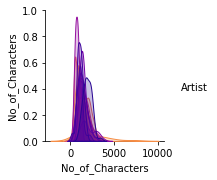

In [ ]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

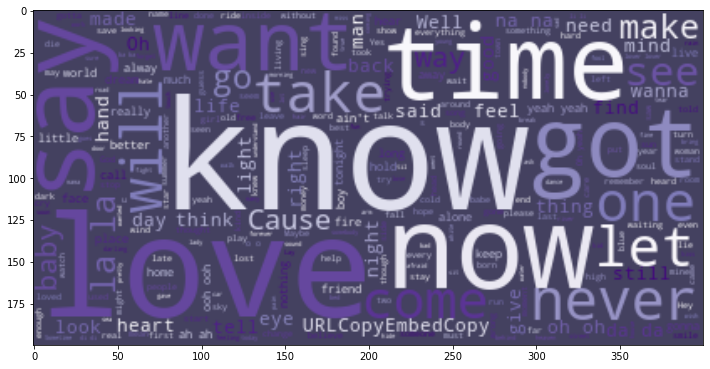

In [ ]:
# Generate a word cloud image
from nltk.corpus import stopwords

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

The generation of text with RNN involves the following workflow.  

<p style="background-color:#B3C5E3;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Text</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">DATA PREPROCESSING</p>

**In this section, I will be performing the following:**

**Creating a Corpus of Lyrics text:** For the model, we need a sequence of the text string. I am creating a Corpus out of Lyrics column. 

**Removing the unrequired characters that may have sneaked in my text corpus:** The data cleaning process for NLP is crucial preprocessing. To do that, I look into the Corpus to check for what this Corpus is comprised of. That is, all the unique symbols present. After examining the Corpus, I will be eliminating any foreign language or irrelevant symbols from the Corpus. 

**Creating a dictionary to map characters and their indices:** The computer doesn’t understand the text. For the computer, the text is just a cluster of symbols. It works with numbers. So we create a dictionary to map each unique character in our Corpus to a number and vice versa. This will be used to encode and decode the information going in and getting out of the RNN

**Splitting the corpus into smaller sentences of equal length:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, Corpus contain only intended characters (i.e, lower cap English alphabets, Numbers and a few punctuations). We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify. 

The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model. 

**Creating a Corpus**

In [ ]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 92


The total number of unique characters present in the Corpus clearly shows, that some of the foreign language scripts have sneaked in. I will take a look at all the characters present. I will then remove the unrequired characters. 

In [ ]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


In [ ]:
Corpus = re.sub("[^A-Za-z0-9'\.\n]"," ",Corpus) # Alterneativly could be used but I want to pick and chose (:

#Keeping only a limited set of characters. 
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', '¡', 'º', "=", "\n"]
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ").replace("\'","")

In [ ]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: [' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
Corpus = " ".join([t for t in Corpus.split() if len(t) > 1])
Corpus[:1000]

'vintage tee brand new phone high heels on cobblestones when you are young they assume you know nothing sequin smile black lipstick sensual politics when you are young they assume you know nothing but knew you dancin in your levis drunk under streetlight knew you hand under my sweatshirt baby kiss it better and when felt like was an old cardigan under someones bed you put me on and said was your favorite friend to all is friend to none chase two girls lose the one when you are young they assume you know nothing but knew you playing hide and seek and giving me your weekends knew you your heartbeat on the high line once in twenty lifetimes and when felt like was an old cardigan under someones bed you put me on and said was your favorite to kiss in cars and downtown bars was all we needed you drew stars around my scars but now im bleedin cause knew you steppin on the last train marked me like bloodstain knew you tried to change the ending peter losing wendy knew you leavin like father run

**Creating a list of sorted unique characters**

In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 986804
Number of unique characters: 38


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 10
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 986794


**Encoding the Labels and Targets**

In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
# y = np_utils.to_categorical(targets)
y = pd.get_dummies(pd.Series(targets))

In [ ]:
print(X.shape)
y

(986794, 10, 1)


0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  32  33  \
0        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1        1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3        0   0   0   0   0   0   0   0   0   0  ...   0   1   0   0   0   0   
4        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
986789   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
986790   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
986791   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
986792   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
986793   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   1   0   0   

        34  35  36  37  
0        0   0   0   0  
1        0   0   0   0  
2        0   0   0   0  
3        0   0   0   0  
4        0   0   0   0  
...     ..  ..  ..  ..  
986789   0   0   0   0  
986790   0   0   0   0  
986791   0   0   0   0  
986792   0   0   0   0  
986793   0   0   0   0  

[986794 rows x 38 columns]

<a id="5"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">MODEL BUILDING</p>


Recurrent Neural Networks are pretty popular with generating text. In this project, I will be using a LSTM Model, an improved version of a standard recurrent neural network

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

#Model's Summary               
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                9766      
Total params: 273,958
Trainable params: 273,958
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=100)

2021-11-28 21:32:24.673460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-28 21:32:28.157850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204



   1/7710 [..............................] - ETA: 12:00:55 - loss: 3.6307


   9/7710 [..............................] - ETA: 51s - loss: 3.3628     


  17/7710 [..............................] - ETA: 51s - loss: 3.1442


  26/7710 [..............................] - ETA: 49s - loss: 3.0416


  35/7710 [..............................] - ETA: 48s - loss: 2.9929


  43/7710 [..............................] - ETA: 49s - loss: 2.9720


  51/7710 [..............................] - ETA: 49s - loss: 2.9594


  59/7710 [..............................] - ETA: 49s - loss: 2.9423


  67/7710 [..............................] - ETA: 49s - loss: 2.9321


  75/7710 [..............................] - ETA: 49s - loss: 2.9247


  84/7710 [..............................] - ETA: 49s - loss: 2.9164


  92/7710 [..............................] - ETA: 49s - loss: 2.9097


 101/7710 [..............................] - ETA: 49s - loss: 2.9057


 109/7710 [..............................] - ETA: 49s - loss: 2.9009


 117/7710 [..............................] - ETA: 48s - loss: 2.8973


 125/7710 [..............................] - ETA: 48s - loss: 2.8953


 133/7710 [..............................] - ETA: 48s - loss: 2.8899


 141/7710 [..............................] - ETA: 48s - loss: 2.8834


 150/7710 [..............................] - ETA: 48s - loss: 2.8748


 159/7710 [..............................] - ETA: 48s - loss: 2.8656


 167/7710 [..............................] - ETA: 48s - loss: 2.8583


 176/7710 [..............................] - ETA: 48s - loss: 2.8507


 184/7710 [..............................] - ETA: 48s - loss: 2.8445


 193/7710 [..............................] - ETA: 47s - loss: 2.8377


 201/7710 [..............................] - ETA: 47s - loss: 2.8288


 210/7710 [..............................] - ETA: 47s - loss: 2.8233


 218/7710 [..............................] - ETA: 47s - loss: 2.8192


 227/7710 [..............................] - ETA: 47s - loss: 2.8129


 235/7710 [..............................] - ETA: 47s - loss: 2.8068


 244/7710 [..............................] - ETA: 47s - loss: 2.8001


 252/7710 [..............................] - ETA: 47s - loss: 2.7953


 261/7710 [>.............................] - ETA: 47s - loss: 2.7880


 269/7710 [>.............................] - ETA: 47s - loss: 2.7827


 277/7710 [>.............................] - ETA: 47s - loss: 2.7782


 285/7710 [>.............................] - ETA: 47s - loss: 2.7739


 293/7710 [>.............................] - ETA: 47s - loss: 2.7685


 301/7710 [>.............................] - ETA: 47s - loss: 2.7637


 309/7710 [>.............................] - ETA: 47s - loss: 2.7588


 317/7710 [>.............................] - ETA: 47s - loss: 2.7546


 324/7710 [>.............................] - ETA: 47s - loss: 2.7518


 333/7710 [>.............................] - ETA: 47s - loss: 2.7464


 341/7710 [>.............................] - ETA: 47s - loss: 2.7436


 350/7710 [>.............................] - ETA: 46s - loss: 2.7397


 358/7710 [>.............................] - ETA: 47s - loss: 2.7362


 366/7710 [>.............................] - ETA: 47s - loss: 2.7333


 374/7710 [>.............................] - ETA: 46s - loss: 2.7276


 383/7710 [>.............................] - ETA: 46s - loss: 2.7233


 391/7710 [>.............................] - ETA: 46s - loss: 2.7199


 400/7710 [>.............................] - ETA: 46s - loss: 2.7173


 408/7710 [>.............................] - ETA: 46s - loss: 2.7143


 416/7710 [>.............................] - ETA: 46s - loss: 2.7117


 424/7710 [>.............................] - ETA: 46s - loss: 2.7086


 432/7710 [>.............................] - ETA: 46s - loss: 2.7060


 440/7710 [>.............................] - ETA: 46s - loss: 2.7030


 449/7710 [>.............................] - ETA: 46s - loss: 2.6983


 457/7710 [>.............................] - ETA: 46s - loss: 2.6967


 465/7710 [>.............................] - ETA: 46s - loss: 2.6941


 473/7710 [>.............................] - ETA: 46s - loss: 2.6908


 479/7710 [>.............................] - ETA: 46s - loss: 2.6885


 487/7710 [>.............................] - ETA: 46s - loss: 2.6853


 495/7710 [>.............................] - ETA: 46s - loss: 2.6829


 503/7710 [>.............................] - ETA: 46s - loss: 2.6805


 510/7710 [>.............................] - ETA: 46s - loss: 2.6781


 518/7710 [=>............................] - ETA: 46s - loss: 2.6761


 526/7710 [=>............................] - ETA: 46s - loss: 2.6743


 535/7710 [=>............................] - ETA: 46s - loss: 2.6713


 543/7710 [=>............................] - ETA: 46s - loss: 2.6694


 552/7710 [=>............................] - ETA: 45s - loss: 2.6671


 560/7710 [=>............................] - ETA: 45s - loss: 2.6647


 569/7710 [=>............................] - ETA: 45s - loss: 2.6624


 577/7710 [=>............................] - ETA: 45s - loss: 2.6602


 586/7710 [=>............................] - ETA: 45s - loss: 2.6579


 594/7710 [=>............................] - ETA: 45s - loss: 2.6564


 602/7710 [=>............................] - ETA: 45s - loss: 2.6540


 610/7710 [=>............................] - ETA: 45s - loss: 2.6514


 618/7710 [=>............................] - ETA: 45s - loss: 2.6492


 626/7710 [=>............................] - ETA: 45s - loss: 2.6476


 634/7710 [=>............................] - ETA: 45s - loss: 2.6457


 642/7710 [=>............................] - ETA: 45s - loss: 2.6435


 650/7710 [=>............................] - ETA: 45s - loss: 2.6422


 658/7710 [=>............................] - ETA: 45s - loss: 2.6399


 665/7710 [=>............................] - ETA: 45s - loss: 2.6382


 674/7710 [=>............................] - ETA: 45s - loss: 2.6369


 682/7710 [=>............................] - ETA: 45s - loss: 2.6351


 691/7710 [=>............................] - ETA: 45s - loss: 2.6331


 699/7710 [=>............................] - ETA: 45s - loss: 2.6317


 708/7710 [=>............................] - ETA: 44s - loss: 2.6301


 716/7710 [=>............................] - ETA: 44s - loss: 2.6283


 725/7710 [=>............................] - ETA: 44s - loss: 2.6260


 733/7710 [=>............................] - ETA: 44s - loss: 2.6248


 741/7710 [=>............................] - ETA: 44s - loss: 2.6229


 749/7710 [=>............................] - ETA: 44s - loss: 2.6210


 758/7710 [=>............................] - ETA: 44s - loss: 2.6185


 766/7710 [=>............................] - ETA: 44s - loss: 2.6172


 774/7710 [==>...........................] - ETA: 44s - loss: 2.6160


 782/7710 [==>...........................] - ETA: 44s - loss: 2.6146


 790/7710 [==>...........................] - ETA: 44s - loss: 2.6129


 798/7710 [==>...........................] - ETA: 44s - loss: 2.6112


 806/7710 [==>...........................] - ETA: 44s - loss: 2.6095


 815/7710 [==>...........................] - ETA: 44s - loss: 2.6077


 824/7710 [==>...........................] - ETA: 44s - loss: 2.6058


 832/7710 [==>...........................] - ETA: 44s - loss: 2.6040


 839/7710 [==>...........................] - ETA: 44s - loss: 2.6029


 847/7710 [==>...........................] - ETA: 44s - loss: 2.6014


 854/7710 [==>...........................] - ETA: 44s - loss: 2.5999


 862/7710 [==>...........................] - ETA: 44s - loss: 2.5984


 869/7710 [==>...........................] - ETA: 44s - loss: 2.5977


 876/7710 [==>...........................] - ETA: 44s - loss: 2.5966


 882/7710 [==>...........................] - ETA: 44s - loss: 2.5959


 889/7710 [==>...........................] - ETA: 44s - loss: 2.5950


 896/7710 [==>...........................] - ETA: 44s - loss: 2.5938


 904/7710 [==>...........................] - ETA: 44s - loss: 2.5928


 911/7710 [==>...........................] - ETA: 44s - loss: 2.5916


 918/7710 [==>...........................] - ETA: 44s - loss: 2.5908


 926/7710 [==>...........................] - ETA: 44s - loss: 2.5893


 935/7710 [==>...........................] - ETA: 44s - loss: 2.5883


 944/7710 [==>...........................] - ETA: 43s - loss: 2.5868


 952/7710 [==>...........................] - ETA: 43s - loss: 2.5860


 960/7710 [==>...........................] - ETA: 43s - loss: 2.5848


 968/7710 [==>...........................] - ETA: 43s - loss: 2.5839


 976/7710 [==>...........................] - ETA: 43s - loss: 2.5834


 983/7710 [==>...........................] - ETA: 43s - loss: 2.5821


 991/7710 [==>...........................] - ETA: 43s - loss: 2.5809


 999/7710 [==>...........................] - ETA: 43s - loss: 2.5797


1007/7710 [==>...........................] - ETA: 43s - loss: 2.5786


1015/7710 [==>...........................] - ETA: 43s - loss: 2.5776


1024/7710 [==>...........................] - ETA: 43s - loss: 2.5765


1033/7710 [===>..........................] - ETA: 43s - loss: 2.5750


1041/7710 [===>..........................] - ETA: 43s - loss: 2.5740


1049/7710 [===>..........................] - ETA: 43s - loss: 2.5735


1056/7710 [===>..........................] - ETA: 43s - loss: 2.5730


1064/7710 [===>..........................] - ETA: 43s - loss: 2.5722


1072/7710 [===>..........................] - ETA: 43s - loss: 2.5714


1080/7710 [===>..........................] - ETA: 43s - loss: 2.5703


1087/7710 [===>..........................] - ETA: 43s - loss: 2.5691


1095/7710 [===>..........................] - ETA: 43s - loss: 2.5678


1103/7710 [===>..........................] - ETA: 43s - loss: 2.5669


1112/7710 [===>..........................] - ETA: 42s - loss: 2.5660


1120/7710 [===>..........................] - ETA: 42s - loss: 2.5649


1128/7710 [===>..........................] - ETA: 42s - loss: 2.5639


1136/7710 [===>..........................] - ETA: 42s - loss: 2.5630


1145/7710 [===>..........................] - ETA: 42s - loss: 2.5618


1153/7710 [===>..........................] - ETA: 42s - loss: 2.5609


1162/7710 [===>..........................] - ETA: 42s - loss: 2.5598


1170/7710 [===>..........................] - ETA: 42s - loss: 2.5587


1177/7710 [===>..........................] - ETA: 42s - loss: 2.5577


1184/7710 [===>..........................] - ETA: 42s - loss: 2.5566


1192/7710 [===>..........................] - ETA: 42s - loss: 2.5555


1200/7710 [===>..........................] - ETA: 42s - loss: 2.5551


1207/7710 [===>..........................] - ETA: 42s - loss: 2.5540


1215/7710 [===>..........................] - ETA: 42s - loss: 2.5530


1222/7710 [===>..........................] - ETA: 42s - loss: 2.5519


1229/7710 [===>..........................] - ETA: 42s - loss: 2.5513


1237/7710 [===>..........................] - ETA: 42s - loss: 2.5508


1245/7710 [===>..........................] - ETA: 42s - loss: 2.5502


1253/7710 [===>..........................] - ETA: 42s - loss: 2.5496


1260/7710 [===>..........................] - ETA: 42s - loss: 2.5489


1268/7710 [===>..........................] - ETA: 42s - loss: 2.5481


1276/7710 [===>..........................] - ETA: 42s - loss: 2.5470


1285/7710 [====>.........................] - ETA: 42s - loss: 2.5459


1293/7710 [====>.........................] - ETA: 42s - loss: 2.5447


1302/7710 [====>.........................] - ETA: 42s - loss: 2.5435


1309/7710 [====>.........................] - ETA: 41s - loss: 2.5427


1318/7710 [====>.........................] - ETA: 41s - loss: 2.5420


1327/7710 [====>.........................] - ETA: 41s - loss: 2.5410


1336/7710 [====>.........................] - ETA: 41s - loss: 2.5400


1344/7710 [====>.........................] - ETA: 41s - loss: 2.5392


1353/7710 [====>.........................] - ETA: 41s - loss: 2.5386


1361/7710 [====>.........................] - ETA: 41s - loss: 2.5379


1369/7710 [====>.........................] - ETA: 41s - loss: 2.5372


1377/7710 [====>.........................] - ETA: 41s - loss: 2.5364


1385/7710 [====>.........................] - ETA: 41s - loss: 2.5354


1393/7710 [====>.........................] - ETA: 41s - loss: 2.5343


1401/7710 [====>.........................] - ETA: 41s - loss: 2.5335


1410/7710 [====>.........................] - ETA: 41s - loss: 2.5325


1418/7710 [====>.........................] - ETA: 41s - loss: 2.5319


1426/7710 [====>.........................] - ETA: 41s - loss: 2.5311


1434/7710 [====>.........................] - ETA: 41s - loss: 2.5305


1443/7710 [====>.........................] - ETA: 40s - loss: 2.5299


1451/7710 [====>.........................] - ETA: 40s - loss: 2.5292


1460/7710 [====>.........................] - ETA: 40s - loss: 2.5282


1468/7710 [====>.........................] - ETA: 40s - loss: 2.5273


1477/7710 [====>.........................] - ETA: 40s - loss: 2.5261


1485/7710 [====>.........................] - ETA: 40s - loss: 2.5255


1493/7710 [====>.........................] - ETA: 40s - loss: 2.5246


1501/7710 [====>.........................] - ETA: 40s - loss: 2.5238


1510/7710 [====>.........................] - ETA: 40s - loss: 2.5225


1518/7710 [====>.........................] - ETA: 40s - loss: 2.5216


1527/7710 [====>.........................] - ETA: 40s - loss: 2.5207


1536/7710 [====>.........................] - ETA: 40s - loss: 2.5197


1545/7710 [=====>........................] - ETA: 40s - loss: 2.5187


1554/7710 [=====>........................] - ETA: 40s - loss: 2.5180


1562/7710 [=====>........................] - ETA: 40s - loss: 2.5174


1570/7710 [=====>........................] - ETA: 40s - loss: 2.5169


1576/7710 [=====>........................] - ETA: 40s - loss: 2.5162


1585/7710 [=====>........................] - ETA: 39s - loss: 2.5150


1593/7710 [=====>........................] - ETA: 39s - loss: 2.5143


1602/7710 [=====>........................] - ETA: 39s - loss: 2.5135


1610/7710 [=====>........................] - ETA: 39s - loss: 2.5127


1619/7710 [=====>........................] - ETA: 39s - loss: 2.5120


1627/7710 [=====>........................] - ETA: 39s - loss: 2.5111


1636/7710 [=====>........................] - ETA: 39s - loss: 2.5100


1644/7710 [=====>........................] - ETA: 39s - loss: 2.5093


1653/7710 [=====>........................] - ETA: 39s - loss: 2.5083


1662/7710 [=====>........................] - ETA: 39s - loss: 2.5075


1671/7710 [=====>........................] - ETA: 39s - loss: 2.5064


1680/7710 [=====>........................] - ETA: 39s - loss: 2.5056


1688/7710 [=====>........................] - ETA: 39s - loss: 2.5050


1697/7710 [=====>........................] - ETA: 39s - loss: 2.5042


1705/7710 [=====>........................] - ETA: 39s - loss: 2.5034


1714/7710 [=====>........................] - ETA: 38s - loss: 2.5026


1722/7710 [=====>........................] - ETA: 38s - loss: 2.5016


1730/7710 [=====>........................] - ETA: 38s - loss: 2.5010


1737/7710 [=====>........................] - ETA: 38s - loss: 2.5004


1746/7710 [=====>........................] - ETA: 38s - loss: 2.4998


1754/7710 [=====>........................] - ETA: 38s - loss: 2.4989


1763/7710 [=====>........................] - ETA: 38s - loss: 2.4982


1771/7710 [=====>........................] - ETA: 38s - loss: 2.4976


1780/7710 [=====>........................] - ETA: 38s - loss: 2.4970


1789/7710 [=====>........................] - ETA: 38s - loss: 2.4962


1798/7710 [=====>........................] - ETA: 38s - loss: 2.4955


1806/7710 [======>.......................] - ETA: 38s - loss: 2.4946


1814/7710 [======>.......................] - ETA: 38s - loss: 2.4941


1822/7710 [======>.......................] - ETA: 38s - loss: 2.4934


1829/7710 [======>.......................] - ETA: 38s - loss: 2.4928


1837/7710 [======>.......................] - ETA: 38s - loss: 2.4921


1845/7710 [======>.......................] - ETA: 38s - loss: 2.4915


1853/7710 [======>.......................] - ETA: 38s - loss: 2.4909


1861/7710 [======>.......................] - ETA: 37s - loss: 2.4903


1870/7710 [======>.......................] - ETA: 37s - loss: 2.4895


1878/7710 [======>.......................] - ETA: 37s - loss: 2.4890


1886/7710 [======>.......................] - ETA: 37s - loss: 2.4883


1894/7710 [======>.......................] - ETA: 37s - loss: 2.4874


1903/7710 [======>.......................] - ETA: 37s - loss: 2.4867


1912/7710 [======>.......................] - ETA: 37s - loss: 2.4859


1920/7710 [======>.......................] - ETA: 37s - loss: 2.4850


1929/7710 [======>.......................] - ETA: 37s - loss: 2.4842


1937/7710 [======>.......................] - ETA: 37s - loss: 2.4836


1944/7710 [======>.......................] - ETA: 37s - loss: 2.4831


1951/7710 [======>.......................] - ETA: 37s - loss: 2.4825


1958/7710 [======>.......................] - ETA: 37s - loss: 2.4819


1965/7710 [======>.......................] - ETA: 37s - loss: 2.4814


1972/7710 [======>.......................] - ETA: 37s - loss: 2.4808


1979/7710 [======>.......................] - ETA: 37s - loss: 2.4801


1987/7710 [======>.......................] - ETA: 37s - loss: 2.4796


1995/7710 [======>.......................] - ETA: 37s - loss: 2.4791


2002/7710 [======>.......................] - ETA: 37s - loss: 2.4786


2010/7710 [======>.......................] - ETA: 37s - loss: 2.4782


2018/7710 [======>.......................] - ETA: 37s - loss: 2.4776


2026/7710 [======>.......................] - ETA: 37s - loss: 2.4772


2034/7710 [======>.......................] - ETA: 37s - loss: 2.4764


2042/7710 [======>.......................] - ETA: 36s - loss: 2.4756


2050/7710 [======>.......................] - ETA: 36s - loss: 2.4748


2059/7710 [=======>......................] - ETA: 36s - loss: 2.4742


2067/7710 [=======>......................] - ETA: 36s - loss: 2.4737


2076/7710 [=======>......................] - ETA: 36s - loss: 2.4729


2084/7710 [=======>......................] - ETA: 36s - loss: 2.4723


2093/7710 [=======>......................] - ETA: 36s - loss: 2.4717


2101/7710 [=======>......................] - ETA: 36s - loss: 2.4709


2110/7710 [=======>......................] - ETA: 36s - loss: 2.4705


2118/7710 [=======>......................] - ETA: 36s - loss: 2.4699


2126/7710 [=======>......................] - ETA: 36s - loss: 2.4691


2134/7710 [=======>......................] - ETA: 36s - loss: 2.4685


2142/7710 [=======>......................] - ETA: 36s - loss: 2.4675


2151/7710 [=======>......................] - ETA: 36s - loss: 2.4668


2159/7710 [=======>......................] - ETA: 36s - loss: 2.4662


2168/7710 [=======>......................] - ETA: 36s - loss: 2.4657


2176/7710 [=======>......................] - ETA: 36s - loss: 2.4652


2185/7710 [=======>......................] - ETA: 36s - loss: 2.4646


2193/7710 [=======>......................] - ETA: 35s - loss: 2.4641


2201/7710 [=======>......................] - ETA: 35s - loss: 2.4636


2209/7710 [=======>......................] - ETA: 35s - loss: 2.4629


2218/7710 [=======>......................] - ETA: 35s - loss: 2.4620


2227/7710 [=======>......................] - ETA: 35s - loss: 2.4613


2235/7710 [=======>......................] - ETA: 35s - loss: 2.4608


2243/7710 [=======>......................] - ETA: 35s - loss: 2.4604


2251/7710 [=======>......................] - ETA: 35s - loss: 2.4599


2259/7710 [=======>......................] - ETA: 35s - loss: 2.4594


2267/7710 [=======>......................] - ETA: 35s - loss: 2.4588


2276/7710 [=======>......................] - ETA: 35s - loss: 2.4580


2284/7710 [=======>......................] - ETA: 35s - loss: 2.4575


2293/7710 [=======>......................] - ETA: 35s - loss: 2.4566


2301/7710 [=======>......................] - ETA: 35s - loss: 2.4559


2310/7710 [=======>......................] - ETA: 35s - loss: 2.4554


2318/7710 [========>.....................] - ETA: 35s - loss: 2.4548


2327/7710 [========>.....................] - ETA: 35s - loss: 2.4541


2335/7710 [========>.....................] - ETA: 34s - loss: 2.4535


2344/7710 [========>.....................] - ETA: 34s - loss: 2.4528


2352/7710 [========>.....................] - ETA: 34s - loss: 2.4523


2360/7710 [========>.....................] - ETA: 34s - loss: 2.4516


2368/7710 [========>.....................] - ETA: 34s - loss: 2.4507


2377/7710 [========>.....................] - ETA: 34s - loss: 2.4500


2385/7710 [========>.....................] - ETA: 34s - loss: 2.4494


2394/7710 [========>.....................] - ETA: 34s - loss: 2.4488


2403/7710 [========>.....................] - ETA: 34s - loss: 2.4480


2411/7710 [========>.....................] - ETA: 34s - loss: 2.4475


2419/7710 [========>.....................] - ETA: 34s - loss: 2.4469


2426/7710 [========>.....................] - ETA: 34s - loss: 2.4465


2435/7710 [========>.....................] - ETA: 34s - loss: 2.4459


2443/7710 [========>.....................] - ETA: 34s - loss: 2.4452


2452/7710 [========>.....................] - ETA: 34s - loss: 2.4446


2460/7710 [========>.....................] - ETA: 34s - loss: 2.4443


2469/7710 [========>.....................] - ETA: 34s - loss: 2.4436


2478/7710 [========>.....................] - ETA: 33s - loss: 2.4432


2487/7710 [========>.....................] - ETA: 33s - loss: 2.4424


2495/7710 [========>.....................] - ETA: 33s - loss: 2.4420


2503/7710 [========>.....................] - ETA: 33s - loss: 2.4415


2511/7710 [========>.....................] - ETA: 33s - loss: 2.4411


2518/7710 [========>.....................] - ETA: 33s - loss: 2.4405


2526/7710 [========>.....................] - ETA: 33s - loss: 2.4399


2535/7710 [========>.....................] - ETA: 33s - loss: 2.4394


2544/7710 [========>.....................] - ETA: 33s - loss: 2.4387


2552/7710 [========>.....................] - ETA: 33s - loss: 2.4379


2559/7710 [========>.....................] - ETA: 33s - loss: 2.4374


2567/7710 [========>.....................] - ETA: 33s - loss: 2.4368


2576/7710 [=========>....................] - ETA: 33s - loss: 2.4364


2584/7710 [=========>....................] - ETA: 33s - loss: 2.4361


2592/7710 [=========>....................] - ETA: 33s - loss: 2.4356


2600/7710 [=========>....................] - ETA: 33s - loss: 2.4349


2609/7710 [=========>....................] - ETA: 33s - loss: 2.4345


2617/7710 [=========>....................] - ETA: 33s - loss: 2.4339


2625/7710 [=========>....................] - ETA: 33s - loss: 2.4334


2633/7710 [=========>....................] - ETA: 33s - loss: 2.4330


2641/7710 [=========>....................] - ETA: 32s - loss: 2.4325


2650/7710 [=========>....................] - ETA: 32s - loss: 2.4320


2658/7710 [=========>....................] - ETA: 32s - loss: 2.4313


2667/7710 [=========>....................] - ETA: 32s - loss: 2.4309


2674/7710 [=========>....................] - ETA: 32s - loss: 2.4306


2683/7710 [=========>....................] - ETA: 32s - loss: 2.4298


2691/7710 [=========>....................] - ETA: 32s - loss: 2.4290


2700/7710 [=========>....................] - ETA: 32s - loss: 2.4285


2708/7710 [=========>....................] - ETA: 32s - loss: 2.4278


2717/7710 [=========>....................] - ETA: 32s - loss: 2.4273


2725/7710 [=========>....................] - ETA: 32s - loss: 2.4268


2733/7710 [=========>....................] - ETA: 32s - loss: 2.4264


2740/7710 [=========>....................] - ETA: 32s - loss: 2.4260


2749/7710 [=========>....................] - ETA: 32s - loss: 2.4252


2757/7710 [=========>....................] - ETA: 32s - loss: 2.4247


2765/7710 [=========>....................] - ETA: 32s - loss: 2.4244


2772/7710 [=========>....................] - ETA: 32s - loss: 2.4239


2779/7710 [=========>....................] - ETA: 32s - loss: 2.4236


2787/7710 [=========>....................] - ETA: 32s - loss: 2.4231


2795/7710 [=========>....................] - ETA: 31s - loss: 2.4226


2804/7710 [=========>....................] - ETA: 31s - loss: 2.4220


2812/7710 [=========>....................] - ETA: 31s - loss: 2.4214


2820/7710 [=========>....................] - ETA: 31s - loss: 2.4209


2828/7710 [==========>...................] - ETA: 31s - loss: 2.4206


2837/7710 [==========>...................] - ETA: 31s - loss: 2.4201


2845/7710 [==========>...................] - ETA: 31s - loss: 2.4195


2854/7710 [==========>...................] - ETA: 31s - loss: 2.4190


2863/7710 [==========>...................] - ETA: 31s - loss: 2.4185


2871/7710 [==========>...................] - ETA: 31s - loss: 2.4181


2879/7710 [==========>...................] - ETA: 31s - loss: 2.4178


2887/7710 [==========>...................] - ETA: 31s - loss: 2.4173


2895/7710 [==========>...................] - ETA: 31s - loss: 2.4167


2903/7710 [==========>...................] - ETA: 31s - loss: 2.4162


2911/7710 [==========>...................] - ETA: 31s - loss: 2.4156


2918/7710 [==========>...................] - ETA: 31s - loss: 2.4149


2927/7710 [==========>...................] - ETA: 31s - loss: 2.4143


2934/7710 [==========>...................] - ETA: 31s - loss: 2.4141


2942/7710 [==========>...................] - ETA: 31s - loss: 2.4134


2950/7710 [==========>...................] - ETA: 30s - loss: 2.4129


2959/7710 [==========>...................] - ETA: 30s - loss: 2.4124


2967/7710 [==========>...................] - ETA: 30s - loss: 2.4120


2975/7710 [==========>...................] - ETA: 30s - loss: 2.4113


2983/7710 [==========>...................] - ETA: 30s - loss: 2.4110


2991/7710 [==========>...................] - ETA: 30s - loss: 2.4106


2999/7710 [==========>...................] - ETA: 30s - loss: 2.4102


3007/7710 [==========>...................] - ETA: 30s - loss: 2.4097


3016/7710 [==========>...................] - ETA: 30s - loss: 2.4093


3025/7710 [==========>...................] - ETA: 30s - loss: 2.4086


3034/7710 [==========>...................] - ETA: 30s - loss: 2.4080


3040/7710 [==========>...................] - ETA: 30s - loss: 2.4076


3048/7710 [==========>...................] - ETA: 30s - loss: 2.4072


3056/7710 [==========>...................] - ETA: 30s - loss: 2.4066


3065/7710 [==========>...................] - ETA: 30s - loss: 2.4060


3073/7710 [==========>...................] - ETA: 30s - loss: 2.4054


3082/7710 [==========>...................] - ETA: 30s - loss: 2.4048


3090/7710 [===========>..................] - ETA: 30s - loss: 2.4044


3099/7710 [===========>..................] - ETA: 29s - loss: 2.4039


3107/7710 [===========>..................] - ETA: 29s - loss: 2.4038


3115/7710 [===========>..................] - ETA: 29s - loss: 2.4034


3123/7710 [===========>..................] - ETA: 29s - loss: 2.4028


3132/7710 [===========>..................] - ETA: 29s - loss: 2.4021


3140/7710 [===========>..................] - ETA: 29s - loss: 2.4015


3149/7710 [===========>..................] - ETA: 29s - loss: 2.4009


3157/7710 [===========>..................] - ETA: 29s - loss: 2.4004


3164/7710 [===========>..................] - ETA: 29s - loss: 2.4001


3173/7710 [===========>..................] - ETA: 29s - loss: 2.3994


3181/7710 [===========>..................] - ETA: 29s - loss: 2.3989


3189/7710 [===========>..................] - ETA: 29s - loss: 2.3986


3197/7710 [===========>..................] - ETA: 29s - loss: 2.3982


3206/7710 [===========>..................] - ETA: 29s - loss: 2.3978


3214/7710 [===========>..................] - ETA: 29s - loss: 2.3974


3223/7710 [===========>..................] - ETA: 29s - loss: 2.3969


3231/7710 [===========>..................] - ETA: 29s - loss: 2.3964


3240/7710 [===========>..................] - ETA: 29s - loss: 2.3959


3248/7710 [===========>..................] - ETA: 28s - loss: 2.3954


3257/7710 [===========>..................] - ETA: 28s - loss: 2.3949


3265/7710 [===========>..................] - ETA: 28s - loss: 2.3942


3273/7710 [===========>..................] - ETA: 28s - loss: 2.3937


3281/7710 [===========>..................] - ETA: 28s - loss: 2.3934


3290/7710 [===========>..................] - ETA: 28s - loss: 2.3930


3299/7710 [===========>..................] - ETA: 28s - loss: 2.3926


3308/7710 [===========>..................] - ETA: 28s - loss: 2.3921


3317/7710 [===========>..................] - ETA: 28s - loss: 2.3916


3325/7710 [===========>..................] - ETA: 28s - loss: 2.3911


3334/7710 [===========>..................] - ETA: 28s - loss: 2.3906


3342/7710 [============>.................] - ETA: 28s - loss: 2.3900


3351/7710 [============>.................] - ETA: 28s - loss: 2.3896


3359/7710 [============>.................] - ETA: 28s - loss: 2.3893


3367/7710 [============>.................] - ETA: 28s - loss: 2.3887


3375/7710 [============>.................] - ETA: 28s - loss: 2.3886


3383/7710 [============>.................] - ETA: 28s - loss: 2.3881


3391/7710 [============>.................] - ETA: 28s - loss: 2.3877


3399/7710 [============>.................] - ETA: 27s - loss: 2.3870


3407/7710 [============>.................] - ETA: 27s - loss: 2.3865


3415/7710 [============>.................] - ETA: 27s - loss: 2.3861


3424/7710 [============>.................] - ETA: 27s - loss: 2.3856


3431/7710 [============>.................] - ETA: 27s - loss: 2.3851


3439/7710 [============>.................] - ETA: 27s - loss: 2.3847


3447/7710 [============>.................] - ETA: 27s - loss: 2.3840


3456/7710 [============>.................] - ETA: 27s - loss: 2.3835


3464/7710 [============>.................] - ETA: 27s - loss: 2.3831


3473/7710 [============>.................] - ETA: 27s - loss: 2.3825


3481/7710 [============>.................] - ETA: 27s - loss: 2.3821


3489/7710 [============>.................] - ETA: 27s - loss: 2.3816


3497/7710 [============>.................] - ETA: 27s - loss: 2.3811


3505/7710 [============>.................] - ETA: 27s - loss: 2.3807


3513/7710 [============>.................] - ETA: 27s - loss: 2.3803


3521/7710 [============>.................] - ETA: 27s - loss: 2.3798


3529/7710 [============>.................] - ETA: 27s - loss: 2.3793


3537/7710 [============>.................] - ETA: 27s - loss: 2.3789


3544/7710 [============>.................] - ETA: 27s - loss: 2.3783


3551/7710 [============>.................] - ETA: 27s - loss: 2.3779


3559/7710 [============>.................] - ETA: 26s - loss: 2.3776


3567/7710 [============>.................] - ETA: 26s - loss: 2.3771


3575/7710 [============>.................] - ETA: 26s - loss: 2.3766


3582/7710 [============>.................] - ETA: 26s - loss: 2.3762


3591/7710 [============>.................] - ETA: 26s - loss: 2.3755


3599/7710 [=============>................] - ETA: 26s - loss: 2.3750


3608/7710 [=============>................] - ETA: 26s - loss: 2.3747


3615/7710 [=============>................] - ETA: 26s - loss: 2.3743


3624/7710 [=============>................] - ETA: 26s - loss: 2.3739


3632/7710 [=============>................] - ETA: 26s - loss: 2.3735


3641/7710 [=============>................] - ETA: 26s - loss: 2.3729


3649/7710 [=============>................] - ETA: 26s - loss: 2.3724


3657/7710 [=============>................] - ETA: 26s - loss: 2.3721


3665/7710 [=============>................] - ETA: 26s - loss: 2.3716


3674/7710 [=============>................] - ETA: 26s - loss: 2.3711


3683/7710 [=============>................] - ETA: 26s - loss: 2.3706


3691/7710 [=============>................] - ETA: 26s - loss: 2.3702


3700/7710 [=============>................] - ETA: 26s - loss: 2.3697


3708/7710 [=============>................] - ETA: 25s - loss: 2.3693


3717/7710 [=============>................] - ETA: 25s - loss: 2.3687


3725/7710 [=============>................] - ETA: 25s - loss: 2.3683


3733/7710 [=============>................] - ETA: 25s - loss: 2.3678


3741/7710 [=============>................] - ETA: 25s - loss: 2.3673


3749/7710 [=============>................] - ETA: 25s - loss: 2.3668


3756/7710 [=============>................] - ETA: 25s - loss: 2.3664


3765/7710 [=============>................] - ETA: 25s - loss: 2.3659


3772/7710 [=============>................] - ETA: 25s - loss: 2.3656


3781/7710 [=============>................] - ETA: 25s - loss: 2.3652


3788/7710 [=============>................] - ETA: 25s - loss: 2.3649


3795/7710 [=============>................] - ETA: 25s - loss: 2.3646


3803/7710 [=============>................] - ETA: 25s - loss: 2.3641


3810/7710 [=============>................] - ETA: 25s - loss: 2.3638


3817/7710 [=============>................] - ETA: 25s - loss: 2.3635


3825/7710 [=============>................] - ETA: 25s - loss: 2.3631


3833/7710 [=============>................] - ETA: 25s - loss: 2.3626


3840/7710 [=============>................] - ETA: 25s - loss: 2.3624


3849/7710 [=============>................] - ETA: 25s - loss: 2.3620


3857/7710 [==============>...............] - ETA: 25s - loss: 2.3617


3865/7710 [==============>...............] - ETA: 25s - loss: 2.3610


3873/7710 [==============>...............] - ETA: 24s - loss: 2.3608


3882/7710 [==============>...............] - ETA: 24s - loss: 2.3603


3890/7710 [==============>...............] - ETA: 24s - loss: 2.3599


3899/7710 [==============>...............] - ETA: 24s - loss: 2.3594


3907/7710 [==============>...............] - ETA: 24s - loss: 2.3589


3916/7710 [==============>...............] - ETA: 24s - loss: 2.3582


3923/7710 [==============>...............] - ETA: 24s - loss: 2.3579


3930/7710 [==============>...............] - ETA: 24s - loss: 2.3575


3937/7710 [==============>...............] - ETA: 24s - loss: 2.3573


3945/7710 [==============>...............] - ETA: 24s - loss: 2.3569


3952/7710 [==============>...............] - ETA: 24s - loss: 2.3567


3958/7710 [==============>...............] - ETA: 24s - loss: 2.3564


3965/7710 [==============>...............] - ETA: 24s - loss: 2.3560


3972/7710 [==============>...............] - ETA: 24s - loss: 2.3555


3979/7710 [==============>...............] - ETA: 24s - loss: 2.3550


3986/7710 [==============>...............] - ETA: 24s - loss: 2.3545


3994/7710 [==============>...............] - ETA: 24s - loss: 2.3541


4001/7710 [==============>...............] - ETA: 24s - loss: 2.3537


4008/7710 [==============>...............] - ETA: 24s - loss: 2.3534


4016/7710 [==============>...............] - ETA: 24s - loss: 2.3530


4024/7710 [==============>...............] - ETA: 24s - loss: 2.3526


4032/7710 [==============>...............] - ETA: 23s - loss: 2.3522


4040/7710 [==============>...............] - ETA: 23s - loss: 2.3518


4048/7710 [==============>...............] - ETA: 23s - loss: 2.3514


4056/7710 [==============>...............] - ETA: 23s - loss: 2.3509


4063/7710 [==============>...............] - ETA: 23s - loss: 2.3506


4071/7710 [==============>...............] - ETA: 23s - loss: 2.3503


4079/7710 [==============>...............] - ETA: 23s - loss: 2.3500


4087/7710 [==============>...............] - ETA: 23s - loss: 2.3496


4096/7710 [==============>...............] - ETA: 23s - loss: 2.3491


4104/7710 [==============>...............] - ETA: 23s - loss: 2.3486


4112/7710 [===============>..............] - ETA: 23s - loss: 2.3482


4119/7710 [===============>..............] - ETA: 23s - loss: 2.3479


4128/7710 [===============>..............] - ETA: 23s - loss: 2.3476


4136/7710 [===============>..............] - ETA: 23s - loss: 2.3473


4145/7710 [===============>..............] - ETA: 23s - loss: 2.3469


4152/7710 [===============>..............] - ETA: 23s - loss: 2.3466


4160/7710 [===============>..............] - ETA: 23s - loss: 2.3463


4168/7710 [===============>..............] - ETA: 23s - loss: 2.3458


4176/7710 [===============>..............] - ETA: 23s - loss: 2.3454


4185/7710 [===============>..............] - ETA: 23s - loss: 2.3449


4193/7710 [===============>..............] - ETA: 22s - loss: 2.3444


4202/7710 [===============>..............] - ETA: 22s - loss: 2.3441


4210/7710 [===============>..............] - ETA: 22s - loss: 2.3438


4218/7710 [===============>..............] - ETA: 22s - loss: 2.3433


4227/7710 [===============>..............] - ETA: 22s - loss: 2.3430


4236/7710 [===============>..............] - ETA: 22s - loss: 2.3425


4245/7710 [===============>..............] - ETA: 22s - loss: 2.3420


4254/7710 [===============>..............] - ETA: 22s - loss: 2.3415


4262/7710 [===============>..............] - ETA: 22s - loss: 2.3410


4271/7710 [===============>..............] - ETA: 22s - loss: 2.3406


4279/7710 [===============>..............] - ETA: 22s - loss: 2.3402


4288/7710 [===============>..............] - ETA: 22s - loss: 2.3397


4296/7710 [===============>..............] - ETA: 22s - loss: 2.3392


4303/7710 [===============>..............] - ETA: 22s - loss: 2.3388


4311/7710 [===============>..............] - ETA: 22s - loss: 2.3384


4319/7710 [===============>..............] - ETA: 22s - loss: 2.3380


4327/7710 [===============>..............] - ETA: 22s - loss: 2.3375


4335/7710 [===============>..............] - ETA: 22s - loss: 2.3370


4344/7710 [===============>..............] - ETA: 21s - loss: 2.3366


4352/7710 [===============>..............] - ETA: 21s - loss: 2.3361


4361/7710 [===============>..............] - ETA: 21s - loss: 2.3358


4369/7710 [================>.............] - ETA: 21s - loss: 2.3353


4377/7710 [================>.............] - ETA: 21s - loss: 2.3350


4386/7710 [================>.............] - ETA: 21s - loss: 2.3346


4394/7710 [================>.............] - ETA: 21s - loss: 2.3342


4403/7710 [================>.............] - ETA: 21s - loss: 2.3339


4411/7710 [================>.............] - ETA: 21s - loss: 2.3334


4420/7710 [================>.............] - ETA: 21s - loss: 2.3330


4428/7710 [================>.............] - ETA: 21s - loss: 2.3326


4436/7710 [================>.............] - ETA: 21s - loss: 2.3322


4444/7710 [================>.............] - ETA: 21s - loss: 2.3317


4453/7710 [================>.............] - ETA: 21s - loss: 2.3313


4460/7710 [================>.............] - ETA: 21s - loss: 2.3309


4469/7710 [================>.............] - ETA: 21s - loss: 2.3306


4477/7710 [================>.............] - ETA: 21s - loss: 2.3302


4486/7710 [================>.............] - ETA: 21s - loss: 2.3298


4494/7710 [================>.............] - ETA: 20s - loss: 2.3295


4501/7710 [================>.............] - ETA: 20s - loss: 2.3291


4508/7710 [================>.............] - ETA: 20s - loss: 2.3289


4515/7710 [================>.............] - ETA: 20s - loss: 2.3286


4522/7710 [================>.............] - ETA: 20s - loss: 2.3285


4529/7710 [================>.............] - ETA: 20s - loss: 2.3281


4537/7710 [================>.............] - ETA: 20s - loss: 2.3277


4544/7710 [================>.............] - ETA: 20s - loss: 2.3273


4551/7710 [================>.............] - ETA: 20s - loss: 2.3270


4558/7710 [================>.............] - ETA: 20s - loss: 2.3267


4566/7710 [================>.............] - ETA: 20s - loss: 2.3264


4573/7710 [================>.............] - ETA: 20s - loss: 2.3260


4581/7710 [================>.............] - ETA: 20s - loss: 2.3255


4589/7710 [================>.............] - ETA: 20s - loss: 2.3251


4598/7710 [================>.............] - ETA: 20s - loss: 2.3247


4607/7710 [================>.............] - ETA: 20s - loss: 2.3243


4615/7710 [================>.............] - ETA: 20s - loss: 2.3239


4623/7710 [================>.............] - ETA: 20s - loss: 2.3234


4632/7710 [=================>............] - ETA: 20s - loss: 2.3229


4641/7710 [=================>............] - ETA: 20s - loss: 2.3225


4649/7710 [=================>............] - ETA: 19s - loss: 2.3222


4658/7710 [=================>............] - ETA: 19s - loss: 2.3218


4666/7710 [=================>............] - ETA: 19s - loss: 2.3215


4674/7710 [=================>............] - ETA: 19s - loss: 2.3212


4681/7710 [=================>............] - ETA: 19s - loss: 2.3208


4689/7710 [=================>............] - ETA: 19s - loss: 2.3206


4697/7710 [=================>............] - ETA: 19s - loss: 2.3203


4706/7710 [=================>............] - ETA: 19s - loss: 2.3198


4714/7710 [=================>............] - ETA: 19s - loss: 2.3194


4723/7710 [=================>............] - ETA: 19s - loss: 2.3191


4731/7710 [=================>............] - ETA: 19s - loss: 2.3187


4740/7710 [=================>............] - ETA: 19s - loss: 2.3183


4748/7710 [=================>............] - ETA: 19s - loss: 2.3179


4756/7710 [=================>............] - ETA: 19s - loss: 2.3175


4764/7710 [=================>............] - ETA: 19s - loss: 2.3170


4772/7710 [=================>............] - ETA: 19s - loss: 2.3165


4781/7710 [=================>............] - ETA: 19s - loss: 2.3161


4789/7710 [=================>............] - ETA: 19s - loss: 2.3158


4798/7710 [=================>............] - ETA: 19s - loss: 2.3154


4806/7710 [=================>............] - ETA: 18s - loss: 2.3150


4815/7710 [=================>............] - ETA: 18s - loss: 2.3145


4823/7710 [=================>............] - ETA: 18s - loss: 2.3143


4832/7710 [=================>............] - ETA: 18s - loss: 2.3137


4839/7710 [=================>............] - ETA: 18s - loss: 2.3134


4848/7710 [=================>............] - ETA: 18s - loss: 2.3130


4856/7710 [=================>............] - ETA: 18s - loss: 2.3126


4864/7710 [=================>............] - ETA: 18s - loss: 2.3123


4872/7710 [=================>............] - ETA: 18s - loss: 2.3119


4880/7710 [=================>............] - ETA: 18s - loss: 2.3116


4888/7710 [==================>...........] - ETA: 18s - loss: 2.3112


4897/7710 [==================>...........] - ETA: 18s - loss: 2.3108


4905/7710 [==================>...........] - ETA: 18s - loss: 2.3105


4913/7710 [==================>...........] - ETA: 18s - loss: 2.3101


4921/7710 [==================>...........] - ETA: 18s - loss: 2.3098


4929/7710 [==================>...........] - ETA: 18s - loss: 2.3094


4938/7710 [==================>...........] - ETA: 18s - loss: 2.3091


4945/7710 [==================>...........] - ETA: 18s - loss: 2.3089


4954/7710 [==================>...........] - ETA: 17s - loss: 2.3086


4962/7710 [==================>...........] - ETA: 17s - loss: 2.3082


4971/7710 [==================>...........] - ETA: 17s - loss: 2.3078


4979/7710 [==================>...........] - ETA: 17s - loss: 2.3075


4988/7710 [==================>...........] - ETA: 17s - loss: 2.3072


4994/7710 [==================>...........] - ETA: 17s - loss: 2.3070


5002/7710 [==================>...........] - ETA: 17s - loss: 2.3068


5010/7710 [==================>...........] - ETA: 17s - loss: 2.3064


5018/7710 [==================>...........] - ETA: 17s - loss: 2.3061


5026/7710 [==================>...........] - ETA: 17s - loss: 2.3058


5034/7710 [==================>...........] - ETA: 17s - loss: 2.3055


5042/7710 [==================>...........] - ETA: 17s - loss: 2.3052


5050/7710 [==================>...........] - ETA: 17s - loss: 2.3049


5058/7710 [==================>...........] - ETA: 17s - loss: 2.3047


5065/7710 [==================>...........] - ETA: 17s - loss: 2.3043


5073/7710 [==================>...........] - ETA: 17s - loss: 2.3039


5081/7710 [==================>...........] - ETA: 17s - loss: 2.3037


5090/7710 [==================>...........] - ETA: 17s - loss: 2.3034


5097/7710 [==================>...........] - ETA: 17s - loss: 2.3031


5106/7710 [==================>...........] - ETA: 17s - loss: 2.3027


5114/7710 [==================>...........] - ETA: 16s - loss: 2.3022


5122/7710 [==================>...........] - ETA: 16s - loss: 2.3018


5130/7710 [==================>...........] - ETA: 16s - loss: 2.3015


5139/7710 [==================>...........] - ETA: 16s - loss: 2.3012


5147/7710 [===================>..........] - ETA: 16s - loss: 2.3009


5156/7710 [===================>..........] - ETA: 16s - loss: 2.3006


5164/7710 [===================>..........] - ETA: 16s - loss: 2.3003


5172/7710 [===================>..........] - ETA: 16s - loss: 2.3000


5180/7710 [===================>..........] - ETA: 16s - loss: 2.2996


5188/7710 [===================>..........] - ETA: 16s - loss: 2.2993


5196/7710 [===================>..........] - ETA: 16s - loss: 2.2990


5204/7710 [===================>..........] - ETA: 16s - loss: 2.2988


5212/7710 [===================>..........] - ETA: 16s - loss: 2.2985


5220/7710 [===================>..........] - ETA: 16s - loss: 2.2982


5228/7710 [===================>..........] - ETA: 16s - loss: 2.2979


5236/7710 [===================>..........] - ETA: 16s - loss: 2.2976


5245/7710 [===================>..........] - ETA: 16s - loss: 2.2973


5252/7710 [===================>..........] - ETA: 16s - loss: 2.2971


5261/7710 [===================>..........] - ETA: 15s - loss: 2.2967


5269/7710 [===================>..........] - ETA: 15s - loss: 2.2963


5278/7710 [===================>..........] - ETA: 15s - loss: 2.2959


5286/7710 [===================>..........] - ETA: 15s - loss: 2.2955


5295/7710 [===================>..........] - ETA: 15s - loss: 2.2952


5303/7710 [===================>..........] - ETA: 15s - loss: 2.2949


5311/7710 [===================>..........] - ETA: 15s - loss: 2.2946


5319/7710 [===================>..........] - ETA: 15s - loss: 2.2942


5328/7710 [===================>..........] - ETA: 15s - loss: 2.2938


5337/7710 [===================>..........] - ETA: 15s - loss: 2.2935


5345/7710 [===================>..........] - ETA: 15s - loss: 2.2932


5354/7710 [===================>..........] - ETA: 15s - loss: 2.2929


5363/7710 [===================>..........] - ETA: 15s - loss: 2.2926


5372/7710 [===================>..........] - ETA: 15s - loss: 2.2921


5380/7710 [===================>..........] - ETA: 15s - loss: 2.2917


5388/7710 [===================>..........] - ETA: 15s - loss: 2.2915


5396/7710 [===================>..........] - ETA: 15s - loss: 2.2912


5405/7710 [====================>.........] - ETA: 15s - loss: 2.2910


5413/7710 [====================>.........] - ETA: 14s - loss: 2.2907


5422/7710 [====================>.........] - ETA: 14s - loss: 2.2903


5431/7710 [====================>.........] - ETA: 14s - loss: 2.2900


5440/7710 [====================>.........] - ETA: 14s - loss: 2.2896


5449/7710 [====================>.........] - ETA: 14s - loss: 2.2893


5457/7710 [====================>.........] - ETA: 14s - loss: 2.2891


5465/7710 [====================>.........] - ETA: 14s - loss: 2.2889


5473/7710 [====================>.........] - ETA: 14s - loss: 2.2885


5480/7710 [====================>.........] - ETA: 14s - loss: 2.2882


5488/7710 [====================>.........] - ETA: 14s - loss: 2.2879


5496/7710 [====================>.........] - ETA: 14s - loss: 2.2877


5504/7710 [====================>.........] - ETA: 14s - loss: 2.2874


5513/7710 [====================>.........] - ETA: 14s - loss: 2.2869


5522/7710 [====================>.........] - ETA: 14s - loss: 2.2866


5531/7710 [====================>.........] - ETA: 14s - loss: 2.2862


5540/7710 [====================>.........] - ETA: 14s - loss: 2.2859


5549/7710 [====================>.........] - ETA: 14s - loss: 2.2856


5558/7710 [====================>.........] - ETA: 14s - loss: 2.2851


5565/7710 [====================>.........] - ETA: 13s - loss: 2.2849


5573/7710 [====================>.........] - ETA: 13s - loss: 2.2848


5581/7710 [====================>.........] - ETA: 13s - loss: 2.2844


5589/7710 [====================>.........] - ETA: 13s - loss: 2.2841


5597/7710 [====================>.........] - ETA: 13s - loss: 2.2839


5607/7710 [====================>.........] - ETA: 13s - loss: 2.2837


5615/7710 [====================>.........] - ETA: 13s - loss: 2.2834


5623/7710 [====================>.........] - ETA: 13s - loss: 2.2831


5631/7710 [====================>.........] - ETA: 13s - loss: 2.2828


5639/7710 [====================>.........] - ETA: 13s - loss: 2.2824


5647/7710 [====================>.........] - ETA: 13s - loss: 2.2822


5655/7710 [=====================>........] - ETA: 13s - loss: 2.2819


5663/7710 [=====================>........] - ETA: 13s - loss: 2.2817


5672/7710 [=====================>........] - ETA: 13s - loss: 2.2812


5680/7710 [=====================>........] - ETA: 13s - loss: 2.2811


5688/7710 [=====================>........] - ETA: 13s - loss: 2.2807


5697/7710 [=====================>........] - ETA: 13s - loss: 2.2804


5705/7710 [=====================>........] - ETA: 13s - loss: 2.2801


5714/7710 [=====================>........] - ETA: 13s - loss: 2.2798


5722/7710 [=====================>........] - ETA: 12s - loss: 2.2795


5731/7710 [=====================>........] - ETA: 12s - loss: 2.2791


5739/7710 [=====================>........] - ETA: 12s - loss: 2.2788


5748/7710 [=====================>........] - ETA: 12s - loss: 2.2785


5756/7710 [=====================>........] - ETA: 12s - loss: 2.2783


5765/7710 [=====================>........] - ETA: 12s - loss: 2.2780


5773/7710 [=====================>........] - ETA: 12s - loss: 2.2776


5781/7710 [=====================>........] - ETA: 12s - loss: 2.2774


5789/7710 [=====================>........] - ETA: 12s - loss: 2.2771


5797/7710 [=====================>........] - ETA: 12s - loss: 2.2767


5805/7710 [=====================>........] - ETA: 12s - loss: 2.2765


5813/7710 [=====================>........] - ETA: 12s - loss: 2.2761


5822/7710 [=====================>........] - ETA: 12s - loss: 2.2757


5830/7710 [=====================>........] - ETA: 12s - loss: 2.2754


5838/7710 [=====================>........] - ETA: 12s - loss: 2.2751


5845/7710 [=====================>........] - ETA: 12s - loss: 2.2748


5853/7710 [=====================>........] - ETA: 12s - loss: 2.2745


5860/7710 [=====================>........] - ETA: 12s - loss: 2.2743


5868/7710 [=====================>........] - ETA: 12s - loss: 2.2739


5876/7710 [=====================>........] - ETA: 11s - loss: 2.2736


5885/7710 [=====================>........] - ETA: 11s - loss: 2.2732


5893/7710 [=====================>........] - ETA: 11s - loss: 2.2729


5902/7710 [=====================>........] - ETA: 11s - loss: 2.2726


5910/7710 [=====================>........] - ETA: 11s - loss: 2.2723


5918/7710 [======================>.......] - ETA: 11s - loss: 2.2720


5927/7710 [======================>.......] - ETA: 11s - loss: 2.2717


5935/7710 [======================>.......] - ETA: 11s - loss: 2.2714


5944/7710 [======================>.......] - ETA: 11s - loss: 2.2711


5952/7710 [======================>.......] - ETA: 11s - loss: 2.2709


5961/7710 [======================>.......] - ETA: 11s - loss: 2.2706


5969/7710 [======================>.......] - ETA: 11s - loss: 2.2704


5978/7710 [======================>.......] - ETA: 11s - loss: 2.2700


5985/7710 [======================>.......] - ETA: 11s - loss: 2.2698


5993/7710 [======================>.......] - ETA: 11s - loss: 2.2695


6000/7710 [======================>.......] - ETA: 11s - loss: 2.2692


6006/7710 [======================>.......] - ETA: 11s - loss: 2.2690


6014/7710 [======================>.......] - ETA: 11s - loss: 2.2686


6022/7710 [======================>.......] - ETA: 11s - loss: 2.2683


6030/7710 [======================>.......] - ETA: 10s - loss: 2.2680


6038/7710 [======================>.......] - ETA: 10s - loss: 2.2677


6047/7710 [======================>.......] - ETA: 10s - loss: 2.2673


6055/7710 [======================>.......] - ETA: 10s - loss: 2.2670


6064/7710 [======================>.......] - ETA: 10s - loss: 2.2667


6072/7710 [======================>.......] - ETA: 10s - loss: 2.2665


6081/7710 [======================>.......] - ETA: 10s - loss: 2.2660


6089/7710 [======================>.......] - ETA: 10s - loss: 2.2658


6098/7710 [======================>.......] - ETA: 10s - loss: 2.2654


6106/7710 [======================>.......] - ETA: 10s - loss: 2.2651


6114/7710 [======================>.......] - ETA: 10s - loss: 2.2649


6122/7710 [======================>.......] - ETA: 10s - loss: 2.2645


6131/7710 [======================>.......] - ETA: 10s - loss: 2.2642


6140/7710 [======================>.......] - ETA: 10s - loss: 2.2639


6148/7710 [======================>.......] - ETA: 10s - loss: 2.2635


6156/7710 [======================>.......] - ETA: 10s - loss: 2.2632


6164/7710 [======================>.......] - ETA: 10s - loss: 2.2629


6172/7710 [=======================>......] - ETA: 10s - loss: 2.2627


6180/7710 [=======================>......] - ETA: 9s - loss: 2.2625 


6189/7710 [=======================>......] - ETA: 9s - loss: 2.2622


6197/7710 [=======================>......] - ETA: 9s - loss: 2.2619


6206/7710 [=======================>......] - ETA: 9s - loss: 2.2616


6214/7710 [=======================>......] - ETA: 9s - loss: 2.2612


6224/7710 [=======================>......] - ETA: 9s - loss: 2.2609


6232/7710 [=======================>......] - ETA: 9s - loss: 2.2606


6240/7710 [=======================>......] - ETA: 9s - loss: 2.2603


6247/7710 [=======================>......] - ETA: 9s - loss: 2.2600


6255/7710 [=======================>......] - ETA: 9s - loss: 2.2598


6263/7710 [=======================>......] - ETA: 9s - loss: 2.2595


6272/7710 [=======================>......] - ETA: 9s - loss: 2.2591


6280/7710 [=======================>......] - ETA: 9s - loss: 2.2590


6289/7710 [=======================>......] - ETA: 9s - loss: 2.2587


6298/7710 [=======================>......] - ETA: 9s - loss: 2.2583


6305/7710 [=======================>......] - ETA: 9s - loss: 2.2581


6314/7710 [=======================>......] - ETA: 9s - loss: 2.2579


6322/7710 [=======================>......] - ETA: 9s - loss: 2.2576


6331/7710 [=======================>......] - ETA: 8s - loss: 2.2573


6339/7710 [=======================>......] - ETA: 8s - loss: 2.2570


6347/7710 [=======================>......] - ETA: 8s - loss: 2.2569


6355/7710 [=======================>......] - ETA: 8s - loss: 2.2567


6364/7710 [=======================>......] - ETA: 8s - loss: 2.2563


6372/7710 [=======================>......] - ETA: 8s - loss: 2.2561


6381/7710 [=======================>......] - ETA: 8s - loss: 2.2558


6389/7710 [=======================>......] - ETA: 8s - loss: 2.2555


6398/7710 [=======================>......] - ETA: 8s - loss: 2.2552


6406/7710 [=======================>......] - ETA: 8s - loss: 2.2549


6413/7710 [=======================>......] - ETA: 8s - loss: 2.2547


6421/7710 [=======================>......] - ETA: 8s - loss: 2.2544


6429/7710 [========================>.....] - ETA: 8s - loss: 2.2541


6438/7710 [========================>.....] - ETA: 8s - loss: 2.2537


6446/7710 [========================>.....] - ETA: 8s - loss: 2.2535


6455/7710 [========================>.....] - ETA: 8s - loss: 2.2532


6463/7710 [========================>.....] - ETA: 8s - loss: 2.2529


6472/7710 [========================>.....] - ETA: 8s - loss: 2.2526


6480/7710 [========================>.....] - ETA: 8s - loss: 2.2523


6488/7710 [========================>.....] - ETA: 7s - loss: 2.2521


6496/7710 [========================>.....] - ETA: 7s - loss: 2.2520


6505/7710 [========================>.....] - ETA: 7s - loss: 2.2519


6513/7710 [========================>.....] - ETA: 7s - loss: 2.2516


6521/7710 [========================>.....] - ETA: 7s - loss: 2.2513


6530/7710 [========================>.....] - ETA: 7s - loss: 2.2511


6538/7710 [========================>.....] - ETA: 7s - loss: 2.2509


6546/7710 [========================>.....] - ETA: 7s - loss: 2.2507


6554/7710 [========================>.....] - ETA: 7s - loss: 2.2504


6563/7710 [========================>.....] - ETA: 7s - loss: 2.2501


6571/7710 [========================>.....] - ETA: 7s - loss: 2.2498


6580/7710 [========================>.....] - ETA: 7s - loss: 2.2495


6588/7710 [========================>.....] - ETA: 7s - loss: 2.2492


6597/7710 [========================>.....] - ETA: 7s - loss: 2.2490


6605/7710 [========================>.....] - ETA: 7s - loss: 2.2486


6612/7710 [========================>.....] - ETA: 7s - loss: 2.2483


6620/7710 [========================>.....] - ETA: 7s - loss: 2.2481


6629/7710 [========================>.....] - ETA: 7s - loss: 2.2478


6637/7710 [========================>.....] - ETA: 6s - loss: 2.2476


6645/7710 [========================>.....] - ETA: 6s - loss: 2.2474


6653/7710 [========================>.....] - ETA: 6s - loss: 2.2473


6661/7710 [========================>.....] - ETA: 6s - loss: 2.2470


6669/7710 [========================>.....] - ETA: 6s - loss: 2.2467


6677/7710 [========================>.....] - ETA: 6s - loss: 2.2464


6686/7710 [=========================>....] - ETA: 6s - loss: 2.2461


6694/7710 [=========================>....] - ETA: 6s - loss: 2.2458


6703/7710 [=========================>....] - ETA: 6s - loss: 2.2456


6711/7710 [=========================>....] - ETA: 6s - loss: 2.2453


6720/7710 [=========================>....] - ETA: 6s - loss: 2.2451


6728/7710 [=========================>....] - ETA: 6s - loss: 2.2448


6737/7710 [=========================>....] - ETA: 6s - loss: 2.2445


6745/7710 [=========================>....] - ETA: 6s - loss: 2.2443


6753/7710 [=========================>....] - ETA: 6s - loss: 2.2440


6762/7710 [=========================>....] - ETA: 6s - loss: 2.2437


6770/7710 [=========================>....] - ETA: 6s - loss: 2.2434


6778/7710 [=========================>....] - ETA: 6s - loss: 2.2432


6787/7710 [=========================>....] - ETA: 6s - loss: 2.2428


6796/7710 [=========================>....] - ETA: 5s - loss: 2.2425


6803/7710 [=========================>....] - ETA: 5s - loss: 2.2424


6811/7710 [=========================>....] - ETA: 5s - loss: 2.2421


6819/7710 [=========================>....] - ETA: 5s - loss: 2.2418


6828/7710 [=========================>....] - ETA: 5s - loss: 2.2415


6836/7710 [=========================>....] - ETA: 5s - loss: 2.2413


6845/7710 [=========================>....] - ETA: 5s - loss: 2.2410


6853/7710 [=========================>....] - ETA: 5s - loss: 2.2407


6862/7710 [=========================>....] - ETA: 5s - loss: 2.2404


6870/7710 [=========================>....] - ETA: 5s - loss: 2.2403


6879/7710 [=========================>....] - ETA: 5s - loss: 2.2400


6887/7710 [=========================>....] - ETA: 5s - loss: 2.2397


6896/7710 [=========================>....] - ETA: 5s - loss: 2.2395


6904/7710 [=========================>....] - ETA: 5s - loss: 2.2391


6913/7710 [=========================>....] - ETA: 5s - loss: 2.2388


6922/7710 [=========================>....] - ETA: 5s - loss: 2.2386


6931/7710 [=========================>....] - ETA: 5s - loss: 2.2384


6939/7710 [==========================>...] - ETA: 5s - loss: 2.2380


6947/7710 [==========================>...] - ETA: 4s - loss: 2.2378


6956/7710 [==========================>...] - ETA: 4s - loss: 2.2375


6964/7710 [==========================>...] - ETA: 4s - loss: 2.2373


6973/7710 [==========================>...] - ETA: 4s - loss: 2.2369


6981/7710 [==========================>...] - ETA: 4s - loss: 2.2367


6990/7710 [==========================>...] - ETA: 4s - loss: 2.2364


6999/7710 [==========================>...] - ETA: 4s - loss: 2.2361


7008/7710 [==========================>...] - ETA: 4s - loss: 2.2360


7016/7710 [==========================>...] - ETA: 4s - loss: 2.2356


7025/7710 [==========================>...] - ETA: 4s - loss: 2.2353


7033/7710 [==========================>...] - ETA: 4s - loss: 2.2350


7041/7710 [==========================>...] - ETA: 4s - loss: 2.2348


7050/7710 [==========================>...] - ETA: 4s - loss: 2.2345


7058/7710 [==========================>...] - ETA: 4s - loss: 2.2342


7066/7710 [==========================>...] - ETA: 4s - loss: 2.2339


7074/7710 [==========================>...] - ETA: 4s - loss: 2.2337


7083/7710 [==========================>...] - ETA: 4s - loss: 2.2335


7091/7710 [==========================>...] - ETA: 4s - loss: 2.2332


7100/7710 [==========================>...] - ETA: 3s - loss: 2.2330


7108/7710 [==========================>...] - ETA: 3s - loss: 2.2327


7117/7710 [==========================>...] - ETA: 3s - loss: 2.2325


7125/7710 [==========================>...] - ETA: 3s - loss: 2.2322


7134/7710 [==========================>...] - ETA: 3s - loss: 2.2319


7142/7710 [==========================>...] - ETA: 3s - loss: 2.2316


7150/7710 [==========================>...] - ETA: 3s - loss: 2.2314


7157/7710 [==========================>...] - ETA: 3s - loss: 2.2312


7164/7710 [==========================>...] - ETA: 3s - loss: 2.2309


7172/7710 [==========================>...] - ETA: 3s - loss: 2.2307


7180/7710 [==========================>...] - ETA: 3s - loss: 2.2304


7189/7710 [==========================>...] - ETA: 3s - loss: 2.2301


7197/7710 [===========================>..] - ETA: 3s - loss: 2.2299


7205/7710 [===========================>..] - ETA: 3s - loss: 2.2296


7212/7710 [===========================>..] - ETA: 3s - loss: 2.2294


7220/7710 [===========================>..] - ETA: 3s - loss: 2.2292


7227/7710 [===========================>..] - ETA: 3s - loss: 2.2290


7234/7710 [===========================>..] - ETA: 3s - loss: 2.2288


7241/7710 [===========================>..] - ETA: 3s - loss: 2.2286


7249/7710 [===========================>..] - ETA: 2s - loss: 2.2282


7256/7710 [===========================>..] - ETA: 2s - loss: 2.2281


7264/7710 [===========================>..] - ETA: 2s - loss: 2.2278


7272/7710 [===========================>..] - ETA: 2s - loss: 2.2275


7280/7710 [===========================>..] - ETA: 2s - loss: 2.2273


7288/7710 [===========================>..] - ETA: 2s - loss: 2.2270


7296/7710 [===========================>..] - ETA: 2s - loss: 2.2268


7304/7710 [===========================>..] - ETA: 2s - loss: 2.2266


7313/7710 [===========================>..] - ETA: 2s - loss: 2.2264


7321/7710 [===========================>..] - ETA: 2s - loss: 2.2262


7329/7710 [===========================>..] - ETA: 2s - loss: 2.2259


7337/7710 [===========================>..] - ETA: 2s - loss: 2.2257


7345/7710 [===========================>..] - ETA: 2s - loss: 2.2254


7353/7710 [===========================>..] - ETA: 2s - loss: 2.2253


7362/7710 [===========================>..] - ETA: 2s - loss: 2.2250


7371/7710 [===========================>..] - ETA: 2s - loss: 2.2247


7380/7710 [===========================>..] - ETA: 2s - loss: 2.2245


7387/7710 [===========================>..] - ETA: 2s - loss: 2.2243


7394/7710 [===========================>..] - ETA: 2s - loss: 2.2241


7402/7710 [===========================>..] - ETA: 2s - loss: 2.2239


7410/7710 [===========================>..] - ETA: 1s - loss: 2.2238


7418/7710 [===========================>..] - ETA: 1s - loss: 2.2236


7425/7710 [===========================>..] - ETA: 1s - loss: 2.2233


7434/7710 [===========================>..] - ETA: 1s - loss: 2.2230


7442/7710 [===========================>..] - ETA: 1s - loss: 2.2228


7450/7710 [===========================>..] - ETA: 1s - loss: 2.2226


7458/7710 [============================>.] - ETA: 1s - loss: 2.2223


7466/7710 [============================>.] - ETA: 1s - loss: 2.2221


7475/7710 [============================>.] - ETA: 1s - loss: 2.2218


7484/7710 [============================>.] - ETA: 1s - loss: 2.2215


7493/7710 [============================>.] - ETA: 1s - loss: 2.2212


7501/7710 [============================>.] - ETA: 1s - loss: 2.2210


7508/7710 [============================>.] - ETA: 1s - loss: 2.2208


7516/7710 [============================>.] - ETA: 1s - loss: 2.2206


7525/7710 [============================>.] - ETA: 1s - loss: 2.2204


7533/7710 [============================>.] - ETA: 1s - loss: 2.2201


7542/7710 [============================>.] - ETA: 1s - loss: 2.2197


7549/7710 [============================>.] - ETA: 1s - loss: 2.2195


7558/7710 [============================>.] - ETA: 0s - loss: 2.2193


7567/7710 [============================>.] - ETA: 0s - loss: 2.2191


7576/7710 [============================>.] - ETA: 0s - loss: 2.2188


7584/7710 [============================>.] - ETA: 0s - loss: 2.2185


7592/7710 [============================>.] - ETA: 0s - loss: 2.2184


7600/7710 [============================>.] - ETA: 0s - loss: 2.2181


7608/7710 [============================>.] - ETA: 0s - loss: 2.2178


7616/7710 [============================>.] - ETA: 0s - loss: 2.2177


7623/7710 [============================>.] - ETA: 0s - loss: 2.2174


7632/7710 [============================>.] - ETA: 0s - loss: 2.2170


7640/7710 [============================>.] - ETA: 0s - loss: 2.2168


7649/7710 [============================>.] - ETA: 0s - loss: 2.2166


7657/7710 [============================>.] - ETA: 0s - loss: 2.2163


7666/7710 [============================>.] - ETA: 0s - loss: 2.2161


7674/7710 [============================>.] - ETA: 0s - loss: 2.2158


7683/7710 [============================>.] - ETA: 0s - loss: 2.2156


7691/7710 [============================>.] - ETA: 0s - loss: 2.2154


7699/7710 [============================>.] - ETA: 0s - loss: 2.2152


7707/7710 [============================>.] - ETA: 0s - loss: 2.2149


7710/7710 [==============================] - 56s 7ms/step - loss: 2.2149


Epoch 2/100

   1/7710 [..............................] - ETA: 47s - loss: 2.0737


   9/7710 [..............................] - ETA: 50s - loss: 2.0391


  18/7710 [..............................] - ETA: 48s - loss: 2.0029


  26/7710 [..............................] - ETA: 48s - loss: 2.0139


  35/7710 [..............................] - ETA: 47s - loss: 2.0075


  43/7710 [..............................] - ETA: 48s - loss: 2.0069


  51/7710 [..............................] - ETA: 48s - loss: 1.9967


  59/7710 [..............................] - ETA: 48s - loss: 1.9925


  68/7710 [..............................] - ETA: 47s - loss: 1.9854


  77/7710 [..............................] - ETA: 47s - loss: 1.9741


  86/7710 [..............................] - ETA: 47s - loss: 1.9748


  94/7710 [..............................] - ETA: 47s - loss: 1.9788


 102/7710 [..............................] - ETA: 47s - loss: 1.9842


 110/7710 [..............................] - ETA: 47s - loss: 1.9855


 118/7710 [..............................] - ETA: 47s - loss: 1.9894


 126/7710 [..............................] - ETA: 47s - loss: 1.9907


 134/7710 [..............................] - ETA: 47s - loss: 1.9894


 143/7710 [..............................] - ETA: 47s - loss: 1.9871


 151/7710 [..............................] - ETA: 47s - loss: 1.9882


 160/7710 [..............................] - ETA: 47s - loss: 1.9865


 169/7710 [..............................] - ETA: 47s - loss: 1.9841


 178/7710 [..............................] - ETA: 47s - loss: 1.9844


 186/7710 [..............................] - ETA: 47s - loss: 1.9888


 195/7710 [..............................] - ETA: 47s - loss: 1.9891


 203/7710 [..............................] - ETA: 47s - loss: 1.9868


 212/7710 [..............................] - ETA: 47s - loss: 1.9887


 221/7710 [..............................] - ETA: 46s - loss: 1.9878


 229/7710 [..............................] - ETA: 46s - loss: 1.9884


 238/7710 [..............................] - ETA: 46s - loss: 1.9869


 246/7710 [..............................] - ETA: 46s - loss: 1.9857


 255/7710 [..............................] - ETA: 46s - loss: 1.9852


 263/7710 [>.............................] - ETA: 46s - loss: 1.9833


 271/7710 [>.............................] - ETA: 46s - loss: 1.9819


 279/7710 [>.............................] - ETA: 46s - loss: 1.9828


 287/7710 [>.............................] - ETA: 46s - loss: 1.9809


 295/7710 [>.............................] - ETA: 46s - loss: 1.9796


 303/7710 [>.............................] - ETA: 46s - loss: 1.9808


 310/7710 [>.............................] - ETA: 46s - loss: 1.9819


 318/7710 [>.............................] - ETA: 46s - loss: 1.9817


 326/7710 [>.............................] - ETA: 46s - loss: 1.9794


 334/7710 [>.............................] - ETA: 46s - loss: 1.9804


 342/7710 [>.............................] - ETA: 46s - loss: 1.9801


 350/7710 [>.............................] - ETA: 46s - loss: 1.9797


 358/7710 [>.............................] - ETA: 46s - loss: 1.9789


 366/7710 [>.............................] - ETA: 46s - loss: 1.9786


 374/7710 [>.............................] - ETA: 46s - loss: 1.9807


 382/7710 [>.............................] - ETA: 46s - loss: 1.9820


 390/7710 [>.............................] - ETA: 46s - loss: 1.9808


 399/7710 [>.............................] - ETA: 46s - loss: 1.9804


 408/7710 [>.............................] - ETA: 46s - loss: 1.9801


 416/7710 [>.............................] - ETA: 46s - loss: 1.9810


 425/7710 [>.............................] - ETA: 46s - loss: 1.9794


 433/7710 [>.............................] - ETA: 46s - loss: 1.9796


 442/7710 [>.............................] - ETA: 46s - loss: 1.9805


 450/7710 [>.............................] - ETA: 46s - loss: 1.9809


 456/7710 [>.............................] - ETA: 46s - loss: 1.9803


 463/7710 [>.............................] - ETA: 46s - loss: 1.9800


 471/7710 [>.............................] - ETA: 46s - loss: 1.9799


 479/7710 [>.............................] - ETA: 46s - loss: 1.9788


 487/7710 [>.............................] - ETA: 46s - loss: 1.9779


 495/7710 [>.............................] - ETA: 46s - loss: 1.9777


 503/7710 [>.............................] - ETA: 46s - loss: 1.9785


 512/7710 [>.............................] - ETA: 46s - loss: 1.9786


 520/7710 [=>............................] - ETA: 46s - loss: 1.9777


 528/7710 [=>............................] - ETA: 46s - loss: 1.9768


 536/7710 [=>............................] - ETA: 46s - loss: 1.9763


 543/7710 [=>............................] - ETA: 46s - loss: 1.9757


 551/7710 [=>............................] - ETA: 46s - loss: 1.9762


 560/7710 [=>............................] - ETA: 46s - loss: 1.9761


 568/7710 [=>............................] - ETA: 46s - loss: 1.9762


 577/7710 [=>............................] - ETA: 45s - loss: 1.9763


 584/7710 [=>............................] - ETA: 45s - loss: 1.9760


 592/7710 [=>............................] - ETA: 45s - loss: 1.9766


 600/7710 [=>............................] - ETA: 45s - loss: 1.9766


 608/7710 [=>............................] - ETA: 45s - loss: 1.9765


 616/7710 [=>............................] - ETA: 45s - loss: 1.9757


 625/7710 [=>............................] - ETA: 45s - loss: 1.9766


 634/7710 [=>............................] - ETA: 45s - loss: 1.9771


 642/7710 [=>............................] - ETA: 45s - loss: 1.9772


 651/7710 [=>............................] - ETA: 45s - loss: 1.9776


 659/7710 [=>............................] - ETA: 45s - loss: 1.9782


 666/7710 [=>............................] - ETA: 45s - loss: 1.9769


 674/7710 [=>............................] - ETA: 45s - loss: 1.9764


 682/7710 [=>............................] - ETA: 45s - loss: 1.9758


 690/7710 [=>............................] - ETA: 45s - loss: 1.9754


 698/7710 [=>............................] - ETA: 45s - loss: 1.9744


 706/7710 [=>............................] - ETA: 45s - loss: 1.9743


 715/7710 [=>............................] - ETA: 45s - loss: 1.9744


 724/7710 [=>............................] - ETA: 45s - loss: 1.9736


 733/7710 [=>............................] - ETA: 45s - loss: 1.9736


 741/7710 [=>............................] - ETA: 44s - loss: 1.9739


 748/7710 [=>............................] - ETA: 44s - loss: 1.9742


 756/7710 [=>............................] - ETA: 44s - loss: 1.9737


 764/7710 [=>............................] - ETA: 44s - loss: 1.9726


 773/7710 [==>...........................] - ETA: 44s - loss: 1.9724


 781/7710 [==>...........................] - ETA: 44s - loss: 1.9730


 788/7710 [==>...........................] - ETA: 44s - loss: 1.9725


 796/7710 [==>...........................] - ETA: 44s - loss: 1.9722


 805/7710 [==>...........................] - ETA: 44s - loss: 1.9726


 813/7710 [==>...........................] - ETA: 44s - loss: 1.9734


 822/7710 [==>...........................] - ETA: 44s - loss: 1.9735


 830/7710 [==>...........................] - ETA: 44s - loss: 1.9734


 839/7710 [==>...........................] - ETA: 44s - loss: 1.9731


 847/7710 [==>...........................] - ETA: 44s - loss: 1.9726


 856/7710 [==>...........................] - ETA: 44s - loss: 1.9722


 864/7710 [==>...........................] - ETA: 44s - loss: 1.9724


 872/7710 [==>...........................] - ETA: 44s - loss: 1.9725


 880/7710 [==>...........................] - ETA: 44s - loss: 1.9725


 888/7710 [==>...........................] - ETA: 44s - loss: 1.9725


 896/7710 [==>...........................] - ETA: 44s - loss: 1.9730


 904/7710 [==>...........................] - ETA: 43s - loss: 1.9732


 913/7710 [==>...........................] - ETA: 43s - loss: 1.9734


 921/7710 [==>...........................] - ETA: 43s - loss: 1.9738


 929/7710 [==>...........................] - ETA: 43s - loss: 1.9734


 937/7710 [==>...........................] - ETA: 43s - loss: 1.9733


 945/7710 [==>...........................] - ETA: 43s - loss: 1.9735


 953/7710 [==>...........................] - ETA: 43s - loss: 1.9727


 961/7710 [==>...........................] - ETA: 43s - loss: 1.9729


 969/7710 [==>...........................] - ETA: 43s - loss: 1.9724


 978/7710 [==>...........................] - ETA: 43s - loss: 1.9731


 986/7710 [==>...........................] - ETA: 43s - loss: 1.9727


 995/7710 [==>...........................] - ETA: 43s - loss: 1.9728


1003/7710 [==>...........................] - ETA: 43s - loss: 1.9735


1011/7710 [==>...........................] - ETA: 43s - loss: 1.9736


1019/7710 [==>...........................] - ETA: 43s - loss: 1.9738


1027/7710 [==>...........................] - ETA: 43s - loss: 1.9738


1035/7710 [===>..........................] - ETA: 43s - loss: 1.9735


1043/7710 [===>..........................] - ETA: 43s - loss: 1.9730


1052/7710 [===>..........................] - ETA: 43s - loss: 1.9722


1059/7710 [===>..........................] - ETA: 43s - loss: 1.9724


1067/7710 [===>..........................] - ETA: 42s - loss: 1.9720


1074/7710 [===>..........................] - ETA: 42s - loss: 1.9721


1082/7710 [===>..........................] - ETA: 42s - loss: 1.9723


1089/7710 [===>..........................] - ETA: 42s - loss: 1.9720


1097/7710 [===>..........................] - ETA: 42s - loss: 1.9721


1105/7710 [===>..........................] - ETA: 42s - loss: 1.9721


1113/7710 [===>..........................] - ETA: 42s - loss: 1.9719


1121/7710 [===>..........................] - ETA: 42s - loss: 1.9716


1129/7710 [===>..........................] - ETA: 42s - loss: 1.9714


1138/7710 [===>..........................] - ETA: 42s - loss: 1.9707


1146/7710 [===>..........................] - ETA: 42s - loss: 1.9706


1155/7710 [===>..........................] - ETA: 42s - loss: 1.9706


1163/7710 [===>..........................] - ETA: 42s - loss: 1.9702


1172/7710 [===>..........................] - ETA: 42s - loss: 1.9701


1180/7710 [===>..........................] - ETA: 42s - loss: 1.9702


1189/7710 [===>..........................] - ETA: 42s - loss: 1.9702


1197/7710 [===>..........................] - ETA: 42s - loss: 1.9702


1206/7710 [===>..........................] - ETA: 42s - loss: 1.9698


1215/7710 [===>..........................] - ETA: 42s - loss: 1.9697


1222/7710 [===>..........................] - ETA: 42s - loss: 1.9693


1230/7710 [===>..........................] - ETA: 42s - loss: 1.9694


1238/7710 [===>..........................] - ETA: 42s - loss: 1.9692


1246/7710 [===>..........................] - ETA: 42s - loss: 1.9695


1253/7710 [===>..........................] - ETA: 42s - loss: 1.9695


1262/7710 [===>..........................] - ETA: 41s - loss: 1.9693


1270/7710 [===>..........................] - ETA: 41s - loss: 1.9693


1279/7710 [===>..........................] - ETA: 41s - loss: 1.9693


1287/7710 [====>.........................] - ETA: 41s - loss: 1.9695


1296/7710 [====>.........................] - ETA: 41s - loss: 1.9689


1304/7710 [====>.........................] - ETA: 41s - loss: 1.9689


1312/7710 [====>.........................] - ETA: 41s - loss: 1.9691


1320/7710 [====>.........................] - ETA: 41s - loss: 1.9689


1329/7710 [====>.........................] - ETA: 41s - loss: 1.9690


1338/7710 [====>.........................] - ETA: 41s - loss: 1.9694


1346/7710 [====>.........................] - ETA: 41s - loss: 1.9688


1354/7710 [====>.........................] - ETA: 41s - loss: 1.9688


1362/7710 [====>.........................] - ETA: 41s - loss: 1.9684


1371/7710 [====>.........................] - ETA: 41s - loss: 1.9680


1379/7710 [====>.........................] - ETA: 41s - loss: 1.9680


1387/7710 [====>.........................] - ETA: 41s - loss: 1.9676


1395/7710 [====>.........................] - ETA: 40s - loss: 1.9676


1404/7710 [====>.........................] - ETA: 40s - loss: 1.9674


1412/7710 [====>.........................] - ETA: 40s - loss: 1.9673


1421/7710 [====>.........................] - ETA: 40s - loss: 1.9666


1429/7710 [====>.........................] - ETA: 40s - loss: 1.9664


1438/7710 [====>.........................] - ETA: 40s - loss: 1.9670


1446/7710 [====>.........................] - ETA: 40s - loss: 1.9666


1454/7710 [====>.........................] - ETA: 40s - loss: 1.9664


1462/7710 [====>.........................] - ETA: 40s - loss: 1.9665


1470/7710 [====>.........................] - ETA: 40s - loss: 1.9671


1478/7710 [====>.........................] - ETA: 40s - loss: 1.9671


1486/7710 [====>.........................] - ETA: 40s - loss: 1.9673


1495/7710 [====>.........................] - ETA: 40s - loss: 1.9671


1503/7710 [====>.........................] - ETA: 40s - loss: 1.9672


1512/7710 [====>.........................] - ETA: 40s - loss: 1.9673


1520/7710 [====>.........................] - ETA: 40s - loss: 1.9676


1529/7710 [====>.........................] - ETA: 40s - loss: 1.9677


1537/7710 [====>.........................] - ETA: 40s - loss: 1.9677


1546/7710 [=====>........................] - ETA: 39s - loss: 1.9673


1554/7710 [=====>........................] - ETA: 39s - loss: 1.9672


1562/7710 [=====>........................] - ETA: 39s - loss: 1.9673


1571/7710 [=====>........................] - ETA: 39s - loss: 1.9669


1580/7710 [=====>........................] - ETA: 39s - loss: 1.9667


1589/7710 [=====>........................] - ETA: 39s - loss: 1.9661


1597/7710 [=====>........................] - ETA: 39s - loss: 1.9663


1606/7710 [=====>........................] - ETA: 39s - loss: 1.9663


1614/7710 [=====>........................] - ETA: 39s - loss: 1.9665


1623/7710 [=====>........................] - ETA: 39s - loss: 1.9664


1630/7710 [=====>........................] - ETA: 39s - loss: 1.9661


1639/7710 [=====>........................] - ETA: 39s - loss: 1.9657


1646/7710 [=====>........................] - ETA: 39s - loss: 1.9657


1654/7710 [=====>........................] - ETA: 39s - loss: 1.9656


1662/7710 [=====>........................] - ETA: 39s - loss: 1.9657


1670/7710 [=====>........................] - ETA: 39s - loss: 1.9652


1678/7710 [=====>........................] - ETA: 39s - loss: 1.9652


1686/7710 [=====>........................] - ETA: 39s - loss: 1.9652


1695/7710 [=====>........................] - ETA: 39s - loss: 1.9650


1703/7710 [=====>........................] - ETA: 38s - loss: 1.9650


1712/7710 [=====>........................] - ETA: 38s - loss: 1.9648


1720/7710 [=====>........................] - ETA: 38s - loss: 1.9647


1729/7710 [=====>........................] - ETA: 38s - loss: 1.9643


1737/7710 [=====>........................] - ETA: 38s - loss: 1.9642


1746/7710 [=====>........................] - ETA: 38s - loss: 1.9641


1754/7710 [=====>........................] - ETA: 38s - loss: 1.9639


1763/7710 [=====>........................] - ETA: 38s - loss: 1.9639


1771/7710 [=====>........................] - ETA: 38s - loss: 1.9636


1780/7710 [=====>........................] - ETA: 38s - loss: 1.9633


1788/7710 [=====>........................] - ETA: 38s - loss: 1.9634


1796/7710 [=====>........................] - ETA: 38s - loss: 1.9632


1804/7710 [======>.......................] - ETA: 38s - loss: 1.9632


1812/7710 [======>.......................] - ETA: 38s - loss: 1.9632


1820/7710 [======>.......................] - ETA: 38s - loss: 1.9633


1828/7710 [======>.......................] - ETA: 38s - loss: 1.9631


1836/7710 [======>.......................] - ETA: 38s - loss: 1.9629


1843/7710 [======>.......................] - ETA: 38s - loss: 1.9632


1852/7710 [======>.......................] - ETA: 37s - loss: 1.9630


1860/7710 [======>.......................] - ETA: 37s - loss: 1.9628


1868/7710 [======>.......................] - ETA: 37s - loss: 1.9626


1876/7710 [======>.......................] - ETA: 37s - loss: 1.9626


1885/7710 [======>.......................] - ETA: 37s - loss: 1.9623


1894/7710 [======>.......................] - ETA: 37s - loss: 1.9624


1902/7710 [======>.......................] - ETA: 37s - loss: 1.9623


1911/7710 [======>.......................] - ETA: 37s - loss: 1.9622


1919/7710 [======>.......................] - ETA: 37s - loss: 1.9620


1927/7710 [======>.......................] - ETA: 37s - loss: 1.9618


1935/7710 [======>.......................] - ETA: 37s - loss: 1.9620


1943/7710 [======>.......................] - ETA: 37s - loss: 1.9618


1951/7710 [======>.......................] - ETA: 37s - loss: 1.9615


1959/7710 [======>.......................] - ETA: 37s - loss: 1.9612


1967/7710 [======>.......................] - ETA: 37s - loss: 1.9611


1976/7710 [======>.......................] - ETA: 37s - loss: 1.9609


1984/7710 [======>.......................] - ETA: 37s - loss: 1.9607


1991/7710 [======>.......................] - ETA: 37s - loss: 1.9605


1999/7710 [======>.......................] - ETA: 37s - loss: 1.9608


2007/7710 [======>.......................] - ETA: 37s - loss: 1.9608


2015/7710 [======>.......................] - ETA: 36s - loss: 1.9604


2023/7710 [======>.......................] - ETA: 36s - loss: 1.9602


2031/7710 [======>.......................] - ETA: 36s - loss: 1.9604


2039/7710 [======>.......................] - ETA: 36s - loss: 1.9603


2047/7710 [======>.......................] - ETA: 36s - loss: 1.9604


2055/7710 [======>.......................] - ETA: 36s - loss: 1.9605


2063/7710 [=======>......................] - ETA: 36s - loss: 1.9603


2071/7710 [=======>......................] - ETA: 36s - loss: 1.9604


2080/7710 [=======>......................] - ETA: 36s - loss: 1.9601


2088/7710 [=======>......................] - ETA: 36s - loss: 1.9603


2097/7710 [=======>......................] - ETA: 36s - loss: 1.9603


2105/7710 [=======>......................] - ETA: 36s - loss: 1.9603


2114/7710 [=======>......................] - ETA: 36s - loss: 1.9600


2122/7710 [=======>......................] - ETA: 36s - loss: 1.9599


2131/7710 [=======>......................] - ETA: 36s - loss: 1.9599


2139/7710 [=======>......................] - ETA: 36s - loss: 1.9599


2148/7710 [=======>......................] - ETA: 36s - loss: 1.9597


2156/7710 [=======>......................] - ETA: 36s - loss: 1.9596


2164/7710 [=======>......................] - ETA: 35s - loss: 1.9594


2173/7710 [=======>......................] - ETA: 35s - loss: 1.9595


2181/7710 [=======>......................] - ETA: 35s - loss: 1.9594


2190/7710 [=======>......................] - ETA: 35s - loss: 1.9595


2198/7710 [=======>......................] - ETA: 35s - loss: 1.9593


2207/7710 [=======>......................] - ETA: 35s - loss: 1.9592


2215/7710 [=======>......................] - ETA: 35s - loss: 1.9587


2224/7710 [=======>......................] - ETA: 35s - loss: 1.9587


2232/7710 [=======>......................] - ETA: 35s - loss: 1.9587


2240/7710 [=======>......................] - ETA: 35s - loss: 1.9588


2248/7710 [=======>......................] - ETA: 35s - loss: 1.9587


2257/7710 [=======>......................] - ETA: 35s - loss: 1.9589


2265/7710 [=======>......................] - ETA: 35s - loss: 1.9589


2274/7710 [=======>......................] - ETA: 35s - loss: 1.9587


2283/7710 [=======>......................] - ETA: 35s - loss: 1.9584


2292/7710 [=======>......................] - ETA: 35s - loss: 1.9582


2300/7710 [=======>......................] - ETA: 35s - loss: 1.9579


2308/7710 [=======>......................] - ETA: 34s - loss: 1.9576


2317/7710 [========>.....................] - ETA: 34s - loss: 1.9573


2325/7710 [========>.....................] - ETA: 34s - loss: 1.9568


2334/7710 [========>.....................] - ETA: 34s - loss: 1.9566


2342/7710 [========>.....................] - ETA: 34s - loss: 1.9565


2351/7710 [========>.....................] - ETA: 34s - loss: 1.9564


2359/7710 [========>.....................] - ETA: 34s - loss: 1.9565


2368/7710 [========>.....................] - ETA: 34s - loss: 1.9563


2376/7710 [========>.....................] - ETA: 34s - loss: 1.9562


2385/7710 [========>.....................] - ETA: 34s - loss: 1.9562


2392/7710 [========>.....................] - ETA: 34s - loss: 1.9562


2400/7710 [========>.....................] - ETA: 34s - loss: 1.9560


2408/7710 [========>.....................] - ETA: 34s - loss: 1.9559


2416/7710 [========>.....................] - ETA: 34s - loss: 1.9558


2424/7710 [========>.....................] - ETA: 34s - loss: 1.9557


2433/7710 [========>.....................] - ETA: 34s - loss: 1.9557


2441/7710 [========>.....................] - ETA: 34s - loss: 1.9559


2450/7710 [========>.....................] - ETA: 33s - loss: 1.9558


2458/7710 [========>.....................] - ETA: 33s - loss: 1.9558


2466/7710 [========>.....................] - ETA: 33s - loss: 1.9556


2475/7710 [========>.....................] - ETA: 33s - loss: 1.9553


2483/7710 [========>.....................] - ETA: 33s - loss: 1.9551


2492/7710 [========>.....................] - ETA: 33s - loss: 1.9552


2497/7710 [========>.....................] - ETA: 33s - loss: 1.9554


2505/7710 [========>.....................] - ETA: 33s - loss: 1.9555


2512/7710 [========>.....................] - ETA: 33s - loss: 1.9552


2521/7710 [========>.....................] - ETA: 33s - loss: 1.9550


2529/7710 [========>.....................] - ETA: 33s - loss: 1.9548


2538/7710 [========>.....................] - ETA: 33s - loss: 1.9547


2546/7710 [========>.....................] - ETA: 33s - loss: 1.9545


2555/7710 [========>.....................] - ETA: 33s - loss: 1.9544


2563/7710 [========>.....................] - ETA: 33s - loss: 1.9542


2572/7710 [=========>....................] - ETA: 33s - loss: 1.9541


2581/7710 [=========>....................] - ETA: 33s - loss: 1.9539


2589/7710 [=========>....................] - ETA: 33s - loss: 1.9540


2598/7710 [=========>....................] - ETA: 33s - loss: 1.9536


2606/7710 [=========>....................] - ETA: 33s - loss: 1.9532


2614/7710 [=========>....................] - ETA: 32s - loss: 1.9534


2622/7710 [=========>....................] - ETA: 32s - loss: 1.9536


2631/7710 [=========>....................] - ETA: 32s - loss: 1.9532


2639/7710 [=========>....................] - ETA: 32s - loss: 1.9529


2647/7710 [=========>....................] - ETA: 32s - loss: 1.9528


2655/7710 [=========>....................] - ETA: 32s - loss: 1.9529


2664/7710 [=========>....................] - ETA: 32s - loss: 1.9527


2672/7710 [=========>....................] - ETA: 32s - loss: 1.9527


2680/7710 [=========>....................] - ETA: 32s - loss: 1.9530


2688/7710 [=========>....................] - ETA: 32s - loss: 1.9528


2696/7710 [=========>....................] - ETA: 32s - loss: 1.9529


2705/7710 [=========>....................] - ETA: 32s - loss: 1.9528


2713/7710 [=========>....................] - ETA: 32s - loss: 1.9528


2722/7710 [=========>....................] - ETA: 32s - loss: 1.9525


2730/7710 [=========>....................] - ETA: 32s - loss: 1.9527


2739/7710 [=========>....................] - ETA: 32s - loss: 1.9527


2747/7710 [=========>....................] - ETA: 32s - loss: 1.9526


2756/7710 [=========>....................] - ETA: 31s - loss: 1.9526


2764/7710 [=========>....................] - ETA: 31s - loss: 1.9522


2771/7710 [=========>....................] - ETA: 31s - loss: 1.9519


2779/7710 [=========>....................] - ETA: 31s - loss: 1.9521


2788/7710 [=========>....................] - ETA: 31s - loss: 1.9519


2796/7710 [=========>....................] - ETA: 31s - loss: 1.9517


2804/7710 [=========>....................] - ETA: 31s - loss: 1.9516


2811/7710 [=========>....................] - ETA: 31s - loss: 1.9514


2820/7710 [=========>....................] - ETA: 31s - loss: 1.9517


2828/7710 [==========>...................] - ETA: 31s - loss: 1.9518


2837/7710 [==========>...................] - ETA: 31s - loss: 1.9517


2845/7710 [==========>...................] - ETA: 31s - loss: 1.9518


2852/7710 [==========>...................] - ETA: 31s - loss: 1.9519


2861/7710 [==========>...................] - ETA: 31s - loss: 1.9519


2869/7710 [==========>...................] - ETA: 31s - loss: 1.9519


2878/7710 [==========>...................] - ETA: 31s - loss: 1.9517


2886/7710 [==========>...................] - ETA: 31s - loss: 1.9517


2894/7710 [==========>...................] - ETA: 31s - loss: 1.9515


2902/7710 [==========>...................] - ETA: 31s - loss: 1.9512


2910/7710 [==========>...................] - ETA: 31s - loss: 1.9511


2917/7710 [==========>...................] - ETA: 30s - loss: 1.9513


2926/7710 [==========>...................] - ETA: 30s - loss: 1.9514


2933/7710 [==========>...................] - ETA: 30s - loss: 1.9512


2942/7710 [==========>...................] - ETA: 30s - loss: 1.9511


2950/7710 [==========>...................] - ETA: 30s - loss: 1.9508


2958/7710 [==========>...................] - ETA: 30s - loss: 1.9507


2966/7710 [==========>...................] - ETA: 30s - loss: 1.9507


2975/7710 [==========>...................] - ETA: 30s - loss: 1.9505


2984/7710 [==========>...................] - ETA: 30s - loss: 1.9504


2993/7710 [==========>...................] - ETA: 30s - loss: 1.9503


3002/7710 [==========>...................] - ETA: 30s - loss: 1.9502


3010/7710 [==========>...................] - ETA: 30s - loss: 1.9500


3019/7710 [==========>...................] - ETA: 30s - loss: 1.9499


3027/7710 [==========>...................] - ETA: 30s - loss: 1.9498


3035/7710 [==========>...................] - ETA: 30s - loss: 1.9497


3043/7710 [==========>...................] - ETA: 30s - loss: 1.9494


3052/7710 [==========>...................] - ETA: 30s - loss: 1.9491


3060/7710 [==========>...................] - ETA: 30s - loss: 1.9489


3068/7710 [==========>...................] - ETA: 29s - loss: 1.9491


3076/7710 [==========>...................] - ETA: 29s - loss: 1.9490


3084/7710 [===========>..................] - ETA: 29s - loss: 1.9488


3092/7710 [===========>..................] - ETA: 29s - loss: 1.9487


3101/7710 [===========>..................] - ETA: 29s - loss: 1.9484


3109/7710 [===========>..................] - ETA: 29s - loss: 1.9483


3117/7710 [===========>..................] - ETA: 29s - loss: 1.9482


3125/7710 [===========>..................] - ETA: 29s - loss: 1.9482


3133/7710 [===========>..................] - ETA: 29s - loss: 1.9482


3142/7710 [===========>..................] - ETA: 29s - loss: 1.9479


3150/7710 [===========>..................] - ETA: 29s - loss: 1.9478


3159/7710 [===========>..................] - ETA: 29s - loss: 1.9476


3167/7710 [===========>..................] - ETA: 29s - loss: 1.9476


3176/7710 [===========>..................] - ETA: 29s - loss: 1.9477


3184/7710 [===========>..................] - ETA: 29s - loss: 1.9477


3193/7710 [===========>..................] - ETA: 29s - loss: 1.9477


3201/7710 [===========>..................] - ETA: 29s - loss: 1.9476


3209/7710 [===========>..................] - ETA: 29s - loss: 1.9477


3217/7710 [===========>..................] - ETA: 29s - loss: 1.9476


3226/7710 [===========>..................] - ETA: 28s - loss: 1.9474


3234/7710 [===========>..................] - ETA: 28s - loss: 1.9474


3242/7710 [===========>..................] - ETA: 28s - loss: 1.9473


3250/7710 [===========>..................] - ETA: 28s - loss: 1.9471


3258/7710 [===========>..................] - ETA: 28s - loss: 1.9471


3266/7710 [===========>..................] - ETA: 28s - loss: 1.9471


3275/7710 [===========>..................] - ETA: 28s - loss: 1.9470


3284/7710 [===========>..................] - ETA: 28s - loss: 1.9471


3292/7710 [===========>..................] - ETA: 28s - loss: 1.9469


3301/7710 [===========>..................] - ETA: 28s - loss: 1.9466


3309/7710 [===========>..................] - ETA: 28s - loss: 1.9468


3318/7710 [===========>..................] - ETA: 28s - loss: 1.9466


3326/7710 [===========>..................] - ETA: 28s - loss: 1.9465


3335/7710 [===========>..................] - ETA: 28s - loss: 1.9463


3343/7710 [============>.................] - ETA: 28s - loss: 1.9463


3351/7710 [============>.................] - ETA: 28s - loss: 1.9463


3359/7710 [============>.................] - ETA: 28s - loss: 1.9463


3367/7710 [============>.................] - ETA: 28s - loss: 1.9462


3375/7710 [============>.................] - ETA: 27s - loss: 1.9460


3383/7710 [============>.................] - ETA: 27s - loss: 1.9460


3391/7710 [============>.................] - ETA: 27s - loss: 1.9460


3399/7710 [============>.................] - ETA: 27s - loss: 1.9461


3406/7710 [============>.................] - ETA: 27s - loss: 1.9460


3414/7710 [============>.................] - ETA: 27s - loss: 1.9460


3423/7710 [============>.................] - ETA: 27s - loss: 1.9459


3429/7710 [============>.................] - ETA: 27s - loss: 1.9459


3438/7710 [============>.................] - ETA: 27s - loss: 1.9455


3445/7710 [============>.................] - ETA: 27s - loss: 1.9455


3454/7710 [============>.................] - ETA: 27s - loss: 1.9452


3462/7710 [============>.................] - ETA: 27s - loss: 1.9453


3471/7710 [============>.................] - ETA: 27s - loss: 1.9453


3479/7710 [============>.................] - ETA: 27s - loss: 1.9452


3487/7710 [============>.................] - ETA: 27s - loss: 1.9450


3495/7710 [============>.................] - ETA: 27s - loss: 1.9448


3503/7710 [============>.................] - ETA: 27s - loss: 1.9445


3512/7710 [============>.................] - ETA: 27s - loss: 1.9445


3520/7710 [============>.................] - ETA: 27s - loss: 1.9444


3529/7710 [============>.................] - ETA: 27s - loss: 1.9445


3537/7710 [============>.................] - ETA: 26s - loss: 1.9445


3545/7710 [============>.................] - ETA: 26s - loss: 1.9445


3553/7710 [============>.................] - ETA: 26s - loss: 1.9443


3561/7710 [============>.................] - ETA: 26s - loss: 1.9443


3569/7710 [============>.................] - ETA: 26s - loss: 1.9443


3577/7710 [============>.................] - ETA: 26s - loss: 1.9442


3585/7710 [============>.................] - ETA: 26s - loss: 1.9441


3594/7710 [============>.................] - ETA: 26s - loss: 1.9441


3602/7710 [=============>................] - ETA: 26s - loss: 1.9441


3611/7710 [=============>................] - ETA: 26s - loss: 1.9441


3619/7710 [=============>................] - ETA: 26s - loss: 1.9443


3627/7710 [=============>................] - ETA: 26s - loss: 1.9444


3636/7710 [=============>................] - ETA: 26s - loss: 1.9439


3644/7710 [=============>................] - ETA: 26s - loss: 1.9438


3653/7710 [=============>................] - ETA: 26s - loss: 1.9437


3662/7710 [=============>................] - ETA: 26s - loss: 1.9435


3671/7710 [=============>................] - ETA: 26s - loss: 1.9433


3678/7710 [=============>................] - ETA: 26s - loss: 1.9432


3686/7710 [=============>................] - ETA: 25s - loss: 1.9431


3694/7710 [=============>................] - ETA: 25s - loss: 1.9429


3703/7710 [=============>................] - ETA: 25s - loss: 1.9428


3711/7710 [=============>................] - ETA: 25s - loss: 1.9428


3719/7710 [=============>................] - ETA: 25s - loss: 1.9429


3728/7710 [=============>................] - ETA: 25s - loss: 1.9429


3736/7710 [=============>................] - ETA: 25s - loss: 1.9427


3745/7710 [=============>................] - ETA: 25s - loss: 1.9426


3753/7710 [=============>................] - ETA: 25s - loss: 1.9424


3762/7710 [=============>................] - ETA: 25s - loss: 1.9424


3770/7710 [=============>................] - ETA: 25s - loss: 1.9421


3779/7710 [=============>................] - ETA: 25s - loss: 1.9419


3786/7710 [=============>................] - ETA: 25s - loss: 1.9418


3794/7710 [=============>................] - ETA: 25s - loss: 1.9419


3802/7710 [=============>................] - ETA: 25s - loss: 1.9418


3811/7710 [=============>................] - ETA: 25s - loss: 1.9417


3819/7710 [=============>................] - ETA: 25s - loss: 1.9417


3828/7710 [=============>................] - ETA: 25s - loss: 1.9417


3836/7710 [=============>................] - ETA: 25s - loss: 1.9414


3845/7710 [=============>................] - ETA: 24s - loss: 1.9413


3854/7710 [=============>................] - ETA: 24s - loss: 1.9412


3862/7710 [==============>...............] - ETA: 24s - loss: 1.9412


3871/7710 [==============>...............] - ETA: 24s - loss: 1.9411


3878/7710 [==============>...............] - ETA: 24s - loss: 1.9409


3886/7710 [==============>...............] - ETA: 24s - loss: 1.9409


3894/7710 [==============>...............] - ETA: 24s - loss: 1.9408


3903/7710 [==============>...............] - ETA: 24s - loss: 1.9405


3911/7710 [==============>...............] - ETA: 24s - loss: 1.9404


3920/7710 [==============>...............] - ETA: 24s - loss: 1.9403


3928/7710 [==============>...............] - ETA: 24s - loss: 1.9402


3937/7710 [==============>...............] - ETA: 24s - loss: 1.9402


3944/7710 [==============>...............] - ETA: 24s - loss: 1.9400


3953/7710 [==============>...............] - ETA: 24s - loss: 1.9400


3961/7710 [==============>...............] - ETA: 24s - loss: 1.9398


3967/7710 [==============>...............] - ETA: 24s - loss: 1.9398


3976/7710 [==============>...............] - ETA: 24s - loss: 1.9397


3984/7710 [==============>...............] - ETA: 24s - loss: 1.9396


3993/7710 [==============>...............] - ETA: 24s - loss: 1.9396


4002/7710 [==============>...............] - ETA: 23s - loss: 1.9397


4011/7710 [==============>...............] - ETA: 23s - loss: 1.9394


4019/7710 [==============>...............] - ETA: 23s - loss: 1.9394


4028/7710 [==============>...............] - ETA: 23s - loss: 1.9392


4035/7710 [==============>...............] - ETA: 23s - loss: 1.9392


4043/7710 [==============>...............] - ETA: 23s - loss: 1.9391


4051/7710 [==============>...............] - ETA: 23s - loss: 1.9391


4059/7710 [==============>...............] - ETA: 23s - loss: 1.9390


4067/7710 [==============>...............] - ETA: 23s - loss: 1.9388


4075/7710 [==============>...............] - ETA: 23s - loss: 1.9388


4083/7710 [==============>...............] - ETA: 23s - loss: 1.9386


4091/7710 [==============>...............] - ETA: 23s - loss: 1.9384


4100/7710 [==============>...............] - ETA: 23s - loss: 1.9382


4108/7710 [==============>...............] - ETA: 23s - loss: 1.9381


4116/7710 [===============>..............] - ETA: 23s - loss: 1.9381


4124/7710 [===============>..............] - ETA: 23s - loss: 1.9382


4132/7710 [===============>..............] - ETA: 23s - loss: 1.9380


4140/7710 [===============>..............] - ETA: 23s - loss: 1.9382


4149/7710 [===============>..............] - ETA: 23s - loss: 1.9382


4157/7710 [===============>..............] - ETA: 22s - loss: 1.9382


4165/7710 [===============>..............] - ETA: 22s - loss: 1.9381


4173/7710 [===============>..............] - ETA: 22s - loss: 1.9381


4181/7710 [===============>..............] - ETA: 22s - loss: 1.9381


4187/7710 [===============>..............] - ETA: 22s - loss: 1.9379


4195/7710 [===============>..............] - ETA: 22s - loss: 1.9379


4203/7710 [===============>..............] - ETA: 22s - loss: 1.9379


4211/7710 [===============>..............] - ETA: 22s - loss: 1.9378


4220/7710 [===============>..............] - ETA: 22s - loss: 1.9377


4227/7710 [===============>..............] - ETA: 22s - loss: 1.9376


4234/7710 [===============>..............] - ETA: 22s - loss: 1.9378


4242/7710 [===============>..............] - ETA: 22s - loss: 1.9378


4250/7710 [===============>..............] - ETA: 22s - loss: 1.9377


4258/7710 [===============>..............] - ETA: 22s - loss: 1.9375


4266/7710 [===============>..............] - ETA: 22s - loss: 1.9374


4274/7710 [===============>..............] - ETA: 22s - loss: 1.9371


4282/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4290/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4298/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4305/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4311/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4318/7710 [===============>..............] - ETA: 22s - loss: 1.9369


4325/7710 [===============>..............] - ETA: 21s - loss: 1.9368


4332/7710 [===============>..............] - ETA: 21s - loss: 1.9367


4339/7710 [===============>..............] - ETA: 21s - loss: 1.9365


4347/7710 [===============>..............] - ETA: 21s - loss: 1.9365


4355/7710 [===============>..............] - ETA: 21s - loss: 1.9364


4363/7710 [===============>..............] - ETA: 21s - loss: 1.9364


4371/7710 [================>.............] - ETA: 21s - loss: 1.9364


4379/7710 [================>.............] - ETA: 21s - loss: 1.9363


4387/7710 [================>.............] - ETA: 21s - loss: 1.9362


4394/7710 [================>.............] - ETA: 21s - loss: 1.9362


4402/7710 [================>.............] - ETA: 21s - loss: 1.9363


4410/7710 [================>.............] - ETA: 21s - loss: 1.9363


4418/7710 [================>.............] - ETA: 21s - loss: 1.9361


4424/7710 [================>.............] - ETA: 21s - loss: 1.9361


4430/7710 [================>.............] - ETA: 21s - loss: 1.9360


4436/7710 [================>.............] - ETA: 21s - loss: 1.9361


4443/7710 [================>.............] - ETA: 21s - loss: 1.9361


4450/7710 [================>.............] - ETA: 21s - loss: 1.9360


4457/7710 [================>.............] - ETA: 21s - loss: 1.9360


4463/7710 [================>.............] - ETA: 21s - loss: 1.9360


4470/7710 [================>.............] - ETA: 21s - loss: 1.9359


4477/7710 [================>.............] - ETA: 21s - loss: 1.9358


4485/7710 [================>.............] - ETA: 21s - loss: 1.9356


4493/7710 [================>.............] - ETA: 20s - loss: 1.9355


4501/7710 [================>.............] - ETA: 20s - loss: 1.9354


4509/7710 [================>.............] - ETA: 20s - loss: 1.9352


4516/7710 [================>.............] - ETA: 20s - loss: 1.9351


4525/7710 [================>.............] - ETA: 20s - loss: 1.9350


4533/7710 [================>.............] - ETA: 20s - loss: 1.9349


4541/7710 [================>.............] - ETA: 20s - loss: 1.9349


4549/7710 [================>.............] - ETA: 20s - loss: 1.9348


4558/7710 [================>.............] - ETA: 20s - loss: 1.9347


4566/7710 [================>.............] - ETA: 20s - loss: 1.9347


4574/7710 [================>.............] - ETA: 20s - loss: 1.9346


4582/7710 [================>.............] - ETA: 20s - loss: 1.9346


4591/7710 [================>.............] - ETA: 20s - loss: 1.9345


4599/7710 [================>.............] - ETA: 20s - loss: 1.9343


4608/7710 [================>.............] - ETA: 20s - loss: 1.9342


4616/7710 [================>.............] - ETA: 20s - loss: 1.9342


4622/7710 [================>.............] - ETA: 20s - loss: 1.9340


4630/7710 [=================>............] - ETA: 20s - loss: 1.9340


4638/7710 [=================>............] - ETA: 20s - loss: 1.9340


4646/7710 [=================>............] - ETA: 19s - loss: 1.9339


4654/7710 [=================>............] - ETA: 19s - loss: 1.9337


4663/7710 [=================>............] - ETA: 19s - loss: 1.9335


4671/7710 [=================>............] - ETA: 19s - loss: 1.9336


4680/7710 [=================>............] - ETA: 19s - loss: 1.9336


4689/7710 [=================>............] - ETA: 19s - loss: 1.9335


4698/7710 [=================>............] - ETA: 19s - loss: 1.9336


4706/7710 [=================>............] - ETA: 19s - loss: 1.9335


4714/7710 [=================>............] - ETA: 19s - loss: 1.9335


4722/7710 [=================>............] - ETA: 19s - loss: 1.9336


4730/7710 [=================>............] - ETA: 19s - loss: 1.9335


4739/7710 [=================>............] - ETA: 19s - loss: 1.9335


4747/7710 [=================>............] - ETA: 19s - loss: 1.9335


4756/7710 [=================>............] - ETA: 19s - loss: 1.9334


4764/7710 [=================>............] - ETA: 19s - loss: 1.9333


4773/7710 [=================>............] - ETA: 19s - loss: 1.9332


4781/7710 [=================>............] - ETA: 19s - loss: 1.9331


4790/7710 [=================>............] - ETA: 19s - loss: 1.9331


4797/7710 [=================>............] - ETA: 18s - loss: 1.9330


4806/7710 [=================>............] - ETA: 18s - loss: 1.9330


4814/7710 [=================>............] - ETA: 18s - loss: 1.9330


4823/7710 [=================>............] - ETA: 18s - loss: 1.9328


4831/7710 [=================>............] - ETA: 18s - loss: 1.9327


4840/7710 [=================>............] - ETA: 18s - loss: 1.9328


4848/7710 [=================>............] - ETA: 18s - loss: 1.9327


4856/7710 [=================>............] - ETA: 18s - loss: 1.9326


4864/7710 [=================>............] - ETA: 18s - loss: 1.9327


4872/7710 [=================>............] - ETA: 18s - loss: 1.9325


4881/7710 [=================>............] - ETA: 18s - loss: 1.9323


4889/7710 [==================>...........] - ETA: 18s - loss: 1.9322


4897/7710 [==================>...........] - ETA: 18s - loss: 1.9321


4905/7710 [==================>...........] - ETA: 18s - loss: 1.9322


4914/7710 [==================>...........] - ETA: 18s - loss: 1.9322


4922/7710 [==================>...........] - ETA: 18s - loss: 1.9320


4929/7710 [==================>...........] - ETA: 18s - loss: 1.9320


4937/7710 [==================>...........] - ETA: 18s - loss: 1.9319


4946/7710 [==================>...........] - ETA: 18s - loss: 1.9319


4954/7710 [==================>...........] - ETA: 17s - loss: 1.9318


4962/7710 [==================>...........] - ETA: 17s - loss: 1.9317


4971/7710 [==================>...........] - ETA: 17s - loss: 1.9316


4979/7710 [==================>...........] - ETA: 17s - loss: 1.9315


4987/7710 [==================>...........] - ETA: 17s - loss: 1.9314


4995/7710 [==================>...........] - ETA: 17s - loss: 1.9313


5003/7710 [==================>...........] - ETA: 17s - loss: 1.9312


5011/7710 [==================>...........] - ETA: 17s - loss: 1.9312


5020/7710 [==================>...........] - ETA: 17s - loss: 1.9310


5028/7710 [==================>...........] - ETA: 17s - loss: 1.9310


5037/7710 [==================>...........] - ETA: 17s - loss: 1.9310


5045/7710 [==================>...........] - ETA: 17s - loss: 1.9310


5053/7710 [==================>...........] - ETA: 17s - loss: 1.9310


5061/7710 [==================>...........] - ETA: 17s - loss: 1.9309


5069/7710 [==================>...........] - ETA: 17s - loss: 1.9309


5077/7710 [==================>...........] - ETA: 17s - loss: 1.9309


5084/7710 [==================>...........] - ETA: 17s - loss: 1.9307


5092/7710 [==================>...........] - ETA: 17s - loss: 1.9306


5100/7710 [==================>...........] - ETA: 17s - loss: 1.9305


5108/7710 [==================>...........] - ETA: 16s - loss: 1.9305


5116/7710 [==================>...........] - ETA: 16s - loss: 1.9305


5125/7710 [==================>...........] - ETA: 16s - loss: 1.9304


5133/7710 [==================>...........] - ETA: 16s - loss: 1.9303


5141/7710 [===================>..........] - ETA: 16s - loss: 1.9303


5149/7710 [===================>..........] - ETA: 16s - loss: 1.9301


5157/7710 [===================>..........] - ETA: 16s - loss: 1.9300


5165/7710 [===================>..........] - ETA: 16s - loss: 1.9299


5174/7710 [===================>..........] - ETA: 16s - loss: 1.9299


5182/7710 [===================>..........] - ETA: 16s - loss: 1.9297


5190/7710 [===================>..........] - ETA: 16s - loss: 1.9298


5197/7710 [===================>..........] - ETA: 16s - loss: 1.9298


5204/7710 [===================>..........] - ETA: 16s - loss: 1.9297


5212/7710 [===================>..........] - ETA: 16s - loss: 1.9297


5219/7710 [===================>..........] - ETA: 16s - loss: 1.9297


5227/7710 [===================>..........] - ETA: 16s - loss: 1.9296


5234/7710 [===================>..........] - ETA: 16s - loss: 1.9296


5242/7710 [===================>..........] - ETA: 16s - loss: 1.9296


5250/7710 [===================>..........] - ETA: 16s - loss: 1.9295


5259/7710 [===================>..........] - ETA: 15s - loss: 1.9294


5267/7710 [===================>..........] - ETA: 15s - loss: 1.9294


5276/7710 [===================>..........] - ETA: 15s - loss: 1.9293


5284/7710 [===================>..........] - ETA: 15s - loss: 1.9291


5293/7710 [===================>..........] - ETA: 15s - loss: 1.9291


5301/7710 [===================>..........] - ETA: 15s - loss: 1.9291


5309/7710 [===================>..........] - ETA: 15s - loss: 1.9290


5318/7710 [===================>..........] - ETA: 15s - loss: 1.9289


5326/7710 [===================>..........] - ETA: 15s - loss: 1.9289


5335/7710 [===================>..........] - ETA: 15s - loss: 1.9288


5343/7710 [===================>..........] - ETA: 15s - loss: 1.9288


5351/7710 [===================>..........] - ETA: 15s - loss: 1.9286


5358/7710 [===================>..........] - ETA: 15s - loss: 1.9287


5367/7710 [===================>..........] - ETA: 15s - loss: 1.9286


5375/7710 [===================>..........] - ETA: 15s - loss: 1.9285


5384/7710 [===================>..........] - ETA: 15s - loss: 1.9283


5392/7710 [===================>..........] - ETA: 15s - loss: 1.9283


5400/7710 [====================>.........] - ETA: 15s - loss: 1.9281


5408/7710 [====================>.........] - ETA: 15s - loss: 1.9282


5416/7710 [====================>.........] - ETA: 14s - loss: 1.9281


5424/7710 [====================>.........] - ETA: 14s - loss: 1.9279


5432/7710 [====================>.........] - ETA: 14s - loss: 1.9278


5439/7710 [====================>.........] - ETA: 14s - loss: 1.9277


5447/7710 [====================>.........] - ETA: 14s - loss: 1.9276


5455/7710 [====================>.........] - ETA: 14s - loss: 1.9275


5462/7710 [====================>.........] - ETA: 14s - loss: 1.9276


5471/7710 [====================>.........] - ETA: 14s - loss: 1.9275


5479/7710 [====================>.........] - ETA: 14s - loss: 1.9275


5488/7710 [====================>.........] - ETA: 14s - loss: 1.9275


5496/7710 [====================>.........] - ETA: 14s - loss: 1.9275


5505/7710 [====================>.........] - ETA: 14s - loss: 1.9274


5512/7710 [====================>.........] - ETA: 14s - loss: 1.9273


5520/7710 [====================>.........] - ETA: 14s - loss: 1.9273


5528/7710 [====================>.........] - ETA: 14s - loss: 1.9273


5535/7710 [====================>.........] - ETA: 14s - loss: 1.9273


5543/7710 [====================>.........] - ETA: 14s - loss: 1.9273


5551/7710 [====================>.........] - ETA: 14s - loss: 1.9271


5559/7710 [====================>.........] - ETA: 14s - loss: 1.9271


5567/7710 [====================>.........] - ETA: 13s - loss: 1.9270


5575/7710 [====================>.........] - ETA: 13s - loss: 1.9269


5583/7710 [====================>.........] - ETA: 13s - loss: 1.9268


5591/7710 [====================>.........] - ETA: 13s - loss: 1.9267


5600/7710 [====================>.........] - ETA: 13s - loss: 1.9266


5609/7710 [====================>.........] - ETA: 13s - loss: 1.9265


5615/7710 [====================>.........] - ETA: 13s - loss: 1.9264


5623/7710 [====================>.........] - ETA: 13s - loss: 1.9264


5631/7710 [====================>.........] - ETA: 13s - loss: 1.9264


5640/7710 [====================>.........] - ETA: 13s - loss: 1.9262


5648/7710 [====================>.........] - ETA: 13s - loss: 1.9263


5657/7710 [=====================>........] - ETA: 13s - loss: 1.9262


5664/7710 [=====================>........] - ETA: 13s - loss: 1.9262


5673/7710 [=====================>........] - ETA: 13s - loss: 1.9260


5681/7710 [=====================>........] - ETA: 13s - loss: 1.9258


5690/7710 [=====================>........] - ETA: 13s - loss: 1.9257


5698/7710 [=====================>........] - ETA: 13s - loss: 1.9256


5705/7710 [=====================>........] - ETA: 13s - loss: 1.9256


5713/7710 [=====================>........] - ETA: 13s - loss: 1.9255


5721/7710 [=====================>........] - ETA: 12s - loss: 1.9256


5730/7710 [=====================>........] - ETA: 12s - loss: 1.9255


5738/7710 [=====================>........] - ETA: 12s - loss: 1.9254


5746/7710 [=====================>........] - ETA: 12s - loss: 1.9254


5754/7710 [=====================>........] - ETA: 12s - loss: 1.9252


5763/7710 [=====================>........] - ETA: 12s - loss: 1.9250


5768/7710 [=====================>........] - ETA: 12s - loss: 1.9251


5777/7710 [=====================>........] - ETA: 12s - loss: 1.9250


5785/7710 [=====================>........] - ETA: 12s - loss: 1.9248


5794/7710 [=====================>........] - ETA: 12s - loss: 1.9247


5803/7710 [=====================>........] - ETA: 12s - loss: 1.9247


5811/7710 [=====================>........] - ETA: 12s - loss: 1.9246


5818/7710 [=====================>........] - ETA: 12s - loss: 1.9246


5826/7710 [=====================>........] - ETA: 12s - loss: 1.9246


5834/7710 [=====================>........] - ETA: 12s - loss: 1.9245


5842/7710 [=====================>........] - ETA: 12s - loss: 1.9245


5851/7710 [=====================>........] - ETA: 12s - loss: 1.9244


5859/7710 [=====================>........] - ETA: 12s - loss: 1.9243


5868/7710 [=====================>........] - ETA: 12s - loss: 1.9243


5876/7710 [=====================>........] - ETA: 11s - loss: 1.9242


5885/7710 [=====================>........] - ETA: 11s - loss: 1.9240


5893/7710 [=====================>........] - ETA: 11s - loss: 1.9239


5902/7710 [=====================>........] - ETA: 11s - loss: 1.9237


5910/7710 [=====================>........] - ETA: 11s - loss: 1.9236


5919/7710 [======================>.......] - ETA: 11s - loss: 1.9236


5927/7710 [======================>.......] - ETA: 11s - loss: 1.9235


5935/7710 [======================>.......] - ETA: 11s - loss: 1.9234


5943/7710 [======================>.......] - ETA: 11s - loss: 1.9233


5950/7710 [======================>.......] - ETA: 11s - loss: 1.9232


5959/7710 [======================>.......] - ETA: 11s - loss: 1.9231


5967/7710 [======================>.......] - ETA: 11s - loss: 1.9230


5975/7710 [======================>.......] - ETA: 11s - loss: 1.9230


5983/7710 [======================>.......] - ETA: 11s - loss: 1.9230


5992/7710 [======================>.......] - ETA: 11s - loss: 1.9230


6000/7710 [======================>.......] - ETA: 11s - loss: 1.9229


6009/7710 [======================>.......] - ETA: 11s - loss: 1.9229


6016/7710 [======================>.......] - ETA: 11s - loss: 1.9229


6025/7710 [======================>.......] - ETA: 10s - loss: 1.9229


6033/7710 [======================>.......] - ETA: 10s - loss: 1.9228


6042/7710 [======================>.......] - ETA: 10s - loss: 1.9227


6051/7710 [======================>.......] - ETA: 10s - loss: 1.9226


6059/7710 [======================>.......] - ETA: 10s - loss: 1.9226


6068/7710 [======================>.......] - ETA: 10s - loss: 1.9225


6075/7710 [======================>.......] - ETA: 10s - loss: 1.9224


6083/7710 [======================>.......] - ETA: 10s - loss: 1.9223


6091/7710 [======================>.......] - ETA: 10s - loss: 1.9222


6100/7710 [======================>.......] - ETA: 10s - loss: 1.9220


6108/7710 [======================>.......] - ETA: 10s - loss: 1.9219


6117/7710 [======================>.......] - ETA: 10s - loss: 1.9219


6125/7710 [======================>.......] - ETA: 10s - loss: 1.9219


6134/7710 [======================>.......] - ETA: 10s - loss: 1.9218


6142/7710 [======================>.......] - ETA: 10s - loss: 1.9218


6150/7710 [======================>.......] - ETA: 10s - loss: 1.9218


6158/7710 [======================>.......] - ETA: 10s - loss: 1.9217


6166/7710 [======================>.......] - ETA: 10s - loss: 1.9217


6173/7710 [=======================>......] - ETA: 10s - loss: 1.9216


6181/7710 [=======================>......] - ETA: 9s - loss: 1.9216 


6189/7710 [=======================>......] - ETA: 9s - loss: 1.9214


6197/7710 [=======================>......] - ETA: 9s - loss: 1.9215


6206/7710 [=======================>......] - ETA: 9s - loss: 1.9214


6214/7710 [=======================>......] - ETA: 9s - loss: 1.9214


6222/7710 [=======================>......] - ETA: 9s - loss: 1.9213


6230/7710 [=======================>......] - ETA: 9s - loss: 1.9213


6238/7710 [=======================>......] - ETA: 9s - loss: 1.9214


6246/7710 [=======================>......] - ETA: 9s - loss: 1.9213


6255/7710 [=======================>......] - ETA: 9s - loss: 1.9211


6263/7710 [=======================>......] - ETA: 9s - loss: 1.9211


6272/7710 [=======================>......] - ETA: 9s - loss: 1.9210


6280/7710 [=======================>......] - ETA: 9s - loss: 1.9209


6289/7710 [=======================>......] - ETA: 9s - loss: 1.9209


6297/7710 [=======================>......] - ETA: 9s - loss: 1.9208


6306/7710 [=======================>......] - ETA: 9s - loss: 1.9208


6314/7710 [=======================>......] - ETA: 9s - loss: 1.9207


6323/7710 [=======================>......] - ETA: 9s - loss: 1.9207


6330/7710 [=======================>......] - ETA: 8s - loss: 1.9207


6339/7710 [=======================>......] - ETA: 8s - loss: 1.9206


6348/7710 [=======================>......] - ETA: 8s - loss: 1.9204


6357/7710 [=======================>......] - ETA: 8s - loss: 1.9203


6366/7710 [=======================>......] - ETA: 8s - loss: 1.9203


6374/7710 [=======================>......] - ETA: 8s - loss: 1.9202


6382/7710 [=======================>......] - ETA: 8s - loss: 1.9201


6390/7710 [=======================>......] - ETA: 8s - loss: 1.9200


6398/7710 [=======================>......] - ETA: 8s - loss: 1.9199


6406/7710 [=======================>......] - ETA: 8s - loss: 1.9199


6414/7710 [=======================>......] - ETA: 8s - loss: 1.9198


6422/7710 [=======================>......] - ETA: 8s - loss: 1.9197


6430/7710 [========================>.....] - ETA: 8s - loss: 1.9196


6439/7710 [========================>.....] - ETA: 8s - loss: 1.9195


6448/7710 [========================>.....] - ETA: 8s - loss: 1.9195


6456/7710 [========================>.....] - ETA: 8s - loss: 1.9193


6464/7710 [========================>.....] - ETA: 8s - loss: 1.9193


6472/7710 [========================>.....] - ETA: 8s - loss: 1.9193


6481/7710 [========================>.....] - ETA: 8s - loss: 1.9192


6489/7710 [========================>.....] - ETA: 7s - loss: 1.9190


6497/7710 [========================>.....] - ETA: 7s - loss: 1.9189


6505/7710 [========================>.....] - ETA: 7s - loss: 1.9188


6513/7710 [========================>.....] - ETA: 7s - loss: 1.9188


6522/7710 [========================>.....] - ETA: 7s - loss: 1.9187


6530/7710 [========================>.....] - ETA: 7s - loss: 1.9186


6537/7710 [========================>.....] - ETA: 7s - loss: 1.9185


6545/7710 [========================>.....] - ETA: 7s - loss: 1.9186


6553/7710 [========================>.....] - ETA: 7s - loss: 1.9184


6560/7710 [========================>.....] - ETA: 7s - loss: 1.9182


6568/7710 [========================>.....] - ETA: 7s - loss: 1.9183


6576/7710 [========================>.....] - ETA: 7s - loss: 1.9184


6583/7710 [========================>.....] - ETA: 7s - loss: 1.9183


6590/7710 [========================>.....] - ETA: 7s - loss: 1.9183


6598/7710 [========================>.....] - ETA: 7s - loss: 1.9183


6606/7710 [========================>.....] - ETA: 7s - loss: 1.9181


6614/7710 [========================>.....] - ETA: 7s - loss: 1.9180


6622/7710 [========================>.....] - ETA: 7s - loss: 1.9180


6631/7710 [========================>.....] - ETA: 7s - loss: 1.9179


6639/7710 [========================>.....] - ETA: 6s - loss: 1.9177


6647/7710 [========================>.....] - ETA: 6s - loss: 1.9176


6655/7710 [========================>.....] - ETA: 6s - loss: 1.9175


6663/7710 [========================>.....] - ETA: 6s - loss: 1.9174


6671/7710 [========================>.....] - ETA: 6s - loss: 1.9173


6679/7710 [========================>.....] - ETA: 6s - loss: 1.9173


6687/7710 [=========================>....] - ETA: 6s - loss: 1.9171


6695/7710 [=========================>....] - ETA: 6s - loss: 1.9170


6703/7710 [=========================>....] - ETA: 6s - loss: 1.9169


6711/7710 [=========================>....] - ETA: 6s - loss: 1.9170


6719/7710 [=========================>....] - ETA: 6s - loss: 1.9169


6727/7710 [=========================>....] - ETA: 6s - loss: 1.9169


6735/7710 [=========================>....] - ETA: 6s - loss: 1.9168


6742/7710 [=========================>....] - ETA: 6s - loss: 1.9168


6750/7710 [=========================>....] - ETA: 6s - loss: 1.9167


6757/7710 [=========================>....] - ETA: 6s - loss: 1.9167


6765/7710 [=========================>....] - ETA: 6s - loss: 1.9166


6772/7710 [=========================>....] - ETA: 6s - loss: 1.9165


6780/7710 [=========================>....] - ETA: 6s - loss: 1.9164


6788/7710 [=========================>....] - ETA: 6s - loss: 1.9163


6796/7710 [=========================>....] - ETA: 5s - loss: 1.9162


6804/7710 [=========================>....] - ETA: 5s - loss: 1.9161


6812/7710 [=========================>....] - ETA: 5s - loss: 1.9160


6820/7710 [=========================>....] - ETA: 5s - loss: 1.9160


6828/7710 [=========================>....] - ETA: 5s - loss: 1.9160


6836/7710 [=========================>....] - ETA: 5s - loss: 1.9159


6844/7710 [=========================>....] - ETA: 5s - loss: 1.9159


6852/7710 [=========================>....] - ETA: 5s - loss: 1.9159


6860/7710 [=========================>....] - ETA: 5s - loss: 1.9158


6869/7710 [=========================>....] - ETA: 5s - loss: 1.9157


6876/7710 [=========================>....] - ETA: 5s - loss: 1.9156


6885/7710 [=========================>....] - ETA: 5s - loss: 1.9155


6893/7710 [=========================>....] - ETA: 5s - loss: 1.9153


6902/7710 [=========================>....] - ETA: 5s - loss: 1.9153


6911/7710 [=========================>....] - ETA: 5s - loss: 1.9151


6920/7710 [=========================>....] - ETA: 5s - loss: 1.9151


6928/7710 [=========================>....] - ETA: 5s - loss: 1.9149


6937/7710 [=========================>....] - ETA: 5s - loss: 1.9148


6945/7710 [==========================>...] - ETA: 4s - loss: 1.9148


6953/7710 [==========================>...] - ETA: 4s - loss: 1.9146


6959/7710 [==========================>...] - ETA: 4s - loss: 1.9146


6967/7710 [==========================>...] - ETA: 4s - loss: 1.9144


6975/7710 [==========================>...] - ETA: 4s - loss: 1.9143


6983/7710 [==========================>...] - ETA: 4s - loss: 1.9143


6991/7710 [==========================>...] - ETA: 4s - loss: 1.9144


6998/7710 [==========================>...] - ETA: 4s - loss: 1.9143


7007/7710 [==========================>...] - ETA: 4s - loss: 1.9143


7015/7710 [==========================>...] - ETA: 4s - loss: 1.9143


7024/7710 [==========================>...] - ETA: 4s - loss: 1.9143


7032/7710 [==========================>...] - ETA: 4s - loss: 1.9142


7041/7710 [==========================>...] - ETA: 4s - loss: 1.9141


7049/7710 [==========================>...] - ETA: 4s - loss: 1.9141


7058/7710 [==========================>...] - ETA: 4s - loss: 1.9140


7066/7710 [==========================>...] - ETA: 4s - loss: 1.9139


7073/7710 [==========================>...] - ETA: 4s - loss: 1.9139


7081/7710 [==========================>...] - ETA: 4s - loss: 1.9138


7089/7710 [==========================>...] - ETA: 4s - loss: 1.9137


7097/7710 [==========================>...] - ETA: 3s - loss: 1.9137


7106/7710 [==========================>...] - ETA: 3s - loss: 1.9136


7115/7710 [==========================>...] - ETA: 3s - loss: 1.9136


7123/7710 [==========================>...] - ETA: 3s - loss: 1.9135


7132/7710 [==========================>...] - ETA: 3s - loss: 1.9134


7140/7710 [==========================>...] - ETA: 3s - loss: 1.9133


7149/7710 [==========================>...] - ETA: 3s - loss: 1.9133


7156/7710 [==========================>...] - ETA: 3s - loss: 1.9132


7163/7710 [==========================>...] - ETA: 3s - loss: 1.9131


7171/7710 [==========================>...] - ETA: 3s - loss: 1.9130


7180/7710 [==========================>...] - ETA: 3s - loss: 1.9129


7188/7710 [==========================>...] - ETA: 3s - loss: 1.9128


7196/7710 [===========================>..] - ETA: 3s - loss: 1.9128


7204/7710 [===========================>..] - ETA: 3s - loss: 1.9126


7213/7710 [===========================>..] - ETA: 3s - loss: 1.9125


7222/7710 [===========================>..] - ETA: 3s - loss: 1.9124


7231/7710 [===========================>..] - ETA: 3s - loss: 1.9125


7240/7710 [===========================>..] - ETA: 3s - loss: 1.9124


7248/7710 [===========================>..] - ETA: 3s - loss: 1.9124


7257/7710 [===========================>..] - ETA: 2s - loss: 1.9123


7264/7710 [===========================>..] - ETA: 2s - loss: 1.9123


7273/7710 [===========================>..] - ETA: 2s - loss: 1.9124


7281/7710 [===========================>..] - ETA: 2s - loss: 1.9121


7290/7710 [===========================>..] - ETA: 2s - loss: 1.9120


7298/7710 [===========================>..] - ETA: 2s - loss: 1.9119


7306/7710 [===========================>..] - ETA: 2s - loss: 1.9120


7314/7710 [===========================>..] - ETA: 2s - loss: 1.9118


7323/7710 [===========================>..] - ETA: 2s - loss: 1.9118


7331/7710 [===========================>..] - ETA: 2s - loss: 1.9117


7340/7710 [===========================>..] - ETA: 2s - loss: 1.9117


7348/7710 [===========================>..] - ETA: 2s - loss: 1.9116


7355/7710 [===========================>..] - ETA: 2s - loss: 1.9116


7363/7710 [===========================>..] - ETA: 2s - loss: 1.9115


7370/7710 [===========================>..] - ETA: 2s - loss: 1.9115


7378/7710 [===========================>..] - ETA: 2s - loss: 1.9114


7386/7710 [===========================>..] - ETA: 2s - loss: 1.9113


7395/7710 [===========================>..] - ETA: 2s - loss: 1.9113


7403/7710 [===========================>..] - ETA: 2s - loss: 1.9112


7412/7710 [===========================>..] - ETA: 1s - loss: 1.9111


7420/7710 [===========================>..] - ETA: 1s - loss: 1.9111


7429/7710 [===========================>..] - ETA: 1s - loss: 1.9111


7437/7710 [===========================>..] - ETA: 1s - loss: 1.9111


7445/7710 [===========================>..] - ETA: 1s - loss: 1.9111


7453/7710 [============================>.] - ETA: 1s - loss: 1.9111


7461/7710 [============================>.] - ETA: 1s - loss: 1.9110


7469/7710 [============================>.] - ETA: 1s - loss: 1.9110


7477/7710 [============================>.] - ETA: 1s - loss: 1.9109


7485/7710 [============================>.] - ETA: 1s - loss: 1.9108


7493/7710 [============================>.] - ETA: 1s - loss: 1.9108


7502/7710 [============================>.] - ETA: 1s - loss: 1.9107


7509/7710 [============================>.] - ETA: 1s - loss: 1.9106


7517/7710 [============================>.] - ETA: 1s - loss: 1.9104


7524/7710 [============================>.] - ETA: 1s - loss: 1.9103


7532/7710 [============================>.] - ETA: 1s - loss: 1.9102


7540/7710 [============================>.] - ETA: 1s - loss: 1.9102


7549/7710 [============================>.] - ETA: 1s - loss: 1.9102


7557/7710 [============================>.] - ETA: 0s - loss: 1.9101


7565/7710 [============================>.] - ETA: 0s - loss: 1.9100


7573/7710 [============================>.] - ETA: 0s - loss: 1.9099


7581/7710 [============================>.] - ETA: 0s - loss: 1.9099


7589/7710 [============================>.] - ETA: 0s - loss: 1.9098


7597/7710 [============================>.] - ETA: 0s - loss: 1.9097


7606/7710 [============================>.] - ETA: 0s - loss: 1.9096


7614/7710 [============================>.] - ETA: 0s - loss: 1.9095


7622/7710 [============================>.] - ETA: 0s - loss: 1.9095


7629/7710 [============================>.] - ETA: 0s - loss: 1.9095


7637/7710 [============================>.] - ETA: 0s - loss: 1.9094


7645/7710 [============================>.] - ETA: 0s - loss: 1.9093


7654/7710 [============================>.] - ETA: 0s - loss: 1.9092


7662/7710 [============================>.] - ETA: 0s - loss: 1.9091


7671/7710 [============================>.] - ETA: 0s - loss: 1.9090


7679/7710 [============================>.] - ETA: 0s - loss: 1.9089


7687/7710 [============================>.] - ETA: 0s - loss: 1.9088


7695/7710 [============================>.] - ETA: 0s - loss: 1.9087


7704/7710 [============================>.] - ETA: 0s - loss: 1.9086


7710/7710 [==============================] - 50s 7ms/step - loss: 1.9085


Epoch 3/100

   1/7710 [..............................] - ETA: 42s - loss: 1.6515


   9/7710 [..............................] - ETA: 49s - loss: 1.7816


  18/7710 [..............................] - ETA: 48s - loss: 1.7901


  27/7710 [..............................] - ETA: 48s - loss: 1.7845


  35/7710 [..............................] - ETA: 48s - loss: 1.7915


  43/7710 [..............................] - ETA: 48s - loss: 1.8034


  51/7710 [..............................] - ETA: 48s - loss: 1.8177


  59/7710 [..............................] - ETA: 49s - loss: 1.8055


  68/7710 [..............................] - ETA: 48s - loss: 1.8036


  76/7710 [..............................] - ETA: 48s - loss: 1.8126


  85/7710 [..............................] - ETA: 48s - loss: 1.8124


  93/7710 [..............................] - ETA: 48s - loss: 1.8184


 101/7710 [..............................] - ETA: 48s - loss: 1.8262


 108/7710 [..............................] - ETA: 48s - loss: 1.8305


 117/7710 [..............................] - ETA: 48s - loss: 1.8331


 125/7710 [..............................] - ETA: 48s - loss: 1.8351


 134/7710 [..............................] - ETA: 48s - loss: 1.8356


 142/7710 [..............................] - ETA: 48s - loss: 1.8375


 151/7710 [..............................] - ETA: 48s - loss: 1.8389


 159/7710 [..............................] - ETA: 48s - loss: 1.8384


 167/7710 [..............................] - ETA: 48s - loss: 1.8377


 176/7710 [..............................] - ETA: 48s - loss: 1.8372


 183/7710 [..............................] - ETA: 48s - loss: 1.8374


 192/7710 [..............................] - ETA: 48s - loss: 1.8366


 200/7710 [..............................] - ETA: 48s - loss: 1.8345


 209/7710 [..............................] - ETA: 48s - loss: 1.8355


 217/7710 [..............................] - ETA: 48s - loss: 1.8359


 225/7710 [..............................] - ETA: 48s - loss: 1.8335


 233/7710 [..............................] - ETA: 48s - loss: 1.8330


 242/7710 [..............................] - ETA: 47s - loss: 1.8321


 250/7710 [..............................] - ETA: 47s - loss: 1.8306


 258/7710 [>.............................] - ETA: 47s - loss: 1.8295


 266/7710 [>.............................] - ETA: 47s - loss: 1.8277


 274/7710 [>.............................] - ETA: 47s - loss: 1.8274


 282/7710 [>.............................] - ETA: 47s - loss: 1.8285


 289/7710 [>.............................] - ETA: 47s - loss: 1.8258


 297/7710 [>.............................] - ETA: 47s - loss: 1.8261


 305/7710 [>.............................] - ETA: 47s - loss: 1.8267


 313/7710 [>.............................] - ETA: 47s - loss: 1.8280


 321/7710 [>.............................] - ETA: 47s - loss: 1.8303


 330/7710 [>.............................] - ETA: 47s - loss: 1.8297


 337/7710 [>.............................] - ETA: 47s - loss: 1.8300


 345/7710 [>.............................] - ETA: 47s - loss: 1.8296


 353/7710 [>.............................] - ETA: 47s - loss: 1.8304


 361/7710 [>.............................] - ETA: 47s - loss: 1.8309


 369/7710 [>.............................] - ETA: 47s - loss: 1.8296


 377/7710 [>.............................] - ETA: 47s - loss: 1.8278


 385/7710 [>.............................] - ETA: 47s - loss: 1.8269


 393/7710 [>.............................] - ETA: 47s - loss: 1.8264


 401/7710 [>.............................] - ETA: 47s - loss: 1.8267


 408/7710 [>.............................] - ETA: 47s - loss: 1.8258


 416/7710 [>.............................] - ETA: 47s - loss: 1.8271


 424/7710 [>.............................] - ETA: 47s - loss: 1.8274


 432/7710 [>.............................] - ETA: 47s - loss: 1.8274


 440/7710 [>.............................] - ETA: 47s - loss: 1.8285


 448/7710 [>.............................] - ETA: 47s - loss: 1.8288


 457/7710 [>.............................] - ETA: 47s - loss: 1.8294


 466/7710 [>.............................] - ETA: 47s - loss: 1.8280


 474/7710 [>.............................] - ETA: 46s - loss: 1.8278


 483/7710 [>.............................] - ETA: 46s - loss: 1.8288


 491/7710 [>.............................] - ETA: 46s - loss: 1.8286


 500/7710 [>.............................] - ETA: 46s - loss: 1.8291


 508/7710 [>.............................] - ETA: 46s - loss: 1.8291


 517/7710 [=>............................] - ETA: 46s - loss: 1.8296


 524/7710 [=>............................] - ETA: 46s - loss: 1.8298


 532/7710 [=>............................] - ETA: 46s - loss: 1.8293


 540/7710 [=>............................] - ETA: 46s - loss: 1.8289


 548/7710 [=>............................] - ETA: 46s - loss: 1.8287


 556/7710 [=>............................] - ETA: 46s - loss: 1.8288


 564/7710 [=>............................] - ETA: 46s - loss: 1.8292


 572/7710 [=>............................] - ETA: 46s - loss: 1.8278


 581/7710 [=>............................] - ETA: 46s - loss: 1.8291


 590/7710 [=>............................] - ETA: 46s - loss: 1.8281


 598/7710 [=>............................] - ETA: 46s - loss: 1.8282


 607/7710 [=>............................] - ETA: 45s - loss: 1.8271


 615/7710 [=>............................] - ETA: 45s - loss: 1.8276


 624/7710 [=>............................] - ETA: 45s - loss: 1.8284


 632/7710 [=>............................] - ETA: 45s - loss: 1.8281


 641/7710 [=>............................] - ETA: 45s - loss: 1.8273


 648/7710 [=>............................] - ETA: 45s - loss: 1.8278


 657/7710 [=>............................] - ETA: 45s - loss: 1.8271


 665/7710 [=>............................] - ETA: 45s - loss: 1.8270


 674/7710 [=>............................] - ETA: 45s - loss: 1.8276


 682/7710 [=>............................] - ETA: 45s - loss: 1.8283


 690/7710 [=>............................] - ETA: 45s - loss: 1.8288


 698/7710 [=>............................] - ETA: 45s - loss: 1.8296


 707/7710 [=>............................] - ETA: 45s - loss: 1.8297


 716/7710 [=>............................] - ETA: 45s - loss: 1.8294


 725/7710 [=>............................] - ETA: 44s - loss: 1.8288


 734/7710 [=>............................] - ETA: 44s - loss: 1.8300


 743/7710 [=>............................] - ETA: 44s - loss: 1.8296


 752/7710 [=>............................] - ETA: 44s - loss: 1.8293


 760/7710 [=>............................] - ETA: 44s - loss: 1.8290


 769/7710 [=>............................] - ETA: 44s - loss: 1.8294


 777/7710 [==>...........................] - ETA: 44s - loss: 1.8290


 786/7710 [==>...........................] - ETA: 44s - loss: 1.8292


 794/7710 [==>...........................] - ETA: 44s - loss: 1.8293


 803/7710 [==>...........................] - ETA: 44s - loss: 1.8293


 811/7710 [==>...........................] - ETA: 44s - loss: 1.8289


 819/7710 [==>...........................] - ETA: 44s - loss: 1.8281


 827/7710 [==>...........................] - ETA: 44s - loss: 1.8285


 835/7710 [==>...........................] - ETA: 44s - loss: 1.8284


 843/7710 [==>...........................] - ETA: 44s - loss: 1.8283


 852/7710 [==>...........................] - ETA: 43s - loss: 1.8282


 861/7710 [==>...........................] - ETA: 43s - loss: 1.8281


 870/7710 [==>...........................] - ETA: 43s - loss: 1.8282


 879/7710 [==>...........................] - ETA: 43s - loss: 1.8283


 887/7710 [==>...........................] - ETA: 43s - loss: 1.8278


 896/7710 [==>...........................] - ETA: 43s - loss: 1.8273


 904/7710 [==>...........................] - ETA: 43s - loss: 1.8273


 913/7710 [==>...........................] - ETA: 43s - loss: 1.8263


 920/7710 [==>...........................] - ETA: 43s - loss: 1.8261


 928/7710 [==>...........................] - ETA: 43s - loss: 1.8266


 936/7710 [==>...........................] - ETA: 43s - loss: 1.8266


 945/7710 [==>...........................] - ETA: 43s - loss: 1.8264


 953/7710 [==>...........................] - ETA: 43s - loss: 1.8269


 962/7710 [==>...........................] - ETA: 43s - loss: 1.8260


 970/7710 [==>...........................] - ETA: 43s - loss: 1.8255


 979/7710 [==>...........................] - ETA: 43s - loss: 1.8252


 988/7710 [==>...........................] - ETA: 42s - loss: 1.8256


 996/7710 [==>...........................] - ETA: 42s - loss: 1.8247


1005/7710 [==>...........................] - ETA: 42s - loss: 1.8247


1011/7710 [==>...........................] - ETA: 42s - loss: 1.8244


1020/7710 [==>...........................] - ETA: 42s - loss: 1.8247


1028/7710 [===>..........................] - ETA: 42s - loss: 1.8247


1036/7710 [===>..........................] - ETA: 42s - loss: 1.8247


1044/7710 [===>..........................] - ETA: 42s - loss: 1.8254


1053/7710 [===>..........................] - ETA: 42s - loss: 1.8257


1061/7710 [===>..........................] - ETA: 42s - loss: 1.8256


1070/7710 [===>..........................] - ETA: 42s - loss: 1.8256


1079/7710 [===>..........................] - ETA: 42s - loss: 1.8254


1088/7710 [===>..........................] - ETA: 42s - loss: 1.8255


1097/7710 [===>..........................] - ETA: 42s - loss: 1.8256


1105/7710 [===>..........................] - ETA: 42s - loss: 1.8252


1114/7710 [===>..........................] - ETA: 42s - loss: 1.8252


1122/7710 [===>..........................] - ETA: 42s - loss: 1.8247


1130/7710 [===>..........................] - ETA: 42s - loss: 1.8249


1137/7710 [===>..........................] - ETA: 42s - loss: 1.8246


1145/7710 [===>..........................] - ETA: 42s - loss: 1.8247


1152/7710 [===>..........................] - ETA: 42s - loss: 1.8247


1160/7710 [===>..........................] - ETA: 42s - loss: 1.8249


1168/7710 [===>..........................] - ETA: 42s - loss: 1.8251


1176/7710 [===>..........................] - ETA: 41s - loss: 1.8257


1184/7710 [===>..........................] - ETA: 41s - loss: 1.8257


1190/7710 [===>..........................] - ETA: 42s - loss: 1.8258


1198/7710 [===>..........................] - ETA: 41s - loss: 1.8261


1206/7710 [===>..........................] - ETA: 41s - loss: 1.8270


1214/7710 [===>..........................] - ETA: 41s - loss: 1.8269


1221/7710 [===>..........................] - ETA: 41s - loss: 1.8271


1230/7710 [===>..........................] - ETA: 41s - loss: 1.8271


1238/7710 [===>..........................] - ETA: 41s - loss: 1.8276


1247/7710 [===>..........................] - ETA: 41s - loss: 1.8279


1255/7710 [===>..........................] - ETA: 41s - loss: 1.8274


1264/7710 [===>..........................] - ETA: 41s - loss: 1.8274


1272/7710 [===>..........................] - ETA: 41s - loss: 1.8282


1280/7710 [===>..........................] - ETA: 41s - loss: 1.8287


1288/7710 [====>.........................] - ETA: 41s - loss: 1.8285


1296/7710 [====>.........................] - ETA: 41s - loss: 1.8283


1304/7710 [====>.........................] - ETA: 41s - loss: 1.8282


1311/7710 [====>.........................] - ETA: 41s - loss: 1.8284


1320/7710 [====>.........................] - ETA: 41s - loss: 1.8282


1328/7710 [====>.........................] - ETA: 41s - loss: 1.8279


1336/7710 [====>.........................] - ETA: 41s - loss: 1.8281


1343/7710 [====>.........................] - ETA: 41s - loss: 1.8279


1351/7710 [====>.........................] - ETA: 41s - loss: 1.8285


1359/7710 [====>.........................] - ETA: 41s - loss: 1.8280


1367/7710 [====>.........................] - ETA: 41s - loss: 1.8278


1375/7710 [====>.........................] - ETA: 41s - loss: 1.8275


1382/7710 [====>.........................] - ETA: 41s - loss: 1.8274


1389/7710 [====>.........................] - ETA: 41s - loss: 1.8278


1395/7710 [====>.........................] - ETA: 41s - loss: 1.8277


1403/7710 [====>.........................] - ETA: 41s - loss: 1.8281


1410/7710 [====>.........................] - ETA: 41s - loss: 1.8280


1418/7710 [====>.........................] - ETA: 41s - loss: 1.8276


1426/7710 [====>.........................] - ETA: 40s - loss: 1.8279


1434/7710 [====>.........................] - ETA: 40s - loss: 1.8287


1441/7710 [====>.........................] - ETA: 40s - loss: 1.8288


1448/7710 [====>.........................] - ETA: 40s - loss: 1.8287


1455/7710 [====>.........................] - ETA: 40s - loss: 1.8287


1463/7710 [====>.........................] - ETA: 40s - loss: 1.8290


1471/7710 [====>.........................] - ETA: 40s - loss: 1.8289


1478/7710 [====>.........................] - ETA: 40s - loss: 1.8288


1487/7710 [====>.........................] - ETA: 40s - loss: 1.8288


1493/7710 [====>.........................] - ETA: 40s - loss: 1.8286


1499/7710 [====>.........................] - ETA: 40s - loss: 1.8288


1505/7710 [====>.........................] - ETA: 40s - loss: 1.8292


1510/7710 [====>.........................] - ETA: 40s - loss: 1.8292


1516/7710 [====>.........................] - ETA: 40s - loss: 1.8290


1523/7710 [====>.........................] - ETA: 40s - loss: 1.8291


1529/7710 [====>.........................] - ETA: 40s - loss: 1.8290


1536/7710 [====>.........................] - ETA: 40s - loss: 1.8289


1543/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1549/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1555/7710 [=====>........................] - ETA: 40s - loss: 1.8285


1562/7710 [=====>........................] - ETA: 40s - loss: 1.8286


1569/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1575/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1582/7710 [=====>........................] - ETA: 40s - loss: 1.8290


1589/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1596/7710 [=====>........................] - ETA: 40s - loss: 1.8285


1603/7710 [=====>........................] - ETA: 40s - loss: 1.8289


1609/7710 [=====>........................] - ETA: 40s - loss: 1.8289


1616/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1621/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1627/7710 [=====>........................] - ETA: 40s - loss: 1.8285


1633/7710 [=====>........................] - ETA: 40s - loss: 1.8283


1640/7710 [=====>........................] - ETA: 40s - loss: 1.8285


1647/7710 [=====>........................] - ETA: 40s - loss: 1.8286


1654/7710 [=====>........................] - ETA: 40s - loss: 1.8291


1660/7710 [=====>........................] - ETA: 40s - loss: 1.8291


1667/7710 [=====>........................] - ETA: 40s - loss: 1.8291


1674/7710 [=====>........................] - ETA: 40s - loss: 1.8290


1681/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1687/7710 [=====>........................] - ETA: 40s - loss: 1.8284


1693/7710 [=====>........................] - ETA: 40s - loss: 1.8282


1700/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1704/7710 [=====>........................] - ETA: 40s - loss: 1.8289


1711/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1717/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1724/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1730/7710 [=====>........................] - ETA: 40s - loss: 1.8283


1735/7710 [=====>........................] - ETA: 40s - loss: 1.8284


1741/7710 [=====>........................] - ETA: 40s - loss: 1.8284


1747/7710 [=====>........................] - ETA: 40s - loss: 1.8282


1754/7710 [=====>........................] - ETA: 40s - loss: 1.8285


1760/7710 [=====>........................] - ETA: 40s - loss: 1.8286


1767/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1772/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1778/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1784/7710 [=====>........................] - ETA: 40s - loss: 1.8290


1791/7710 [=====>........................] - ETA: 40s - loss: 1.8288


1798/7710 [=====>........................] - ETA: 40s - loss: 1.8287


1804/7710 [======>.......................] - ETA: 40s - loss: 1.8286


1811/7710 [======>.......................] - ETA: 40s - loss: 1.8284


1818/7710 [======>.......................] - ETA: 40s - loss: 1.8284


1823/7710 [======>.......................] - ETA: 40s - loss: 1.8283


1829/7710 [======>.......................] - ETA: 40s - loss: 1.8286


1836/7710 [======>.......................] - ETA: 40s - loss: 1.8287


1843/7710 [======>.......................] - ETA: 40s - loss: 1.8289


1850/7710 [======>.......................] - ETA: 40s - loss: 1.8289


1856/7710 [======>.......................] - ETA: 40s - loss: 1.8291


1863/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1871/7710 [======>.......................] - ETA: 40s - loss: 1.8298


1879/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1887/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1894/7710 [======>.......................] - ETA: 40s - loss: 1.8296


1901/7710 [======>.......................] - ETA: 40s - loss: 1.8298


1908/7710 [======>.......................] - ETA: 40s - loss: 1.8297


1915/7710 [======>.......................] - ETA: 40s - loss: 1.8296


1922/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1930/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1937/7710 [======>.......................] - ETA: 40s - loss: 1.8296


1945/7710 [======>.......................] - ETA: 40s - loss: 1.8294


1951/7710 [======>.......................] - ETA: 40s - loss: 1.8296


1959/7710 [======>.......................] - ETA: 40s - loss: 1.8296


1967/7710 [======>.......................] - ETA: 40s - loss: 1.8295


1975/7710 [======>.......................] - ETA: 39s - loss: 1.8292


1983/7710 [======>.......................] - ETA: 39s - loss: 1.8290


1990/7710 [======>.......................] - ETA: 39s - loss: 1.8286


1998/7710 [======>.......................] - ETA: 39s - loss: 1.8287


2006/7710 [======>.......................] - ETA: 39s - loss: 1.8288


2014/7710 [======>.......................] - ETA: 39s - loss: 1.8291


2022/7710 [======>.......................] - ETA: 39s - loss: 1.8291


2031/7710 [======>.......................] - ETA: 39s - loss: 1.8292


2037/7710 [======>.......................] - ETA: 39s - loss: 1.8293


2046/7710 [======>.......................] - ETA: 39s - loss: 1.8293


2053/7710 [======>.......................] - ETA: 39s - loss: 1.8293


2061/7710 [=======>......................] - ETA: 39s - loss: 1.8294


2068/7710 [=======>......................] - ETA: 39s - loss: 1.8295


2077/7710 [=======>......................] - ETA: 39s - loss: 1.8296


2084/7710 [=======>......................] - ETA: 39s - loss: 1.8297


2092/7710 [=======>......................] - ETA: 39s - loss: 1.8298


2099/7710 [=======>......................] - ETA: 39s - loss: 1.8298


2107/7710 [=======>......................] - ETA: 39s - loss: 1.8297


2116/7710 [=======>......................] - ETA: 38s - loss: 1.8297


2124/7710 [=======>......................] - ETA: 38s - loss: 1.8297


2132/7710 [=======>......................] - ETA: 38s - loss: 1.8295


2139/7710 [=======>......................] - ETA: 38s - loss: 1.8293


2146/7710 [=======>......................] - ETA: 38s - loss: 1.8296


2154/7710 [=======>......................] - ETA: 38s - loss: 1.8292


2162/7710 [=======>......................] - ETA: 38s - loss: 1.8292


2170/7710 [=======>......................] - ETA: 38s - loss: 1.8293


2178/7710 [=======>......................] - ETA: 38s - loss: 1.8291


2185/7710 [=======>......................] - ETA: 38s - loss: 1.8291


2193/7710 [=======>......................] - ETA: 38s - loss: 1.8293


2201/7710 [=======>......................] - ETA: 38s - loss: 1.8296


2208/7710 [=======>......................] - ETA: 38s - loss: 1.8297


2216/7710 [=======>......................] - ETA: 38s - loss: 1.8297


2224/7710 [=======>......................] - ETA: 38s - loss: 1.8298


2232/7710 [=======>......................] - ETA: 38s - loss: 1.8300


2239/7710 [=======>......................] - ETA: 38s - loss: 1.8299


2248/7710 [=======>......................] - ETA: 37s - loss: 1.8298


2255/7710 [=======>......................] - ETA: 37s - loss: 1.8297


2263/7710 [=======>......................] - ETA: 37s - loss: 1.8299


2270/7710 [=======>......................] - ETA: 37s - loss: 1.8300


2278/7710 [=======>......................] - ETA: 37s - loss: 1.8298


2283/7710 [=======>......................] - ETA: 37s - loss: 1.8298


2289/7710 [=======>......................] - ETA: 37s - loss: 1.8297


2296/7710 [=======>......................] - ETA: 37s - loss: 1.8297


2304/7710 [=======>......................] - ETA: 37s - loss: 1.8296


2311/7710 [=======>......................] - ETA: 37s - loss: 1.8294


2319/7710 [========>.....................] - ETA: 37s - loss: 1.8292


2327/7710 [========>.....................] - ETA: 37s - loss: 1.8288


2335/7710 [========>.....................] - ETA: 37s - loss: 1.8288


2343/7710 [========>.....................] - ETA: 37s - loss: 1.8286


2350/7710 [========>.....................] - ETA: 37s - loss: 1.8287


2358/7710 [========>.....................] - ETA: 37s - loss: 1.8289


2365/7710 [========>.....................] - ETA: 37s - loss: 1.8288


2368/7710 [========>.....................] - ETA: 37s - loss: 1.8288


2375/7710 [========>.....................] - ETA: 37s - loss: 1.8290


2383/7710 [========>.....................] - ETA: 37s - loss: 1.8291


2390/7710 [========>.....................] - ETA: 37s - loss: 1.8290


2398/7710 [========>.....................] - ETA: 37s - loss: 1.8289


2405/7710 [========>.....................] - ETA: 37s - loss: 1.8290


2413/7710 [========>.....................] - ETA: 36s - loss: 1.8292


2420/7710 [========>.....................] - ETA: 36s - loss: 1.8291


2428/7710 [========>.....................] - ETA: 36s - loss: 1.8289


2435/7710 [========>.....................] - ETA: 36s - loss: 1.8289


2444/7710 [========>.....................] - ETA: 36s - loss: 1.8288


2452/7710 [========>.....................] - ETA: 36s - loss: 1.8287


2460/7710 [========>.....................] - ETA: 36s - loss: 1.8290


2468/7710 [========>.....................] - ETA: 36s - loss: 1.8288


2476/7710 [========>.....................] - ETA: 36s - loss: 1.8289


2484/7710 [========>.....................] - ETA: 36s - loss: 1.8289


2491/7710 [========>.....................] - ETA: 36s - loss: 1.8290


2499/7710 [========>.....................] - ETA: 36s - loss: 1.8289


2507/7710 [========>.....................] - ETA: 36s - loss: 1.8287


2514/7710 [========>.....................] - ETA: 36s - loss: 1.8286


2522/7710 [========>.....................] - ETA: 36s - loss: 1.8285


2528/7710 [========>.....................] - ETA: 36s - loss: 1.8285


2534/7710 [========>.....................] - ETA: 36s - loss: 1.8284


2541/7710 [========>.....................] - ETA: 36s - loss: 1.8284


2548/7710 [========>.....................] - ETA: 36s - loss: 1.8283


2555/7710 [========>.....................] - ETA: 35s - loss: 1.8281


2562/7710 [========>.....................] - ETA: 35s - loss: 1.8279


2571/7710 [=========>....................] - ETA: 35s - loss: 1.8277


2578/7710 [=========>....................] - ETA: 35s - loss: 1.8276


2586/7710 [=========>....................] - ETA: 35s - loss: 1.8272


2594/7710 [=========>....................] - ETA: 35s - loss: 1.8273


2602/7710 [=========>....................] - ETA: 35s - loss: 1.8272


2610/7710 [=========>....................] - ETA: 35s - loss: 1.8272


2618/7710 [=========>....................] - ETA: 35s - loss: 1.8272


2624/7710 [=========>....................] - ETA: 35s - loss: 1.8272


2630/7710 [=========>....................] - ETA: 35s - loss: 1.8274


2638/7710 [=========>....................] - ETA: 35s - loss: 1.8273


2645/7710 [=========>....................] - ETA: 35s - loss: 1.8271


2651/7710 [=========>....................] - ETA: 35s - loss: 1.8269


2658/7710 [=========>....................] - ETA: 35s - loss: 1.8267


2665/7710 [=========>....................] - ETA: 35s - loss: 1.8267


2672/7710 [=========>....................] - ETA: 35s - loss: 1.8266


2680/7710 [=========>....................] - ETA: 35s - loss: 1.8268


2688/7710 [=========>....................] - ETA: 35s - loss: 1.8268


2696/7710 [=========>....................] - ETA: 35s - loss: 1.8266


2704/7710 [=========>....................] - ETA: 35s - loss: 1.8270


2711/7710 [=========>....................] - ETA: 35s - loss: 1.8269


2720/7710 [=========>....................] - ETA: 34s - loss: 1.8268


2727/7710 [=========>....................] - ETA: 34s - loss: 1.8269


2735/7710 [=========>....................] - ETA: 34s - loss: 1.8269


2742/7710 [=========>....................] - ETA: 34s - loss: 1.8268


2750/7710 [=========>....................] - ETA: 34s - loss: 1.8266


2758/7710 [=========>....................] - ETA: 34s - loss: 1.8263


2766/7710 [=========>....................] - ETA: 34s - loss: 1.8264


2773/7710 [=========>....................] - ETA: 34s - loss: 1.8265


2782/7710 [=========>....................] - ETA: 34s - loss: 1.8263


2790/7710 [=========>....................] - ETA: 34s - loss: 1.8262


2798/7710 [=========>....................] - ETA: 34s - loss: 1.8263


2806/7710 [=========>....................] - ETA: 34s - loss: 1.8262


2814/7710 [=========>....................] - ETA: 34s - loss: 1.8262


2823/7710 [=========>....................] - ETA: 34s - loss: 1.8259


2831/7710 [==========>...................] - ETA: 34s - loss: 1.8259


2839/7710 [==========>...................] - ETA: 34s - loss: 1.8259


2845/7710 [==========>...................] - ETA: 34s - loss: 1.8260


2853/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2860/7710 [==========>...................] - ETA: 33s - loss: 1.8261


2868/7710 [==========>...................] - ETA: 33s - loss: 1.8261


2876/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2885/7710 [==========>...................] - ETA: 33s - loss: 1.8259


2893/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2901/7710 [==========>...................] - ETA: 33s - loss: 1.8259


2909/7710 [==========>...................] - ETA: 33s - loss: 1.8258


2917/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2924/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2931/7710 [==========>...................] - ETA: 33s - loss: 1.8260


2939/7710 [==========>...................] - ETA: 33s - loss: 1.8259


2946/7710 [==========>...................] - ETA: 33s - loss: 1.8259


2954/7710 [==========>...................] - ETA: 33s - loss: 1.8257


2961/7710 [==========>...................] - ETA: 33s - loss: 1.8257


2967/7710 [==========>...................] - ETA: 33s - loss: 1.8254


2974/7710 [==========>...................] - ETA: 33s - loss: 1.8253


2982/7710 [==========>...................] - ETA: 33s - loss: 1.8256


2990/7710 [==========>...................] - ETA: 32s - loss: 1.8257


2998/7710 [==========>...................] - ETA: 32s - loss: 1.8257


3005/7710 [==========>...................] - ETA: 32s - loss: 1.8255


3013/7710 [==========>...................] - ETA: 32s - loss: 1.8255


3021/7710 [==========>...................] - ETA: 32s - loss: 1.8255


3028/7710 [==========>...................] - ETA: 32s - loss: 1.8255


3035/7710 [==========>...................] - ETA: 32s - loss: 1.8254


3043/7710 [==========>...................] - ETA: 32s - loss: 1.8255


3051/7710 [==========>...................] - ETA: 32s - loss: 1.8254


3059/7710 [==========>...................] - ETA: 32s - loss: 1.8253


3066/7710 [==========>...................] - ETA: 32s - loss: 1.8253


3072/7710 [==========>...................] - ETA: 32s - loss: 1.8254


3079/7710 [==========>...................] - ETA: 32s - loss: 1.8254


3086/7710 [===========>..................] - ETA: 32s - loss: 1.8252


3094/7710 [===========>..................] - ETA: 32s - loss: 1.8250


3101/7710 [===========>..................] - ETA: 32s - loss: 1.8249


3109/7710 [===========>..................] - ETA: 32s - loss: 1.8249


3116/7710 [===========>..................] - ETA: 32s - loss: 1.8250


3122/7710 [===========>..................] - ETA: 32s - loss: 1.8250


3130/7710 [===========>..................] - ETA: 32s - loss: 1.8250


3137/7710 [===========>..................] - ETA: 32s - loss: 1.8250


3145/7710 [===========>..................] - ETA: 31s - loss: 1.8248


3152/7710 [===========>..................] - ETA: 31s - loss: 1.8246


3159/7710 [===========>..................] - ETA: 31s - loss: 1.8245


3166/7710 [===========>..................] - ETA: 31s - loss: 1.8246


3174/7710 [===========>..................] - ETA: 31s - loss: 1.8245


3181/7710 [===========>..................] - ETA: 31s - loss: 1.8245


3189/7710 [===========>..................] - ETA: 31s - loss: 1.8245


3197/7710 [===========>..................] - ETA: 31s - loss: 1.8244


3204/7710 [===========>..................] - ETA: 31s - loss: 1.8245


3212/7710 [===========>..................] - ETA: 31s - loss: 1.8248


3219/7710 [===========>..................] - ETA: 31s - loss: 1.8247


3225/7710 [===========>..................] - ETA: 31s - loss: 1.8247


3232/7710 [===========>..................] - ETA: 31s - loss: 1.8248


3240/7710 [===========>..................] - ETA: 31s - loss: 1.8249


3247/7710 [===========>..................] - ETA: 31s - loss: 1.8249


3255/7710 [===========>..................] - ETA: 31s - loss: 1.8248


3262/7710 [===========>..................] - ETA: 31s - loss: 1.8249


3270/7710 [===========>..................] - ETA: 31s - loss: 1.8249


3277/7710 [===========>..................] - ETA: 31s - loss: 1.8249


3285/7710 [===========>..................] - ETA: 31s - loss: 1.8250


3293/7710 [===========>..................] - ETA: 30s - loss: 1.8249


3300/7710 [===========>..................] - ETA: 30s - loss: 1.8249


3308/7710 [===========>..................] - ETA: 30s - loss: 1.8249


3316/7710 [===========>..................] - ETA: 30s - loss: 1.8248


3324/7710 [===========>..................] - ETA: 30s - loss: 1.8248


3331/7710 [===========>..................] - ETA: 30s - loss: 1.8248


3339/7710 [===========>..................] - ETA: 30s - loss: 1.8246


3345/7710 [============>.................] - ETA: 30s - loss: 1.8247


3352/7710 [============>.................] - ETA: 30s - loss: 1.8247


3358/7710 [============>.................] - ETA: 30s - loss: 1.8246


3366/7710 [============>.................] - ETA: 30s - loss: 1.8244


3374/7710 [============>.................] - ETA: 30s - loss: 1.8243


3382/7710 [============>.................] - ETA: 30s - loss: 1.8245


3388/7710 [============>.................] - ETA: 30s - loss: 1.8245


3393/7710 [============>.................] - ETA: 30s - loss: 1.8243


3401/7710 [============>.................] - ETA: 30s - loss: 1.8242


3409/7710 [============>.................] - ETA: 30s - loss: 1.8243


3417/7710 [============>.................] - ETA: 30s - loss: 1.8243


3425/7710 [============>.................] - ETA: 30s - loss: 1.8241


3433/7710 [============>.................] - ETA: 30s - loss: 1.8242


3440/7710 [============>.................] - ETA: 30s - loss: 1.8241


3448/7710 [============>.................] - ETA: 29s - loss: 1.8240


3456/7710 [============>.................] - ETA: 29s - loss: 1.8239


3464/7710 [============>.................] - ETA: 29s - loss: 1.8239


3472/7710 [============>.................] - ETA: 29s - loss: 1.8240


3480/7710 [============>.................] - ETA: 29s - loss: 1.8239


3487/7710 [============>.................] - ETA: 29s - loss: 1.8239


3495/7710 [============>.................] - ETA: 29s - loss: 1.8239


3501/7710 [============>.................] - ETA: 29s - loss: 1.8240


3509/7710 [============>.................] - ETA: 29s - loss: 1.8242


3516/7710 [============>.................] - ETA: 29s - loss: 1.8243


3522/7710 [============>.................] - ETA: 29s - loss: 1.8243


3529/7710 [============>.................] - ETA: 29s - loss: 1.8241


3535/7710 [============>.................] - ETA: 29s - loss: 1.8241


3543/7710 [============>.................] - ETA: 29s - loss: 1.8242


3550/7710 [============>.................] - ETA: 29s - loss: 1.8239


3559/7710 [============>.................] - ETA: 29s - loss: 1.8238


3567/7710 [============>.................] - ETA: 29s - loss: 1.8237


3575/7710 [============>.................] - ETA: 29s - loss: 1.8237


3582/7710 [============>.................] - ETA: 29s - loss: 1.8236


3590/7710 [============>.................] - ETA: 28s - loss: 1.8237


3598/7710 [=============>................] - ETA: 28s - loss: 1.8235


3605/7710 [=============>................] - ETA: 28s - loss: 1.8235


3613/7710 [=============>................] - ETA: 28s - loss: 1.8234


3619/7710 [=============>................] - ETA: 28s - loss: 1.8233


3627/7710 [=============>................] - ETA: 28s - loss: 1.8233


3635/7710 [=============>................] - ETA: 28s - loss: 1.8231


3644/7710 [=============>................] - ETA: 28s - loss: 1.8230


3650/7710 [=============>................] - ETA: 28s - loss: 1.8230


3659/7710 [=============>................] - ETA: 28s - loss: 1.8231


3667/7710 [=============>................] - ETA: 28s - loss: 1.8232


3674/7710 [=============>................] - ETA: 28s - loss: 1.8231


3681/7710 [=============>................] - ETA: 28s - loss: 1.8228


3688/7710 [=============>................] - ETA: 28s - loss: 1.8228


3695/7710 [=============>................] - ETA: 28s - loss: 1.8227


3703/7710 [=============>................] - ETA: 28s - loss: 1.8227


3711/7710 [=============>................] - ETA: 28s - loss: 1.8228


3718/7710 [=============>................] - ETA: 28s - loss: 1.8227


3726/7710 [=============>................] - ETA: 28s - loss: 1.8229


3734/7710 [=============>................] - ETA: 27s - loss: 1.8230


3742/7710 [=============>................] - ETA: 27s - loss: 1.8229


3749/7710 [=============>................] - ETA: 27s - loss: 1.8228


3756/7710 [=============>................] - ETA: 27s - loss: 1.8229


3762/7710 [=============>................] - ETA: 27s - loss: 1.8229


3770/7710 [=============>................] - ETA: 27s - loss: 1.8229


3774/7710 [=============>................] - ETA: 27s - loss: 1.8228


3780/7710 [=============>................] - ETA: 27s - loss: 1.8229


3787/7710 [=============>................] - ETA: 27s - loss: 1.8228


3795/7710 [=============>................] - ETA: 27s - loss: 1.8229


3803/7710 [=============>................] - ETA: 27s - loss: 1.8228


3810/7710 [=============>................] - ETA: 27s - loss: 1.8227


3818/7710 [=============>................] - ETA: 27s - loss: 1.8227


3825/7710 [=============>................] - ETA: 27s - loss: 1.8226


3833/7710 [=============>................] - ETA: 27s - loss: 1.8225


3840/7710 [=============>................] - ETA: 27s - loss: 1.8225


3848/7710 [=============>................] - ETA: 27s - loss: 1.8226


3855/7710 [==============>...............] - ETA: 27s - loss: 1.8225


3863/7710 [==============>...............] - ETA: 27s - loss: 1.8224


3870/7710 [==============>...............] - ETA: 27s - loss: 1.8224


3878/7710 [==============>...............] - ETA: 27s - loss: 1.8223


3885/7710 [==============>...............] - ETA: 26s - loss: 1.8222


3893/7710 [==============>...............] - ETA: 26s - loss: 1.8222


3900/7710 [==============>...............] - ETA: 26s - loss: 1.8222


3908/7710 [==============>...............] - ETA: 26s - loss: 1.8223


3914/7710 [==============>...............] - ETA: 26s - loss: 1.8224


3920/7710 [==============>...............] - ETA: 26s - loss: 1.8223


3927/7710 [==============>...............] - ETA: 26s - loss: 1.8221


3934/7710 [==============>...............] - ETA: 26s - loss: 1.8220


3941/7710 [==============>...............] - ETA: 26s - loss: 1.8220


3948/7710 [==============>...............] - ETA: 26s - loss: 1.8219


3956/7710 [==============>...............] - ETA: 26s - loss: 1.8220


3964/7710 [==============>...............] - ETA: 26s - loss: 1.8219


3972/7710 [==============>...............] - ETA: 26s - loss: 1.8219


3979/7710 [==============>...............] - ETA: 26s - loss: 1.8219


3987/7710 [==============>...............] - ETA: 26s - loss: 1.8217


3995/7710 [==============>...............] - ETA: 26s - loss: 1.8218


4002/7710 [==============>...............] - ETA: 26s - loss: 1.8217


4009/7710 [==============>...............] - ETA: 26s - loss: 1.8216


4016/7710 [==============>...............] - ETA: 26s - loss: 1.8217


4024/7710 [==============>...............] - ETA: 26s - loss: 1.8215


4031/7710 [==============>...............] - ETA: 26s - loss: 1.8214


4038/7710 [==============>...............] - ETA: 25s - loss: 1.8214


4044/7710 [==============>...............] - ETA: 25s - loss: 1.8214


4051/7710 [==============>...............] - ETA: 25s - loss: 1.8213


4058/7710 [==============>...............] - ETA: 25s - loss: 1.8213


4066/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4074/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4081/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4088/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4095/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4103/7710 [==============>...............] - ETA: 25s - loss: 1.8212


4110/7710 [==============>...............] - ETA: 25s - loss: 1.8211


4118/7710 [===============>..............] - ETA: 25s - loss: 1.8210


4125/7710 [===============>..............] - ETA: 25s - loss: 1.8209


4133/7710 [===============>..............] - ETA: 25s - loss: 1.8208


4140/7710 [===============>..............] - ETA: 25s - loss: 1.8208


4148/7710 [===============>..............] - ETA: 25s - loss: 1.8207


4155/7710 [===============>..............] - ETA: 25s - loss: 1.8207


4163/7710 [===============>..............] - ETA: 25s - loss: 1.8205


4170/7710 [===============>..............] - ETA: 25s - loss: 1.8205


4178/7710 [===============>..............] - ETA: 24s - loss: 1.8205


4185/7710 [===============>..............] - ETA: 24s - loss: 1.8206


4192/7710 [===============>..............] - ETA: 24s - loss: 1.8206


4200/7710 [===============>..............] - ETA: 24s - loss: 1.8207


4208/7710 [===============>..............] - ETA: 24s - loss: 1.8207


4216/7710 [===============>..............] - ETA: 24s - loss: 1.8207


4223/7710 [===============>..............] - ETA: 24s - loss: 1.8207


4231/7710 [===============>..............] - ETA: 24s - loss: 1.8207


4239/7710 [===============>..............] - ETA: 24s - loss: 1.8205


4247/7710 [===============>..............] - ETA: 24s - loss: 1.8204


4254/7710 [===============>..............] - ETA: 24s - loss: 1.8205


4262/7710 [===============>..............] - ETA: 24s - loss: 1.8204


4270/7710 [===============>..............] - ETA: 24s - loss: 1.8204


4279/7710 [===============>..............] - ETA: 24s - loss: 1.8203


4287/7710 [===============>..............] - ETA: 24s - loss: 1.8203


4295/7710 [===============>..............] - ETA: 24s - loss: 1.8203


4303/7710 [===============>..............] - ETA: 24s - loss: 1.8203


4310/7710 [===============>..............] - ETA: 24s - loss: 1.8203


4318/7710 [===============>..............] - ETA: 23s - loss: 1.8202


4326/7710 [===============>..............] - ETA: 23s - loss: 1.8202


4334/7710 [===============>..............] - ETA: 23s - loss: 1.8202


4341/7710 [===============>..............] - ETA: 23s - loss: 1.8202


4349/7710 [===============>..............] - ETA: 23s - loss: 1.8203


4356/7710 [===============>..............] - ETA: 23s - loss: 1.8203


4364/7710 [===============>..............] - ETA: 23s - loss: 1.8202


4371/7710 [================>.............] - ETA: 23s - loss: 1.8202


4378/7710 [================>.............] - ETA: 23s - loss: 1.8203


4385/7710 [================>.............] - ETA: 23s - loss: 1.8203


4393/7710 [================>.............] - ETA: 23s - loss: 1.8205


4400/7710 [================>.............] - ETA: 23s - loss: 1.8205


4407/7710 [================>.............] - ETA: 23s - loss: 1.8203


4415/7710 [================>.............] - ETA: 23s - loss: 1.8202


4422/7710 [================>.............] - ETA: 23s - loss: 1.8200


4430/7710 [================>.............] - ETA: 23s - loss: 1.8201


4437/7710 [================>.............] - ETA: 23s - loss: 1.8200


4444/7710 [================>.............] - ETA: 23s - loss: 1.8199


4450/7710 [================>.............] - ETA: 23s - loss: 1.8199


4458/7710 [================>.............] - ETA: 23s - loss: 1.8198


4465/7710 [================>.............] - ETA: 22s - loss: 1.8198


4472/7710 [================>.............] - ETA: 22s - loss: 1.8198


4479/7710 [================>.............] - ETA: 22s - loss: 1.8198


4486/7710 [================>.............] - ETA: 22s - loss: 1.8198


4494/7710 [================>.............] - ETA: 22s - loss: 1.8198


4500/7710 [================>.............] - ETA: 22s - loss: 1.8196


4508/7710 [================>.............] - ETA: 22s - loss: 1.8195


4515/7710 [================>.............] - ETA: 22s - loss: 1.8195


4523/7710 [================>.............] - ETA: 22s - loss: 1.8194


4531/7710 [================>.............] - ETA: 22s - loss: 1.8194


4539/7710 [================>.............] - ETA: 22s - loss: 1.8194


4546/7710 [================>.............] - ETA: 22s - loss: 1.8194


4554/7710 [================>.............] - ETA: 22s - loss: 1.8197


4562/7710 [================>.............] - ETA: 22s - loss: 1.8197


4570/7710 [================>.............] - ETA: 22s - loss: 1.8195


4577/7710 [================>.............] - ETA: 22s - loss: 1.8195


4585/7710 [================>.............] - ETA: 22s - loss: 1.8195


4591/7710 [================>.............] - ETA: 22s - loss: 1.8195


4599/7710 [================>.............] - ETA: 22s - loss: 1.8197


4605/7710 [================>.............] - ETA: 21s - loss: 1.8198


4611/7710 [================>.............] - ETA: 21s - loss: 1.8197


4616/7710 [================>.............] - ETA: 21s - loss: 1.8196


4623/7710 [================>.............] - ETA: 21s - loss: 1.8197


4631/7710 [=================>............] - ETA: 21s - loss: 1.8197


4639/7710 [=================>............] - ETA: 21s - loss: 1.8197


4647/7710 [=================>............] - ETA: 21s - loss: 1.8198


4654/7710 [=================>............] - ETA: 21s - loss: 1.8199


4662/7710 [=================>............] - ETA: 21s - loss: 1.8199


4670/7710 [=================>............] - ETA: 21s - loss: 1.8197


4678/7710 [=================>............] - ETA: 21s - loss: 1.8196


4686/7710 [=================>............] - ETA: 21s - loss: 1.8197


4693/7710 [=================>............] - ETA: 21s - loss: 1.8197


4700/7710 [=================>............] - ETA: 21s - loss: 1.8196


4708/7710 [=================>............] - ETA: 21s - loss: 1.8197


4715/7710 [=================>............] - ETA: 21s - loss: 1.8196


4722/7710 [=================>............] - ETA: 21s - loss: 1.8196


4729/7710 [=================>............] - ETA: 21s - loss: 1.8195


4735/7710 [=================>............] - ETA: 21s - loss: 1.8195


4743/7710 [=================>............] - ETA: 21s - loss: 1.8195


4749/7710 [=================>............] - ETA: 21s - loss: 1.8195


4757/7710 [=================>............] - ETA: 20s - loss: 1.8195


4764/7710 [=================>............] - ETA: 20s - loss: 1.8194


4773/7710 [=================>............] - ETA: 20s - loss: 1.8194


4781/7710 [=================>............] - ETA: 20s - loss: 1.8194


4789/7710 [=================>............] - ETA: 20s - loss: 1.8194


4796/7710 [=================>............] - ETA: 20s - loss: 1.8193


4804/7710 [=================>............] - ETA: 20s - loss: 1.8192


4812/7710 [=================>............] - ETA: 20s - loss: 1.8191


4820/7710 [=================>............] - ETA: 20s - loss: 1.8192


4828/7710 [=================>............] - ETA: 20s - loss: 1.8193


4835/7710 [=================>............] - ETA: 20s - loss: 1.8192


4843/7710 [=================>............] - ETA: 20s - loss: 1.8193


4851/7710 [=================>............] - ETA: 20s - loss: 1.8193


4859/7710 [=================>............] - ETA: 20s - loss: 1.8193


4866/7710 [=================>............] - ETA: 20s - loss: 1.8194


4875/7710 [=================>............] - ETA: 20s - loss: 1.8193


4881/7710 [=================>............] - ETA: 20s - loss: 1.8193


4889/7710 [==================>...........] - ETA: 19s - loss: 1.8193


4897/7710 [==================>...........] - ETA: 19s - loss: 1.8192


4906/7710 [==================>...........] - ETA: 19s - loss: 1.8191


4914/7710 [==================>...........] - ETA: 19s - loss: 1.8191


4922/7710 [==================>...........] - ETA: 19s - loss: 1.8192


4930/7710 [==================>...........] - ETA: 19s - loss: 1.8191


4938/7710 [==================>...........] - ETA: 19s - loss: 1.8190


4946/7710 [==================>...........] - ETA: 19s - loss: 1.8189


4954/7710 [==================>...........] - ETA: 19s - loss: 1.8189


4962/7710 [==================>...........] - ETA: 19s - loss: 1.8187


4968/7710 [==================>...........] - ETA: 19s - loss: 1.8186


4976/7710 [==================>...........] - ETA: 19s - loss: 1.8185


4983/7710 [==================>...........] - ETA: 19s - loss: 1.8184


4989/7710 [==================>...........] - ETA: 19s - loss: 1.8184


4997/7710 [==================>...........] - ETA: 19s - loss: 1.8184


5005/7710 [==================>...........] - ETA: 19s - loss: 1.8185


5013/7710 [==================>...........] - ETA: 19s - loss: 1.8184


5021/7710 [==================>...........] - ETA: 19s - loss: 1.8184


5028/7710 [==================>...........] - ETA: 19s - loss: 1.8183


5035/7710 [==================>...........] - ETA: 18s - loss: 1.8183


5043/7710 [==================>...........] - ETA: 18s - loss: 1.8183


5051/7710 [==================>...........] - ETA: 18s - loss: 1.8182


5060/7710 [==================>...........] - ETA: 18s - loss: 1.8181


5065/7710 [==================>...........] - ETA: 18s - loss: 1.8181


5073/7710 [==================>...........] - ETA: 18s - loss: 1.8179


5081/7710 [==================>...........] - ETA: 18s - loss: 1.8180


5089/7710 [==================>...........] - ETA: 18s - loss: 1.8178


5097/7710 [==================>...........] - ETA: 18s - loss: 1.8177


5104/7710 [==================>...........] - ETA: 18s - loss: 1.8176


5112/7710 [==================>...........] - ETA: 18s - loss: 1.8175


5119/7710 [==================>...........] - ETA: 18s - loss: 1.8174


5127/7710 [==================>...........] - ETA: 18s - loss: 1.8174


5133/7710 [==================>...........] - ETA: 18s - loss: 1.8174


5140/7710 [===================>..........] - ETA: 18s - loss: 1.8174


5147/7710 [===================>..........] - ETA: 18s - loss: 1.8175


5155/7710 [===================>..........] - ETA: 18s - loss: 1.8176


5162/7710 [===================>..........] - ETA: 18s - loss: 1.8177


5169/7710 [===================>..........] - ETA: 18s - loss: 1.8178


5175/7710 [===================>..........] - ETA: 17s - loss: 1.8178


5183/7710 [===================>..........] - ETA: 17s - loss: 1.8179


5191/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5199/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5207/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5215/7710 [===================>..........] - ETA: 17s - loss: 1.8181


5223/7710 [===================>..........] - ETA: 17s - loss: 1.8182


5231/7710 [===================>..........] - ETA: 17s - loss: 1.8183


5239/7710 [===================>..........] - ETA: 17s - loss: 1.8182


5246/7710 [===================>..........] - ETA: 17s - loss: 1.8181


5253/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5260/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5267/7710 [===================>..........] - ETA: 17s - loss: 1.8181


5274/7710 [===================>..........] - ETA: 17s - loss: 1.8181


5282/7710 [===================>..........] - ETA: 17s - loss: 1.8180


5289/7710 [===================>..........] - ETA: 17s - loss: 1.8179


5297/7710 [===================>..........] - ETA: 17s - loss: 1.8177


5304/7710 [===================>..........] - ETA: 17s - loss: 1.8176


5310/7710 [===================>..........] - ETA: 17s - loss: 1.8176


5316/7710 [===================>..........] - ETA: 16s - loss: 1.8175


5323/7710 [===================>..........] - ETA: 16s - loss: 1.8175


5329/7710 [===================>..........] - ETA: 16s - loss: 1.8175


5337/7710 [===================>..........] - ETA: 16s - loss: 1.8174


5345/7710 [===================>..........] - ETA: 16s - loss: 1.8174


5353/7710 [===================>..........] - ETA: 16s - loss: 1.8174


5361/7710 [===================>..........] - ETA: 16s - loss: 1.8173


5368/7710 [===================>..........] - ETA: 16s - loss: 1.8173


5376/7710 [===================>..........] - ETA: 16s - loss: 1.8172


5383/7710 [===================>..........] - ETA: 16s - loss: 1.8172


5391/7710 [===================>..........] - ETA: 16s - loss: 1.8171


5398/7710 [====================>.........] - ETA: 16s - loss: 1.8171


5406/7710 [====================>.........] - ETA: 16s - loss: 1.8171


5414/7710 [====================>.........] - ETA: 16s - loss: 1.8171


5421/7710 [====================>.........] - ETA: 16s - loss: 1.8170


5428/7710 [====================>.........] - ETA: 16s - loss: 1.8170


5436/7710 [====================>.........] - ETA: 16s - loss: 1.8168


5443/7710 [====================>.........] - ETA: 16s - loss: 1.8168


5450/7710 [====================>.........] - ETA: 16s - loss: 1.8166


5457/7710 [====================>.........] - ETA: 15s - loss: 1.8166


5463/7710 [====================>.........] - ETA: 15s - loss: 1.8166


5470/7710 [====================>.........] - ETA: 15s - loss: 1.8165


5477/7710 [====================>.........] - ETA: 15s - loss: 1.8165


5485/7710 [====================>.........] - ETA: 15s - loss: 1.8165


5492/7710 [====================>.........] - ETA: 15s - loss: 1.8165


5500/7710 [====================>.........] - ETA: 15s - loss: 1.8164


5507/7710 [====================>.........] - ETA: 15s - loss: 1.8164


5515/7710 [====================>.........] - ETA: 15s - loss: 1.8164


5522/7710 [====================>.........] - ETA: 15s - loss: 1.8164


5530/7710 [====================>.........] - ETA: 15s - loss: 1.8163


5538/7710 [====================>.........] - ETA: 15s - loss: 1.8164


5546/7710 [====================>.........] - ETA: 15s - loss: 1.8163


5553/7710 [====================>.........] - ETA: 15s - loss: 1.8162


5560/7710 [====================>.........] - ETA: 15s - loss: 1.8161


5567/7710 [====================>.........] - ETA: 15s - loss: 1.8160


5573/7710 [====================>.........] - ETA: 15s - loss: 1.8160


5580/7710 [====================>.........] - ETA: 15s - loss: 1.8160


5587/7710 [====================>.........] - ETA: 15s - loss: 1.8160


5595/7710 [====================>.........] - ETA: 15s - loss: 1.8159


5602/7710 [====================>.........] - ETA: 14s - loss: 1.8159


5609/7710 [====================>.........] - ETA: 14s - loss: 1.8159


5615/7710 [====================>.........] - ETA: 14s - loss: 1.8158


5623/7710 [====================>.........] - ETA: 14s - loss: 1.8157


5630/7710 [====================>.........] - ETA: 14s - loss: 1.8157


5637/7710 [====================>.........] - ETA: 14s - loss: 1.8157


5645/7710 [====================>.........] - ETA: 14s - loss: 1.8156


5652/7710 [====================>.........] - ETA: 14s - loss: 1.8156


5659/7710 [=====================>........] - ETA: 14s - loss: 1.8155


5666/7710 [=====================>........] - ETA: 14s - loss: 1.8155


5673/7710 [=====================>........] - ETA: 14s - loss: 1.8155


5680/7710 [=====================>........] - ETA: 14s - loss: 1.8156


5688/7710 [=====================>........] - ETA: 14s - loss: 1.8156


5695/7710 [=====================>........] - ETA: 14s - loss: 1.8156


5703/7710 [=====================>........] - ETA: 14s - loss: 1.8156


5711/7710 [=====================>........] - ETA: 14s - loss: 1.8155


5719/7710 [=====================>........] - ETA: 14s - loss: 1.8154


5725/7710 [=====================>........] - ETA: 14s - loss: 1.8155


5732/7710 [=====================>........] - ETA: 14s - loss: 1.8154


5739/7710 [=====================>........] - ETA: 14s - loss: 1.8154


5746/7710 [=====================>........] - ETA: 13s - loss: 1.8154


5753/7710 [=====================>........] - ETA: 13s - loss: 1.8154


5761/7710 [=====================>........] - ETA: 13s - loss: 1.8154


5768/7710 [=====================>........] - ETA: 13s - loss: 1.8153


5776/7710 [=====================>........] - ETA: 13s - loss: 1.8153


5783/7710 [=====================>........] - ETA: 13s - loss: 1.8153


5790/7710 [=====================>........] - ETA: 13s - loss: 1.8152


5797/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5804/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5811/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5818/7710 [=====================>........] - ETA: 13s - loss: 1.8152


5825/7710 [=====================>........] - ETA: 13s - loss: 1.8152


5832/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5839/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5846/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5853/7710 [=====================>........] - ETA: 13s - loss: 1.8150


5859/7710 [=====================>........] - ETA: 13s - loss: 1.8150


5866/7710 [=====================>........] - ETA: 13s - loss: 1.8150


5873/7710 [=====================>........] - ETA: 13s - loss: 1.8151


5879/7710 [=====================>........] - ETA: 13s - loss: 1.8149


5885/7710 [=====================>........] - ETA: 12s - loss: 1.8149


5892/7710 [=====================>........] - ETA: 12s - loss: 1.8148


5899/7710 [=====================>........] - ETA: 12s - loss: 1.8147


5906/7710 [=====================>........] - ETA: 12s - loss: 1.8148


5914/7710 [======================>.......] - ETA: 12s - loss: 1.8147


5921/7710 [======================>.......] - ETA: 12s - loss: 1.8147


5928/7710 [======================>.......] - ETA: 12s - loss: 1.8146


5935/7710 [======================>.......] - ETA: 12s - loss: 1.8146


5942/7710 [======================>.......] - ETA: 12s - loss: 1.8146


5950/7710 [======================>.......] - ETA: 12s - loss: 1.8145


5957/7710 [======================>.......] - ETA: 12s - loss: 1.8144


5964/7710 [======================>.......] - ETA: 12s - loss: 1.8144


5971/7710 [======================>.......] - ETA: 12s - loss: 1.8143


5978/7710 [======================>.......] - ETA: 12s - loss: 1.8143


5984/7710 [======================>.......] - ETA: 12s - loss: 1.8142


5990/7710 [======================>.......] - ETA: 12s - loss: 1.8142


5998/7710 [======================>.......] - ETA: 12s - loss: 1.8142


6006/7710 [======================>.......] - ETA: 12s - loss: 1.8142


6014/7710 [======================>.......] - ETA: 12s - loss: 1.8141


6022/7710 [======================>.......] - ETA: 12s - loss: 1.8140


6030/7710 [======================>.......] - ETA: 11s - loss: 1.8139


6038/7710 [======================>.......] - ETA: 11s - loss: 1.8139


6046/7710 [======================>.......] - ETA: 11s - loss: 1.8139


6054/7710 [======================>.......] - ETA: 11s - loss: 1.8139


6062/7710 [======================>.......] - ETA: 11s - loss: 1.8138


6071/7710 [======================>.......] - ETA: 11s - loss: 1.8138


6079/7710 [======================>.......] - ETA: 11s - loss: 1.8138


6087/7710 [======================>.......] - ETA: 11s - loss: 1.8137


6094/7710 [======================>.......] - ETA: 11s - loss: 1.8136


6101/7710 [======================>.......] - ETA: 11s - loss: 1.8135


6108/7710 [======================>.......] - ETA: 11s - loss: 1.8134


6115/7710 [======================>.......] - ETA: 11s - loss: 1.8134


6123/7710 [======================>.......] - ETA: 11s - loss: 1.8134


6131/7710 [======================>.......] - ETA: 11s - loss: 1.8134


6139/7710 [======================>.......] - ETA: 11s - loss: 1.8133


6146/7710 [======================>.......] - ETA: 11s - loss: 1.8132


6152/7710 [======================>.......] - ETA: 11s - loss: 1.8132


6159/7710 [======================>.......] - ETA: 11s - loss: 1.8131


6167/7710 [======================>.......] - ETA: 10s - loss: 1.8131


6174/7710 [=======================>......] - ETA: 10s - loss: 1.8131


6182/7710 [=======================>......] - ETA: 10s - loss: 1.8131


6189/7710 [=======================>......] - ETA: 10s - loss: 1.8130


6197/7710 [=======================>......] - ETA: 10s - loss: 1.8129


6205/7710 [=======================>......] - ETA: 10s - loss: 1.8128


6213/7710 [=======================>......] - ETA: 10s - loss: 1.8126


6220/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6228/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6236/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6244/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6253/7710 [=======================>......] - ETA: 10s - loss: 1.8124


6260/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6267/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6271/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6279/7710 [=======================>......] - ETA: 10s - loss: 1.8125


6286/7710 [=======================>......] - ETA: 10s - loss: 1.8124


6294/7710 [=======================>......] - ETA: 10s - loss: 1.8124


6302/7710 [=======================>......] - ETA: 10s - loss: 1.8123


6310/7710 [=======================>......] - ETA: 9s - loss: 1.8122 


6317/7710 [=======================>......] - ETA: 9s - loss: 1.8122


6325/7710 [=======================>......] - ETA: 9s - loss: 1.8122


6332/7710 [=======================>......] - ETA: 9s - loss: 1.8122


6340/7710 [=======================>......] - ETA: 9s - loss: 1.8122


6347/7710 [=======================>......] - ETA: 9s - loss: 1.8122


6355/7710 [=======================>......] - ETA: 9s - loss: 1.8121


6362/7710 [=======================>......] - ETA: 9s - loss: 1.8120


6369/7710 [=======================>......] - ETA: 9s - loss: 1.8120


6376/7710 [=======================>......] - ETA: 9s - loss: 1.8119


6383/7710 [=======================>......] - ETA: 9s - loss: 1.8119


6391/7710 [=======================>......] - ETA: 9s - loss: 1.8119


6399/7710 [=======================>......] - ETA: 9s - loss: 1.8118


6407/7710 [=======================>......] - ETA: 9s - loss: 1.8117


6414/7710 [=======================>......] - ETA: 9s - loss: 1.8118


6422/7710 [=======================>......] - ETA: 9s - loss: 1.8118


6429/7710 [========================>.....] - ETA: 9s - loss: 1.8119


6435/7710 [========================>.....] - ETA: 9s - loss: 1.8120


6442/7710 [========================>.....] - ETA: 9s - loss: 1.8119


6449/7710 [========================>.....] - ETA: 8s - loss: 1.8118


6456/7710 [========================>.....] - ETA: 8s - loss: 1.8118


6464/7710 [========================>.....] - ETA: 8s - loss: 1.8117


6472/7710 [========================>.....] - ETA: 8s - loss: 1.8116


6480/7710 [========================>.....] - ETA: 8s - loss: 1.8115


6488/7710 [========================>.....] - ETA: 8s - loss: 1.8115


6495/7710 [========================>.....] - ETA: 8s - loss: 1.8115


6502/7710 [========================>.....] - ETA: 8s - loss: 1.8115


6509/7710 [========================>.....] - ETA: 8s - loss: 1.8114


6517/7710 [========================>.....] - ETA: 8s - loss: 1.8113


6524/7710 [========================>.....] - ETA: 8s - loss: 1.8113


6532/7710 [========================>.....] - ETA: 8s - loss: 1.8112


6540/7710 [========================>.....] - ETA: 8s - loss: 1.8111


6547/7710 [========================>.....] - ETA: 8s - loss: 1.8111


6554/7710 [========================>.....] - ETA: 8s - loss: 1.8110


6561/7710 [========================>.....] - ETA: 8s - loss: 1.8110


6568/7710 [========================>.....] - ETA: 8s - loss: 1.8110


6576/7710 [========================>.....] - ETA: 8s - loss: 1.8110


6584/7710 [========================>.....] - ETA: 8s - loss: 1.8109


6592/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6600/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6608/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6616/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6623/7710 [========================>.....] - ETA: 7s - loss: 1.8108


6631/7710 [========================>.....] - ETA: 7s - loss: 1.8108


6639/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6647/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6655/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6663/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6670/7710 [========================>.....] - ETA: 7s - loss: 1.8109


6678/7710 [========================>.....] - ETA: 7s - loss: 1.8108


6686/7710 [=========================>....] - ETA: 7s - loss: 1.8108


6692/7710 [=========================>....] - ETA: 7s - loss: 1.8108


6699/7710 [=========================>....] - ETA: 7s - loss: 1.8108


6706/7710 [=========================>....] - ETA: 7s - loss: 1.8107


6713/7710 [=========================>....] - ETA: 7s - loss: 1.8108


6720/7710 [=========================>....] - ETA: 7s - loss: 1.8108


6726/7710 [=========================>....] - ETA: 7s - loss: 1.8109


6734/7710 [=========================>....] - ETA: 6s - loss: 1.8109


6742/7710 [=========================>....] - ETA: 6s - loss: 1.8109


6750/7710 [=========================>....] - ETA: 6s - loss: 1.8108


6758/7710 [=========================>....] - ETA: 6s - loss: 1.8108


6766/7710 [=========================>....] - ETA: 6s - loss: 1.8107


6774/7710 [=========================>....] - ETA: 6s - loss: 1.8106


6782/7710 [=========================>....] - ETA: 6s - loss: 1.8106


6790/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6797/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6805/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6812/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6820/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6827/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6835/7710 [=========================>....] - ETA: 6s - loss: 1.8103


6842/7710 [=========================>....] - ETA: 6s - loss: 1.8103


6850/7710 [=========================>....] - ETA: 6s - loss: 1.8103


6856/7710 [=========================>....] - ETA: 6s - loss: 1.8103


6864/7710 [=========================>....] - ETA: 6s - loss: 1.8104


6872/7710 [=========================>....] - ETA: 5s - loss: 1.8103


6880/7710 [=========================>....] - ETA: 5s - loss: 1.8103


6889/7710 [=========================>....] - ETA: 5s - loss: 1.8102


6897/7710 [=========================>....] - ETA: 5s - loss: 1.8102


6905/7710 [=========================>....] - ETA: 5s - loss: 1.8101


6913/7710 [=========================>....] - ETA: 5s - loss: 1.8101


6922/7710 [=========================>....] - ETA: 5s - loss: 1.8101


6930/7710 [=========================>....] - ETA: 5s - loss: 1.8102


6938/7710 [=========================>....] - ETA: 5s - loss: 1.8102


6946/7710 [==========================>...] - ETA: 5s - loss: 1.8101


6954/7710 [==========================>...] - ETA: 5s - loss: 1.8101


6962/7710 [==========================>...] - ETA: 5s - loss: 1.8101


6970/7710 [==========================>...] - ETA: 5s - loss: 1.8100


6978/7710 [==========================>...] - ETA: 5s - loss: 1.8099


6986/7710 [==========================>...] - ETA: 5s - loss: 1.8099


6993/7710 [==========================>...] - ETA: 5s - loss: 1.8099


7000/7710 [==========================>...] - ETA: 5s - loss: 1.8099


7007/7710 [==========================>...] - ETA: 4s - loss: 1.8099


7014/7710 [==========================>...] - ETA: 4s - loss: 1.8100


7022/7710 [==========================>...] - ETA: 4s - loss: 1.8100


7030/7710 [==========================>...] - ETA: 4s - loss: 1.8100


7038/7710 [==========================>...] - ETA: 4s - loss: 1.8099


7046/7710 [==========================>...] - ETA: 4s - loss: 1.8098


7054/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7062/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7070/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7078/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7085/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7092/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7100/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7108/7710 [==========================>...] - ETA: 4s - loss: 1.8097


7116/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7125/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7133/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7141/7710 [==========================>...] - ETA: 4s - loss: 1.8096


7148/7710 [==========================>...] - ETA: 3s - loss: 1.8096


7155/7710 [==========================>...] - ETA: 3s - loss: 1.8095


7163/7710 [==========================>...] - ETA: 3s - loss: 1.8095


7170/7710 [==========================>...] - ETA: 3s - loss: 1.8095


7178/7710 [==========================>...] - ETA: 3s - loss: 1.8095


7187/7710 [==========================>...] - ETA: 3s - loss: 1.8095


7195/7710 [==========================>...] - ETA: 3s - loss: 1.8094


7203/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7211/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7218/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7226/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7233/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7241/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7248/7710 [===========================>..] - ETA: 3s - loss: 1.8092


7256/7710 [===========================>..] - ETA: 3s - loss: 1.8092


7263/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7270/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7278/7710 [===========================>..] - ETA: 3s - loss: 1.8094


7286/7710 [===========================>..] - ETA: 3s - loss: 1.8093


7294/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7300/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7307/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7315/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7323/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7331/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7339/7710 [===========================>..] - ETA: 2s - loss: 1.8093


7347/7710 [===========================>..] - ETA: 2s - loss: 1.8092


7355/7710 [===========================>..] - ETA: 2s - loss: 1.8092


7363/7710 [===========================>..] - ETA: 2s - loss: 1.8091


7371/7710 [===========================>..] - ETA: 2s - loss: 1.8091


7379/7710 [===========================>..] - ETA: 2s - loss: 1.8090


7387/7710 [===========================>..] - ETA: 2s - loss: 1.8089


7394/7710 [===========================>..] - ETA: 2s - loss: 1.8089


7402/7710 [===========================>..] - ETA: 2s - loss: 1.8088


7410/7710 [===========================>..] - ETA: 2s - loss: 1.8087


7415/7710 [===========================>..] - ETA: 2s - loss: 1.8087


7423/7710 [===========================>..] - ETA: 2s - loss: 1.8086


7430/7710 [===========================>..] - ETA: 1s - loss: 1.8085


7439/7710 [===========================>..] - ETA: 1s - loss: 1.8084


7446/7710 [===========================>..] - ETA: 1s - loss: 1.8085


7454/7710 [============================>.] - ETA: 1s - loss: 1.8083


7462/7710 [============================>.] - ETA: 1s - loss: 1.8083


7470/7710 [============================>.] - ETA: 1s - loss: 1.8082


7478/7710 [============================>.] - ETA: 1s - loss: 1.8082


7486/7710 [============================>.] - ETA: 1s - loss: 1.8082


7494/7710 [============================>.] - ETA: 1s - loss: 1.8082


7502/7710 [============================>.] - ETA: 1s - loss: 1.8082


7511/7710 [============================>.] - ETA: 1s - loss: 1.8082


7519/7710 [============================>.] - ETA: 1s - loss: 1.8082


7527/7710 [============================>.] - ETA: 1s - loss: 1.8082


7534/7710 [============================>.] - ETA: 1s - loss: 1.8083


7542/7710 [============================>.] - ETA: 1s - loss: 1.8082


7549/7710 [============================>.] - ETA: 1s - loss: 1.8081


7556/7710 [============================>.] - ETA: 1s - loss: 1.8080


7563/7710 [============================>.] - ETA: 1s - loss: 1.8079


7571/7710 [============================>.] - ETA: 0s - loss: 1.8079


7579/7710 [============================>.] - ETA: 0s - loss: 1.8079


7587/7710 [============================>.] - ETA: 0s - loss: 1.8079


7594/7710 [============================>.] - ETA: 0s - loss: 1.8079


7602/7710 [============================>.] - ETA: 0s - loss: 1.8080


7610/7710 [============================>.] - ETA: 0s - loss: 1.8080


7618/7710 [============================>.] - ETA: 0s - loss: 1.8079


7626/7710 [============================>.] - ETA: 0s - loss: 1.8079


7634/7710 [============================>.] - ETA: 0s - loss: 1.8078


7642/7710 [============================>.] - ETA: 0s - loss: 1.8077


7650/7710 [============================>.] - ETA: 0s - loss: 1.8077


7658/7710 [============================>.] - ETA: 0s - loss: 1.8076


7666/7710 [============================>.] - ETA: 0s - loss: 1.8077


7674/7710 [============================>.] - ETA: 0s - loss: 1.8076


7681/7710 [============================>.] - ETA: 0s - loss: 1.8075


7688/7710 [============================>.] - ETA: 0s - loss: 1.8075


7695/7710 [============================>.] - ETA: 0s - loss: 1.8075


7701/7710 [============================>.] - ETA: 0s - loss: 1.8074


7707/7710 [============================>.] - ETA: 0s - loss: 1.8074


7710/7710 [==============================] - 55s 7ms/step - loss: 1.8074


Epoch 4/100

   1/7710 [..............................] - ETA: 1:01 - loss: 1.7122


   7/7710 [..............................] - ETA: 1:17 - loss: 1.7097


  12/7710 [..............................] - ETA: 1:19 - loss: 1.7427


  19/7710 [..............................] - ETA: 1:11 - loss: 1.7819


  27/7710 [..............................] - ETA: 1:06 - loss: 1.7878


  35/7710 [..............................] - ETA: 1:02 - loss: 1.7847


  42/7710 [..............................] - ETA: 1:01 - loss: 1.7678


  50/7710 [..............................] - ETA: 59s - loss: 1.7695 


  57/7710 [..............................] - ETA: 59s - loss: 1.7706


  65/7710 [..............................] - ETA: 58s - loss: 1.7723


  73/7710 [..............................] - ETA: 57s - loss: 1.7707


  81/7710 [..............................] - ETA: 57s - loss: 1.7651


  88/7710 [..............................] - ETA: 56s - loss: 1.7574


  96/7710 [..............................] - ETA: 56s - loss: 1.7621


 103/7710 [..............................] - ETA: 56s - loss: 1.7579


 111/7710 [..............................] - ETA: 55s - loss: 1.7582


 118/7710 [..............................] - ETA: 55s - loss: 1.7571


 126/7710 [..............................] - ETA: 55s - loss: 1.7566


 134/7710 [..............................] - ETA: 55s - loss: 1.7567


 142/7710 [..............................] - ETA: 54s - loss: 1.7574


 150/7710 [..............................] - ETA: 55s - loss: 1.7609


 157/7710 [..............................] - ETA: 55s - loss: 1.7603


 164/7710 [..............................] - ETA: 55s - loss: 1.7624


 171/7710 [..............................] - ETA: 55s - loss: 1.7638


 179/7710 [..............................] - ETA: 54s - loss: 1.7616


 187/7710 [..............................] - ETA: 54s - loss: 1.7590


 195/7710 [..............................] - ETA: 54s - loss: 1.7577


 202/7710 [..............................] - ETA: 54s - loss: 1.7597


 210/7710 [..............................] - ETA: 54s - loss: 1.7599


 217/7710 [..............................] - ETA: 54s - loss: 1.7592


 225/7710 [..............................] - ETA: 53s - loss: 1.7599


 233/7710 [..............................] - ETA: 53s - loss: 1.7577


 241/7710 [..............................] - ETA: 53s - loss: 1.7585


 249/7710 [..............................] - ETA: 53s - loss: 1.7587


 257/7710 [>.............................] - ETA: 53s - loss: 1.7582


 264/7710 [>.............................] - ETA: 53s - loss: 1.7572


 271/7710 [>.............................] - ETA: 53s - loss: 1.7590


 279/7710 [>.............................] - ETA: 53s - loss: 1.7587


 284/7710 [>.............................] - ETA: 53s - loss: 1.7601


 291/7710 [>.............................] - ETA: 53s - loss: 1.7601


 298/7710 [>.............................] - ETA: 53s - loss: 1.7601


 305/7710 [>.............................] - ETA: 53s - loss: 1.7599


 313/7710 [>.............................] - ETA: 53s - loss: 1.7582


 321/7710 [>.............................] - ETA: 53s - loss: 1.7595


 329/7710 [>.............................] - ETA: 53s - loss: 1.7596


 337/7710 [>.............................] - ETA: 53s - loss: 1.7587


 345/7710 [>.............................] - ETA: 53s - loss: 1.7597


 352/7710 [>.............................] - ETA: 53s - loss: 1.7613


 360/7710 [>.............................] - ETA: 52s - loss: 1.7604


 368/7710 [>.............................] - ETA: 52s - loss: 1.7594


 376/7710 [>.............................] - ETA: 52s - loss: 1.7583


 383/7710 [>.............................] - ETA: 52s - loss: 1.7574


 392/7710 [>.............................] - ETA: 52s - loss: 1.7579


 400/7710 [>.............................] - ETA: 52s - loss: 1.7577


 406/7710 [>.............................] - ETA: 52s - loss: 1.7577


 413/7710 [>.............................] - ETA: 52s - loss: 1.7599


 420/7710 [>.............................] - ETA: 52s - loss: 1.7591


 428/7710 [>.............................] - ETA: 52s - loss: 1.7592


 434/7710 [>.............................] - ETA: 52s - loss: 1.7580


 442/7710 [>.............................] - ETA: 52s - loss: 1.7577


 450/7710 [>.............................] - ETA: 52s - loss: 1.7587


 458/7710 [>.............................] - ETA: 52s - loss: 1.7594


 466/7710 [>.............................] - ETA: 52s - loss: 1.7605


 474/7710 [>.............................] - ETA: 51s - loss: 1.7612


 482/7710 [>.............................] - ETA: 51s - loss: 1.7595


 490/7710 [>.............................] - ETA: 51s - loss: 1.7606


 498/7710 [>.............................] - ETA: 51s - loss: 1.7599


 506/7710 [>.............................] - ETA: 51s - loss: 1.7602


 513/7710 [>.............................] - ETA: 51s - loss: 1.7604


 521/7710 [=>............................] - ETA: 51s - loss: 1.7598


 528/7710 [=>............................] - ETA: 51s - loss: 1.7593


 535/7710 [=>............................] - ETA: 51s - loss: 1.7589


 543/7710 [=>............................] - ETA: 51s - loss: 1.7608


 550/7710 [=>............................] - ETA: 51s - loss: 1.7610


 557/7710 [=>............................] - ETA: 51s - loss: 1.7617


 564/7710 [=>............................] - ETA: 51s - loss: 1.7623


 572/7710 [=>............................] - ETA: 51s - loss: 1.7617


 580/7710 [=>............................] - ETA: 50s - loss: 1.7618


 588/7710 [=>............................] - ETA: 50s - loss: 1.7614


 595/7710 [=>............................] - ETA: 50s - loss: 1.7613


 603/7710 [=>............................] - ETA: 50s - loss: 1.7605


 611/7710 [=>............................] - ETA: 50s - loss: 1.7608


 619/7710 [=>............................] - ETA: 50s - loss: 1.7610


 625/7710 [=>............................] - ETA: 50s - loss: 1.7616


 633/7710 [=>............................] - ETA: 50s - loss: 1.7618


 641/7710 [=>............................] - ETA: 50s - loss: 1.7622


 649/7710 [=>............................] - ETA: 50s - loss: 1.7623


 657/7710 [=>............................] - ETA: 50s - loss: 1.7622


 665/7710 [=>............................] - ETA: 50s - loss: 1.7632


 673/7710 [=>............................] - ETA: 50s - loss: 1.7627


 681/7710 [=>............................] - ETA: 50s - loss: 1.7629


 689/7710 [=>............................] - ETA: 49s - loss: 1.7616


 696/7710 [=>............................] - ETA: 49s - loss: 1.7616


 704/7710 [=>............................] - ETA: 49s - loss: 1.7608


 712/7710 [=>............................] - ETA: 49s - loss: 1.7603


 719/7710 [=>............................] - ETA: 49s - loss: 1.7599


 727/7710 [=>............................] - ETA: 49s - loss: 1.7602


 735/7710 [=>............................] - ETA: 49s - loss: 1.7595


 743/7710 [=>............................] - ETA: 49s - loss: 1.7600


 751/7710 [=>............................] - ETA: 49s - loss: 1.7596


 760/7710 [=>............................] - ETA: 49s - loss: 1.7592


 768/7710 [=>............................] - ETA: 49s - loss: 1.7585


 776/7710 [==>...........................] - ETA: 49s - loss: 1.7587


 784/7710 [==>...........................] - ETA: 48s - loss: 1.7584


 792/7710 [==>...........................] - ETA: 48s - loss: 1.7590


 800/7710 [==>...........................] - ETA: 48s - loss: 1.7594


 808/7710 [==>...........................] - ETA: 48s - loss: 1.7597


 816/7710 [==>...........................] - ETA: 48s - loss: 1.7601


 824/7710 [==>...........................] - ETA: 48s - loss: 1.7602


 832/7710 [==>...........................] - ETA: 48s - loss: 1.7598


 840/7710 [==>...........................] - ETA: 48s - loss: 1.7603


 847/7710 [==>...........................] - ETA: 48s - loss: 1.7607


 855/7710 [==>...........................] - ETA: 48s - loss: 1.7614


 863/7710 [==>...........................] - ETA: 48s - loss: 1.7620


 870/7710 [==>...........................] - ETA: 48s - loss: 1.7616


 877/7710 [==>...........................] - ETA: 48s - loss: 1.7615


 884/7710 [==>...........................] - ETA: 48s - loss: 1.7611


 891/7710 [==>...........................] - ETA: 48s - loss: 1.7611


 897/7710 [==>...........................] - ETA: 48s - loss: 1.7602


 904/7710 [==>...........................] - ETA: 48s - loss: 1.7596


 911/7710 [==>...........................] - ETA: 48s - loss: 1.7598


 919/7710 [==>...........................] - ETA: 48s - loss: 1.7599


 926/7710 [==>...........................] - ETA: 47s - loss: 1.7603


 934/7710 [==>...........................] - ETA: 47s - loss: 1.7602


 942/7710 [==>...........................] - ETA: 47s - loss: 1.7604


 950/7710 [==>...........................] - ETA: 47s - loss: 1.7604


 957/7710 [==>...........................] - ETA: 47s - loss: 1.7609


 965/7710 [==>...........................] - ETA: 47s - loss: 1.7608


 973/7710 [==>...........................] - ETA: 47s - loss: 1.7608


 981/7710 [==>...........................] - ETA: 47s - loss: 1.7607


 990/7710 [==>...........................] - ETA: 47s - loss: 1.7608


 998/7710 [==>...........................] - ETA: 47s - loss: 1.7607


1006/7710 [==>...........................] - ETA: 47s - loss: 1.7607


1014/7710 [==>...........................] - ETA: 47s - loss: 1.7606


1022/7710 [==>...........................] - ETA: 47s - loss: 1.7609


1030/7710 [===>..........................] - ETA: 47s - loss: 1.7614


1037/7710 [===>..........................] - ETA: 47s - loss: 1.7611


1045/7710 [===>..........................] - ETA: 47s - loss: 1.7609


1053/7710 [===>..........................] - ETA: 46s - loss: 1.7609


1061/7710 [===>..........................] - ETA: 46s - loss: 1.7609


1069/7710 [===>..........................] - ETA: 46s - loss: 1.7607


1077/7710 [===>..........................] - ETA: 46s - loss: 1.7611


1085/7710 [===>..........................] - ETA: 46s - loss: 1.7613


1093/7710 [===>..........................] - ETA: 46s - loss: 1.7612


1100/7710 [===>..........................] - ETA: 46s - loss: 1.7612


1108/7710 [===>..........................] - ETA: 46s - loss: 1.7619


1116/7710 [===>..........................] - ETA: 46s - loss: 1.7615


1121/7710 [===>..........................] - ETA: 46s - loss: 1.7613


1128/7710 [===>..........................] - ETA: 46s - loss: 1.7614


1136/7710 [===>..........................] - ETA: 46s - loss: 1.7619


1144/7710 [===>..........................] - ETA: 46s - loss: 1.7620


1151/7710 [===>..........................] - ETA: 46s - loss: 1.7619


1158/7710 [===>..........................] - ETA: 46s - loss: 1.7622


1166/7710 [===>..........................] - ETA: 46s - loss: 1.7625


1174/7710 [===>..........................] - ETA: 46s - loss: 1.7622


1181/7710 [===>..........................] - ETA: 46s - loss: 1.7627


1189/7710 [===>..........................] - ETA: 46s - loss: 1.7625


1197/7710 [===>..........................] - ETA: 45s - loss: 1.7627


1205/7710 [===>..........................] - ETA: 45s - loss: 1.7625


1213/7710 [===>..........................] - ETA: 45s - loss: 1.7622


1221/7710 [===>..........................] - ETA: 45s - loss: 1.7621


1229/7710 [===>..........................] - ETA: 45s - loss: 1.7622


1237/7710 [===>..........................] - ETA: 45s - loss: 1.7621


1243/7710 [===>..........................] - ETA: 45s - loss: 1.7619


1251/7710 [===>..........................] - ETA: 45s - loss: 1.7618


1259/7710 [===>..........................] - ETA: 45s - loss: 1.7619


1266/7710 [===>..........................] - ETA: 45s - loss: 1.7617


1273/7710 [===>..........................] - ETA: 45s - loss: 1.7617


1280/7710 [===>..........................] - ETA: 45s - loss: 1.7612


1288/7710 [====>.........................] - ETA: 45s - loss: 1.7616


1294/7710 [====>.........................] - ETA: 45s - loss: 1.7614


1302/7710 [====>.........................] - ETA: 45s - loss: 1.7615


1310/7710 [====>.........................] - ETA: 45s - loss: 1.7619


1318/7710 [====>.........................] - ETA: 45s - loss: 1.7619


1326/7710 [====>.........................] - ETA: 45s - loss: 1.7621


1334/7710 [====>.........................] - ETA: 45s - loss: 1.7622


1342/7710 [====>.........................] - ETA: 44s - loss: 1.7620


1350/7710 [====>.........................] - ETA: 44s - loss: 1.7618


1358/7710 [====>.........................] - ETA: 44s - loss: 1.7614


1367/7710 [====>.........................] - ETA: 44s - loss: 1.7618


1375/7710 [====>.........................] - ETA: 44s - loss: 1.7619


1384/7710 [====>.........................] - ETA: 44s - loss: 1.7617


1392/7710 [====>.........................] - ETA: 44s - loss: 1.7619


1400/7710 [====>.........................] - ETA: 44s - loss: 1.7619


1408/7710 [====>.........................] - ETA: 44s - loss: 1.7620


1414/7710 [====>.........................] - ETA: 44s - loss: 1.7617


1422/7710 [====>.........................] - ETA: 44s - loss: 1.7618


1429/7710 [====>.........................] - ETA: 44s - loss: 1.7616


1437/7710 [====>.........................] - ETA: 44s - loss: 1.7612


1445/7710 [====>.........................] - ETA: 44s - loss: 1.7610


1453/7710 [====>.........................] - ETA: 43s - loss: 1.7612


1461/7710 [====>.........................] - ETA: 43s - loss: 1.7615


1470/7710 [====>.........................] - ETA: 43s - loss: 1.7613


1479/7710 [====>.........................] - ETA: 43s - loss: 1.7612


1487/7710 [====>.........................] - ETA: 43s - loss: 1.7611


1495/7710 [====>.........................] - ETA: 43s - loss: 1.7611


1502/7710 [====>.........................] - ETA: 43s - loss: 1.7605


1510/7710 [====>.........................] - ETA: 43s - loss: 1.7603


1517/7710 [====>.........................] - ETA: 43s - loss: 1.7607


1525/7710 [====>.........................] - ETA: 43s - loss: 1.7612


1532/7710 [====>.........................] - ETA: 43s - loss: 1.7611


1541/7710 [====>.........................] - ETA: 43s - loss: 1.7610


1549/7710 [=====>........................] - ETA: 43s - loss: 1.7608


1556/7710 [=====>........................] - ETA: 43s - loss: 1.7610


1563/7710 [=====>........................] - ETA: 43s - loss: 1.7612


1571/7710 [=====>........................] - ETA: 43s - loss: 1.7612


1579/7710 [=====>........................] - ETA: 42s - loss: 1.7612


1585/7710 [=====>........................] - ETA: 42s - loss: 1.7611


1593/7710 [=====>........................] - ETA: 42s - loss: 1.7610


1600/7710 [=====>........................] - ETA: 42s - loss: 1.7608


1608/7710 [=====>........................] - ETA: 42s - loss: 1.7605


1616/7710 [=====>........................] - ETA: 42s - loss: 1.7603


1624/7710 [=====>........................] - ETA: 42s - loss: 1.7608


1631/7710 [=====>........................] - ETA: 42s - loss: 1.7607


1639/7710 [=====>........................] - ETA: 42s - loss: 1.7605


1647/7710 [=====>........................] - ETA: 42s - loss: 1.7604


1656/7710 [=====>........................] - ETA: 42s - loss: 1.7605


1663/7710 [=====>........................] - ETA: 42s - loss: 1.7605


1671/7710 [=====>........................] - ETA: 42s - loss: 1.7600


1678/7710 [=====>........................] - ETA: 42s - loss: 1.7602


1686/7710 [=====>........................] - ETA: 42s - loss: 1.7605


1694/7710 [=====>........................] - ETA: 42s - loss: 1.7604


1702/7710 [=====>........................] - ETA: 42s - loss: 1.7603


1710/7710 [=====>........................] - ETA: 42s - loss: 1.7601


1718/7710 [=====>........................] - ETA: 41s - loss: 1.7603


1723/7710 [=====>........................] - ETA: 41s - loss: 1.7603


1731/7710 [=====>........................] - ETA: 41s - loss: 1.7603


1739/7710 [=====>........................] - ETA: 41s - loss: 1.7602


1746/7710 [=====>........................] - ETA: 41s - loss: 1.7602


1754/7710 [=====>........................] - ETA: 41s - loss: 1.7605


1759/7710 [=====>........................] - ETA: 41s - loss: 1.7602


1767/7710 [=====>........................] - ETA: 41s - loss: 1.7600


1775/7710 [=====>........................] - ETA: 41s - loss: 1.7598


1783/7710 [=====>........................] - ETA: 41s - loss: 1.7601


1790/7710 [=====>........................] - ETA: 41s - loss: 1.7603


1798/7710 [=====>........................] - ETA: 41s - loss: 1.7600


1806/7710 [======>.......................] - ETA: 41s - loss: 1.7596


1814/7710 [======>.......................] - ETA: 41s - loss: 1.7595


1822/7710 [======>.......................] - ETA: 41s - loss: 1.7593


1830/7710 [======>.......................] - ETA: 41s - loss: 1.7594


1837/7710 [======>.......................] - ETA: 41s - loss: 1.7592


1845/7710 [======>.......................] - ETA: 41s - loss: 1.7595


1853/7710 [======>.......................] - ETA: 41s - loss: 1.7598


1860/7710 [======>.......................] - ETA: 41s - loss: 1.7600


1867/7710 [======>.......................] - ETA: 41s - loss: 1.7598


1874/7710 [======>.......................] - ETA: 41s - loss: 1.7596


1882/7710 [======>.......................] - ETA: 40s - loss: 1.7593


1890/7710 [======>.......................] - ETA: 40s - loss: 1.7589


1898/7710 [======>.......................] - ETA: 40s - loss: 1.7588


1905/7710 [======>.......................] - ETA: 40s - loss: 1.7587


1913/7710 [======>.......................] - ETA: 40s - loss: 1.7586


1921/7710 [======>.......................] - ETA: 40s - loss: 1.7584


1929/7710 [======>.......................] - ETA: 40s - loss: 1.7584


1937/7710 [======>.......................] - ETA: 40s - loss: 1.7583


1945/7710 [======>.......................] - ETA: 40s - loss: 1.7585


1953/7710 [======>.......................] - ETA: 40s - loss: 1.7584


1961/7710 [======>.......................] - ETA: 40s - loss: 1.7583


1968/7710 [======>.......................] - ETA: 40s - loss: 1.7581


1975/7710 [======>.......................] - ETA: 40s - loss: 1.7583


1983/7710 [======>.......................] - ETA: 40s - loss: 1.7583


1991/7710 [======>.......................] - ETA: 40s - loss: 1.7584


1998/7710 [======>.......................] - ETA: 40s - loss: 1.7579


2006/7710 [======>.......................] - ETA: 40s - loss: 1.7577


2014/7710 [======>.......................] - ETA: 39s - loss: 1.7578


2022/7710 [======>.......................] - ETA: 39s - loss: 1.7579


2030/7710 [======>.......................] - ETA: 39s - loss: 1.7577


2038/7710 [======>.......................] - ETA: 39s - loss: 1.7579


2045/7710 [======>.......................] - ETA: 39s - loss: 1.7576


2053/7710 [======>.......................] - ETA: 39s - loss: 1.7578


2061/7710 [=======>......................] - ETA: 39s - loss: 1.7577


2069/7710 [=======>......................] - ETA: 39s - loss: 1.7578


2077/7710 [=======>......................] - ETA: 39s - loss: 1.7575


2085/7710 [=======>......................] - ETA: 39s - loss: 1.7576


2093/7710 [=======>......................] - ETA: 39s - loss: 1.7574


2101/7710 [=======>......................] - ETA: 39s - loss: 1.7573


2109/7710 [=======>......................] - ETA: 39s - loss: 1.7572


2116/7710 [=======>......................] - ETA: 39s - loss: 1.7575


2124/7710 [=======>......................] - ETA: 39s - loss: 1.7574


2132/7710 [=======>......................] - ETA: 39s - loss: 1.7575


2140/7710 [=======>......................] - ETA: 39s - loss: 1.7577


2148/7710 [=======>......................] - ETA: 38s - loss: 1.7576


2155/7710 [=======>......................] - ETA: 38s - loss: 1.7573


2162/7710 [=======>......................] - ETA: 38s - loss: 1.7571


2170/7710 [=======>......................] - ETA: 38s - loss: 1.7571


2178/7710 [=======>......................] - ETA: 38s - loss: 1.7571


2186/7710 [=======>......................] - ETA: 38s - loss: 1.7572


2194/7710 [=======>......................] - ETA: 38s - loss: 1.7572


2200/7710 [=======>......................] - ETA: 38s - loss: 1.7571


2207/7710 [=======>......................] - ETA: 38s - loss: 1.7570


2215/7710 [=======>......................] - ETA: 38s - loss: 1.7572


2223/7710 [=======>......................] - ETA: 38s - loss: 1.7569


2231/7710 [=======>......................] - ETA: 38s - loss: 1.7570


2239/7710 [=======>......................] - ETA: 38s - loss: 1.7569


2247/7710 [=======>......................] - ETA: 38s - loss: 1.7569


2255/7710 [=======>......................] - ETA: 38s - loss: 1.7571


2263/7710 [=======>......................] - ETA: 38s - loss: 1.7568


2271/7710 [=======>......................] - ETA: 38s - loss: 1.7567


2278/7710 [=======>......................] - ETA: 38s - loss: 1.7565


2286/7710 [=======>......................] - ETA: 37s - loss: 1.7566


2294/7710 [=======>......................] - ETA: 37s - loss: 1.7564


2302/7710 [=======>......................] - ETA: 37s - loss: 1.7563


2310/7710 [=======>......................] - ETA: 37s - loss: 1.7561


2318/7710 [========>.....................] - ETA: 37s - loss: 1.7559


2326/7710 [========>.....................] - ETA: 37s - loss: 1.7559


2334/7710 [========>.....................] - ETA: 37s - loss: 1.7562


2342/7710 [========>.....................] - ETA: 37s - loss: 1.7563


2350/7710 [========>.....................] - ETA: 37s - loss: 1.7560


2358/7710 [========>.....................] - ETA: 37s - loss: 1.7559


2366/7710 [========>.....................] - ETA: 37s - loss: 1.7558


2375/7710 [========>.....................] - ETA: 37s - loss: 1.7559


2383/7710 [========>.....................] - ETA: 37s - loss: 1.7560


2391/7710 [========>.....................] - ETA: 37s - loss: 1.7561


2398/7710 [========>.....................] - ETA: 37s - loss: 1.7562


2406/7710 [========>.....................] - ETA: 37s - loss: 1.7562


2414/7710 [========>.....................] - ETA: 36s - loss: 1.7561


2422/7710 [========>.....................] - ETA: 36s - loss: 1.7561


2430/7710 [========>.....................] - ETA: 36s - loss: 1.7560


2438/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2446/7710 [========>.....................] - ETA: 36s - loss: 1.7558


2453/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2461/7710 [========>.....................] - ETA: 36s - loss: 1.7558


2469/7710 [========>.....................] - ETA: 36s - loss: 1.7557


2477/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2485/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2493/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2499/7710 [========>.....................] - ETA: 36s - loss: 1.7560


2507/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2515/7710 [========>.....................] - ETA: 36s - loss: 1.7559


2523/7710 [========>.....................] - ETA: 36s - loss: 1.7560


2531/7710 [========>.....................] - ETA: 36s - loss: 1.7560


2539/7710 [========>.....................] - ETA: 36s - loss: 1.7564


2546/7710 [========>.....................] - ETA: 36s - loss: 1.7564


2554/7710 [========>.....................] - ETA: 35s - loss: 1.7566


2561/7710 [========>.....................] - ETA: 35s - loss: 1.7565


2567/7710 [========>.....................] - ETA: 35s - loss: 1.7565


2575/7710 [=========>....................] - ETA: 35s - loss: 1.7566


2584/7710 [=========>....................] - ETA: 35s - loss: 1.7566


2592/7710 [=========>....................] - ETA: 35s - loss: 1.7565


2600/7710 [=========>....................] - ETA: 35s - loss: 1.7564


2608/7710 [=========>....................] - ETA: 35s - loss: 1.7563


2616/7710 [=========>....................] - ETA: 35s - loss: 1.7562


2624/7710 [=========>....................] - ETA: 35s - loss: 1.7562


2632/7710 [=========>....................] - ETA: 35s - loss: 1.7562


2640/7710 [=========>....................] - ETA: 35s - loss: 1.7561


2646/7710 [=========>....................] - ETA: 35s - loss: 1.7560


2655/7710 [=========>....................] - ETA: 35s - loss: 1.7562


2663/7710 [=========>....................] - ETA: 35s - loss: 1.7561


2671/7710 [=========>....................] - ETA: 35s - loss: 1.7563


2679/7710 [=========>....................] - ETA: 35s - loss: 1.7562


2687/7710 [=========>....................] - ETA: 34s - loss: 1.7562


2695/7710 [=========>....................] - ETA: 34s - loss: 1.7563


2702/7710 [=========>....................] - ETA: 34s - loss: 1.7562


2710/7710 [=========>....................] - ETA: 34s - loss: 1.7562


2718/7710 [=========>....................] - ETA: 34s - loss: 1.7560


2727/7710 [=========>....................] - ETA: 34s - loss: 1.7558


2736/7710 [=========>....................] - ETA: 34s - loss: 1.7557


2744/7710 [=========>....................] - ETA: 34s - loss: 1.7556


2752/7710 [=========>....................] - ETA: 34s - loss: 1.7554


2761/7710 [=========>....................] - ETA: 34s - loss: 1.7556


2770/7710 [=========>....................] - ETA: 34s - loss: 1.7557


2779/7710 [=========>....................] - ETA: 34s - loss: 1.7555


2786/7710 [=========>....................] - ETA: 34s - loss: 1.7555


2794/7710 [=========>....................] - ETA: 34s - loss: 1.7554


2802/7710 [=========>....................] - ETA: 34s - loss: 1.7554


2808/7710 [=========>....................] - ETA: 34s - loss: 1.7555


2816/7710 [=========>....................] - ETA: 34s - loss: 1.7554


2825/7710 [=========>....................] - ETA: 33s - loss: 1.7555


2833/7710 [==========>...................] - ETA: 33s - loss: 1.7554


2841/7710 [==========>...................] - ETA: 33s - loss: 1.7552


2849/7710 [==========>...................] - ETA: 33s - loss: 1.7553


2857/7710 [==========>...................] - ETA: 33s - loss: 1.7553


2865/7710 [==========>...................] - ETA: 33s - loss: 1.7554


2873/7710 [==========>...................] - ETA: 33s - loss: 1.7556


2881/7710 [==========>...................] - ETA: 33s - loss: 1.7557


2889/7710 [==========>...................] - ETA: 33s - loss: 1.7552


2897/7710 [==========>...................] - ETA: 33s - loss: 1.7552


2904/7710 [==========>...................] - ETA: 33s - loss: 1.7551


2912/7710 [==========>...................] - ETA: 33s - loss: 1.7550


2920/7710 [==========>...................] - ETA: 33s - loss: 1.7548


2928/7710 [==========>...................] - ETA: 33s - loss: 1.7549


2936/7710 [==========>...................] - ETA: 33s - loss: 1.7548


2944/7710 [==========>...................] - ETA: 33s - loss: 1.7550


2951/7710 [==========>...................] - ETA: 33s - loss: 1.7549


2959/7710 [==========>...................] - ETA: 32s - loss: 1.7552


2966/7710 [==========>...................] - ETA: 32s - loss: 1.7552


2973/7710 [==========>...................] - ETA: 32s - loss: 1.7549


2981/7710 [==========>...................] - ETA: 32s - loss: 1.7548


2989/7710 [==========>...................] - ETA: 32s - loss: 1.7545


2998/7710 [==========>...................] - ETA: 32s - loss: 1.7545


3006/7710 [==========>...................] - ETA: 32s - loss: 1.7544


3014/7710 [==========>...................] - ETA: 32s - loss: 1.7545


3021/7710 [==========>...................] - ETA: 32s - loss: 1.7547


3028/7710 [==========>...................] - ETA: 32s - loss: 1.7549


3036/7710 [==========>...................] - ETA: 32s - loss: 1.7549


3042/7710 [==========>...................] - ETA: 32s - loss: 1.7547


3049/7710 [==========>...................] - ETA: 32s - loss: 1.7547


3057/7710 [==========>...................] - ETA: 32s - loss: 1.7546


3065/7710 [==========>...................] - ETA: 32s - loss: 1.7545


3073/7710 [==========>...................] - ETA: 32s - loss: 1.7545


3082/7710 [==========>...................] - ETA: 32s - loss: 1.7547


3090/7710 [===========>..................] - ETA: 32s - loss: 1.7546


3096/7710 [===========>..................] - ETA: 32s - loss: 1.7546


3103/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3110/7710 [===========>..................] - ETA: 31s - loss: 1.7544


3117/7710 [===========>..................] - ETA: 31s - loss: 1.7543


3124/7710 [===========>..................] - ETA: 31s - loss: 1.7544


3131/7710 [===========>..................] - ETA: 31s - loss: 1.7543


3138/7710 [===========>..................] - ETA: 31s - loss: 1.7544


3146/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3154/7710 [===========>..................] - ETA: 31s - loss: 1.7544


3162/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3170/7710 [===========>..................] - ETA: 31s - loss: 1.7546


3178/7710 [===========>..................] - ETA: 31s - loss: 1.7547


3187/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3194/7710 [===========>..................] - ETA: 31s - loss: 1.7546


3202/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3211/7710 [===========>..................] - ETA: 31s - loss: 1.7546


3219/7710 [===========>..................] - ETA: 31s - loss: 1.7545


3228/7710 [===========>..................] - ETA: 31s - loss: 1.7547


3236/7710 [===========>..................] - ETA: 31s - loss: 1.7547


3243/7710 [===========>..................] - ETA: 30s - loss: 1.7545


3250/7710 [===========>..................] - ETA: 30s - loss: 1.7546


3258/7710 [===========>..................] - ETA: 30s - loss: 1.7548


3265/7710 [===========>..................] - ETA: 30s - loss: 1.7546


3273/7710 [===========>..................] - ETA: 30s - loss: 1.7547


3281/7710 [===========>..................] - ETA: 30s - loss: 1.7550


3289/7710 [===========>..................] - ETA: 30s - loss: 1.7551


3296/7710 [===========>..................] - ETA: 30s - loss: 1.7551


3303/7710 [===========>..................] - ETA: 30s - loss: 1.7549


3311/7710 [===========>..................] - ETA: 30s - loss: 1.7550


3319/7710 [===========>..................] - ETA: 30s - loss: 1.7550


3327/7710 [===========>..................] - ETA: 30s - loss: 1.7550


3335/7710 [===========>..................] - ETA: 30s - loss: 1.7550


3344/7710 [============>.................] - ETA: 30s - loss: 1.7551


3351/7710 [============>.................] - ETA: 30s - loss: 1.7551


3360/7710 [============>.................] - ETA: 30s - loss: 1.7551


3368/7710 [============>.................] - ETA: 30s - loss: 1.7551


3377/7710 [============>.................] - ETA: 30s - loss: 1.7552


3384/7710 [============>.................] - ETA: 29s - loss: 1.7552


3392/7710 [============>.................] - ETA: 29s - loss: 1.7552


3397/7710 [============>.................] - ETA: 29s - loss: 1.7552


3405/7710 [============>.................] - ETA: 29s - loss: 1.7550


3413/7710 [============>.................] - ETA: 29s - loss: 1.7550


3421/7710 [============>.................] - ETA: 29s - loss: 1.7549


3429/7710 [============>.................] - ETA: 29s - loss: 1.7551


3436/7710 [============>.................] - ETA: 29s - loss: 1.7551


3444/7710 [============>.................] - ETA: 29s - loss: 1.7550


3450/7710 [============>.................] - ETA: 29s - loss: 1.7551


3458/7710 [============>.................] - ETA: 29s - loss: 1.7551


3466/7710 [============>.................] - ETA: 29s - loss: 1.7550


3475/7710 [============>.................] - ETA: 29s - loss: 1.7550


3483/7710 [============>.................] - ETA: 29s - loss: 1.7551


3492/7710 [============>.................] - ETA: 29s - loss: 1.7551


3500/7710 [============>.................] - ETA: 29s - loss: 1.7552


3509/7710 [============>.................] - ETA: 29s - loss: 1.7551


3517/7710 [============>.................] - ETA: 29s - loss: 1.7550


3525/7710 [============>.................] - ETA: 29s - loss: 1.7550


3534/7710 [============>.................] - ETA: 28s - loss: 1.7548


3542/7710 [============>.................] - ETA: 28s - loss: 1.7547


3549/7710 [============>.................] - ETA: 28s - loss: 1.7548


3557/7710 [============>.................] - ETA: 28s - loss: 1.7548


3565/7710 [============>.................] - ETA: 28s - loss: 1.7548


3573/7710 [============>.................] - ETA: 28s - loss: 1.7547


3581/7710 [============>.................] - ETA: 28s - loss: 1.7548


3589/7710 [============>.................] - ETA: 28s - loss: 1.7548


3597/7710 [============>.................] - ETA: 28s - loss: 1.7550


3605/7710 [=============>................] - ETA: 28s - loss: 1.7551


3614/7710 [=============>................] - ETA: 28s - loss: 1.7549


3622/7710 [=============>................] - ETA: 28s - loss: 1.7549


3629/7710 [=============>................] - ETA: 28s - loss: 1.7547


3637/7710 [=============>................] - ETA: 28s - loss: 1.7547


3645/7710 [=============>................] - ETA: 28s - loss: 1.7547


3654/7710 [=============>................] - ETA: 28s - loss: 1.7547


3662/7710 [=============>................] - ETA: 28s - loss: 1.7547


3671/7710 [=============>................] - ETA: 27s - loss: 1.7547


3679/7710 [=============>................] - ETA: 27s - loss: 1.7546


3688/7710 [=============>................] - ETA: 27s - loss: 1.7546


3696/7710 [=============>................] - ETA: 27s - loss: 1.7546


3703/7710 [=============>................] - ETA: 27s - loss: 1.7546


3712/7710 [=============>................] - ETA: 27s - loss: 1.7545


3720/7710 [=============>................] - ETA: 27s - loss: 1.7545


3728/7710 [=============>................] - ETA: 27s - loss: 1.7545


3736/7710 [=============>................] - ETA: 27s - loss: 1.7545


3744/7710 [=============>................] - ETA: 27s - loss: 1.7545


3752/7710 [=============>................] - ETA: 27s - loss: 1.7546


3760/7710 [=============>................] - ETA: 27s - loss: 1.7545


3766/7710 [=============>................] - ETA: 27s - loss: 1.7546


3773/7710 [=============>................] - ETA: 27s - loss: 1.7546


3780/7710 [=============>................] - ETA: 27s - loss: 1.7546


3787/7710 [=============>................] - ETA: 27s - loss: 1.7546


3794/7710 [=============>................] - ETA: 27s - loss: 1.7545


3802/7710 [=============>................] - ETA: 27s - loss: 1.7545


3809/7710 [=============>................] - ETA: 26s - loss: 1.7545


3817/7710 [=============>................] - ETA: 26s - loss: 1.7544


3825/7710 [=============>................] - ETA: 26s - loss: 1.7545


3834/7710 [=============>................] - ETA: 26s - loss: 1.7544


3842/7710 [=============>................] - ETA: 26s - loss: 1.7543


3850/7710 [=============>................] - ETA: 26s - loss: 1.7542


3858/7710 [==============>...............] - ETA: 26s - loss: 1.7541


3866/7710 [==============>...............] - ETA: 26s - loss: 1.7543


3874/7710 [==============>...............] - ETA: 26s - loss: 1.7543


3882/7710 [==============>...............] - ETA: 26s - loss: 1.7542


3890/7710 [==============>...............] - ETA: 26s - loss: 1.7542


3898/7710 [==============>...............] - ETA: 26s - loss: 1.7542


3907/7710 [==============>...............] - ETA: 26s - loss: 1.7541


3915/7710 [==============>...............] - ETA: 26s - loss: 1.7539


3923/7710 [==============>...............] - ETA: 26s - loss: 1.7538


3931/7710 [==============>...............] - ETA: 26s - loss: 1.7538


3939/7710 [==============>...............] - ETA: 26s - loss: 1.7538


3947/7710 [==============>...............] - ETA: 26s - loss: 1.7539


3956/7710 [==============>...............] - ETA: 25s - loss: 1.7537


3964/7710 [==============>...............] - ETA: 25s - loss: 1.7537


3972/7710 [==============>...............] - ETA: 25s - loss: 1.7535


3980/7710 [==============>...............] - ETA: 25s - loss: 1.7535


3988/7710 [==============>...............] - ETA: 25s - loss: 1.7535


3996/7710 [==============>...............] - ETA: 25s - loss: 1.7534


4003/7710 [==============>...............] - ETA: 25s - loss: 1.7534


4011/7710 [==============>...............] - ETA: 25s - loss: 1.7533


4019/7710 [==============>...............] - ETA: 25s - loss: 1.7533


4027/7710 [==============>...............] - ETA: 25s - loss: 1.7531


4035/7710 [==============>...............] - ETA: 25s - loss: 1.7530


4041/7710 [==============>...............] - ETA: 25s - loss: 1.7529


4048/7710 [==============>...............] - ETA: 25s - loss: 1.7527


4056/7710 [==============>...............] - ETA: 25s - loss: 1.7528


4064/7710 [==============>...............] - ETA: 25s - loss: 1.7527


4072/7710 [==============>...............] - ETA: 25s - loss: 1.7526


4079/7710 [==============>...............] - ETA: 25s - loss: 1.7527


4087/7710 [==============>...............] - ETA: 25s - loss: 1.7528


4095/7710 [==============>...............] - ETA: 24s - loss: 1.7526


4103/7710 [==============>...............] - ETA: 24s - loss: 1.7526


4112/7710 [===============>..............] - ETA: 24s - loss: 1.7525


4120/7710 [===============>..............] - ETA: 24s - loss: 1.7526


4128/7710 [===============>..............] - ETA: 24s - loss: 1.7524


4136/7710 [===============>..............] - ETA: 24s - loss: 1.7523


4144/7710 [===============>..............] - ETA: 24s - loss: 1.7523


4150/7710 [===============>..............] - ETA: 24s - loss: 1.7524


4158/7710 [===============>..............] - ETA: 24s - loss: 1.7524


4164/7710 [===============>..............] - ETA: 24s - loss: 1.7524


4171/7710 [===============>..............] - ETA: 24s - loss: 1.7523


4178/7710 [===============>..............] - ETA: 24s - loss: 1.7523


4186/7710 [===============>..............] - ETA: 24s - loss: 1.7523


4194/7710 [===============>..............] - ETA: 24s - loss: 1.7524


4201/7710 [===============>..............] - ETA: 24s - loss: 1.7525


4208/7710 [===============>..............] - ETA: 24s - loss: 1.7526


4215/7710 [===============>..............] - ETA: 24s - loss: 1.7526


4222/7710 [===============>..............] - ETA: 24s - loss: 1.7527


4230/7710 [===============>..............] - ETA: 24s - loss: 1.7527


4238/7710 [===============>..............] - ETA: 24s - loss: 1.7528


4245/7710 [===============>..............] - ETA: 23s - loss: 1.7528


4252/7710 [===============>..............] - ETA: 23s - loss: 1.7528


4258/7710 [===============>..............] - ETA: 23s - loss: 1.7529


4265/7710 [===============>..............] - ETA: 23s - loss: 1.7530


4271/7710 [===============>..............] - ETA: 23s - loss: 1.7529


4277/7710 [===============>..............] - ETA: 23s - loss: 1.7529


4283/7710 [===============>..............] - ETA: 23s - loss: 1.7528


4290/7710 [===============>..............] - ETA: 23s - loss: 1.7527


4296/7710 [===============>..............] - ETA: 23s - loss: 1.7526


4302/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4308/7710 [===============>..............] - ETA: 23s - loss: 1.7526


4314/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4319/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4326/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4333/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4338/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4345/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4352/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4359/7710 [===============>..............] - ETA: 23s - loss: 1.7525


4366/7710 [===============>..............] - ETA: 23s - loss: 1.7524


4372/7710 [================>.............] - ETA: 23s - loss: 1.7523


4379/7710 [================>.............] - ETA: 23s - loss: 1.7522


4385/7710 [================>.............] - ETA: 23s - loss: 1.7522


4392/7710 [================>.............] - ETA: 23s - loss: 1.7523


4398/7710 [================>.............] - ETA: 23s - loss: 1.7521


4405/7710 [================>.............] - ETA: 23s - loss: 1.7521


4412/7710 [================>.............] - ETA: 23s - loss: 1.7520


4420/7710 [================>.............] - ETA: 22s - loss: 1.7521


4426/7710 [================>.............] - ETA: 22s - loss: 1.7521


4433/7710 [================>.............] - ETA: 22s - loss: 1.7520


4440/7710 [================>.............] - ETA: 22s - loss: 1.7521


4447/7710 [================>.............] - ETA: 22s - loss: 1.7522


4452/7710 [================>.............] - ETA: 22s - loss: 1.7522


4457/7710 [================>.............] - ETA: 22s - loss: 1.7522


4464/7710 [================>.............] - ETA: 22s - loss: 1.7522


4470/7710 [================>.............] - ETA: 22s - loss: 1.7522


4477/7710 [================>.............] - ETA: 22s - loss: 1.7521


4483/7710 [================>.............] - ETA: 22s - loss: 1.7522


4490/7710 [================>.............] - ETA: 22s - loss: 1.7521


4497/7710 [================>.............] - ETA: 22s - loss: 1.7520


4504/7710 [================>.............] - ETA: 22s - loss: 1.7520


4511/7710 [================>.............] - ETA: 22s - loss: 1.7520


4518/7710 [================>.............] - ETA: 22s - loss: 1.7520


4523/7710 [================>.............] - ETA: 22s - loss: 1.7520


4529/7710 [================>.............] - ETA: 22s - loss: 1.7519


4536/7710 [================>.............] - ETA: 22s - loss: 1.7518


4543/7710 [================>.............] - ETA: 22s - loss: 1.7517


4549/7710 [================>.............] - ETA: 22s - loss: 1.7516


4556/7710 [================>.............] - ETA: 22s - loss: 1.7515


4562/7710 [================>.............] - ETA: 22s - loss: 1.7514


4569/7710 [================>.............] - ETA: 22s - loss: 1.7514


4576/7710 [================>.............] - ETA: 22s - loss: 1.7514


4582/7710 [================>.............] - ETA: 21s - loss: 1.7515


4588/7710 [================>.............] - ETA: 21s - loss: 1.7515


4594/7710 [================>.............] - ETA: 21s - loss: 1.7515


4601/7710 [================>.............] - ETA: 21s - loss: 1.7515


4608/7710 [================>.............] - ETA: 21s - loss: 1.7515


4614/7710 [================>.............] - ETA: 21s - loss: 1.7515


4621/7710 [================>.............] - ETA: 21s - loss: 1.7515


4628/7710 [=================>............] - ETA: 21s - loss: 1.7516


4636/7710 [=================>............] - ETA: 21s - loss: 1.7516


4642/7710 [=================>............] - ETA: 21s - loss: 1.7516


4648/7710 [=================>............] - ETA: 21s - loss: 1.7516


4654/7710 [=================>............] - ETA: 21s - loss: 1.7516


4660/7710 [=================>............] - ETA: 21s - loss: 1.7516


4665/7710 [=================>............] - ETA: 21s - loss: 1.7515


4672/7710 [=================>............] - ETA: 21s - loss: 1.7514


4679/7710 [=================>............] - ETA: 21s - loss: 1.7514


4685/7710 [=================>............] - ETA: 21s - loss: 1.7514


4690/7710 [=================>............] - ETA: 21s - loss: 1.7513


4696/7710 [=================>............] - ETA: 21s - loss: 1.7513


4702/7710 [=================>............] - ETA: 21s - loss: 1.7513


4708/7710 [=================>............] - ETA: 21s - loss: 1.7513


4715/7710 [=================>............] - ETA: 21s - loss: 1.7513


4721/7710 [=================>............] - ETA: 21s - loss: 1.7514


4728/7710 [=================>............] - ETA: 21s - loss: 1.7514


4735/7710 [=================>............] - ETA: 21s - loss: 1.7513


4742/7710 [=================>............] - ETA: 20s - loss: 1.7512


4749/7710 [=================>............] - ETA: 20s - loss: 1.7512


4756/7710 [=================>............] - ETA: 20s - loss: 1.7511


4763/7710 [=================>............] - ETA: 20s - loss: 1.7512


4769/7710 [=================>............] - ETA: 20s - loss: 1.7511


4775/7710 [=================>............] - ETA: 20s - loss: 1.7512


4782/7710 [=================>............] - ETA: 20s - loss: 1.7512


4790/7710 [=================>............] - ETA: 20s - loss: 1.7512


4797/7710 [=================>............] - ETA: 20s - loss: 1.7511


4805/7710 [=================>............] - ETA: 20s - loss: 1.7509


4813/7710 [=================>............] - ETA: 20s - loss: 1.7510


4821/7710 [=================>............] - ETA: 20s - loss: 1.7509


4829/7710 [=================>............] - ETA: 20s - loss: 1.7507


4836/7710 [=================>............] - ETA: 20s - loss: 1.7507


4844/7710 [=================>............] - ETA: 20s - loss: 1.7507


4852/7710 [=================>............] - ETA: 20s - loss: 1.7506


4860/7710 [=================>............] - ETA: 20s - loss: 1.7506


4868/7710 [=================>............] - ETA: 20s - loss: 1.7505


4876/7710 [=================>............] - ETA: 20s - loss: 1.7504


4883/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4891/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4899/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4907/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4914/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4921/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4929/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4937/7710 [==================>...........] - ETA: 19s - loss: 1.7505


4945/7710 [==================>...........] - ETA: 19s - loss: 1.7504


4953/7710 [==================>...........] - ETA: 19s - loss: 1.7503


4961/7710 [==================>...........] - ETA: 19s - loss: 1.7503


4968/7710 [==================>...........] - ETA: 19s - loss: 1.7502


4976/7710 [==================>...........] - ETA: 19s - loss: 1.7502


4983/7710 [==================>...........] - ETA: 19s - loss: 1.7501


4991/7710 [==================>...........] - ETA: 19s - loss: 1.7500


4999/7710 [==================>...........] - ETA: 19s - loss: 1.7500


5007/7710 [==================>...........] - ETA: 19s - loss: 1.7499


5014/7710 [==================>...........] - ETA: 19s - loss: 1.7499


5022/7710 [==================>...........] - ETA: 18s - loss: 1.7499


5030/7710 [==================>...........] - ETA: 18s - loss: 1.7498


5038/7710 [==================>...........] - ETA: 18s - loss: 1.7500


5046/7710 [==================>...........] - ETA: 18s - loss: 1.7500


5053/7710 [==================>...........] - ETA: 18s - loss: 1.7501


5058/7710 [==================>...........] - ETA: 18s - loss: 1.7500


5064/7710 [==================>...........] - ETA: 18s - loss: 1.7501


5071/7710 [==================>...........] - ETA: 18s - loss: 1.7502


5078/7710 [==================>...........] - ETA: 18s - loss: 1.7501


5086/7710 [==================>...........] - ETA: 18s - loss: 1.7501


5093/7710 [==================>...........] - ETA: 18s - loss: 1.7502


5101/7710 [==================>...........] - ETA: 18s - loss: 1.7500


5109/7710 [==================>...........] - ETA: 18s - loss: 1.7501


5117/7710 [==================>...........] - ETA: 18s - loss: 1.7502


5125/7710 [==================>...........] - ETA: 18s - loss: 1.7502


5133/7710 [==================>...........] - ETA: 18s - loss: 1.7502


5140/7710 [===================>..........] - ETA: 18s - loss: 1.7501


5148/7710 [===================>..........] - ETA: 18s - loss: 1.7501


5156/7710 [===================>..........] - ETA: 18s - loss: 1.7501


5164/7710 [===================>..........] - ETA: 18s - loss: 1.7502


5172/7710 [===================>..........] - ETA: 17s - loss: 1.7502


5180/7710 [===================>..........] - ETA: 17s - loss: 1.7501


5188/7710 [===================>..........] - ETA: 17s - loss: 1.7501


5195/7710 [===================>..........] - ETA: 17s - loss: 1.7501


5203/7710 [===================>..........] - ETA: 17s - loss: 1.7500


5210/7710 [===================>..........] - ETA: 17s - loss: 1.7500


5218/7710 [===================>..........] - ETA: 17s - loss: 1.7499


5226/7710 [===================>..........] - ETA: 17s - loss: 1.7499


5235/7710 [===================>..........] - ETA: 17s - loss: 1.7500


5243/7710 [===================>..........] - ETA: 17s - loss: 1.7500


5250/7710 [===================>..........] - ETA: 17s - loss: 1.7499


5257/7710 [===================>..........] - ETA: 17s - loss: 1.7498


5265/7710 [===================>..........] - ETA: 17s - loss: 1.7497


5273/7710 [===================>..........] - ETA: 17s - loss: 1.7497


5282/7710 [===================>..........] - ETA: 17s - loss: 1.7495


5291/7710 [===================>..........] - ETA: 17s - loss: 1.7496


5299/7710 [===================>..........] - ETA: 17s - loss: 1.7497


5307/7710 [===================>..........] - ETA: 16s - loss: 1.7497


5315/7710 [===================>..........] - ETA: 16s - loss: 1.7496


5323/7710 [===================>..........] - ETA: 16s - loss: 1.7496


5331/7710 [===================>..........] - ETA: 16s - loss: 1.7495


5339/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5346/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5353/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5358/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5363/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5369/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5376/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5383/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5390/7710 [===================>..........] - ETA: 16s - loss: 1.7494


5397/7710 [====================>.........] - ETA: 16s - loss: 1.7493


5404/7710 [====================>.........] - ETA: 16s - loss: 1.7492


5412/7710 [====================>.........] - ETA: 16s - loss: 1.7493


5419/7710 [====================>.........] - ETA: 16s - loss: 1.7491


5427/7710 [====================>.........] - ETA: 16s - loss: 1.7492


5435/7710 [====================>.........] - ETA: 16s - loss: 1.7492


5443/7710 [====================>.........] - ETA: 16s - loss: 1.7491


5451/7710 [====================>.........] - ETA: 15s - loss: 1.7491


5458/7710 [====================>.........] - ETA: 15s - loss: 1.7491


5464/7710 [====================>.........] - ETA: 15s - loss: 1.7491


5470/7710 [====================>.........] - ETA: 15s - loss: 1.7490


5477/7710 [====================>.........] - ETA: 15s - loss: 1.7490


5484/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5489/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5496/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5502/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5508/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5514/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5520/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5525/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5531/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5537/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5543/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5550/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5555/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5561/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5567/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5573/7710 [====================>.........] - ETA: 15s - loss: 1.7487


5579/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5585/7710 [====================>.........] - ETA: 15s - loss: 1.7488


5591/7710 [====================>.........] - ETA: 15s - loss: 1.7489


5596/7710 [====================>.........] - ETA: 15s - loss: 1.7490


5602/7710 [====================>.........] - ETA: 15s - loss: 1.7490


5608/7710 [====================>.........] - ETA: 14s - loss: 1.7490


5615/7710 [====================>.........] - ETA: 14s - loss: 1.7489


5620/7710 [====================>.........] - ETA: 14s - loss: 1.7489


5627/7710 [====================>.........] - ETA: 14s - loss: 1.7488


5633/7710 [====================>.........] - ETA: 14s - loss: 1.7487


5640/7710 [====================>.........] - ETA: 14s - loss: 1.7488


5646/7710 [====================>.........] - ETA: 14s - loss: 1.7488


5653/7710 [====================>.........] - ETA: 14s - loss: 1.7488


5660/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5665/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5671/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5677/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5682/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5688/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5694/7710 [=====================>........] - ETA: 14s - loss: 1.7488


5700/7710 [=====================>........] - ETA: 14s - loss: 1.7488


5707/7710 [=====================>........] - ETA: 14s - loss: 1.7488


5713/7710 [=====================>........] - ETA: 14s - loss: 1.7489


5720/7710 [=====================>........] - ETA: 14s - loss: 1.7488


5727/7710 [=====================>........] - ETA: 14s - loss: 1.7489


5734/7710 [=====================>........] - ETA: 14s - loss: 1.7489


5740/7710 [=====================>........] - ETA: 14s - loss: 1.7488


5745/7710 [=====================>........] - ETA: 14s - loss: 1.7487


5752/7710 [=====================>........] - ETA: 14s - loss: 1.7486


5758/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5765/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5772/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5779/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5786/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5793/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5799/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5804/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5811/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5818/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5826/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5833/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5840/7710 [=====================>........] - ETA: 13s - loss: 1.7486


5847/7710 [=====================>........] - ETA: 13s - loss: 1.7486


5855/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5863/7710 [=====================>........] - ETA: 13s - loss: 1.7484


5871/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5878/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5886/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5894/7710 [=====================>........] - ETA: 13s - loss: 1.7485


5902/7710 [=====================>........] - ETA: 12s - loss: 1.7484


5910/7710 [=====================>........] - ETA: 12s - loss: 1.7485


5918/7710 [======================>.......] - ETA: 12s - loss: 1.7485


5926/7710 [======================>.......] - ETA: 12s - loss: 1.7486


5934/7710 [======================>.......] - ETA: 12s - loss: 1.7486


5941/7710 [======================>.......] - ETA: 12s - loss: 1.7486


5948/7710 [======================>.......] - ETA: 12s - loss: 1.7484


5956/7710 [======================>.......] - ETA: 12s - loss: 1.7484


5964/7710 [======================>.......] - ETA: 12s - loss: 1.7483


5971/7710 [======================>.......] - ETA: 12s - loss: 1.7483


5978/7710 [======================>.......] - ETA: 12s - loss: 1.7482


5985/7710 [======================>.......] - ETA: 12s - loss: 1.7482


5992/7710 [======================>.......] - ETA: 12s - loss: 1.7481


5999/7710 [======================>.......] - ETA: 12s - loss: 1.7480


6005/7710 [======================>.......] - ETA: 12s - loss: 1.7480


6012/7710 [======================>.......] - ETA: 12s - loss: 1.7479


6020/7710 [======================>.......] - ETA: 12s - loss: 1.7478


6029/7710 [======================>.......] - ETA: 12s - loss: 1.7478


6037/7710 [======================>.......] - ETA: 12s - loss: 1.7477


6045/7710 [======================>.......] - ETA: 11s - loss: 1.7476


6053/7710 [======================>.......] - ETA: 11s - loss: 1.7476


6061/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6069/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6077/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6085/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6093/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6100/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6108/7710 [======================>.......] - ETA: 11s - loss: 1.7475


6115/7710 [======================>.......] - ETA: 11s - loss: 1.7476


6123/7710 [======================>.......] - ETA: 11s - loss: 1.7476


6128/7710 [======================>.......] - ETA: 11s - loss: 1.7476


6136/7710 [======================>.......] - ETA: 11s - loss: 1.7477


6144/7710 [======================>.......] - ETA: 11s - loss: 1.7477


6152/7710 [======================>.......] - ETA: 11s - loss: 1.7478


6160/7710 [======================>.......] - ETA: 11s - loss: 1.7478


6168/7710 [=======================>......] - ETA: 11s - loss: 1.7479


6176/7710 [=======================>......] - ETA: 10s - loss: 1.7477


6184/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6192/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6200/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6209/7710 [=======================>......] - ETA: 10s - loss: 1.7477


6217/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6224/7710 [=======================>......] - ETA: 10s - loss: 1.7477


6231/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6239/7710 [=======================>......] - ETA: 10s - loss: 1.7479


6246/7710 [=======================>......] - ETA: 10s - loss: 1.7479


6254/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6261/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6269/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6277/7710 [=======================>......] - ETA: 10s - loss: 1.7478


6284/7710 [=======================>......] - ETA: 10s - loss: 1.7477


6292/7710 [=======================>......] - ETA: 10s - loss: 1.7477


6298/7710 [=======================>......] - ETA: 10s - loss: 1.7476


6306/7710 [=======================>......] - ETA: 10s - loss: 1.7476


6314/7710 [=======================>......] - ETA: 9s - loss: 1.7476 


6322/7710 [=======================>......] - ETA: 9s - loss: 1.7476


6329/7710 [=======================>......] - ETA: 9s - loss: 1.7477


6338/7710 [=======================>......] - ETA: 9s - loss: 1.7476


6347/7710 [=======================>......] - ETA: 9s - loss: 1.7475


6356/7710 [=======================>......] - ETA: 9s - loss: 1.7475


6364/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6372/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6379/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6387/7710 [=======================>......] - ETA: 9s - loss: 1.7473


6394/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6402/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6409/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6417/7710 [=======================>......] - ETA: 9s - loss: 1.7474


6424/7710 [=======================>......] - ETA: 9s - loss: 1.7473


6432/7710 [========================>.....] - ETA: 9s - loss: 1.7473


6440/7710 [========================>.....] - ETA: 9s - loss: 1.7473


6447/7710 [========================>.....] - ETA: 9s - loss: 1.7473


6454/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6460/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6467/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6473/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6480/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6487/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6494/7710 [========================>.....] - ETA: 8s - loss: 1.7473


6500/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6508/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6515/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6522/7710 [========================>.....] - ETA: 8s - loss: 1.7471


6529/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6536/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6543/7710 [========================>.....] - ETA: 8s - loss: 1.7472


6550/7710 [========================>.....] - ETA: 8s - loss: 1.7470


6557/7710 [========================>.....] - ETA: 8s - loss: 1.7469


6565/7710 [========================>.....] - ETA: 8s - loss: 1.7470


6572/7710 [========================>.....] - ETA: 8s - loss: 1.7470


6579/7710 [========================>.....] - ETA: 8s - loss: 1.7471


6586/7710 [========================>.....] - ETA: 8s - loss: 1.7471


6592/7710 [========================>.....] - ETA: 8s - loss: 1.7470


6599/7710 [========================>.....] - ETA: 7s - loss: 1.7470


6607/7710 [========================>.....] - ETA: 7s - loss: 1.7469


6615/7710 [========================>.....] - ETA: 7s - loss: 1.7468


6623/7710 [========================>.....] - ETA: 7s - loss: 1.7468


6631/7710 [========================>.....] - ETA: 7s - loss: 1.7467


6639/7710 [========================>.....] - ETA: 7s - loss: 1.7467


6647/7710 [========================>.....] - ETA: 7s - loss: 1.7467


6655/7710 [========================>.....] - ETA: 7s - loss: 1.7467


6662/7710 [========================>.....] - ETA: 7s - loss: 1.7467


6670/7710 [========================>.....] - ETA: 7s - loss: 1.7465


6678/7710 [========================>.....] - ETA: 7s - loss: 1.7466


6684/7710 [=========================>....] - ETA: 7s - loss: 1.7466


6691/7710 [=========================>....] - ETA: 7s - loss: 1.7465


6698/7710 [=========================>....] - ETA: 7s - loss: 1.7466


6706/7710 [=========================>....] - ETA: 7s - loss: 1.7466


6714/7710 [=========================>....] - ETA: 7s - loss: 1.7465


6722/7710 [=========================>....] - ETA: 7s - loss: 1.7465


6729/7710 [=========================>....] - ETA: 7s - loss: 1.7464


6737/7710 [=========================>....] - ETA: 6s - loss: 1.7465


6745/7710 [=========================>....] - ETA: 6s - loss: 1.7465


6753/7710 [=========================>....] - ETA: 6s - loss: 1.7465


6761/7710 [=========================>....] - ETA: 6s - loss: 1.7465


6769/7710 [=========================>....] - ETA: 6s - loss: 1.7464


6777/7710 [=========================>....] - ETA: 6s - loss: 1.7463


6785/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6793/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6801/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6809/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6816/7710 [=========================>....] - ETA: 6s - loss: 1.7463


6824/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6832/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6839/7710 [=========================>....] - ETA: 6s - loss: 1.7463


6846/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6853/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6860/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6868/7710 [=========================>....] - ETA: 6s - loss: 1.7462


6874/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6880/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6886/7710 [=========================>....] - ETA: 5s - loss: 1.7460


6892/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6899/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6907/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6915/7710 [=========================>....] - ETA: 5s - loss: 1.7461


6922/7710 [=========================>....] - ETA: 5s - loss: 1.7460


6930/7710 [=========================>....] - ETA: 5s - loss: 1.7460


6937/7710 [=========================>....] - ETA: 5s - loss: 1.7459


6946/7710 [==========================>...] - ETA: 5s - loss: 1.7459


6953/7710 [==========================>...] - ETA: 5s - loss: 1.7459


6961/7710 [==========================>...] - ETA: 5s - loss: 1.7459


6969/7710 [==========================>...] - ETA: 5s - loss: 1.7460


6977/7710 [==========================>...] - ETA: 5s - loss: 1.7460


6985/7710 [==========================>...] - ETA: 5s - loss: 1.7460


6993/7710 [==========================>...] - ETA: 5s - loss: 1.7460


7001/7710 [==========================>...] - ETA: 5s - loss: 1.7460


7009/7710 [==========================>...] - ETA: 5s - loss: 1.7459


7017/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7025/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7033/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7040/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7047/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7054/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7061/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7069/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7078/7710 [==========================>...] - ETA: 4s - loss: 1.7458


7086/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7095/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7103/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7111/7710 [==========================>...] - ETA: 4s - loss: 1.7457


7118/7710 [==========================>...] - ETA: 4s - loss: 1.7456


7126/7710 [==========================>...] - ETA: 4s - loss: 1.7456


7133/7710 [==========================>...] - ETA: 4s - loss: 1.7455


7139/7710 [==========================>...] - ETA: 4s - loss: 1.7454


7146/7710 [==========================>...] - ETA: 4s - loss: 1.7453


7153/7710 [==========================>...] - ETA: 3s - loss: 1.7452


7161/7710 [==========================>...] - ETA: 3s - loss: 1.7451


7168/7710 [==========================>...] - ETA: 3s - loss: 1.7451


7176/7710 [==========================>...] - ETA: 3s - loss: 1.7451


7183/7710 [==========================>...] - ETA: 3s - loss: 1.7451


7190/7710 [==========================>...] - ETA: 3s - loss: 1.7450


7198/7710 [===========================>..] - ETA: 3s - loss: 1.7451


7206/7710 [===========================>..] - ETA: 3s - loss: 1.7449


7214/7710 [===========================>..] - ETA: 3s - loss: 1.7449


7221/7710 [===========================>..] - ETA: 3s - loss: 1.7449


7228/7710 [===========================>..] - ETA: 3s - loss: 1.7448


7236/7710 [===========================>..] - ETA: 3s - loss: 1.7449


7243/7710 [===========================>..] - ETA: 3s - loss: 1.7448


7251/7710 [===========================>..] - ETA: 3s - loss: 1.7448


7259/7710 [===========================>..] - ETA: 3s - loss: 1.7448


7267/7710 [===========================>..] - ETA: 3s - loss: 1.7447


7275/7710 [===========================>..] - ETA: 3s - loss: 1.7447


7283/7710 [===========================>..] - ETA: 3s - loss: 1.7447


7291/7710 [===========================>..] - ETA: 2s - loss: 1.7447


7299/7710 [===========================>..] - ETA: 2s - loss: 1.7447


7307/7710 [===========================>..] - ETA: 2s - loss: 1.7447


7315/7710 [===========================>..] - ETA: 2s - loss: 1.7447


7324/7710 [===========================>..] - ETA: 2s - loss: 1.7446


7332/7710 [===========================>..] - ETA: 2s - loss: 1.7445


7340/7710 [===========================>..] - ETA: 2s - loss: 1.7445


7348/7710 [===========================>..] - ETA: 2s - loss: 1.7445


7355/7710 [===========================>..] - ETA: 2s - loss: 1.7444


7362/7710 [===========================>..] - ETA: 2s - loss: 1.7443


7369/7710 [===========================>..] - ETA: 2s - loss: 1.7444


7377/7710 [===========================>..] - ETA: 2s - loss: 1.7444


7385/7710 [===========================>..] - ETA: 2s - loss: 1.7444


7392/7710 [===========================>..] - ETA: 2s - loss: 1.7443


7399/7710 [===========================>..] - ETA: 2s - loss: 1.7443


7406/7710 [===========================>..] - ETA: 2s - loss: 1.7442


7413/7710 [===========================>..] - ETA: 2s - loss: 1.7443


7418/7710 [===========================>..] - ETA: 2s - loss: 1.7442


7423/7710 [===========================>..] - ETA: 2s - loss: 1.7442


7431/7710 [===========================>..] - ETA: 1s - loss: 1.7442


7439/7710 [===========================>..] - ETA: 1s - loss: 1.7442


7448/7710 [===========================>..] - ETA: 1s - loss: 1.7441


7455/7710 [============================>.] - ETA: 1s - loss: 1.7441


7461/7710 [============================>.] - ETA: 1s - loss: 1.7441


7467/7710 [============================>.] - ETA: 1s - loss: 1.7441


7476/7710 [============================>.] - ETA: 1s - loss: 1.7440


7484/7710 [============================>.] - ETA: 1s - loss: 1.7439


7492/7710 [============================>.] - ETA: 1s - loss: 1.7439


7500/7710 [============================>.] - ETA: 1s - loss: 1.7439


7508/7710 [============================>.] - ETA: 1s - loss: 1.7439


7516/7710 [============================>.] - ETA: 1s - loss: 1.7438


7524/7710 [============================>.] - ETA: 1s - loss: 1.7438


7532/7710 [============================>.] - ETA: 1s - loss: 1.7437


7540/7710 [============================>.] - ETA: 1s - loss: 1.7436


7547/7710 [============================>.] - ETA: 1s - loss: 1.7436


7555/7710 [============================>.] - ETA: 1s - loss: 1.7436


7563/7710 [============================>.] - ETA: 1s - loss: 1.7435


7571/7710 [============================>.] - ETA: 0s - loss: 1.7436


7580/7710 [============================>.] - ETA: 0s - loss: 1.7436


7588/7710 [============================>.] - ETA: 0s - loss: 1.7435


7597/7710 [============================>.] - ETA: 0s - loss: 1.7435


7605/7710 [============================>.] - ETA: 0s - loss: 1.7434


7613/7710 [============================>.] - ETA: 0s - loss: 1.7434


7621/7710 [============================>.] - ETA: 0s - loss: 1.7435


7629/7710 [============================>.] - ETA: 0s - loss: 1.7435


7637/7710 [============================>.] - ETA: 0s - loss: 1.7435


7645/7710 [============================>.] - ETA: 0s - loss: 1.7435


7653/7710 [============================>.] - ETA: 0s - loss: 1.7435


7661/7710 [============================>.] - ETA: 0s - loss: 1.7435


7669/7710 [============================>.] - ETA: 0s - loss: 1.7436


7676/7710 [============================>.] - ETA: 0s - loss: 1.7435


7685/7710 [============================>.] - ETA: 0s - loss: 1.7435


7693/7710 [============================>.] - ETA: 0s - loss: 1.7435


7702/7710 [============================>.] - ETA: 0s - loss: 1.7434


7710/7710 [==============================] - ETA: 0s - loss: 1.7434


7710/7710 [==============================] - 55s 7ms/step - loss: 1.7434


Epoch 5/100

   1/7710 [..............................] - ETA: 43s - loss: 1.5843


   8/7710 [..............................] - ETA: 1:02 - loss: 1.7182


  16/7710 [..............................] - ETA: 57s - loss: 1.7293 


  24/7710 [..............................] - ETA: 55s - loss: 1.7179


  33/7710 [..............................] - ETA: 53s - loss: 1.7058


  40/7710 [..............................] - ETA: 53s - loss: 1.7058


  48/7710 [..............................] - ETA: 53s - loss: 1.6944


  55/7710 [..............................] - ETA: 53s - loss: 1.6922


  63/7710 [..............................] - ETA: 52s - loss: 1.6921


  71/7710 [..............................] - ETA: 52s - loss: 1.6978


  79/7710 [..............................] - ETA: 52s - loss: 1.6935


  87/7710 [..............................] - ETA: 52s - loss: 1.6940


  96/7710 [..............................] - ETA: 51s - loss: 1.6951


 104/7710 [..............................] - ETA: 51s - loss: 1.6915


 112/7710 [..............................] - ETA: 51s - loss: 1.6903


 120/7710 [..............................] - ETA: 51s - loss: 1.6906


 127/7710 [..............................] - ETA: 51s - loss: 1.6948


 136/7710 [..............................] - ETA: 51s - loss: 1.6955


 144/7710 [..............................] - ETA: 51s - loss: 1.6962


 153/7710 [..............................] - ETA: 50s - loss: 1.6989


 161/7710 [..............................] - ETA: 51s - loss: 1.6986


 169/7710 [..............................] - ETA: 50s - loss: 1.7007


 176/7710 [..............................] - ETA: 51s - loss: 1.6979


 184/7710 [..............................] - ETA: 50s - loss: 1.7016


 192/7710 [..............................] - ETA: 50s - loss: 1.7036


 200/7710 [..............................] - ETA: 50s - loss: 1.7052


 208/7710 [..............................] - ETA: 50s - loss: 1.7018


 216/7710 [..............................] - ETA: 50s - loss: 1.7032


 224/7710 [..............................] - ETA: 50s - loss: 1.7033


 231/7710 [..............................] - ETA: 50s - loss: 1.7038


 239/7710 [..............................] - ETA: 50s - loss: 1.7047


 246/7710 [..............................] - ETA: 50s - loss: 1.7040


 254/7710 [..............................] - ETA: 50s - loss: 1.7044


 261/7710 [>.............................] - ETA: 50s - loss: 1.7034


 268/7710 [>.............................] - ETA: 50s - loss: 1.7022


 276/7710 [>.............................] - ETA: 50s - loss: 1.7034


 284/7710 [>.............................] - ETA: 50s - loss: 1.7036


 292/7710 [>.............................] - ETA: 50s - loss: 1.7031


 300/7710 [>.............................] - ETA: 50s - loss: 1.7018


 308/7710 [>.............................] - ETA: 50s - loss: 1.6997


 316/7710 [>.............................] - ETA: 50s - loss: 1.7026


 324/7710 [>.............................] - ETA: 50s - loss: 1.7027


 332/7710 [>.............................] - ETA: 50s - loss: 1.7020


 340/7710 [>.............................] - ETA: 50s - loss: 1.7001


 348/7710 [>.............................] - ETA: 50s - loss: 1.6994


 356/7710 [>.............................] - ETA: 50s - loss: 1.6979


 364/7710 [>.............................] - ETA: 49s - loss: 1.6997


 372/7710 [>.............................] - ETA: 49s - loss: 1.7006


 380/7710 [>.............................] - ETA: 49s - loss: 1.7025


 388/7710 [>.............................] - ETA: 49s - loss: 1.7023


 396/7710 [>.............................] - ETA: 49s - loss: 1.7032


 404/7710 [>.............................] - ETA: 49s - loss: 1.7040


 411/7710 [>.............................] - ETA: 49s - loss: 1.7046


 418/7710 [>.............................] - ETA: 49s - loss: 1.7042


 423/7710 [>.............................] - ETA: 49s - loss: 1.7044


 431/7710 [>.............................] - ETA: 49s - loss: 1.7048


 439/7710 [>.............................] - ETA: 49s - loss: 1.7039


 447/7710 [>.............................] - ETA: 49s - loss: 1.7035


 455/7710 [>.............................] - ETA: 49s - loss: 1.7035


 463/7710 [>.............................] - ETA: 49s - loss: 1.7038


 472/7710 [>.............................] - ETA: 49s - loss: 1.7036


 480/7710 [>.............................] - ETA: 49s - loss: 1.7037


 488/7710 [>.............................] - ETA: 49s - loss: 1.7047


 496/7710 [>.............................] - ETA: 49s - loss: 1.7056


 504/7710 [>.............................] - ETA: 49s - loss: 1.7059


 512/7710 [>.............................] - ETA: 49s - loss: 1.7078


 520/7710 [=>............................] - ETA: 49s - loss: 1.7080


 528/7710 [=>............................] - ETA: 48s - loss: 1.7084


 537/7710 [=>............................] - ETA: 48s - loss: 1.7082


 545/7710 [=>............................] - ETA: 48s - loss: 1.7089


 553/7710 [=>............................] - ETA: 48s - loss: 1.7091


 561/7710 [=>............................] - ETA: 48s - loss: 1.7101


 569/7710 [=>............................] - ETA: 48s - loss: 1.7105


 577/7710 [=>............................] - ETA: 48s - loss: 1.7118


 584/7710 [=>............................] - ETA: 48s - loss: 1.7124


 592/7710 [=>............................] - ETA: 48s - loss: 1.7117


 600/7710 [=>............................] - ETA: 48s - loss: 1.7118


 608/7710 [=>............................] - ETA: 48s - loss: 1.7119


 616/7710 [=>............................] - ETA: 48s - loss: 1.7130


 625/7710 [=>............................] - ETA: 48s - loss: 1.7130


 633/7710 [=>............................] - ETA: 48s - loss: 1.7127


 641/7710 [=>............................] - ETA: 48s - loss: 1.7123


 649/7710 [=>............................] - ETA: 48s - loss: 1.7122


 657/7710 [=>............................] - ETA: 47s - loss: 1.7122


 665/7710 [=>............................] - ETA: 47s - loss: 1.7120


 673/7710 [=>............................] - ETA: 47s - loss: 1.7122


 681/7710 [=>............................] - ETA: 47s - loss: 1.7124


 688/7710 [=>............................] - ETA: 47s - loss: 1.7117


 696/7710 [=>............................] - ETA: 47s - loss: 1.7123


 704/7710 [=>............................] - ETA: 47s - loss: 1.7128


 713/7710 [=>............................] - ETA: 47s - loss: 1.7125


 720/7710 [=>............................] - ETA: 47s - loss: 1.7119


 728/7710 [=>............................] - ETA: 47s - loss: 1.7123


 735/7710 [=>............................] - ETA: 47s - loss: 1.7116


 743/7710 [=>............................] - ETA: 47s - loss: 1.7117


 751/7710 [=>............................] - ETA: 47s - loss: 1.7119


 758/7710 [=>............................] - ETA: 47s - loss: 1.7122


 766/7710 [=>............................] - ETA: 47s - loss: 1.7116


 775/7710 [==>...........................] - ETA: 47s - loss: 1.7117


 783/7710 [==>...........................] - ETA: 47s - loss: 1.7108


 791/7710 [==>...........................] - ETA: 46s - loss: 1.7109


 797/7710 [==>...........................] - ETA: 47s - loss: 1.7109


 804/7710 [==>...........................] - ETA: 47s - loss: 1.7114


 811/7710 [==>...........................] - ETA: 47s - loss: 1.7120


 817/7710 [==>...........................] - ETA: 47s - loss: 1.7119


 825/7710 [==>...........................] - ETA: 46s - loss: 1.7124


 832/7710 [==>...........................] - ETA: 46s - loss: 1.7125


 840/7710 [==>...........................] - ETA: 46s - loss: 1.7126


 848/7710 [==>...........................] - ETA: 46s - loss: 1.7127


 857/7710 [==>...........................] - ETA: 46s - loss: 1.7128


 864/7710 [==>...........................] - ETA: 46s - loss: 1.7122


 873/7710 [==>...........................] - ETA: 46s - loss: 1.7114


 881/7710 [==>...........................] - ETA: 46s - loss: 1.7110


 888/7710 [==>...........................] - ETA: 46s - loss: 1.7110


 896/7710 [==>...........................] - ETA: 46s - loss: 1.7109


 902/7710 [==>...........................] - ETA: 46s - loss: 1.7109


 910/7710 [==>...........................] - ETA: 46s - loss: 1.7110


 918/7710 [==>...........................] - ETA: 46s - loss: 1.7110


 927/7710 [==>...........................] - ETA: 46s - loss: 1.7113


 934/7710 [==>...........................] - ETA: 46s - loss: 1.7115


 943/7710 [==>...........................] - ETA: 46s - loss: 1.7117


 950/7710 [==>...........................] - ETA: 46s - loss: 1.7115


 958/7710 [==>...........................] - ETA: 46s - loss: 1.7109


 965/7710 [==>...........................] - ETA: 46s - loss: 1.7117


 973/7710 [==>...........................] - ETA: 46s - loss: 1.7119


 980/7710 [==>...........................] - ETA: 46s - loss: 1.7116


 988/7710 [==>...........................] - ETA: 46s - loss: 1.7119


 995/7710 [==>...........................] - ETA: 45s - loss: 1.7117


1003/7710 [==>...........................] - ETA: 45s - loss: 1.7118


1011/7710 [==>...........................] - ETA: 45s - loss: 1.7121


1019/7710 [==>...........................] - ETA: 45s - loss: 1.7123


1027/7710 [==>...........................] - ETA: 45s - loss: 1.7120


1034/7710 [===>..........................] - ETA: 45s - loss: 1.7119


1042/7710 [===>..........................] - ETA: 45s - loss: 1.7122


1048/7710 [===>..........................] - ETA: 45s - loss: 1.7120


1056/7710 [===>..........................] - ETA: 45s - loss: 1.7122


1064/7710 [===>..........................] - ETA: 45s - loss: 1.7117


1071/7710 [===>..........................] - ETA: 45s - loss: 1.7111


1078/7710 [===>..........................] - ETA: 45s - loss: 1.7111


1085/7710 [===>..........................] - ETA: 45s - loss: 1.7109


1092/7710 [===>..........................] - ETA: 45s - loss: 1.7107


1099/7710 [===>..........................] - ETA: 45s - loss: 1.7109


1106/7710 [===>..........................] - ETA: 45s - loss: 1.7112


1113/7710 [===>..........................] - ETA: 45s - loss: 1.7109


1121/7710 [===>..........................] - ETA: 45s - loss: 1.7111


1129/7710 [===>..........................] - ETA: 45s - loss: 1.7115


1135/7710 [===>..........................] - ETA: 45s - loss: 1.7113


1142/7710 [===>..........................] - ETA: 45s - loss: 1.7116


1149/7710 [===>..........................] - ETA: 45s - loss: 1.7118


1156/7710 [===>..........................] - ETA: 45s - loss: 1.7116


1164/7710 [===>..........................] - ETA: 45s - loss: 1.7120


1172/7710 [===>..........................] - ETA: 45s - loss: 1.7114


1180/7710 [===>..........................] - ETA: 45s - loss: 1.7113


1188/7710 [===>..........................] - ETA: 45s - loss: 1.7106


1196/7710 [===>..........................] - ETA: 45s - loss: 1.7107


1204/7710 [===>..........................] - ETA: 45s - loss: 1.7101


1211/7710 [===>..........................] - ETA: 45s - loss: 1.7103


1219/7710 [===>..........................] - ETA: 44s - loss: 1.7099


1227/7710 [===>..........................] - ETA: 44s - loss: 1.7106


1236/7710 [===>..........................] - ETA: 44s - loss: 1.7105


1243/7710 [===>..........................] - ETA: 44s - loss: 1.7107


1251/7710 [===>..........................] - ETA: 44s - loss: 1.7108


1259/7710 [===>..........................] - ETA: 44s - loss: 1.7107


1266/7710 [===>..........................] - ETA: 44s - loss: 1.7107


1274/7710 [===>..........................] - ETA: 44s - loss: 1.7106


1281/7710 [===>..........................] - ETA: 44s - loss: 1.7109


1289/7710 [====>.........................] - ETA: 44s - loss: 1.7107


1296/7710 [====>.........................] - ETA: 44s - loss: 1.7103


1304/7710 [====>.........................] - ETA: 44s - loss: 1.7105


1312/7710 [====>.........................] - ETA: 44s - loss: 1.7109


1320/7710 [====>.........................] - ETA: 44s - loss: 1.7108


1327/7710 [====>.........................] - ETA: 44s - loss: 1.7106


1335/7710 [====>.........................] - ETA: 44s - loss: 1.7106


1343/7710 [====>.........................] - ETA: 44s - loss: 1.7108


1351/7710 [====>.........................] - ETA: 44s - loss: 1.7108


1359/7710 [====>.........................] - ETA: 43s - loss: 1.7108


1367/7710 [====>.........................] - ETA: 43s - loss: 1.7111


1375/7710 [====>.........................] - ETA: 43s - loss: 1.7111


1383/7710 [====>.........................] - ETA: 43s - loss: 1.7111


1391/7710 [====>.........................] - ETA: 43s - loss: 1.7115


1398/7710 [====>.........................] - ETA: 43s - loss: 1.7115


1406/7710 [====>.........................] - ETA: 43s - loss: 1.7114


1413/7710 [====>.........................] - ETA: 43s - loss: 1.7113


1421/7710 [====>.........................] - ETA: 43s - loss: 1.7112


1428/7710 [====>.........................] - ETA: 43s - loss: 1.7115


1436/7710 [====>.........................] - ETA: 43s - loss: 1.7117


1443/7710 [====>.........................] - ETA: 43s - loss: 1.7119


1451/7710 [====>.........................] - ETA: 43s - loss: 1.7119


1458/7710 [====>.........................] - ETA: 43s - loss: 1.7118


1466/7710 [====>.........................] - ETA: 43s - loss: 1.7110


1473/7710 [====>.........................] - ETA: 43s - loss: 1.7109


1481/7710 [====>.........................] - ETA: 43s - loss: 1.7108


1488/7710 [====>.........................] - ETA: 43s - loss: 1.7112


1495/7710 [====>.........................] - ETA: 43s - loss: 1.7113


1502/7710 [====>.........................] - ETA: 43s - loss: 1.7115


1510/7710 [====>.........................] - ETA: 42s - loss: 1.7115


1517/7710 [====>.........................] - ETA: 42s - loss: 1.7117


1523/7710 [====>.........................] - ETA: 42s - loss: 1.7120


1530/7710 [====>.........................] - ETA: 42s - loss: 1.7124


1537/7710 [====>.........................] - ETA: 42s - loss: 1.7124


1544/7710 [=====>........................] - ETA: 42s - loss: 1.7123


1551/7710 [=====>........................] - ETA: 42s - loss: 1.7128


1559/7710 [=====>........................] - ETA: 42s - loss: 1.7129


1566/7710 [=====>........................] - ETA: 42s - loss: 1.7131


1575/7710 [=====>........................] - ETA: 42s - loss: 1.7130


1583/7710 [=====>........................] - ETA: 42s - loss: 1.7130


1591/7710 [=====>........................] - ETA: 42s - loss: 1.7130


1599/7710 [=====>........................] - ETA: 42s - loss: 1.7133


1607/7710 [=====>........................] - ETA: 42s - loss: 1.7135


1615/7710 [=====>........................] - ETA: 42s - loss: 1.7135


1623/7710 [=====>........................] - ETA: 42s - loss: 1.7137


1631/7710 [=====>........................] - ETA: 42s - loss: 1.7137


1639/7710 [=====>........................] - ETA: 42s - loss: 1.7135


1647/7710 [=====>........................] - ETA: 42s - loss: 1.7131


1655/7710 [=====>........................] - ETA: 42s - loss: 1.7131


1664/7710 [=====>........................] - ETA: 41s - loss: 1.7129


1672/7710 [=====>........................] - ETA: 41s - loss: 1.7128


1680/7710 [=====>........................] - ETA: 41s - loss: 1.7127


1688/7710 [=====>........................] - ETA: 41s - loss: 1.7128


1696/7710 [=====>........................] - ETA: 41s - loss: 1.7127


1703/7710 [=====>........................] - ETA: 41s - loss: 1.7127


1710/7710 [=====>........................] - ETA: 41s - loss: 1.7125


1718/7710 [=====>........................] - ETA: 41s - loss: 1.7125


1726/7710 [=====>........................] - ETA: 41s - loss: 1.7125


1734/7710 [=====>........................] - ETA: 41s - loss: 1.7122


1742/7710 [=====>........................] - ETA: 41s - loss: 1.7123


1750/7710 [=====>........................] - ETA: 41s - loss: 1.7121


1758/7710 [=====>........................] - ETA: 41s - loss: 1.7122


1766/7710 [=====>........................] - ETA: 41s - loss: 1.7121


1774/7710 [=====>........................] - ETA: 41s - loss: 1.7121


1782/7710 [=====>........................] - ETA: 41s - loss: 1.7121


1790/7710 [=====>........................] - ETA: 41s - loss: 1.7119


1798/7710 [=====>........................] - ETA: 40s - loss: 1.7118


1805/7710 [======>.......................] - ETA: 40s - loss: 1.7117


1813/7710 [======>.......................] - ETA: 40s - loss: 1.7120


1821/7710 [======>.......................] - ETA: 40s - loss: 1.7117


1829/7710 [======>.......................] - ETA: 40s - loss: 1.7115


1838/7710 [======>.......................] - ETA: 40s - loss: 1.7114


1846/7710 [======>.......................] - ETA: 40s - loss: 1.7111


1851/7710 [======>.......................] - ETA: 40s - loss: 1.7112


1858/7710 [======>.......................] - ETA: 40s - loss: 1.7112


1866/7710 [======>.......................] - ETA: 40s - loss: 1.7111


1874/7710 [======>.......................] - ETA: 40s - loss: 1.7111


1882/7710 [======>.......................] - ETA: 40s - loss: 1.7112


1890/7710 [======>.......................] - ETA: 40s - loss: 1.7114


1898/7710 [======>.......................] - ETA: 40s - loss: 1.7116


1906/7710 [======>.......................] - ETA: 40s - loss: 1.7114


1913/7710 [======>.......................] - ETA: 40s - loss: 1.7111


1921/7710 [======>.......................] - ETA: 40s - loss: 1.7108


1929/7710 [======>.......................] - ETA: 40s - loss: 1.7106


1937/7710 [======>.......................] - ETA: 39s - loss: 1.7109


1945/7710 [======>.......................] - ETA: 39s - loss: 1.7110


1953/7710 [======>.......................] - ETA: 39s - loss: 1.7110


1961/7710 [======>.......................] - ETA: 39s - loss: 1.7111


1970/7710 [======>.......................] - ETA: 39s - loss: 1.7115


1976/7710 [======>.......................] - ETA: 39s - loss: 1.7116


1984/7710 [======>.......................] - ETA: 39s - loss: 1.7117


1991/7710 [======>.......................] - ETA: 39s - loss: 1.7116


1999/7710 [======>.......................] - ETA: 39s - loss: 1.7121


2006/7710 [======>.......................] - ETA: 39s - loss: 1.7119


2013/7710 [======>.......................] - ETA: 39s - loss: 1.7120


2021/7710 [======>.......................] - ETA: 39s - loss: 1.7119


2029/7710 [======>.......................] - ETA: 39s - loss: 1.7117


2037/7710 [======>.......................] - ETA: 39s - loss: 1.7119


2045/7710 [======>.......................] - ETA: 39s - loss: 1.7119


2053/7710 [======>.......................] - ETA: 39s - loss: 1.7119


2060/7710 [=======>......................] - ETA: 39s - loss: 1.7121


2068/7710 [=======>......................] - ETA: 39s - loss: 1.7123


2075/7710 [=======>......................] - ETA: 39s - loss: 1.7121


2083/7710 [=======>......................] - ETA: 38s - loss: 1.7121


2091/7710 [=======>......................] - ETA: 38s - loss: 1.7120


2099/7710 [=======>......................] - ETA: 38s - loss: 1.7121


2106/7710 [=======>......................] - ETA: 38s - loss: 1.7120


2114/7710 [=======>......................] - ETA: 38s - loss: 1.7119


2122/7710 [=======>......................] - ETA: 38s - loss: 1.7120


2130/7710 [=======>......................] - ETA: 38s - loss: 1.7118


2139/7710 [=======>......................] - ETA: 38s - loss: 1.7117


2147/7710 [=======>......................] - ETA: 38s - loss: 1.7116


2155/7710 [=======>......................] - ETA: 38s - loss: 1.7116


2163/7710 [=======>......................] - ETA: 38s - loss: 1.7114


2171/7710 [=======>......................] - ETA: 38s - loss: 1.7112


2179/7710 [=======>......................] - ETA: 38s - loss: 1.7109


2186/7710 [=======>......................] - ETA: 38s - loss: 1.7108


2194/7710 [=======>......................] - ETA: 38s - loss: 1.7110


2202/7710 [=======>......................] - ETA: 38s - loss: 1.7110


2208/7710 [=======>......................] - ETA: 38s - loss: 1.7109


2217/7710 [=======>......................] - ETA: 37s - loss: 1.7108


2223/7710 [=======>......................] - ETA: 37s - loss: 1.7110


2230/7710 [=======>......................] - ETA: 37s - loss: 1.7110


2237/7710 [=======>......................] - ETA: 37s - loss: 1.7110


2243/7710 [=======>......................] - ETA: 37s - loss: 1.7110


2250/7710 [=======>......................] - ETA: 37s - loss: 1.7109


2258/7710 [=======>......................] - ETA: 37s - loss: 1.7107


2265/7710 [=======>......................] - ETA: 37s - loss: 1.7106


2273/7710 [=======>......................] - ETA: 37s - loss: 1.7106


2281/7710 [=======>......................] - ETA: 37s - loss: 1.7107


2289/7710 [=======>......................] - ETA: 37s - loss: 1.7107


2297/7710 [=======>......................] - ETA: 37s - loss: 1.7106


2305/7710 [=======>......................] - ETA: 37s - loss: 1.7103


2313/7710 [========>.....................] - ETA: 37s - loss: 1.7106


2319/7710 [========>.....................] - ETA: 37s - loss: 1.7108


2327/7710 [========>.....................] - ETA: 37s - loss: 1.7109


2334/7710 [========>.....................] - ETA: 37s - loss: 1.7109


2342/7710 [========>.....................] - ETA: 37s - loss: 1.7108


2349/7710 [========>.....................] - ETA: 37s - loss: 1.7110


2357/7710 [========>.....................] - ETA: 37s - loss: 1.7109


2364/7710 [========>.....................] - ETA: 37s - loss: 1.7108


2372/7710 [========>.....................] - ETA: 37s - loss: 1.7105


2380/7710 [========>.....................] - ETA: 36s - loss: 1.7106


2388/7710 [========>.....................] - ETA: 36s - loss: 1.7105


2396/7710 [========>.....................] - ETA: 36s - loss: 1.7102


2402/7710 [========>.....................] - ETA: 36s - loss: 1.7104


2410/7710 [========>.....................] - ETA: 36s - loss: 1.7102


2418/7710 [========>.....................] - ETA: 36s - loss: 1.7104


2426/7710 [========>.....................] - ETA: 36s - loss: 1.7104


2432/7710 [========>.....................] - ETA: 36s - loss: 1.7103


2440/7710 [========>.....................] - ETA: 36s - loss: 1.7103


2448/7710 [========>.....................] - ETA: 36s - loss: 1.7101


2457/7710 [========>.....................] - ETA: 36s - loss: 1.7100


2464/7710 [========>.....................] - ETA: 36s - loss: 1.7098


2472/7710 [========>.....................] - ETA: 36s - loss: 1.7097


2479/7710 [========>.....................] - ETA: 36s - loss: 1.7096


2487/7710 [========>.....................] - ETA: 36s - loss: 1.7095


2494/7710 [========>.....................] - ETA: 36s - loss: 1.7094


2500/7710 [========>.....................] - ETA: 36s - loss: 1.7093


2507/7710 [========>.....................] - ETA: 36s - loss: 1.7093


2514/7710 [========>.....................] - ETA: 36s - loss: 1.7092


2522/7710 [========>.....................] - ETA: 36s - loss: 1.7094


2529/7710 [========>.....................] - ETA: 36s - loss: 1.7092


2537/7710 [========>.....................] - ETA: 35s - loss: 1.7093


2543/7710 [========>.....................] - ETA: 35s - loss: 1.7092


2551/7710 [========>.....................] - ETA: 35s - loss: 1.7090


2559/7710 [========>.....................] - ETA: 35s - loss: 1.7090


2565/7710 [========>.....................] - ETA: 35s - loss: 1.7090


2571/7710 [=========>....................] - ETA: 35s - loss: 1.7090


2577/7710 [=========>....................] - ETA: 35s - loss: 1.7090


2584/7710 [=========>....................] - ETA: 35s - loss: 1.7092


2590/7710 [=========>....................] - ETA: 35s - loss: 1.7093


2597/7710 [=========>....................] - ETA: 35s - loss: 1.7093


2603/7710 [=========>....................] - ETA: 35s - loss: 1.7092


2610/7710 [=========>....................] - ETA: 35s - loss: 1.7090


2617/7710 [=========>....................] - ETA: 35s - loss: 1.7092


2624/7710 [=========>....................] - ETA: 35s - loss: 1.7091


2631/7710 [=========>....................] - ETA: 35s - loss: 1.7091


2639/7710 [=========>....................] - ETA: 35s - loss: 1.7091


2646/7710 [=========>....................] - ETA: 35s - loss: 1.7089


2653/7710 [=========>....................] - ETA: 35s - loss: 1.7090


2660/7710 [=========>....................] - ETA: 35s - loss: 1.7089


2668/7710 [=========>....................] - ETA: 35s - loss: 1.7088


2676/7710 [=========>....................] - ETA: 35s - loss: 1.7086


2683/7710 [=========>....................] - ETA: 35s - loss: 1.7084


2690/7710 [=========>....................] - ETA: 35s - loss: 1.7083


2696/7710 [=========>....................] - ETA: 35s - loss: 1.7085


2703/7710 [=========>....................] - ETA: 35s - loss: 1.7082


2710/7710 [=========>....................] - ETA: 35s - loss: 1.7082


2717/7710 [=========>....................] - ETA: 34s - loss: 1.7082


2725/7710 [=========>....................] - ETA: 34s - loss: 1.7081


2733/7710 [=========>....................] - ETA: 34s - loss: 1.7080


2741/7710 [=========>....................] - ETA: 34s - loss: 1.7079


2749/7710 [=========>....................] - ETA: 34s - loss: 1.7078


2755/7710 [=========>....................] - ETA: 34s - loss: 1.7078


2762/7710 [=========>....................] - ETA: 34s - loss: 1.7078


2768/7710 [=========>....................] - ETA: 34s - loss: 1.7076


2776/7710 [=========>....................] - ETA: 34s - loss: 1.7078


2784/7710 [=========>....................] - ETA: 34s - loss: 1.7077


2792/7710 [=========>....................] - ETA: 34s - loss: 1.7077


2800/7710 [=========>....................] - ETA: 34s - loss: 1.7074


2808/7710 [=========>....................] - ETA: 34s - loss: 1.7075


2816/7710 [=========>....................] - ETA: 34s - loss: 1.7076


2822/7710 [=========>....................] - ETA: 34s - loss: 1.7076


2830/7710 [==========>...................] - ETA: 34s - loss: 1.7076


2838/7710 [==========>...................] - ETA: 34s - loss: 1.7076


2847/7710 [==========>...................] - ETA: 34s - loss: 1.7074


2855/7710 [==========>...................] - ETA: 34s - loss: 1.7078


2864/7710 [==========>...................] - ETA: 33s - loss: 1.7077


2872/7710 [==========>...................] - ETA: 33s - loss: 1.7080


2880/7710 [==========>...................] - ETA: 33s - loss: 1.7079


2888/7710 [==========>...................] - ETA: 33s - loss: 1.7080


2897/7710 [==========>...................] - ETA: 33s - loss: 1.7079


2906/7710 [==========>...................] - ETA: 33s - loss: 1.7076


2914/7710 [==========>...................] - ETA: 33s - loss: 1.7078


2922/7710 [==========>...................] - ETA: 33s - loss: 1.7080


2930/7710 [==========>...................] - ETA: 33s - loss: 1.7081


2938/7710 [==========>...................] - ETA: 33s - loss: 1.7079


2946/7710 [==========>...................] - ETA: 33s - loss: 1.7078


2954/7710 [==========>...................] - ETA: 33s - loss: 1.7077


2962/7710 [==========>...................] - ETA: 33s - loss: 1.7076


2971/7710 [==========>...................] - ETA: 33s - loss: 1.7077


2979/7710 [==========>...................] - ETA: 33s - loss: 1.7075


2988/7710 [==========>...................] - ETA: 32s - loss: 1.7074


2996/7710 [==========>...................] - ETA: 32s - loss: 1.7074


3004/7710 [==========>...................] - ETA: 32s - loss: 1.7072


3013/7710 [==========>...................] - ETA: 32s - loss: 1.7072


3021/7710 [==========>...................] - ETA: 32s - loss: 1.7071


3030/7710 [==========>...................] - ETA: 32s - loss: 1.7072


3038/7710 [==========>...................] - ETA: 32s - loss: 1.7072


3047/7710 [==========>...................] - ETA: 32s - loss: 1.7073


3055/7710 [==========>...................] - ETA: 32s - loss: 1.7071


3064/7710 [==========>...................] - ETA: 32s - loss: 1.7070


3071/7710 [==========>...................] - ETA: 32s - loss: 1.7070


3079/7710 [==========>...................] - ETA: 32s - loss: 1.7072


3087/7710 [===========>..................] - ETA: 32s - loss: 1.7073


3095/7710 [===========>..................] - ETA: 32s - loss: 1.7073


3103/7710 [===========>..................] - ETA: 32s - loss: 1.7073


3110/7710 [===========>..................] - ETA: 32s - loss: 1.7074


3117/7710 [===========>..................] - ETA: 32s - loss: 1.7074


3125/7710 [===========>..................] - ETA: 31s - loss: 1.7074


3133/7710 [===========>..................] - ETA: 31s - loss: 1.7076


3140/7710 [===========>..................] - ETA: 31s - loss: 1.7076


3148/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3156/7710 [===========>..................] - ETA: 31s - loss: 1.7078


3164/7710 [===========>..................] - ETA: 31s - loss: 1.7078


3171/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3180/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3188/7710 [===========>..................] - ETA: 31s - loss: 1.7078


3196/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3205/7710 [===========>..................] - ETA: 31s - loss: 1.7078


3213/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3221/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3229/7710 [===========>..................] - ETA: 31s - loss: 1.7078


3237/7710 [===========>..................] - ETA: 31s - loss: 1.7077


3245/7710 [===========>..................] - ETA: 31s - loss: 1.7076


3253/7710 [===========>..................] - ETA: 31s - loss: 1.7075


3260/7710 [===========>..................] - ETA: 30s - loss: 1.7073


3269/7710 [===========>..................] - ETA: 30s - loss: 1.7071


3277/7710 [===========>..................] - ETA: 30s - loss: 1.7072


3283/7710 [===========>..................] - ETA: 30s - loss: 1.7072


3288/7710 [===========>..................] - ETA: 30s - loss: 1.7073


3296/7710 [===========>..................] - ETA: 30s - loss: 1.7072


3304/7710 [===========>..................] - ETA: 30s - loss: 1.7072


3310/7710 [===========>..................] - ETA: 30s - loss: 1.7074


3318/7710 [===========>..................] - ETA: 30s - loss: 1.7072


3326/7710 [===========>..................] - ETA: 30s - loss: 1.7073


3334/7710 [===========>..................] - ETA: 30s - loss: 1.7073


3342/7710 [============>.................] - ETA: 30s - loss: 1.7074


3351/7710 [============>.................] - ETA: 30s - loss: 1.7072


3358/7710 [============>.................] - ETA: 30s - loss: 1.7072


3367/7710 [============>.................] - ETA: 30s - loss: 1.7072


3374/7710 [============>.................] - ETA: 30s - loss: 1.7073


3382/7710 [============>.................] - ETA: 30s - loss: 1.7072


3390/7710 [============>.................] - ETA: 30s - loss: 1.7072


3398/7710 [============>.................] - ETA: 30s - loss: 1.7071


3406/7710 [============>.................] - ETA: 29s - loss: 1.7070


3412/7710 [============>.................] - ETA: 29s - loss: 1.7070


3420/7710 [============>.................] - ETA: 29s - loss: 1.7070


3428/7710 [============>.................] - ETA: 29s - loss: 1.7070


3436/7710 [============>.................] - ETA: 29s - loss: 1.7070


3443/7710 [============>.................] - ETA: 29s - loss: 1.7069


3451/7710 [============>.................] - ETA: 29s - loss: 1.7069


3458/7710 [============>.................] - ETA: 29s - loss: 1.7069


3466/7710 [============>.................] - ETA: 29s - loss: 1.7068


3474/7710 [============>.................] - ETA: 29s - loss: 1.7068


3483/7710 [============>.................] - ETA: 29s - loss: 1.7068


3491/7710 [============>.................] - ETA: 29s - loss: 1.7069


3499/7710 [============>.................] - ETA: 29s - loss: 1.7069


3507/7710 [============>.................] - ETA: 29s - loss: 1.7068


3515/7710 [============>.................] - ETA: 29s - loss: 1.7068


3522/7710 [============>.................] - ETA: 29s - loss: 1.7070


3530/7710 [============>.................] - ETA: 29s - loss: 1.7068


3538/7710 [============>.................] - ETA: 29s - loss: 1.7067


3546/7710 [============>.................] - ETA: 28s - loss: 1.7067


3554/7710 [============>.................] - ETA: 28s - loss: 1.7066


3561/7710 [============>.................] - ETA: 28s - loss: 1.7066


3569/7710 [============>.................] - ETA: 28s - loss: 1.7066


3576/7710 [============>.................] - ETA: 28s - loss: 1.7066


3584/7710 [============>.................] - ETA: 28s - loss: 1.7066


3592/7710 [============>.................] - ETA: 28s - loss: 1.7065


3600/7710 [=============>................] - ETA: 28s - loss: 1.7065


3607/7710 [=============>................] - ETA: 28s - loss: 1.7065


3614/7710 [=============>................] - ETA: 28s - loss: 1.7064


3622/7710 [=============>................] - ETA: 28s - loss: 1.7065


3628/7710 [=============>................] - ETA: 28s - loss: 1.7064


3636/7710 [=============>................] - ETA: 28s - loss: 1.7065


3643/7710 [=============>................] - ETA: 28s - loss: 1.7066


3650/7710 [=============>................] - ETA: 28s - loss: 1.7065


3657/7710 [=============>................] - ETA: 28s - loss: 1.7063


3663/7710 [=============>................] - ETA: 28s - loss: 1.7063


3670/7710 [=============>................] - ETA: 28s - loss: 1.7063


3678/7710 [=============>................] - ETA: 28s - loss: 1.7063


3685/7710 [=============>................] - ETA: 28s - loss: 1.7063


3693/7710 [=============>................] - ETA: 28s - loss: 1.7063


3700/7710 [=============>................] - ETA: 27s - loss: 1.7065


3708/7710 [=============>................] - ETA: 27s - loss: 1.7065


3715/7710 [=============>................] - ETA: 27s - loss: 1.7066


3722/7710 [=============>................] - ETA: 27s - loss: 1.7065


3728/7710 [=============>................] - ETA: 27s - loss: 1.7064


3734/7710 [=============>................] - ETA: 27s - loss: 1.7063


3741/7710 [=============>................] - ETA: 27s - loss: 1.7064


3748/7710 [=============>................] - ETA: 27s - loss: 1.7063


3756/7710 [=============>................] - ETA: 27s - loss: 1.7062


3764/7710 [=============>................] - ETA: 27s - loss: 1.7061


3772/7710 [=============>................] - ETA: 27s - loss: 1.7060


3780/7710 [=============>................] - ETA: 27s - loss: 1.7058


3789/7710 [=============>................] - ETA: 27s - loss: 1.7057


3797/7710 [=============>................] - ETA: 27s - loss: 1.7057


3806/7710 [=============>................] - ETA: 27s - loss: 1.7058


3814/7710 [=============>................] - ETA: 27s - loss: 1.7058


3823/7710 [=============>................] - ETA: 27s - loss: 1.7058


3830/7710 [=============>................] - ETA: 27s - loss: 1.7058


3838/7710 [=============>................] - ETA: 26s - loss: 1.7057


3846/7710 [=============>................] - ETA: 26s - loss: 1.7055


3853/7710 [=============>................] - ETA: 26s - loss: 1.7056


3861/7710 [==============>...............] - ETA: 26s - loss: 1.7056


3869/7710 [==============>...............] - ETA: 26s - loss: 1.7056


3877/7710 [==============>...............] - ETA: 26s - loss: 1.7054


3885/7710 [==============>...............] - ETA: 26s - loss: 1.7054


3893/7710 [==============>...............] - ETA: 26s - loss: 1.7054


3901/7710 [==============>...............] - ETA: 26s - loss: 1.7053


3909/7710 [==============>...............] - ETA: 26s - loss: 1.7053


3916/7710 [==============>...............] - ETA: 26s - loss: 1.7053


3925/7710 [==============>...............] - ETA: 26s - loss: 1.7053


3933/7710 [==============>...............] - ETA: 26s - loss: 1.7055


3941/7710 [==============>...............] - ETA: 26s - loss: 1.7056


3949/7710 [==============>...............] - ETA: 26s - loss: 1.7056


3957/7710 [==============>...............] - ETA: 26s - loss: 1.7056


3965/7710 [==============>...............] - ETA: 26s - loss: 1.7055


3973/7710 [==============>...............] - ETA: 26s - loss: 1.7055


3982/7710 [==============>...............] - ETA: 25s - loss: 1.7054


3990/7710 [==============>...............] - ETA: 25s - loss: 1.7055


3996/7710 [==============>...............] - ETA: 25s - loss: 1.7055


4002/7710 [==============>...............] - ETA: 25s - loss: 1.7056


4010/7710 [==============>...............] - ETA: 25s - loss: 1.7057


4018/7710 [==============>...............] - ETA: 25s - loss: 1.7059


4025/7710 [==============>...............] - ETA: 25s - loss: 1.7059


4033/7710 [==============>...............] - ETA: 25s - loss: 1.7061


4041/7710 [==============>...............] - ETA: 25s - loss: 1.7062


4049/7710 [==============>...............] - ETA: 25s - loss: 1.7062


4057/7710 [==============>...............] - ETA: 25s - loss: 1.7061


4065/7710 [==============>...............] - ETA: 25s - loss: 1.7061


4072/7710 [==============>...............] - ETA: 25s - loss: 1.7062


4080/7710 [==============>...............] - ETA: 25s - loss: 1.7061


4087/7710 [==============>...............] - ETA: 25s - loss: 1.7060


4096/7710 [==============>...............] - ETA: 25s - loss: 1.7060


4104/7710 [==============>...............] - ETA: 25s - loss: 1.7060


4112/7710 [===============>..............] - ETA: 25s - loss: 1.7060


4120/7710 [===============>..............] - ETA: 24s - loss: 1.7060


4129/7710 [===============>..............] - ETA: 24s - loss: 1.7060


4136/7710 [===============>..............] - ETA: 24s - loss: 1.7062


4144/7710 [===============>..............] - ETA: 24s - loss: 1.7062


4149/7710 [===============>..............] - ETA: 24s - loss: 1.7062


4157/7710 [===============>..............] - ETA: 24s - loss: 1.7061


4165/7710 [===============>..............] - ETA: 24s - loss: 1.7060


4173/7710 [===============>..............] - ETA: 24s - loss: 1.7059


4181/7710 [===============>..............] - ETA: 24s - loss: 1.7058


4188/7710 [===============>..............] - ETA: 24s - loss: 1.7060


4196/7710 [===============>..............] - ETA: 24s - loss: 1.7059


4204/7710 [===============>..............] - ETA: 24s - loss: 1.7058


4212/7710 [===============>..............] - ETA: 24s - loss: 1.7056


4219/7710 [===============>..............] - ETA: 24s - loss: 1.7056


4228/7710 [===============>..............] - ETA: 24s - loss: 1.7055


4235/7710 [===============>..............] - ETA: 24s - loss: 1.7054


4243/7710 [===============>..............] - ETA: 24s - loss: 1.7053


4251/7710 [===============>..............] - ETA: 24s - loss: 1.7054


4259/7710 [===============>..............] - ETA: 24s - loss: 1.7053


4267/7710 [===============>..............] - ETA: 23s - loss: 1.7054


4276/7710 [===============>..............] - ETA: 23s - loss: 1.7054


4284/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4292/7710 [===============>..............] - ETA: 23s - loss: 1.7051


4300/7710 [===============>..............] - ETA: 23s - loss: 1.7051


4308/7710 [===============>..............] - ETA: 23s - loss: 1.7051


4317/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4323/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4331/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4338/7710 [===============>..............] - ETA: 23s - loss: 1.7052


4347/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4355/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4362/7710 [===============>..............] - ETA: 23s - loss: 1.7053


4370/7710 [================>.............] - ETA: 23s - loss: 1.7052


4377/7710 [================>.............] - ETA: 23s - loss: 1.7051


4383/7710 [================>.............] - ETA: 23s - loss: 1.7052


4391/7710 [================>.............] - ETA: 23s - loss: 1.7052


4399/7710 [================>.............] - ETA: 23s - loss: 1.7050


4407/7710 [================>.............] - ETA: 22s - loss: 1.7050


4416/7710 [================>.............] - ETA: 22s - loss: 1.7051


4424/7710 [================>.............] - ETA: 22s - loss: 1.7050


4433/7710 [================>.............] - ETA: 22s - loss: 1.7050


4440/7710 [================>.............] - ETA: 22s - loss: 1.7050


4448/7710 [================>.............] - ETA: 22s - loss: 1.7051


4455/7710 [================>.............] - ETA: 22s - loss: 1.7049


4463/7710 [================>.............] - ETA: 22s - loss: 1.7051


4472/7710 [================>.............] - ETA: 22s - loss: 1.7053


4481/7710 [================>.............] - ETA: 22s - loss: 1.7052


4490/7710 [================>.............] - ETA: 22s - loss: 1.7051


4499/7710 [================>.............] - ETA: 22s - loss: 1.7051


4507/7710 [================>.............] - ETA: 22s - loss: 1.7051


4515/7710 [================>.............] - ETA: 22s - loss: 1.7050


4523/7710 [================>.............] - ETA: 22s - loss: 1.7048


4531/7710 [================>.............] - ETA: 22s - loss: 1.7047


4538/7710 [================>.............] - ETA: 22s - loss: 1.7047


4546/7710 [================>.............] - ETA: 21s - loss: 1.7046


4554/7710 [================>.............] - ETA: 21s - loss: 1.7047


4561/7710 [================>.............] - ETA: 21s - loss: 1.7047


4569/7710 [================>.............] - ETA: 21s - loss: 1.7046


4576/7710 [================>.............] - ETA: 21s - loss: 1.7046


4584/7710 [================>.............] - ETA: 21s - loss: 1.7045


4592/7710 [================>.............] - ETA: 21s - loss: 1.7045


4600/7710 [================>.............] - ETA: 21s - loss: 1.7046


4608/7710 [================>.............] - ETA: 21s - loss: 1.7044


4615/7710 [================>.............] - ETA: 21s - loss: 1.7044


4621/7710 [================>.............] - ETA: 21s - loss: 1.7045


4629/7710 [=================>............] - ETA: 21s - loss: 1.7045


4637/7710 [=================>............] - ETA: 21s - loss: 1.7044


4645/7710 [=================>............] - ETA: 21s - loss: 1.7043


4653/7710 [=================>............] - ETA: 21s - loss: 1.7042


4661/7710 [=================>............] - ETA: 21s - loss: 1.7042


4669/7710 [=================>............] - ETA: 21s - loss: 1.7042


4677/7710 [=================>............] - ETA: 21s - loss: 1.7041


4684/7710 [=================>............] - ETA: 21s - loss: 1.7041


4692/7710 [=================>............] - ETA: 20s - loss: 1.7040


4700/7710 [=================>............] - ETA: 20s - loss: 1.7040


4707/7710 [=================>............] - ETA: 20s - loss: 1.7039


4715/7710 [=================>............] - ETA: 20s - loss: 1.7039


4723/7710 [=================>............] - ETA: 20s - loss: 1.7039


4730/7710 [=================>............] - ETA: 20s - loss: 1.7038


4737/7710 [=================>............] - ETA: 20s - loss: 1.7038


4745/7710 [=================>............] - ETA: 20s - loss: 1.7038


4753/7710 [=================>............] - ETA: 20s - loss: 1.7038


4760/7710 [=================>............] - ETA: 20s - loss: 1.7037


4767/7710 [=================>............] - ETA: 20s - loss: 1.7037


4775/7710 [=================>............] - ETA: 20s - loss: 1.7037


4783/7710 [=================>............] - ETA: 20s - loss: 1.7038


4791/7710 [=================>............] - ETA: 20s - loss: 1.7037


4800/7710 [=================>............] - ETA: 20s - loss: 1.7037


4808/7710 [=================>............] - ETA: 20s - loss: 1.7036


4817/7710 [=================>............] - ETA: 20s - loss: 1.7034


4825/7710 [=================>............] - ETA: 20s - loss: 1.7033


4833/7710 [=================>............] - ETA: 19s - loss: 1.7032


4841/7710 [=================>............] - ETA: 19s - loss: 1.7032


4849/7710 [=================>............] - ETA: 19s - loss: 1.7032


4856/7710 [=================>............] - ETA: 19s - loss: 1.7031


4864/7710 [=================>............] - ETA: 19s - loss: 1.7032


4872/7710 [=================>............] - ETA: 19s - loss: 1.7030


4881/7710 [=================>............] - ETA: 19s - loss: 1.7030


4889/7710 [==================>...........] - ETA: 19s - loss: 1.7030


4897/7710 [==================>...........] - ETA: 19s - loss: 1.7029


4905/7710 [==================>...........] - ETA: 19s - loss: 1.7029


4912/7710 [==================>...........] - ETA: 19s - loss: 1.7028


4920/7710 [==================>...........] - ETA: 19s - loss: 1.7028


4927/7710 [==================>...........] - ETA: 19s - loss: 1.7029


4935/7710 [==================>...........] - ETA: 19s - loss: 1.7029


4943/7710 [==================>...........] - ETA: 19s - loss: 1.7030


4951/7710 [==================>...........] - ETA: 19s - loss: 1.7029


4959/7710 [==================>...........] - ETA: 19s - loss: 1.7030


4967/7710 [==================>...........] - ETA: 19s - loss: 1.7030


4974/7710 [==================>...........] - ETA: 18s - loss: 1.7029


4982/7710 [==================>...........] - ETA: 18s - loss: 1.7027


4990/7710 [==================>...........] - ETA: 18s - loss: 1.7026


4998/7710 [==================>...........] - ETA: 18s - loss: 1.7026


5006/7710 [==================>...........] - ETA: 18s - loss: 1.7026


5014/7710 [==================>...........] - ETA: 18s - loss: 1.7026


5022/7710 [==================>...........] - ETA: 18s - loss: 1.7026


5029/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5037/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5045/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5053/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5061/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5070/7710 [==================>...........] - ETA: 18s - loss: 1.7024


5077/7710 [==================>...........] - ETA: 18s - loss: 1.7024


5083/7710 [==================>...........] - ETA: 18s - loss: 1.7025


5091/7710 [==================>...........] - ETA: 18s - loss: 1.7027


5100/7710 [==================>...........] - ETA: 18s - loss: 1.7027


5107/7710 [==================>...........] - ETA: 18s - loss: 1.7027


5115/7710 [==================>...........] - ETA: 17s - loss: 1.7028


5122/7710 [==================>...........] - ETA: 17s - loss: 1.7028


5129/7710 [==================>...........] - ETA: 17s - loss: 1.7027


5136/7710 [==================>...........] - ETA: 17s - loss: 1.7027


5145/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5153/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5161/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5169/7710 [===================>..........] - ETA: 17s - loss: 1.7030


5177/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5186/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5194/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5203/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5209/7710 [===================>..........] - ETA: 17s - loss: 1.7029


5217/7710 [===================>..........] - ETA: 17s - loss: 1.7029


5224/7710 [===================>..........] - ETA: 17s - loss: 1.7029


5232/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5240/7710 [===================>..........] - ETA: 17s - loss: 1.7028


5248/7710 [===================>..........] - ETA: 17s - loss: 1.7029


5256/7710 [===================>..........] - ETA: 16s - loss: 1.7027


5265/7710 [===================>..........] - ETA: 16s - loss: 1.7027


5273/7710 [===================>..........] - ETA: 16s - loss: 1.7027


5281/7710 [===================>..........] - ETA: 16s - loss: 1.7028


5288/7710 [===================>..........] - ETA: 16s - loss: 1.7027


5296/7710 [===================>..........] - ETA: 16s - loss: 1.7026


5304/7710 [===================>..........] - ETA: 16s - loss: 1.7026


5312/7710 [===================>..........] - ETA: 16s - loss: 1.7025


5320/7710 [===================>..........] - ETA: 16s - loss: 1.7024


5328/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5337/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5345/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5354/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5362/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5371/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5379/7710 [===================>..........] - ETA: 16s - loss: 1.7024


5387/7710 [===================>..........] - ETA: 16s - loss: 1.7023


5395/7710 [===================>..........] - ETA: 16s - loss: 1.7024


5403/7710 [====================>.........] - ETA: 15s - loss: 1.7023


5411/7710 [====================>.........] - ETA: 15s - loss: 1.7022


5418/7710 [====================>.........] - ETA: 15s - loss: 1.7022


5426/7710 [====================>.........] - ETA: 15s - loss: 1.7022


5433/7710 [====================>.........] - ETA: 15s - loss: 1.7022


5440/7710 [====================>.........] - ETA: 15s - loss: 1.7020


5448/7710 [====================>.........] - ETA: 15s - loss: 1.7021


5457/7710 [====================>.........] - ETA: 15s - loss: 1.7020


5465/7710 [====================>.........] - ETA: 15s - loss: 1.7018


5472/7710 [====================>.........] - ETA: 15s - loss: 1.7018


5479/7710 [====================>.........] - ETA: 15s - loss: 1.7019


5486/7710 [====================>.........] - ETA: 15s - loss: 1.7018


5493/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5498/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5506/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5514/7710 [====================>.........] - ETA: 15s - loss: 1.7015


5522/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5531/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5538/7710 [====================>.........] - ETA: 15s - loss: 1.7016


5544/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5551/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5558/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5565/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5572/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5578/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5584/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5591/7710 [====================>.........] - ETA: 14s - loss: 1.7015


5597/7710 [====================>.........] - ETA: 14s - loss: 1.7015


5603/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5608/7710 [====================>.........] - ETA: 14s - loss: 1.7017


5615/7710 [====================>.........] - ETA: 14s - loss: 1.7017


5621/7710 [====================>.........] - ETA: 14s - loss: 1.7016


5628/7710 [====================>.........] - ETA: 14s - loss: 1.7017


5636/7710 [====================>.........] - ETA: 14s - loss: 1.7017


5642/7710 [====================>.........] - ETA: 14s - loss: 1.7017


5650/7710 [====================>.........] - ETA: 14s - loss: 1.7018


5658/7710 [=====================>........] - ETA: 14s - loss: 1.7017


5667/7710 [=====================>........] - ETA: 14s - loss: 1.7018


5674/7710 [=====================>........] - ETA: 14s - loss: 1.7019


5682/7710 [=====================>........] - ETA: 14s - loss: 1.7020


5690/7710 [=====================>........] - ETA: 14s - loss: 1.7018


5698/7710 [=====================>........] - ETA: 13s - loss: 1.7017


5706/7710 [=====================>........] - ETA: 13s - loss: 1.7017


5714/7710 [=====================>........] - ETA: 13s - loss: 1.7018


5722/7710 [=====================>........] - ETA: 13s - loss: 1.7017


5730/7710 [=====================>........] - ETA: 13s - loss: 1.7018


5738/7710 [=====================>........] - ETA: 13s - loss: 1.7018


5745/7710 [=====================>........] - ETA: 13s - loss: 1.7018


5753/7710 [=====================>........] - ETA: 13s - loss: 1.7017


5760/7710 [=====================>........] - ETA: 13s - loss: 1.7016


5767/7710 [=====================>........] - ETA: 13s - loss: 1.7015


5774/7710 [=====================>........] - ETA: 13s - loss: 1.7015


5783/7710 [=====================>........] - ETA: 13s - loss: 1.7015


5791/7710 [=====================>........] - ETA: 13s - loss: 1.7015


5800/7710 [=====================>........] - ETA: 13s - loss: 1.7015


5808/7710 [=====================>........] - ETA: 13s - loss: 1.7014


5816/7710 [=====================>........] - ETA: 13s - loss: 1.7014


5825/7710 [=====================>........] - ETA: 13s - loss: 1.7014


5832/7710 [=====================>........] - ETA: 13s - loss: 1.7014


5840/7710 [=====================>........] - ETA: 12s - loss: 1.7015


5847/7710 [=====================>........] - ETA: 12s - loss: 1.7015


5855/7710 [=====================>........] - ETA: 12s - loss: 1.7015


5863/7710 [=====================>........] - ETA: 12s - loss: 1.7013


5872/7710 [=====================>........] - ETA: 12s - loss: 1.7012


5880/7710 [=====================>........] - ETA: 12s - loss: 1.7013


5888/7710 [=====================>........] - ETA: 12s - loss: 1.7013


5895/7710 [=====================>........] - ETA: 12s - loss: 1.7013


5903/7710 [=====================>........] - ETA: 12s - loss: 1.7012


5911/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5919/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5927/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5935/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5943/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5951/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5960/7710 [======================>.......] - ETA: 12s - loss: 1.7013


5967/7710 [======================>.......] - ETA: 12s - loss: 1.7013


5975/7710 [======================>.......] - ETA: 12s - loss: 1.7012


5983/7710 [======================>.......] - ETA: 11s - loss: 1.7012


5991/7710 [======================>.......] - ETA: 11s - loss: 1.7012


5999/7710 [======================>.......] - ETA: 11s - loss: 1.7011


6006/7710 [======================>.......] - ETA: 11s - loss: 1.7010


6013/7710 [======================>.......] - ETA: 11s - loss: 1.7011


6021/7710 [======================>.......] - ETA: 11s - loss: 1.7010


6028/7710 [======================>.......] - ETA: 11s - loss: 1.7009


6035/7710 [======================>.......] - ETA: 11s - loss: 1.7009


6043/7710 [======================>.......] - ETA: 11s - loss: 1.7009


6051/7710 [======================>.......] - ETA: 11s - loss: 1.7009


6059/7710 [======================>.......] - ETA: 11s - loss: 1.7009


6065/7710 [======================>.......] - ETA: 11s - loss: 1.7008


6072/7710 [======================>.......] - ETA: 11s - loss: 1.7007


6079/7710 [======================>.......] - ETA: 11s - loss: 1.7006


6085/7710 [======================>.......] - ETA: 11s - loss: 1.7005


6092/7710 [======================>.......] - ETA: 11s - loss: 1.7005


6098/7710 [======================>.......] - ETA: 11s - loss: 1.7004


6105/7710 [======================>.......] - ETA: 11s - loss: 1.7004


6112/7710 [======================>.......] - ETA: 11s - loss: 1.7005


6118/7710 [======================>.......] - ETA: 11s - loss: 1.7006


6125/7710 [======================>.......] - ETA: 11s - loss: 1.7006


6132/7710 [======================>.......] - ETA: 10s - loss: 1.7007


6139/7710 [======================>.......] - ETA: 10s - loss: 1.7006


6147/7710 [======================>.......] - ETA: 10s - loss: 1.7005


6154/7710 [======================>.......] - ETA: 10s - loss: 1.7006


6160/7710 [======================>.......] - ETA: 10s - loss: 1.7005


6166/7710 [======================>.......] - ETA: 10s - loss: 1.7006


6174/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6181/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6189/7710 [=======================>......] - ETA: 10s - loss: 1.7007


6196/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6204/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6212/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6219/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6227/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6234/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6242/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6248/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6256/7710 [=======================>......] - ETA: 10s - loss: 1.7006


6264/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6272/7710 [=======================>......] - ETA: 10s - loss: 1.7005


6279/7710 [=======================>......] - ETA: 9s - loss: 1.7005 


6286/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6294/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6302/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6310/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6318/7710 [=======================>......] - ETA: 9s - loss: 1.7006


6326/7710 [=======================>......] - ETA: 9s - loss: 1.7006


6331/7710 [=======================>......] - ETA: 9s - loss: 1.7006


6339/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6346/7710 [=======================>......] - ETA: 9s - loss: 1.7005


6353/7710 [=======================>......] - ETA: 9s - loss: 1.7004


6360/7710 [=======================>......] - ETA: 9s - loss: 1.7003


6367/7710 [=======================>......] - ETA: 9s - loss: 1.7003


6375/7710 [=======================>......] - ETA: 9s - loss: 1.7004


6383/7710 [=======================>......] - ETA: 9s - loss: 1.7003


6391/7710 [=======================>......] - ETA: 9s - loss: 1.7003


6399/7710 [=======================>......] - ETA: 9s - loss: 1.7002


6407/7710 [=======================>......] - ETA: 9s - loss: 1.7002


6415/7710 [=======================>......] - ETA: 9s - loss: 1.7002


6422/7710 [=======================>......] - ETA: 8s - loss: 1.7001


6429/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6437/7710 [========================>.....] - ETA: 8s - loss: 1.6999


6444/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6452/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6459/7710 [========================>.....] - ETA: 8s - loss: 1.6999


6466/7710 [========================>.....] - ETA: 8s - loss: 1.6999


6473/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6480/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6486/7710 [========================>.....] - ETA: 8s - loss: 1.7001


6493/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6500/7710 [========================>.....] - ETA: 8s - loss: 1.7001


6507/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6514/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6521/7710 [========================>.....] - ETA: 8s - loss: 1.7001


6529/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6536/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6544/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6551/7710 [========================>.....] - ETA: 8s - loss: 1.7000


6559/7710 [========================>.....] - ETA: 8s - loss: 1.6999


6566/7710 [========================>.....] - ETA: 7s - loss: 1.6999


6575/7710 [========================>.....] - ETA: 7s - loss: 1.6999


6583/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6590/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6598/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6604/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6612/7710 [========================>.....] - ETA: 7s - loss: 1.7001


6619/7710 [========================>.....] - ETA: 7s - loss: 1.7001


6627/7710 [========================>.....] - ETA: 7s - loss: 1.7001


6635/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6644/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6652/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6661/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6668/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6677/7710 [========================>.....] - ETA: 7s - loss: 1.7000


6685/7710 [=========================>....] - ETA: 7s - loss: 1.6999


6693/7710 [=========================>....] - ETA: 7s - loss: 1.6999


6701/7710 [=========================>....] - ETA: 7s - loss: 1.6999


6709/7710 [=========================>....] - ETA: 6s - loss: 1.6998


6717/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6724/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6732/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6740/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6748/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6756/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6764/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6771/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6779/7710 [=========================>....] - ETA: 6s - loss: 1.6997


6786/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6794/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6802/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6810/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6818/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6825/7710 [=========================>....] - ETA: 6s - loss: 1.6996


6834/7710 [=========================>....] - ETA: 6s - loss: 1.6995


6841/7710 [=========================>....] - ETA: 6s - loss: 1.6995


6849/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6857/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6863/7710 [=========================>....] - ETA: 5s - loss: 1.6994


6870/7710 [=========================>....] - ETA: 5s - loss: 1.6994


6877/7710 [=========================>....] - ETA: 5s - loss: 1.6994


6885/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6892/7710 [=========================>....] - ETA: 5s - loss: 1.6993


6899/7710 [=========================>....] - ETA: 5s - loss: 1.6994


6907/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6915/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6923/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6931/7710 [=========================>....] - ETA: 5s - loss: 1.6995


6939/7710 [==========================>...] - ETA: 5s - loss: 1.6995


6948/7710 [==========================>...] - ETA: 5s - loss: 1.6996


6955/7710 [==========================>...] - ETA: 5s - loss: 1.6995


6963/7710 [==========================>...] - ETA: 5s - loss: 1.6996


6971/7710 [==========================>...] - ETA: 5s - loss: 1.6995


6979/7710 [==========================>...] - ETA: 5s - loss: 1.6995


6987/7710 [==========================>...] - ETA: 5s - loss: 1.6995


6994/7710 [==========================>...] - ETA: 4s - loss: 1.6994


7001/7710 [==========================>...] - ETA: 4s - loss: 1.6993


7009/7710 [==========================>...] - ETA: 4s - loss: 1.6993


7016/7710 [==========================>...] - ETA: 4s - loss: 1.6993


7024/7710 [==========================>...] - ETA: 4s - loss: 1.6992


7032/7710 [==========================>...] - ETA: 4s - loss: 1.6992


7040/7710 [==========================>...] - ETA: 4s - loss: 1.6991


7048/7710 [==========================>...] - ETA: 4s - loss: 1.6991


7056/7710 [==========================>...] - ETA: 4s - loss: 1.6991


7063/7710 [==========================>...] - ETA: 4s - loss: 1.6991


7070/7710 [==========================>...] - ETA: 4s - loss: 1.6991


7078/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7086/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7095/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7103/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7111/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7119/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7127/7710 [==========================>...] - ETA: 4s - loss: 1.6990


7135/7710 [==========================>...] - ETA: 4s - loss: 1.6989


7142/7710 [==========================>...] - ETA: 3s - loss: 1.6989


7151/7710 [==========================>...] - ETA: 3s - loss: 1.6989


7159/7710 [==========================>...] - ETA: 3s - loss: 1.6989


7168/7710 [==========================>...] - ETA: 3s - loss: 1.6988


7175/7710 [==========================>...] - ETA: 3s - loss: 1.6988


7182/7710 [==========================>...] - ETA: 3s - loss: 1.6987


7189/7710 [==========================>...] - ETA: 3s - loss: 1.6987


7197/7710 [===========================>..] - ETA: 3s - loss: 1.6987


7205/7710 [===========================>..] - ETA: 3s - loss: 1.6988


7213/7710 [===========================>..] - ETA: 3s - loss: 1.6989


7221/7710 [===========================>..] - ETA: 3s - loss: 1.6989


7229/7710 [===========================>..] - ETA: 3s - loss: 1.6988


7238/7710 [===========================>..] - ETA: 3s - loss: 1.6988


7246/7710 [===========================>..] - ETA: 3s - loss: 1.6987


7254/7710 [===========================>..] - ETA: 3s - loss: 1.6988


7261/7710 [===========================>..] - ETA: 3s - loss: 1.6988


7269/7710 [===========================>..] - ETA: 3s - loss: 1.6989


7277/7710 [===========================>..] - ETA: 3s - loss: 1.6989


7286/7710 [===========================>..] - ETA: 2s - loss: 1.6990


7294/7710 [===========================>..] - ETA: 2s - loss: 1.6990


7303/7710 [===========================>..] - ETA: 2s - loss: 1.6989


7311/7710 [===========================>..] - ETA: 2s - loss: 1.6990


7319/7710 [===========================>..] - ETA: 2s - loss: 1.6990


7328/7710 [===========================>..] - ETA: 2s - loss: 1.6989


7336/7710 [===========================>..] - ETA: 2s - loss: 1.6989


7344/7710 [===========================>..] - ETA: 2s - loss: 1.6988


7352/7710 [===========================>..] - ETA: 2s - loss: 1.6987


7360/7710 [===========================>..] - ETA: 2s - loss: 1.6987


7368/7710 [===========================>..] - ETA: 2s - loss: 1.6987


7376/7710 [===========================>..] - ETA: 2s - loss: 1.6988


7383/7710 [===========================>..] - ETA: 2s - loss: 1.6989


7392/7710 [===========================>..] - ETA: 2s - loss: 1.6989


7400/7710 [===========================>..] - ETA: 2s - loss: 1.6988


7408/7710 [===========================>..] - ETA: 2s - loss: 1.6988


7416/7710 [===========================>..] - ETA: 2s - loss: 1.6988


7424/7710 [===========================>..] - ETA: 1s - loss: 1.6988


7431/7710 [===========================>..] - ETA: 1s - loss: 1.6987


7439/7710 [===========================>..] - ETA: 1s - loss: 1.6988


7446/7710 [===========================>..] - ETA: 1s - loss: 1.6987


7453/7710 [============================>.] - ETA: 1s - loss: 1.6987


7461/7710 [============================>.] - ETA: 1s - loss: 1.6987


7469/7710 [============================>.] - ETA: 1s - loss: 1.6987


7477/7710 [============================>.] - ETA: 1s - loss: 1.6988


7485/7710 [============================>.] - ETA: 1s - loss: 1.6987


7494/7710 [============================>.] - ETA: 1s - loss: 1.6987


7502/7710 [============================>.] - ETA: 1s - loss: 1.6987


7509/7710 [============================>.] - ETA: 1s - loss: 1.6987


7516/7710 [============================>.] - ETA: 1s - loss: 1.6987


7523/7710 [============================>.] - ETA: 1s - loss: 1.6988


7530/7710 [============================>.] - ETA: 1s - loss: 1.6987


7538/7710 [============================>.] - ETA: 1s - loss: 1.6986


7546/7710 [============================>.] - ETA: 1s - loss: 1.6986


7553/7710 [============================>.] - ETA: 1s - loss: 1.6986


7561/7710 [============================>.] - ETA: 1s - loss: 1.6985


7569/7710 [============================>.] - ETA: 0s - loss: 1.6986


7577/7710 [============================>.] - ETA: 0s - loss: 1.6985


7585/7710 [============================>.] - ETA: 0s - loss: 1.6985


7591/7710 [============================>.] - ETA: 0s - loss: 1.6984


7598/7710 [============================>.] - ETA: 0s - loss: 1.6985


7607/7710 [============================>.] - ETA: 0s - loss: 1.6984


7615/7710 [============================>.] - ETA: 0s - loss: 1.6984


7623/7710 [============================>.] - ETA: 0s - loss: 1.6985


7631/7710 [============================>.] - ETA: 0s - loss: 1.6983


7640/7710 [============================>.] - ETA: 0s - loss: 1.6983


7648/7710 [============================>.] - ETA: 0s - loss: 1.6983


7656/7710 [============================>.] - ETA: 0s - loss: 1.6983


7664/7710 [============================>.] - ETA: 0s - loss: 1.6982


7670/7710 [============================>.] - ETA: 0s - loss: 1.6983


7678/7710 [============================>.] - ETA: 0s - loss: 1.6982


7686/7710 [============================>.] - ETA: 0s - loss: 1.6982


7694/7710 [============================>.] - ETA: 0s - loss: 1.6983


7699/7710 [============================>.] - ETA: 0s - loss: 1.6982


7707/7710 [============================>.] - ETA: 0s - loss: 1.6982


7710/7710 [==============================] - 54s 7ms/step - loss: 1.6982


Epoch 6/100

   1/7710 [..............................] - ETA: 53s - loss: 1.5781


   9/7710 [..............................] - ETA: 50s - loss: 1.6647


  16/7710 [..............................] - ETA: 55s - loss: 1.6588


  23/7710 [..............................] - ETA: 55s - loss: 1.6714


  30/7710 [..............................] - ETA: 57s - loss: 1.6785


  38/7710 [..............................] - ETA: 55s - loss: 1.6674


  46/7710 [..............................] - ETA: 55s - loss: 1.6669


  54/7710 [..............................] - ETA: 54s - loss: 1.6534


  61/7710 [..............................] - ETA: 54s - loss: 1.6547


  69/7710 [..............................] - ETA: 54s - loss: 1.6577


  76/7710 [..............................] - ETA: 54s - loss: 1.6576


  84/7710 [..............................] - ETA: 53s - loss: 1.6535


  92/7710 [..............................] - ETA: 53s - loss: 1.6598


 101/7710 [..............................] - ETA: 53s - loss: 1.6657


 109/7710 [..............................] - ETA: 52s - loss: 1.6638


 117/7710 [..............................] - ETA: 52s - loss: 1.6653


 125/7710 [..............................] - ETA: 52s - loss: 1.6653


 133/7710 [..............................] - ETA: 52s - loss: 1.6689


 141/7710 [..............................] - ETA: 52s - loss: 1.6663


 148/7710 [..............................] - ETA: 52s - loss: 1.6681


 157/7710 [..............................] - ETA: 51s - loss: 1.6683


 164/7710 [..............................] - ETA: 51s - loss: 1.6704


 172/7710 [..............................] - ETA: 51s - loss: 1.6691


 179/7710 [..............................] - ETA: 51s - loss: 1.6673


 187/7710 [..............................] - ETA: 51s - loss: 1.6674


 194/7710 [..............................] - ETA: 51s - loss: 1.6702


 202/7710 [..............................] - ETA: 51s - loss: 1.6728


 210/7710 [..............................] - ETA: 51s - loss: 1.6768


 218/7710 [..............................] - ETA: 51s - loss: 1.6761


 226/7710 [..............................] - ETA: 51s - loss: 1.6751


 234/7710 [..............................] - ETA: 51s - loss: 1.6750


 242/7710 [..............................] - ETA: 51s - loss: 1.6736


 250/7710 [..............................] - ETA: 51s - loss: 1.6771


 257/7710 [>.............................] - ETA: 51s - loss: 1.6778


 264/7710 [>.............................] - ETA: 51s - loss: 1.6739


 270/7710 [>.............................] - ETA: 51s - loss: 1.6729


 276/7710 [>.............................] - ETA: 51s - loss: 1.6720


 284/7710 [>.............................] - ETA: 51s - loss: 1.6706


 291/7710 [>.............................] - ETA: 51s - loss: 1.6682


 300/7710 [>.............................] - ETA: 51s - loss: 1.6676


 308/7710 [>.............................] - ETA: 51s - loss: 1.6679


 317/7710 [>.............................] - ETA: 50s - loss: 1.6677


 324/7710 [>.............................] - ETA: 51s - loss: 1.6671


 332/7710 [>.............................] - ETA: 50s - loss: 1.6691


 340/7710 [>.............................] - ETA: 50s - loss: 1.6674


 347/7710 [>.............................] - ETA: 50s - loss: 1.6676


 355/7710 [>.............................] - ETA: 50s - loss: 1.6663


 363/7710 [>.............................] - ETA: 50s - loss: 1.6658


 370/7710 [>.............................] - ETA: 50s - loss: 1.6662


 378/7710 [>.............................] - ETA: 50s - loss: 1.6659


 387/7710 [>.............................] - ETA: 50s - loss: 1.6641


 395/7710 [>.............................] - ETA: 50s - loss: 1.6654


 402/7710 [>.............................] - ETA: 50s - loss: 1.6643


 409/7710 [>.............................] - ETA: 50s - loss: 1.6637


 417/7710 [>.............................] - ETA: 50s - loss: 1.6638


 425/7710 [>.............................] - ETA: 50s - loss: 1.6635


 433/7710 [>.............................] - ETA: 50s - loss: 1.6632


 440/7710 [>.............................] - ETA: 50s - loss: 1.6629


 448/7710 [>.............................] - ETA: 50s - loss: 1.6634


 455/7710 [>.............................] - ETA: 50s - loss: 1.6624


 463/7710 [>.............................] - ETA: 49s - loss: 1.6621


 468/7710 [>.............................] - ETA: 50s - loss: 1.6622


 476/7710 [>.............................] - ETA: 50s - loss: 1.6617


 484/7710 [>.............................] - ETA: 50s - loss: 1.6609


 492/7710 [>.............................] - ETA: 49s - loss: 1.6602


 500/7710 [>.............................] - ETA: 49s - loss: 1.6588


 508/7710 [>.............................] - ETA: 49s - loss: 1.6580


 516/7710 [=>............................] - ETA: 49s - loss: 1.6565


 524/7710 [=>............................] - ETA: 49s - loss: 1.6569


 532/7710 [=>............................] - ETA: 49s - loss: 1.6560


 540/7710 [=>............................] - ETA: 49s - loss: 1.6563


 548/7710 [=>............................] - ETA: 49s - loss: 1.6553


 556/7710 [=>............................] - ETA: 49s - loss: 1.6559


 564/7710 [=>............................] - ETA: 49s - loss: 1.6555


 571/7710 [=>............................] - ETA: 49s - loss: 1.6555


 579/7710 [=>............................] - ETA: 48s - loss: 1.6555


 587/7710 [=>............................] - ETA: 48s - loss: 1.6567


 595/7710 [=>............................] - ETA: 48s - loss: 1.6565


 603/7710 [=>............................] - ETA: 48s - loss: 1.6563


 609/7710 [=>............................] - ETA: 48s - loss: 1.6567


 616/7710 [=>............................] - ETA: 48s - loss: 1.6558


 622/7710 [=>............................] - ETA: 48s - loss: 1.6558


 630/7710 [=>............................] - ETA: 48s - loss: 1.6568


 638/7710 [=>............................] - ETA: 48s - loss: 1.6574


 646/7710 [=>............................] - ETA: 48s - loss: 1.6573


 654/7710 [=>............................] - ETA: 48s - loss: 1.6564


 662/7710 [=>............................] - ETA: 48s - loss: 1.6564


 670/7710 [=>............................] - ETA: 48s - loss: 1.6568


 679/7710 [=>............................] - ETA: 48s - loss: 1.6571


 687/7710 [=>............................] - ETA: 48s - loss: 1.6571


 696/7710 [=>............................] - ETA: 48s - loss: 1.6559


 703/7710 [=>............................] - ETA: 48s - loss: 1.6562


 711/7710 [=>............................] - ETA: 48s - loss: 1.6567


 719/7710 [=>............................] - ETA: 48s - loss: 1.6564


 727/7710 [=>............................] - ETA: 47s - loss: 1.6571


 735/7710 [=>............................] - ETA: 47s - loss: 1.6570


 743/7710 [=>............................] - ETA: 47s - loss: 1.6568


 751/7710 [=>............................] - ETA: 47s - loss: 1.6572


 758/7710 [=>............................] - ETA: 47s - loss: 1.6566


 765/7710 [=>............................] - ETA: 47s - loss: 1.6570


 772/7710 [==>...........................] - ETA: 47s - loss: 1.6587


 780/7710 [==>...........................] - ETA: 47s - loss: 1.6596


 788/7710 [==>...........................] - ETA: 47s - loss: 1.6590


 796/7710 [==>...........................] - ETA: 47s - loss: 1.6597


 804/7710 [==>...........................] - ETA: 47s - loss: 1.6597


 813/7710 [==>...........................] - ETA: 47s - loss: 1.6593


 821/7710 [==>...........................] - ETA: 47s - loss: 1.6591


 830/7710 [==>...........................] - ETA: 47s - loss: 1.6597


 837/7710 [==>...........................] - ETA: 47s - loss: 1.6609


 846/7710 [==>...........................] - ETA: 46s - loss: 1.6610


 853/7710 [==>...........................] - ETA: 46s - loss: 1.6609


 861/7710 [==>...........................] - ETA: 46s - loss: 1.6609


 869/7710 [==>...........................] - ETA: 46s - loss: 1.6605


 877/7710 [==>...........................] - ETA: 46s - loss: 1.6607


 884/7710 [==>...........................] - ETA: 46s - loss: 1.6609


 892/7710 [==>...........................] - ETA: 46s - loss: 1.6604


 900/7710 [==>...........................] - ETA: 46s - loss: 1.6599


 908/7710 [==>...........................] - ETA: 46s - loss: 1.6596


 916/7710 [==>...........................] - ETA: 46s - loss: 1.6597


 923/7710 [==>...........................] - ETA: 46s - loss: 1.6596


 931/7710 [==>...........................] - ETA: 46s - loss: 1.6597


 938/7710 [==>...........................] - ETA: 46s - loss: 1.6599


 946/7710 [==>...........................] - ETA: 46s - loss: 1.6600


 953/7710 [==>...........................] - ETA: 46s - loss: 1.6598


 961/7710 [==>...........................] - ETA: 46s - loss: 1.6594


 969/7710 [==>...........................] - ETA: 46s - loss: 1.6593


 978/7710 [==>...........................] - ETA: 46s - loss: 1.6600


 987/7710 [==>...........................] - ETA: 46s - loss: 1.6607


 996/7710 [==>...........................] - ETA: 45s - loss: 1.6602


1005/7710 [==>...........................] - ETA: 45s - loss: 1.6600


1013/7710 [==>...........................] - ETA: 45s - loss: 1.6599


1021/7710 [==>...........................] - ETA: 45s - loss: 1.6596


1028/7710 [===>..........................] - ETA: 45s - loss: 1.6602


1036/7710 [===>..........................] - ETA: 45s - loss: 1.6609


1044/7710 [===>..........................] - ETA: 45s - loss: 1.6612


1053/7710 [===>..........................] - ETA: 45s - loss: 1.6610


1061/7710 [===>..........................] - ETA: 45s - loss: 1.6607


1069/7710 [===>..........................] - ETA: 45s - loss: 1.6611


1077/7710 [===>..........................] - ETA: 45s - loss: 1.6615


1085/7710 [===>..........................] - ETA: 45s - loss: 1.6615


1093/7710 [===>..........................] - ETA: 45s - loss: 1.6616


1100/7710 [===>..........................] - ETA: 45s - loss: 1.6616


1108/7710 [===>..........................] - ETA: 45s - loss: 1.6618


1116/7710 [===>..........................] - ETA: 45s - loss: 1.6620


1124/7710 [===>..........................] - ETA: 45s - loss: 1.6623


1132/7710 [===>..........................] - ETA: 44s - loss: 1.6623


1141/7710 [===>..........................] - ETA: 44s - loss: 1.6625


1149/7710 [===>..........................] - ETA: 44s - loss: 1.6626


1158/7710 [===>..........................] - ETA: 44s - loss: 1.6624


1166/7710 [===>..........................] - ETA: 44s - loss: 1.6624


1173/7710 [===>..........................] - ETA: 44s - loss: 1.6623


1181/7710 [===>..........................] - ETA: 44s - loss: 1.6617


1189/7710 [===>..........................] - ETA: 44s - loss: 1.6625


1197/7710 [===>..........................] - ETA: 44s - loss: 1.6632


1204/7710 [===>..........................] - ETA: 44s - loss: 1.6631


1212/7710 [===>..........................] - ETA: 44s - loss: 1.6629


1219/7710 [===>..........................] - ETA: 44s - loss: 1.6626


1227/7710 [===>..........................] - ETA: 44s - loss: 1.6627


1234/7710 [===>..........................] - ETA: 44s - loss: 1.6622


1242/7710 [===>..........................] - ETA: 44s - loss: 1.6625


1250/7710 [===>..........................] - ETA: 44s - loss: 1.6622


1259/7710 [===>..........................] - ETA: 44s - loss: 1.6620


1267/7710 [===>..........................] - ETA: 44s - loss: 1.6623


1275/7710 [===>..........................] - ETA: 43s - loss: 1.6619


1283/7710 [===>..........................] - ETA: 43s - loss: 1.6617


1291/7710 [====>.........................] - ETA: 43s - loss: 1.6617


1299/7710 [====>.........................] - ETA: 43s - loss: 1.6618


1307/7710 [====>.........................] - ETA: 43s - loss: 1.6625


1315/7710 [====>.........................] - ETA: 43s - loss: 1.6623


1322/7710 [====>.........................] - ETA: 43s - loss: 1.6624


1330/7710 [====>.........................] - ETA: 43s - loss: 1.6626


1337/7710 [====>.........................] - ETA: 43s - loss: 1.6624


1344/7710 [====>.........................] - ETA: 43s - loss: 1.6622


1349/7710 [====>.........................] - ETA: 43s - loss: 1.6622


1356/7710 [====>.........................] - ETA: 43s - loss: 1.6620


1363/7710 [====>.........................] - ETA: 43s - loss: 1.6618


1370/7710 [====>.........................] - ETA: 43s - loss: 1.6617


1378/7710 [====>.........................] - ETA: 43s - loss: 1.6616


1386/7710 [====>.........................] - ETA: 43s - loss: 1.6617


1394/7710 [====>.........................] - ETA: 43s - loss: 1.6614


1402/7710 [====>.........................] - ETA: 43s - loss: 1.6614


1410/7710 [====>.........................] - ETA: 43s - loss: 1.6613


1418/7710 [====>.........................] - ETA: 43s - loss: 1.6605


1426/7710 [====>.........................] - ETA: 43s - loss: 1.6607


1433/7710 [====>.........................] - ETA: 43s - loss: 1.6605


1441/7710 [====>.........................] - ETA: 42s - loss: 1.6604


1449/7710 [====>.........................] - ETA: 42s - loss: 1.6604


1457/7710 [====>.........................] - ETA: 42s - loss: 1.6600


1465/7710 [====>.........................] - ETA: 42s - loss: 1.6603


1473/7710 [====>.........................] - ETA: 42s - loss: 1.6602


1480/7710 [====>.........................] - ETA: 42s - loss: 1.6605


1488/7710 [====>.........................] - ETA: 42s - loss: 1.6606


1495/7710 [====>.........................] - ETA: 42s - loss: 1.6610


1503/7710 [====>.........................] - ETA: 42s - loss: 1.6609


1511/7710 [====>.........................] - ETA: 42s - loss: 1.6612


1519/7710 [====>.........................] - ETA: 42s - loss: 1.6614


1528/7710 [====>.........................] - ETA: 42s - loss: 1.6613


1538/7710 [====>.........................] - ETA: 42s - loss: 1.6614


1545/7710 [=====>........................] - ETA: 42s - loss: 1.6615


1553/7710 [=====>........................] - ETA: 42s - loss: 1.6611


1561/7710 [=====>........................] - ETA: 41s - loss: 1.6613


1569/7710 [=====>........................] - ETA: 41s - loss: 1.6609


1577/7710 [=====>........................] - ETA: 41s - loss: 1.6609


1585/7710 [=====>........................] - ETA: 41s - loss: 1.6612


1592/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1600/7710 [=====>........................] - ETA: 41s - loss: 1.6608


1608/7710 [=====>........................] - ETA: 41s - loss: 1.6609


1616/7710 [=====>........................] - ETA: 41s - loss: 1.6609


1624/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1632/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1640/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1647/7710 [=====>........................] - ETA: 41s - loss: 1.6608


1654/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1662/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1669/7710 [=====>........................] - ETA: 41s - loss: 1.6610


1677/7710 [=====>........................] - ETA: 41s - loss: 1.6614


1685/7710 [=====>........................] - ETA: 41s - loss: 1.6616


1692/7710 [=====>........................] - ETA: 41s - loss: 1.6613


1701/7710 [=====>........................] - ETA: 40s - loss: 1.6612


1709/7710 [=====>........................] - ETA: 40s - loss: 1.6612


1717/7710 [=====>........................] - ETA: 40s - loss: 1.6611


1724/7710 [=====>........................] - ETA: 40s - loss: 1.6608


1732/7710 [=====>........................] - ETA: 40s - loss: 1.6604


1739/7710 [=====>........................] - ETA: 40s - loss: 1.6604


1746/7710 [=====>........................] - ETA: 40s - loss: 1.6605


1755/7710 [=====>........................] - ETA: 40s - loss: 1.6605


1763/7710 [=====>........................] - ETA: 40s - loss: 1.6607


1771/7710 [=====>........................] - ETA: 40s - loss: 1.6608


1779/7710 [=====>........................] - ETA: 40s - loss: 1.6608


1788/7710 [=====>........................] - ETA: 40s - loss: 1.6607


1796/7710 [=====>........................] - ETA: 40s - loss: 1.6604


1804/7710 [======>.......................] - ETA: 40s - loss: 1.6604


1812/7710 [======>.......................] - ETA: 40s - loss: 1.6603


1817/7710 [======>.......................] - ETA: 40s - loss: 1.6602


1824/7710 [======>.......................] - ETA: 40s - loss: 1.6601


1832/7710 [======>.......................] - ETA: 40s - loss: 1.6607


1840/7710 [======>.......................] - ETA: 40s - loss: 1.6609


1848/7710 [======>.......................] - ETA: 40s - loss: 1.6607


1857/7710 [======>.......................] - ETA: 39s - loss: 1.6604


1865/7710 [======>.......................] - ETA: 39s - loss: 1.6606


1874/7710 [======>.......................] - ETA: 39s - loss: 1.6605


1882/7710 [======>.......................] - ETA: 39s - loss: 1.6605


1891/7710 [======>.......................] - ETA: 39s - loss: 1.6606


1899/7710 [======>.......................] - ETA: 39s - loss: 1.6605


1907/7710 [======>.......................] - ETA: 39s - loss: 1.6610


1914/7710 [======>.......................] - ETA: 39s - loss: 1.6607


1923/7710 [======>.......................] - ETA: 39s - loss: 1.6607


1931/7710 [======>.......................] - ETA: 39s - loss: 1.6610


1940/7710 [======>.......................] - ETA: 39s - loss: 1.6608


1948/7710 [======>.......................] - ETA: 39s - loss: 1.6610


1956/7710 [======>.......................] - ETA: 39s - loss: 1.6610


1964/7710 [======>.......................] - ETA: 39s - loss: 1.6613


1972/7710 [======>.......................] - ETA: 39s - loss: 1.6617


1980/7710 [======>.......................] - ETA: 38s - loss: 1.6617


1987/7710 [======>.......................] - ETA: 38s - loss: 1.6618


1994/7710 [======>.......................] - ETA: 38s - loss: 1.6619


2001/7710 [======>.......................] - ETA: 38s - loss: 1.6622


2008/7710 [======>.......................] - ETA: 38s - loss: 1.6622


2015/7710 [======>.......................] - ETA: 38s - loss: 1.6624


2023/7710 [======>.......................] - ETA: 38s - loss: 1.6625


2030/7710 [======>.......................] - ETA: 38s - loss: 1.6625


2038/7710 [======>.......................] - ETA: 38s - loss: 1.6626


2046/7710 [======>.......................] - ETA: 38s - loss: 1.6626


2054/7710 [======>.......................] - ETA: 38s - loss: 1.6624


2062/7710 [=======>......................] - ETA: 38s - loss: 1.6626


2070/7710 [=======>......................] - ETA: 38s - loss: 1.6627


2078/7710 [=======>......................] - ETA: 38s - loss: 1.6629


2085/7710 [=======>......................] - ETA: 38s - loss: 1.6627


2093/7710 [=======>......................] - ETA: 38s - loss: 1.6624


2101/7710 [=======>......................] - ETA: 38s - loss: 1.6625


2109/7710 [=======>......................] - ETA: 38s - loss: 1.6625


2115/7710 [=======>......................] - ETA: 38s - loss: 1.6627


2123/7710 [=======>......................] - ETA: 38s - loss: 1.6625


2131/7710 [=======>......................] - ETA: 38s - loss: 1.6627


2140/7710 [=======>......................] - ETA: 37s - loss: 1.6625


2149/7710 [=======>......................] - ETA: 37s - loss: 1.6625


2158/7710 [=======>......................] - ETA: 37s - loss: 1.6623


2166/7710 [=======>......................] - ETA: 37s - loss: 1.6622


2175/7710 [=======>......................] - ETA: 37s - loss: 1.6621


2183/7710 [=======>......................] - ETA: 37s - loss: 1.6620


2192/7710 [=======>......................] - ETA: 37s - loss: 1.6620


2200/7710 [=======>......................] - ETA: 37s - loss: 1.6619


2209/7710 [=======>......................] - ETA: 37s - loss: 1.6622


2217/7710 [=======>......................] - ETA: 37s - loss: 1.6623


2224/7710 [=======>......................] - ETA: 37s - loss: 1.6622


2231/7710 [=======>......................] - ETA: 37s - loss: 1.6621


2237/7710 [=======>......................] - ETA: 37s - loss: 1.6621


2244/7710 [=======>......................] - ETA: 37s - loss: 1.6622


2251/7710 [=======>......................] - ETA: 37s - loss: 1.6625


2259/7710 [=======>......................] - ETA: 37s - loss: 1.6627


2265/7710 [=======>......................] - ETA: 37s - loss: 1.6627


2274/7710 [=======>......................] - ETA: 37s - loss: 1.6623


2282/7710 [=======>......................] - ETA: 36s - loss: 1.6624


2291/7710 [=======>......................] - ETA: 36s - loss: 1.6622


2300/7710 [=======>......................] - ETA: 36s - loss: 1.6620


2308/7710 [=======>......................] - ETA: 36s - loss: 1.6620


2317/7710 [========>.....................] - ETA: 36s - loss: 1.6621


2325/7710 [========>.....................] - ETA: 36s - loss: 1.6623


2333/7710 [========>.....................] - ETA: 36s - loss: 1.6620


2341/7710 [========>.....................] - ETA: 36s - loss: 1.6618


2350/7710 [========>.....................] - ETA: 36s - loss: 1.6619


2358/7710 [========>.....................] - ETA: 36s - loss: 1.6620


2367/7710 [========>.....................] - ETA: 36s - loss: 1.6618


2375/7710 [========>.....................] - ETA: 36s - loss: 1.6618


2384/7710 [========>.....................] - ETA: 36s - loss: 1.6619


2393/7710 [========>.....................] - ETA: 36s - loss: 1.6620


2401/7710 [========>.....................] - ETA: 36s - loss: 1.6619


2409/7710 [========>.....................] - ETA: 36s - loss: 1.6619


2417/7710 [========>.....................] - ETA: 35s - loss: 1.6622


2425/7710 [========>.....................] - ETA: 35s - loss: 1.6623


2431/7710 [========>.....................] - ETA: 35s - loss: 1.6624


2440/7710 [========>.....................] - ETA: 35s - loss: 1.6625


2448/7710 [========>.....................] - ETA: 35s - loss: 1.6627


2457/7710 [========>.....................] - ETA: 35s - loss: 1.6628


2465/7710 [========>.....................] - ETA: 35s - loss: 1.6629


2473/7710 [========>.....................] - ETA: 35s - loss: 1.6629


2481/7710 [========>.....................] - ETA: 35s - loss: 1.6631


2490/7710 [========>.....................] - ETA: 35s - loss: 1.6632


2498/7710 [========>.....................] - ETA: 35s - loss: 1.6632


2506/7710 [========>.....................] - ETA: 35s - loss: 1.6630


2514/7710 [========>.....................] - ETA: 35s - loss: 1.6629


2522/7710 [========>.....................] - ETA: 35s - loss: 1.6629


2531/7710 [========>.....................] - ETA: 35s - loss: 1.6627


2539/7710 [========>.....................] - ETA: 35s - loss: 1.6628


2548/7710 [========>.....................] - ETA: 34s - loss: 1.6629


2556/7710 [========>.....................] - ETA: 34s - loss: 1.6630


2565/7710 [========>.....................] - ETA: 34s - loss: 1.6627


2573/7710 [=========>....................] - ETA: 34s - loss: 1.6628


2581/7710 [=========>....................] - ETA: 34s - loss: 1.6629


2588/7710 [=========>....................] - ETA: 34s - loss: 1.6629


2597/7710 [=========>....................] - ETA: 34s - loss: 1.6629


2605/7710 [=========>....................] - ETA: 34s - loss: 1.6631


2614/7710 [=========>....................] - ETA: 34s - loss: 1.6632


2622/7710 [=========>....................] - ETA: 34s - loss: 1.6631


2630/7710 [=========>....................] - ETA: 34s - loss: 1.6631


2638/7710 [=========>....................] - ETA: 34s - loss: 1.6631


2646/7710 [=========>....................] - ETA: 34s - loss: 1.6634


2654/7710 [=========>....................] - ETA: 34s - loss: 1.6634


2662/7710 [=========>....................] - ETA: 34s - loss: 1.6635


2670/7710 [=========>....................] - ETA: 34s - loss: 1.6638


2678/7710 [=========>....................] - ETA: 34s - loss: 1.6637


2686/7710 [=========>....................] - ETA: 33s - loss: 1.6634


2695/7710 [=========>....................] - ETA: 33s - loss: 1.6634


2704/7710 [=========>....................] - ETA: 33s - loss: 1.6634


2712/7710 [=========>....................] - ETA: 33s - loss: 1.6634


2720/7710 [=========>....................] - ETA: 33s - loss: 1.6631


2727/7710 [=========>....................] - ETA: 33s - loss: 1.6631


2734/7710 [=========>....................] - ETA: 33s - loss: 1.6632


2741/7710 [=========>....................] - ETA: 33s - loss: 1.6633


2748/7710 [=========>....................] - ETA: 33s - loss: 1.6631


2755/7710 [=========>....................] - ETA: 33s - loss: 1.6630


2762/7710 [=========>....................] - ETA: 33s - loss: 1.6630


2770/7710 [=========>....................] - ETA: 33s - loss: 1.6630


2777/7710 [=========>....................] - ETA: 33s - loss: 1.6628


2785/7710 [=========>....................] - ETA: 33s - loss: 1.6627


2793/7710 [=========>....................] - ETA: 33s - loss: 1.6627


2801/7710 [=========>....................] - ETA: 33s - loss: 1.6630


2809/7710 [=========>....................] - ETA: 33s - loss: 1.6631


2817/7710 [=========>....................] - ETA: 33s - loss: 1.6632


2825/7710 [=========>....................] - ETA: 33s - loss: 1.6631


2833/7710 [==========>...................] - ETA: 33s - loss: 1.6630


2840/7710 [==========>...................] - ETA: 32s - loss: 1.6629


2848/7710 [==========>...................] - ETA: 32s - loss: 1.6630


2856/7710 [==========>...................] - ETA: 32s - loss: 1.6630


2865/7710 [==========>...................] - ETA: 32s - loss: 1.6629


2873/7710 [==========>...................] - ETA: 32s - loss: 1.6632


2881/7710 [==========>...................] - ETA: 32s - loss: 1.6634


2887/7710 [==========>...................] - ETA: 32s - loss: 1.6633


2894/7710 [==========>...................] - ETA: 32s - loss: 1.6633


2901/7710 [==========>...................] - ETA: 32s - loss: 1.6631


2908/7710 [==========>...................] - ETA: 32s - loss: 1.6631


2915/7710 [==========>...................] - ETA: 32s - loss: 1.6632


2921/7710 [==========>...................] - ETA: 32s - loss: 1.6633


2929/7710 [==========>...................] - ETA: 32s - loss: 1.6634


2937/7710 [==========>...................] - ETA: 32s - loss: 1.6633


2945/7710 [==========>...................] - ETA: 32s - loss: 1.6633


2953/7710 [==========>...................] - ETA: 32s - loss: 1.6632


2961/7710 [==========>...................] - ETA: 32s - loss: 1.6635


2968/7710 [==========>...................] - ETA: 32s - loss: 1.6635


2976/7710 [==========>...................] - ETA: 32s - loss: 1.6634


2984/7710 [==========>...................] - ETA: 32s - loss: 1.6635


2992/7710 [==========>...................] - ETA: 32s - loss: 1.6636


3000/7710 [==========>...................] - ETA: 31s - loss: 1.6636


3008/7710 [==========>...................] - ETA: 31s - loss: 1.6635


3016/7710 [==========>...................] - ETA: 31s - loss: 1.6636


3024/7710 [==========>...................] - ETA: 31s - loss: 1.6635


3031/7710 [==========>...................] - ETA: 31s - loss: 1.6633


3039/7710 [==========>...................] - ETA: 31s - loss: 1.6633


3047/7710 [==========>...................] - ETA: 31s - loss: 1.6633


3054/7710 [==========>...................] - ETA: 31s - loss: 1.6634


3063/7710 [==========>...................] - ETA: 31s - loss: 1.6635


3071/7710 [==========>...................] - ETA: 31s - loss: 1.6636


3080/7710 [==========>...................] - ETA: 31s - loss: 1.6634


3088/7710 [===========>..................] - ETA: 31s - loss: 1.6636


3096/7710 [===========>..................] - ETA: 31s - loss: 1.6635


3104/7710 [===========>..................] - ETA: 31s - loss: 1.6637


3113/7710 [===========>..................] - ETA: 31s - loss: 1.6637


3120/7710 [===========>..................] - ETA: 31s - loss: 1.6637


3129/7710 [===========>..................] - ETA: 31s - loss: 1.6637


3137/7710 [===========>..................] - ETA: 30s - loss: 1.6636


3146/7710 [===========>..................] - ETA: 30s - loss: 1.6637


3155/7710 [===========>..................] - ETA: 30s - loss: 1.6638


3163/7710 [===========>..................] - ETA: 30s - loss: 1.6640


3171/7710 [===========>..................] - ETA: 30s - loss: 1.6637


3178/7710 [===========>..................] - ETA: 30s - loss: 1.6635


3186/7710 [===========>..................] - ETA: 30s - loss: 1.6635


3194/7710 [===========>..................] - ETA: 30s - loss: 1.6636


3202/7710 [===========>..................] - ETA: 30s - loss: 1.6636


3209/7710 [===========>..................] - ETA: 30s - loss: 1.6637


3217/7710 [===========>..................] - ETA: 30s - loss: 1.6637


3224/7710 [===========>..................] - ETA: 30s - loss: 1.6637


3232/7710 [===========>..................] - ETA: 30s - loss: 1.6638


3239/7710 [===========>..................] - ETA: 30s - loss: 1.6639


3248/7710 [===========>..................] - ETA: 30s - loss: 1.6638


3256/7710 [===========>..................] - ETA: 30s - loss: 1.6638


3264/7710 [===========>..................] - ETA: 30s - loss: 1.6639


3272/7710 [===========>..................] - ETA: 30s - loss: 1.6640


3281/7710 [===========>..................] - ETA: 29s - loss: 1.6639


3290/7710 [===========>..................] - ETA: 29s - loss: 1.6640


3298/7710 [===========>..................] - ETA: 29s - loss: 1.6639


3307/7710 [===========>..................] - ETA: 29s - loss: 1.6639


3314/7710 [===========>..................] - ETA: 29s - loss: 1.6638


3322/7710 [===========>..................] - ETA: 29s - loss: 1.6638


3329/7710 [===========>..................] - ETA: 29s - loss: 1.6638


3337/7710 [===========>..................] - ETA: 29s - loss: 1.6641


3345/7710 [============>.................] - ETA: 29s - loss: 1.6640


3354/7710 [============>.................] - ETA: 29s - loss: 1.6640


3362/7710 [============>.................] - ETA: 29s - loss: 1.6639


3370/7710 [============>.................] - ETA: 29s - loss: 1.6639


3378/7710 [============>.................] - ETA: 29s - loss: 1.6638


3386/7710 [============>.................] - ETA: 29s - loss: 1.6637


3394/7710 [============>.................] - ETA: 29s - loss: 1.6636


3402/7710 [============>.................] - ETA: 29s - loss: 1.6637


3410/7710 [============>.................] - ETA: 29s - loss: 1.6637


3418/7710 [============>.................] - ETA: 29s - loss: 1.6637


3426/7710 [============>.................] - ETA: 28s - loss: 1.6637


3434/7710 [============>.................] - ETA: 28s - loss: 1.6636


3442/7710 [============>.................] - ETA: 28s - loss: 1.6637


3450/7710 [============>.................] - ETA: 28s - loss: 1.6636


3458/7710 [============>.................] - ETA: 28s - loss: 1.6635


3466/7710 [============>.................] - ETA: 28s - loss: 1.6635


3474/7710 [============>.................] - ETA: 28s - loss: 1.6635


3482/7710 [============>.................] - ETA: 28s - loss: 1.6635


3491/7710 [============>.................] - ETA: 28s - loss: 1.6635


3499/7710 [============>.................] - ETA: 28s - loss: 1.6637


3508/7710 [============>.................] - ETA: 28s - loss: 1.6636


3516/7710 [============>.................] - ETA: 28s - loss: 1.6637


3524/7710 [============>.................] - ETA: 28s - loss: 1.6637


3532/7710 [============>.................] - ETA: 28s - loss: 1.6636


3539/7710 [============>.................] - ETA: 28s - loss: 1.6635


3548/7710 [============>.................] - ETA: 28s - loss: 1.6635


3556/7710 [============>.................] - ETA: 28s - loss: 1.6635


3563/7710 [============>.................] - ETA: 28s - loss: 1.6634


3571/7710 [============>.................] - ETA: 27s - loss: 1.6633


3578/7710 [============>.................] - ETA: 27s - loss: 1.6634


3586/7710 [============>.................] - ETA: 27s - loss: 1.6634


3594/7710 [============>.................] - ETA: 27s - loss: 1.6635


3602/7710 [=============>................] - ETA: 27s - loss: 1.6636


3610/7710 [=============>................] - ETA: 27s - loss: 1.6638


3618/7710 [=============>................] - ETA: 27s - loss: 1.6637


3627/7710 [=============>................] - ETA: 27s - loss: 1.6639


3635/7710 [=============>................] - ETA: 27s - loss: 1.6639


3643/7710 [=============>................] - ETA: 27s - loss: 1.6640


3652/7710 [=============>................] - ETA: 27s - loss: 1.6640


3660/7710 [=============>................] - ETA: 27s - loss: 1.6639


3669/7710 [=============>................] - ETA: 27s - loss: 1.6639


3677/7710 [=============>................] - ETA: 27s - loss: 1.6638


3685/7710 [=============>................] - ETA: 27s - loss: 1.6637


3693/7710 [=============>................] - ETA: 27s - loss: 1.6637


3702/7710 [=============>................] - ETA: 27s - loss: 1.6638


3710/7710 [=============>................] - ETA: 27s - loss: 1.6637


3718/7710 [=============>................] - ETA: 26s - loss: 1.6636


3726/7710 [=============>................] - ETA: 26s - loss: 1.6637


3734/7710 [=============>................] - ETA: 26s - loss: 1.6639


3741/7710 [=============>................] - ETA: 26s - loss: 1.6641


3748/7710 [=============>................] - ETA: 26s - loss: 1.6640


3756/7710 [=============>................] - ETA: 26s - loss: 1.6641


3764/7710 [=============>................] - ETA: 26s - loss: 1.6642


3772/7710 [=============>................] - ETA: 26s - loss: 1.6642


3780/7710 [=============>................] - ETA: 26s - loss: 1.6641


3786/7710 [=============>................] - ETA: 26s - loss: 1.6640


3793/7710 [=============>................] - ETA: 26s - loss: 1.6640


3802/7710 [=============>................] - ETA: 26s - loss: 1.6640


3810/7710 [=============>................] - ETA: 26s - loss: 1.6639


3819/7710 [=============>................] - ETA: 26s - loss: 1.6639


3828/7710 [=============>................] - ETA: 26s - loss: 1.6641


3837/7710 [=============>................] - ETA: 26s - loss: 1.6639


3845/7710 [=============>................] - ETA: 26s - loss: 1.6639


3853/7710 [=============>................] - ETA: 26s - loss: 1.6641


3861/7710 [==============>...............] - ETA: 25s - loss: 1.6641


3870/7710 [==============>...............] - ETA: 25s - loss: 1.6640


3878/7710 [==============>...............] - ETA: 25s - loss: 1.6640


3886/7710 [==============>...............] - ETA: 25s - loss: 1.6639


3894/7710 [==============>...............] - ETA: 25s - loss: 1.6641


3902/7710 [==============>...............] - ETA: 25s - loss: 1.6642


3910/7710 [==============>...............] - ETA: 25s - loss: 1.6642


3917/7710 [==============>...............] - ETA: 25s - loss: 1.6640


3926/7710 [==============>...............] - ETA: 25s - loss: 1.6641


3933/7710 [==============>...............] - ETA: 25s - loss: 1.6640


3940/7710 [==============>...............] - ETA: 25s - loss: 1.6640


3948/7710 [==============>...............] - ETA: 25s - loss: 1.6638


3956/7710 [==============>...............] - ETA: 25s - loss: 1.6639


3964/7710 [==============>...............] - ETA: 25s - loss: 1.6639


3973/7710 [==============>...............] - ETA: 25s - loss: 1.6638


3981/7710 [==============>...............] - ETA: 25s - loss: 1.6639


3989/7710 [==============>...............] - ETA: 25s - loss: 1.6639


3997/7710 [==============>...............] - ETA: 25s - loss: 1.6639


4006/7710 [==============>...............] - ETA: 24s - loss: 1.6639


4014/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4022/7710 [==============>...............] - ETA: 24s - loss: 1.6639


4031/7710 [==============>...............] - ETA: 24s - loss: 1.6639


4039/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4047/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4055/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4064/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4071/7710 [==============>...............] - ETA: 24s - loss: 1.6640


4079/7710 [==============>...............] - ETA: 24s - loss: 1.6639


4087/7710 [==============>...............] - ETA: 24s - loss: 1.6638


4096/7710 [==============>...............] - ETA: 24s - loss: 1.6637


4104/7710 [==============>...............] - ETA: 24s - loss: 1.6638


4112/7710 [===============>..............] - ETA: 24s - loss: 1.6638


4120/7710 [===============>..............] - ETA: 24s - loss: 1.6637


4128/7710 [===============>..............] - ETA: 24s - loss: 1.6637


4136/7710 [===============>..............] - ETA: 24s - loss: 1.6637


4144/7710 [===============>..............] - ETA: 24s - loss: 1.6636


4152/7710 [===============>..............] - ETA: 23s - loss: 1.6635


4160/7710 [===============>..............] - ETA: 23s - loss: 1.6636


4169/7710 [===============>..............] - ETA: 23s - loss: 1.6635


4176/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4184/7710 [===============>..............] - ETA: 23s - loss: 1.6635


4192/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4201/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4208/7710 [===============>..............] - ETA: 23s - loss: 1.6633


4215/7710 [===============>..............] - ETA: 23s - loss: 1.6633


4224/7710 [===============>..............] - ETA: 23s - loss: 1.6632


4232/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4241/7710 [===============>..............] - ETA: 23s - loss: 1.6632


4249/7710 [===============>..............] - ETA: 23s - loss: 1.6632


4258/7710 [===============>..............] - ETA: 23s - loss: 1.6632


4266/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4274/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4282/7710 [===============>..............] - ETA: 23s - loss: 1.6633


4290/7710 [===============>..............] - ETA: 23s - loss: 1.6634


4298/7710 [===============>..............] - ETA: 22s - loss: 1.6634


4307/7710 [===============>..............] - ETA: 22s - loss: 1.6634


4315/7710 [===============>..............] - ETA: 22s - loss: 1.6633


4323/7710 [===============>..............] - ETA: 22s - loss: 1.6633


4330/7710 [===============>..............] - ETA: 22s - loss: 1.6632


4332/7710 [===============>..............] - ETA: 22s - loss: 1.6632


4338/7710 [===============>..............] - ETA: 22s - loss: 1.6633


4345/7710 [===============>..............] - ETA: 22s - loss: 1.6632


4353/7710 [===============>..............] - ETA: 22s - loss: 1.6631


4360/7710 [===============>..............] - ETA: 22s - loss: 1.6632


4368/7710 [===============>..............] - ETA: 22s - loss: 1.6631


4376/7710 [================>.............] - ETA: 22s - loss: 1.6630


4383/7710 [================>.............] - ETA: 22s - loss: 1.6630


4390/7710 [================>.............] - ETA: 22s - loss: 1.6630


4398/7710 [================>.............] - ETA: 22s - loss: 1.6630


4405/7710 [================>.............] - ETA: 22s - loss: 1.6630


4412/7710 [================>.............] - ETA: 22s - loss: 1.6630


4420/7710 [================>.............] - ETA: 22s - loss: 1.6630


4428/7710 [================>.............] - ETA: 22s - loss: 1.6629


4435/7710 [================>.............] - ETA: 22s - loss: 1.6631


4439/7710 [================>.............] - ETA: 22s - loss: 1.6631


4445/7710 [================>.............] - ETA: 22s - loss: 1.6632


4451/7710 [================>.............] - ETA: 22s - loss: 1.6630


4458/7710 [================>.............] - ETA: 22s - loss: 1.6629


4464/7710 [================>.............] - ETA: 22s - loss: 1.6630


4471/7710 [================>.............] - ETA: 21s - loss: 1.6630


4477/7710 [================>.............] - ETA: 21s - loss: 1.6630


4482/7710 [================>.............] - ETA: 21s - loss: 1.6629


4487/7710 [================>.............] - ETA: 21s - loss: 1.6629


4494/7710 [================>.............] - ETA: 21s - loss: 1.6628


4501/7710 [================>.............] - ETA: 21s - loss: 1.6630


4506/7710 [================>.............] - ETA: 21s - loss: 1.6630


4513/7710 [================>.............] - ETA: 21s - loss: 1.6631


4516/7710 [================>.............] - ETA: 21s - loss: 1.6631


4522/7710 [================>.............] - ETA: 21s - loss: 1.6632


4526/7710 [================>.............] - ETA: 21s - loss: 1.6632


4530/7710 [================>.............] - ETA: 21s - loss: 1.6631


4533/7710 [================>.............] - ETA: 21s - loss: 1.6630


4539/7710 [================>.............] - ETA: 21s - loss: 1.6630


4545/7710 [================>.............] - ETA: 21s - loss: 1.6629


4549/7710 [================>.............] - ETA: 21s - loss: 1.6629


4555/7710 [================>.............] - ETA: 21s - loss: 1.6629


4561/7710 [================>.............] - ETA: 21s - loss: 1.6629


4565/7710 [================>.............] - ETA: 21s - loss: 1.6629


4572/7710 [================>.............] - ETA: 21s - loss: 1.6629


4579/7710 [================>.............] - ETA: 21s - loss: 1.6628


4585/7710 [================>.............] - ETA: 21s - loss: 1.6628


4592/7710 [================>.............] - ETA: 21s - loss: 1.6627


4598/7710 [================>.............] - ETA: 21s - loss: 1.6628


4605/7710 [================>.............] - ETA: 21s - loss: 1.6628


4611/7710 [================>.............] - ETA: 21s - loss: 1.6628


4618/7710 [================>.............] - ETA: 21s - loss: 1.6629


4624/7710 [================>.............] - ETA: 21s - loss: 1.6629


4631/7710 [=================>............] - ETA: 21s - loss: 1.6629


4637/7710 [=================>............] - ETA: 21s - loss: 1.6628


4641/7710 [=================>............] - ETA: 21s - loss: 1.6627


4647/7710 [=================>............] - ETA: 21s - loss: 1.6627


4653/7710 [=================>............] - ETA: 21s - loss: 1.6627


4659/7710 [=================>............] - ETA: 21s - loss: 1.6627


4665/7710 [=================>............] - ETA: 20s - loss: 1.6627


4671/7710 [=================>............] - ETA: 20s - loss: 1.6627


4678/7710 [=================>............] - ETA: 20s - loss: 1.6626


4685/7710 [=================>............] - ETA: 20s - loss: 1.6627


4692/7710 [=================>............] - ETA: 20s - loss: 1.6628


4698/7710 [=================>............] - ETA: 20s - loss: 1.6628


4703/7710 [=================>............] - ETA: 20s - loss: 1.6628


4709/7710 [=================>............] - ETA: 20s - loss: 1.6629


4716/7710 [=================>............] - ETA: 20s - loss: 1.6629


4723/7710 [=================>............] - ETA: 20s - loss: 1.6630


4729/7710 [=================>............] - ETA: 20s - loss: 1.6629


4736/7710 [=================>............] - ETA: 20s - loss: 1.6629


4743/7710 [=================>............] - ETA: 20s - loss: 1.6628


4749/7710 [=================>............] - ETA: 20s - loss: 1.6626


4756/7710 [=================>............] - ETA: 20s - loss: 1.6626


4762/7710 [=================>............] - ETA: 20s - loss: 1.6627


4768/7710 [=================>............] - ETA: 20s - loss: 1.6627


4775/7710 [=================>............] - ETA: 20s - loss: 1.6627


4782/7710 [=================>............] - ETA: 20s - loss: 1.6626


4789/7710 [=================>............] - ETA: 20s - loss: 1.6626


4796/7710 [=================>............] - ETA: 20s - loss: 1.6626


4803/7710 [=================>............] - ETA: 20s - loss: 1.6627


4809/7710 [=================>............] - ETA: 20s - loss: 1.6626


4816/7710 [=================>............] - ETA: 20s - loss: 1.6626


4821/7710 [=================>............] - ETA: 20s - loss: 1.6626


4827/7710 [=================>............] - ETA: 20s - loss: 1.6625


4833/7710 [=================>............] - ETA: 19s - loss: 1.6625


4837/7710 [=================>............] - ETA: 19s - loss: 1.6625


4842/7710 [=================>............] - ETA: 19s - loss: 1.6625


4848/7710 [=================>............] - ETA: 19s - loss: 1.6625


4855/7710 [=================>............] - ETA: 19s - loss: 1.6626


4861/7710 [=================>............] - ETA: 19s - loss: 1.6625


4867/7710 [=================>............] - ETA: 19s - loss: 1.6626


4873/7710 [=================>............] - ETA: 19s - loss: 1.6626


4880/7710 [=================>............] - ETA: 19s - loss: 1.6627


4886/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4892/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4898/7710 [==================>...........] - ETA: 19s - loss: 1.6629


4905/7710 [==================>...........] - ETA: 19s - loss: 1.6628


4912/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4919/7710 [==================>...........] - ETA: 19s - loss: 1.6628


4927/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4935/7710 [==================>...........] - ETA: 19s - loss: 1.6628


4943/7710 [==================>...........] - ETA: 19s - loss: 1.6628


4952/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4960/7710 [==================>...........] - ETA: 19s - loss: 1.6627


4969/7710 [==================>...........] - ETA: 19s - loss: 1.6626


4975/7710 [==================>...........] - ETA: 19s - loss: 1.6626


4984/7710 [==================>...........] - ETA: 19s - loss: 1.6624


4992/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5001/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5009/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5017/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5025/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5033/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5042/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5049/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5057/7710 [==================>...........] - ETA: 18s - loss: 1.6626


5064/7710 [==================>...........] - ETA: 18s - loss: 1.6627


5072/7710 [==================>...........] - ETA: 18s - loss: 1.6628


5080/7710 [==================>...........] - ETA: 18s - loss: 1.6628


5089/7710 [==================>...........] - ETA: 18s - loss: 1.6627


5097/7710 [==================>...........] - ETA: 18s - loss: 1.6628


5106/7710 [==================>...........] - ETA: 18s - loss: 1.6628


5114/7710 [==================>...........] - ETA: 18s - loss: 1.6629


5123/7710 [==================>...........] - ETA: 18s - loss: 1.6630


5131/7710 [==================>...........] - ETA: 17s - loss: 1.6630


5139/7710 [==================>...........] - ETA: 17s - loss: 1.6630


5147/7710 [===================>..........] - ETA: 17s - loss: 1.6629


5155/7710 [===================>..........] - ETA: 17s - loss: 1.6629


5164/7710 [===================>..........] - ETA: 17s - loss: 1.6629


5172/7710 [===================>..........] - ETA: 17s - loss: 1.6629


5181/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5189/7710 [===================>..........] - ETA: 17s - loss: 1.6628


5197/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5204/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5213/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5221/7710 [===================>..........] - ETA: 17s - loss: 1.6626


5229/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5237/7710 [===================>..........] - ETA: 17s - loss: 1.6627


5245/7710 [===================>..........] - ETA: 17s - loss: 1.6626


5253/7710 [===================>..........] - ETA: 17s - loss: 1.6626


5261/7710 [===================>..........] - ETA: 17s - loss: 1.6625


5269/7710 [===================>..........] - ETA: 16s - loss: 1.6625


5277/7710 [===================>..........] - ETA: 16s - loss: 1.6625


5285/7710 [===================>..........] - ETA: 16s - loss: 1.6625


5293/7710 [===================>..........] - ETA: 16s - loss: 1.6624


5302/7710 [===================>..........] - ETA: 16s - loss: 1.6624


5310/7710 [===================>..........] - ETA: 16s - loss: 1.6626


5318/7710 [===================>..........] - ETA: 16s - loss: 1.6625


5325/7710 [===================>..........] - ETA: 16s - loss: 1.6626


5333/7710 [===================>..........] - ETA: 16s - loss: 1.6626


5340/7710 [===================>..........] - ETA: 16s - loss: 1.6626


5348/7710 [===================>..........] - ETA: 16s - loss: 1.6627


5355/7710 [===================>..........] - ETA: 16s - loss: 1.6626


5364/7710 [===================>..........] - ETA: 16s - loss: 1.6627


5372/7710 [===================>..........] - ETA: 16s - loss: 1.6628


5380/7710 [===================>..........] - ETA: 16s - loss: 1.6629


5388/7710 [===================>..........] - ETA: 16s - loss: 1.6630


5396/7710 [===================>..........] - ETA: 16s - loss: 1.6630


5404/7710 [====================>.........] - ETA: 16s - loss: 1.6630


5413/7710 [====================>.........] - ETA: 15s - loss: 1.6631


5422/7710 [====================>.........] - ETA: 15s - loss: 1.6630


5430/7710 [====================>.........] - ETA: 15s - loss: 1.6630


5438/7710 [====================>.........] - ETA: 15s - loss: 1.6630


5446/7710 [====================>.........] - ETA: 15s - loss: 1.6632


5455/7710 [====================>.........] - ETA: 15s - loss: 1.6632


5463/7710 [====================>.........] - ETA: 15s - loss: 1.6632


5471/7710 [====================>.........] - ETA: 15s - loss: 1.6631


5479/7710 [====================>.........] - ETA: 15s - loss: 1.6631


5487/7710 [====================>.........] - ETA: 15s - loss: 1.6631


5495/7710 [====================>.........] - ETA: 15s - loss: 1.6632


5503/7710 [====================>.........] - ETA: 15s - loss: 1.6633


5511/7710 [====================>.........] - ETA: 15s - loss: 1.6633


5518/7710 [====================>.........] - ETA: 15s - loss: 1.6635


5525/7710 [====================>.........] - ETA: 15s - loss: 1.6636


5533/7710 [====================>.........] - ETA: 15s - loss: 1.6637


5541/7710 [====================>.........] - ETA: 15s - loss: 1.6638


5547/7710 [====================>.........] - ETA: 15s - loss: 1.6638


5556/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5564/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5572/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5580/7710 [====================>.........] - ETA: 14s - loss: 1.6640


5587/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5595/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5603/7710 [====================>.........] - ETA: 14s - loss: 1.6639


5610/7710 [====================>.........] - ETA: 14s - loss: 1.6640


5614/7710 [====================>.........] - ETA: 14s - loss: 1.6640


5621/7710 [====================>.........] - ETA: 14s - loss: 1.6640


5628/7710 [====================>.........] - ETA: 14s - loss: 1.6641


5634/7710 [====================>.........] - ETA: 14s - loss: 1.6641


5640/7710 [====================>.........] - ETA: 14s - loss: 1.6642


5647/7710 [====================>.........] - ETA: 14s - loss: 1.6642


5652/7710 [====================>.........] - ETA: 14s - loss: 1.6642


5659/7710 [=====================>........] - ETA: 14s - loss: 1.6641


5665/7710 [=====================>........] - ETA: 14s - loss: 1.6642


5672/7710 [=====================>........] - ETA: 14s - loss: 1.6641


5679/7710 [=====================>........] - ETA: 14s - loss: 1.6640


5685/7710 [=====================>........] - ETA: 14s - loss: 1.6639


5689/7710 [=====================>........] - ETA: 14s - loss: 1.6639


5693/7710 [=====================>........] - ETA: 14s - loss: 1.6640


5698/7710 [=====================>........] - ETA: 14s - loss: 1.6640


5705/7710 [=====================>........] - ETA: 14s - loss: 1.6640


5710/7710 [=====================>........] - ETA: 13s - loss: 1.6641


5715/7710 [=====================>........] - ETA: 13s - loss: 1.6641


5721/7710 [=====================>........] - ETA: 13s - loss: 1.6641


5727/7710 [=====================>........] - ETA: 13s - loss: 1.6640


5732/7710 [=====================>........] - ETA: 13s - loss: 1.6641


5739/7710 [=====================>........] - ETA: 13s - loss: 1.6642


5746/7710 [=====================>........] - ETA: 13s - loss: 1.6642


5753/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5758/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5764/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5770/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5776/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5783/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5790/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5797/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5804/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5809/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5814/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5821/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5828/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5834/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5841/7710 [=====================>........] - ETA: 13s - loss: 1.6644


5847/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5852/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5858/7710 [=====================>........] - ETA: 13s - loss: 1.6643


5865/7710 [=====================>........] - ETA: 12s - loss: 1.6643


5871/7710 [=====================>........] - ETA: 12s - loss: 1.6643


5878/7710 [=====================>........] - ETA: 12s - loss: 1.6644


5884/7710 [=====================>........] - ETA: 12s - loss: 1.6645


5890/7710 [=====================>........] - ETA: 12s - loss: 1.6644


5896/7710 [=====================>........] - ETA: 12s - loss: 1.6643


5901/7710 [=====================>........] - ETA: 12s - loss: 1.6643


5907/7710 [=====================>........] - ETA: 12s - loss: 1.6642


5913/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5920/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5925/7710 [======================>.......] - ETA: 12s - loss: 1.6642


5932/7710 [======================>.......] - ETA: 12s - loss: 1.6642


5939/7710 [======================>.......] - ETA: 12s - loss: 1.6642


5946/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5954/7710 [======================>.......] - ETA: 12s - loss: 1.6642


5962/7710 [======================>.......] - ETA: 12s - loss: 1.6640


5970/7710 [======================>.......] - ETA: 12s - loss: 1.6640


5977/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5984/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5991/7710 [======================>.......] - ETA: 12s - loss: 1.6641


5999/7710 [======================>.......] - ETA: 12s - loss: 1.6642


6005/7710 [======================>.......] - ETA: 12s - loss: 1.6641


6013/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6019/7710 [======================>.......] - ETA: 11s - loss: 1.6640


6027/7710 [======================>.......] - ETA: 11s - loss: 1.6640


6034/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6042/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6050/7710 [======================>.......] - ETA: 11s - loss: 1.6642


6059/7710 [======================>.......] - ETA: 11s - loss: 1.6642


6066/7710 [======================>.......] - ETA: 11s - loss: 1.6642


6074/7710 [======================>.......] - ETA: 11s - loss: 1.6642


6082/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6090/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6098/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6105/7710 [======================>.......] - ETA: 11s - loss: 1.6640


6113/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6120/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6128/7710 [======================>.......] - ETA: 11s - loss: 1.6640


6136/7710 [======================>.......] - ETA: 11s - loss: 1.6641


6144/7710 [======================>.......] - ETA: 11s - loss: 1.6640


6152/7710 [======================>.......] - ETA: 11s - loss: 1.6639


6161/7710 [======================>.......] - ETA: 10s - loss: 1.6639


6169/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6177/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6185/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6193/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6200/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6208/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6215/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6223/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6231/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6238/7710 [=======================>......] - ETA: 10s - loss: 1.6638


6246/7710 [=======================>......] - ETA: 10s - loss: 1.6638


6254/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6260/7710 [=======================>......] - ETA: 10s - loss: 1.6640


6266/7710 [=======================>......] - ETA: 10s - loss: 1.6639


6274/7710 [=======================>......] - ETA: 10s - loss: 1.6640


6282/7710 [=======================>......] - ETA: 10s - loss: 1.6641


6288/7710 [=======================>......] - ETA: 10s - loss: 1.6640


6296/7710 [=======================>......] - ETA: 9s - loss: 1.6640 


6304/7710 [=======================>......] - ETA: 9s - loss: 1.6640


6313/7710 [=======================>......] - ETA: 9s - loss: 1.6640


6321/7710 [=======================>......] - ETA: 9s - loss: 1.6640


6330/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6338/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6346/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6354/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6362/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6370/7710 [=======================>......] - ETA: 9s - loss: 1.6642


6378/7710 [=======================>......] - ETA: 9s - loss: 1.6641


6386/7710 [=======================>......] - ETA: 9s - loss: 1.6641


6393/7710 [=======================>......] - ETA: 9s - loss: 1.6641


6400/7710 [=======================>......] - ETA: 9s - loss: 1.6641


6407/7710 [=======================>......] - ETA: 9s - loss: 1.6641


6416/7710 [=======================>......] - ETA: 9s - loss: 1.6640


6423/7710 [=======================>......] - ETA: 9s - loss: 1.6640


6431/7710 [========================>.....] - ETA: 9s - loss: 1.6641


6438/7710 [========================>.....] - ETA: 8s - loss: 1.6641


6446/7710 [========================>.....] - ETA: 8s - loss: 1.6641


6453/7710 [========================>.....] - ETA: 8s - loss: 1.6640


6462/7710 [========================>.....] - ETA: 8s - loss: 1.6640


6470/7710 [========================>.....] - ETA: 8s - loss: 1.6639


6479/7710 [========================>.....] - ETA: 8s - loss: 1.6639


6487/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6495/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6503/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6510/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6519/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6526/7710 [========================>.....] - ETA: 8s - loss: 1.6639


6535/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6543/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6551/7710 [========================>.....] - ETA: 8s - loss: 1.6638


6559/7710 [========================>.....] - ETA: 8s - loss: 1.6637


6566/7710 [========================>.....] - ETA: 8s - loss: 1.6636


6573/7710 [========================>.....] - ETA: 8s - loss: 1.6636


6580/7710 [========================>.....] - ETA: 7s - loss: 1.6636


6588/7710 [========================>.....] - ETA: 7s - loss: 1.6636


6596/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6604/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6612/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6620/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6628/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6636/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6644/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6651/7710 [========================>.....] - ETA: 7s - loss: 1.6636


6659/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6667/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6674/7710 [========================>.....] - ETA: 7s - loss: 1.6635


6682/7710 [=========================>....] - ETA: 7s - loss: 1.6634


6690/7710 [=========================>....] - ETA: 7s - loss: 1.6635


6698/7710 [=========================>....] - ETA: 7s - loss: 1.6634


6705/7710 [=========================>....] - ETA: 7s - loss: 1.6635


6713/7710 [=========================>....] - ETA: 7s - loss: 1.6634


6720/7710 [=========================>....] - ETA: 6s - loss: 1.6633


6727/7710 [=========================>....] - ETA: 6s - loss: 1.6634


6735/7710 [=========================>....] - ETA: 6s - loss: 1.6632


6743/7710 [=========================>....] - ETA: 6s - loss: 1.6632


6747/7710 [=========================>....] - ETA: 6s - loss: 1.6633


6754/7710 [=========================>....] - ETA: 6s - loss: 1.6633


6761/7710 [=========================>....] - ETA: 6s - loss: 1.6633


6768/7710 [=========================>....] - ETA: 6s - loss: 1.6632


6776/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6784/7710 [=========================>....] - ETA: 6s - loss: 1.6632


6791/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6797/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6804/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6810/7710 [=========================>....] - ETA: 6s - loss: 1.6630


6817/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6824/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6830/7710 [=========================>....] - ETA: 6s - loss: 1.6631


6837/7710 [=========================>....] - ETA: 6s - loss: 1.6630


6844/7710 [=========================>....] - ETA: 6s - loss: 1.6629


6852/7710 [=========================>....] - ETA: 6s - loss: 1.6629


6859/7710 [=========================>....] - ETA: 6s - loss: 1.6630


6867/7710 [=========================>....] - ETA: 5s - loss: 1.6629


6874/7710 [=========================>....] - ETA: 5s - loss: 1.6628


6882/7710 [=========================>....] - ETA: 5s - loss: 1.6628


6890/7710 [=========================>....] - ETA: 5s - loss: 1.6628


6898/7710 [=========================>....] - ETA: 5s - loss: 1.6627


6906/7710 [=========================>....] - ETA: 5s - loss: 1.6627


6914/7710 [=========================>....] - ETA: 5s - loss: 1.6627


6922/7710 [=========================>....] - ETA: 5s - loss: 1.6628


6929/7710 [=========================>....] - ETA: 5s - loss: 1.6628


6937/7710 [=========================>....] - ETA: 5s - loss: 1.6627


6944/7710 [==========================>...] - ETA: 5s - loss: 1.6626


6952/7710 [==========================>...] - ETA: 5s - loss: 1.6625


6960/7710 [==========================>...] - ETA: 5s - loss: 1.6626


6966/7710 [==========================>...] - ETA: 5s - loss: 1.6626


6974/7710 [==========================>...] - ETA: 5s - loss: 1.6625


6982/7710 [==========================>...] - ETA: 5s - loss: 1.6625


6990/7710 [==========================>...] - ETA: 5s - loss: 1.6624


6996/7710 [==========================>...] - ETA: 5s - loss: 1.6625


7004/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7012/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7020/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7026/7710 [==========================>...] - ETA: 4s - loss: 1.6625


7035/7710 [==========================>...] - ETA: 4s - loss: 1.6625


7043/7710 [==========================>...] - ETA: 4s - loss: 1.6625


7052/7710 [==========================>...] - ETA: 4s - loss: 1.6625


7060/7710 [==========================>...] - ETA: 4s - loss: 1.6625


7069/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7077/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7085/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7093/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7101/7710 [==========================>...] - ETA: 4s - loss: 1.6624


7108/7710 [==========================>...] - ETA: 4s - loss: 1.6623


7115/7710 [==========================>...] - ETA: 4s - loss: 1.6623


7123/7710 [==========================>...] - ETA: 4s - loss: 1.6623


7130/7710 [==========================>...] - ETA: 4s - loss: 1.6622


7138/7710 [==========================>...] - ETA: 4s - loss: 1.6622


7144/7710 [==========================>...] - ETA: 3s - loss: 1.6622


7152/7710 [==========================>...] - ETA: 3s - loss: 1.6622


7159/7710 [==========================>...] - ETA: 3s - loss: 1.6623


7167/7710 [==========================>...] - ETA: 3s - loss: 1.6622


7174/7710 [==========================>...] - ETA: 3s - loss: 1.6623


7182/7710 [==========================>...] - ETA: 3s - loss: 1.6622


7189/7710 [==========================>...] - ETA: 3s - loss: 1.6622


7197/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7205/7710 [===========================>..] - ETA: 3s - loss: 1.6621


7213/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7221/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7229/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7237/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7245/7710 [===========================>..] - ETA: 3s - loss: 1.6623


7253/7710 [===========================>..] - ETA: 3s - loss: 1.6623


7261/7710 [===========================>..] - ETA: 3s - loss: 1.6623


7269/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7276/7710 [===========================>..] - ETA: 3s - loss: 1.6622


7284/7710 [===========================>..] - ETA: 3s - loss: 1.6623


7291/7710 [===========================>..] - ETA: 2s - loss: 1.6622


7299/7710 [===========================>..] - ETA: 2s - loss: 1.6623


7307/7710 [===========================>..] - ETA: 2s - loss: 1.6622


7316/7710 [===========================>..] - ETA: 2s - loss: 1.6622


7324/7710 [===========================>..] - ETA: 2s - loss: 1.6622


7332/7710 [===========================>..] - ETA: 2s - loss: 1.6621


7338/7710 [===========================>..] - ETA: 2s - loss: 1.6621


7346/7710 [===========================>..] - ETA: 2s - loss: 1.6620


7354/7710 [===========================>..] - ETA: 2s - loss: 1.6620


7360/7710 [===========================>..] - ETA: 2s - loss: 1.6620


7368/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7376/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7385/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7393/7710 [===========================>..] - ETA: 2s - loss: 1.6620


7401/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7408/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7416/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7423/7710 [===========================>..] - ETA: 2s - loss: 1.6619


7430/7710 [===========================>..] - ETA: 1s - loss: 1.6620


7437/7710 [===========================>..] - ETA: 1s - loss: 1.6619


7444/7710 [===========================>..] - ETA: 1s - loss: 1.6619


7450/7710 [===========================>..] - ETA: 1s - loss: 1.6619


7458/7710 [============================>.] - ETA: 1s - loss: 1.6620


7466/7710 [============================>.] - ETA: 1s - loss: 1.6619


7474/7710 [============================>.] - ETA: 1s - loss: 1.6619


7482/7710 [============================>.] - ETA: 1s - loss: 1.6618


7490/7710 [============================>.] - ETA: 1s - loss: 1.6618


7499/7710 [============================>.] - ETA: 1s - loss: 1.6619


7505/7710 [============================>.] - ETA: 1s - loss: 1.6618


7513/7710 [============================>.] - ETA: 1s - loss: 1.6618


7520/7710 [============================>.] - ETA: 1s - loss: 1.6619


7529/7710 [============================>.] - ETA: 1s - loss: 1.6619


7537/7710 [============================>.] - ETA: 1s - loss: 1.6619


7544/7710 [============================>.] - ETA: 1s - loss: 1.6619


7550/7710 [============================>.] - ETA: 1s - loss: 1.6619


7558/7710 [============================>.] - ETA: 1s - loss: 1.6619


7566/7710 [============================>.] - ETA: 1s - loss: 1.6617


7574/7710 [============================>.] - ETA: 0s - loss: 1.6617


7582/7710 [============================>.] - ETA: 0s - loss: 1.6616


7590/7710 [============================>.] - ETA: 0s - loss: 1.6615


7598/7710 [============================>.] - ETA: 0s - loss: 1.6615


7606/7710 [============================>.] - ETA: 0s - loss: 1.6614


7615/7710 [============================>.] - ETA: 0s - loss: 1.6613


7623/7710 [============================>.] - ETA: 0s - loss: 1.6612


7631/7710 [============================>.] - ETA: 0s - loss: 1.6613


7639/7710 [============================>.] - ETA: 0s - loss: 1.6613


7647/7710 [============================>.] - ETA: 0s - loss: 1.6613


7655/7710 [============================>.] - ETA: 0s - loss: 1.6613


7662/7710 [============================>.] - ETA: 0s - loss: 1.6612


7670/7710 [============================>.] - ETA: 0s - loss: 1.6612


7677/7710 [============================>.] - ETA: 0s - loss: 1.6612


7683/7710 [============================>.] - ETA: 0s - loss: 1.6611


7689/7710 [============================>.] - ETA: 0s - loss: 1.6611


7695/7710 [============================>.] - ETA: 0s - loss: 1.6612


7700/7710 [============================>.] - ETA: 0s - loss: 1.6611


7706/7710 [============================>.] - ETA: 0s - loss: 1.6612


7710/7710 [==============================] - 54s 7ms/step - loss: 1.6611


Epoch 7/100

   1/7710 [..............................] - ETA: 56s - loss: 1.6789


   8/7710 [..............................] - ETA: 56s - loss: 1.6274


  15/7710 [..............................] - ETA: 56s - loss: 1.5989


  23/7710 [..............................] - ETA: 55s - loss: 1.6381


  31/7710 [..............................] - ETA: 53s - loss: 1.6258


  39/7710 [..............................] - ETA: 53s - loss: 1.6292


  47/7710 [..............................] - ETA: 52s - loss: 1.6433


  55/7710 [..............................] - ETA: 52s - loss: 1.6358


  63/7710 [..............................] - ETA: 52s - loss: 1.6429


  71/7710 [..............................] - ETA: 52s - loss: 1.6350


  79/7710 [..............................] - ETA: 52s - loss: 1.6450


  86/7710 [..............................] - ETA: 52s - loss: 1.6420


  94/7710 [..............................] - ETA: 52s - loss: 1.6433


 102/7710 [..............................] - ETA: 52s - loss: 1.6506


 110/7710 [..............................] - ETA: 52s - loss: 1.6478


 117/7710 [..............................] - ETA: 52s - loss: 1.6475


 125/7710 [..............................] - ETA: 52s - loss: 1.6520


 133/7710 [..............................] - ETA: 52s - loss: 1.6540


 141/7710 [..............................] - ETA: 52s - loss: 1.6488


 149/7710 [..............................] - ETA: 52s - loss: 1.6469


 156/7710 [..............................] - ETA: 52s - loss: 1.6414


 164/7710 [..............................] - ETA: 52s - loss: 1.6435


 171/7710 [..............................] - ETA: 52s - loss: 1.6424


 179/7710 [..............................] - ETA: 52s - loss: 1.6412


 187/7710 [..............................] - ETA: 52s - loss: 1.6396


 195/7710 [..............................] - ETA: 52s - loss: 1.6436


 203/7710 [..............................] - ETA: 52s - loss: 1.6433


 210/7710 [..............................] - ETA: 52s - loss: 1.6422


 218/7710 [..............................] - ETA: 51s - loss: 1.6417


 226/7710 [..............................] - ETA: 51s - loss: 1.6411


 234/7710 [..............................] - ETA: 51s - loss: 1.6387


 242/7710 [..............................] - ETA: 51s - loss: 1.6411


 251/7710 [..............................] - ETA: 51s - loss: 1.6406


 258/7710 [>.............................] - ETA: 51s - loss: 1.6390


 266/7710 [>.............................] - ETA: 51s - loss: 1.6403


 274/7710 [>.............................] - ETA: 51s - loss: 1.6399


 282/7710 [>.............................] - ETA: 51s - loss: 1.6383


 289/7710 [>.............................] - ETA: 51s - loss: 1.6358


 297/7710 [>.............................] - ETA: 51s - loss: 1.6358


 304/7710 [>.............................] - ETA: 51s - loss: 1.6348


 312/7710 [>.............................] - ETA: 51s - loss: 1.6341


 320/7710 [>.............................] - ETA: 50s - loss: 1.6342


 328/7710 [>.............................] - ETA: 50s - loss: 1.6329


 336/7710 [>.............................] - ETA: 50s - loss: 1.6310


 343/7710 [>.............................] - ETA: 50s - loss: 1.6305


 351/7710 [>.............................] - ETA: 50s - loss: 1.6319


 359/7710 [>.............................] - ETA: 50s - loss: 1.6321


 365/7710 [>.............................] - ETA: 50s - loss: 1.6318


 372/7710 [>.............................] - ETA: 50s - loss: 1.6299


 378/7710 [>.............................] - ETA: 51s - loss: 1.6300


 385/7710 [>.............................] - ETA: 51s - loss: 1.6298


 393/7710 [>.............................] - ETA: 50s - loss: 1.6278


 400/7710 [>.............................] - ETA: 51s - loss: 1.6282


 408/7710 [>.............................] - ETA: 50s - loss: 1.6275


 415/7710 [>.............................] - ETA: 50s - loss: 1.6268


 423/7710 [>.............................] - ETA: 50s - loss: 1.6267


 431/7710 [>.............................] - ETA: 50s - loss: 1.6272


 439/7710 [>.............................] - ETA: 50s - loss: 1.6265


 447/7710 [>.............................] - ETA: 50s - loss: 1.6272


 454/7710 [>.............................] - ETA: 50s - loss: 1.6273


 462/7710 [>.............................] - ETA: 50s - loss: 1.6269


 469/7710 [>.............................] - ETA: 50s - loss: 1.6266


 477/7710 [>.............................] - ETA: 50s - loss: 1.6266


 484/7710 [>.............................] - ETA: 50s - loss: 1.6275


 492/7710 [>.............................] - ETA: 50s - loss: 1.6279


 499/7710 [>.............................] - ETA: 50s - loss: 1.6267


 507/7710 [>.............................] - ETA: 50s - loss: 1.6280


 513/7710 [>.............................] - ETA: 50s - loss: 1.6266


 518/7710 [=>............................] - ETA: 50s - loss: 1.6270


 525/7710 [=>............................] - ETA: 50s - loss: 1.6266


 531/7710 [=>............................] - ETA: 50s - loss: 1.6265


 538/7710 [=>............................] - ETA: 50s - loss: 1.6268


 545/7710 [=>............................] - ETA: 50s - loss: 1.6275


 552/7710 [=>............................] - ETA: 50s - loss: 1.6279


 559/7710 [=>............................] - ETA: 50s - loss: 1.6285


 567/7710 [=>............................] - ETA: 50s - loss: 1.6289


 574/7710 [=>............................] - ETA: 50s - loss: 1.6296


 582/7710 [=>............................] - ETA: 50s - loss: 1.6292


 589/7710 [=>............................] - ETA: 50s - loss: 1.6296


 597/7710 [=>............................] - ETA: 50s - loss: 1.6298


 605/7710 [=>............................] - ETA: 50s - loss: 1.6298


 613/7710 [=>............................] - ETA: 50s - loss: 1.6290


 621/7710 [=>............................] - ETA: 50s - loss: 1.6296


 629/7710 [=>............................] - ETA: 50s - loss: 1.6299


 637/7710 [=>............................] - ETA: 50s - loss: 1.6291


 645/7710 [=>............................] - ETA: 50s - loss: 1.6275


 653/7710 [=>............................] - ETA: 49s - loss: 1.6277


 657/7710 [=>............................] - ETA: 50s - loss: 1.6281


 664/7710 [=>............................] - ETA: 50s - loss: 1.6285


 670/7710 [=>............................] - ETA: 50s - loss: 1.6287


 677/7710 [=>............................] - ETA: 50s - loss: 1.6282


 684/7710 [=>............................] - ETA: 50s - loss: 1.6287


 690/7710 [=>............................] - ETA: 50s - loss: 1.6294


 697/7710 [=>............................] - ETA: 50s - loss: 1.6292


 705/7710 [=>............................] - ETA: 50s - loss: 1.6303


 713/7710 [=>............................] - ETA: 50s - loss: 1.6298


 721/7710 [=>............................] - ETA: 50s - loss: 1.6299


 729/7710 [=>............................] - ETA: 49s - loss: 1.6299


 737/7710 [=>............................] - ETA: 49s - loss: 1.6294


 745/7710 [=>............................] - ETA: 49s - loss: 1.6294


 754/7710 [=>............................] - ETA: 49s - loss: 1.6298


 763/7710 [=>............................] - ETA: 49s - loss: 1.6299


 772/7710 [==>...........................] - ETA: 49s - loss: 1.6305


 781/7710 [==>...........................] - ETA: 49s - loss: 1.6309


 790/7710 [==>...........................] - ETA: 48s - loss: 1.6313


 798/7710 [==>...........................] - ETA: 48s - loss: 1.6317


 805/7710 [==>...........................] - ETA: 48s - loss: 1.6314


 813/7710 [==>...........................] - ETA: 48s - loss: 1.6310


 820/7710 [==>...........................] - ETA: 48s - loss: 1.6317


 828/7710 [==>...........................] - ETA: 48s - loss: 1.6323


 837/7710 [==>...........................] - ETA: 48s - loss: 1.6325


 844/7710 [==>...........................] - ETA: 48s - loss: 1.6319


 851/7710 [==>...........................] - ETA: 48s - loss: 1.6320


 858/7710 [==>...........................] - ETA: 48s - loss: 1.6328


 865/7710 [==>...........................] - ETA: 48s - loss: 1.6338


 873/7710 [==>...........................] - ETA: 48s - loss: 1.6333


 880/7710 [==>...........................] - ETA: 48s - loss: 1.6332


 886/7710 [==>...........................] - ETA: 48s - loss: 1.6328


 893/7710 [==>...........................] - ETA: 48s - loss: 1.6335


 900/7710 [==>...........................] - ETA: 48s - loss: 1.6323


 908/7710 [==>...........................] - ETA: 48s - loss: 1.6312


 915/7710 [==>...........................] - ETA: 48s - loss: 1.6316


 923/7710 [==>...........................] - ETA: 48s - loss: 1.6319


 930/7710 [==>...........................] - ETA: 48s - loss: 1.6318


 936/7710 [==>...........................] - ETA: 48s - loss: 1.6318


 944/7710 [==>...........................] - ETA: 48s - loss: 1.6331


 951/7710 [==>...........................] - ETA: 48s - loss: 1.6337


 959/7710 [==>...........................] - ETA: 48s - loss: 1.6331


 966/7710 [==>...........................] - ETA: 48s - loss: 1.6331


 973/7710 [==>...........................] - ETA: 48s - loss: 1.6327


 980/7710 [==>...........................] - ETA: 48s - loss: 1.6329




 987/7710 [==>...........................] - ETA: 47s - loss: 1.6323


 994/7710 [==>...........................] - ETA: 47s - loss: 1.6321


1002/7710 [==>...........................] - ETA: 47s - loss: 1.6323


1009/7710 [==>...........................] - ETA: 47s - loss: 1.6324


1016/7710 [==>...........................] - ETA: 47s - loss: 1.6324


1022/7710 [==>...........................] - ETA: 47s - loss: 1.6319


1029/7710 [===>..........................] - ETA: 47s - loss: 1.6321


1035/7710 [===>..........................] - ETA: 47s - loss: 1.6318


1041/7710 [===>..........................] - ETA: 47s - loss: 1.6318


1048/7710 [===>..........................] - ETA: 47s - loss: 1.6310


1055/7710 [===>..........................] - ETA: 47s - loss: 1.6314


1063/7710 [===>..........................] - ETA: 47s - loss: 1.6310


1072/7710 [===>..........................] - ETA: 47s - loss: 1.6314


1079/7710 [===>..........................] - ETA: 47s - loss: 1.6316


1086/7710 [===>..........................] - ETA: 47s - loss: 1.6317


1094/7710 [===>..........................] - ETA: 47s - loss: 1.6312


1102/7710 [===>..........................] - ETA: 47s - loss: 1.6319


1110/7710 [===>..........................] - ETA: 47s - loss: 1.6323


1115/7710 [===>..........................] - ETA: 47s - loss: 1.6324


1122/7710 [===>..........................] - ETA: 47s - loss: 1.6328


1129/7710 [===>..........................] - ETA: 47s - loss: 1.6324


1136/7710 [===>..........................] - ETA: 47s - loss: 1.6326


1144/7710 [===>..........................] - ETA: 47s - loss: 1.6327


1151/7710 [===>..........................] - ETA: 47s - loss: 1.6326


1159/7710 [===>..........................] - ETA: 47s - loss: 1.6322


1166/7710 [===>..........................] - ETA: 47s - loss: 1.6322


1173/7710 [===>..........................] - ETA: 47s - loss: 1.6329


1180/7710 [===>..........................] - ETA: 47s - loss: 1.6331


1187/7710 [===>..........................] - ETA: 46s - loss: 1.6329


1194/7710 [===>..........................] - ETA: 46s - loss: 1.6334


1201/7710 [===>..........................] - ETA: 46s - loss: 1.6333


1206/7710 [===>..........................] - ETA: 46s - loss: 1.6334


1212/7710 [===>..........................] - ETA: 46s - loss: 1.6336


1219/7710 [===>..........................] - ETA: 46s - loss: 1.6332


1227/7710 [===>..........................] - ETA: 46s - loss: 1.6325


1235/7710 [===>..........................] - ETA: 46s - loss: 1.6324


1242/7710 [===>..........................] - ETA: 46s - loss: 1.6320


1249/7710 [===>..........................] - ETA: 46s - loss: 1.6317


1256/7710 [===>..........................] - ETA: 46s - loss: 1.6315


1265/7710 [===>..........................] - ETA: 46s - loss: 1.6314


1273/7710 [===>..........................] - ETA: 46s - loss: 1.6316


1280/7710 [===>..........................] - ETA: 46s - loss: 1.6320


1287/7710 [====>.........................] - ETA: 46s - loss: 1.6320


1295/7710 [====>.........................] - ETA: 46s - loss: 1.6318


1302/7710 [====>.........................] - ETA: 46s - loss: 1.6317


1309/7710 [====>.........................] - ETA: 46s - loss: 1.6317


1316/7710 [====>.........................] - ETA: 46s - loss: 1.6318


1324/7710 [====>.........................] - ETA: 46s - loss: 1.6319


1332/7710 [====>.........................] - ETA: 45s - loss: 1.6318


1340/7710 [====>.........................] - ETA: 45s - loss: 1.6323


1346/7710 [====>.........................] - ETA: 45s - loss: 1.6326


1350/7710 [====>.........................] - ETA: 46s - loss: 1.6324


1357/7710 [====>.........................] - ETA: 45s - loss: 1.6323


1363/7710 [====>.........................] - ETA: 45s - loss: 1.6319


1370/7710 [====>.........................] - ETA: 45s - loss: 1.6321


1376/7710 [====>.........................] - ETA: 45s - loss: 1.6324


1383/7710 [====>.........................] - ETA: 45s - loss: 1.6321


1390/7710 [====>.........................] - ETA: 45s - loss: 1.6323


1396/7710 [====>.........................] - ETA: 45s - loss: 1.6324


1403/7710 [====>.........................] - ETA: 45s - loss: 1.6325


1410/7710 [====>.........................] - ETA: 45s - loss: 1.6326


1417/7710 [====>.........................] - ETA: 45s - loss: 1.6325


1424/7710 [====>.........................] - ETA: 45s - loss: 1.6323


1431/7710 [====>.........................] - ETA: 45s - loss: 1.6324


1438/7710 [====>.........................] - ETA: 45s - loss: 1.6329


1445/7710 [====>.........................] - ETA: 45s - loss: 1.6327


1452/7710 [====>.........................] - ETA: 45s - loss: 1.6330


1460/7710 [====>.........................] - ETA: 45s - loss: 1.6330


1468/7710 [====>.........................] - ETA: 45s - loss: 1.6331


1475/7710 [====>.........................] - ETA: 45s - loss: 1.6330


1481/7710 [====>.........................] - ETA: 45s - loss: 1.6324


1488/7710 [====>.........................] - ETA: 45s - loss: 1.6322


1495/7710 [====>.........................] - ETA: 45s - loss: 1.6323


1503/7710 [====>.........................] - ETA: 45s - loss: 1.6322


1511/7710 [====>.........................] - ETA: 45s - loss: 1.6322


1518/7710 [====>.........................] - ETA: 45s - loss: 1.6325


1525/7710 [====>.........................] - ETA: 45s - loss: 1.6322


1532/7710 [====>.........................] - ETA: 45s - loss: 1.6325


1540/7710 [====>.........................] - ETA: 44s - loss: 1.6321


1548/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1555/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1562/7710 [=====>........................] - ETA: 44s - loss: 1.6320


1570/7710 [=====>........................] - ETA: 44s - loss: 1.6319


1576/7710 [=====>........................] - ETA: 44s - loss: 1.6319


1583/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1590/7710 [=====>........................] - ETA: 44s - loss: 1.6323


1597/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1604/7710 [=====>........................] - ETA: 44s - loss: 1.6321


1612/7710 [=====>........................] - ETA: 44s - loss: 1.6324


1619/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1626/7710 [=====>........................] - ETA: 44s - loss: 1.6322


1634/7710 [=====>........................] - ETA: 44s - loss: 1.6323


1641/7710 [=====>........................] - ETA: 44s - loss: 1.6321


1649/7710 [=====>........................] - ETA: 44s - loss: 1.6326


1656/7710 [=====>........................] - ETA: 44s - loss: 1.6327


1664/7710 [=====>........................] - ETA: 44s - loss: 1.6328


1671/7710 [=====>........................] - ETA: 44s - loss: 1.6327


1679/7710 [=====>........................] - ETA: 44s - loss: 1.6325


1687/7710 [=====>........................] - ETA: 43s - loss: 1.6323


1694/7710 [=====>........................] - ETA: 43s - loss: 1.6323


1702/7710 [=====>........................] - ETA: 43s - loss: 1.6321


1710/7710 [=====>........................] - ETA: 43s - loss: 1.6322


1717/7710 [=====>........................] - ETA: 43s - loss: 1.6324


1724/7710 [=====>........................] - ETA: 43s - loss: 1.6321


1731/7710 [=====>........................] - ETA: 43s - loss: 1.6317


1738/7710 [=====>........................] - ETA: 43s - loss: 1.6316


1746/7710 [=====>........................] - ETA: 43s - loss: 1.6319


1752/7710 [=====>........................] - ETA: 43s - loss: 1.6318


1759/7710 [=====>........................] - ETA: 43s - loss: 1.6316


1766/7710 [=====>........................] - ETA: 43s - loss: 1.6316


1772/7710 [=====>........................] - ETA: 43s - loss: 1.6313


1779/7710 [=====>........................] - ETA: 43s - loss: 1.6314


1785/7710 [=====>........................] - ETA: 43s - loss: 1.6315


1792/7710 [=====>........................] - ETA: 43s - loss: 1.6314


1799/7710 [======>.......................] - ETA: 43s - loss: 1.6314


1806/7710 [======>.......................] - ETA: 43s - loss: 1.6315


1813/7710 [======>.......................] - ETA: 43s - loss: 1.6311


1821/7710 [======>.......................] - ETA: 43s - loss: 1.6312


1829/7710 [======>.......................] - ETA: 42s - loss: 1.6313


1837/7710 [======>.......................] - ETA: 42s - loss: 1.6313


1844/7710 [======>.......................] - ETA: 42s - loss: 1.6316


1851/7710 [======>.......................] - ETA: 42s - loss: 1.6314


1858/7710 [======>.......................] - ETA: 42s - loss: 1.6313


1865/7710 [======>.......................] - ETA: 42s - loss: 1.6316


1872/7710 [======>.......................] - ETA: 42s - loss: 1.6316


1879/7710 [======>.......................] - ETA: 42s - loss: 1.6314


1886/7710 [======>.......................] - ETA: 42s - loss: 1.6318


1893/7710 [======>.......................] - ETA: 42s - loss: 1.6317


1901/7710 [======>.......................] - ETA: 42s - loss: 1.6318


1907/7710 [======>.......................] - ETA: 42s - loss: 1.6321


1914/7710 [======>.......................] - ETA: 42s - loss: 1.6320


1922/7710 [======>.......................] - ETA: 42s - loss: 1.6322


1929/7710 [======>.......................] - ETA: 42s - loss: 1.6323


1936/7710 [======>.......................] - ETA: 42s - loss: 1.6323


1943/7710 [======>.......................] - ETA: 42s - loss: 1.6325


1950/7710 [======>.......................] - ETA: 42s - loss: 1.6323


1958/7710 [======>.......................] - ETA: 42s - loss: 1.6325


1965/7710 [======>.......................] - ETA: 42s - loss: 1.6324


1972/7710 [======>.......................] - ETA: 42s - loss: 1.6324


1980/7710 [======>.......................] - ETA: 41s - loss: 1.6321


1988/7710 [======>.......................] - ETA: 41s - loss: 1.6319


1995/7710 [======>.......................] - ETA: 41s - loss: 1.6318


2002/7710 [======>.......................] - ETA: 41s - loss: 1.6319


2008/7710 [======>.......................] - ETA: 41s - loss: 1.6319


2014/7710 [======>.......................] - ETA: 41s - loss: 1.6317


2021/7710 [======>.......................] - ETA: 41s - loss: 1.6319


2028/7710 [======>.......................] - ETA: 41s - loss: 1.6317


2034/7710 [======>.......................] - ETA: 41s - loss: 1.6319


2041/7710 [======>.......................] - ETA: 41s - loss: 1.6319


2049/7710 [======>.......................] - ETA: 41s - loss: 1.6318


2057/7710 [=======>......................] - ETA: 41s - loss: 1.6318


2064/7710 [=======>......................] - ETA: 41s - loss: 1.6317


2071/7710 [=======>......................] - ETA: 41s - loss: 1.6315


2078/7710 [=======>......................] - ETA: 41s - loss: 1.6316


2085/7710 [=======>......................] - ETA: 41s - loss: 1.6313


2090/7710 [=======>......................] - ETA: 41s - loss: 1.6313


2098/7710 [=======>......................] - ETA: 41s - loss: 1.6316


2105/7710 [=======>......................] - ETA: 41s - loss: 1.6314


2113/7710 [=======>......................] - ETA: 41s - loss: 1.6314


2120/7710 [=======>......................] - ETA: 41s - loss: 1.6312


2128/7710 [=======>......................] - ETA: 40s - loss: 1.6311


2135/7710 [=======>......................] - ETA: 40s - loss: 1.6312


2143/7710 [=======>......................] - ETA: 40s - loss: 1.6309


2150/7710 [=======>......................] - ETA: 40s - loss: 1.6314


2157/7710 [=======>......................] - ETA: 40s - loss: 1.6314


2164/7710 [=======>......................] - ETA: 40s - loss: 1.6312


2170/7710 [=======>......................] - ETA: 40s - loss: 1.6314


2177/7710 [=======>......................] - ETA: 40s - loss: 1.6311


2184/7710 [=======>......................] - ETA: 40s - loss: 1.6310


2191/7710 [=======>......................] - ETA: 40s - loss: 1.6310


2198/7710 [=======>......................] - ETA: 40s - loss: 1.6311


2205/7710 [=======>......................] - ETA: 40s - loss: 1.6311


2212/7710 [=======>......................] - ETA: 40s - loss: 1.6309


2220/7710 [=======>......................] - ETA: 40s - loss: 1.6311


2227/7710 [=======>......................] - ETA: 40s - loss: 1.6309


2234/7710 [=======>......................] - ETA: 40s - loss: 1.6308


2241/7710 [=======>......................] - ETA: 40s - loss: 1.6306


2248/7710 [=======>......................] - ETA: 40s - loss: 1.6306


2257/7710 [=======>......................] - ETA: 40s - loss: 1.6305


2266/7710 [=======>......................] - ETA: 39s - loss: 1.6304


2275/7710 [=======>......................] - ETA: 39s - loss: 1.6305


2285/7710 [=======>......................] - ETA: 39s - loss: 1.6307


2292/7710 [=======>......................] - ETA: 39s - loss: 1.6304


2300/7710 [=======>......................] - ETA: 39s - loss: 1.6304


2308/7710 [=======>......................] - ETA: 39s - loss: 1.6306


2316/7710 [========>.....................] - ETA: 39s - loss: 1.6307


2323/7710 [========>.....................] - ETA: 39s - loss: 1.6307


2332/7710 [========>.....................] - ETA: 39s - loss: 1.6306


2341/7710 [========>.....................] - ETA: 39s - loss: 1.6309


2350/7710 [========>.....................] - ETA: 39s - loss: 1.6306


2359/7710 [========>.....................] - ETA: 39s - loss: 1.6302


2368/7710 [========>.....................] - ETA: 38s - loss: 1.6304


2376/7710 [========>.....................] - ETA: 38s - loss: 1.6306


2384/7710 [========>.....................] - ETA: 38s - loss: 1.6308


2392/7710 [========>.....................] - ETA: 38s - loss: 1.6308


2400/7710 [========>.....................] - ETA: 38s - loss: 1.6307


2409/7710 [========>.....................] - ETA: 38s - loss: 1.6308


2418/7710 [========>.....................] - ETA: 38s - loss: 1.6309


2427/7710 [========>.....................] - ETA: 38s - loss: 1.6307


2436/7710 [========>.....................] - ETA: 38s - loss: 1.6306


2446/7710 [========>.....................] - ETA: 38s - loss: 1.6310


2455/7710 [========>.....................] - ETA: 38s - loss: 1.6309


2464/7710 [========>.....................] - ETA: 38s - loss: 1.6309


2472/7710 [========>.....................] - ETA: 37s - loss: 1.6310


2478/7710 [========>.....................] - ETA: 37s - loss: 1.6307


2486/7710 [========>.....................] - ETA: 37s - loss: 1.6306


2494/7710 [========>.....................] - ETA: 37s - loss: 1.6305


2502/7710 [========>.....................] - ETA: 37s - loss: 1.6304


2511/7710 [========>.....................] - ETA: 37s - loss: 1.6301


2520/7710 [========>.....................] - ETA: 37s - loss: 1.6303


2528/7710 [========>.....................] - ETA: 37s - loss: 1.6305


2537/7710 [========>.....................] - ETA: 37s - loss: 1.6305


2546/7710 [========>.....................] - ETA: 37s - loss: 1.6305


2554/7710 [========>.....................] - ETA: 37s - loss: 1.6306


2562/7710 [========>.....................] - ETA: 37s - loss: 1.6308


2569/7710 [========>.....................] - ETA: 37s - loss: 1.6310


2577/7710 [=========>....................] - ETA: 37s - loss: 1.6312


2585/7710 [=========>....................] - ETA: 36s - loss: 1.6312


2593/7710 [=========>....................] - ETA: 36s - loss: 1.6313


2601/7710 [=========>....................] - ETA: 36s - loss: 1.6314


2610/7710 [=========>....................] - ETA: 36s - loss: 1.6314


2619/7710 [=========>....................] - ETA: 36s - loss: 1.6314


2626/7710 [=========>....................] - ETA: 36s - loss: 1.6316


2634/7710 [=========>....................] - ETA: 36s - loss: 1.6316


2643/7710 [=========>....................] - ETA: 36s - loss: 1.6317


2652/7710 [=========>....................] - ETA: 36s - loss: 1.6316


2661/7710 [=========>....................] - ETA: 36s - loss: 1.6317


2670/7710 [=========>....................] - ETA: 36s - loss: 1.6317


2679/7710 [=========>....................] - ETA: 36s - loss: 1.6318


2688/7710 [=========>....................] - ETA: 36s - loss: 1.6317


2697/7710 [=========>....................] - ETA: 35s - loss: 1.6318


2706/7710 [=========>....................] - ETA: 35s - loss: 1.6319


2715/7710 [=========>....................] - ETA: 35s - loss: 1.6317


2724/7710 [=========>....................] - ETA: 35s - loss: 1.6316


2732/7710 [=========>....................] - ETA: 35s - loss: 1.6317


2741/7710 [=========>....................] - ETA: 35s - loss: 1.6318


2750/7710 [=========>....................] - ETA: 35s - loss: 1.6321


2756/7710 [=========>....................] - ETA: 35s - loss: 1.6322


2762/7710 [=========>....................] - ETA: 35s - loss: 1.6320


2768/7710 [=========>....................] - ETA: 35s - loss: 1.6319


2776/7710 [=========>....................] - ETA: 35s - loss: 1.6320


2784/7710 [=========>....................] - ETA: 35s - loss: 1.6320


2790/7710 [=========>....................] - ETA: 35s - loss: 1.6319


2798/7710 [=========>....................] - ETA: 35s - loss: 1.6319


2805/7710 [=========>....................] - ETA: 35s - loss: 1.6320


2814/7710 [=========>....................] - ETA: 35s - loss: 1.6320


2822/7710 [=========>....................] - ETA: 34s - loss: 1.6322


2830/7710 [==========>...................] - ETA: 34s - loss: 1.6323


2838/7710 [==========>...................] - ETA: 34s - loss: 1.6321


2846/7710 [==========>...................] - ETA: 34s - loss: 1.6320


2854/7710 [==========>...................] - ETA: 34s - loss: 1.6321


2861/7710 [==========>...................] - ETA: 34s - loss: 1.6322


2868/7710 [==========>...................] - ETA: 34s - loss: 1.6323


2876/7710 [==========>...................] - ETA: 34s - loss: 1.6322


2884/7710 [==========>...................] - ETA: 34s - loss: 1.6322


2891/7710 [==========>...................] - ETA: 34s - loss: 1.6323


2899/7710 [==========>...................] - ETA: 34s - loss: 1.6321


2906/7710 [==========>...................] - ETA: 34s - loss: 1.6323


2914/7710 [==========>...................] - ETA: 34s - loss: 1.6322


2922/7710 [==========>...................] - ETA: 34s - loss: 1.6322


2930/7710 [==========>...................] - ETA: 34s - loss: 1.6323


2938/7710 [==========>...................] - ETA: 34s - loss: 1.6326


2946/7710 [==========>...................] - ETA: 34s - loss: 1.6326


2954/7710 [==========>...................] - ETA: 33s - loss: 1.6325


2962/7710 [==========>...................] - ETA: 33s - loss: 1.6326


2968/7710 [==========>...................] - ETA: 33s - loss: 1.6326


2977/7710 [==========>...................] - ETA: 33s - loss: 1.6327


2985/7710 [==========>...................] - ETA: 33s - loss: 1.6325


2994/7710 [==========>...................] - ETA: 33s - loss: 1.6325


3002/7710 [==========>...................] - ETA: 33s - loss: 1.6322


3010/7710 [==========>...................] - ETA: 33s - loss: 1.6323


3019/7710 [==========>...................] - ETA: 33s - loss: 1.6323


3028/7710 [==========>...................] - ETA: 33s - loss: 1.6321


3037/7710 [==========>...................] - ETA: 33s - loss: 1.6323


3045/7710 [==========>...................] - ETA: 33s - loss: 1.6324


3054/7710 [==========>...................] - ETA: 33s - loss: 1.6323


3063/7710 [==========>...................] - ETA: 33s - loss: 1.6323


3072/7710 [==========>...................] - ETA: 32s - loss: 1.6324


3081/7710 [==========>...................] - ETA: 32s - loss: 1.6324


3087/7710 [===========>..................] - ETA: 32s - loss: 1.6324


3096/7710 [===========>..................] - ETA: 32s - loss: 1.6327


3105/7710 [===========>..................] - ETA: 32s - loss: 1.6326


3115/7710 [===========>..................] - ETA: 32s - loss: 1.6325


3124/7710 [===========>..................] - ETA: 32s - loss: 1.6323


3133/7710 [===========>..................] - ETA: 32s - loss: 1.6327


3142/7710 [===========>..................] - ETA: 32s - loss: 1.6329


3151/7710 [===========>..................] - ETA: 32s - loss: 1.6328


3161/7710 [===========>..................] - ETA: 32s - loss: 1.6330


3169/7710 [===========>..................] - ETA: 32s - loss: 1.6331


3177/7710 [===========>..................] - ETA: 32s - loss: 1.6333


3186/7710 [===========>..................] - ETA: 32s - loss: 1.6333


3195/7710 [===========>..................] - ETA: 31s - loss: 1.6333


3204/7710 [===========>..................] - ETA: 31s - loss: 1.6334


3213/7710 [===========>..................] - ETA: 31s - loss: 1.6336


3222/7710 [===========>..................] - ETA: 31s - loss: 1.6337


3231/7710 [===========>..................] - ETA: 31s - loss: 1.6337


3240/7710 [===========>..................] - ETA: 31s - loss: 1.6338


3249/7710 [===========>..................] - ETA: 31s - loss: 1.6338


3257/7710 [===========>..................] - ETA: 31s - loss: 1.6339


3266/7710 [===========>..................] - ETA: 31s - loss: 1.6338


3275/7710 [===========>..................] - ETA: 31s - loss: 1.6339


3284/7710 [===========>..................] - ETA: 31s - loss: 1.6340


3293/7710 [===========>..................] - ETA: 31s - loss: 1.6339


3302/7710 [===========>..................] - ETA: 31s - loss: 1.6338


3311/7710 [===========>..................] - ETA: 30s - loss: 1.6336


3320/7710 [===========>..................] - ETA: 30s - loss: 1.6335


3329/7710 [===========>..................] - ETA: 30s - loss: 1.6335


3338/7710 [===========>..................] - ETA: 30s - loss: 1.6335


3347/7710 [============>.................] - ETA: 30s - loss: 1.6336


3355/7710 [============>.................] - ETA: 30s - loss: 1.6338


3363/7710 [============>.................] - ETA: 30s - loss: 1.6338


3371/7710 [============>.................] - ETA: 30s - loss: 1.6337


3379/7710 [============>.................] - ETA: 30s - loss: 1.6338


3387/7710 [============>.................] - ETA: 30s - loss: 1.6337


3395/7710 [============>.................] - ETA: 30s - loss: 1.6336


3404/7710 [============>.................] - ETA: 30s - loss: 1.6335


3412/7710 [============>.................] - ETA: 30s - loss: 1.6335


3418/7710 [============>.................] - ETA: 30s - loss: 1.6335


3427/7710 [============>.................] - ETA: 30s - loss: 1.6335


3436/7710 [============>.................] - ETA: 29s - loss: 1.6336


3445/7710 [============>.................] - ETA: 29s - loss: 1.6335


3454/7710 [============>.................] - ETA: 29s - loss: 1.6335


3463/7710 [============>.................] - ETA: 29s - loss: 1.6335


3472/7710 [============>.................] - ETA: 29s - loss: 1.6335


3480/7710 [============>.................] - ETA: 29s - loss: 1.6336


3488/7710 [============>.................] - ETA: 29s - loss: 1.6336


3496/7710 [============>.................] - ETA: 29s - loss: 1.6335


3503/7710 [============>.................] - ETA: 29s - loss: 1.6335


3511/7710 [============>.................] - ETA: 29s - loss: 1.6334


3519/7710 [============>.................] - ETA: 29s - loss: 1.6336


3528/7710 [============>.................] - ETA: 29s - loss: 1.6334


3537/7710 [============>.................] - ETA: 29s - loss: 1.6335


3545/7710 [============>.................] - ETA: 29s - loss: 1.6335


3553/7710 [============>.................] - ETA: 29s - loss: 1.6336


3562/7710 [============>.................] - ETA: 28s - loss: 1.6338


3568/7710 [============>.................] - ETA: 28s - loss: 1.6338


3577/7710 [============>.................] - ETA: 28s - loss: 1.6336


3586/7710 [============>.................] - ETA: 28s - loss: 1.6335


3596/7710 [============>.................] - ETA: 28s - loss: 1.6336


3605/7710 [=============>................] - ETA: 28s - loss: 1.6335


3615/7710 [=============>................] - ETA: 28s - loss: 1.6337


3625/7710 [=============>................] - ETA: 28s - loss: 1.6338


3634/7710 [=============>................] - ETA: 28s - loss: 1.6340


3643/7710 [=============>................] - ETA: 28s - loss: 1.6341


3651/7710 [=============>................] - ETA: 28s - loss: 1.6340


3660/7710 [=============>................] - ETA: 28s - loss: 1.6342


3669/7710 [=============>................] - ETA: 28s - loss: 1.6340


3678/7710 [=============>................] - ETA: 27s - loss: 1.6338


3687/7710 [=============>................] - ETA: 27s - loss: 1.6338


3695/7710 [=============>................] - ETA: 27s - loss: 1.6337


3703/7710 [=============>................] - ETA: 27s - loss: 1.6337


3712/7710 [=============>................] - ETA: 27s - loss: 1.6337


3720/7710 [=============>................] - ETA: 27s - loss: 1.6337


3729/7710 [=============>................] - ETA: 27s - loss: 1.6337


3737/7710 [=============>................] - ETA: 27s - loss: 1.6338


3743/7710 [=============>................] - ETA: 27s - loss: 1.6339


3752/7710 [=============>................] - ETA: 27s - loss: 1.6337


3761/7710 [=============>................] - ETA: 27s - loss: 1.6338


3770/7710 [=============>................] - ETA: 27s - loss: 1.6337


3780/7710 [=============>................] - ETA: 27s - loss: 1.6337


3790/7710 [=============>................] - ETA: 27s - loss: 1.6339


3799/7710 [=============>................] - ETA: 27s - loss: 1.6338


3808/7710 [=============>................] - ETA: 26s - loss: 1.6337


3817/7710 [=============>................] - ETA: 26s - loss: 1.6337


3825/7710 [=============>................] - ETA: 26s - loss: 1.6337


3834/7710 [=============>................] - ETA: 26s - loss: 1.6337


3843/7710 [=============>................] - ETA: 26s - loss: 1.6338


3851/7710 [=============>................] - ETA: 26s - loss: 1.6338


3860/7710 [==============>...............] - ETA: 26s - loss: 1.6337


3869/7710 [==============>...............] - ETA: 26s - loss: 1.6337


3878/7710 [==============>...............] - ETA: 26s - loss: 1.6337


3886/7710 [==============>...............] - ETA: 26s - loss: 1.6337


3894/7710 [==============>...............] - ETA: 26s - loss: 1.6336


3902/7710 [==============>...............] - ETA: 26s - loss: 1.6335


3909/7710 [==============>...............] - ETA: 26s - loss: 1.6335


3917/7710 [==============>...............] - ETA: 26s - loss: 1.6334


3926/7710 [==============>...............] - ETA: 26s - loss: 1.6333


3935/7710 [==============>...............] - ETA: 26s - loss: 1.6334


3945/7710 [==============>...............] - ETA: 25s - loss: 1.6334


3954/7710 [==============>...............] - ETA: 25s - loss: 1.6335


3963/7710 [==============>...............] - ETA: 25s - loss: 1.6334


3971/7710 [==============>...............] - ETA: 25s - loss: 1.6333


3979/7710 [==============>...............] - ETA: 25s - loss: 1.6336


3986/7710 [==============>...............] - ETA: 25s - loss: 1.6338


3995/7710 [==============>...............] - ETA: 25s - loss: 1.6338


4004/7710 [==============>...............] - ETA: 25s - loss: 1.6337


4012/7710 [==============>...............] - ETA: 25s - loss: 1.6337


4021/7710 [==============>...............] - ETA: 25s - loss: 1.6338


4029/7710 [==============>...............] - ETA: 25s - loss: 1.6337


4038/7710 [==============>...............] - ETA: 25s - loss: 1.6336


4047/7710 [==============>...............] - ETA: 25s - loss: 1.6335


4056/7710 [==============>...............] - ETA: 25s - loss: 1.6335


4065/7710 [==============>...............] - ETA: 25s - loss: 1.6336


4072/7710 [==============>...............] - ETA: 24s - loss: 1.6334


4080/7710 [==============>...............] - ETA: 24s - loss: 1.6334


4088/7710 [==============>...............] - ETA: 24s - loss: 1.6334


4096/7710 [==============>...............] - ETA: 24s - loss: 1.6335


4104/7710 [==============>...............] - ETA: 24s - loss: 1.6334


4112/7710 [===============>..............] - ETA: 24s - loss: 1.6333


4120/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4128/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4137/7710 [===============>..............] - ETA: 24s - loss: 1.6335


4146/7710 [===============>..............] - ETA: 24s - loss: 1.6335


4153/7710 [===============>..............] - ETA: 24s - loss: 1.6336


4162/7710 [===============>..............] - ETA: 24s - loss: 1.6335


4170/7710 [===============>..............] - ETA: 24s - loss: 1.6336


4179/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4188/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4196/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4205/7710 [===============>..............] - ETA: 24s - loss: 1.6334


4214/7710 [===============>..............] - ETA: 23s - loss: 1.6334


4223/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4232/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4240/7710 [===============>..............] - ETA: 23s - loss: 1.6334


4248/7710 [===============>..............] - ETA: 23s - loss: 1.6334


4257/7710 [===============>..............] - ETA: 23s - loss: 1.6332


4266/7710 [===============>..............] - ETA: 23s - loss: 1.6332


4276/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4285/7710 [===============>..............] - ETA: 23s - loss: 1.6332


4293/7710 [===============>..............] - ETA: 23s - loss: 1.6331


4302/7710 [===============>..............] - ETA: 23s - loss: 1.6331


4311/7710 [===============>..............] - ETA: 23s - loss: 1.6332


4320/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4329/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4337/7710 [===============>..............] - ETA: 23s - loss: 1.6333


4346/7710 [===============>..............] - ETA: 22s - loss: 1.6332


4354/7710 [===============>..............] - ETA: 22s - loss: 1.6332


4362/7710 [===============>..............] - ETA: 22s - loss: 1.6332


4369/7710 [================>.............] - ETA: 22s - loss: 1.6331


4378/7710 [================>.............] - ETA: 22s - loss: 1.6330


4385/7710 [================>.............] - ETA: 22s - loss: 1.6331


4394/7710 [================>.............] - ETA: 22s - loss: 1.6332


4402/7710 [================>.............] - ETA: 22s - loss: 1.6330


4411/7710 [================>.............] - ETA: 22s - loss: 1.6331


4420/7710 [================>.............] - ETA: 22s - loss: 1.6330


4429/7710 [================>.............] - ETA: 22s - loss: 1.6329


4438/7710 [================>.............] - ETA: 22s - loss: 1.6329


4446/7710 [================>.............] - ETA: 22s - loss: 1.6330


4454/7710 [================>.............] - ETA: 22s - loss: 1.6331


4462/7710 [================>.............] - ETA: 22s - loss: 1.6331


4470/7710 [================>.............] - ETA: 22s - loss: 1.6332


4478/7710 [================>.............] - ETA: 22s - loss: 1.6330


4486/7710 [================>.............] - ETA: 21s - loss: 1.6329


4494/7710 [================>.............] - ETA: 21s - loss: 1.6328


4502/7710 [================>.............] - ETA: 21s - loss: 1.6327


4511/7710 [================>.............] - ETA: 21s - loss: 1.6325


4519/7710 [================>.............] - ETA: 21s - loss: 1.6326


4528/7710 [================>.............] - ETA: 21s - loss: 1.6327


4537/7710 [================>.............] - ETA: 21s - loss: 1.6326


4546/7710 [================>.............] - ETA: 21s - loss: 1.6326


4555/7710 [================>.............] - ETA: 21s - loss: 1.6327


4563/7710 [================>.............] - ETA: 21s - loss: 1.6327


4572/7710 [================>.............] - ETA: 21s - loss: 1.6327


4580/7710 [================>.............] - ETA: 21s - loss: 1.6326


4589/7710 [================>.............] - ETA: 21s - loss: 1.6327


4597/7710 [================>.............] - ETA: 21s - loss: 1.6327


4606/7710 [================>.............] - ETA: 21s - loss: 1.6328


4615/7710 [================>.............] - ETA: 21s - loss: 1.6329


4623/7710 [================>.............] - ETA: 20s - loss: 1.6330


4632/7710 [=================>............] - ETA: 20s - loss: 1.6330


4641/7710 [=================>............] - ETA: 20s - loss: 1.6329


4649/7710 [=================>............] - ETA: 20s - loss: 1.6330


4658/7710 [=================>............] - ETA: 20s - loss: 1.6330


4667/7710 [=================>............] - ETA: 20s - loss: 1.6329


4676/7710 [=================>............] - ETA: 20s - loss: 1.6328


4684/7710 [=================>............] - ETA: 20s - loss: 1.6328


4692/7710 [=================>............] - ETA: 20s - loss: 1.6327


4701/7710 [=================>............] - ETA: 20s - loss: 1.6327


4709/7710 [=================>............] - ETA: 20s - loss: 1.6327


4717/7710 [=================>............] - ETA: 20s - loss: 1.6327


4726/7710 [=================>............] - ETA: 20s - loss: 1.6327


4734/7710 [=================>............] - ETA: 20s - loss: 1.6326


4743/7710 [=================>............] - ETA: 20s - loss: 1.6325


4752/7710 [=================>............] - ETA: 20s - loss: 1.6326


4760/7710 [=================>............] - ETA: 19s - loss: 1.6327


4769/7710 [=================>............] - ETA: 19s - loss: 1.6326


4778/7710 [=================>............] - ETA: 19s - loss: 1.6326


4787/7710 [=================>............] - ETA: 19s - loss: 1.6325


4795/7710 [=================>............] - ETA: 19s - loss: 1.6326


4802/7710 [=================>............] - ETA: 19s - loss: 1.6327


4810/7710 [=================>............] - ETA: 19s - loss: 1.6327


4818/7710 [=================>............] - ETA: 19s - loss: 1.6329


4826/7710 [=================>............] - ETA: 19s - loss: 1.6330


4834/7710 [=================>............] - ETA: 19s - loss: 1.6330


4841/7710 [=================>............] - ETA: 19s - loss: 1.6332


4847/7710 [=================>............] - ETA: 19s - loss: 1.6331


4854/7710 [=================>............] - ETA: 19s - loss: 1.6331


4862/7710 [=================>............] - ETA: 19s - loss: 1.6333


4869/7710 [=================>............] - ETA: 19s - loss: 1.6333


4873/7710 [=================>............] - ETA: 19s - loss: 1.6334


4881/7710 [=================>............] - ETA: 19s - loss: 1.6334


4889/7710 [==================>...........] - ETA: 19s - loss: 1.6334


4896/7710 [==================>...........] - ETA: 19s - loss: 1.6333


4903/7710 [==================>...........] - ETA: 19s - loss: 1.6333


4911/7710 [==================>...........] - ETA: 18s - loss: 1.6334


4919/7710 [==================>...........] - ETA: 18s - loss: 1.6334


4928/7710 [==================>...........] - ETA: 18s - loss: 1.6334


4936/7710 [==================>...........] - ETA: 18s - loss: 1.6335


4944/7710 [==================>...........] - ETA: 18s - loss: 1.6334


4952/7710 [==================>...........] - ETA: 18s - loss: 1.6334


4960/7710 [==================>...........] - ETA: 18s - loss: 1.6333


4968/7710 [==================>...........] - ETA: 18s - loss: 1.6332


4978/7710 [==================>...........] - ETA: 18s - loss: 1.6332


4988/7710 [==================>...........] - ETA: 18s - loss: 1.6332


4996/7710 [==================>...........] - ETA: 18s - loss: 1.6332


5004/7710 [==================>...........] - ETA: 18s - loss: 1.6332


5010/7710 [==================>...........] - ETA: 18s - loss: 1.6330


5017/7710 [==================>...........] - ETA: 18s - loss: 1.6330


5025/7710 [==================>...........] - ETA: 18s - loss: 1.6331


5033/7710 [==================>...........] - ETA: 18s - loss: 1.6332


5041/7710 [==================>...........] - ETA: 18s - loss: 1.6331


5049/7710 [==================>...........] - ETA: 18s - loss: 1.6332


5057/7710 [==================>...........] - ETA: 17s - loss: 1.6332


5064/7710 [==================>...........] - ETA: 17s - loss: 1.6332


5071/7710 [==================>...........] - ETA: 17s - loss: 1.6332


5078/7710 [==================>...........] - ETA: 17s - loss: 1.6331


5086/7710 [==================>...........] - ETA: 17s - loss: 1.6332


5094/7710 [==================>...........] - ETA: 17s - loss: 1.6332


5103/7710 [==================>...........] - ETA: 17s - loss: 1.6333


5113/7710 [==================>...........] - ETA: 17s - loss: 1.6333


5121/7710 [==================>...........] - ETA: 17s - loss: 1.6333


5128/7710 [==================>...........] - ETA: 17s - loss: 1.6333


5136/7710 [==================>...........] - ETA: 17s - loss: 1.6333


5145/7710 [===================>..........] - ETA: 17s - loss: 1.6333


5152/7710 [===================>..........] - ETA: 17s - loss: 1.6333


5160/7710 [===================>..........] - ETA: 17s - loss: 1.6333


5168/7710 [===================>..........] - ETA: 17s - loss: 1.6334


5176/7710 [===================>..........] - ETA: 17s - loss: 1.6333


5185/7710 [===================>..........] - ETA: 17s - loss: 1.6333


5194/7710 [===================>..........] - ETA: 17s - loss: 1.6332


5201/7710 [===================>..........] - ETA: 17s - loss: 1.6331


5209/7710 [===================>..........] - ETA: 16s - loss: 1.6331


5217/7710 [===================>..........] - ETA: 16s - loss: 1.6331


5225/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5232/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5239/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5247/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5255/7710 [===================>..........] - ETA: 16s - loss: 1.6334


5263/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5271/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5279/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5288/7710 [===================>..........] - ETA: 16s - loss: 1.6331


5297/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5304/7710 [===================>..........] - ETA: 16s - loss: 1.6332


5313/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5322/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5330/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5339/7710 [===================>..........] - ETA: 16s - loss: 1.6333


5348/7710 [===================>..........] - ETA: 15s - loss: 1.6331


5357/7710 [===================>..........] - ETA: 15s - loss: 1.6330


5365/7710 [===================>..........] - ETA: 15s - loss: 1.6328


5374/7710 [===================>..........] - ETA: 15s - loss: 1.6329


5381/7710 [===================>..........] - ETA: 15s - loss: 1.6329


5386/7710 [===================>..........] - ETA: 15s - loss: 1.6329


5395/7710 [===================>..........] - ETA: 15s - loss: 1.6329


5403/7710 [====================>.........] - ETA: 15s - loss: 1.6329


5411/7710 [====================>.........] - ETA: 15s - loss: 1.6327


5419/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5427/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5435/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5444/7710 [====================>.........] - ETA: 15s - loss: 1.6327


5452/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5461/7710 [====================>.........] - ETA: 15s - loss: 1.6327


5470/7710 [====================>.........] - ETA: 15s - loss: 1.6327


5478/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5485/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5493/7710 [====================>.........] - ETA: 15s - loss: 1.6328


5501/7710 [====================>.........] - ETA: 14s - loss: 1.6328


5509/7710 [====================>.........] - ETA: 14s - loss: 1.6328


5517/7710 [====================>.........] - ETA: 14s - loss: 1.6326


5525/7710 [====================>.........] - ETA: 14s - loss: 1.6326


5531/7710 [====================>.........] - ETA: 14s - loss: 1.6326


5538/7710 [====================>.........] - ETA: 14s - loss: 1.6325


5545/7710 [====================>.........] - ETA: 14s - loss: 1.6323


5552/7710 [====================>.........] - ETA: 14s - loss: 1.6323


5560/7710 [====================>.........] - ETA: 14s - loss: 1.6323


5568/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5577/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5585/7710 [====================>.........] - ETA: 14s - loss: 1.6321


5594/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5603/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5610/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5618/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5626/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5634/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5641/7710 [====================>.........] - ETA: 14s - loss: 1.6322


5649/7710 [====================>.........] - ETA: 13s - loss: 1.6322


5657/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5665/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5673/7710 [=====================>........] - ETA: 13s - loss: 1.6323


5680/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5688/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5696/7710 [=====================>........] - ETA: 13s - loss: 1.6321


5704/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5712/7710 [=====================>........] - ETA: 13s - loss: 1.6323


5720/7710 [=====================>........] - ETA: 13s - loss: 1.6323


5728/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5736/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5745/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5753/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5761/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5770/7710 [=====================>........] - ETA: 13s - loss: 1.6321


5778/7710 [=====================>........] - ETA: 13s - loss: 1.6322


5787/7710 [=====================>........] - ETA: 12s - loss: 1.6323


5795/7710 [=====================>........] - ETA: 12s - loss: 1.6322


5803/7710 [=====================>........] - ETA: 12s - loss: 1.6322


5811/7710 [=====================>........] - ETA: 12s - loss: 1.6323


5819/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5826/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5833/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5840/7710 [=====================>........] - ETA: 12s - loss: 1.6322


5848/7710 [=====================>........] - ETA: 12s - loss: 1.6322


5855/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5863/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5871/7710 [=====================>........] - ETA: 12s - loss: 1.6320


5877/7710 [=====================>........] - ETA: 12s - loss: 1.6320


5884/7710 [=====================>........] - ETA: 12s - loss: 1.6320


5891/7710 [=====================>........] - ETA: 12s - loss: 1.6321


5897/7710 [=====================>........] - ETA: 12s - loss: 1.6323


5904/7710 [=====================>........] - ETA: 12s - loss: 1.6325


5912/7710 [======================>.......] - ETA: 12s - loss: 1.6326


5920/7710 [======================>.......] - ETA: 12s - loss: 1.6326


5929/7710 [======================>.......] - ETA: 12s - loss: 1.6327


5937/7710 [======================>.......] - ETA: 12s - loss: 1.6327


5945/7710 [======================>.......] - ETA: 11s - loss: 1.6328


5953/7710 [======================>.......] - ETA: 11s - loss: 1.6329


5962/7710 [======================>.......] - ETA: 11s - loss: 1.6329


5970/7710 [======================>.......] - ETA: 11s - loss: 1.6330


5978/7710 [======================>.......] - ETA: 11s - loss: 1.6329


5986/7710 [======================>.......] - ETA: 11s - loss: 1.6329


5994/7710 [======================>.......] - ETA: 11s - loss: 1.6328


6002/7710 [======================>.......] - ETA: 11s - loss: 1.6328


6010/7710 [======================>.......] - ETA: 11s - loss: 1.6329


6018/7710 [======================>.......] - ETA: 11s - loss: 1.6329


6027/7710 [======================>.......] - ETA: 11s - loss: 1.6328


6035/7710 [======================>.......] - ETA: 11s - loss: 1.6327


6044/7710 [======================>.......] - ETA: 11s - loss: 1.6327


6053/7710 [======================>.......] - ETA: 11s - loss: 1.6328


6063/7710 [======================>.......] - ETA: 11s - loss: 1.6329


6072/7710 [======================>.......] - ETA: 11s - loss: 1.6328


6081/7710 [======================>.......] - ETA: 11s - loss: 1.6330


6090/7710 [======================>.......] - ETA: 10s - loss: 1.6331


6099/7710 [======================>.......] - ETA: 10s - loss: 1.6331


6108/7710 [======================>.......] - ETA: 10s - loss: 1.6330


6116/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6125/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6133/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6139/7710 [======================>.......] - ETA: 10s - loss: 1.6330


6148/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6156/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6164/7710 [======================>.......] - ETA: 10s - loss: 1.6329


6172/7710 [=======================>......] - ETA: 10s - loss: 1.6328


6180/7710 [=======================>......] - ETA: 10s - loss: 1.6328


6189/7710 [=======================>......] - ETA: 10s - loss: 1.6329


6198/7710 [=======================>......] - ETA: 10s - loss: 1.6329


6207/7710 [=======================>......] - ETA: 10s - loss: 1.6328


6215/7710 [=======================>......] - ETA: 10s - loss: 1.6328


6224/7710 [=======================>......] - ETA: 10s - loss: 1.6328


6234/7710 [=======================>......] - ETA: 9s - loss: 1.6328 


6242/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6251/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6259/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6268/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6277/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6285/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6292/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6300/7710 [=======================>......] - ETA: 9s - loss: 1.6325


6308/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6315/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6323/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6331/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6339/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6347/7710 [=======================>......] - ETA: 9s - loss: 1.6327


6354/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6362/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6370/7710 [=======================>......] - ETA: 9s - loss: 1.6326


6378/7710 [=======================>......] - ETA: 8s - loss: 1.6326


6386/7710 [=======================>......] - ETA: 8s - loss: 1.6326


6393/7710 [=======================>......] - ETA: 8s - loss: 1.6326


6402/7710 [=======================>......] - ETA: 8s - loss: 1.6326


6410/7710 [=======================>......] - ETA: 8s - loss: 1.6325


6418/7710 [=======================>......] - ETA: 8s - loss: 1.6325


6427/7710 [========================>.....] - ETA: 8s - loss: 1.6325


6435/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6443/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6451/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6459/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6466/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6474/7710 [========================>.....] - ETA: 8s - loss: 1.6323


6481/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6488/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6496/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6504/7710 [========================>.....] - ETA: 8s - loss: 1.6324


6512/7710 [========================>.....] - ETA: 8s - loss: 1.6323


6518/7710 [========================>.....] - ETA: 8s - loss: 1.6323


6525/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6533/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6541/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6549/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6557/7710 [========================>.....] - ETA: 7s - loss: 1.6325


6565/7710 [========================>.....] - ETA: 7s - loss: 1.6325


6573/7710 [========================>.....] - ETA: 7s - loss: 1.6325


6581/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6589/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6597/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6605/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6612/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6620/7710 [========================>.....] - ETA: 7s - loss: 1.6323


6627/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6634/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6641/7710 [========================>.....] - ETA: 7s - loss: 1.6324


6649/7710 [========================>.....] - ETA: 7s - loss: 1.6322


6657/7710 [========================>.....] - ETA: 7s - loss: 1.6322


6662/7710 [========================>.....] - ETA: 7s - loss: 1.6321


6670/7710 [========================>.....] - ETA: 7s - loss: 1.6321


6678/7710 [========================>.....] - ETA: 6s - loss: 1.6321


6686/7710 [=========================>....] - ETA: 6s - loss: 1.6321


6694/7710 [=========================>....] - ETA: 6s - loss: 1.6321


6702/7710 [=========================>....] - ETA: 6s - loss: 1.6322


6710/7710 [=========================>....] - ETA: 6s - loss: 1.6322


6718/7710 [=========================>....] - ETA: 6s - loss: 1.6322


6726/7710 [=========================>....] - ETA: 6s - loss: 1.6323


6734/7710 [=========================>....] - ETA: 6s - loss: 1.6323


6742/7710 [=========================>....] - ETA: 6s - loss: 1.6323


6749/7710 [=========================>....] - ETA: 6s - loss: 1.6323


6757/7710 [=========================>....] - ETA: 6s - loss: 1.6323


6764/7710 [=========================>....] - ETA: 6s - loss: 1.6324


6771/7710 [=========================>....] - ETA: 6s - loss: 1.6324


6779/7710 [=========================>....] - ETA: 6s - loss: 1.6324


6787/7710 [=========================>....] - ETA: 6s - loss: 1.6325


6795/7710 [=========================>....] - ETA: 6s - loss: 1.6325


6803/7710 [=========================>....] - ETA: 6s - loss: 1.6325


6809/7710 [=========================>....] - ETA: 6s - loss: 1.6325


6817/7710 [=========================>....] - ETA: 6s - loss: 1.6325


6825/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6833/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6841/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6848/7710 [=========================>....] - ETA: 5s - loss: 1.6324


6856/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6865/7710 [=========================>....] - ETA: 5s - loss: 1.6324


6874/7710 [=========================>....] - ETA: 5s - loss: 1.6324


6882/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6890/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6898/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6906/7710 [=========================>....] - ETA: 5s - loss: 1.6325


6914/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6922/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6930/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6938/7710 [=========================>....] - ETA: 5s - loss: 1.6326


6946/7710 [==========================>...] - ETA: 5s - loss: 1.6326


6954/7710 [==========================>...] - ETA: 5s - loss: 1.6327


6962/7710 [==========================>...] - ETA: 5s - loss: 1.6326


6970/7710 [==========================>...] - ETA: 4s - loss: 1.6326


6978/7710 [==========================>...] - ETA: 4s - loss: 1.6327


6986/7710 [==========================>...] - ETA: 4s - loss: 1.6327


6993/7710 [==========================>...] - ETA: 4s - loss: 1.6327


6999/7710 [==========================>...] - ETA: 4s - loss: 1.6327


7007/7710 [==========================>...] - ETA: 4s - loss: 1.6328


7015/7710 [==========================>...] - ETA: 4s - loss: 1.6327


7023/7710 [==========================>...] - ETA: 4s - loss: 1.6327


7031/7710 [==========================>...] - ETA: 4s - loss: 1.6327


7040/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7048/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7058/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7066/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7074/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7082/7710 [==========================>...] - ETA: 4s - loss: 1.6325


7090/7710 [==========================>...] - ETA: 4s - loss: 1.6325


7098/7710 [==========================>...] - ETA: 4s - loss: 1.6326


7105/7710 [==========================>...] - ETA: 4s - loss: 1.6325


7114/7710 [==========================>...] - ETA: 4s - loss: 1.6325


7122/7710 [==========================>...] - ETA: 3s - loss: 1.6325


7130/7710 [==========================>...] - ETA: 3s - loss: 1.6325


7138/7710 [==========================>...] - ETA: 3s - loss: 1.6325


7146/7710 [==========================>...] - ETA: 3s - loss: 1.6325


7154/7710 [==========================>...] - ETA: 3s - loss: 1.6325


7162/7710 [==========================>...] - ETA: 3s - loss: 1.6324


7170/7710 [==========================>...] - ETA: 3s - loss: 1.6324


7179/7710 [==========================>...] - ETA: 3s - loss: 1.6324


7187/7710 [==========================>...] - ETA: 3s - loss: 1.6324


7195/7710 [==========================>...] - ETA: 3s - loss: 1.6324


7203/7710 [===========================>..] - ETA: 3s - loss: 1.6324


7211/7710 [===========================>..] - ETA: 3s - loss: 1.6323


7219/7710 [===========================>..] - ETA: 3s - loss: 1.6324


7226/7710 [===========================>..] - ETA: 3s - loss: 1.6324


7233/7710 [===========================>..] - ETA: 3s - loss: 1.6323


7241/7710 [===========================>..] - ETA: 3s - loss: 1.6322


7249/7710 [===========================>..] - ETA: 3s - loss: 1.6322


7257/7710 [===========================>..] - ETA: 3s - loss: 1.6322


7264/7710 [===========================>..] - ETA: 3s - loss: 1.6322


7272/7710 [===========================>..] - ETA: 2s - loss: 1.6322


7280/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7288/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7294/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7302/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7310/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7318/7710 [===========================>..] - ETA: 2s - loss: 1.6321


7326/7710 [===========================>..] - ETA: 2s - loss: 1.6322


7334/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7342/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7350/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7357/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7364/7710 [===========================>..] - ETA: 2s - loss: 1.6324


7371/7710 [===========================>..] - ETA: 2s - loss: 1.6324


7379/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7387/7710 [===========================>..] - ETA: 2s - loss: 1.6322


7393/7710 [===========================>..] - ETA: 2s - loss: 1.6323


7401/7710 [===========================>..] - ETA: 2s - loss: 1.6322


7409/7710 [===========================>..] - ETA: 2s - loss: 1.6322


7417/7710 [===========================>..] - ETA: 1s - loss: 1.6321


7425/7710 [===========================>..] - ETA: 1s - loss: 1.6321


7434/7710 [===========================>..] - ETA: 1s - loss: 1.6321


7442/7710 [===========================>..] - ETA: 1s - loss: 1.6320


7451/7710 [===========================>..] - ETA: 1s - loss: 1.6320


7459/7710 [============================>.] - ETA: 1s - loss: 1.6320


7468/7710 [============================>.] - ETA: 1s - loss: 1.6321


7475/7710 [============================>.] - ETA: 1s - loss: 1.6321


7483/7710 [============================>.] - ETA: 1s - loss: 1.6321


7491/7710 [============================>.] - ETA: 1s - loss: 1.6320


7499/7710 [============================>.] - ETA: 1s - loss: 1.6320


7506/7710 [============================>.] - ETA: 1s - loss: 1.6318


7514/7710 [============================>.] - ETA: 1s - loss: 1.6318


7521/7710 [============================>.] - ETA: 1s - loss: 1.6318


7529/7710 [============================>.] - ETA: 1s - loss: 1.6317


7537/7710 [============================>.] - ETA: 1s - loss: 1.6317


7545/7710 [============================>.] - ETA: 1s - loss: 1.6317


7553/7710 [============================>.] - ETA: 1s - loss: 1.6317


7561/7710 [============================>.] - ETA: 1s - loss: 1.6317


7569/7710 [============================>.] - ETA: 0s - loss: 1.6316


7577/7710 [============================>.] - ETA: 0s - loss: 1.6316


7585/7710 [============================>.] - ETA: 0s - loss: 1.6314


7593/7710 [============================>.] - ETA: 0s - loss: 1.6314


7600/7710 [============================>.] - ETA: 0s - loss: 1.6314


7608/7710 [============================>.] - ETA: 0s - loss: 1.6315


7616/7710 [============================>.] - ETA: 0s - loss: 1.6315


7624/7710 [============================>.] - ETA: 0s - loss: 1.6315


7632/7710 [============================>.] - ETA: 0s - loss: 1.6315


7641/7710 [============================>.] - ETA: 0s - loss: 1.6315


7649/7710 [============================>.] - ETA: 0s - loss: 1.6315


7657/7710 [============================>.] - ETA: 0s - loss: 1.6315


7664/7710 [============================>.] - ETA: 0s - loss: 1.6315


7672/7710 [============================>.] - ETA: 0s - loss: 1.6315


7680/7710 [============================>.] - ETA: 0s - loss: 1.6315


7687/7710 [============================>.] - ETA: 0s - loss: 1.6316


7695/7710 [============================>.] - ETA: 0s - loss: 1.6315


7703/7710 [============================>.] - ETA: 0s - loss: 1.6315


7710/7710 [==============================] - 52s 7ms/step - loss: 1.6315


Epoch 8/100

   1/7710 [..............................] - ETA: 45s - loss: 1.6113


   9/7710 [..............................] - ETA: 51s - loss: 1.6101


  17/7710 [..............................] - ETA: 51s - loss: 1.6123


  25/7710 [..............................] - ETA: 51s - loss: 1.5951


  33/7710 [..............................] - ETA: 50s - loss: 1.5879


  41/7710 [..............................] - ETA: 51s - loss: 1.5930


  49/7710 [..............................] - ETA: 51s - loss: 1.5957


  56/7710 [..............................] - ETA: 51s - loss: 1.5948


  64/7710 [..............................] - ETA: 51s - loss: 1.5897


  72/7710 [..............................] - ETA: 51s - loss: 1.5897


  80/7710 [..............................] - ETA: 51s - loss: 1.5912


  88/7710 [..............................] - ETA: 51s - loss: 1.5898


  97/7710 [..............................] - ETA: 51s - loss: 1.5934


 105/7710 [..............................] - ETA: 51s - loss: 1.5925


 113/7710 [..............................] - ETA: 50s - loss: 1.5903


 121/7710 [..............................] - ETA: 50s - loss: 1.5934


 129/7710 [..............................] - ETA: 50s - loss: 1.5912


 137/7710 [..............................] - ETA: 50s - loss: 1.5939


 145/7710 [..............................] - ETA: 50s - loss: 1.5955


 152/7710 [..............................] - ETA: 50s - loss: 1.5960


 159/7710 [..............................] - ETA: 50s - loss: 1.5960


 167/7710 [..............................] - ETA: 50s - loss: 1.5961


 174/7710 [..............................] - ETA: 50s - loss: 1.5939


 182/7710 [..............................] - ETA: 50s - loss: 1.5913


 189/7710 [..............................] - ETA: 50s - loss: 1.5875


 197/7710 [..............................] - ETA: 50s - loss: 1.5883


 205/7710 [..............................] - ETA: 50s - loss: 1.5864


 213/7710 [..............................] - ETA: 50s - loss: 1.5813


 220/7710 [..............................] - ETA: 50s - loss: 1.5815


 228/7710 [..............................] - ETA: 50s - loss: 1.5816


 236/7710 [..............................] - ETA: 50s - loss: 1.5842


 244/7710 [..............................] - ETA: 50s - loss: 1.5832


 252/7710 [..............................] - ETA: 50s - loss: 1.5830


 260/7710 [>.............................] - ETA: 50s - loss: 1.5821


 269/7710 [>.............................] - ETA: 50s - loss: 1.5822


 277/7710 [>.............................] - ETA: 50s - loss: 1.5816


 285/7710 [>.............................] - ETA: 50s - loss: 1.5809


 292/7710 [>.............................] - ETA: 50s - loss: 1.5817


 300/7710 [>.............................] - ETA: 50s - loss: 1.5829


 308/7710 [>.............................] - ETA: 50s - loss: 1.5836


 316/7710 [>.............................] - ETA: 50s - loss: 1.5830


 324/7710 [>.............................] - ETA: 50s - loss: 1.5835


 332/7710 [>.............................] - ETA: 50s - loss: 1.5811


 339/7710 [>.............................] - ETA: 50s - loss: 1.5797


 346/7710 [>.............................] - ETA: 50s - loss: 1.5799


 353/7710 [>.............................] - ETA: 50s - loss: 1.5815


 361/7710 [>.............................] - ETA: 50s - loss: 1.5817


 369/7710 [>.............................] - ETA: 50s - loss: 1.5818


 377/7710 [>.............................] - ETA: 50s - loss: 1.5812


 385/7710 [>.............................] - ETA: 50s - loss: 1.5827


 392/7710 [>.............................] - ETA: 50s - loss: 1.5824


 400/7710 [>.............................] - ETA: 50s - loss: 1.5830


 409/7710 [>.............................] - ETA: 49s - loss: 1.5834


 416/7710 [>.............................] - ETA: 49s - loss: 1.5827


 424/7710 [>.............................] - ETA: 49s - loss: 1.5834


 432/7710 [>.............................] - ETA: 49s - loss: 1.5845


 440/7710 [>.............................] - ETA: 49s - loss: 1.5860


 448/7710 [>.............................] - ETA: 49s - loss: 1.5870


 456/7710 [>.............................] - ETA: 49s - loss: 1.5885


 464/7710 [>.............................] - ETA: 49s - loss: 1.5893


 472/7710 [>.............................] - ETA: 49s - loss: 1.5902


 480/7710 [>.............................] - ETA: 49s - loss: 1.5913


 487/7710 [>.............................] - ETA: 49s - loss: 1.5917


 495/7710 [>.............................] - ETA: 49s - loss: 1.5921


 502/7710 [>.............................] - ETA: 49s - loss: 1.5930


 508/7710 [>.............................] - ETA: 49s - loss: 1.5922


 516/7710 [=>............................] - ETA: 49s - loss: 1.5933


 523/7710 [=>............................] - ETA: 49s - loss: 1.5938


 531/7710 [=>............................] - ETA: 49s - loss: 1.5939


 539/7710 [=>............................] - ETA: 49s - loss: 1.5946


 547/7710 [=>............................] - ETA: 49s - loss: 1.5947


 555/7710 [=>............................] - ETA: 48s - loss: 1.5940


 563/7710 [=>............................] - ETA: 48s - loss: 1.5944


 571/7710 [=>............................] - ETA: 48s - loss: 1.5961


 578/7710 [=>............................] - ETA: 48s - loss: 1.5971


 586/7710 [=>............................] - ETA: 48s - loss: 1.5974


 595/7710 [=>............................] - ETA: 48s - loss: 1.5970


 603/7710 [=>............................] - ETA: 48s - loss: 1.5968


 611/7710 [=>............................] - ETA: 48s - loss: 1.5976


 619/7710 [=>............................] - ETA: 48s - loss: 1.5991


 627/7710 [=>............................] - ETA: 48s - loss: 1.6001


 634/7710 [=>............................] - ETA: 48s - loss: 1.5996


 642/7710 [=>............................] - ETA: 48s - loss: 1.5994


 649/7710 [=>............................] - ETA: 48s - loss: 1.5987


 655/7710 [=>............................] - ETA: 48s - loss: 1.5981


 663/7710 [=>............................] - ETA: 48s - loss: 1.5982


 671/7710 [=>............................] - ETA: 48s - loss: 1.5973


 679/7710 [=>............................] - ETA: 48s - loss: 1.5980


 686/7710 [=>............................] - ETA: 48s - loss: 1.5973


 694/7710 [=>............................] - ETA: 48s - loss: 1.5978


 702/7710 [=>............................] - ETA: 47s - loss: 1.5987


 710/7710 [=>............................] - ETA: 47s - loss: 1.5978


 718/7710 [=>............................] - ETA: 47s - loss: 1.5976


 726/7710 [=>............................] - ETA: 47s - loss: 1.5974


 735/7710 [=>............................] - ETA: 47s - loss: 1.5977


 743/7710 [=>............................] - ETA: 47s - loss: 1.5987


 752/7710 [=>............................] - ETA: 47s - loss: 1.5990


 759/7710 [=>............................] - ETA: 47s - loss: 1.5992


 766/7710 [=>............................] - ETA: 47s - loss: 1.5993


 772/7710 [==>...........................] - ETA: 47s - loss: 1.6000


 779/7710 [==>...........................] - ETA: 47s - loss: 1.5997


 786/7710 [==>...........................] - ETA: 47s - loss: 1.5999


 794/7710 [==>...........................] - ETA: 47s - loss: 1.6001


 802/7710 [==>...........................] - ETA: 47s - loss: 1.6016


 810/7710 [==>...........................] - ETA: 47s - loss: 1.6014


 818/7710 [==>...........................] - ETA: 47s - loss: 1.6010


 826/7710 [==>...........................] - ETA: 47s - loss: 1.6004


 834/7710 [==>...........................] - ETA: 47s - loss: 1.5996


 842/7710 [==>...........................] - ETA: 47s - loss: 1.5997


 850/7710 [==>...........................] - ETA: 47s - loss: 1.6003


 857/7710 [==>...........................] - ETA: 47s - loss: 1.6007


 864/7710 [==>...........................] - ETA: 47s - loss: 1.6003


 871/7710 [==>...........................] - ETA: 47s - loss: 1.6001


 879/7710 [==>...........................] - ETA: 46s - loss: 1.6009


 887/7710 [==>...........................] - ETA: 46s - loss: 1.6007


 895/7710 [==>...........................] - ETA: 46s - loss: 1.6005


 903/7710 [==>...........................] - ETA: 46s - loss: 1.6006


 911/7710 [==>...........................] - ETA: 46s - loss: 1.6002


 919/7710 [==>...........................] - ETA: 46s - loss: 1.6003


 926/7710 [==>...........................] - ETA: 46s - loss: 1.6002


 933/7710 [==>...........................] - ETA: 46s - loss: 1.5998


 941/7710 [==>...........................] - ETA: 46s - loss: 1.5998


 949/7710 [==>...........................] - ETA: 46s - loss: 1.5997


 957/7710 [==>...........................] - ETA: 46s - loss: 1.6003


 965/7710 [==>...........................] - ETA: 46s - loss: 1.6006


 972/7710 [==>...........................] - ETA: 46s - loss: 1.6004


 980/7710 [==>...........................] - ETA: 46s - loss: 1.5997


 988/7710 [==>...........................] - ETA: 46s - loss: 1.5995


 996/7710 [==>...........................] - ETA: 46s - loss: 1.5998


1004/7710 [==>...........................] - ETA: 45s - loss: 1.5998


1012/7710 [==>...........................] - ETA: 45s - loss: 1.5998


1020/7710 [==>...........................] - ETA: 45s - loss: 1.5999


1028/7710 [===>..........................] - ETA: 45s - loss: 1.5999


1036/7710 [===>..........................] - ETA: 45s - loss: 1.6003


1044/7710 [===>..........................] - ETA: 45s - loss: 1.5999


1052/7710 [===>..........................] - ETA: 45s - loss: 1.6000


1060/7710 [===>..........................] - ETA: 45s - loss: 1.6006


1067/7710 [===>..........................] - ETA: 45s - loss: 1.6005


1074/7710 [===>..........................] - ETA: 45s - loss: 1.6001


1081/7710 [===>..........................] - ETA: 45s - loss: 1.6013


1088/7710 [===>..........................] - ETA: 45s - loss: 1.6011


1096/7710 [===>..........................] - ETA: 45s - loss: 1.6011


1104/7710 [===>..........................] - ETA: 45s - loss: 1.6009


1110/7710 [===>..........................] - ETA: 45s - loss: 1.6008


1117/7710 [===>..........................] - ETA: 45s - loss: 1.6010


1125/7710 [===>..........................] - ETA: 45s - loss: 1.6012


1133/7710 [===>..........................] - ETA: 45s - loss: 1.6010


1141/7710 [===>..........................] - ETA: 45s - loss: 1.6012


1148/7710 [===>..........................] - ETA: 45s - loss: 1.6008


1156/7710 [===>..........................] - ETA: 45s - loss: 1.6010


1164/7710 [===>..........................] - ETA: 45s - loss: 1.6009


1172/7710 [===>..........................] - ETA: 45s - loss: 1.6009


1179/7710 [===>..........................] - ETA: 44s - loss: 1.6008


1187/7710 [===>..........................] - ETA: 44s - loss: 1.6009


1196/7710 [===>..........................] - ETA: 44s - loss: 1.6013


1204/7710 [===>..........................] - ETA: 44s - loss: 1.6018


1212/7710 [===>..........................] - ETA: 44s - loss: 1.6019


1219/7710 [===>..........................] - ETA: 44s - loss: 1.6017


1227/7710 [===>..........................] - ETA: 44s - loss: 1.6018


1234/7710 [===>..........................] - ETA: 44s - loss: 1.6020


1241/7710 [===>..........................] - ETA: 44s - loss: 1.6019


1248/7710 [===>..........................] - ETA: 44s - loss: 1.6015


1256/7710 [===>..........................] - ETA: 44s - loss: 1.6012


1264/7710 [===>..........................] - ETA: 44s - loss: 1.6014


1272/7710 [===>..........................] - ETA: 44s - loss: 1.6012


1280/7710 [===>..........................] - ETA: 44s - loss: 1.6006


1287/7710 [====>.........................] - ETA: 44s - loss: 1.6008


1295/7710 [====>.........................] - ETA: 44s - loss: 1.6010


1302/7710 [====>.........................] - ETA: 44s - loss: 1.6011


1310/7710 [====>.........................] - ETA: 44s - loss: 1.6012


1318/7710 [====>.........................] - ETA: 44s - loss: 1.6011


1326/7710 [====>.........................] - ETA: 43s - loss: 1.6013


1331/7710 [====>.........................] - ETA: 44s - loss: 1.6012


1340/7710 [====>.........................] - ETA: 43s - loss: 1.6016


1348/7710 [====>.........................] - ETA: 43s - loss: 1.6019


1356/7710 [====>.........................] - ETA: 43s - loss: 1.6017


1363/7710 [====>.........................] - ETA: 43s - loss: 1.6021


1371/7710 [====>.........................] - ETA: 43s - loss: 1.6026


1379/7710 [====>.........................] - ETA: 43s - loss: 1.6025


1386/7710 [====>.........................] - ETA: 43s - loss: 1.6024


1394/7710 [====>.........................] - ETA: 43s - loss: 1.6025


1402/7710 [====>.........................] - ETA: 43s - loss: 1.6023


1410/7710 [====>.........................] - ETA: 43s - loss: 1.6025


1418/7710 [====>.........................] - ETA: 43s - loss: 1.6024


1426/7710 [====>.........................] - ETA: 43s - loss: 1.6027


1433/7710 [====>.........................] - ETA: 43s - loss: 1.6031


1441/7710 [====>.........................] - ETA: 43s - loss: 1.6031


1449/7710 [====>.........................] - ETA: 43s - loss: 1.6035


1457/7710 [====>.........................] - ETA: 43s - loss: 1.6038


1465/7710 [====>.........................] - ETA: 43s - loss: 1.6037


1473/7710 [====>.........................] - ETA: 42s - loss: 1.6035


1481/7710 [====>.........................] - ETA: 42s - loss: 1.6036


1489/7710 [====>.........................] - ETA: 42s - loss: 1.6040


1498/7710 [====>.........................] - ETA: 42s - loss: 1.6041


1506/7710 [====>.........................] - ETA: 42s - loss: 1.6046


1514/7710 [====>.........................] - ETA: 42s - loss: 1.6050


1521/7710 [====>.........................] - ETA: 42s - loss: 1.6047


1529/7710 [====>.........................] - ETA: 42s - loss: 1.6048


1537/7710 [====>.........................] - ETA: 42s - loss: 1.6046


1545/7710 [=====>........................] - ETA: 42s - loss: 1.6047


1552/7710 [=====>........................] - ETA: 42s - loss: 1.6046


1560/7710 [=====>........................] - ETA: 42s - loss: 1.6047


1568/7710 [=====>........................] - ETA: 42s - loss: 1.6043


1577/7710 [=====>........................] - ETA: 42s - loss: 1.6044


1585/7710 [=====>........................] - ETA: 42s - loss: 1.6042


1593/7710 [=====>........................] - ETA: 42s - loss: 1.6041


1601/7710 [=====>........................] - ETA: 41s - loss: 1.6038


1609/7710 [=====>........................] - ETA: 41s - loss: 1.6034


1617/7710 [=====>........................] - ETA: 41s - loss: 1.6031


1624/7710 [=====>........................] - ETA: 41s - loss: 1.6034


1632/7710 [=====>........................] - ETA: 41s - loss: 1.6032


1640/7710 [=====>........................] - ETA: 41s - loss: 1.6033


1648/7710 [=====>........................] - ETA: 41s - loss: 1.6036


1656/7710 [=====>........................] - ETA: 41s - loss: 1.6035


1664/7710 [=====>........................] - ETA: 41s - loss: 1.6031


1672/7710 [=====>........................] - ETA: 41s - loss: 1.6031


1679/7710 [=====>........................] - ETA: 41s - loss: 1.6030


1687/7710 [=====>........................] - ETA: 41s - loss: 1.6033


1695/7710 [=====>........................] - ETA: 41s - loss: 1.6030


1703/7710 [=====>........................] - ETA: 41s - loss: 1.6034


1711/7710 [=====>........................] - ETA: 41s - loss: 1.6034


1719/7710 [=====>........................] - ETA: 41s - loss: 1.6035


1725/7710 [=====>........................] - ETA: 41s - loss: 1.6030


1733/7710 [=====>........................] - ETA: 41s - loss: 1.6024


1741/7710 [=====>........................] - ETA: 41s - loss: 1.6025


1749/7710 [=====>........................] - ETA: 40s - loss: 1.6028


1756/7710 [=====>........................] - ETA: 40s - loss: 1.6027


1764/7710 [=====>........................] - ETA: 40s - loss: 1.6026


1771/7710 [=====>........................] - ETA: 40s - loss: 1.6024


1778/7710 [=====>........................] - ETA: 40s - loss: 1.6021


1786/7710 [=====>........................] - ETA: 40s - loss: 1.6023


1794/7710 [=====>........................] - ETA: 40s - loss: 1.6023


1802/7710 [======>.......................] - ETA: 40s - loss: 1.6023


1810/7710 [======>.......................] - ETA: 40s - loss: 1.6027


1818/7710 [======>.......................] - ETA: 40s - loss: 1.6029


1827/7710 [======>.......................] - ETA: 40s - loss: 1.6031


1833/7710 [======>.......................] - ETA: 40s - loss: 1.6034


1840/7710 [======>.......................] - ETA: 40s - loss: 1.6037


1847/7710 [======>.......................] - ETA: 40s - loss: 1.6034


1855/7710 [======>.......................] - ETA: 40s - loss: 1.6032


1861/7710 [======>.......................] - ETA: 40s - loss: 1.6032


1869/7710 [======>.......................] - ETA: 40s - loss: 1.6029


1878/7710 [======>.......................] - ETA: 40s - loss: 1.6031


1886/7710 [======>.......................] - ETA: 40s - loss: 1.6030


1894/7710 [======>.......................] - ETA: 40s - loss: 1.6030


1902/7710 [======>.......................] - ETA: 39s - loss: 1.6029


1910/7710 [======>.......................] - ETA: 39s - loss: 1.6027


1918/7710 [======>.......................] - ETA: 39s - loss: 1.6025


1926/7710 [======>.......................] - ETA: 39s - loss: 1.6025


1934/7710 [======>.......................] - ETA: 39s - loss: 1.6024


1942/7710 [======>.......................] - ETA: 39s - loss: 1.6023


1950/7710 [======>.......................] - ETA: 39s - loss: 1.6021


1958/7710 [======>.......................] - ETA: 39s - loss: 1.6020


1966/7710 [======>.......................] - ETA: 39s - loss: 1.6020


1973/7710 [======>.......................] - ETA: 39s - loss: 1.6020


1980/7710 [======>.......................] - ETA: 39s - loss: 1.6020


1987/7710 [======>.......................] - ETA: 39s - loss: 1.6018


1995/7710 [======>.......................] - ETA: 39s - loss: 1.6018


2003/7710 [======>.......................] - ETA: 39s - loss: 1.6019


2011/7710 [======>.......................] - ETA: 39s - loss: 1.6017


2019/7710 [======>.......................] - ETA: 39s - loss: 1.6017


2026/7710 [======>.......................] - ETA: 39s - loss: 1.6017


2033/7710 [======>.......................] - ETA: 39s - loss: 1.6019


2040/7710 [======>.......................] - ETA: 39s - loss: 1.6019


2048/7710 [======>.......................] - ETA: 39s - loss: 1.6019


2056/7710 [=======>......................] - ETA: 38s - loss: 1.6020


2064/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2072/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2080/7710 [=======>......................] - ETA: 38s - loss: 1.6020


2087/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2096/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2103/7710 [=======>......................] - ETA: 38s - loss: 1.6022


2111/7710 [=======>......................] - ETA: 38s - loss: 1.6023


2119/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2127/7710 [=======>......................] - ETA: 38s - loss: 1.6016


2135/7710 [=======>......................] - ETA: 38s - loss: 1.6017


2143/7710 [=======>......................] - ETA: 38s - loss: 1.6018


2150/7710 [=======>......................] - ETA: 38s - loss: 1.6016


2158/7710 [=======>......................] - ETA: 38s - loss: 1.6017


2165/7710 [=======>......................] - ETA: 38s - loss: 1.6017


2173/7710 [=======>......................] - ETA: 38s - loss: 1.6019


2181/7710 [=======>......................] - ETA: 38s - loss: 1.6020


2189/7710 [=======>......................] - ETA: 37s - loss: 1.6019


2197/7710 [=======>......................] - ETA: 37s - loss: 1.6018


2205/7710 [=======>......................] - ETA: 37s - loss: 1.6019


2213/7710 [=======>......................] - ETA: 37s - loss: 1.6019


2221/7710 [=======>......................] - ETA: 37s - loss: 1.6019


2229/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2236/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2245/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2252/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2260/7710 [=======>......................] - ETA: 37s - loss: 1.6022


2268/7710 [=======>......................] - ETA: 37s - loss: 1.6021


2276/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2284/7710 [=======>......................] - ETA: 37s - loss: 1.6020


2292/7710 [=======>......................] - ETA: 37s - loss: 1.6021


2300/7710 [=======>......................] - ETA: 37s - loss: 1.6021


2305/7710 [=======>......................] - ETA: 37s - loss: 1.6021


2312/7710 [=======>......................] - ETA: 37s - loss: 1.6018


2320/7710 [========>.....................] - ETA: 37s - loss: 1.6017


2328/7710 [========>.....................] - ETA: 37s - loss: 1.6017


2336/7710 [========>.....................] - ETA: 36s - loss: 1.6019


2344/7710 [========>.....................] - ETA: 36s - loss: 1.6016


2352/7710 [========>.....................] - ETA: 36s - loss: 1.6016


2360/7710 [========>.....................] - ETA: 36s - loss: 1.6015


2368/7710 [========>.....................] - ETA: 36s - loss: 1.6014


2377/7710 [========>.....................] - ETA: 36s - loss: 1.6014


2384/7710 [========>.....................] - ETA: 36s - loss: 1.6012


2392/7710 [========>.....................] - ETA: 36s - loss: 1.6013


2399/7710 [========>.....................] - ETA: 36s - loss: 1.6012


2407/7710 [========>.....................] - ETA: 36s - loss: 1.6013


2415/7710 [========>.....................] - ETA: 36s - loss: 1.6014


2423/7710 [========>.....................] - ETA: 36s - loss: 1.6012


2430/7710 [========>.....................] - ETA: 36s - loss: 1.6013


2439/7710 [========>.....................] - ETA: 36s - loss: 1.6013


2447/7710 [========>.....................] - ETA: 36s - loss: 1.6014


2456/7710 [========>.....................] - ETA: 36s - loss: 1.6015


2465/7710 [========>.....................] - ETA: 35s - loss: 1.6017


2473/7710 [========>.....................] - ETA: 35s - loss: 1.6020


2481/7710 [========>.....................] - ETA: 35s - loss: 1.6020


2490/7710 [========>.....................] - ETA: 35s - loss: 1.6020


2498/7710 [========>.....................] - ETA: 35s - loss: 1.6019


2506/7710 [========>.....................] - ETA: 35s - loss: 1.6017


2514/7710 [========>.....................] - ETA: 35s - loss: 1.6016


2522/7710 [========>.....................] - ETA: 35s - loss: 1.6016


2530/7710 [========>.....................] - ETA: 35s - loss: 1.6015


2537/7710 [========>.....................] - ETA: 35s - loss: 1.6017


2545/7710 [========>.....................] - ETA: 35s - loss: 1.6016


2553/7710 [========>.....................] - ETA: 35s - loss: 1.6017


2562/7710 [========>.....................] - ETA: 35s - loss: 1.6016


2569/7710 [========>.....................] - ETA: 35s - loss: 1.6014


2576/7710 [=========>....................] - ETA: 35s - loss: 1.6013


2584/7710 [=========>....................] - ETA: 35s - loss: 1.6013


2592/7710 [=========>....................] - ETA: 35s - loss: 1.6016


2600/7710 [=========>....................] - ETA: 35s - loss: 1.6017


2607/7710 [=========>....................] - ETA: 34s - loss: 1.6017


2616/7710 [=========>....................] - ETA: 34s - loss: 1.6021


2624/7710 [=========>....................] - ETA: 34s - loss: 1.6022


2633/7710 [=========>....................] - ETA: 34s - loss: 1.6022


2641/7710 [=========>....................] - ETA: 34s - loss: 1.6021


2650/7710 [=========>....................] - ETA: 34s - loss: 1.6023


2658/7710 [=========>....................] - ETA: 34s - loss: 1.6021


2666/7710 [=========>....................] - ETA: 34s - loss: 1.6023


2674/7710 [=========>....................] - ETA: 34s - loss: 1.6021


2682/7710 [=========>....................] - ETA: 34s - loss: 1.6022


2691/7710 [=========>....................] - ETA: 34s - loss: 1.6021


2701/7710 [=========>....................] - ETA: 34s - loss: 1.6023


2710/7710 [=========>....................] - ETA: 34s - loss: 1.6023


2719/7710 [=========>....................] - ETA: 34s - loss: 1.6022


2727/7710 [=========>....................] - ETA: 34s - loss: 1.6023


2735/7710 [=========>....................] - ETA: 33s - loss: 1.6023


2744/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2752/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2760/7710 [=========>....................] - ETA: 33s - loss: 1.6023


2768/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2776/7710 [=========>....................] - ETA: 33s - loss: 1.6025


2784/7710 [=========>....................] - ETA: 33s - loss: 1.6026


2792/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2800/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2808/7710 [=========>....................] - ETA: 33s - loss: 1.6023


2816/7710 [=========>....................] - ETA: 33s - loss: 1.6022


2825/7710 [=========>....................] - ETA: 33s - loss: 1.6024


2833/7710 [==========>...................] - ETA: 33s - loss: 1.6024


2841/7710 [==========>...................] - ETA: 33s - loss: 1.6024


2849/7710 [==========>...................] - ETA: 33s - loss: 1.6027


2857/7710 [==========>...................] - ETA: 33s - loss: 1.6028


2864/7710 [==========>...................] - ETA: 33s - loss: 1.6026


2872/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2881/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2889/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2897/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2905/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2914/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2922/7710 [==========>...................] - ETA: 32s - loss: 1.6029


2931/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2939/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2948/7710 [==========>...................] - ETA: 32s - loss: 1.6026


2956/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2963/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2971/7710 [==========>...................] - ETA: 32s - loss: 1.6029


2979/7710 [==========>...................] - ETA: 32s - loss: 1.6029


2987/7710 [==========>...................] - ETA: 32s - loss: 1.6028


2995/7710 [==========>...................] - ETA: 32s - loss: 1.6029


3003/7710 [==========>...................] - ETA: 32s - loss: 1.6028


3010/7710 [==========>...................] - ETA: 31s - loss: 1.6029


3018/7710 [==========>...................] - ETA: 31s - loss: 1.6028


3026/7710 [==========>...................] - ETA: 31s - loss: 1.6029


3034/7710 [==========>...................] - ETA: 31s - loss: 1.6030


3041/7710 [==========>...................] - ETA: 31s - loss: 1.6032


3049/7710 [==========>...................] - ETA: 31s - loss: 1.6032


3057/7710 [==========>...................] - ETA: 31s - loss: 1.6032


3066/7710 [==========>...................] - ETA: 31s - loss: 1.6030


3074/7710 [==========>...................] - ETA: 31s - loss: 1.6027


3082/7710 [==========>...................] - ETA: 31s - loss: 1.6029


3090/7710 [===========>..................] - ETA: 31s - loss: 1.6029


3099/7710 [===========>..................] - ETA: 31s - loss: 1.6026


3108/7710 [===========>..................] - ETA: 31s - loss: 1.6025


3116/7710 [===========>..................] - ETA: 31s - loss: 1.6024


3125/7710 [===========>..................] - ETA: 31s - loss: 1.6026


3132/7710 [===========>..................] - ETA: 31s - loss: 1.6026


3141/7710 [===========>..................] - ETA: 31s - loss: 1.6028


3149/7710 [===========>..................] - ETA: 30s - loss: 1.6029


3157/7710 [===========>..................] - ETA: 30s - loss: 1.6029


3165/7710 [===========>..................] - ETA: 30s - loss: 1.6029


3172/7710 [===========>..................] - ETA: 30s - loss: 1.6028


3180/7710 [===========>..................] - ETA: 30s - loss: 1.6027


3188/7710 [===========>..................] - ETA: 30s - loss: 1.6026


3196/7710 [===========>..................] - ETA: 30s - loss: 1.6027


3203/7710 [===========>..................] - ETA: 30s - loss: 1.6029


3212/7710 [===========>..................] - ETA: 30s - loss: 1.6029


3220/7710 [===========>..................] - ETA: 30s - loss: 1.6031


3228/7710 [===========>..................] - ETA: 30s - loss: 1.6032


3236/7710 [===========>..................] - ETA: 30s - loss: 1.6031


3244/7710 [===========>..................] - ETA: 30s - loss: 1.6031


3251/7710 [===========>..................] - ETA: 30s - loss: 1.6033


3259/7710 [===========>..................] - ETA: 30s - loss: 1.6032


3266/7710 [===========>..................] - ETA: 30s - loss: 1.6031


3275/7710 [===========>..................] - ETA: 30s - loss: 1.6032


3283/7710 [===========>..................] - ETA: 30s - loss: 1.6032


3291/7710 [===========>..................] - ETA: 29s - loss: 1.6034


3299/7710 [===========>..................] - ETA: 29s - loss: 1.6035


3308/7710 [===========>..................] - ETA: 29s - loss: 1.6034


3316/7710 [===========>..................] - ETA: 29s - loss: 1.6036


3324/7710 [===========>..................] - ETA: 29s - loss: 1.6034


3333/7710 [===========>..................] - ETA: 29s - loss: 1.6035


3340/7710 [===========>..................] - ETA: 29s - loss: 1.6036


3347/7710 [============>.................] - ETA: 29s - loss: 1.6035


3355/7710 [============>.................] - ETA: 29s - loss: 1.6037


3363/7710 [============>.................] - ETA: 29s - loss: 1.6037


3371/7710 [============>.................] - ETA: 29s - loss: 1.6038


3380/7710 [============>.................] - ETA: 29s - loss: 1.6038


3388/7710 [============>.................] - ETA: 29s - loss: 1.6039


3397/7710 [============>.................] - ETA: 29s - loss: 1.6039


3405/7710 [============>.................] - ETA: 29s - loss: 1.6038


3414/7710 [============>.................] - ETA: 29s - loss: 1.6038


3422/7710 [============>.................] - ETA: 29s - loss: 1.6040


3430/7710 [============>.................] - ETA: 29s - loss: 1.6039


3439/7710 [============>.................] - ETA: 28s - loss: 1.6039


3448/7710 [============>.................] - ETA: 28s - loss: 1.6038


3457/7710 [============>.................] - ETA: 28s - loss: 1.6037


3465/7710 [============>.................] - ETA: 28s - loss: 1.6036


3473/7710 [============>.................] - ETA: 28s - loss: 1.6036


3480/7710 [============>.................] - ETA: 28s - loss: 1.6034


3488/7710 [============>.................] - ETA: 28s - loss: 1.6034


3496/7710 [============>.................] - ETA: 28s - loss: 1.6034


3504/7710 [============>.................] - ETA: 28s - loss: 1.6036


3512/7710 [============>.................] - ETA: 28s - loss: 1.6038


3519/7710 [============>.................] - ETA: 28s - loss: 1.6039


3527/7710 [============>.................] - ETA: 28s - loss: 1.6038


3535/7710 [============>.................] - ETA: 28s - loss: 1.6037


3543/7710 [============>.................] - ETA: 28s - loss: 1.6036


3552/7710 [============>.................] - ETA: 28s - loss: 1.6037


3560/7710 [============>.................] - ETA: 28s - loss: 1.6036


3569/7710 [============>.................] - ETA: 28s - loss: 1.6036


3577/7710 [============>.................] - ETA: 27s - loss: 1.6036


3585/7710 [============>.................] - ETA: 27s - loss: 1.6037


3593/7710 [============>.................] - ETA: 27s - loss: 1.6037


3601/7710 [=============>................] - ETA: 27s - loss: 1.6039


3609/7710 [=============>................] - ETA: 27s - loss: 1.6038


3617/7710 [=============>................] - ETA: 27s - loss: 1.6037


3625/7710 [=============>................] - ETA: 27s - loss: 1.6036


3632/7710 [=============>................] - ETA: 27s - loss: 1.6035


3640/7710 [=============>................] - ETA: 27s - loss: 1.6036


3648/7710 [=============>................] - ETA: 27s - loss: 1.6037


3657/7710 [=============>................] - ETA: 27s - loss: 1.6037


3665/7710 [=============>................] - ETA: 27s - loss: 1.6038


3673/7710 [=============>................] - ETA: 27s - loss: 1.6038


3681/7710 [=============>................] - ETA: 27s - loss: 1.6037


3689/7710 [=============>................] - ETA: 27s - loss: 1.6035


3697/7710 [=============>................] - ETA: 27s - loss: 1.6036


3705/7710 [=============>................] - ETA: 27s - loss: 1.6035


3714/7710 [=============>................] - ETA: 27s - loss: 1.6036


3723/7710 [=============>................] - ETA: 26s - loss: 1.6037


3729/7710 [=============>................] - ETA: 26s - loss: 1.6038


3737/7710 [=============>................] - ETA: 26s - loss: 1.6037


3744/7710 [=============>................] - ETA: 26s - loss: 1.6036


3752/7710 [=============>................] - ETA: 26s - loss: 1.6036


3760/7710 [=============>................] - ETA: 26s - loss: 1.6038


3768/7710 [=============>................] - ETA: 26s - loss: 1.6037


3776/7710 [=============>................] - ETA: 26s - loss: 1.6038


3784/7710 [=============>................] - ETA: 26s - loss: 1.6038


3792/7710 [=============>................] - ETA: 26s - loss: 1.6039


3800/7710 [=============>................] - ETA: 26s - loss: 1.6039


3808/7710 [=============>................] - ETA: 26s - loss: 1.6037


3816/7710 [=============>................] - ETA: 26s - loss: 1.6035


3823/7710 [=============>................] - ETA: 26s - loss: 1.6036


3831/7710 [=============>................] - ETA: 26s - loss: 1.6037


3839/7710 [=============>................] - ETA: 26s - loss: 1.6038


3847/7710 [=============>................] - ETA: 26s - loss: 1.6039


3855/7710 [==============>...............] - ETA: 26s - loss: 1.6040


3863/7710 [==============>...............] - ETA: 25s - loss: 1.6040


3872/7710 [==============>...............] - ETA: 25s - loss: 1.6038


3881/7710 [==============>...............] - ETA: 25s - loss: 1.6038


3890/7710 [==============>...............] - ETA: 25s - loss: 1.6038


3898/7710 [==============>...............] - ETA: 25s - loss: 1.6039


3906/7710 [==============>...............] - ETA: 25s - loss: 1.6039


3914/7710 [==============>...............] - ETA: 25s - loss: 1.6041


3922/7710 [==============>...............] - ETA: 25s - loss: 1.6041


3930/7710 [==============>...............] - ETA: 25s - loss: 1.6041


3938/7710 [==============>...............] - ETA: 25s - loss: 1.6040


3946/7710 [==============>...............] - ETA: 25s - loss: 1.6040


3954/7710 [==============>...............] - ETA: 25s - loss: 1.6040


3963/7710 [==============>...............] - ETA: 25s - loss: 1.6041


3971/7710 [==============>...............] - ETA: 25s - loss: 1.6041


3980/7710 [==============>...............] - ETA: 25s - loss: 1.6040


3989/7710 [==============>...............] - ETA: 25s - loss: 1.6039


3997/7710 [==============>...............] - ETA: 25s - loss: 1.6039


4005/7710 [==============>...............] - ETA: 24s - loss: 1.6038


4014/7710 [==============>...............] - ETA: 24s - loss: 1.6039


4022/7710 [==============>...............] - ETA: 24s - loss: 1.6038


4030/7710 [==============>...............] - ETA: 24s - loss: 1.6038


4038/7710 [==============>...............] - ETA: 24s - loss: 1.6037


4046/7710 [==============>...............] - ETA: 24s - loss: 1.6036


4054/7710 [==============>...............] - ETA: 24s - loss: 1.6037


4062/7710 [==============>...............] - ETA: 24s - loss: 1.6037


4070/7710 [==============>...............] - ETA: 24s - loss: 1.6038


4078/7710 [==============>...............] - ETA: 24s - loss: 1.6039


4086/7710 [==============>...............] - ETA: 24s - loss: 1.6039


4094/7710 [==============>...............] - ETA: 24s - loss: 1.6039


4100/7710 [==============>...............] - ETA: 24s - loss: 1.6040


4108/7710 [==============>...............] - ETA: 24s - loss: 1.6041


4116/7710 [===============>..............] - ETA: 24s - loss: 1.6043


4124/7710 [===============>..............] - ETA: 24s - loss: 1.6044


4132/7710 [===============>..............] - ETA: 24s - loss: 1.6045


4141/7710 [===============>..............] - ETA: 24s - loss: 1.6045


4149/7710 [===============>..............] - ETA: 24s - loss: 1.6045


4157/7710 [===============>..............] - ETA: 23s - loss: 1.6046


4165/7710 [===============>..............] - ETA: 23s - loss: 1.6044


4173/7710 [===============>..............] - ETA: 23s - loss: 1.6045


4181/7710 [===============>..............] - ETA: 23s - loss: 1.6045


4188/7710 [===============>..............] - ETA: 23s - loss: 1.6044


4196/7710 [===============>..............] - ETA: 23s - loss: 1.6043


4205/7710 [===============>..............] - ETA: 23s - loss: 1.6043


4213/7710 [===============>..............] - ETA: 23s - loss: 1.6042


4221/7710 [===============>..............] - ETA: 23s - loss: 1.6043


4229/7710 [===============>..............] - ETA: 23s - loss: 1.6042


4237/7710 [===============>..............] - ETA: 23s - loss: 1.6042


4246/7710 [===============>..............] - ETA: 23s - loss: 1.6042


4253/7710 [===============>..............] - ETA: 23s - loss: 1.6041


4262/7710 [===============>..............] - ETA: 23s - loss: 1.6040


4272/7710 [===============>..............] - ETA: 23s - loss: 1.6039


4282/7710 [===============>..............] - ETA: 23s - loss: 1.6040


4292/7710 [===============>..............] - ETA: 22s - loss: 1.6040


4301/7710 [===============>..............] - ETA: 22s - loss: 1.6042


4311/7710 [===============>..............] - ETA: 22s - loss: 1.6042


4321/7710 [===============>..............] - ETA: 22s - loss: 1.6042


4331/7710 [===============>..............] - ETA: 22s - loss: 1.6043


4340/7710 [===============>..............] - ETA: 22s - loss: 1.6042


4349/7710 [===============>..............] - ETA: 22s - loss: 1.6043


4359/7710 [===============>..............] - ETA: 22s - loss: 1.6043


4369/7710 [================>.............] - ETA: 22s - loss: 1.6042


4379/7710 [================>.............] - ETA: 22s - loss: 1.6044


4389/7710 [================>.............] - ETA: 22s - loss: 1.6044


4399/7710 [================>.............] - ETA: 22s - loss: 1.6044


4408/7710 [================>.............] - ETA: 22s - loss: 1.6045


4417/7710 [================>.............] - ETA: 22s - loss: 1.6046


4426/7710 [================>.............] - ETA: 21s - loss: 1.6045


4433/7710 [================>.............] - ETA: 21s - loss: 1.6044


4442/7710 [================>.............] - ETA: 21s - loss: 1.6045


4452/7710 [================>.............] - ETA: 21s - loss: 1.6044


4460/7710 [================>.............] - ETA: 21s - loss: 1.6045


4469/7710 [================>.............] - ETA: 21s - loss: 1.6045


4478/7710 [================>.............] - ETA: 21s - loss: 1.6045


4487/7710 [================>.............] - ETA: 21s - loss: 1.6047


4496/7710 [================>.............] - ETA: 21s - loss: 1.6048


4505/7710 [================>.............] - ETA: 21s - loss: 1.6047


4515/7710 [================>.............] - ETA: 21s - loss: 1.6048


4524/7710 [================>.............] - ETA: 21s - loss: 1.6050


4532/7710 [================>.............] - ETA: 21s - loss: 1.6049


4540/7710 [================>.............] - ETA: 21s - loss: 1.6050


4548/7710 [================>.............] - ETA: 21s - loss: 1.6050


4556/7710 [================>.............] - ETA: 21s - loss: 1.6049


4565/7710 [================>.............] - ETA: 20s - loss: 1.6048


4574/7710 [================>.............] - ETA: 20s - loss: 1.6048


4582/7710 [================>.............] - ETA: 20s - loss: 1.6048


4591/7710 [================>.............] - ETA: 20s - loss: 1.6047


4596/7710 [================>.............] - ETA: 20s - loss: 1.6047


4602/7710 [================>.............] - ETA: 20s - loss: 1.6047


4610/7710 [================>.............] - ETA: 20s - loss: 1.6047


4619/7710 [================>.............] - ETA: 20s - loss: 1.6047


4627/7710 [=================>............] - ETA: 20s - loss: 1.6046


4636/7710 [=================>............] - ETA: 20s - loss: 1.6046


4643/7710 [=================>............] - ETA: 20s - loss: 1.6046


4651/7710 [=================>............] - ETA: 20s - loss: 1.6046


4659/7710 [=================>............] - ETA: 20s - loss: 1.6047


4668/7710 [=================>............] - ETA: 20s - loss: 1.6047


4676/7710 [=================>............] - ETA: 20s - loss: 1.6047


4684/7710 [=================>............] - ETA: 20s - loss: 1.6047


4693/7710 [=================>............] - ETA: 20s - loss: 1.6045


4700/7710 [=================>............] - ETA: 20s - loss: 1.6046


4708/7710 [=================>............] - ETA: 20s - loss: 1.6047


4716/7710 [=================>............] - ETA: 19s - loss: 1.6047


4724/7710 [=================>............] - ETA: 19s - loss: 1.6046


4732/7710 [=================>............] - ETA: 19s - loss: 1.6046


4740/7710 [=================>............] - ETA: 19s - loss: 1.6047


4745/7710 [=================>............] - ETA: 19s - loss: 1.6047


4751/7710 [=================>............] - ETA: 19s - loss: 1.6047


4759/7710 [=================>............] - ETA: 19s - loss: 1.6048


4766/7710 [=================>............] - ETA: 19s - loss: 1.6047


4773/7710 [=================>............] - ETA: 19s - loss: 1.6046


4781/7710 [=================>............] - ETA: 19s - loss: 1.6046


4789/7710 [=================>............] - ETA: 19s - loss: 1.6045


4797/7710 [=================>............] - ETA: 19s - loss: 1.6046


4805/7710 [=================>............] - ETA: 19s - loss: 1.6045


4812/7710 [=================>............] - ETA: 19s - loss: 1.6045


4820/7710 [=================>............] - ETA: 19s - loss: 1.6045


4827/7710 [=================>............] - ETA: 19s - loss: 1.6045


4835/7710 [=================>............] - ETA: 19s - loss: 1.6045


4840/7710 [=================>............] - ETA: 19s - loss: 1.6045


4845/7710 [=================>............] - ETA: 19s - loss: 1.6046


4851/7710 [=================>............] - ETA: 19s - loss: 1.6044


4857/7710 [=================>............] - ETA: 19s - loss: 1.6043


4862/7710 [=================>............] - ETA: 19s - loss: 1.6044


4867/7710 [=================>............] - ETA: 19s - loss: 1.6044


4872/7710 [=================>............] - ETA: 19s - loss: 1.6044


4879/7710 [=================>............] - ETA: 19s - loss: 1.6045


4884/7710 [==================>...........] - ETA: 18s - loss: 1.6046


4890/7710 [==================>...........] - ETA: 18s - loss: 1.6047


4896/7710 [==================>...........] - ETA: 18s - loss: 1.6047


4903/7710 [==================>...........] - ETA: 18s - loss: 1.6046


4909/7710 [==================>...........] - ETA: 18s - loss: 1.6046


4916/7710 [==================>...........] - ETA: 18s - loss: 1.6044


4922/7710 [==================>...........] - ETA: 18s - loss: 1.6045


4928/7710 [==================>...........] - ETA: 18s - loss: 1.6044


4935/7710 [==================>...........] - ETA: 18s - loss: 1.6045


4941/7710 [==================>...........] - ETA: 18s - loss: 1.6045


4948/7710 [==================>...........] - ETA: 18s - loss: 1.6045


4954/7710 [==================>...........] - ETA: 18s - loss: 1.6043


4961/7710 [==================>...........] - ETA: 18s - loss: 1.6041


4966/7710 [==================>...........] - ETA: 18s - loss: 1.6042


4972/7710 [==================>...........] - ETA: 18s - loss: 1.6042


4978/7710 [==================>...........] - ETA: 18s - loss: 1.6042


4985/7710 [==================>...........] - ETA: 18s - loss: 1.6043


4990/7710 [==================>...........] - ETA: 18s - loss: 1.6044


4995/7710 [==================>...........] - ETA: 18s - loss: 1.6043


5001/7710 [==================>...........] - ETA: 18s - loss: 1.6043


5007/7710 [==================>...........] - ETA: 18s - loss: 1.6043


5013/7710 [==================>...........] - ETA: 18s - loss: 1.6043


5020/7710 [==================>...........] - ETA: 18s - loss: 1.6044


5027/7710 [==================>...........] - ETA: 18s - loss: 1.6044


5033/7710 [==================>...........] - ETA: 18s - loss: 1.6043


5040/7710 [==================>...........] - ETA: 18s - loss: 1.6042


5046/7710 [==================>...........] - ETA: 18s - loss: 1.6042


5052/7710 [==================>...........] - ETA: 18s - loss: 1.6042


5058/7710 [==================>...........] - ETA: 17s - loss: 1.6042


5065/7710 [==================>...........] - ETA: 17s - loss: 1.6043


5070/7710 [==================>...........] - ETA: 17s - loss: 1.6042


5073/7710 [==================>...........] - ETA: 17s - loss: 1.6042


5079/7710 [==================>...........] - ETA: 17s - loss: 1.6042


5085/7710 [==================>...........] - ETA: 17s - loss: 1.6041


5092/7710 [==================>...........] - ETA: 17s - loss: 1.6041


5098/7710 [==================>...........] - ETA: 17s - loss: 1.6040


5104/7710 [==================>...........] - ETA: 17s - loss: 1.6040


5110/7710 [==================>...........] - ETA: 17s - loss: 1.6039


5116/7710 [==================>...........] - ETA: 17s - loss: 1.6039


5122/7710 [==================>...........] - ETA: 17s - loss: 1.6039


5126/7710 [==================>...........] - ETA: 17s - loss: 1.6038


5131/7710 [==================>...........] - ETA: 17s - loss: 1.6038


5137/7710 [==================>...........] - ETA: 17s - loss: 1.6037


5143/7710 [===================>..........] - ETA: 17s - loss: 1.6037


5147/7710 [===================>..........] - ETA: 17s - loss: 1.6039


5153/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5159/7710 [===================>..........] - ETA: 17s - loss: 1.6039


5164/7710 [===================>..........] - ETA: 17s - loss: 1.6039


5170/7710 [===================>..........] - ETA: 17s - loss: 1.6039


5177/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5184/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5190/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5196/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5202/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5208/7710 [===================>..........] - ETA: 17s - loss: 1.6038


5214/7710 [===================>..........] - ETA: 17s - loss: 1.6037


5220/7710 [===================>..........] - ETA: 17s - loss: 1.6037


5225/7710 [===================>..........] - ETA: 17s - loss: 1.6037


5231/7710 [===================>..........] - ETA: 17s - loss: 1.6036


5237/7710 [===================>..........] - ETA: 17s - loss: 1.6037


5244/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5250/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5257/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5264/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5270/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5277/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5281/7710 [===================>..........] - ETA: 16s - loss: 1.6039


5288/7710 [===================>..........] - ETA: 16s - loss: 1.6039


5295/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5302/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5309/7710 [===================>..........] - ETA: 16s - loss: 1.6037


5316/7710 [===================>..........] - ETA: 16s - loss: 1.6036


5323/7710 [===================>..........] - ETA: 16s - loss: 1.6036


5330/7710 [===================>..........] - ETA: 16s - loss: 1.6036


5337/7710 [===================>..........] - ETA: 16s - loss: 1.6037


5346/7710 [===================>..........] - ETA: 16s - loss: 1.6036


5355/7710 [===================>..........] - ETA: 16s - loss: 1.6037


5363/7710 [===================>..........] - ETA: 16s - loss: 1.6037


5372/7710 [===================>..........] - ETA: 16s - loss: 1.6038


5380/7710 [===================>..........] - ETA: 16s - loss: 1.6037


5388/7710 [===================>..........] - ETA: 15s - loss: 1.6037


5395/7710 [===================>..........] - ETA: 15s - loss: 1.6036


5403/7710 [====================>.........] - ETA: 15s - loss: 1.6036


5411/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5419/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5427/7710 [====================>.........] - ETA: 15s - loss: 1.6036


5436/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5444/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5452/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5459/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5465/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5473/7710 [====================>.........] - ETA: 15s - loss: 1.6036


5480/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5487/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5495/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5503/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5510/7710 [====================>.........] - ETA: 15s - loss: 1.6037


5518/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5525/7710 [====================>.........] - ETA: 15s - loss: 1.6038


5534/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5542/7710 [====================>.........] - ETA: 14s - loss: 1.6038


5551/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5557/7710 [====================>.........] - ETA: 14s - loss: 1.6038


5564/7710 [====================>.........] - ETA: 14s - loss: 1.6038


5572/7710 [====================>.........] - ETA: 14s - loss: 1.6038


5580/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5588/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5595/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5604/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5610/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5617/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5625/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5632/7710 [====================>.........] - ETA: 14s - loss: 1.6037


5640/7710 [====================>.........] - ETA: 14s - loss: 1.6036


5648/7710 [====================>.........] - ETA: 14s - loss: 1.6036


5656/7710 [=====================>........] - ETA: 14s - loss: 1.6036


5665/7710 [=====================>........] - ETA: 14s - loss: 1.6037


5673/7710 [=====================>........] - ETA: 14s - loss: 1.6038


5681/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5690/7710 [=====================>........] - ETA: 13s - loss: 1.6039


5699/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5708/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5716/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5725/7710 [=====================>........] - ETA: 13s - loss: 1.6039


5733/7710 [=====================>........] - ETA: 13s - loss: 1.6039


5742/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5750/7710 [=====================>........] - ETA: 13s - loss: 1.6037


5758/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5766/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5774/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5782/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5789/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5798/7710 [=====================>........] - ETA: 13s - loss: 1.6037


5806/7710 [=====================>........] - ETA: 13s - loss: 1.6037


5814/7710 [=====================>........] - ETA: 13s - loss: 1.6038


5822/7710 [=====================>........] - ETA: 12s - loss: 1.6037


5831/7710 [=====================>........] - ETA: 12s - loss: 1.6037


5839/7710 [=====================>........] - ETA: 12s - loss: 1.6037


5848/7710 [=====================>........] - ETA: 12s - loss: 1.6037


5856/7710 [=====================>........] - ETA: 12s - loss: 1.6036


5865/7710 [=====================>........] - ETA: 12s - loss: 1.6036


5873/7710 [=====================>........] - ETA: 12s - loss: 1.6035


5881/7710 [=====================>........] - ETA: 12s - loss: 1.6034


5889/7710 [=====================>........] - ETA: 12s - loss: 1.6033


5897/7710 [=====================>........] - ETA: 12s - loss: 1.6033


5904/7710 [=====================>........] - ETA: 12s - loss: 1.6032


5907/7710 [=====================>........] - ETA: 12s - loss: 1.6032


5914/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5922/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5929/7710 [======================>.......] - ETA: 12s - loss: 1.6033


5936/7710 [======================>.......] - ETA: 12s - loss: 1.6033


5944/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5952/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5960/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5967/7710 [======================>.......] - ETA: 12s - loss: 1.6032


5975/7710 [======================>.......] - ETA: 11s - loss: 1.6032


5983/7710 [======================>.......] - ETA: 11s - loss: 1.6032


5990/7710 [======================>.......] - ETA: 11s - loss: 1.6032


5998/7710 [======================>.......] - ETA: 11s - loss: 1.6032


6001/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6006/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6013/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6019/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6026/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6032/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6036/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6041/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6046/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6050/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6055/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6059/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6064/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6070/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6076/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6082/7710 [======================>.......] - ETA: 11s - loss: 1.6029


6088/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6094/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6100/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6104/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6111/7710 [======================>.......] - ETA: 11s - loss: 1.6030


6118/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6125/7710 [======================>.......] - ETA: 11s - loss: 1.6031


6131/7710 [======================>.......] - ETA: 10s - loss: 1.6031


6138/7710 [======================>.......] - ETA: 10s - loss: 1.6031


6145/7710 [======================>.......] - ETA: 10s - loss: 1.6031


6153/7710 [======================>.......] - ETA: 10s - loss: 1.6030


6159/7710 [======================>.......] - ETA: 10s - loss: 1.6030


6166/7710 [======================>.......] - ETA: 10s - loss: 1.6030


6173/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6180/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6187/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6193/7710 [=======================>......] - ETA: 10s - loss: 1.6029


6200/7710 [=======================>......] - ETA: 10s - loss: 1.6029


6206/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6213/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6219/7710 [=======================>......] - ETA: 10s - loss: 1.6030


6226/7710 [=======================>......] - ETA: 10s - loss: 1.6031


6233/7710 [=======================>......] - ETA: 10s - loss: 1.6031


6239/7710 [=======================>......] - ETA: 10s - loss: 1.6032


6246/7710 [=======================>......] - ETA: 10s - loss: 1.6033


6252/7710 [=======================>......] - ETA: 10s - loss: 1.6033


6259/7710 [=======================>......] - ETA: 10s - loss: 1.6033


6265/7710 [=======================>......] - ETA: 10s - loss: 1.6033


6272/7710 [=======================>......] - ETA: 10s - loss: 1.6032


6279/7710 [=======================>......] - ETA: 9s - loss: 1.6032 


6286/7710 [=======================>......] - ETA: 9s - loss: 1.6031


6293/7710 [=======================>......] - ETA: 9s - loss: 1.6032


6300/7710 [=======================>......] - ETA: 9s - loss: 1.6031


6306/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6312/7710 [=======================>......] - ETA: 9s - loss: 1.6034


6319/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6325/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6332/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6339/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6346/7710 [=======================>......] - ETA: 9s - loss: 1.6032


6353/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6360/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6367/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6373/7710 [=======================>......] - ETA: 9s - loss: 1.6033


6381/7710 [=======================>......] - ETA: 9s - loss: 1.6035


6388/7710 [=======================>......] - ETA: 9s - loss: 1.6035


6395/7710 [=======================>......] - ETA: 9s - loss: 1.6035


6402/7710 [=======================>......] - ETA: 9s - loss: 1.6035


6410/7710 [=======================>......] - ETA: 9s - loss: 1.6034


6417/7710 [=======================>......] - ETA: 9s - loss: 1.6034


6424/7710 [=======================>......] - ETA: 9s - loss: 1.6035


6432/7710 [========================>.....] - ETA: 8s - loss: 1.6034


6439/7710 [========================>.....] - ETA: 8s - loss: 1.6035


6447/7710 [========================>.....] - ETA: 8s - loss: 1.6035


6454/7710 [========================>.....] - ETA: 8s - loss: 1.6035


6462/7710 [========================>.....] - ETA: 8s - loss: 1.6036


6470/7710 [========================>.....] - ETA: 8s - loss: 1.6036


6478/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6484/7710 [========================>.....] - ETA: 8s - loss: 1.6036


6492/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6499/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6506/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6513/7710 [========================>.....] - ETA: 8s - loss: 1.6038


6521/7710 [========================>.....] - ETA: 8s - loss: 1.6038


6528/7710 [========================>.....] - ETA: 8s - loss: 1.6038


6536/7710 [========================>.....] - ETA: 8s - loss: 1.6038


6544/7710 [========================>.....] - ETA: 8s - loss: 1.6038


6551/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6559/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6566/7710 [========================>.....] - ETA: 8s - loss: 1.6037


6573/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6581/7710 [========================>.....] - ETA: 7s - loss: 1.6036


6588/7710 [========================>.....] - ETA: 7s - loss: 1.6035


6595/7710 [========================>.....] - ETA: 7s - loss: 1.6034


6603/7710 [========================>.....] - ETA: 7s - loss: 1.6034


6611/7710 [========================>.....] - ETA: 7s - loss: 1.6035


6619/7710 [========================>.....] - ETA: 7s - loss: 1.6035


6626/7710 [========================>.....] - ETA: 7s - loss: 1.6036


6632/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6640/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6647/7710 [========================>.....] - ETA: 7s - loss: 1.6036


6655/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6663/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6671/7710 [========================>.....] - ETA: 7s - loss: 1.6037


6679/7710 [========================>.....] - ETA: 7s - loss: 1.6038


6687/7710 [=========================>....] - ETA: 7s - loss: 1.6037


6695/7710 [=========================>....] - ETA: 7s - loss: 1.6037


6703/7710 [=========================>....] - ETA: 7s - loss: 1.6037


6712/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6720/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6728/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6736/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6743/7710 [=========================>....] - ETA: 6s - loss: 1.6039


6750/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6757/7710 [=========================>....] - ETA: 6s - loss: 1.6038


6764/7710 [=========================>....] - ETA: 6s - loss: 1.6039


6772/7710 [=========================>....] - ETA: 6s - loss: 1.6040


6779/7710 [=========================>....] - ETA: 6s - loss: 1.6040


6787/7710 [=========================>....] - ETA: 6s - loss: 1.6041


6795/7710 [=========================>....] - ETA: 6s - loss: 1.6040


6802/7710 [=========================>....] - ETA: 6s - loss: 1.6041


6809/7710 [=========================>....] - ETA: 6s - loss: 1.6042


6816/7710 [=========================>....] - ETA: 6s - loss: 1.6042


6824/7710 [=========================>....] - ETA: 6s - loss: 1.6043


6831/7710 [=========================>....] - ETA: 6s - loss: 1.6042


6839/7710 [=========================>....] - ETA: 6s - loss: 1.6042


6847/7710 [=========================>....] - ETA: 6s - loss: 1.6042


6856/7710 [=========================>....] - ETA: 5s - loss: 1.6042


6864/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6872/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6878/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6886/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6893/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6900/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6908/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6915/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6922/7710 [=========================>....] - ETA: 5s - loss: 1.6041


6929/7710 [=========================>....] - ETA: 5s - loss: 1.6040


6936/7710 [=========================>....] - ETA: 5s - loss: 1.6040


6943/7710 [==========================>...] - ETA: 5s - loss: 1.6040


6950/7710 [==========================>...] - ETA: 5s - loss: 1.6041


6958/7710 [==========================>...] - ETA: 5s - loss: 1.6041


6966/7710 [==========================>...] - ETA: 5s - loss: 1.6040


6974/7710 [==========================>...] - ETA: 5s - loss: 1.6040


6982/7710 [==========================>...] - ETA: 5s - loss: 1.6040


6990/7710 [==========================>...] - ETA: 5s - loss: 1.6040


6998/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7006/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7014/7710 [==========================>...] - ETA: 4s - loss: 1.6038


7022/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7030/7710 [==========================>...] - ETA: 4s - loss: 1.6039


7038/7710 [==========================>...] - ETA: 4s - loss: 1.6039


7046/7710 [==========================>...] - ETA: 4s - loss: 1.6039


7054/7710 [==========================>...] - ETA: 4s - loss: 1.6041


7061/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7069/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7076/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7084/7710 [==========================>...] - ETA: 4s - loss: 1.6041


7091/7710 [==========================>...] - ETA: 4s - loss: 1.6041


7099/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7107/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7114/7710 [==========================>...] - ETA: 4s - loss: 1.6041


7122/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7129/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7137/7710 [==========================>...] - ETA: 4s - loss: 1.6040


7144/7710 [==========================>...] - ETA: 3s - loss: 1.6040


7152/7710 [==========================>...] - ETA: 3s - loss: 1.6039


7160/7710 [==========================>...] - ETA: 3s - loss: 1.6039


7168/7710 [==========================>...] - ETA: 3s - loss: 1.6039


7176/7710 [==========================>...] - ETA: 3s - loss: 1.6039


7183/7710 [==========================>...] - ETA: 3s - loss: 1.6040


7191/7710 [==========================>...] - ETA: 3s - loss: 1.6040


7199/7710 [===========================>..] - ETA: 3s - loss: 1.6040


7207/7710 [===========================>..] - ETA: 3s - loss: 1.6040


7215/7710 [===========================>..] - ETA: 3s - loss: 1.6040


7223/7710 [===========================>..] - ETA: 3s - loss: 1.6040


7230/7710 [===========================>..] - ETA: 3s - loss: 1.6039


7238/7710 [===========================>..] - ETA: 3s - loss: 1.6038


7246/7710 [===========================>..] - ETA: 3s - loss: 1.6038


7254/7710 [===========================>..] - ETA: 3s - loss: 1.6037


7262/7710 [===========================>..] - ETA: 3s - loss: 1.6036


7270/7710 [===========================>..] - ETA: 3s - loss: 1.6035


7277/7710 [===========================>..] - ETA: 3s - loss: 1.6036


7285/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7293/7710 [===========================>..] - ETA: 2s - loss: 1.6036


7300/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7308/7710 [===========================>..] - ETA: 2s - loss: 1.6036


7315/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7322/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7330/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7337/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7343/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7350/7710 [===========================>..] - ETA: 2s - loss: 1.6035


7357/7710 [===========================>..] - ETA: 2s - loss: 1.6034


7365/7710 [===========================>..] - ETA: 2s - loss: 1.6034


7373/7710 [===========================>..] - ETA: 2s - loss: 1.6033


7381/7710 [===========================>..] - ETA: 2s - loss: 1.6033


7389/7710 [===========================>..] - ETA: 2s - loss: 1.6034


7395/7710 [===========================>..] - ETA: 2s - loss: 1.6033


7403/7710 [===========================>..] - ETA: 2s - loss: 1.6034


7411/7710 [===========================>..] - ETA: 2s - loss: 1.6033


7419/7710 [===========================>..] - ETA: 2s - loss: 1.6034


7426/7710 [===========================>..] - ETA: 1s - loss: 1.6034


7435/7710 [===========================>..] - ETA: 1s - loss: 1.6035


7443/7710 [===========================>..] - ETA: 1s - loss: 1.6034


7451/7710 [===========================>..] - ETA: 1s - loss: 1.6034


7458/7710 [============================>.] - ETA: 1s - loss: 1.6033


7466/7710 [============================>.] - ETA: 1s - loss: 1.6033


7474/7710 [============================>.] - ETA: 1s - loss: 1.6033


7482/7710 [============================>.] - ETA: 1s - loss: 1.6033


7489/7710 [============================>.] - ETA: 1s - loss: 1.6033


7497/7710 [============================>.] - ETA: 1s - loss: 1.6033


7504/7710 [============================>.] - ETA: 1s - loss: 1.6033


7510/7710 [============================>.] - ETA: 1s - loss: 1.6033


7518/7710 [============================>.] - ETA: 1s - loss: 1.6033


7527/7710 [============================>.] - ETA: 1s - loss: 1.6033


7535/7710 [============================>.] - ETA: 1s - loss: 1.6032


7544/7710 [============================>.] - ETA: 1s - loss: 1.6032


7552/7710 [============================>.] - ETA: 1s - loss: 1.6032


7561/7710 [============================>.] - ETA: 1s - loss: 1.6032


7570/7710 [============================>.] - ETA: 0s - loss: 1.6031


7579/7710 [============================>.] - ETA: 0s - loss: 1.6032


7589/7710 [============================>.] - ETA: 0s - loss: 1.6032


7599/7710 [============================>.] - ETA: 0s - loss: 1.6033


7609/7710 [============================>.] - ETA: 0s - loss: 1.6033


7619/7710 [============================>.] - ETA: 0s - loss: 1.6032


7629/7710 [============================>.] - ETA: 0s - loss: 1.6031


7639/7710 [============================>.] - ETA: 0s - loss: 1.6031


7648/7710 [============================>.] - ETA: 0s - loss: 1.6032


7657/7710 [============================>.] - ETA: 0s - loss: 1.6032


7666/7710 [============================>.] - ETA: 0s - loss: 1.6032


7674/7710 [============================>.] - ETA: 0s - loss: 1.6031


7682/7710 [============================>.] - ETA: 0s - loss: 1.6031


7690/7710 [============================>.] - ETA: 0s - loss: 1.6031


7699/7710 [============================>.] - ETA: 0s - loss: 1.6032


7706/7710 [============================>.] - ETA: 0s - loss: 1.6031


7710/7710 [==============================] - 54s 7ms/step - loss: 1.6032


Epoch 9/100

   1/7710 [..............................] - ETA: 47s - loss: 1.4826


  10/7710 [..............................] - ETA: 44s - loss: 1.5241


  19/7710 [..............................] - ETA: 45s - loss: 1.5457


  28/7710 [..............................] - ETA: 44s - loss: 1.5558


  36/7710 [..............................] - ETA: 45s - loss: 1.5611


  44/7710 [..............................] - ETA: 46s - loss: 1.5694


  53/7710 [..............................] - ETA: 46s - loss: 1.5664


  62/7710 [..............................] - ETA: 45s - loss: 1.5639


  70/7710 [..............................] - ETA: 46s - loss: 1.5635


  79/7710 [..............................] - ETA: 46s - loss: 1.5684


  88/7710 [..............................] - ETA: 46s - loss: 1.5752


  96/7710 [..............................] - ETA: 46s - loss: 1.5708


 104/7710 [..............................] - ETA: 47s - loss: 1.5710


 112/7710 [..............................] - ETA: 47s - loss: 1.5681


 119/7710 [..............................] - ETA: 48s - loss: 1.5679


 126/7710 [..............................] - ETA: 48s - loss: 1.5698


 134/7710 [..............................] - ETA: 48s - loss: 1.5725


 142/7710 [..............................] - ETA: 48s - loss: 1.5763


 150/7710 [..............................] - ETA: 48s - loss: 1.5802


 158/7710 [..............................] - ETA: 48s - loss: 1.5835


 166/7710 [..............................] - ETA: 48s - loss: 1.5845


 174/7710 [..............................] - ETA: 49s - loss: 1.5824


 182/7710 [..............................] - ETA: 49s - loss: 1.5809


 190/7710 [..............................] - ETA: 49s - loss: 1.5802


 197/7710 [..............................] - ETA: 49s - loss: 1.5810


 203/7710 [..............................] - ETA: 49s - loss: 1.5790


 210/7710 [..............................] - ETA: 49s - loss: 1.5783


 218/7710 [..............................] - ETA: 49s - loss: 1.5781


 224/7710 [..............................] - ETA: 50s - loss: 1.5805


 232/7710 [..............................] - ETA: 50s - loss: 1.5771


 240/7710 [..............................] - ETA: 50s - loss: 1.5738


 248/7710 [..............................] - ETA: 50s - loss: 1.5770


 255/7710 [..............................] - ETA: 50s - loss: 1.5771


 263/7710 [>.............................] - ETA: 50s - loss: 1.5750


 271/7710 [>.............................] - ETA: 50s - loss: 1.5752


 279/7710 [>.............................] - ETA: 49s - loss: 1.5754


 287/7710 [>.............................] - ETA: 49s - loss: 1.5754


 293/7710 [>.............................] - ETA: 50s - loss: 1.5729


 300/7710 [>.............................] - ETA: 50s - loss: 1.5735


 307/7710 [>.............................] - ETA: 50s - loss: 1.5709


 314/7710 [>.............................] - ETA: 50s - loss: 1.5710


 320/7710 [>.............................] - ETA: 50s - loss: 1.5714


 328/7710 [>.............................] - ETA: 50s - loss: 1.5709


 336/7710 [>.............................] - ETA: 50s - loss: 1.5712


 343/7710 [>.............................] - ETA: 50s - loss: 1.5715


 351/7710 [>.............................] - ETA: 50s - loss: 1.5706


 360/7710 [>.............................] - ETA: 50s - loss: 1.5705


 369/7710 [>.............................] - ETA: 50s - loss: 1.5710


 377/7710 [>.............................] - ETA: 50s - loss: 1.5708


 384/7710 [>.............................] - ETA: 50s - loss: 1.5707


 392/7710 [>.............................] - ETA: 50s - loss: 1.5710


 400/7710 [>.............................] - ETA: 50s - loss: 1.5701


 408/7710 [>.............................] - ETA: 50s - loss: 1.5700


 415/7710 [>.............................] - ETA: 50s - loss: 1.5704


 423/7710 [>.............................] - ETA: 49s - loss: 1.5716


 431/7710 [>.............................] - ETA: 49s - loss: 1.5708


 439/7710 [>.............................] - ETA: 49s - loss: 1.5708


 447/7710 [>.............................] - ETA: 49s - loss: 1.5716


 455/7710 [>.............................] - ETA: 49s - loss: 1.5712


 463/7710 [>.............................] - ETA: 49s - loss: 1.5724


 470/7710 [>.............................] - ETA: 49s - loss: 1.5726


 478/7710 [>.............................] - ETA: 49s - loss: 1.5731


 486/7710 [>.............................] - ETA: 49s - loss: 1.5735


 494/7710 [>.............................] - ETA: 49s - loss: 1.5756


 502/7710 [>.............................] - ETA: 49s - loss: 1.5755


 510/7710 [>.............................] - ETA: 49s - loss: 1.5739


 518/7710 [=>............................] - ETA: 49s - loss: 1.5737


 525/7710 [=>............................] - ETA: 49s - loss: 1.5738


 533/7710 [=>............................] - ETA: 49s - loss: 1.5739


 541/7710 [=>............................] - ETA: 49s - loss: 1.5733


 548/7710 [=>............................] - ETA: 49s - loss: 1.5741


 555/7710 [=>............................] - ETA: 49s - loss: 1.5747


 562/7710 [=>............................] - ETA: 49s - loss: 1.5746


 569/7710 [=>............................] - ETA: 49s - loss: 1.5746


 576/7710 [=>............................] - ETA: 49s - loss: 1.5758


 583/7710 [=>............................] - ETA: 49s - loss: 1.5750


 591/7710 [=>............................] - ETA: 49s - loss: 1.5734


 599/7710 [=>............................] - ETA: 49s - loss: 1.5732


 607/7710 [=>............................] - ETA: 49s - loss: 1.5727


 614/7710 [=>............................] - ETA: 49s - loss: 1.5724


 622/7710 [=>............................] - ETA: 49s - loss: 1.5727


 630/7710 [=>............................] - ETA: 49s - loss: 1.5731


 638/7710 [=>............................] - ETA: 48s - loss: 1.5736


 646/7710 [=>............................] - ETA: 48s - loss: 1.5733


 654/7710 [=>............................] - ETA: 48s - loss: 1.5744


 661/7710 [=>............................] - ETA: 48s - loss: 1.5738


 669/7710 [=>............................] - ETA: 48s - loss: 1.5746


 677/7710 [=>............................] - ETA: 48s - loss: 1.5747


 685/7710 [=>............................] - ETA: 48s - loss: 1.5755


 693/7710 [=>............................] - ETA: 48s - loss: 1.5750


 701/7710 [=>............................] - ETA: 48s - loss: 1.5746


 709/7710 [=>............................] - ETA: 48s - loss: 1.5740


 717/7710 [=>............................] - ETA: 48s - loss: 1.5752


 725/7710 [=>............................] - ETA: 48s - loss: 1.5749


 733/7710 [=>............................] - ETA: 48s - loss: 1.5753


 741/7710 [=>............................] - ETA: 48s - loss: 1.5757


 749/7710 [=>............................] - ETA: 48s - loss: 1.5757


 757/7710 [=>............................] - ETA: 48s - loss: 1.5760


 765/7710 [=>............................] - ETA: 47s - loss: 1.5769


 772/7710 [==>...........................] - ETA: 47s - loss: 1.5770


 780/7710 [==>...........................] - ETA: 47s - loss: 1.5767


 788/7710 [==>...........................] - ETA: 47s - loss: 1.5768


 796/7710 [==>...........................] - ETA: 47s - loss: 1.5761


 804/7710 [==>...........................] - ETA: 47s - loss: 1.5761


 812/7710 [==>...........................] - ETA: 47s - loss: 1.5767


 820/7710 [==>...........................] - ETA: 47s - loss: 1.5764


 828/7710 [==>...........................] - ETA: 47s - loss: 1.5768


 836/7710 [==>...........................] - ETA: 47s - loss: 1.5769


 843/7710 [==>...........................] - ETA: 47s - loss: 1.5776


 850/7710 [==>...........................] - ETA: 47s - loss: 1.5777


 857/7710 [==>...........................] - ETA: 47s - loss: 1.5777


 865/7710 [==>...........................] - ETA: 47s - loss: 1.5776


 871/7710 [==>...........................] - ETA: 47s - loss: 1.5774


 878/7710 [==>...........................] - ETA: 47s - loss: 1.5776


 885/7710 [==>...........................] - ETA: 47s - loss: 1.5778


 893/7710 [==>...........................] - ETA: 47s - loss: 1.5778


 901/7710 [==>...........................] - ETA: 47s - loss: 1.5777


 908/7710 [==>...........................] - ETA: 47s - loss: 1.5780


 916/7710 [==>...........................] - ETA: 47s - loss: 1.5786


 924/7710 [==>...........................] - ETA: 46s - loss: 1.5783


 932/7710 [==>...........................] - ETA: 46s - loss: 1.5783


 940/7710 [==>...........................] - ETA: 46s - loss: 1.5781


 948/7710 [==>...........................] - ETA: 46s - loss: 1.5778


 956/7710 [==>...........................] - ETA: 46s - loss: 1.5780


 964/7710 [==>...........................] - ETA: 46s - loss: 1.5784


 972/7710 [==>...........................] - ETA: 46s - loss: 1.5779


 980/7710 [==>...........................] - ETA: 46s - loss: 1.5784


 988/7710 [==>...........................] - ETA: 46s - loss: 1.5784


 997/7710 [==>...........................] - ETA: 46s - loss: 1.5789


1005/7710 [==>...........................] - ETA: 46s - loss: 1.5795


1013/7710 [==>...........................] - ETA: 46s - loss: 1.5793


1019/7710 [==>...........................] - ETA: 46s - loss: 1.5792


1027/7710 [==>...........................] - ETA: 46s - loss: 1.5796


1035/7710 [===>..........................] - ETA: 46s - loss: 1.5789


1043/7710 [===>..........................] - ETA: 46s - loss: 1.5787


1051/7710 [===>..........................] - ETA: 46s - loss: 1.5778


1057/7710 [===>..........................] - ETA: 46s - loss: 1.5777


1065/7710 [===>..........................] - ETA: 45s - loss: 1.5777


1072/7710 [===>..........................] - ETA: 45s - loss: 1.5775


1080/7710 [===>..........................] - ETA: 45s - loss: 1.5777


1088/7710 [===>..........................] - ETA: 45s - loss: 1.5778


1096/7710 [===>..........................] - ETA: 45s - loss: 1.5777


1103/7710 [===>..........................] - ETA: 45s - loss: 1.5776


1108/7710 [===>..........................] - ETA: 45s - loss: 1.5774


1116/7710 [===>..........................] - ETA: 45s - loss: 1.5777


1123/7710 [===>..........................] - ETA: 45s - loss: 1.5784


1131/7710 [===>..........................] - ETA: 45s - loss: 1.5783


1139/7710 [===>..........................] - ETA: 45s - loss: 1.5789


1147/7710 [===>..........................] - ETA: 45s - loss: 1.5785


1155/7710 [===>..........................] - ETA: 45s - loss: 1.5783


1164/7710 [===>..........................] - ETA: 45s - loss: 1.5780


1172/7710 [===>..........................] - ETA: 45s - loss: 1.5777


1180/7710 [===>..........................] - ETA: 45s - loss: 1.5773


1188/7710 [===>..........................] - ETA: 45s - loss: 1.5769


1196/7710 [===>..........................] - ETA: 45s - loss: 1.5767


1203/7710 [===>..........................] - ETA: 45s - loss: 1.5763


1211/7710 [===>..........................] - ETA: 45s - loss: 1.5764


1218/7710 [===>..........................] - ETA: 45s - loss: 1.5761


1225/7710 [===>..........................] - ETA: 45s - loss: 1.5762


1232/7710 [===>..........................] - ETA: 44s - loss: 1.5765


1240/7710 [===>..........................] - ETA: 44s - loss: 1.5766


1248/7710 [===>..........................] - ETA: 44s - loss: 1.5764


1256/7710 [===>..........................] - ETA: 44s - loss: 1.5762


1262/7710 [===>..........................] - ETA: 44s - loss: 1.5761


1270/7710 [===>..........................] - ETA: 44s - loss: 1.5762


1278/7710 [===>..........................] - ETA: 44s - loss: 1.5761


1286/7710 [====>.........................] - ETA: 44s - loss: 1.5764


1293/7710 [====>.........................] - ETA: 44s - loss: 1.5766


1300/7710 [====>.........................] - ETA: 44s - loss: 1.5764


1308/7710 [====>.........................] - ETA: 44s - loss: 1.5764


1316/7710 [====>.........................] - ETA: 44s - loss: 1.5765


1324/7710 [====>.........................] - ETA: 44s - loss: 1.5765


1332/7710 [====>.........................] - ETA: 44s - loss: 1.5767


1340/7710 [====>.........................] - ETA: 44s - loss: 1.5767


1348/7710 [====>.........................] - ETA: 44s - loss: 1.5764


1355/7710 [====>.........................] - ETA: 44s - loss: 1.5759


1363/7710 [====>.........................] - ETA: 44s - loss: 1.5762


1371/7710 [====>.........................] - ETA: 44s - loss: 1.5765


1379/7710 [====>.........................] - ETA: 43s - loss: 1.5769


1386/7710 [====>.........................] - ETA: 43s - loss: 1.5771


1393/7710 [====>.........................] - ETA: 43s - loss: 1.5771


1400/7710 [====>.........................] - ETA: 43s - loss: 1.5773


1408/7710 [====>.........................] - ETA: 43s - loss: 1.5768


1416/7710 [====>.........................] - ETA: 43s - loss: 1.5766


1423/7710 [====>.........................] - ETA: 43s - loss: 1.5770


1431/7710 [====>.........................] - ETA: 43s - loss: 1.5769


1439/7710 [====>.........................] - ETA: 43s - loss: 1.5766


1448/7710 [====>.........................] - ETA: 43s - loss: 1.5769


1456/7710 [====>.........................] - ETA: 43s - loss: 1.5771


1464/7710 [====>.........................] - ETA: 43s - loss: 1.5772


1472/7710 [====>.........................] - ETA: 43s - loss: 1.5771


1480/7710 [====>.........................] - ETA: 43s - loss: 1.5769


1487/7710 [====>.........................] - ETA: 43s - loss: 1.5765


1495/7710 [====>.........................] - ETA: 43s - loss: 1.5767


1502/7710 [====>.........................] - ETA: 43s - loss: 1.5768


1510/7710 [====>.........................] - ETA: 43s - loss: 1.5773


1517/7710 [====>.........................] - ETA: 43s - loss: 1.5774


1525/7710 [====>.........................] - ETA: 42s - loss: 1.5773


1532/7710 [====>.........................] - ETA: 42s - loss: 1.5772


1540/7710 [====>.........................] - ETA: 42s - loss: 1.5775


1548/7710 [=====>........................] - ETA: 42s - loss: 1.5775


1554/7710 [=====>........................] - ETA: 42s - loss: 1.5776


1562/7710 [=====>........................] - ETA: 42s - loss: 1.5777


1570/7710 [=====>........................] - ETA: 42s - loss: 1.5779


1579/7710 [=====>........................] - ETA: 42s - loss: 1.5781


1587/7710 [=====>........................] - ETA: 42s - loss: 1.5782


1595/7710 [=====>........................] - ETA: 42s - loss: 1.5781


1603/7710 [=====>........................] - ETA: 42s - loss: 1.5783


1612/7710 [=====>........................] - ETA: 42s - loss: 1.5788


1620/7710 [=====>........................] - ETA: 42s - loss: 1.5791


1628/7710 [=====>........................] - ETA: 42s - loss: 1.5791


1635/7710 [=====>........................] - ETA: 42s - loss: 1.5795


1643/7710 [=====>........................] - ETA: 42s - loss: 1.5795


1651/7710 [=====>........................] - ETA: 42s - loss: 1.5800


1658/7710 [=====>........................] - ETA: 42s - loss: 1.5798


1666/7710 [=====>........................] - ETA: 41s - loss: 1.5798


1674/7710 [=====>........................] - ETA: 41s - loss: 1.5799


1682/7710 [=====>........................] - ETA: 41s - loss: 1.5800


1690/7710 [=====>........................] - ETA: 41s - loss: 1.5799


1698/7710 [=====>........................] - ETA: 41s - loss: 1.5800


1706/7710 [=====>........................] - ETA: 41s - loss: 1.5804


1714/7710 [=====>........................] - ETA: 41s - loss: 1.5806


1722/7710 [=====>........................] - ETA: 41s - loss: 1.5808


1730/7710 [=====>........................] - ETA: 41s - loss: 1.5807


1737/7710 [=====>........................] - ETA: 41s - loss: 1.5806


1745/7710 [=====>........................] - ETA: 41s - loss: 1.5806


1753/7710 [=====>........................] - ETA: 41s - loss: 1.5807


1761/7710 [=====>........................] - ETA: 41s - loss: 1.5807


1769/7710 [=====>........................] - ETA: 41s - loss: 1.5806


1777/7710 [=====>........................] - ETA: 41s - loss: 1.5806


1785/7710 [=====>........................] - ETA: 41s - loss: 1.5807


1792/7710 [=====>........................] - ETA: 41s - loss: 1.5810


1799/7710 [======>.......................] - ETA: 40s - loss: 1.5808


1806/7710 [======>.......................] - ETA: 40s - loss: 1.5806


1814/7710 [======>.......................] - ETA: 40s - loss: 1.5811


1821/7710 [======>.......................] - ETA: 40s - loss: 1.5810


1828/7710 [======>.......................] - ETA: 40s - loss: 1.5812


1836/7710 [======>.......................] - ETA: 40s - loss: 1.5813


1844/7710 [======>.......................] - ETA: 40s - loss: 1.5812


1851/7710 [======>.......................] - ETA: 40s - loss: 1.5808


1859/7710 [======>.......................] - ETA: 40s - loss: 1.5808


1867/7710 [======>.......................] - ETA: 40s - loss: 1.5812


1875/7710 [======>.......................] - ETA: 40s - loss: 1.5813


1883/7710 [======>.......................] - ETA: 40s - loss: 1.5813


1891/7710 [======>.......................] - ETA: 40s - loss: 1.5813


1899/7710 [======>.......................] - ETA: 40s - loss: 1.5813


1907/7710 [======>.......................] - ETA: 40s - loss: 1.5814


1915/7710 [======>.......................] - ETA: 40s - loss: 1.5818


1923/7710 [======>.......................] - ETA: 40s - loss: 1.5818


1930/7710 [======>.......................] - ETA: 40s - loss: 1.5823


1938/7710 [======>.......................] - ETA: 40s - loss: 1.5821


1946/7710 [======>.......................] - ETA: 40s - loss: 1.5821


1954/7710 [======>.......................] - ETA: 39s - loss: 1.5824


1962/7710 [======>.......................] - ETA: 39s - loss: 1.5826


1970/7710 [======>.......................] - ETA: 39s - loss: 1.5825


1979/7710 [======>.......................] - ETA: 39s - loss: 1.5827


1986/7710 [======>.......................] - ETA: 39s - loss: 1.5823


1992/7710 [======>.......................] - ETA: 39s - loss: 1.5824


1999/7710 [======>.......................] - ETA: 39s - loss: 1.5826


2006/7710 [======>.......................] - ETA: 39s - loss: 1.5825


2013/7710 [======>.......................] - ETA: 39s - loss: 1.5828


2019/7710 [======>.......................] - ETA: 39s - loss: 1.5829


2026/7710 [======>.......................] - ETA: 39s - loss: 1.5831


2032/7710 [======>.......................] - ETA: 39s - loss: 1.5830


2039/7710 [======>.......................] - ETA: 39s - loss: 1.5833


2046/7710 [======>.......................] - ETA: 39s - loss: 1.5833


2053/7710 [======>.......................] - ETA: 39s - loss: 1.5832


2060/7710 [=======>......................] - ETA: 39s - loss: 1.5833


2067/7710 [=======>......................] - ETA: 39s - loss: 1.5835


2074/7710 [=======>......................] - ETA: 39s - loss: 1.5834


2080/7710 [=======>......................] - ETA: 39s - loss: 1.5834


2087/7710 [=======>......................] - ETA: 39s - loss: 1.5832


2093/7710 [=======>......................] - ETA: 39s - loss: 1.5834


2099/7710 [=======>......................] - ETA: 39s - loss: 1.5832


2106/7710 [=======>......................] - ETA: 39s - loss: 1.5832


2112/7710 [=======>......................] - ETA: 39s - loss: 1.5832


2119/7710 [=======>......................] - ETA: 39s - loss: 1.5833


2126/7710 [=======>......................] - ETA: 39s - loss: 1.5830


2134/7710 [=======>......................] - ETA: 39s - loss: 1.5830


2141/7710 [=======>......................] - ETA: 39s - loss: 1.5829


2149/7710 [=======>......................] - ETA: 39s - loss: 1.5829


2156/7710 [=======>......................] - ETA: 39s - loss: 1.5830


2163/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2170/7710 [=======>......................] - ETA: 38s - loss: 1.5831


2177/7710 [=======>......................] - ETA: 38s - loss: 1.5831


2185/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2191/7710 [=======>......................] - ETA: 38s - loss: 1.5831


2199/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2206/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2214/7710 [=======>......................] - ETA: 38s - loss: 1.5831


2221/7710 [=======>......................] - ETA: 38s - loss: 1.5832


2230/7710 [=======>......................] - ETA: 38s - loss: 1.5829


2237/7710 [=======>......................] - ETA: 38s - loss: 1.5827


2245/7710 [=======>......................] - ETA: 38s - loss: 1.5826


2252/7710 [=======>......................] - ETA: 38s - loss: 1.5825


2261/7710 [=======>......................] - ETA: 38s - loss: 1.5829


2269/7710 [=======>......................] - ETA: 38s - loss: 1.5831


2275/7710 [=======>......................] - ETA: 38s - loss: 1.5829


2283/7710 [=======>......................] - ETA: 38s - loss: 1.5829


2291/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2300/7710 [=======>......................] - ETA: 38s - loss: 1.5830


2308/7710 [=======>......................] - ETA: 37s - loss: 1.5831


2317/7710 [========>.....................] - ETA: 37s - loss: 1.5830


2324/7710 [========>.....................] - ETA: 37s - loss: 1.5829


2333/7710 [========>.....................] - ETA: 37s - loss: 1.5831


2339/7710 [========>.....................] - ETA: 37s - loss: 1.5829


2347/7710 [========>.....................] - ETA: 37s - loss: 1.5829


2355/7710 [========>.....................] - ETA: 37s - loss: 1.5830


2363/7710 [========>.....................] - ETA: 37s - loss: 1.5829


2370/7710 [========>.....................] - ETA: 37s - loss: 1.5828


2377/7710 [========>.....................] - ETA: 37s - loss: 1.5828


2385/7710 [========>.....................] - ETA: 37s - loss: 1.5829


2391/7710 [========>.....................] - ETA: 37s - loss: 1.5828


2398/7710 [========>.....................] - ETA: 37s - loss: 1.5827


2406/7710 [========>.....................] - ETA: 37s - loss: 1.5827


2414/7710 [========>.....................] - ETA: 37s - loss: 1.5825


2422/7710 [========>.....................] - ETA: 37s - loss: 1.5825


2430/7710 [========>.....................] - ETA: 37s - loss: 1.5823


2437/7710 [========>.....................] - ETA: 37s - loss: 1.5824


2445/7710 [========>.....................] - ETA: 36s - loss: 1.5827


2453/7710 [========>.....................] - ETA: 36s - loss: 1.5827


2460/7710 [========>.....................] - ETA: 36s - loss: 1.5827


2467/7710 [========>.....................] - ETA: 36s - loss: 1.5825


2476/7710 [========>.....................] - ETA: 36s - loss: 1.5825


2483/7710 [========>.....................] - ETA: 36s - loss: 1.5826


2491/7710 [========>.....................] - ETA: 36s - loss: 1.5827


2498/7710 [========>.....................] - ETA: 36s - loss: 1.5827


2505/7710 [========>.....................] - ETA: 36s - loss: 1.5828


2512/7710 [========>.....................] - ETA: 36s - loss: 1.5826


2520/7710 [========>.....................] - ETA: 36s - loss: 1.5826


2527/7710 [========>.....................] - ETA: 36s - loss: 1.5826


2534/7710 [========>.....................] - ETA: 36s - loss: 1.5824


2542/7710 [========>.....................] - ETA: 36s - loss: 1.5823


2550/7710 [========>.....................] - ETA: 36s - loss: 1.5823


2558/7710 [========>.....................] - ETA: 36s - loss: 1.5824


2564/7710 [========>.....................] - ETA: 36s - loss: 1.5822


2572/7710 [=========>....................] - ETA: 36s - loss: 1.5821


2580/7710 [=========>....................] - ETA: 36s - loss: 1.5821


2589/7710 [=========>....................] - ETA: 35s - loss: 1.5820


2594/7710 [=========>....................] - ETA: 35s - loss: 1.5820


2603/7710 [=========>....................] - ETA: 35s - loss: 1.5821


2611/7710 [=========>....................] - ETA: 35s - loss: 1.5822


2619/7710 [=========>....................] - ETA: 35s - loss: 1.5821


2627/7710 [=========>....................] - ETA: 35s - loss: 1.5823


2634/7710 [=========>....................] - ETA: 35s - loss: 1.5822


2642/7710 [=========>....................] - ETA: 35s - loss: 1.5821


2650/7710 [=========>....................] - ETA: 35s - loss: 1.5819


2658/7710 [=========>....................] - ETA: 35s - loss: 1.5818


2666/7710 [=========>....................] - ETA: 35s - loss: 1.5815


2673/7710 [=========>....................] - ETA: 35s - loss: 1.5813


2680/7710 [=========>....................] - ETA: 35s - loss: 1.5813


2687/7710 [=========>....................] - ETA: 35s - loss: 1.5812


2695/7710 [=========>....................] - ETA: 35s - loss: 1.5810


2703/7710 [=========>....................] - ETA: 35s - loss: 1.5811


2711/7710 [=========>....................] - ETA: 35s - loss: 1.5812


2719/7710 [=========>....................] - ETA: 35s - loss: 1.5810


2727/7710 [=========>....................] - ETA: 34s - loss: 1.5807


2735/7710 [=========>....................] - ETA: 34s - loss: 1.5805


2743/7710 [=========>....................] - ETA: 34s - loss: 1.5805


2751/7710 [=========>....................] - ETA: 34s - loss: 1.5805


2759/7710 [=========>....................] - ETA: 34s - loss: 1.5804


2766/7710 [=========>....................] - ETA: 34s - loss: 1.5805


2774/7710 [=========>....................] - ETA: 34s - loss: 1.5807


2781/7710 [=========>....................] - ETA: 34s - loss: 1.5805


2789/7710 [=========>....................] - ETA: 34s - loss: 1.5806


2796/7710 [=========>....................] - ETA: 34s - loss: 1.5807


2805/7710 [=========>....................] - ETA: 34s - loss: 1.5807


2813/7710 [=========>....................] - ETA: 34s - loss: 1.5809


2821/7710 [=========>....................] - ETA: 34s - loss: 1.5811


2828/7710 [==========>...................] - ETA: 34s - loss: 1.5811


2835/7710 [==========>...................] - ETA: 34s - loss: 1.5809


2843/7710 [==========>...................] - ETA: 34s - loss: 1.5810


2851/7710 [==========>...................] - ETA: 34s - loss: 1.5808


2859/7710 [==========>...................] - ETA: 34s - loss: 1.5809


2867/7710 [==========>...................] - ETA: 33s - loss: 1.5809


2875/7710 [==========>...................] - ETA: 33s - loss: 1.5808


2882/7710 [==========>...................] - ETA: 33s - loss: 1.5808


2890/7710 [==========>...................] - ETA: 33s - loss: 1.5808


2898/7710 [==========>...................] - ETA: 33s - loss: 1.5808


2906/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2913/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2921/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2929/7710 [==========>...................] - ETA: 33s - loss: 1.5808


2937/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2945/7710 [==========>...................] - ETA: 33s - loss: 1.5804


2953/7710 [==========>...................] - ETA: 33s - loss: 1.5804


2961/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2968/7710 [==========>...................] - ETA: 33s - loss: 1.5807


2976/7710 [==========>...................] - ETA: 33s - loss: 1.5805


2984/7710 [==========>...................] - ETA: 33s - loss: 1.5804


2992/7710 [==========>...................] - ETA: 33s - loss: 1.5802


3000/7710 [==========>...................] - ETA: 33s - loss: 1.5801


3008/7710 [==========>...................] - ETA: 32s - loss: 1.5800


3015/7710 [==========>...................] - ETA: 32s - loss: 1.5801


3024/7710 [==========>...................] - ETA: 32s - loss: 1.5800


3031/7710 [==========>...................] - ETA: 32s - loss: 1.5799


3039/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3045/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3053/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3061/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3067/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3074/7710 [==========>...................] - ETA: 32s - loss: 1.5798


3082/7710 [==========>...................] - ETA: 32s - loss: 1.5799


3090/7710 [===========>..................] - ETA: 32s - loss: 1.5798


3097/7710 [===========>..................] - ETA: 32s - loss: 1.5798


3106/7710 [===========>..................] - ETA: 32s - loss: 1.5799


3113/7710 [===========>..................] - ETA: 32s - loss: 1.5799


3121/7710 [===========>..................] - ETA: 32s - loss: 1.5797


3128/7710 [===========>..................] - ETA: 32s - loss: 1.5797


3135/7710 [===========>..................] - ETA: 32s - loss: 1.5798


3142/7710 [===========>..................] - ETA: 32s - loss: 1.5799


3149/7710 [===========>..................] - ETA: 31s - loss: 1.5798


3157/7710 [===========>..................] - ETA: 31s - loss: 1.5799


3165/7710 [===========>..................] - ETA: 31s - loss: 1.5800


3173/7710 [===========>..................] - ETA: 31s - loss: 1.5802


3181/7710 [===========>..................] - ETA: 31s - loss: 1.5802


3189/7710 [===========>..................] - ETA: 31s - loss: 1.5800


3197/7710 [===========>..................] - ETA: 31s - loss: 1.5798


3205/7710 [===========>..................] - ETA: 31s - loss: 1.5798


3212/7710 [===========>..................] - ETA: 31s - loss: 1.5797


3219/7710 [===========>..................] - ETA: 31s - loss: 1.5797


3226/7710 [===========>..................] - ETA: 31s - loss: 1.5797


3234/7710 [===========>..................] - ETA: 31s - loss: 1.5798


3241/7710 [===========>..................] - ETA: 31s - loss: 1.5797


3249/7710 [===========>..................] - ETA: 31s - loss: 1.5799


3256/7710 [===========>..................] - ETA: 31s - loss: 1.5799


3264/7710 [===========>..................] - ETA: 31s - loss: 1.5802


3271/7710 [===========>..................] - ETA: 31s - loss: 1.5802


3279/7710 [===========>..................] - ETA: 31s - loss: 1.5803


3287/7710 [===========>..................] - ETA: 31s - loss: 1.5805


3295/7710 [===========>..................] - ETA: 30s - loss: 1.5807


3302/7710 [===========>..................] - ETA: 30s - loss: 1.5806


3310/7710 [===========>..................] - ETA: 30s - loss: 1.5808


3318/7710 [===========>..................] - ETA: 30s - loss: 1.5806


3326/7710 [===========>..................] - ETA: 30s - loss: 1.5805


3332/7710 [===========>..................] - ETA: 30s - loss: 1.5805


3340/7710 [===========>..................] - ETA: 30s - loss: 1.5804


3348/7710 [============>.................] - ETA: 30s - loss: 1.5804


3355/7710 [============>.................] - ETA: 30s - loss: 1.5804


3363/7710 [============>.................] - ETA: 30s - loss: 1.5804


3370/7710 [============>.................] - ETA: 30s - loss: 1.5803


3378/7710 [============>.................] - ETA: 30s - loss: 1.5802


3386/7710 [============>.................] - ETA: 30s - loss: 1.5801


3392/7710 [============>.................] - ETA: 30s - loss: 1.5802


3399/7710 [============>.................] - ETA: 30s - loss: 1.5802


3406/7710 [============>.................] - ETA: 30s - loss: 1.5802


3414/7710 [============>.................] - ETA: 30s - loss: 1.5803


3421/7710 [============>.................] - ETA: 30s - loss: 1.5801


3429/7710 [============>.................] - ETA: 30s - loss: 1.5802


3437/7710 [============>.................] - ETA: 29s - loss: 1.5802


3445/7710 [============>.................] - ETA: 29s - loss: 1.5801


3452/7710 [============>.................] - ETA: 29s - loss: 1.5801


3460/7710 [============>.................] - ETA: 29s - loss: 1.5801


3467/7710 [============>.................] - ETA: 29s - loss: 1.5799


3475/7710 [============>.................] - ETA: 29s - loss: 1.5799


3483/7710 [============>.................] - ETA: 29s - loss: 1.5798


3491/7710 [============>.................] - ETA: 29s - loss: 1.5797


3498/7710 [============>.................] - ETA: 29s - loss: 1.5797


3506/7710 [============>.................] - ETA: 29s - loss: 1.5798


3513/7710 [============>.................] - ETA: 29s - loss: 1.5799


3521/7710 [============>.................] - ETA: 29s - loss: 1.5798


3527/7710 [============>.................] - ETA: 29s - loss: 1.5800


3535/7710 [============>.................] - ETA: 29s - loss: 1.5800


3543/7710 [============>.................] - ETA: 29s - loss: 1.5801


3551/7710 [============>.................] - ETA: 29s - loss: 1.5801


3559/7710 [============>.................] - ETA: 29s - loss: 1.5801


3567/7710 [============>.................] - ETA: 29s - loss: 1.5800


3575/7710 [============>.................] - ETA: 28s - loss: 1.5800


3583/7710 [============>.................] - ETA: 28s - loss: 1.5800


3591/7710 [============>.................] - ETA: 28s - loss: 1.5802


3598/7710 [=============>................] - ETA: 28s - loss: 1.5801


3606/7710 [=============>................] - ETA: 28s - loss: 1.5802


3613/7710 [=============>................] - ETA: 28s - loss: 1.5802


3622/7710 [=============>................] - ETA: 28s - loss: 1.5802


3630/7710 [=============>................] - ETA: 28s - loss: 1.5803


3637/7710 [=============>................] - ETA: 28s - loss: 1.5802


3645/7710 [=============>................] - ETA: 28s - loss: 1.5802


3650/7710 [=============>................] - ETA: 28s - loss: 1.5802


3657/7710 [=============>................] - ETA: 28s - loss: 1.5804


3665/7710 [=============>................] - ETA: 28s - loss: 1.5805


3673/7710 [=============>................] - ETA: 28s - loss: 1.5805


3681/7710 [=============>................] - ETA: 28s - loss: 1.5806


3689/7710 [=============>................] - ETA: 28s - loss: 1.5805


3697/7710 [=============>................] - ETA: 28s - loss: 1.5805


3706/7710 [=============>................] - ETA: 28s - loss: 1.5806


3713/7710 [=============>................] - ETA: 28s - loss: 1.5806


3722/7710 [=============>................] - ETA: 27s - loss: 1.5807


3730/7710 [=============>................] - ETA: 27s - loss: 1.5808


3738/7710 [=============>................] - ETA: 27s - loss: 1.5808


3746/7710 [=============>................] - ETA: 27s - loss: 1.5809


3754/7710 [=============>................] - ETA: 27s - loss: 1.5809


3762/7710 [=============>................] - ETA: 27s - loss: 1.5810


3770/7710 [=============>................] - ETA: 27s - loss: 1.5811


3778/7710 [=============>................] - ETA: 27s - loss: 1.5812


3786/7710 [=============>................] - ETA: 27s - loss: 1.5812


3794/7710 [=============>................] - ETA: 27s - loss: 1.5811


3801/7710 [=============>................] - ETA: 27s - loss: 1.5810


3809/7710 [=============>................] - ETA: 27s - loss: 1.5811


3817/7710 [=============>................] - ETA: 27s - loss: 1.5811


3825/7710 [=============>................] - ETA: 27s - loss: 1.5811


3832/7710 [=============>................] - ETA: 27s - loss: 1.5812


3839/7710 [=============>................] - ETA: 27s - loss: 1.5812


3846/7710 [=============>................] - ETA: 27s - loss: 1.5812


3854/7710 [=============>................] - ETA: 26s - loss: 1.5815


3862/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3871/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3879/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3886/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3894/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3902/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3910/7710 [==============>...............] - ETA: 26s - loss: 1.5816


3918/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3926/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3934/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3942/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3949/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3957/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3965/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3972/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3979/7710 [==============>...............] - ETA: 26s - loss: 1.5814


3987/7710 [==============>...............] - ETA: 26s - loss: 1.5815


3995/7710 [==============>...............] - ETA: 25s - loss: 1.5815


4002/7710 [==============>...............] - ETA: 25s - loss: 1.5814


4010/7710 [==============>...............] - ETA: 25s - loss: 1.5811


4019/7710 [==============>...............] - ETA: 25s - loss: 1.5811


4027/7710 [==============>...............] - ETA: 25s - loss: 1.5813


4036/7710 [==============>...............] - ETA: 25s - loss: 1.5814


4044/7710 [==============>...............] - ETA: 25s - loss: 1.5813


4052/7710 [==============>...............] - ETA: 25s - loss: 1.5815


4060/7710 [==============>...............] - ETA: 25s - loss: 1.5814


4068/7710 [==============>...............] - ETA: 25s - loss: 1.5813


4076/7710 [==============>...............] - ETA: 25s - loss: 1.5812


4083/7710 [==============>...............] - ETA: 25s - loss: 1.5812


4091/7710 [==============>...............] - ETA: 25s - loss: 1.5811


4098/7710 [==============>...............] - ETA: 25s - loss: 1.5810


4106/7710 [==============>...............] - ETA: 25s - loss: 1.5809


4113/7710 [===============>..............] - ETA: 25s - loss: 1.5809


4120/7710 [===============>..............] - ETA: 25s - loss: 1.5810


4127/7710 [===============>..............] - ETA: 25s - loss: 1.5810


4135/7710 [===============>..............] - ETA: 24s - loss: 1.5809


4142/7710 [===============>..............] - ETA: 24s - loss: 1.5808


4150/7710 [===============>..............] - ETA: 24s - loss: 1.5809


4158/7710 [===============>..............] - ETA: 24s - loss: 1.5809


4167/7710 [===============>..............] - ETA: 24s - loss: 1.5811


4174/7710 [===============>..............] - ETA: 24s - loss: 1.5811


4182/7710 [===============>..............] - ETA: 24s - loss: 1.5811


4190/7710 [===============>..............] - ETA: 24s - loss: 1.5813


4198/7710 [===============>..............] - ETA: 24s - loss: 1.5813


4205/7710 [===============>..............] - ETA: 24s - loss: 1.5813


4212/7710 [===============>..............] - ETA: 24s - loss: 1.5813


4219/7710 [===============>..............] - ETA: 24s - loss: 1.5814


4227/7710 [===============>..............] - ETA: 24s - loss: 1.5815


4236/7710 [===============>..............] - ETA: 24s - loss: 1.5814


4244/7710 [===============>..............] - ETA: 24s - loss: 1.5814


4252/7710 [===============>..............] - ETA: 24s - loss: 1.5814


4259/7710 [===============>..............] - ETA: 24s - loss: 1.5815


4267/7710 [===============>..............] - ETA: 24s - loss: 1.5817


4275/7710 [===============>..............] - ETA: 23s - loss: 1.5817


4283/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4291/7710 [===============>..............] - ETA: 23s - loss: 1.5816


4298/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4306/7710 [===============>..............] - ETA: 23s - loss: 1.5816


4314/7710 [===============>..............] - ETA: 23s - loss: 1.5818


4323/7710 [===============>..............] - ETA: 23s - loss: 1.5816


4331/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4340/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4348/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4357/7710 [===============>..............] - ETA: 23s - loss: 1.5815


4365/7710 [===============>..............] - ETA: 23s - loss: 1.5814


4373/7710 [================>.............] - ETA: 23s - loss: 1.5813


4381/7710 [================>.............] - ETA: 23s - loss: 1.5813


4388/7710 [================>.............] - ETA: 23s - loss: 1.5813


4396/7710 [================>.............] - ETA: 23s - loss: 1.5812


4403/7710 [================>.............] - ETA: 23s - loss: 1.5811


4411/7710 [================>.............] - ETA: 23s - loss: 1.5811


4416/7710 [================>.............] - ETA: 22s - loss: 1.5810


4423/7710 [================>.............] - ETA: 22s - loss: 1.5810


4431/7710 [================>.............] - ETA: 22s - loss: 1.5809


4439/7710 [================>.............] - ETA: 22s - loss: 1.5809


4447/7710 [================>.............] - ETA: 22s - loss: 1.5811


4455/7710 [================>.............] - ETA: 22s - loss: 1.5811


4463/7710 [================>.............] - ETA: 22s - loss: 1.5811


4471/7710 [================>.............] - ETA: 22s - loss: 1.5810


4479/7710 [================>.............] - ETA: 22s - loss: 1.5809


4486/7710 [================>.............] - ETA: 22s - loss: 1.5809


4494/7710 [================>.............] - ETA: 22s - loss: 1.5808


4501/7710 [================>.............] - ETA: 22s - loss: 1.5808


4509/7710 [================>.............] - ETA: 22s - loss: 1.5808


4516/7710 [================>.............] - ETA: 22s - loss: 1.5809


4524/7710 [================>.............] - ETA: 22s - loss: 1.5810


4531/7710 [================>.............] - ETA: 22s - loss: 1.5810


4538/7710 [================>.............] - ETA: 22s - loss: 1.5810


4545/7710 [================>.............] - ETA: 22s - loss: 1.5811


4552/7710 [================>.............] - ETA: 22s - loss: 1.5813


4559/7710 [================>.............] - ETA: 22s - loss: 1.5813


4567/7710 [================>.............] - ETA: 21s - loss: 1.5813


4575/7710 [================>.............] - ETA: 21s - loss: 1.5814


4581/7710 [================>.............] - ETA: 21s - loss: 1.5813


4588/7710 [================>.............] - ETA: 21s - loss: 1.5812


4595/7710 [================>.............] - ETA: 21s - loss: 1.5812


4603/7710 [================>.............] - ETA: 21s - loss: 1.5812


4610/7710 [================>.............] - ETA: 21s - loss: 1.5811


4619/7710 [================>.............] - ETA: 21s - loss: 1.5812


4627/7710 [=================>............] - ETA: 21s - loss: 1.5813


4636/7710 [=================>............] - ETA: 21s - loss: 1.5813


4644/7710 [=================>............] - ETA: 21s - loss: 1.5813


4652/7710 [=================>............] - ETA: 21s - loss: 1.5814


4660/7710 [=================>............] - ETA: 21s - loss: 1.5815


4668/7710 [=================>............] - ETA: 21s - loss: 1.5815


4674/7710 [=================>............] - ETA: 21s - loss: 1.5815


4680/7710 [=================>............] - ETA: 21s - loss: 1.5815


4688/7710 [=================>............] - ETA: 21s - loss: 1.5814


4695/7710 [=================>............] - ETA: 21s - loss: 1.5814


4703/7710 [=================>............] - ETA: 21s - loss: 1.5814


4710/7710 [=================>............] - ETA: 20s - loss: 1.5814


4718/7710 [=================>............] - ETA: 20s - loss: 1.5814


4725/7710 [=================>............] - ETA: 20s - loss: 1.5814


4733/7710 [=================>............] - ETA: 20s - loss: 1.5814


4741/7710 [=================>............] - ETA: 20s - loss: 1.5814


4749/7710 [=================>............] - ETA: 20s - loss: 1.5814


4757/7710 [=================>............] - ETA: 20s - loss: 1.5815


4765/7710 [=================>............] - ETA: 20s - loss: 1.5815


4773/7710 [=================>............] - ETA: 20s - loss: 1.5815


4781/7710 [=================>............] - ETA: 20s - loss: 1.5814


4789/7710 [=================>............] - ETA: 20s - loss: 1.5814


4797/7710 [=================>............] - ETA: 20s - loss: 1.5813


4805/7710 [=================>............] - ETA: 20s - loss: 1.5813


4813/7710 [=================>............] - ETA: 20s - loss: 1.5812


4821/7710 [=================>............] - ETA: 20s - loss: 1.5812


4828/7710 [=================>............] - ETA: 20s - loss: 1.5813


4835/7710 [=================>............] - ETA: 20s - loss: 1.5814


4842/7710 [=================>............] - ETA: 20s - loss: 1.5813


4850/7710 [=================>............] - ETA: 19s - loss: 1.5813


4857/7710 [=================>............] - ETA: 19s - loss: 1.5814


4864/7710 [=================>............] - ETA: 19s - loss: 1.5814


4871/7710 [=================>............] - ETA: 19s - loss: 1.5814


4879/7710 [=================>............] - ETA: 19s - loss: 1.5814


4887/7710 [==================>...........] - ETA: 19s - loss: 1.5815


4895/7710 [==================>...........] - ETA: 19s - loss: 1.5815


4902/7710 [==================>...........] - ETA: 19s - loss: 1.5816


4910/7710 [==================>...........] - ETA: 19s - loss: 1.5815


4918/7710 [==================>...........] - ETA: 19s - loss: 1.5815


4927/7710 [==================>...........] - ETA: 19s - loss: 1.5814


4935/7710 [==================>...........] - ETA: 19s - loss: 1.5814


4944/7710 [==================>...........] - ETA: 19s - loss: 1.5813


4953/7710 [==================>...........] - ETA: 19s - loss: 1.5814


4961/7710 [==================>...........] - ETA: 19s - loss: 1.5814


4969/7710 [==================>...........] - ETA: 19s - loss: 1.5813


4975/7710 [==================>...........] - ETA: 19s - loss: 1.5812


4982/7710 [==================>...........] - ETA: 19s - loss: 1.5813


4989/7710 [==================>...........] - ETA: 19s - loss: 1.5813


4997/7710 [==================>...........] - ETA: 18s - loss: 1.5814


5005/7710 [==================>...........] - ETA: 18s - loss: 1.5814


5013/7710 [==================>...........] - ETA: 18s - loss: 1.5814


5021/7710 [==================>...........] - ETA: 18s - loss: 1.5815


5029/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5037/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5045/7710 [==================>...........] - ETA: 18s - loss: 1.5817


5054/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5061/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5069/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5076/7710 [==================>...........] - ETA: 18s - loss: 1.5817


5084/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5092/7710 [==================>...........] - ETA: 18s - loss: 1.5817


5099/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5106/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5115/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5122/7710 [==================>...........] - ETA: 18s - loss: 1.5816


5130/7710 [==================>...........] - ETA: 18s - loss: 1.5815


5138/7710 [==================>...........] - ETA: 17s - loss: 1.5816


5145/7710 [===================>..........] - ETA: 17s - loss: 1.5816


5153/7710 [===================>..........] - ETA: 17s - loss: 1.5815


5160/7710 [===================>..........] - ETA: 17s - loss: 1.5815


5169/7710 [===================>..........] - ETA: 17s - loss: 1.5815


5177/7710 [===================>..........] - ETA: 17s - loss: 1.5816


5186/7710 [===================>..........] - ETA: 17s - loss: 1.5816


5194/7710 [===================>..........] - ETA: 17s - loss: 1.5816


5202/7710 [===================>..........] - ETA: 17s - loss: 1.5817


5210/7710 [===================>..........] - ETA: 17s - loss: 1.5818


5219/7710 [===================>..........] - ETA: 17s - loss: 1.5819


5227/7710 [===================>..........] - ETA: 17s - loss: 1.5819


5236/7710 [===================>..........] - ETA: 17s - loss: 1.5819


5244/7710 [===================>..........] - ETA: 17s - loss: 1.5820


5252/7710 [===================>..........] - ETA: 17s - loss: 1.5820


5261/7710 [===================>..........] - ETA: 17s - loss: 1.5818


5269/7710 [===================>..........] - ETA: 17s - loss: 1.5819


5277/7710 [===================>..........] - ETA: 16s - loss: 1.5819


5284/7710 [===================>..........] - ETA: 16s - loss: 1.5819


5292/7710 [===================>..........] - ETA: 16s - loss: 1.5819


5300/7710 [===================>..........] - ETA: 16s - loss: 1.5818


5309/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5317/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5325/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5333/7710 [===================>..........] - ETA: 16s - loss: 1.5816


5341/7710 [===================>..........] - ETA: 16s - loss: 1.5816


5349/7710 [===================>..........] - ETA: 16s - loss: 1.5816


5357/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5366/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5374/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5382/7710 [===================>..........] - ETA: 16s - loss: 1.5817


5389/7710 [===================>..........] - ETA: 16s - loss: 1.5816


5397/7710 [====================>.........] - ETA: 16s - loss: 1.5817


5405/7710 [====================>.........] - ETA: 16s - loss: 1.5817


5412/7710 [====================>.........] - ETA: 16s - loss: 1.5818


5420/7710 [====================>.........] - ETA: 15s - loss: 1.5817


5427/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5434/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5442/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5449/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5457/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5465/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5473/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5481/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5489/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5497/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5505/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5513/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5521/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5528/7710 [====================>.........] - ETA: 15s - loss: 1.5815


5536/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5543/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5552/7710 [====================>.........] - ETA: 15s - loss: 1.5816


5560/7710 [====================>.........] - ETA: 14s - loss: 1.5817


5567/7710 [====================>.........] - ETA: 14s - loss: 1.5817


5574/7710 [====================>.........] - ETA: 14s - loss: 1.5817


5583/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5591/7710 [====================>.........] - ETA: 14s - loss: 1.5817


5599/7710 [====================>.........] - ETA: 14s - loss: 1.5817


5606/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5614/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5623/7710 [====================>.........] - ETA: 14s - loss: 1.5815


5631/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5639/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5647/7710 [====================>.........] - ETA: 14s - loss: 1.5816


5656/7710 [=====================>........] - ETA: 14s - loss: 1.5814


5664/7710 [=====================>........] - ETA: 14s - loss: 1.5814


5672/7710 [=====================>........] - ETA: 14s - loss: 1.5813


5680/7710 [=====================>........] - ETA: 14s - loss: 1.5814


5689/7710 [=====================>........] - ETA: 14s - loss: 1.5815


5697/7710 [=====================>........] - ETA: 14s - loss: 1.5815


5704/7710 [=====================>........] - ETA: 13s - loss: 1.5815


5712/7710 [=====================>........] - ETA: 13s - loss: 1.5815


5719/7710 [=====================>........] - ETA: 13s - loss: 1.5816


5727/7710 [=====================>........] - ETA: 13s - loss: 1.5816


5735/7710 [=====================>........] - ETA: 13s - loss: 1.5817


5743/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5750/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5758/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5766/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5775/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5783/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5792/7710 [=====================>........] - ETA: 13s - loss: 1.5818


5800/7710 [=====================>........] - ETA: 13s - loss: 1.5820


5808/7710 [=====================>........] - ETA: 13s - loss: 1.5821


5816/7710 [=====================>........] - ETA: 13s - loss: 1.5822


5824/7710 [=====================>........] - ETA: 13s - loss: 1.5822


5832/7710 [=====================>........] - ETA: 13s - loss: 1.5823


5840/7710 [=====================>........] - ETA: 13s - loss: 1.5823


5848/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5855/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5864/7710 [=====================>........] - ETA: 12s - loss: 1.5822


5870/7710 [=====================>........] - ETA: 12s - loss: 1.5822


5878/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5885/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5893/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5901/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5909/7710 [=====================>........] - ETA: 12s - loss: 1.5823


5917/7710 [======================>.......] - ETA: 12s - loss: 1.5823


5925/7710 [======================>.......] - ETA: 12s - loss: 1.5824


5933/7710 [======================>.......] - ETA: 12s - loss: 1.5824


5941/7710 [======================>.......] - ETA: 12s - loss: 1.5824


5947/7710 [======================>.......] - ETA: 12s - loss: 1.5823


5955/7710 [======================>.......] - ETA: 12s - loss: 1.5823


5963/7710 [======================>.......] - ETA: 12s - loss: 1.5822


5969/7710 [======================>.......] - ETA: 12s - loss: 1.5823


5977/7710 [======================>.......] - ETA: 12s - loss: 1.5822


5985/7710 [======================>.......] - ETA: 11s - loss: 1.5822


5994/7710 [======================>.......] - ETA: 11s - loss: 1.5821


6002/7710 [======================>.......] - ETA: 11s - loss: 1.5820


6011/7710 [======================>.......] - ETA: 11s - loss: 1.5819


6018/7710 [======================>.......] - ETA: 11s - loss: 1.5819


6026/7710 [======================>.......] - ETA: 11s - loss: 1.5818


6034/7710 [======================>.......] - ETA: 11s - loss: 1.5818


6042/7710 [======================>.......] - ETA: 11s - loss: 1.5817


6050/7710 [======================>.......] - ETA: 11s - loss: 1.5819


6058/7710 [======================>.......] - ETA: 11s - loss: 1.5820


6065/7710 [======================>.......] - ETA: 11s - loss: 1.5820


6073/7710 [======================>.......] - ETA: 11s - loss: 1.5820


6081/7710 [======================>.......] - ETA: 11s - loss: 1.5821


6088/7710 [======================>.......] - ETA: 11s - loss: 1.5822


6096/7710 [======================>.......] - ETA: 11s - loss: 1.5821


6104/7710 [======================>.......] - ETA: 11s - loss: 1.5821


6112/7710 [======================>.......] - ETA: 11s - loss: 1.5822


6118/7710 [======================>.......] - ETA: 11s - loss: 1.5822


6125/7710 [======================>.......] - ETA: 11s - loss: 1.5822


6132/7710 [======================>.......] - ETA: 10s - loss: 1.5821


6140/7710 [======================>.......] - ETA: 10s - loss: 1.5821


6147/7710 [======================>.......] - ETA: 10s - loss: 1.5820


6154/7710 [======================>.......] - ETA: 10s - loss: 1.5820


6161/7710 [======================>.......] - ETA: 10s - loss: 1.5819


6169/7710 [=======================>......] - ETA: 10s - loss: 1.5820


6177/7710 [=======================>......] - ETA: 10s - loss: 1.5820


6186/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6194/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6202/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6209/7710 [=======================>......] - ETA: 10s - loss: 1.5818


6216/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6223/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6230/7710 [=======================>......] - ETA: 10s - loss: 1.5819


6237/7710 [=======================>......] - ETA: 10s - loss: 1.5818


6243/7710 [=======================>......] - ETA: 10s - loss: 1.5817


6250/7710 [=======================>......] - ETA: 10s - loss: 1.5817


6257/7710 [=======================>......] - ETA: 10s - loss: 1.5817


6264/7710 [=======================>......] - ETA: 10s - loss: 1.5817


6270/7710 [=======================>......] - ETA: 10s - loss: 1.5818


6277/7710 [=======================>......] - ETA: 9s - loss: 1.5817 


6284/7710 [=======================>......] - ETA: 9s - loss: 1.5816


6290/7710 [=======================>......] - ETA: 9s - loss: 1.5815


6296/7710 [=======================>......] - ETA: 9s - loss: 1.5815


6303/7710 [=======================>......] - ETA: 9s - loss: 1.5815


6310/7710 [=======================>......] - ETA: 9s - loss: 1.5815


6315/7710 [=======================>......] - ETA: 9s - loss: 1.5814


6322/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6330/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6338/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6346/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6354/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6361/7710 [=======================>......] - ETA: 9s - loss: 1.5812


6369/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6377/7710 [=======================>......] - ETA: 9s - loss: 1.5813


6385/7710 [=======================>......] - ETA: 9s - loss: 1.5812


6392/7710 [=======================>......] - ETA: 9s - loss: 1.5812


6400/7710 [=======================>......] - ETA: 9s - loss: 1.5811


6408/7710 [=======================>......] - ETA: 9s - loss: 1.5810


6415/7710 [=======================>......] - ETA: 9s - loss: 1.5810


6423/7710 [=======================>......] - ETA: 8s - loss: 1.5810


6430/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6437/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6443/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6451/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6459/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6467/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6474/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6483/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6490/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6498/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6505/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6513/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6521/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6528/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6536/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6544/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6552/7710 [========================>.....] - ETA: 8s - loss: 1.5810


6559/7710 [========================>.....] - ETA: 8s - loss: 1.5811


6567/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6574/7710 [========================>.....] - ETA: 7s - loss: 1.5811


6582/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6589/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6597/7710 [========================>.....] - ETA: 7s - loss: 1.5811


6605/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6613/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6621/7710 [========================>.....] - ETA: 7s - loss: 1.5810


6629/7710 [========================>.....] - ETA: 7s - loss: 1.5809


6637/7710 [========================>.....] - ETA: 7s - loss: 1.5809


6645/7710 [========================>.....] - ETA: 7s - loss: 1.5809


6653/7710 [========================>.....] - ETA: 7s - loss: 1.5809


6661/7710 [========================>.....] - ETA: 7s - loss: 1.5807


6670/7710 [========================>.....] - ETA: 7s - loss: 1.5807


6678/7710 [========================>.....] - ETA: 7s - loss: 1.5807


6686/7710 [=========================>....] - ETA: 7s - loss: 1.5806


6694/7710 [=========================>....] - ETA: 7s - loss: 1.5806


6702/7710 [=========================>....] - ETA: 7s - loss: 1.5805


6710/7710 [=========================>....] - ETA: 6s - loss: 1.5805


6718/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6725/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6733/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6740/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6748/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6756/7710 [=========================>....] - ETA: 6s - loss: 1.5806


6764/7710 [=========================>....] - ETA: 6s - loss: 1.5805


6772/7710 [=========================>....] - ETA: 6s - loss: 1.5805


6780/7710 [=========================>....] - ETA: 6s - loss: 1.5805


6789/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6796/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6805/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6812/7710 [=========================>....] - ETA: 6s - loss: 1.5803


6820/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6828/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6836/7710 [=========================>....] - ETA: 6s - loss: 1.5804


6843/7710 [=========================>....] - ETA: 6s - loss: 1.5803


6851/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6859/7710 [=========================>....] - ETA: 5s - loss: 1.5804


6865/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6873/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6880/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6888/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6896/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6904/7710 [=========================>....] - ETA: 5s - loss: 1.5804


6912/7710 [=========================>....] - ETA: 5s - loss: 1.5803


6920/7710 [=========================>....] - ETA: 5s - loss: 1.5804


6928/7710 [=========================>....] - ETA: 5s - loss: 1.5804


6936/7710 [=========================>....] - ETA: 5s - loss: 1.5804


6944/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6952/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6960/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6967/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6975/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6983/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6990/7710 [==========================>...] - ETA: 5s - loss: 1.5804


6997/7710 [==========================>...] - ETA: 4s - loss: 1.5804


7002/7710 [==========================>...] - ETA: 4s - loss: 1.5804


7009/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7017/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7024/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7032/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7040/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7049/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7057/7710 [==========================>...] - ETA: 4s - loss: 1.5803


7065/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7073/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7081/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7090/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7098/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7106/7710 [==========================>...] - ETA: 4s - loss: 1.5801


7113/7710 [==========================>...] - ETA: 4s - loss: 1.5801


7121/7710 [==========================>...] - ETA: 4s - loss: 1.5801


7128/7710 [==========================>...] - ETA: 4s - loss: 1.5802


7136/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7143/7710 [==========================>...] - ETA: 3s - loss: 1.5801


7151/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7158/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7166/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7174/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7181/7710 [==========================>...] - ETA: 3s - loss: 1.5802


7188/7710 [==========================>...] - ETA: 3s - loss: 1.5803


7194/7710 [==========================>...] - ETA: 3s - loss: 1.5804


7201/7710 [===========================>..] - ETA: 3s - loss: 1.5803


7207/7710 [===========================>..] - ETA: 3s - loss: 1.5803


7214/7710 [===========================>..] - ETA: 3s - loss: 1.5803


7221/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7229/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7236/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7244/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7252/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7258/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7265/7710 [===========================>..] - ETA: 3s - loss: 1.5803


7273/7710 [===========================>..] - ETA: 3s - loss: 1.5803


7279/7710 [===========================>..] - ETA: 3s - loss: 1.5804


7286/7710 [===========================>..] - ETA: 2s - loss: 1.5804


7294/7710 [===========================>..] - ETA: 2s - loss: 1.5804


7302/7710 [===========================>..] - ETA: 2s - loss: 1.5804


7310/7710 [===========================>..] - ETA: 2s - loss: 1.5804


7316/7710 [===========================>..] - ETA: 2s - loss: 1.5803


7324/7710 [===========================>..] - ETA: 2s - loss: 1.5805


7331/7710 [===========================>..] - ETA: 2s - loss: 1.5806


7339/7710 [===========================>..] - ETA: 2s - loss: 1.5807


7346/7710 [===========================>..] - ETA: 2s - loss: 1.5808


7354/7710 [===========================>..] - ETA: 2s - loss: 1.5809


7360/7710 [===========================>..] - ETA: 2s - loss: 1.5809


7368/7710 [===========================>..] - ETA: 2s - loss: 1.5809


7376/7710 [===========================>..] - ETA: 2s - loss: 1.5810


7383/7710 [===========================>..] - ETA: 2s - loss: 1.5811


7391/7710 [===========================>..] - ETA: 2s - loss: 1.5811


7399/7710 [===========================>..] - ETA: 2s - loss: 1.5812


7407/7710 [===========================>..] - ETA: 2s - loss: 1.5812


7415/7710 [===========================>..] - ETA: 2s - loss: 1.5811


7424/7710 [===========================>..] - ETA: 1s - loss: 1.5812


7432/7710 [===========================>..] - ETA: 1s - loss: 1.5812


7440/7710 [===========================>..] - ETA: 1s - loss: 1.5812


7446/7710 [===========================>..] - ETA: 1s - loss: 1.5812


7452/7710 [===========================>..] - ETA: 1s - loss: 1.5812


7458/7710 [============================>.] - ETA: 1s - loss: 1.5812


7465/7710 [============================>.] - ETA: 1s - loss: 1.5812


7472/7710 [============================>.] - ETA: 1s - loss: 1.5811


7480/7710 [============================>.] - ETA: 1s - loss: 1.5812


7488/7710 [============================>.] - ETA: 1s - loss: 1.5812


7496/7710 [============================>.] - ETA: 1s - loss: 1.5812


7505/7710 [============================>.] - ETA: 1s - loss: 1.5812


7513/7710 [============================>.] - ETA: 1s - loss: 1.5811


7521/7710 [============================>.] - ETA: 1s - loss: 1.5812


7529/7710 [============================>.] - ETA: 1s - loss: 1.5811


7537/7710 [============================>.] - ETA: 1s - loss: 1.5812


7545/7710 [============================>.] - ETA: 1s - loss: 1.5812


7553/7710 [============================>.] - ETA: 1s - loss: 1.5813


7561/7710 [============================>.] - ETA: 1s - loss: 1.5813


7569/7710 [============================>.] - ETA: 0s - loss: 1.5813


7575/7710 [============================>.] - ETA: 0s - loss: 1.5813


7583/7710 [============================>.] - ETA: 0s - loss: 1.5812


7590/7710 [============================>.] - ETA: 0s - loss: 1.5812


7598/7710 [============================>.] - ETA: 0s - loss: 1.5813


7605/7710 [============================>.] - ETA: 0s - loss: 1.5813


7613/7710 [============================>.] - ETA: 0s - loss: 1.5812


7621/7710 [============================>.] - ETA: 0s - loss: 1.5812


7629/7710 [============================>.] - ETA: 0s - loss: 1.5812


7637/7710 [============================>.] - ETA: 0s - loss: 1.5811


7645/7710 [============================>.] - ETA: 0s - loss: 1.5811


7653/7710 [============================>.] - ETA: 0s - loss: 1.5811


7660/7710 [============================>.] - ETA: 0s - loss: 1.5811


7667/7710 [============================>.] - ETA: 0s - loss: 1.5811


7675/7710 [============================>.] - ETA: 0s - loss: 1.5812


7683/7710 [============================>.] - ETA: 0s - loss: 1.5812


7690/7710 [============================>.] - ETA: 0s - loss: 1.5811


7699/7710 [============================>.] - ETA: 0s - loss: 1.5812


7706/7710 [============================>.] - ETA: 0s - loss: 1.5812


7710/7710 [==============================] - 54s 7ms/step - loss: 1.5813


Epoch 10/100

   1/7710 [..............................] - ETA: 55s - loss: 1.6145


   9/7710 [..............................] - ETA: 53s - loss: 1.5926


  16/7710 [..............................] - ETA: 55s - loss: 1.5649


  23/7710 [..............................] - ETA: 56s - loss: 1.5717


  30/7710 [..............................] - ETA: 57s - loss: 1.5729


  38/7710 [..............................] - ETA: 56s - loss: 1.5774


  46/7710 [..............................] - ETA: 55s - loss: 1.5686


  54/7710 [..............................] - ETA: 54s - loss: 1.5625


  62/7710 [..............................] - ETA: 53s - loss: 1.5652


  70/7710 [..............................] - ETA: 53s - loss: 1.5642


  78/7710 [..............................] - ETA: 53s - loss: 1.5543


  86/7710 [..............................] - ETA: 52s - loss: 1.5572


  94/7710 [..............................] - ETA: 52s - loss: 1.5557


 103/7710 [..............................] - ETA: 51s - loss: 1.5587


 111/7710 [..............................] - ETA: 51s - loss: 1.5560


 119/7710 [..............................] - ETA: 51s - loss: 1.5601


 127/7710 [..............................] - ETA: 51s - loss: 1.5573


 135/7710 [..............................] - ETA: 51s - loss: 1.5618


 143/7710 [..............................] - ETA: 51s - loss: 1.5621


 151/7710 [..............................] - ETA: 51s - loss: 1.5647


 158/7710 [..............................] - ETA: 51s - loss: 1.5649


 164/7710 [..............................] - ETA: 52s - loss: 1.5660


 171/7710 [..............................] - ETA: 52s - loss: 1.5626


 179/7710 [..............................] - ETA: 52s - loss: 1.5640


 186/7710 [..............................] - ETA: 52s - loss: 1.5654


 194/7710 [..............................] - ETA: 52s - loss: 1.5650


 202/7710 [..............................] - ETA: 51s - loss: 1.5632


 210/7710 [..............................] - ETA: 51s - loss: 1.5637


 219/7710 [..............................] - ETA: 51s - loss: 1.5612


 227/7710 [..............................] - ETA: 51s - loss: 1.5596


 236/7710 [..............................] - ETA: 51s - loss: 1.5578


 244/7710 [..............................] - ETA: 51s - loss: 1.5563


 252/7710 [..............................] - ETA: 50s - loss: 1.5581


 260/7710 [>.............................] - ETA: 50s - loss: 1.5578


 268/7710 [>.............................] - ETA: 50s - loss: 1.5546


 277/7710 [>.............................] - ETA: 50s - loss: 1.5565


 285/7710 [>.............................] - ETA: 50s - loss: 1.5556


 293/7710 [>.............................] - ETA: 50s - loss: 1.5545


 301/7710 [>.............................] - ETA: 50s - loss: 1.5542


 309/7710 [>.............................] - ETA: 50s - loss: 1.5529


 317/7710 [>.............................] - ETA: 50s - loss: 1.5538


 324/7710 [>.............................] - ETA: 50s - loss: 1.5529


 331/7710 [>.............................] - ETA: 50s - loss: 1.5536


 338/7710 [>.............................] - ETA: 50s - loss: 1.5544


 345/7710 [>.............................] - ETA: 50s - loss: 1.5545


 353/7710 [>.............................] - ETA: 50s - loss: 1.5544


 361/7710 [>.............................] - ETA: 50s - loss: 1.5547


 369/7710 [>.............................] - ETA: 50s - loss: 1.5549


 377/7710 [>.............................] - ETA: 50s - loss: 1.5563


 385/7710 [>.............................] - ETA: 50s - loss: 1.5564


 393/7710 [>.............................] - ETA: 49s - loss: 1.5584


 400/7710 [>.............................] - ETA: 50s - loss: 1.5587


 408/7710 [>.............................] - ETA: 49s - loss: 1.5588


 415/7710 [>.............................] - ETA: 49s - loss: 1.5590


 424/7710 [>.............................] - ETA: 49s - loss: 1.5593


 431/7710 [>.............................] - ETA: 49s - loss: 1.5595


 440/7710 [>.............................] - ETA: 49s - loss: 1.5596


 447/7710 [>.............................] - ETA: 49s - loss: 1.5593


 456/7710 [>.............................] - ETA: 49s - loss: 1.5594


 465/7710 [>.............................] - ETA: 49s - loss: 1.5590


 473/7710 [>.............................] - ETA: 49s - loss: 1.5597


 481/7710 [>.............................] - ETA: 49s - loss: 1.5571


 488/7710 [>.............................] - ETA: 49s - loss: 1.5564


 496/7710 [>.............................] - ETA: 49s - loss: 1.5559


 504/7710 [>.............................] - ETA: 48s - loss: 1.5553


 512/7710 [>.............................] - ETA: 48s - loss: 1.5554


 519/7710 [=>............................] - ETA: 48s - loss: 1.5556


 527/7710 [=>............................] - ETA: 48s - loss: 1.5551


 533/7710 [=>............................] - ETA: 48s - loss: 1.5568


 541/7710 [=>............................] - ETA: 48s - loss: 1.5578


 549/7710 [=>............................] - ETA: 48s - loss: 1.5592


 557/7710 [=>............................] - ETA: 48s - loss: 1.5593


 564/7710 [=>............................] - ETA: 48s - loss: 1.5587


 572/7710 [=>............................] - ETA: 48s - loss: 1.5589


 579/7710 [=>............................] - ETA: 48s - loss: 1.5576


 587/7710 [=>............................] - ETA: 48s - loss: 1.5565


 594/7710 [=>............................] - ETA: 48s - loss: 1.5562


 602/7710 [=>............................] - ETA: 48s - loss: 1.5554


 610/7710 [=>............................] - ETA: 48s - loss: 1.5554


 615/7710 [=>............................] - ETA: 48s - loss: 1.5558


 623/7710 [=>............................] - ETA: 48s - loss: 1.5558


 631/7710 [=>............................] - ETA: 48s - loss: 1.5566


 640/7710 [=>............................] - ETA: 48s - loss: 1.5563


 648/7710 [=>............................] - ETA: 48s - loss: 1.5572


 656/7710 [=>............................] - ETA: 48s - loss: 1.5558


 663/7710 [=>............................] - ETA: 48s - loss: 1.5555


 671/7710 [=>............................] - ETA: 48s - loss: 1.5553


 678/7710 [=>............................] - ETA: 48s - loss: 1.5552


 686/7710 [=>............................] - ETA: 48s - loss: 1.5551


 694/7710 [=>............................] - ETA: 48s - loss: 1.5548


 703/7710 [=>............................] - ETA: 47s - loss: 1.5544


 711/7710 [=>............................] - ETA: 47s - loss: 1.5541


 719/7710 [=>............................] - ETA: 47s - loss: 1.5534


 726/7710 [=>............................] - ETA: 47s - loss: 1.5542


 732/7710 [=>............................] - ETA: 47s - loss: 1.5546


 740/7710 [=>............................] - ETA: 47s - loss: 1.5542


 748/7710 [=>............................] - ETA: 47s - loss: 1.5548


 756/7710 [=>............................] - ETA: 47s - loss: 1.5552


 764/7710 [=>............................] - ETA: 47s - loss: 1.5545


 773/7710 [==>...........................] - ETA: 47s - loss: 1.5549


 780/7710 [==>...........................] - ETA: 47s - loss: 1.5544


 789/7710 [==>...........................] - ETA: 47s - loss: 1.5548


 797/7710 [==>...........................] - ETA: 47s - loss: 1.5550


 806/7710 [==>...........................] - ETA: 47s - loss: 1.5549


 814/7710 [==>...........................] - ETA: 47s - loss: 1.5543


 822/7710 [==>...........................] - ETA: 47s - loss: 1.5546


 830/7710 [==>...........................] - ETA: 47s - loss: 1.5545


 839/7710 [==>...........................] - ETA: 46s - loss: 1.5548


 847/7710 [==>...........................] - ETA: 46s - loss: 1.5549


 854/7710 [==>...........................] - ETA: 46s - loss: 1.5554


 862/7710 [==>...........................] - ETA: 46s - loss: 1.5552


 869/7710 [==>...........................] - ETA: 46s - loss: 1.5548


 877/7710 [==>...........................] - ETA: 46s - loss: 1.5540


 885/7710 [==>...........................] - ETA: 46s - loss: 1.5541


 893/7710 [==>...........................] - ETA: 46s - loss: 1.5545


 901/7710 [==>...........................] - ETA: 46s - loss: 1.5544


 909/7710 [==>...........................] - ETA: 46s - loss: 1.5548


 916/7710 [==>...........................] - ETA: 46s - loss: 1.5550


 924/7710 [==>...........................] - ETA: 46s - loss: 1.5548


 931/7710 [==>...........................] - ETA: 46s - loss: 1.5555


 937/7710 [==>...........................] - ETA: 46s - loss: 1.5560


 945/7710 [==>...........................] - ETA: 46s - loss: 1.5567


 954/7710 [==>...........................] - ETA: 46s - loss: 1.5572


 962/7710 [==>...........................] - ETA: 46s - loss: 1.5570


 970/7710 [==>...........................] - ETA: 45s - loss: 1.5571


 978/7710 [==>...........................] - ETA: 45s - loss: 1.5568


 986/7710 [==>...........................] - ETA: 45s - loss: 1.5565


 994/7710 [==>...........................] - ETA: 45s - loss: 1.5564


1003/7710 [==>...........................] - ETA: 45s - loss: 1.5567


1012/7710 [==>...........................] - ETA: 45s - loss: 1.5562


1020/7710 [==>...........................] - ETA: 45s - loss: 1.5558


1029/7710 [===>..........................] - ETA: 45s - loss: 1.5556


1036/7710 [===>..........................] - ETA: 45s - loss: 1.5559


1044/7710 [===>..........................] - ETA: 45s - loss: 1.5559


1052/7710 [===>..........................] - ETA: 45s - loss: 1.5554


1061/7710 [===>..........................] - ETA: 45s - loss: 1.5555


1069/7710 [===>..........................] - ETA: 45s - loss: 1.5556


1078/7710 [===>..........................] - ETA: 44s - loss: 1.5557


1086/7710 [===>..........................] - ETA: 44s - loss: 1.5557


1094/7710 [===>..........................] - ETA: 44s - loss: 1.5555


1102/7710 [===>..........................] - ETA: 44s - loss: 1.5559


1110/7710 [===>..........................] - ETA: 44s - loss: 1.5551


1118/7710 [===>..........................] - ETA: 44s - loss: 1.5545


1125/7710 [===>..........................] - ETA: 44s - loss: 1.5546


1132/7710 [===>..........................] - ETA: 44s - loss: 1.5546


1139/7710 [===>..........................] - ETA: 44s - loss: 1.5547


1147/7710 [===>..........................] - ETA: 44s - loss: 1.5551


1155/7710 [===>..........................] - ETA: 44s - loss: 1.5548


1164/7710 [===>..........................] - ETA: 44s - loss: 1.5551


1172/7710 [===>..........................] - ETA: 44s - loss: 1.5549


1179/7710 [===>..........................] - ETA: 44s - loss: 1.5550


1186/7710 [===>..........................] - ETA: 44s - loss: 1.5548


1194/7710 [===>..........................] - ETA: 44s - loss: 1.5543


1201/7710 [===>..........................] - ETA: 44s - loss: 1.5541


1208/7710 [===>..........................] - ETA: 44s - loss: 1.5544


1215/7710 [===>..........................] - ETA: 44s - loss: 1.5543


1223/7710 [===>..........................] - ETA: 44s - loss: 1.5543


1231/7710 [===>..........................] - ETA: 44s - loss: 1.5538


1240/7710 [===>..........................] - ETA: 43s - loss: 1.5543


1249/7710 [===>..........................] - ETA: 43s - loss: 1.5543


1257/7710 [===>..........................] - ETA: 43s - loss: 1.5542


1265/7710 [===>..........................] - ETA: 43s - loss: 1.5545


1272/7710 [===>..........................] - ETA: 43s - loss: 1.5541


1280/7710 [===>..........................] - ETA: 43s - loss: 1.5545


1287/7710 [====>.........................] - ETA: 43s - loss: 1.5544


1295/7710 [====>.........................] - ETA: 43s - loss: 1.5539


1302/7710 [====>.........................] - ETA: 43s - loss: 1.5538


1310/7710 [====>.........................] - ETA: 43s - loss: 1.5541


1318/7710 [====>.........................] - ETA: 43s - loss: 1.5538


1326/7710 [====>.........................] - ETA: 43s - loss: 1.5538


1334/7710 [====>.........................] - ETA: 43s - loss: 1.5538


1342/7710 [====>.........................] - ETA: 43s - loss: 1.5540


1350/7710 [====>.........................] - ETA: 43s - loss: 1.5541


1357/7710 [====>.........................] - ETA: 43s - loss: 1.5542


1364/7710 [====>.........................] - ETA: 43s - loss: 1.5537


1372/7710 [====>.........................] - ETA: 43s - loss: 1.5535


1381/7710 [====>.........................] - ETA: 42s - loss: 1.5531


1389/7710 [====>.........................] - ETA: 42s - loss: 1.5528


1398/7710 [====>.........................] - ETA: 42s - loss: 1.5529


1405/7710 [====>.........................] - ETA: 42s - loss: 1.5531


1413/7710 [====>.........................] - ETA: 42s - loss: 1.5532


1420/7710 [====>.........................] - ETA: 42s - loss: 1.5534


1428/7710 [====>.........................] - ETA: 42s - loss: 1.5537


1435/7710 [====>.........................] - ETA: 42s - loss: 1.5538


1443/7710 [====>.........................] - ETA: 42s - loss: 1.5540


1451/7710 [====>.........................] - ETA: 42s - loss: 1.5542


1459/7710 [====>.........................] - ETA: 42s - loss: 1.5541


1467/7710 [====>.........................] - ETA: 42s - loss: 1.5543


1473/7710 [====>.........................] - ETA: 42s - loss: 1.5545


1481/7710 [====>.........................] - ETA: 42s - loss: 1.5545


1489/7710 [====>.........................] - ETA: 42s - loss: 1.5544


1497/7710 [====>.........................] - ETA: 42s - loss: 1.5545


1503/7710 [====>.........................] - ETA: 42s - loss: 1.5543


1511/7710 [====>.........................] - ETA: 42s - loss: 1.5542


1519/7710 [====>.........................] - ETA: 42s - loss: 1.5545


1528/7710 [====>.........................] - ETA: 42s - loss: 1.5547


1535/7710 [====>.........................] - ETA: 42s - loss: 1.5549


1544/7710 [=====>........................] - ETA: 41s - loss: 1.5549


1551/7710 [=====>........................] - ETA: 41s - loss: 1.5553


1560/7710 [=====>........................] - ETA: 41s - loss: 1.5556


1567/7710 [=====>........................] - ETA: 41s - loss: 1.5555


1575/7710 [=====>........................] - ETA: 41s - loss: 1.5555


1582/7710 [=====>........................] - ETA: 41s - loss: 1.5556


1590/7710 [=====>........................] - ETA: 41s - loss: 1.5559


1598/7710 [=====>........................] - ETA: 41s - loss: 1.5557


1605/7710 [=====>........................] - ETA: 41s - loss: 1.5556


1612/7710 [=====>........................] - ETA: 41s - loss: 1.5556


1619/7710 [=====>........................] - ETA: 41s - loss: 1.5553


1627/7710 [=====>........................] - ETA: 41s - loss: 1.5554


1634/7710 [=====>........................] - ETA: 41s - loss: 1.5551


1640/7710 [=====>........................] - ETA: 41s - loss: 1.5554


1647/7710 [=====>........................] - ETA: 41s - loss: 1.5558


1655/7710 [=====>........................] - ETA: 41s - loss: 1.5561


1663/7710 [=====>........................] - ETA: 41s - loss: 1.5563


1671/7710 [=====>........................] - ETA: 41s - loss: 1.5557


1678/7710 [=====>........................] - ETA: 41s - loss: 1.5560


1687/7710 [=====>........................] - ETA: 41s - loss: 1.5563


1695/7710 [=====>........................] - ETA: 41s - loss: 1.5564


1703/7710 [=====>........................] - ETA: 40s - loss: 1.5563


1711/7710 [=====>........................] - ETA: 40s - loss: 1.5567


1719/7710 [=====>........................] - ETA: 40s - loss: 1.5571


1727/7710 [=====>........................] - ETA: 40s - loss: 1.5575


1735/7710 [=====>........................] - ETA: 40s - loss: 1.5573


1743/7710 [=====>........................] - ETA: 40s - loss: 1.5575


1751/7710 [=====>........................] - ETA: 40s - loss: 1.5574


1759/7710 [=====>........................] - ETA: 40s - loss: 1.5574


1766/7710 [=====>........................] - ETA: 40s - loss: 1.5573


1774/7710 [=====>........................] - ETA: 40s - loss: 1.5572


1781/7710 [=====>........................] - ETA: 40s - loss: 1.5573


1787/7710 [=====>........................] - ETA: 40s - loss: 1.5572


1793/7710 [=====>........................] - ETA: 40s - loss: 1.5573


1801/7710 [======>.......................] - ETA: 40s - loss: 1.5572


1808/7710 [======>.......................] - ETA: 40s - loss: 1.5570


1815/7710 [======>.......................] - ETA: 40s - loss: 1.5569


1822/7710 [======>.......................] - ETA: 40s - loss: 1.5569


1830/7710 [======>.......................] - ETA: 40s - loss: 1.5566


1838/7710 [======>.......................] - ETA: 40s - loss: 1.5563


1846/7710 [======>.......................] - ETA: 40s - loss: 1.5563


1854/7710 [======>.......................] - ETA: 40s - loss: 1.5564


1860/7710 [======>.......................] - ETA: 40s - loss: 1.5563


1868/7710 [======>.......................] - ETA: 40s - loss: 1.5564


1875/7710 [======>.......................] - ETA: 39s - loss: 1.5563


1883/7710 [======>.......................] - ETA: 39s - loss: 1.5563


1891/7710 [======>.......................] - ETA: 39s - loss: 1.5564


1899/7710 [======>.......................] - ETA: 39s - loss: 1.5564


1906/7710 [======>.......................] - ETA: 39s - loss: 1.5563


1914/7710 [======>.......................] - ETA: 39s - loss: 1.5567


1922/7710 [======>.......................] - ETA: 39s - loss: 1.5569


1930/7710 [======>.......................] - ETA: 39s - loss: 1.5567


1938/7710 [======>.......................] - ETA: 39s - loss: 1.5565


1945/7710 [======>.......................] - ETA: 39s - loss: 1.5563


1953/7710 [======>.......................] - ETA: 39s - loss: 1.5562


1960/7710 [======>.......................] - ETA: 39s - loss: 1.5560


1967/7710 [======>.......................] - ETA: 39s - loss: 1.5557


1975/7710 [======>.......................] - ETA: 39s - loss: 1.5552


1984/7710 [======>.......................] - ETA: 39s - loss: 1.5551


1992/7710 [======>.......................] - ETA: 39s - loss: 1.5549


2000/7710 [======>.......................] - ETA: 39s - loss: 1.5551


2008/7710 [======>.......................] - ETA: 39s - loss: 1.5551


2015/7710 [======>.......................] - ETA: 39s - loss: 1.5549


2022/7710 [======>.......................] - ETA: 39s - loss: 1.5552


2030/7710 [======>.......................] - ETA: 38s - loss: 1.5555


2037/7710 [======>.......................] - ETA: 38s - loss: 1.5555


2044/7710 [======>.......................] - ETA: 38s - loss: 1.5553


2052/7710 [======>.......................] - ETA: 38s - loss: 1.5556


2059/7710 [=======>......................] - ETA: 38s - loss: 1.5556


2066/7710 [=======>......................] - ETA: 38s - loss: 1.5556


2073/7710 [=======>......................] - ETA: 38s - loss: 1.5558


2080/7710 [=======>......................] - ETA: 38s - loss: 1.5557


2087/7710 [=======>......................] - ETA: 38s - loss: 1.5558


2095/7710 [=======>......................] - ETA: 38s - loss: 1.5558


2103/7710 [=======>......................] - ETA: 38s - loss: 1.5557


2109/7710 [=======>......................] - ETA: 38s - loss: 1.5556


2116/7710 [=======>......................] - ETA: 38s - loss: 1.5557


2124/7710 [=======>......................] - ETA: 38s - loss: 1.5557


2132/7710 [=======>......................] - ETA: 38s - loss: 1.5559


2140/7710 [=======>......................] - ETA: 38s - loss: 1.5558


2148/7710 [=======>......................] - ETA: 38s - loss: 1.5560


2156/7710 [=======>......................] - ETA: 38s - loss: 1.5558


2164/7710 [=======>......................] - ETA: 38s - loss: 1.5561


2172/7710 [=======>......................] - ETA: 38s - loss: 1.5562


2177/7710 [=======>......................] - ETA: 38s - loss: 1.5564


2184/7710 [=======>......................] - ETA: 38s - loss: 1.5565


2191/7710 [=======>......................] - ETA: 38s - loss: 1.5564


2198/7710 [=======>......................] - ETA: 38s - loss: 1.5565


2206/7710 [=======>......................] - ETA: 37s - loss: 1.5565


2214/7710 [=======>......................] - ETA: 37s - loss: 1.5565


2222/7710 [=======>......................] - ETA: 37s - loss: 1.5564


2230/7710 [=======>......................] - ETA: 37s - loss: 1.5563


2237/7710 [=======>......................] - ETA: 37s - loss: 1.5562


2245/7710 [=======>......................] - ETA: 37s - loss: 1.5564


2252/7710 [=======>......................] - ETA: 37s - loss: 1.5563


2260/7710 [=======>......................] - ETA: 37s - loss: 1.5560


2268/7710 [=======>......................] - ETA: 37s - loss: 1.5559


2276/7710 [=======>......................] - ETA: 37s - loss: 1.5560


2284/7710 [=======>......................] - ETA: 37s - loss: 1.5558


2292/7710 [=======>......................] - ETA: 37s - loss: 1.5560


2300/7710 [=======>......................] - ETA: 37s - loss: 1.5560


2307/7710 [=======>......................] - ETA: 37s - loss: 1.5558


2313/7710 [========>.....................] - ETA: 37s - loss: 1.5558


2321/7710 [========>.....................] - ETA: 37s - loss: 1.5558


2329/7710 [========>.....................] - ETA: 37s - loss: 1.5560


2337/7710 [========>.....................] - ETA: 37s - loss: 1.5562


2345/7710 [========>.....................] - ETA: 36s - loss: 1.5563


2352/7710 [========>.....................] - ETA: 36s - loss: 1.5566


2360/7710 [========>.....................] - ETA: 36s - loss: 1.5566


2368/7710 [========>.....................] - ETA: 36s - loss: 1.5567


2377/7710 [========>.....................] - ETA: 36s - loss: 1.5568


2385/7710 [========>.....................] - ETA: 36s - loss: 1.5571


2394/7710 [========>.....................] - ETA: 36s - loss: 1.5572


2401/7710 [========>.....................] - ETA: 36s - loss: 1.5572


2410/7710 [========>.....................] - ETA: 36s - loss: 1.5572


2418/7710 [========>.....................] - ETA: 36s - loss: 1.5573


2426/7710 [========>.....................] - ETA: 36s - loss: 1.5574


2434/7710 [========>.....................] - ETA: 36s - loss: 1.5575


2442/7710 [========>.....................] - ETA: 36s - loss: 1.5571


2450/7710 [========>.....................] - ETA: 36s - loss: 1.5571


2458/7710 [========>.....................] - ETA: 36s - loss: 1.5570


2466/7710 [========>.....................] - ETA: 36s - loss: 1.5569


2474/7710 [========>.....................] - ETA: 36s - loss: 1.5568


2482/7710 [========>.....................] - ETA: 35s - loss: 1.5571


2490/7710 [========>.....................] - ETA: 35s - loss: 1.5572


2498/7710 [========>.....................] - ETA: 35s - loss: 1.5572


2506/7710 [========>.....................] - ETA: 35s - loss: 1.5572


2514/7710 [========>.....................] - ETA: 35s - loss: 1.5573


2522/7710 [========>.....................] - ETA: 35s - loss: 1.5573


2531/7710 [========>.....................] - ETA: 35s - loss: 1.5572


2539/7710 [========>.....................] - ETA: 35s - loss: 1.5573


2548/7710 [========>.....................] - ETA: 35s - loss: 1.5576


2555/7710 [========>.....................] - ETA: 35s - loss: 1.5575


2563/7710 [========>.....................] - ETA: 35s - loss: 1.5576


2570/7710 [=========>....................] - ETA: 35s - loss: 1.5577


2578/7710 [=========>....................] - ETA: 35s - loss: 1.5577


2585/7710 [=========>....................] - ETA: 35s - loss: 1.5577


2594/7710 [=========>....................] - ETA: 35s - loss: 1.5576


2601/7710 [=========>....................] - ETA: 35s - loss: 1.5576


2609/7710 [=========>....................] - ETA: 35s - loss: 1.5575


2617/7710 [=========>....................] - ETA: 34s - loss: 1.5576


2625/7710 [=========>....................] - ETA: 34s - loss: 1.5576


2632/7710 [=========>....................] - ETA: 34s - loss: 1.5575


2640/7710 [=========>....................] - ETA: 34s - loss: 1.5575


2649/7710 [=========>....................] - ETA: 34s - loss: 1.5576


2653/7710 [=========>....................] - ETA: 34s - loss: 1.5576


2661/7710 [=========>....................] - ETA: 34s - loss: 1.5577


2667/7710 [=========>....................] - ETA: 34s - loss: 1.5576


2674/7710 [=========>....................] - ETA: 34s - loss: 1.5574


2681/7710 [=========>....................] - ETA: 34s - loss: 1.5574


2688/7710 [=========>....................] - ETA: 34s - loss: 1.5574


2695/7710 [=========>....................] - ETA: 34s - loss: 1.5574


2702/7710 [=========>....................] - ETA: 34s - loss: 1.5575


2709/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2716/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2723/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2730/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2737/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2744/7710 [=========>....................] - ETA: 34s - loss: 1.5579


2752/7710 [=========>....................] - ETA: 34s - loss: 1.5579


2758/7710 [=========>....................] - ETA: 34s - loss: 1.5580


2766/7710 [=========>....................] - ETA: 34s - loss: 1.5580


2773/7710 [=========>....................] - ETA: 34s - loss: 1.5578


2781/7710 [=========>....................] - ETA: 34s - loss: 1.5577


2789/7710 [=========>....................] - ETA: 33s - loss: 1.5577


2797/7710 [=========>....................] - ETA: 33s - loss: 1.5577


2805/7710 [=========>....................] - ETA: 33s - loss: 1.5576


2814/7710 [=========>....................] - ETA: 33s - loss: 1.5575


2822/7710 [=========>....................] - ETA: 33s - loss: 1.5575


2830/7710 [==========>...................] - ETA: 33s - loss: 1.5575


2836/7710 [==========>...................] - ETA: 33s - loss: 1.5577


2844/7710 [==========>...................] - ETA: 33s - loss: 1.5575


2852/7710 [==========>...................] - ETA: 33s - loss: 1.5575


2859/7710 [==========>...................] - ETA: 33s - loss: 1.5575


2867/7710 [==========>...................] - ETA: 33s - loss: 1.5574


2875/7710 [==========>...................] - ETA: 33s - loss: 1.5576


2884/7710 [==========>...................] - ETA: 33s - loss: 1.5577


2892/7710 [==========>...................] - ETA: 33s - loss: 1.5577


2899/7710 [==========>...................] - ETA: 33s - loss: 1.5579


2905/7710 [==========>...................] - ETA: 33s - loss: 1.5581


2913/7710 [==========>...................] - ETA: 33s - loss: 1.5582


2921/7710 [==========>...................] - ETA: 33s - loss: 1.5584


2929/7710 [==========>...................] - ETA: 33s - loss: 1.5587


2937/7710 [==========>...................] - ETA: 32s - loss: 1.5586


2945/7710 [==========>...................] - ETA: 32s - loss: 1.5587


2954/7710 [==========>...................] - ETA: 32s - loss: 1.5585


2962/7710 [==========>...................] - ETA: 32s - loss: 1.5585


2971/7710 [==========>...................] - ETA: 32s - loss: 1.5586


2979/7710 [==========>...................] - ETA: 32s - loss: 1.5584


2988/7710 [==========>...................] - ETA: 32s - loss: 1.5586


2996/7710 [==========>...................] - ETA: 32s - loss: 1.5587


3004/7710 [==========>...................] - ETA: 32s - loss: 1.5588


3012/7710 [==========>...................] - ETA: 32s - loss: 1.5589


3021/7710 [==========>...................] - ETA: 32s - loss: 1.5589


3029/7710 [==========>...................] - ETA: 32s - loss: 1.5588


3037/7710 [==========>...................] - ETA: 32s - loss: 1.5587


3045/7710 [==========>...................] - ETA: 32s - loss: 1.5588


3053/7710 [==========>...................] - ETA: 32s - loss: 1.5586


3061/7710 [==========>...................] - ETA: 32s - loss: 1.5587


3069/7710 [==========>...................] - ETA: 31s - loss: 1.5586


3078/7710 [==========>...................] - ETA: 31s - loss: 1.5586


3086/7710 [===========>..................] - ETA: 31s - loss: 1.5589


3092/7710 [===========>..................] - ETA: 31s - loss: 1.5588


3100/7710 [===========>..................] - ETA: 31s - loss: 1.5588


3109/7710 [===========>..................] - ETA: 31s - loss: 1.5587


3117/7710 [===========>..................] - ETA: 31s - loss: 1.5586


3125/7710 [===========>..................] - ETA: 31s - loss: 1.5587


3133/7710 [===========>..................] - ETA: 31s - loss: 1.5587


3142/7710 [===========>..................] - ETA: 31s - loss: 1.5587


3150/7710 [===========>..................] - ETA: 31s - loss: 1.5587


3157/7710 [===========>..................] - ETA: 31s - loss: 1.5588


3166/7710 [===========>..................] - ETA: 31s - loss: 1.5589


3174/7710 [===========>..................] - ETA: 31s - loss: 1.5588


3183/7710 [===========>..................] - ETA: 31s - loss: 1.5589


3191/7710 [===========>..................] - ETA: 31s - loss: 1.5589


3200/7710 [===========>..................] - ETA: 30s - loss: 1.5586


3207/7710 [===========>..................] - ETA: 30s - loss: 1.5586


3216/7710 [===========>..................] - ETA: 30s - loss: 1.5587


3224/7710 [===========>..................] - ETA: 30s - loss: 1.5589


3232/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3240/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3249/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3257/7710 [===========>..................] - ETA: 30s - loss: 1.5591


3266/7710 [===========>..................] - ETA: 30s - loss: 1.5591


3275/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3284/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3292/7710 [===========>..................] - ETA: 30s - loss: 1.5589


3300/7710 [===========>..................] - ETA: 30s - loss: 1.5588


3308/7710 [===========>..................] - ETA: 30s - loss: 1.5590


3316/7710 [===========>..................] - ETA: 30s - loss: 1.5591


3325/7710 [===========>..................] - ETA: 30s - loss: 1.5592


3333/7710 [===========>..................] - ETA: 30s - loss: 1.5594


3342/7710 [============>.................] - ETA: 29s - loss: 1.5595


3350/7710 [============>.................] - ETA: 29s - loss: 1.5595


3358/7710 [============>.................] - ETA: 29s - loss: 1.5596


3363/7710 [============>.................] - ETA: 29s - loss: 1.5597


3371/7710 [============>.................] - ETA: 29s - loss: 1.5598


3379/7710 [============>.................] - ETA: 29s - loss: 1.5596


3387/7710 [============>.................] - ETA: 29s - loss: 1.5596


3395/7710 [============>.................] - ETA: 29s - loss: 1.5596


3403/7710 [============>.................] - ETA: 29s - loss: 1.5595


3411/7710 [============>.................] - ETA: 29s - loss: 1.5594


3419/7710 [============>.................] - ETA: 29s - loss: 1.5593


3428/7710 [============>.................] - ETA: 29s - loss: 1.5593


3436/7710 [============>.................] - ETA: 29s - loss: 1.5592


3444/7710 [============>.................] - ETA: 29s - loss: 1.5593


3452/7710 [============>.................] - ETA: 29s - loss: 1.5596


3461/7710 [============>.................] - ETA: 29s - loss: 1.5596


3468/7710 [============>.................] - ETA: 29s - loss: 1.5597


3476/7710 [============>.................] - ETA: 28s - loss: 1.5597


3484/7710 [============>.................] - ETA: 28s - loss: 1.5598


3492/7710 [============>.................] - ETA: 28s - loss: 1.5597


3499/7710 [============>.................] - ETA: 28s - loss: 1.5598


3507/7710 [============>.................] - ETA: 28s - loss: 1.5597


3515/7710 [============>.................] - ETA: 28s - loss: 1.5596


3523/7710 [============>.................] - ETA: 28s - loss: 1.5594


3531/7710 [============>.................] - ETA: 28s - loss: 1.5597


3537/7710 [============>.................] - ETA: 28s - loss: 1.5598


3545/7710 [============>.................] - ETA: 28s - loss: 1.5597


3552/7710 [============>.................] - ETA: 28s - loss: 1.5596


3560/7710 [============>.................] - ETA: 28s - loss: 1.5598


3567/7710 [============>.................] - ETA: 28s - loss: 1.5597


3575/7710 [============>.................] - ETA: 28s - loss: 1.5596


3583/7710 [============>.................] - ETA: 28s - loss: 1.5598


3591/7710 [============>.................] - ETA: 28s - loss: 1.5597


3598/7710 [=============>................] - ETA: 28s - loss: 1.5598


3606/7710 [=============>................] - ETA: 28s - loss: 1.5600


3613/7710 [=============>................] - ETA: 28s - loss: 1.5600


3621/7710 [=============>................] - ETA: 28s - loss: 1.5600


3629/7710 [=============>................] - ETA: 27s - loss: 1.5599


3637/7710 [=============>................] - ETA: 27s - loss: 1.5599


3644/7710 [=============>................] - ETA: 27s - loss: 1.5598


3651/7710 [=============>................] - ETA: 27s - loss: 1.5597


3659/7710 [=============>................] - ETA: 27s - loss: 1.5598


3667/7710 [=============>................] - ETA: 27s - loss: 1.5598


3675/7710 [=============>................] - ETA: 27s - loss: 1.5600


3683/7710 [=============>................] - ETA: 27s - loss: 1.5599


3692/7710 [=============>................] - ETA: 27s - loss: 1.5598


3700/7710 [=============>................] - ETA: 27s - loss: 1.5599


3708/7710 [=============>................] - ETA: 27s - loss: 1.5598


3716/7710 [=============>................] - ETA: 27s - loss: 1.5597


3724/7710 [=============>................] - ETA: 27s - loss: 1.5597


3732/7710 [=============>................] - ETA: 27s - loss: 1.5598


3740/7710 [=============>................] - ETA: 27s - loss: 1.5598


3749/7710 [=============>................] - ETA: 27s - loss: 1.5599


3757/7710 [=============>................] - ETA: 27s - loss: 1.5597


3765/7710 [=============>................] - ETA: 27s - loss: 1.5596


3773/7710 [=============>................] - ETA: 26s - loss: 1.5594


3781/7710 [=============>................] - ETA: 26s - loss: 1.5594


3788/7710 [=============>................] - ETA: 26s - loss: 1.5594


3797/7710 [=============>................] - ETA: 26s - loss: 1.5595


3805/7710 [=============>................] - ETA: 26s - loss: 1.5595


3813/7710 [=============>................] - ETA: 26s - loss: 1.5596


3821/7710 [=============>................] - ETA: 26s - loss: 1.5595


3830/7710 [=============>................] - ETA: 26s - loss: 1.5596


3838/7710 [=============>................] - ETA: 26s - loss: 1.5595


3847/7710 [=============>................] - ETA: 26s - loss: 1.5595


3855/7710 [==============>...............] - ETA: 26s - loss: 1.5597


3863/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3871/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3879/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3887/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3895/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3904/7710 [==============>...............] - ETA: 26s - loss: 1.5596


3912/7710 [==============>...............] - ETA: 25s - loss: 1.5596


3920/7710 [==============>...............] - ETA: 25s - loss: 1.5598


3928/7710 [==============>...............] - ETA: 25s - loss: 1.5600


3936/7710 [==============>...............] - ETA: 25s - loss: 1.5601


3943/7710 [==============>...............] - ETA: 25s - loss: 1.5600


3952/7710 [==============>...............] - ETA: 25s - loss: 1.5601


3960/7710 [==============>...............] - ETA: 25s - loss: 1.5601


3969/7710 [==============>...............] - ETA: 25s - loss: 1.5601


3977/7710 [==============>...............] - ETA: 25s - loss: 1.5602


3984/7710 [==============>...............] - ETA: 25s - loss: 1.5602


3992/7710 [==============>...............] - ETA: 25s - loss: 1.5600


4000/7710 [==============>...............] - ETA: 25s - loss: 1.5601


4008/7710 [==============>...............] - ETA: 25s - loss: 1.5599


4016/7710 [==============>...............] - ETA: 25s - loss: 1.5598


4024/7710 [==============>...............] - ETA: 25s - loss: 1.5598


4032/7710 [==============>...............] - ETA: 25s - loss: 1.5598


4040/7710 [==============>...............] - ETA: 25s - loss: 1.5597


4047/7710 [==============>...............] - ETA: 25s - loss: 1.5598


4055/7710 [==============>...............] - ETA: 24s - loss: 1.5597


4062/7710 [==============>...............] - ETA: 24s - loss: 1.5597


4071/7710 [==============>...............] - ETA: 24s - loss: 1.5597


4079/7710 [==============>...............] - ETA: 24s - loss: 1.5597


4088/7710 [==============>...............] - ETA: 24s - loss: 1.5598


4096/7710 [==============>...............] - ETA: 24s - loss: 1.5597


4105/7710 [==============>...............] - ETA: 24s - loss: 1.5596


4113/7710 [===============>..............] - ETA: 24s - loss: 1.5596


4121/7710 [===============>..............] - ETA: 24s - loss: 1.5597


4129/7710 [===============>..............] - ETA: 24s - loss: 1.5597


4137/7710 [===============>..............] - ETA: 24s - loss: 1.5596


4145/7710 [===============>..............] - ETA: 24s - loss: 1.5596


4152/7710 [===============>..............] - ETA: 24s - loss: 1.5595


4161/7710 [===============>..............] - ETA: 24s - loss: 1.5598


4169/7710 [===============>..............] - ETA: 24s - loss: 1.5598


4178/7710 [===============>..............] - ETA: 24s - loss: 1.5597


4186/7710 [===============>..............] - ETA: 24s - loss: 1.5597


4195/7710 [===============>..............] - ETA: 23s - loss: 1.5597


4202/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4211/7710 [===============>..............] - ETA: 23s - loss: 1.5597


4219/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4227/7710 [===============>..............] - ETA: 23s - loss: 1.5597


4235/7710 [===============>..............] - ETA: 23s - loss: 1.5597


4243/7710 [===============>..............] - ETA: 23s - loss: 1.5595


4251/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4258/7710 [===============>..............] - ETA: 23s - loss: 1.5597


4266/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4273/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4282/7710 [===============>..............] - ETA: 23s - loss: 1.5596


4290/7710 [===============>..............] - ETA: 23s - loss: 1.5594


4298/7710 [===============>..............] - ETA: 23s - loss: 1.5593


4306/7710 [===============>..............] - ETA: 23s - loss: 1.5593


4314/7710 [===============>..............] - ETA: 23s - loss: 1.5593


4321/7710 [===============>..............] - ETA: 23s - loss: 1.5592


4330/7710 [===============>..............] - ETA: 23s - loss: 1.5593


4338/7710 [===============>..............] - ETA: 22s - loss: 1.5593


4346/7710 [===============>..............] - ETA: 22s - loss: 1.5594


4354/7710 [===============>..............] - ETA: 22s - loss: 1.5593


4362/7710 [===============>..............] - ETA: 22s - loss: 1.5593


4370/7710 [================>.............] - ETA: 22s - loss: 1.5593


4378/7710 [================>.............] - ETA: 22s - loss: 1.5592


4386/7710 [================>.............] - ETA: 22s - loss: 1.5594


4394/7710 [================>.............] - ETA: 22s - loss: 1.5593


4399/7710 [================>.............] - ETA: 22s - loss: 1.5593


4406/7710 [================>.............] - ETA: 22s - loss: 1.5592


4414/7710 [================>.............] - ETA: 22s - loss: 1.5592


4421/7710 [================>.............] - ETA: 22s - loss: 1.5590


4429/7710 [================>.............] - ETA: 22s - loss: 1.5590


4436/7710 [================>.............] - ETA: 22s - loss: 1.5589


4445/7710 [================>.............] - ETA: 22s - loss: 1.5589


4453/7710 [================>.............] - ETA: 22s - loss: 1.5589


4462/7710 [================>.............] - ETA: 22s - loss: 1.5589


4470/7710 [================>.............] - ETA: 22s - loss: 1.5591


4478/7710 [================>.............] - ETA: 22s - loss: 1.5590


4486/7710 [================>.............] - ETA: 21s - loss: 1.5590


4495/7710 [================>.............] - ETA: 21s - loss: 1.5588


4503/7710 [================>.............] - ETA: 21s - loss: 1.5589


4510/7710 [================>.............] - ETA: 21s - loss: 1.5588


4519/7710 [================>.............] - ETA: 21s - loss: 1.5588


4527/7710 [================>.............] - ETA: 21s - loss: 1.5592


4536/7710 [================>.............] - ETA: 21s - loss: 1.5594


4544/7710 [================>.............] - ETA: 21s - loss: 1.5595


4553/7710 [================>.............] - ETA: 21s - loss: 1.5595


4560/7710 [================>.............] - ETA: 21s - loss: 1.5594


4569/7710 [================>.............] - ETA: 21s - loss: 1.5595


4577/7710 [================>.............] - ETA: 21s - loss: 1.5595


4586/7710 [================>.............] - ETA: 21s - loss: 1.5594


4594/7710 [================>.............] - ETA: 21s - loss: 1.5594


4602/7710 [================>.............] - ETA: 21s - loss: 1.5594


4610/7710 [================>.............] - ETA: 21s - loss: 1.5594


4618/7710 [================>.............] - ETA: 21s - loss: 1.5593


4627/7710 [=================>............] - ETA: 20s - loss: 1.5593


4635/7710 [=================>............] - ETA: 20s - loss: 1.5595


4644/7710 [=================>............] - ETA: 20s - loss: 1.5596


4652/7710 [=================>............] - ETA: 20s - loss: 1.5595


4660/7710 [=================>............] - ETA: 20s - loss: 1.5595


4668/7710 [=================>............] - ETA: 20s - loss: 1.5595


4677/7710 [=================>............] - ETA: 20s - loss: 1.5596


4685/7710 [=================>............] - ETA: 20s - loss: 1.5596


4694/7710 [=================>............] - ETA: 20s - loss: 1.5594


4702/7710 [=================>............] - ETA: 20s - loss: 1.5595


4711/7710 [=================>............] - ETA: 20s - loss: 1.5594


4719/7710 [=================>............] - ETA: 20s - loss: 1.5593


4728/7710 [=================>............] - ETA: 20s - loss: 1.5593


4737/7710 [=================>............] - ETA: 20s - loss: 1.5594


4743/7710 [=================>............] - ETA: 20s - loss: 1.5594


4751/7710 [=================>............] - ETA: 20s - loss: 1.5594


4758/7710 [=================>............] - ETA: 20s - loss: 1.5595


4767/7710 [=================>............] - ETA: 19s - loss: 1.5595


4776/7710 [=================>............] - ETA: 19s - loss: 1.5593


4785/7710 [=================>............] - ETA: 19s - loss: 1.5594


4793/7710 [=================>............] - ETA: 19s - loss: 1.5594


4801/7710 [=================>............] - ETA: 19s - loss: 1.5594


4809/7710 [=================>............] - ETA: 19s - loss: 1.5593


4817/7710 [=================>............] - ETA: 19s - loss: 1.5593


4825/7710 [=================>............] - ETA: 19s - loss: 1.5593


4834/7710 [=================>............] - ETA: 19s - loss: 1.5595


4841/7710 [=================>............] - ETA: 19s - loss: 1.5595


4848/7710 [=================>............] - ETA: 19s - loss: 1.5594


4855/7710 [=================>............] - ETA: 19s - loss: 1.5594


4862/7710 [=================>............] - ETA: 19s - loss: 1.5595


4870/7710 [=================>............] - ETA: 19s - loss: 1.5595


4878/7710 [=================>............] - ETA: 19s - loss: 1.5594


4886/7710 [==================>...........] - ETA: 19s - loss: 1.5595


4893/7710 [==================>...........] - ETA: 19s - loss: 1.5595


4901/7710 [==================>...........] - ETA: 19s - loss: 1.5594


4908/7710 [==================>...........] - ETA: 19s - loss: 1.5594


4916/7710 [==================>...........] - ETA: 18s - loss: 1.5595


4924/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4932/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4940/7710 [==================>...........] - ETA: 18s - loss: 1.5593


4945/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4950/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4956/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4962/7710 [==================>...........] - ETA: 18s - loss: 1.5593


4968/7710 [==================>...........] - ETA: 18s - loss: 1.5593


4975/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4981/7710 [==================>...........] - ETA: 18s - loss: 1.5594


4987/7710 [==================>...........] - ETA: 18s - loss: 1.5595


4993/7710 [==================>...........] - ETA: 18s - loss: 1.5597


5000/7710 [==================>...........] - ETA: 18s - loss: 1.5599


5006/7710 [==================>...........] - ETA: 18s - loss: 1.5599


5009/7710 [==================>...........] - ETA: 18s - loss: 1.5600


5015/7710 [==================>...........] - ETA: 18s - loss: 1.5600


5021/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5027/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5034/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5040/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5047/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5053/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5060/7710 [==================>...........] - ETA: 18s - loss: 1.5601


5067/7710 [==================>...........] - ETA: 18s - loss: 1.5600


5070/7710 [==================>...........] - ETA: 18s - loss: 1.5600


5077/7710 [==================>...........] - ETA: 18s - loss: 1.5600


5084/7710 [==================>...........] - ETA: 18s - loss: 1.5599


5091/7710 [==================>...........] - ETA: 17s - loss: 1.5597


5096/7710 [==================>...........] - ETA: 17s - loss: 1.5597


5102/7710 [==================>...........] - ETA: 17s - loss: 1.5597


5106/7710 [==================>...........] - ETA: 17s - loss: 1.5596


5113/7710 [==================>...........] - ETA: 17s - loss: 1.5597


5120/7710 [==================>...........] - ETA: 17s - loss: 1.5596


5126/7710 [==================>...........] - ETA: 17s - loss: 1.5596


5133/7710 [==================>...........] - ETA: 17s - loss: 1.5595


5140/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5147/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5154/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5161/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5167/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5174/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5181/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5188/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5193/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5200/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5207/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5213/7710 [===================>..........] - ETA: 17s - loss: 1.5596


5219/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5225/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5232/7710 [===================>..........] - ETA: 17s - loss: 1.5594


5238/7710 [===================>..........] - ETA: 17s - loss: 1.5595


5245/7710 [===================>..........] - ETA: 17s - loss: 1.5594


5252/7710 [===================>..........] - ETA: 16s - loss: 1.5595


5259/7710 [===================>..........] - ETA: 16s - loss: 1.5596


5266/7710 [===================>..........] - ETA: 16s - loss: 1.5597


5273/7710 [===================>..........] - ETA: 16s - loss: 1.5597


5280/7710 [===================>..........] - ETA: 16s - loss: 1.5596


5287/7710 [===================>..........] - ETA: 16s - loss: 1.5595


5294/7710 [===================>..........] - ETA: 16s - loss: 1.5595


5301/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5308/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5315/7710 [===================>..........] - ETA: 16s - loss: 1.5595


5321/7710 [===================>..........] - ETA: 16s - loss: 1.5595


5328/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5335/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5342/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5349/7710 [===================>..........] - ETA: 16s - loss: 1.5594


5356/7710 [===================>..........] - ETA: 16s - loss: 1.5593


5362/7710 [===================>..........] - ETA: 16s - loss: 1.5593


5369/7710 [===================>..........] - ETA: 16s - loss: 1.5592


5376/7710 [===================>..........] - ETA: 16s - loss: 1.5591


5383/7710 [===================>..........] - ETA: 16s - loss: 1.5592


5389/7710 [===================>..........] - ETA: 16s - loss: 1.5592


5396/7710 [===================>..........] - ETA: 16s - loss: 1.5593


5403/7710 [====================>.........] - ETA: 15s - loss: 1.5594


5410/7710 [====================>.........] - ETA: 15s - loss: 1.5594


5417/7710 [====================>.........] - ETA: 15s - loss: 1.5594


5422/7710 [====================>.........] - ETA: 15s - loss: 1.5593


5429/7710 [====================>.........] - ETA: 15s - loss: 1.5593


5436/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5443/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5449/7710 [====================>.........] - ETA: 15s - loss: 1.5593


5456/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5464/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5472/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5480/7710 [====================>.........] - ETA: 15s - loss: 1.5591


5488/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5496/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5502/7710 [====================>.........] - ETA: 15s - loss: 1.5593


5510/7710 [====================>.........] - ETA: 15s - loss: 1.5593


5518/7710 [====================>.........] - ETA: 15s - loss: 1.5594


5526/7710 [====================>.........] - ETA: 15s - loss: 1.5592


5534/7710 [====================>.........] - ETA: 15s - loss: 1.5591


5542/7710 [====================>.........] - ETA: 15s - loss: 1.5591


5549/7710 [====================>.........] - ETA: 15s - loss: 1.5590


5558/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5564/7710 [====================>.........] - ETA: 14s - loss: 1.5590


5572/7710 [====================>.........] - ETA: 14s - loss: 1.5590


5580/7710 [====================>.........] - ETA: 14s - loss: 1.5590


5588/7710 [====================>.........] - ETA: 14s - loss: 1.5589


5595/7710 [====================>.........] - ETA: 14s - loss: 1.5590


5604/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5612/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5621/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5629/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5637/7710 [====================>.........] - ETA: 14s - loss: 1.5590


5646/7710 [====================>.........] - ETA: 14s - loss: 1.5591


5654/7710 [=====================>........] - ETA: 14s - loss: 1.5592


5662/7710 [=====================>........] - ETA: 14s - loss: 1.5592


5670/7710 [=====================>........] - ETA: 14s - loss: 1.5592


5679/7710 [=====================>........] - ETA: 14s - loss: 1.5594


5687/7710 [=====================>........] - ETA: 14s - loss: 1.5594


5696/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5704/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5712/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5720/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5728/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5737/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5745/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5753/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5761/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5768/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5775/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5783/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5790/7710 [=====================>........] - ETA: 13s - loss: 1.5595


5797/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5805/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5814/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5822/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5830/7710 [=====================>........] - ETA: 13s - loss: 1.5594


5838/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5846/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5854/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5862/7710 [=====================>........] - ETA: 12s - loss: 1.5595


5870/7710 [=====================>........] - ETA: 12s - loss: 1.5596


5879/7710 [=====================>........] - ETA: 12s - loss: 1.5595


5887/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5895/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5902/7710 [=====================>........] - ETA: 12s - loss: 1.5593


5910/7710 [=====================>........] - ETA: 12s - loss: 1.5594


5919/7710 [======================>.......] - ETA: 12s - loss: 1.5595


5926/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5934/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5943/7710 [======================>.......] - ETA: 12s - loss: 1.5595


5952/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5960/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5969/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5973/7710 [======================>.......] - ETA: 12s - loss: 1.5594


5980/7710 [======================>.......] - ETA: 11s - loss: 1.5595


5989/7710 [======================>.......] - ETA: 11s - loss: 1.5596


5998/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6007/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6015/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6024/7710 [======================>.......] - ETA: 11s - loss: 1.5596


6032/7710 [======================>.......] - ETA: 11s - loss: 1.5596


6041/7710 [======================>.......] - ETA: 11s - loss: 1.5595


6049/7710 [======================>.......] - ETA: 11s - loss: 1.5594


6056/7710 [======================>.......] - ETA: 11s - loss: 1.5595


6064/7710 [======================>.......] - ETA: 11s - loss: 1.5596


6071/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6078/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6086/7710 [======================>.......] - ETA: 11s - loss: 1.5597


6094/7710 [======================>.......] - ETA: 11s - loss: 1.5598


6100/7710 [======================>.......] - ETA: 11s - loss: 1.5598


6109/7710 [======================>.......] - ETA: 11s - loss: 1.5599


6116/7710 [======================>.......] - ETA: 11s - loss: 1.5599


6124/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6130/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6137/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6145/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6153/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6160/7710 [======================>.......] - ETA: 10s - loss: 1.5598


6163/7710 [======================>.......] - ETA: 10s - loss: 1.5599


6169/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6175/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6180/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6186/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6192/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6198/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6205/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6212/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6219/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6226/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6232/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6239/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6242/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6248/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6253/7710 [=======================>......] - ETA: 10s - loss: 1.5598


6260/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6266/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6273/7710 [=======================>......] - ETA: 10s - loss: 1.5599


6280/7710 [=======================>......] - ETA: 9s - loss: 1.5597 


6287/7710 [=======================>......] - ETA: 9s - loss: 1.5598


6294/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6300/7710 [=======================>......] - ETA: 9s - loss: 1.5598


6307/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6314/7710 [=======================>......] - ETA: 9s - loss: 1.5596


6321/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6328/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6333/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6339/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6346/7710 [=======================>......] - ETA: 9s - loss: 1.5598


6353/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6359/7710 [=======================>......] - ETA: 9s - loss: 1.5597


6365/7710 [=======================>......] - ETA: 9s - loss: 1.5596


6371/7710 [=======================>......] - ETA: 9s - loss: 1.5596


6377/7710 [=======================>......] - ETA: 9s - loss: 1.5596


6384/7710 [=======================>......] - ETA: 9s - loss: 1.5595


6391/7710 [=======================>......] - ETA: 9s - loss: 1.5596


6398/7710 [=======================>......] - ETA: 9s - loss: 1.5595


6404/7710 [=======================>......] - ETA: 9s - loss: 1.5595


6410/7710 [=======================>......] - ETA: 9s - loss: 1.5595


6416/7710 [=======================>......] - ETA: 9s - loss: 1.5594


6422/7710 [=======================>......] - ETA: 9s - loss: 1.5594


6428/7710 [========================>.....] - ETA: 8s - loss: 1.5595


6434/7710 [========================>.....] - ETA: 8s - loss: 1.5595


6440/7710 [========================>.....] - ETA: 8s - loss: 1.5596


6447/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6453/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6460/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6467/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6474/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6480/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6487/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6494/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6501/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6509/7710 [========================>.....] - ETA: 8s - loss: 1.5599


6516/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6524/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6532/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6540/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6547/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6554/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6561/7710 [========================>.....] - ETA: 8s - loss: 1.5598


6569/7710 [========================>.....] - ETA: 8s - loss: 1.5597


6577/7710 [========================>.....] - ETA: 7s - loss: 1.5597


6585/7710 [========================>.....] - ETA: 7s - loss: 1.5597


6593/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6600/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6607/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6614/7710 [========================>.....] - ETA: 7s - loss: 1.5597


6620/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6627/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6635/7710 [========================>.....] - ETA: 7s - loss: 1.5599


6642/7710 [========================>.....] - ETA: 7s - loss: 1.5599


6651/7710 [========================>.....] - ETA: 7s - loss: 1.5600


6659/7710 [========================>.....] - ETA: 7s - loss: 1.5599


6667/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6673/7710 [========================>.....] - ETA: 7s - loss: 1.5598


6680/7710 [========================>.....] - ETA: 7s - loss: 1.5599


6684/7710 [=========================>....] - ETA: 7s - loss: 1.5599


6691/7710 [=========================>....] - ETA: 7s - loss: 1.5598


6697/7710 [=========================>....] - ETA: 7s - loss: 1.5597


6704/7710 [=========================>....] - ETA: 7s - loss: 1.5598


6711/7710 [=========================>....] - ETA: 7s - loss: 1.5598


6718/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6725/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6732/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6739/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6745/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6752/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6759/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6766/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6774/7710 [=========================>....] - ETA: 6s - loss: 1.5600


6780/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6787/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6795/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6803/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6811/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6818/7710 [=========================>....] - ETA: 6s - loss: 1.5600


6826/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6834/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6842/7710 [=========================>....] - ETA: 6s - loss: 1.5599


6850/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6856/7710 [=========================>....] - ETA: 6s - loss: 1.5598


6863/7710 [=========================>....] - ETA: 5s - loss: 1.5598


6870/7710 [=========================>....] - ETA: 5s - loss: 1.5599


6878/7710 [=========================>....] - ETA: 5s - loss: 1.5599


6886/7710 [=========================>....] - ETA: 5s - loss: 1.5599


6894/7710 [=========================>....] - ETA: 5s - loss: 1.5599


6902/7710 [=========================>....] - ETA: 5s - loss: 1.5601


6910/7710 [=========================>....] - ETA: 5s - loss: 1.5601


6918/7710 [=========================>....] - ETA: 5s - loss: 1.5602


6926/7710 [=========================>....] - ETA: 5s - loss: 1.5602


6933/7710 [=========================>....] - ETA: 5s - loss: 1.5601


6940/7710 [==========================>...] - ETA: 5s - loss: 1.5602


6948/7710 [==========================>...] - ETA: 5s - loss: 1.5602


6955/7710 [==========================>...] - ETA: 5s - loss: 1.5601


6963/7710 [==========================>...] - ETA: 5s - loss: 1.5601


6970/7710 [==========================>...] - ETA: 5s - loss: 1.5600


6978/7710 [==========================>...] - ETA: 5s - loss: 1.5601


6986/7710 [==========================>...] - ETA: 5s - loss: 1.5598


6994/7710 [==========================>...] - ETA: 5s - loss: 1.5599


7002/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7010/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7018/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7027/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7034/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7042/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7050/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7057/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7065/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7072/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7080/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7087/7710 [==========================>...] - ETA: 4s - loss: 1.5600


7095/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7102/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7108/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7115/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7122/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7129/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7137/7710 [==========================>...] - ETA: 4s - loss: 1.5599


7145/7710 [==========================>...] - ETA: 3s - loss: 1.5599


7153/7710 [==========================>...] - ETA: 3s - loss: 1.5598


7161/7710 [==========================>...] - ETA: 3s - loss: 1.5599


7170/7710 [==========================>...] - ETA: 3s - loss: 1.5599


7179/7710 [==========================>...] - ETA: 3s - loss: 1.5600


7187/7710 [==========================>...] - ETA: 3s - loss: 1.5601


7195/7710 [==========================>...] - ETA: 3s - loss: 1.5600


7202/7710 [===========================>..] - ETA: 3s - loss: 1.5599


7210/7710 [===========================>..] - ETA: 3s - loss: 1.5600


7218/7710 [===========================>..] - ETA: 3s - loss: 1.5599


7226/7710 [===========================>..] - ETA: 3s - loss: 1.5599


7233/7710 [===========================>..] - ETA: 3s - loss: 1.5600


7240/7710 [===========================>..] - ETA: 3s - loss: 1.5599


7247/7710 [===========================>..] - ETA: 3s - loss: 1.5600


7255/7710 [===========================>..] - ETA: 3s - loss: 1.5599


7261/7710 [===========================>..] - ETA: 3s - loss: 1.5598


7269/7710 [===========================>..] - ETA: 3s - loss: 1.5598


7277/7710 [===========================>..] - ETA: 3s - loss: 1.5598


7285/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7293/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7301/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7309/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7316/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7322/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7330/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7339/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7346/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7354/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7361/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7369/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7377/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7385/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7393/7710 [===========================>..] - ETA: 2s - loss: 1.5599


7401/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7405/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7412/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7419/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7425/7710 [===========================>..] - ETA: 2s - loss: 1.5598


7430/7710 [===========================>..] - ETA: 1s - loss: 1.5598


7437/7710 [===========================>..] - ETA: 1s - loss: 1.5598


7445/7710 [===========================>..] - ETA: 1s - loss: 1.5598


7452/7710 [===========================>..] - ETA: 1s - loss: 1.5597


7460/7710 [============================>.] - ETA: 1s - loss: 1.5597


7468/7710 [============================>.] - ETA: 1s - loss: 1.5597


7476/7710 [============================>.] - ETA: 1s - loss: 1.5598


7483/7710 [============================>.] - ETA: 1s - loss: 1.5598


7490/7710 [============================>.] - ETA: 1s - loss: 1.5598


7497/7710 [============================>.] - ETA: 1s - loss: 1.5598


7505/7710 [============================>.] - ETA: 1s - loss: 1.5599


7512/7710 [============================>.] - ETA: 1s - loss: 1.5600


7521/7710 [============================>.] - ETA: 1s - loss: 1.5599


7529/7710 [============================>.] - ETA: 1s - loss: 1.5599


7536/7710 [============================>.] - ETA: 1s - loss: 1.5599


7543/7710 [============================>.] - ETA: 1s - loss: 1.5599


7551/7710 [============================>.] - ETA: 1s - loss: 1.5599


7559/7710 [============================>.] - ETA: 1s - loss: 1.5600


7567/7710 [============================>.] - ETA: 1s - loss: 1.5599


7576/7710 [============================>.] - ETA: 0s - loss: 1.5598


7584/7710 [============================>.] - ETA: 0s - loss: 1.5599


7593/7710 [============================>.] - ETA: 0s - loss: 1.5598


7601/7710 [============================>.] - ETA: 0s - loss: 1.5598


7610/7710 [============================>.] - ETA: 0s - loss: 1.5599


7617/7710 [============================>.] - ETA: 0s - loss: 1.5599


7626/7710 [============================>.] - ETA: 0s - loss: 1.5599


7634/7710 [============================>.] - ETA: 0s - loss: 1.5599


7641/7710 [============================>.] - ETA: 0s - loss: 1.5600


7647/7710 [============================>.] - ETA: 0s - loss: 1.5599


7653/7710 [============================>.] - ETA: 0s - loss: 1.5600


7660/7710 [============================>.] - ETA: 0s - loss: 1.5600


7665/7710 [============================>.] - ETA: 0s - loss: 1.5601


7672/7710 [============================>.] - ETA: 0s - loss: 1.5601


7678/7710 [============================>.] - ETA: 0s - loss: 1.5600


7684/7710 [============================>.] - ETA: 0s - loss: 1.5600


7692/7710 [============================>.] - ETA: 0s - loss: 1.5600


7699/7710 [============================>.] - ETA: 0s - loss: 1.5601


7706/7710 [============================>.] - ETA: 0s - loss: 1.5601


7710/7710 [==============================] - 54s 7ms/step - loss: 1.5601


Epoch 11/100



   1/7710 [..............................] - ETA: 56s - loss: 1.4301


   8/7710 [..............................] - ETA: 55s - loss: 1.5503


  16/7710 [..............................] - ETA: 54s - loss: 1.5405


  23/7710 [..............................] - ETA: 54s - loss: 1.5486


  31/7710 [..............................] - ETA: 53s - loss: 1.5621


  38/7710 [..............................] - ETA: 54s - loss: 1.5516


  46/7710 [..............................] - ETA: 54s - loss: 1.5344


  54/7710 [..............................] - ETA: 53s - loss: 1.5332


  62/7710 [..............................] - ETA: 53s - loss: 1.5347


  71/7710 [..............................] - ETA: 52s - loss: 1.5332


  78/7710 [..............................] - ETA: 52s - loss: 1.5385


  86/7710 [..............................] - ETA: 52s - loss: 1.5360


  94/7710 [..............................] - ETA: 52s - loss: 1.5413


 101/7710 [..............................] - ETA: 52s - loss: 1.5387


 107/7710 [..............................] - ETA: 53s - loss: 1.5398


 115/7710 [..............................] - ETA: 53s - loss: 1.5350


 123/7710 [..............................] - ETA: 53s - loss: 1.5348


 131/7710 [..............................] - ETA: 52s - loss: 1.5344


 139/7710 [..............................] - ETA: 52s - loss: 1.5335


 147/7710 [..............................] - ETA: 52s - loss: 1.5337


 155/7710 [..............................] - ETA: 52s - loss: 1.5338


 163/7710 [..............................] - ETA: 52s - loss: 1.5300


 171/7710 [..............................] - ETA: 52s - loss: 1.5289


 179/7710 [..............................] - ETA: 51s - loss: 1.5282


 187/7710 [..............................] - ETA: 51s - loss: 1.5271


 195/7710 [..............................] - ETA: 51s - loss: 1.5283


 204/7710 [..............................] - ETA: 51s - loss: 1.5306


 212/7710 [..............................] - ETA: 51s - loss: 1.5313


 220/7710 [..............................] - ETA: 51s - loss: 1.5312


 228/7710 [..............................] - ETA: 51s - loss: 1.5303


 234/7710 [..............................] - ETA: 51s - loss: 1.5319


 241/7710 [..............................] - ETA: 51s - loss: 1.5323


 249/7710 [..............................] - ETA: 51s - loss: 1.5328


 257/7710 [>.............................] - ETA: 51s - loss: 1.5329


 263/7710 [>.............................] - ETA: 51s - loss: 1.5339


 271/7710 [>.............................] - ETA: 51s - loss: 1.5339


 279/7710 [>.............................] - ETA: 51s - loss: 1.5314


 287/7710 [>.............................] - ETA: 51s - loss: 1.5294


 295/7710 [>.............................] - ETA: 51s - loss: 1.5268


 303/7710 [>.............................] - ETA: 51s - loss: 1.5286


 311/7710 [>.............................] - ETA: 51s - loss: 1.5287


 319/7710 [>.............................] - ETA: 51s - loss: 1.5295


 327/7710 [>.............................] - ETA: 51s - loss: 1.5301


 335/7710 [>.............................] - ETA: 50s - loss: 1.5292


 343/7710 [>.............................] - ETA: 50s - loss: 1.5293


 351/7710 [>.............................] - ETA: 50s - loss: 1.5292


 359/7710 [>.............................] - ETA: 50s - loss: 1.5314


 368/7710 [>.............................] - ETA: 50s - loss: 1.5306


 377/7710 [>.............................] - ETA: 50s - loss: 1.5311


 384/7710 [>.............................] - ETA: 50s - loss: 1.5297


 392/7710 [>.............................] - ETA: 50s - loss: 1.5319


 399/7710 [>.............................] - ETA: 50s - loss: 1.5315


 407/7710 [>.............................] - ETA: 50s - loss: 1.5312


 414/7710 [>.............................] - ETA: 50s - loss: 1.5310


 422/7710 [>.............................] - ETA: 50s - loss: 1.5309


 430/7710 [>.............................] - ETA: 50s - loss: 1.5306


 438/7710 [>.............................] - ETA: 49s - loss: 1.5313


 445/7710 [>.............................] - ETA: 49s - loss: 1.5306


 453/7710 [>.............................] - ETA: 49s - loss: 1.5308


 460/7710 [>.............................] - ETA: 49s - loss: 1.5300


 468/7710 [>.............................] - ETA: 49s - loss: 1.5296


 476/7710 [>.............................] - ETA: 49s - loss: 1.5292


 484/7710 [>.............................] - ETA: 49s - loss: 1.5293


 491/7710 [>.............................] - ETA: 49s - loss: 1.5288


 497/7710 [>.............................] - ETA: 49s - loss: 1.5297


 505/7710 [>.............................] - ETA: 49s - loss: 1.5294


 513/7710 [>.............................] - ETA: 49s - loss: 1.5295


 521/7710 [=>............................] - ETA: 49s - loss: 1.5299


 529/7710 [=>............................] - ETA: 49s - loss: 1.5296


 537/7710 [=>............................] - ETA: 49s - loss: 1.5286


 544/7710 [=>............................] - ETA: 49s - loss: 1.5288


 552/7710 [=>............................] - ETA: 49s - loss: 1.5291


 559/7710 [=>............................] - ETA: 49s - loss: 1.5275


 567/7710 [=>............................] - ETA: 49s - loss: 1.5272


 574/7710 [=>............................] - ETA: 49s - loss: 1.5268


 582/7710 [=>............................] - ETA: 49s - loss: 1.5270


 589/7710 [=>............................] - ETA: 49s - loss: 1.5264


 594/7710 [=>............................] - ETA: 49s - loss: 1.5258


 602/7710 [=>............................] - ETA: 49s - loss: 1.5265


 610/7710 [=>............................] - ETA: 49s - loss: 1.5271


 618/7710 [=>............................] - ETA: 49s - loss: 1.5267


 626/7710 [=>............................] - ETA: 49s - loss: 1.5261


 634/7710 [=>............................] - ETA: 49s - loss: 1.5269


 642/7710 [=>............................] - ETA: 48s - loss: 1.5261


 650/7710 [=>............................] - ETA: 48s - loss: 1.5258


 657/7710 [=>............................] - ETA: 48s - loss: 1.5258


 665/7710 [=>............................] - ETA: 48s - loss: 1.5265


 672/7710 [=>............................] - ETA: 48s - loss: 1.5266


 680/7710 [=>............................] - ETA: 48s - loss: 1.5258


 687/7710 [=>............................] - ETA: 48s - loss: 1.5257


 696/7710 [=>............................] - ETA: 48s - loss: 1.5256


 704/7710 [=>............................] - ETA: 48s - loss: 1.5252


 712/7710 [=>............................] - ETA: 48s - loss: 1.5254


 720/7710 [=>............................] - ETA: 48s - loss: 1.5247


 728/7710 [=>............................] - ETA: 48s - loss: 1.5245


 736/7710 [=>............................] - ETA: 48s - loss: 1.5246


 744/7710 [=>............................] - ETA: 48s - loss: 1.5244


 752/7710 [=>............................] - ETA: 48s - loss: 1.5244


 759/7710 [=>............................] - ETA: 48s - loss: 1.5241


 767/7710 [=>............................] - ETA: 47s - loss: 1.5248


 774/7710 [==>...........................] - ETA: 47s - loss: 1.5252


 782/7710 [==>...........................] - ETA: 47s - loss: 1.5253


 790/7710 [==>...........................] - ETA: 47s - loss: 1.5253


 799/7710 [==>...........................] - ETA: 47s - loss: 1.5251


 807/7710 [==>...........................] - ETA: 47s - loss: 1.5250


 814/7710 [==>...........................] - ETA: 47s - loss: 1.5247


 821/7710 [==>...........................] - ETA: 47s - loss: 1.5246


 827/7710 [==>...........................] - ETA: 47s - loss: 1.5251


 834/7710 [==>...........................] - ETA: 47s - loss: 1.5250


 840/7710 [==>...........................] - ETA: 47s - loss: 1.5251


 847/7710 [==>...........................] - ETA: 47s - loss: 1.5244


 854/7710 [==>...........................] - ETA: 47s - loss: 1.5235


 861/7710 [==>...........................] - ETA: 47s - loss: 1.5239


 869/7710 [==>...........................] - ETA: 47s - loss: 1.5244


 877/7710 [==>...........................] - ETA: 47s - loss: 1.5241


 885/7710 [==>...........................] - ETA: 47s - loss: 1.5247


 893/7710 [==>...........................] - ETA: 47s - loss: 1.5240


 901/7710 [==>...........................] - ETA: 47s - loss: 1.5238


 908/7710 [==>...........................] - ETA: 47s - loss: 1.5236


 916/7710 [==>...........................] - ETA: 47s - loss: 1.5236


 924/7710 [==>...........................] - ETA: 47s - loss: 1.5235


 933/7710 [==>...........................] - ETA: 47s - loss: 1.5241


 941/7710 [==>...........................] - ETA: 47s - loss: 1.5245


 949/7710 [==>...........................] - ETA: 47s - loss: 1.5250


 957/7710 [==>...........................] - ETA: 47s - loss: 1.5251


 966/7710 [==>...........................] - ETA: 46s - loss: 1.5256


 974/7710 [==>...........................] - ETA: 46s - loss: 1.5256


 982/7710 [==>...........................] - ETA: 46s - loss: 1.5257


 990/7710 [==>...........................] - ETA: 46s - loss: 1.5258


 997/7710 [==>...........................] - ETA: 46s - loss: 1.5253


1005/7710 [==>...........................] - ETA: 46s - loss: 1.5250


1013/7710 [==>...........................] - ETA: 46s - loss: 1.5255


1022/7710 [==>...........................] - ETA: 46s - loss: 1.5250


1029/7710 [===>..........................] - ETA: 46s - loss: 1.5248


1036/7710 [===>..........................] - ETA: 46s - loss: 1.5246


1043/7710 [===>..........................] - ETA: 46s - loss: 1.5243


1052/7710 [===>..........................] - ETA: 46s - loss: 1.5242


1060/7710 [===>..........................] - ETA: 46s - loss: 1.5240


1068/7710 [===>..........................] - ETA: 46s - loss: 1.5247


1076/7710 [===>..........................] - ETA: 46s - loss: 1.5248


1083/7710 [===>..........................] - ETA: 46s - loss: 1.5248


1091/7710 [===>..........................] - ETA: 45s - loss: 1.5242


1100/7710 [===>..........................] - ETA: 45s - loss: 1.5245


1109/7710 [===>..........................] - ETA: 45s - loss: 1.5246


1117/7710 [===>..........................] - ETA: 45s - loss: 1.5249


1126/7710 [===>..........................] - ETA: 45s - loss: 1.5253


1134/7710 [===>..........................] - ETA: 45s - loss: 1.5258


1142/7710 [===>..........................] - ETA: 45s - loss: 1.5261


1149/7710 [===>..........................] - ETA: 45s - loss: 1.5262


1158/7710 [===>..........................] - ETA: 45s - loss: 1.5263


1166/7710 [===>..........................] - ETA: 45s - loss: 1.5266


1174/7710 [===>..........................] - ETA: 45s - loss: 1.5265


1181/7710 [===>..........................] - ETA: 45s - loss: 1.5265


1189/7710 [===>..........................] - ETA: 45s - loss: 1.5270


1197/7710 [===>..........................] - ETA: 45s - loss: 1.5271


1205/7710 [===>..........................] - ETA: 44s - loss: 1.5278


1213/7710 [===>..........................] - ETA: 44s - loss: 1.5283


1220/7710 [===>..........................] - ETA: 44s - loss: 1.5284


1228/7710 [===>..........................] - ETA: 44s - loss: 1.5283


1236/7710 [===>..........................] - ETA: 44s - loss: 1.5282


1244/7710 [===>..........................] - ETA: 44s - loss: 1.5283


1252/7710 [===>..........................] - ETA: 44s - loss: 1.5285


1261/7710 [===>..........................] - ETA: 44s - loss: 1.5291


1267/7710 [===>..........................] - ETA: 44s - loss: 1.5290


1275/7710 [===>..........................] - ETA: 44s - loss: 1.5287


1282/7710 [===>..........................] - ETA: 44s - loss: 1.5285


1290/7710 [====>.........................] - ETA: 44s - loss: 1.5287


1297/7710 [====>.........................] - ETA: 44s - loss: 1.5290


1305/7710 [====>.........................] - ETA: 44s - loss: 1.5291


1313/7710 [====>.........................] - ETA: 44s - loss: 1.5292


1321/7710 [====>.........................] - ETA: 44s - loss: 1.5300


1329/7710 [====>.........................] - ETA: 44s - loss: 1.5298


1337/7710 [====>.........................] - ETA: 44s - loss: 1.5301


1345/7710 [====>.........................] - ETA: 43s - loss: 1.5297


1353/7710 [====>.........................] - ETA: 43s - loss: 1.5300


1361/7710 [====>.........................] - ETA: 43s - loss: 1.5298


1369/7710 [====>.........................] - ETA: 43s - loss: 1.5302


1377/7710 [====>.........................] - ETA: 43s - loss: 1.5303


1384/7710 [====>.........................] - ETA: 43s - loss: 1.5305


1392/7710 [====>.........................] - ETA: 43s - loss: 1.5302


1398/7710 [====>.........................] - ETA: 43s - loss: 1.5303


1406/7710 [====>.........................] - ETA: 43s - loss: 1.5305


1413/7710 [====>.........................] - ETA: 43s - loss: 1.5308


1421/7710 [====>.........................] - ETA: 43s - loss: 1.5304


1428/7710 [====>.........................] - ETA: 43s - loss: 1.5301


1436/7710 [====>.........................] - ETA: 43s - loss: 1.5302


1443/7710 [====>.........................] - ETA: 43s - loss: 1.5302


1451/7710 [====>.........................] - ETA: 43s - loss: 1.5301


1457/7710 [====>.........................] - ETA: 43s - loss: 1.5298


1464/7710 [====>.........................] - ETA: 43s - loss: 1.5300


1471/7710 [====>.........................] - ETA: 43s - loss: 1.5304


1478/7710 [====>.........................] - ETA: 43s - loss: 1.5303


1485/7710 [====>.........................] - ETA: 43s - loss: 1.5306


1491/7710 [====>.........................] - ETA: 43s - loss: 1.5306


1498/7710 [====>.........................] - ETA: 43s - loss: 1.5306


1505/7710 [====>.........................] - ETA: 43s - loss: 1.5308


1513/7710 [====>.........................] - ETA: 43s - loss: 1.5309


1521/7710 [====>.........................] - ETA: 42s - loss: 1.5308


1528/7710 [====>.........................] - ETA: 42s - loss: 1.5309


1534/7710 [====>.........................] - ETA: 42s - loss: 1.5312


1540/7710 [====>.........................] - ETA: 42s - loss: 1.5313


1547/7710 [=====>........................] - ETA: 42s - loss: 1.5314


1553/7710 [=====>........................] - ETA: 42s - loss: 1.5315


1560/7710 [=====>........................] - ETA: 42s - loss: 1.5318


1567/7710 [=====>........................] - ETA: 42s - loss: 1.5318


1573/7710 [=====>........................] - ETA: 42s - loss: 1.5320


1580/7710 [=====>........................] - ETA: 42s - loss: 1.5318


1588/7710 [=====>........................] - ETA: 42s - loss: 1.5321


1595/7710 [=====>........................] - ETA: 42s - loss: 1.5324


1603/7710 [=====>........................] - ETA: 42s - loss: 1.5325


1610/7710 [=====>........................] - ETA: 42s - loss: 1.5328


1618/7710 [=====>........................] - ETA: 42s - loss: 1.5329


1626/7710 [=====>........................] - ETA: 42s - loss: 1.5332


1634/7710 [=====>........................] - ETA: 42s - loss: 1.5330


1641/7710 [=====>........................] - ETA: 42s - loss: 1.5329


1649/7710 [=====>........................] - ETA: 42s - loss: 1.5330


1657/7710 [=====>........................] - ETA: 42s - loss: 1.5330


1664/7710 [=====>........................] - ETA: 42s - loss: 1.5332


1672/7710 [=====>........................] - ETA: 42s - loss: 1.5335


1679/7710 [=====>........................] - ETA: 42s - loss: 1.5333


1687/7710 [=====>........................] - ETA: 42s - loss: 1.5334


1694/7710 [=====>........................] - ETA: 42s - loss: 1.5339


1701/7710 [=====>........................] - ETA: 42s - loss: 1.5340


1708/7710 [=====>........................] - ETA: 42s - loss: 1.5339


1716/7710 [=====>........................] - ETA: 41s - loss: 1.5341


1724/7710 [=====>........................] - ETA: 41s - loss: 1.5344


1733/7710 [=====>........................] - ETA: 41s - loss: 1.5341


1741/7710 [=====>........................] - ETA: 41s - loss: 1.5336


1749/7710 [=====>........................] - ETA: 41s - loss: 1.5336


1756/7710 [=====>........................] - ETA: 41s - loss: 1.5336


1764/7710 [=====>........................] - ETA: 41s - loss: 1.5336


1772/7710 [=====>........................] - ETA: 41s - loss: 1.5335


1779/7710 [=====>........................] - ETA: 41s - loss: 1.5334


1786/7710 [=====>........................] - ETA: 41s - loss: 1.5331


1793/7710 [=====>........................] - ETA: 41s - loss: 1.5333


1801/7710 [======>.......................] - ETA: 41s - loss: 1.5332


1808/7710 [======>.......................] - ETA: 41s - loss: 1.5333


1816/7710 [======>.......................] - ETA: 41s - loss: 1.5334


1823/7710 [======>.......................] - ETA: 41s - loss: 1.5335


1831/7710 [======>.......................] - ETA: 41s - loss: 1.5336


1838/7710 [======>.......................] - ETA: 41s - loss: 1.5338


1847/7710 [======>.......................] - ETA: 40s - loss: 1.5340


1854/7710 [======>.......................] - ETA: 40s - loss: 1.5337


1862/7710 [======>.......................] - ETA: 40s - loss: 1.5339


1870/7710 [======>.......................] - ETA: 40s - loss: 1.5342


1878/7710 [======>.......................] - ETA: 40s - loss: 1.5341


1886/7710 [======>.......................] - ETA: 40s - loss: 1.5342


1895/7710 [======>.......................] - ETA: 40s - loss: 1.5339


1903/7710 [======>.......................] - ETA: 40s - loss: 1.5345


1910/7710 [======>.......................] - ETA: 40s - loss: 1.5345


1918/7710 [======>.......................] - ETA: 40s - loss: 1.5340


1925/7710 [======>.......................] - ETA: 40s - loss: 1.5345


1933/7710 [======>.......................] - ETA: 40s - loss: 1.5346


1940/7710 [======>.......................] - ETA: 40s - loss: 1.5345


1949/7710 [======>.......................] - ETA: 40s - loss: 1.5346


1957/7710 [======>.......................] - ETA: 40s - loss: 1.5348


1965/7710 [======>.......................] - ETA: 40s - loss: 1.5348


1973/7710 [======>.......................] - ETA: 40s - loss: 1.5348


1981/7710 [======>.......................] - ETA: 39s - loss: 1.5348


1989/7710 [======>.......................] - ETA: 39s - loss: 1.5349


1994/7710 [======>.......................] - ETA: 39s - loss: 1.5352


2002/7710 [======>.......................] - ETA: 39s - loss: 1.5356


2009/7710 [======>.......................] - ETA: 39s - loss: 1.5356


2017/7710 [======>.......................] - ETA: 39s - loss: 1.5359


2025/7710 [======>.......................] - ETA: 39s - loss: 1.5361


2034/7710 [======>.......................] - ETA: 39s - loss: 1.5360


2042/7710 [======>.......................] - ETA: 39s - loss: 1.5359


2050/7710 [======>.......................] - ETA: 39s - loss: 1.5359


2056/7710 [=======>......................] - ETA: 39s - loss: 1.5361


2064/7710 [=======>......................] - ETA: 39s - loss: 1.5363


2072/7710 [=======>......................] - ETA: 39s - loss: 1.5363


2080/7710 [=======>......................] - ETA: 39s - loss: 1.5363


2087/7710 [=======>......................] - ETA: 39s - loss: 1.5366


2095/7710 [=======>......................] - ETA: 39s - loss: 1.5365


2102/7710 [=======>......................] - ETA: 39s - loss: 1.5364


2110/7710 [=======>......................] - ETA: 39s - loss: 1.5366


2118/7710 [=======>......................] - ETA: 38s - loss: 1.5365


2126/7710 [=======>......................] - ETA: 38s - loss: 1.5367


2134/7710 [=======>......................] - ETA: 38s - loss: 1.5366


2142/7710 [=======>......................] - ETA: 38s - loss: 1.5367


2150/7710 [=======>......................] - ETA: 38s - loss: 1.5368


2157/7710 [=======>......................] - ETA: 38s - loss: 1.5369


2164/7710 [=======>......................] - ETA: 38s - loss: 1.5373


2173/7710 [=======>......................] - ETA: 38s - loss: 1.5371


2182/7710 [=======>......................] - ETA: 38s - loss: 1.5370


2190/7710 [=======>......................] - ETA: 38s - loss: 1.5370


2198/7710 [=======>......................] - ETA: 38s - loss: 1.5372


2206/7710 [=======>......................] - ETA: 38s - loss: 1.5372


2214/7710 [=======>......................] - ETA: 38s - loss: 1.5374


2221/7710 [=======>......................] - ETA: 38s - loss: 1.5375


2229/7710 [=======>......................] - ETA: 38s - loss: 1.5375


2237/7710 [=======>......................] - ETA: 38s - loss: 1.5379


2245/7710 [=======>......................] - ETA: 38s - loss: 1.5379


2253/7710 [=======>......................] - ETA: 37s - loss: 1.5380


2260/7710 [=======>......................] - ETA: 37s - loss: 1.5381


2267/7710 [=======>......................] - ETA: 37s - loss: 1.5380


2275/7710 [=======>......................] - ETA: 37s - loss: 1.5379


2283/7710 [=======>......................] - ETA: 37s - loss: 1.5379


2290/7710 [=======>......................] - ETA: 37s - loss: 1.5378


2298/7710 [=======>......................] - ETA: 37s - loss: 1.5378


2306/7710 [=======>......................] - ETA: 37s - loss: 1.5377


2314/7710 [========>.....................] - ETA: 37s - loss: 1.5376


2322/7710 [========>.....................] - ETA: 37s - loss: 1.5376


2331/7710 [========>.....................] - ETA: 37s - loss: 1.5375


2339/7710 [========>.....................] - ETA: 37s - loss: 1.5376


2348/7710 [========>.....................] - ETA: 37s - loss: 1.5375


2356/7710 [========>.....................] - ETA: 37s - loss: 1.5377


2364/7710 [========>.....................] - ETA: 37s - loss: 1.5376


2372/7710 [========>.....................] - ETA: 37s - loss: 1.5375


2380/7710 [========>.....................] - ETA: 37s - loss: 1.5375


2388/7710 [========>.....................] - ETA: 36s - loss: 1.5372


2395/7710 [========>.....................] - ETA: 36s - loss: 1.5371


2403/7710 [========>.....................] - ETA: 36s - loss: 1.5370


2410/7710 [========>.....................] - ETA: 36s - loss: 1.5371


2417/7710 [========>.....................] - ETA: 36s - loss: 1.5371


2424/7710 [========>.....................] - ETA: 36s - loss: 1.5373


2432/7710 [========>.....................] - ETA: 36s - loss: 1.5375


2439/7710 [========>.....................] - ETA: 36s - loss: 1.5375


2448/7710 [========>.....................] - ETA: 36s - loss: 1.5374


2455/7710 [========>.....................] - ETA: 36s - loss: 1.5373


2463/7710 [========>.....................] - ETA: 36s - loss: 1.5375


2471/7710 [========>.....................] - ETA: 36s - loss: 1.5375


2479/7710 [========>.....................] - ETA: 36s - loss: 1.5374


2486/7710 [========>.....................] - ETA: 36s - loss: 1.5374


2494/7710 [========>.....................] - ETA: 36s - loss: 1.5375


2502/7710 [========>.....................] - ETA: 36s - loss: 1.5376


2510/7710 [========>.....................] - ETA: 36s - loss: 1.5377


2518/7710 [========>.....................] - ETA: 36s - loss: 1.5378


2525/7710 [========>.....................] - ETA: 36s - loss: 1.5379


2534/7710 [========>.....................] - ETA: 35s - loss: 1.5376


2542/7710 [========>.....................] - ETA: 35s - loss: 1.5375


2550/7710 [========>.....................] - ETA: 35s - loss: 1.5374


2557/7710 [========>.....................] - ETA: 35s - loss: 1.5372


2565/7710 [========>.....................] - ETA: 35s - loss: 1.5372


2573/7710 [=========>....................] - ETA: 35s - loss: 1.5373


2579/7710 [=========>....................] - ETA: 35s - loss: 1.5370


2586/7710 [=========>....................] - ETA: 35s - loss: 1.5371


2594/7710 [=========>....................] - ETA: 35s - loss: 1.5371


2602/7710 [=========>....................] - ETA: 35s - loss: 1.5370


2610/7710 [=========>....................] - ETA: 35s - loss: 1.5372


2618/7710 [=========>....................] - ETA: 35s - loss: 1.5372


2626/7710 [=========>....................] - ETA: 35s - loss: 1.5373


2634/7710 [=========>....................] - ETA: 35s - loss: 1.5375


2641/7710 [=========>....................] - ETA: 35s - loss: 1.5375


2648/7710 [=========>....................] - ETA: 35s - loss: 1.5373


2655/7710 [=========>....................] - ETA: 35s - loss: 1.5373


2663/7710 [=========>....................] - ETA: 35s - loss: 1.5372


2670/7710 [=========>....................] - ETA: 35s - loss: 1.5372


2678/7710 [=========>....................] - ETA: 34s - loss: 1.5372


2686/7710 [=========>....................] - ETA: 34s - loss: 1.5371


2694/7710 [=========>....................] - ETA: 34s - loss: 1.5374


2702/7710 [=========>....................] - ETA: 34s - loss: 1.5373


2710/7710 [=========>....................] - ETA: 34s - loss: 1.5373


2718/7710 [=========>....................] - ETA: 34s - loss: 1.5370


2726/7710 [=========>....................] - ETA: 34s - loss: 1.5369


2734/7710 [=========>....................] - ETA: 34s - loss: 1.5370


2742/7710 [=========>....................] - ETA: 34s - loss: 1.5371


2750/7710 [=========>....................] - ETA: 34s - loss: 1.5372


2757/7710 [=========>....................] - ETA: 34s - loss: 1.5372


2765/7710 [=========>....................] - ETA: 34s - loss: 1.5372


2772/7710 [=========>....................] - ETA: 34s - loss: 1.5371


2780/7710 [=========>....................] - ETA: 34s - loss: 1.5369


2788/7710 [=========>....................] - ETA: 34s - loss: 1.5367


2796/7710 [=========>....................] - ETA: 34s - loss: 1.5367


2804/7710 [=========>....................] - ETA: 34s - loss: 1.5366


2812/7710 [=========>....................] - ETA: 34s - loss: 1.5365


2820/7710 [=========>....................] - ETA: 33s - loss: 1.5365


2828/7710 [==========>...................] - ETA: 33s - loss: 1.5365


2836/7710 [==========>...................] - ETA: 33s - loss: 1.5365


2844/7710 [==========>...................] - ETA: 33s - loss: 1.5367


2852/7710 [==========>...................] - ETA: 33s - loss: 1.5370


2860/7710 [==========>...................] - ETA: 33s - loss: 1.5369


2866/7710 [==========>...................] - ETA: 33s - loss: 1.5369


2874/7710 [==========>...................] - ETA: 33s - loss: 1.5369


2881/7710 [==========>...................] - ETA: 33s - loss: 1.5369


2889/7710 [==========>...................] - ETA: 33s - loss: 1.5369


2897/7710 [==========>...................] - ETA: 33s - loss: 1.5370


2905/7710 [==========>...................] - ETA: 33s - loss: 1.5371


2912/7710 [==========>...................] - ETA: 33s - loss: 1.5371


2920/7710 [==========>...................] - ETA: 33s - loss: 1.5371


2928/7710 [==========>...................] - ETA: 33s - loss: 1.5370


2936/7710 [==========>...................] - ETA: 33s - loss: 1.5370


2943/7710 [==========>...................] - ETA: 33s - loss: 1.5370


2950/7710 [==========>...................] - ETA: 33s - loss: 1.5371


2958/7710 [==========>...................] - ETA: 33s - loss: 1.5371


2966/7710 [==========>...................] - ETA: 32s - loss: 1.5371


2974/7710 [==========>...................] - ETA: 32s - loss: 1.5368


2981/7710 [==========>...................] - ETA: 32s - loss: 1.5369


2989/7710 [==========>...................] - ETA: 32s - loss: 1.5369


2997/7710 [==========>...................] - ETA: 32s - loss: 1.5369


3005/7710 [==========>...................] - ETA: 32s - loss: 1.5369


3012/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3020/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3028/7710 [==========>...................] - ETA: 32s - loss: 1.5370


3037/7710 [==========>...................] - ETA: 32s - loss: 1.5370


3045/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3053/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3061/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3070/7710 [==========>...................] - ETA: 32s - loss: 1.5371


3078/7710 [==========>...................] - ETA: 32s - loss: 1.5372


3086/7710 [===========>..................] - ETA: 32s - loss: 1.5371


3094/7710 [===========>..................] - ETA: 32s - loss: 1.5371


3103/7710 [===========>..................] - ETA: 31s - loss: 1.5371


3111/7710 [===========>..................] - ETA: 31s - loss: 1.5373


3119/7710 [===========>..................] - ETA: 31s - loss: 1.5372


3127/7710 [===========>..................] - ETA: 31s - loss: 1.5370


3134/7710 [===========>..................] - ETA: 31s - loss: 1.5370


3142/7710 [===========>..................] - ETA: 31s - loss: 1.5371


3150/7710 [===========>..................] - ETA: 31s - loss: 1.5372


3158/7710 [===========>..................] - ETA: 31s - loss: 1.5372


3165/7710 [===========>..................] - ETA: 31s - loss: 1.5375


3172/7710 [===========>..................] - ETA: 31s - loss: 1.5374


3179/7710 [===========>..................] - ETA: 31s - loss: 1.5374


3187/7710 [===========>..................] - ETA: 31s - loss: 1.5374


3194/7710 [===========>..................] - ETA: 31s - loss: 1.5375


3203/7710 [===========>..................] - ETA: 31s - loss: 1.5377


3210/7710 [===========>..................] - ETA: 31s - loss: 1.5377


3218/7710 [===========>..................] - ETA: 31s - loss: 1.5378


3226/7710 [===========>..................] - ETA: 31s - loss: 1.5378


3234/7710 [===========>..................] - ETA: 31s - loss: 1.5376


3243/7710 [===========>..................] - ETA: 30s - loss: 1.5375


3251/7710 [===========>..................] - ETA: 30s - loss: 1.5375


3260/7710 [===========>..................] - ETA: 30s - loss: 1.5375


3268/7710 [===========>..................] - ETA: 30s - loss: 1.5376


3277/7710 [===========>..................] - ETA: 30s - loss: 1.5374


3284/7710 [===========>..................] - ETA: 30s - loss: 1.5376


3292/7710 [===========>..................] - ETA: 30s - loss: 1.5376


3300/7710 [===========>..................] - ETA: 30s - loss: 1.5377


3308/7710 [===========>..................] - ETA: 30s - loss: 1.5377


3316/7710 [===========>..................] - ETA: 30s - loss: 1.5378


3324/7710 [===========>..................] - ETA: 30s - loss: 1.5379


3332/7710 [===========>..................] - ETA: 30s - loss: 1.5378


3340/7710 [===========>..................] - ETA: 30s - loss: 1.5380


3348/7710 [============>.................] - ETA: 30s - loss: 1.5380


3355/7710 [============>.................] - ETA: 30s - loss: 1.5381


3363/7710 [============>.................] - ETA: 30s - loss: 1.5379


3371/7710 [============>.................] - ETA: 30s - loss: 1.5378


3378/7710 [============>.................] - ETA: 30s - loss: 1.5379


3385/7710 [============>.................] - ETA: 29s - loss: 1.5380


3393/7710 [============>.................] - ETA: 29s - loss: 1.5381


3401/7710 [============>.................] - ETA: 29s - loss: 1.5381


3410/7710 [============>.................] - ETA: 29s - loss: 1.5382


3418/7710 [============>.................] - ETA: 29s - loss: 1.5382


3426/7710 [============>.................] - ETA: 29s - loss: 1.5382


3434/7710 [============>.................] - ETA: 29s - loss: 1.5382


3442/7710 [============>.................] - ETA: 29s - loss: 1.5382


3450/7710 [============>.................] - ETA: 29s - loss: 1.5382


3456/7710 [============>.................] - ETA: 29s - loss: 1.5383


3463/7710 [============>.................] - ETA: 29s - loss: 1.5382


3470/7710 [============>.................] - ETA: 29s - loss: 1.5383


3478/7710 [============>.................] - ETA: 29s - loss: 1.5383


3486/7710 [============>.................] - ETA: 29s - loss: 1.5383


3494/7710 [============>.................] - ETA: 29s - loss: 1.5382


3502/7710 [============>.................] - ETA: 29s - loss: 1.5383


3511/7710 [============>.................] - ETA: 29s - loss: 1.5383


3519/7710 [============>.................] - ETA: 29s - loss: 1.5381


3527/7710 [============>.................] - ETA: 28s - loss: 1.5379


3533/7710 [============>.................] - ETA: 28s - loss: 1.5379


3541/7710 [============>.................] - ETA: 28s - loss: 1.5377


3549/7710 [============>.................] - ETA: 28s - loss: 1.5378


3557/7710 [============>.................] - ETA: 28s - loss: 1.5378


3565/7710 [============>.................] - ETA: 28s - loss: 1.5377


3572/7710 [============>.................] - ETA: 28s - loss: 1.5377


3580/7710 [============>.................] - ETA: 28s - loss: 1.5378


3588/7710 [============>.................] - ETA: 28s - loss: 1.5379


3596/7710 [============>.................] - ETA: 28s - loss: 1.5380


3604/7710 [=============>................] - ETA: 28s - loss: 1.5381


3612/7710 [=============>................] - ETA: 28s - loss: 1.5381


3620/7710 [=============>................] - ETA: 28s - loss: 1.5382


3629/7710 [=============>................] - ETA: 28s - loss: 1.5383


3637/7710 [=============>................] - ETA: 28s - loss: 1.5381


3645/7710 [=============>................] - ETA: 28s - loss: 1.5381


3652/7710 [=============>................] - ETA: 28s - loss: 1.5382


3660/7710 [=============>................] - ETA: 28s - loss: 1.5382


3668/7710 [=============>................] - ETA: 27s - loss: 1.5381


3675/7710 [=============>................] - ETA: 27s - loss: 1.5380


3683/7710 [=============>................] - ETA: 27s - loss: 1.5381


3690/7710 [=============>................] - ETA: 27s - loss: 1.5382


3698/7710 [=============>................] - ETA: 27s - loss: 1.5383


3706/7710 [=============>................] - ETA: 27s - loss: 1.5384


3713/7710 [=============>................] - ETA: 27s - loss: 1.5384


3720/7710 [=============>................] - ETA: 27s - loss: 1.5385


3727/7710 [=============>................] - ETA: 27s - loss: 1.5385


3735/7710 [=============>................] - ETA: 27s - loss: 1.5385


3740/7710 [=============>................] - ETA: 27s - loss: 1.5384


3747/7710 [=============>................] - ETA: 27s - loss: 1.5384


3755/7710 [=============>................] - ETA: 27s - loss: 1.5383


3763/7710 [=============>................] - ETA: 27s - loss: 1.5382


3771/7710 [=============>................] - ETA: 27s - loss: 1.5383


3778/7710 [=============>................] - ETA: 27s - loss: 1.5383


3786/7710 [=============>................] - ETA: 27s - loss: 1.5382


3793/7710 [=============>................] - ETA: 27s - loss: 1.5382


3799/7710 [=============>................] - ETA: 27s - loss: 1.5381


3807/7710 [=============>................] - ETA: 27s - loss: 1.5381


3816/7710 [=============>................] - ETA: 26s - loss: 1.5382


3824/7710 [=============>................] - ETA: 26s - loss: 1.5380


3832/7710 [=============>................] - ETA: 26s - loss: 1.5380


3841/7710 [=============>................] - ETA: 26s - loss: 1.5380


3848/7710 [=============>................] - ETA: 26s - loss: 1.5382


3856/7710 [==============>...............] - ETA: 26s - loss: 1.5382


3863/7710 [==============>...............] - ETA: 26s - loss: 1.5381


3871/7710 [==============>...............] - ETA: 26s - loss: 1.5382


3879/7710 [==============>...............] - ETA: 26s - loss: 1.5382


3888/7710 [==============>...............] - ETA: 26s - loss: 1.5384


3896/7710 [==============>...............] - ETA: 26s - loss: 1.5387


3904/7710 [==============>...............] - ETA: 26s - loss: 1.5387


3909/7710 [==============>...............] - ETA: 26s - loss: 1.5387


3917/7710 [==============>...............] - ETA: 26s - loss: 1.5388


3924/7710 [==============>...............] - ETA: 26s - loss: 1.5388


3932/7710 [==============>...............] - ETA: 26s - loss: 1.5388


3940/7710 [==============>...............] - ETA: 26s - loss: 1.5388


3948/7710 [==============>...............] - ETA: 26s - loss: 1.5388


3955/7710 [==============>...............] - ETA: 25s - loss: 1.5389


3963/7710 [==============>...............] - ETA: 25s - loss: 1.5388


3971/7710 [==============>...............] - ETA: 25s - loss: 1.5387


3979/7710 [==============>...............] - ETA: 25s - loss: 1.5386


3987/7710 [==============>...............] - ETA: 25s - loss: 1.5386


3995/7710 [==============>...............] - ETA: 25s - loss: 1.5385


4004/7710 [==============>...............] - ETA: 25s - loss: 1.5386


4012/7710 [==============>...............] - ETA: 25s - loss: 1.5386


4021/7710 [==============>...............] - ETA: 25s - loss: 1.5386


4029/7710 [==============>...............] - ETA: 25s - loss: 1.5387


4037/7710 [==============>...............] - ETA: 25s - loss: 1.5387


4045/7710 [==============>...............] - ETA: 25s - loss: 1.5387


4054/7710 [==============>...............] - ETA: 25s - loss: 1.5386


4062/7710 [==============>...............] - ETA: 25s - loss: 1.5387


4070/7710 [==============>...............] - ETA: 25s - loss: 1.5389


4078/7710 [==============>...............] - ETA: 25s - loss: 1.5389


4086/7710 [==============>...............] - ETA: 25s - loss: 1.5390


4094/7710 [==============>...............] - ETA: 24s - loss: 1.5390


4102/7710 [==============>...............] - ETA: 24s - loss: 1.5390


4110/7710 [==============>...............] - ETA: 24s - loss: 1.5390


4118/7710 [===============>..............] - ETA: 24s - loss: 1.5391


4126/7710 [===============>..............] - ETA: 24s - loss: 1.5391


4133/7710 [===============>..............] - ETA: 24s - loss: 1.5390


4141/7710 [===============>..............] - ETA: 24s - loss: 1.5392


4149/7710 [===============>..............] - ETA: 24s - loss: 1.5393


4157/7710 [===============>..............] - ETA: 24s - loss: 1.5393


4165/7710 [===============>..............] - ETA: 24s - loss: 1.5394


4173/7710 [===============>..............] - ETA: 24s - loss: 1.5396


4181/7710 [===============>..............] - ETA: 24s - loss: 1.5394


4188/7710 [===============>..............] - ETA: 24s - loss: 1.5393


4196/7710 [===============>..............] - ETA: 24s - loss: 1.5394


4204/7710 [===============>..............] - ETA: 24s - loss: 1.5394


4212/7710 [===============>..............] - ETA: 24s - loss: 1.5392


4220/7710 [===============>..............] - ETA: 24s - loss: 1.5393


4228/7710 [===============>..............] - ETA: 24s - loss: 1.5393


4235/7710 [===============>..............] - ETA: 23s - loss: 1.5392


4243/7710 [===============>..............] - ETA: 23s - loss: 1.5392


4251/7710 [===============>..............] - ETA: 23s - loss: 1.5392


4259/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4267/7710 [===============>..............] - ETA: 23s - loss: 1.5393


4275/7710 [===============>..............] - ETA: 23s - loss: 1.5393


4282/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4290/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4298/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4306/7710 [===============>..............] - ETA: 23s - loss: 1.5393


4314/7710 [===============>..............] - ETA: 23s - loss: 1.5392


4322/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4330/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4338/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4347/7710 [===============>..............] - ETA: 23s - loss: 1.5394


4355/7710 [===============>..............] - ETA: 23s - loss: 1.5396


4363/7710 [===============>..............] - ETA: 23s - loss: 1.5396


4371/7710 [================>.............] - ETA: 23s - loss: 1.5396


4379/7710 [================>.............] - ETA: 22s - loss: 1.5396


4386/7710 [================>.............] - ETA: 22s - loss: 1.5397


4393/7710 [================>.............] - ETA: 22s - loss: 1.5396


4401/7710 [================>.............] - ETA: 22s - loss: 1.5395


4408/7710 [================>.............] - ETA: 22s - loss: 1.5395


4415/7710 [================>.............] - ETA: 22s - loss: 1.5394


4423/7710 [================>.............] - ETA: 22s - loss: 1.5395


4431/7710 [================>.............] - ETA: 22s - loss: 1.5395


4439/7710 [================>.............] - ETA: 22s - loss: 1.5395


4446/7710 [================>.............] - ETA: 22s - loss: 1.5394


4453/7710 [================>.............] - ETA: 22s - loss: 1.5394


4461/7710 [================>.............] - ETA: 22s - loss: 1.5394


4469/7710 [================>.............] - ETA: 22s - loss: 1.5394


4476/7710 [================>.............] - ETA: 22s - loss: 1.5395


4484/7710 [================>.............] - ETA: 22s - loss: 1.5396


4492/7710 [================>.............] - ETA: 22s - loss: 1.5398


4501/7710 [================>.............] - ETA: 22s - loss: 1.5398


4509/7710 [================>.............] - ETA: 22s - loss: 1.5397


4518/7710 [================>.............] - ETA: 22s - loss: 1.5398


4526/7710 [================>.............] - ETA: 21s - loss: 1.5397


4534/7710 [================>.............] - ETA: 21s - loss: 1.5396


4542/7710 [================>.............] - ETA: 21s - loss: 1.5397


4551/7710 [================>.............] - ETA: 21s - loss: 1.5397


4559/7710 [================>.............] - ETA: 21s - loss: 1.5398


4568/7710 [================>.............] - ETA: 21s - loss: 1.5397


4576/7710 [================>.............] - ETA: 21s - loss: 1.5399


4584/7710 [================>.............] - ETA: 21s - loss: 1.5399


4592/7710 [================>.............] - ETA: 21s - loss: 1.5401


4600/7710 [================>.............] - ETA: 21s - loss: 1.5401


4608/7710 [================>.............] - ETA: 21s - loss: 1.5402


4616/7710 [================>.............] - ETA: 21s - loss: 1.5402


4625/7710 [================>.............] - ETA: 21s - loss: 1.5401


4632/7710 [=================>............] - ETA: 21s - loss: 1.5400


4641/7710 [=================>............] - ETA: 21s - loss: 1.5400


4648/7710 [=================>............] - ETA: 21s - loss: 1.5400


4656/7710 [=================>............] - ETA: 21s - loss: 1.5400


4664/7710 [=================>............] - ETA: 21s - loss: 1.5399


4672/7710 [=================>............] - ETA: 20s - loss: 1.5398


4680/7710 [=================>............] - ETA: 20s - loss: 1.5398


4687/7710 [=================>............] - ETA: 20s - loss: 1.5398


4695/7710 [=================>............] - ETA: 20s - loss: 1.5399


4702/7710 [=================>............] - ETA: 20s - loss: 1.5399


4710/7710 [=================>............] - ETA: 20s - loss: 1.5398


4717/7710 [=================>............] - ETA: 20s - loss: 1.5397


4726/7710 [=================>............] - ETA: 20s - loss: 1.5399


4733/7710 [=================>............] - ETA: 20s - loss: 1.5399


4741/7710 [=================>............] - ETA: 20s - loss: 1.5399


4748/7710 [=================>............] - ETA: 20s - loss: 1.5399


4756/7710 [=================>............] - ETA: 20s - loss: 1.5400


4764/7710 [=================>............] - ETA: 20s - loss: 1.5400


4773/7710 [=================>............] - ETA: 20s - loss: 1.5400


4781/7710 [=================>............] - ETA: 20s - loss: 1.5399


4788/7710 [=================>............] - ETA: 20s - loss: 1.5399


4796/7710 [=================>............] - ETA: 20s - loss: 1.5399


4804/7710 [=================>............] - ETA: 20s - loss: 1.5399


4812/7710 [=================>............] - ETA: 19s - loss: 1.5398


4820/7710 [=================>............] - ETA: 19s - loss: 1.5397


4827/7710 [=================>............] - ETA: 19s - loss: 1.5398


4835/7710 [=================>............] - ETA: 19s - loss: 1.5397


4842/7710 [=================>............] - ETA: 19s - loss: 1.5397


4849/7710 [=================>............] - ETA: 19s - loss: 1.5399


4857/7710 [=================>............] - ETA: 19s - loss: 1.5398


4865/7710 [=================>............] - ETA: 19s - loss: 1.5398


4873/7710 [=================>............] - ETA: 19s - loss: 1.5398


4880/7710 [=================>............] - ETA: 19s - loss: 1.5398


4888/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4895/7710 [==================>...........] - ETA: 19s - loss: 1.5399


4903/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4911/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4918/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4926/7710 [==================>...........] - ETA: 19s - loss: 1.5399


4933/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4941/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4949/7710 [==================>...........] - ETA: 19s - loss: 1.5398


4958/7710 [==================>...........] - ETA: 18s - loss: 1.5399


4966/7710 [==================>...........] - ETA: 18s - loss: 1.5400


4975/7710 [==================>...........] - ETA: 18s - loss: 1.5399


4983/7710 [==================>...........] - ETA: 18s - loss: 1.5400


4992/7710 [==================>...........] - ETA: 18s - loss: 1.5401


4999/7710 [==================>...........] - ETA: 18s - loss: 1.5401


5006/7710 [==================>...........] - ETA: 18s - loss: 1.5401


5013/7710 [==================>...........] - ETA: 18s - loss: 1.5400


5021/7710 [==================>...........] - ETA: 18s - loss: 1.5400


5029/7710 [==================>...........] - ETA: 18s - loss: 1.5402


5036/7710 [==================>...........] - ETA: 18s - loss: 1.5402


5044/7710 [==================>...........] - ETA: 18s - loss: 1.5403


5050/7710 [==================>...........] - ETA: 18s - loss: 1.5403


5058/7710 [==================>...........] - ETA: 18s - loss: 1.5404


5066/7710 [==================>...........] - ETA: 18s - loss: 1.5403


5075/7710 [==================>...........] - ETA: 18s - loss: 1.5402


5083/7710 [==================>...........] - ETA: 18s - loss: 1.5402


5092/7710 [==================>...........] - ETA: 18s - loss: 1.5402


5100/7710 [==================>...........] - ETA: 17s - loss: 1.5404


5108/7710 [==================>...........] - ETA: 17s - loss: 1.5403


5116/7710 [==================>...........] - ETA: 17s - loss: 1.5404


5124/7710 [==================>...........] - ETA: 17s - loss: 1.5404


5131/7710 [==================>...........] - ETA: 17s - loss: 1.5405


5139/7710 [==================>...........] - ETA: 17s - loss: 1.5405


5146/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5152/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5160/7710 [===================>..........] - ETA: 17s - loss: 1.5404


5167/7710 [===================>..........] - ETA: 17s - loss: 1.5404


5173/7710 [===================>..........] - ETA: 17s - loss: 1.5404


5180/7710 [===================>..........] - ETA: 17s - loss: 1.5404


5188/7710 [===================>..........] - ETA: 17s - loss: 1.5404


5195/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5201/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5208/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5217/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5225/7710 [===================>..........] - ETA: 17s - loss: 1.5405


5233/7710 [===================>..........] - ETA: 17s - loss: 1.5407


5240/7710 [===================>..........] - ETA: 17s - loss: 1.5409


5248/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5256/7710 [===================>..........] - ETA: 16s - loss: 1.5408


5264/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5272/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5280/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5289/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5297/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5305/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5312/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5321/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5328/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5336/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5344/7710 [===================>..........] - ETA: 16s - loss: 1.5405


5353/7710 [===================>..........] - ETA: 16s - loss: 1.5406


5361/7710 [===================>..........] - ETA: 16s - loss: 1.5407


5369/7710 [===================>..........] - ETA: 16s - loss: 1.5408


5377/7710 [===================>..........] - ETA: 16s - loss: 1.5408


5385/7710 [===================>..........] - ETA: 16s - loss: 1.5408


5393/7710 [===================>..........] - ETA: 15s - loss: 1.5408


5401/7710 [====================>.........] - ETA: 15s - loss: 1.5408


5410/7710 [====================>.........] - ETA: 15s - loss: 1.5407


5418/7710 [====================>.........] - ETA: 15s - loss: 1.5407


5424/7710 [====================>.........] - ETA: 15s - loss: 1.5408


5432/7710 [====================>.........] - ETA: 15s - loss: 1.5409


5441/7710 [====================>.........] - ETA: 15s - loss: 1.5409


5449/7710 [====================>.........] - ETA: 15s - loss: 1.5409


5457/7710 [====================>.........] - ETA: 15s - loss: 1.5408


5464/7710 [====================>.........] - ETA: 15s - loss: 1.5407


5471/7710 [====================>.........] - ETA: 15s - loss: 1.5409


5478/7710 [====================>.........] - ETA: 15s - loss: 1.5410


5485/7710 [====================>.........] - ETA: 15s - loss: 1.5410


5492/7710 [====================>.........] - ETA: 15s - loss: 1.5411


5499/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5506/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5512/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5519/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5526/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5533/7710 [====================>.........] - ETA: 15s - loss: 1.5412


5540/7710 [====================>.........] - ETA: 14s - loss: 1.5411


5545/7710 [====================>.........] - ETA: 14s - loss: 1.5412


5552/7710 [====================>.........] - ETA: 14s - loss: 1.5413


5560/7710 [====================>.........] - ETA: 14s - loss: 1.5413


5568/7710 [====================>.........] - ETA: 14s - loss: 1.5413


5575/7710 [====================>.........] - ETA: 14s - loss: 1.5413


5583/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5591/7710 [====================>.........] - ETA: 14s - loss: 1.5415


5599/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5605/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5613/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5620/7710 [====================>.........] - ETA: 14s - loss: 1.5415


5628/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5635/7710 [====================>.........] - ETA: 14s - loss: 1.5414


5642/7710 [====================>.........] - ETA: 14s - loss: 1.5415


5649/7710 [====================>.........] - ETA: 14s - loss: 1.5415


5657/7710 [=====================>........] - ETA: 14s - loss: 1.5416


5665/7710 [=====================>........] - ETA: 14s - loss: 1.5415


5672/7710 [=====================>........] - ETA: 14s - loss: 1.5415


5680/7710 [=====================>........] - ETA: 14s - loss: 1.5415


5688/7710 [=====================>........] - ETA: 13s - loss: 1.5414


5695/7710 [=====================>........] - ETA: 13s - loss: 1.5414


5702/7710 [=====================>........] - ETA: 13s - loss: 1.5414


5710/7710 [=====================>........] - ETA: 13s - loss: 1.5413


5717/7710 [=====================>........] - ETA: 13s - loss: 1.5414


5725/7710 [=====================>........] - ETA: 13s - loss: 1.5414


5732/7710 [=====================>........] - ETA: 13s - loss: 1.5415


5740/7710 [=====================>........] - ETA: 13s - loss: 1.5417


5747/7710 [=====================>........] - ETA: 13s - loss: 1.5417


5755/7710 [=====================>........] - ETA: 13s - loss: 1.5418


5763/7710 [=====================>........] - ETA: 13s - loss: 1.5419


5769/7710 [=====================>........] - ETA: 13s - loss: 1.5419


5777/7710 [=====================>........] - ETA: 13s - loss: 1.5419


5785/7710 [=====================>........] - ETA: 13s - loss: 1.5419


5793/7710 [=====================>........] - ETA: 13s - loss: 1.5420


5800/7710 [=====================>........] - ETA: 13s - loss: 1.5419


5809/7710 [=====================>........] - ETA: 13s - loss: 1.5418


5817/7710 [=====================>........] - ETA: 13s - loss: 1.5418


5825/7710 [=====================>........] - ETA: 13s - loss: 1.5418


5833/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5840/7710 [=====================>........] - ETA: 12s - loss: 1.5416


5848/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5855/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5863/7710 [=====================>........] - ETA: 12s - loss: 1.5416


5871/7710 [=====================>........] - ETA: 12s - loss: 1.5416


5878/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5885/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5892/7710 [=====================>........] - ETA: 12s - loss: 1.5416


5899/7710 [=====================>........] - ETA: 12s - loss: 1.5417


5907/7710 [=====================>........] - ETA: 12s - loss: 1.5416


5914/7710 [======================>.......] - ETA: 12s - loss: 1.5416


5922/7710 [======================>.......] - ETA: 12s - loss: 1.5417


5929/7710 [======================>.......] - ETA: 12s - loss: 1.5417


5937/7710 [======================>.......] - ETA: 12s - loss: 1.5416


5944/7710 [======================>.......] - ETA: 12s - loss: 1.5416


5952/7710 [======================>.......] - ETA: 12s - loss: 1.5417


5959/7710 [======================>.......] - ETA: 12s - loss: 1.5417


5967/7710 [======================>.......] - ETA: 12s - loss: 1.5418


5975/7710 [======================>.......] - ETA: 12s - loss: 1.5418


5982/7710 [======================>.......] - ETA: 11s - loss: 1.5419


5990/7710 [======================>.......] - ETA: 11s - loss: 1.5420


5998/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6007/7710 [======================>.......] - ETA: 11s - loss: 1.5420


6015/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6023/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6030/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6038/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6046/7710 [======================>.......] - ETA: 11s - loss: 1.5418


6053/7710 [======================>.......] - ETA: 11s - loss: 1.5417


6060/7710 [======================>.......] - ETA: 11s - loss: 1.5418


6068/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6076/7710 [======================>.......] - ETA: 11s - loss: 1.5419


6083/7710 [======================>.......] - ETA: 11s - loss: 1.5420


6091/7710 [======================>.......] - ETA: 11s - loss: 1.5420


6099/7710 [======================>.......] - ETA: 11s - loss: 1.5420


6107/7710 [======================>.......] - ETA: 11s - loss: 1.5421


6115/7710 [======================>.......] - ETA: 11s - loss: 1.5421


6124/7710 [======================>.......] - ETA: 10s - loss: 1.5422


6132/7710 [======================>.......] - ETA: 10s - loss: 1.5421


6140/7710 [======================>.......] - ETA: 10s - loss: 1.5422


6147/7710 [======================>.......] - ETA: 10s - loss: 1.5422


6155/7710 [======================>.......] - ETA: 10s - loss: 1.5424


6162/7710 [======================>.......] - ETA: 10s - loss: 1.5425


6170/7710 [=======================>......] - ETA: 10s - loss: 1.5424


6177/7710 [=======================>......] - ETA: 10s - loss: 1.5425


6185/7710 [=======================>......] - ETA: 10s - loss: 1.5426


6193/7710 [=======================>......] - ETA: 10s - loss: 1.5427


6201/7710 [=======================>......] - ETA: 10s - loss: 1.5429


6209/7710 [=======================>......] - ETA: 10s - loss: 1.5429


6217/7710 [=======================>......] - ETA: 10s - loss: 1.5429


6225/7710 [=======================>......] - ETA: 10s - loss: 1.5428


6233/7710 [=======================>......] - ETA: 10s - loss: 1.5429


6241/7710 [=======================>......] - ETA: 10s - loss: 1.5428


6248/7710 [=======================>......] - ETA: 10s - loss: 1.5428


6255/7710 [=======================>......] - ETA: 10s - loss: 1.5428


6263/7710 [=======================>......] - ETA: 10s - loss: 1.5427


6269/7710 [=======================>......] - ETA: 9s - loss: 1.5428 


6276/7710 [=======================>......] - ETA: 9s - loss: 1.5428


6282/7710 [=======================>......] - ETA: 9s - loss: 1.5428


6290/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6299/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6307/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6315/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6324/7710 [=======================>......] - ETA: 9s - loss: 1.5430


6333/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6341/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6348/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6356/7710 [=======================>......] - ETA: 9s - loss: 1.5428


6363/7710 [=======================>......] - ETA: 9s - loss: 1.5428


6371/7710 [=======================>......] - ETA: 9s - loss: 1.5428


6379/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6387/7710 [=======================>......] - ETA: 9s - loss: 1.5429


6395/7710 [=======================>......] - ETA: 9s - loss: 1.5431


6403/7710 [=======================>......] - ETA: 9s - loss: 1.5431


6411/7710 [=======================>......] - ETA: 8s - loss: 1.5431


6419/7710 [=======================>......] - ETA: 8s - loss: 1.5431


6426/7710 [========================>.....] - ETA: 8s - loss: 1.5431


6433/7710 [========================>.....] - ETA: 8s - loss: 1.5431


6440/7710 [========================>.....] - ETA: 8s - loss: 1.5431


6448/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6456/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6463/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6472/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6480/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6489/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6498/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6507/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6514/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6523/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6531/7710 [========================>.....] - ETA: 8s - loss: 1.5429


6539/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6547/7710 [========================>.....] - ETA: 8s - loss: 1.5430


6555/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6563/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6570/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6577/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6585/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6593/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6601/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6608/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6613/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6620/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6628/7710 [========================>.....] - ETA: 7s - loss: 1.5430


6636/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6644/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6652/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6661/7710 [========================>.....] - ETA: 7s - loss: 1.5428


6669/7710 [========================>.....] - ETA: 7s - loss: 1.5429


6678/7710 [========================>.....] - ETA: 7s - loss: 1.5428


6686/7710 [=========================>....] - ETA: 7s - loss: 1.5429


6695/7710 [=========================>....] - ETA: 7s - loss: 1.5430


6703/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6711/7710 [=========================>....] - ETA: 6s - loss: 1.5430


6719/7710 [=========================>....] - ETA: 6s - loss: 1.5430


6726/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6734/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6741/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6749/7710 [=========================>....] - ETA: 6s - loss: 1.5428


6757/7710 [=========================>....] - ETA: 6s - loss: 1.5428


6766/7710 [=========================>....] - ETA: 6s - loss: 1.5428


6776/7710 [=========================>....] - ETA: 6s - loss: 1.5428


6785/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6794/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6803/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6812/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6820/7710 [=========================>....] - ETA: 6s - loss: 1.5428


6827/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6835/7710 [=========================>....] - ETA: 6s - loss: 1.5429


6842/7710 [=========================>....] - ETA: 5s - loss: 1.5429


6850/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6857/7710 [=========================>....] - ETA: 5s - loss: 1.5427


6864/7710 [=========================>....] - ETA: 5s - loss: 1.5427


6870/7710 [=========================>....] - ETA: 5s - loss: 1.5426


6877/7710 [=========================>....] - ETA: 5s - loss: 1.5427


6885/7710 [=========================>....] - ETA: 5s - loss: 1.5427


6893/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6901/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6909/7710 [=========================>....] - ETA: 5s - loss: 1.5427


6917/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6925/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6932/7710 [=========================>....] - ETA: 5s - loss: 1.5428


6940/7710 [==========================>...] - ETA: 5s - loss: 1.5428


6948/7710 [==========================>...] - ETA: 5s - loss: 1.5428


6956/7710 [==========================>...] - ETA: 5s - loss: 1.5428


6965/7710 [==========================>...] - ETA: 5s - loss: 1.5429


6973/7710 [==========================>...] - ETA: 5s - loss: 1.5429


6981/7710 [==========================>...] - ETA: 5s - loss: 1.5430


6989/7710 [==========================>...] - ETA: 4s - loss: 1.5429


6996/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7004/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7012/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7020/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7027/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7036/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7044/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7052/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7059/7710 [==========================>...] - ETA: 4s - loss: 1.5428


7067/7710 [==========================>...] - ETA: 4s - loss: 1.5427


7075/7710 [==========================>...] - ETA: 4s - loss: 1.5427


7083/7710 [==========================>...] - ETA: 4s - loss: 1.5427


7091/7710 [==========================>...] - ETA: 4s - loss: 1.5426


7100/7710 [==========================>...] - ETA: 4s - loss: 1.5426


7108/7710 [==========================>...] - ETA: 4s - loss: 1.5427


7116/7710 [==========================>...] - ETA: 4s - loss: 1.5427


7124/7710 [==========================>...] - ETA: 4s - loss: 1.5426


7132/7710 [==========================>...] - ETA: 3s - loss: 1.5426


7140/7710 [==========================>...] - ETA: 3s - loss: 1.5426


7148/7710 [==========================>...] - ETA: 3s - loss: 1.5426


7156/7710 [==========================>...] - ETA: 3s - loss: 1.5425


7164/7710 [==========================>...] - ETA: 3s - loss: 1.5427


7171/7710 [==========================>...] - ETA: 3s - loss: 1.5426


7178/7710 [==========================>...] - ETA: 3s - loss: 1.5427


7186/7710 [==========================>...] - ETA: 3s - loss: 1.5427


7194/7710 [==========================>...] - ETA: 3s - loss: 1.5427


7202/7710 [===========================>..] - ETA: 3s - loss: 1.5428


7210/7710 [===========================>..] - ETA: 3s - loss: 1.5429


7218/7710 [===========================>..] - ETA: 3s - loss: 1.5429


7226/7710 [===========================>..] - ETA: 3s - loss: 1.5431


7234/7710 [===========================>..] - ETA: 3s - loss: 1.5431


7242/7710 [===========================>..] - ETA: 3s - loss: 1.5431


7249/7710 [===========================>..] - ETA: 3s - loss: 1.5431


7258/7710 [===========================>..] - ETA: 3s - loss: 1.5431


7266/7710 [===========================>..] - ETA: 3s - loss: 1.5433


7274/7710 [===========================>..] - ETA: 3s - loss: 1.5433


7283/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7291/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7299/7710 [===========================>..] - ETA: 2s - loss: 1.5434


7307/7710 [===========================>..] - ETA: 2s - loss: 1.5434


7315/7710 [===========================>..] - ETA: 2s - loss: 1.5434


7323/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7330/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7337/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7344/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7351/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7359/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7367/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7374/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7382/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7390/7710 [===========================>..] - ETA: 2s - loss: 1.5434


7398/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7406/7710 [===========================>..] - ETA: 2s - loss: 1.5433


7414/7710 [===========================>..] - ETA: 2s - loss: 1.5432


7422/7710 [===========================>..] - ETA: 1s - loss: 1.5432


7430/7710 [===========================>..] - ETA: 1s - loss: 1.5432


7438/7710 [===========================>..] - ETA: 1s - loss: 1.5433


7446/7710 [===========================>..] - ETA: 1s - loss: 1.5433


7454/7710 [============================>.] - ETA: 1s - loss: 1.5434


7462/7710 [============================>.] - ETA: 1s - loss: 1.5435


7470/7710 [============================>.] - ETA: 1s - loss: 1.5435


7477/7710 [============================>.] - ETA: 1s - loss: 1.5435


7485/7710 [============================>.] - ETA: 1s - loss: 1.5435


7491/7710 [============================>.] - ETA: 1s - loss: 1.5435


7499/7710 [============================>.] - ETA: 1s - loss: 1.5435


7507/7710 [============================>.] - ETA: 1s - loss: 1.5435


7515/7710 [============================>.] - ETA: 1s - loss: 1.5436


7522/7710 [============================>.] - ETA: 1s - loss: 1.5436


7531/7710 [============================>.] - ETA: 1s - loss: 1.5436


7539/7710 [============================>.] - ETA: 1s - loss: 1.5437


7547/7710 [============================>.] - ETA: 1s - loss: 1.5437


7555/7710 [============================>.] - ETA: 1s - loss: 1.5437


7563/7710 [============================>.] - ETA: 1s - loss: 1.5437


7571/7710 [============================>.] - ETA: 0s - loss: 1.5436


7579/7710 [============================>.] - ETA: 0s - loss: 1.5436


7587/7710 [============================>.] - ETA: 0s - loss: 1.5437


7595/7710 [============================>.] - ETA: 0s - loss: 1.5437


7603/7710 [============================>.] - ETA: 0s - loss: 1.5436


7611/7710 [============================>.] - ETA: 0s - loss: 1.5436


7618/7710 [============================>.] - ETA: 0s - loss: 1.5436


7626/7710 [============================>.] - ETA: 0s - loss: 1.5436


7635/7710 [============================>.] - ETA: 0s - loss: 1.5436


7642/7710 [============================>.] - ETA: 0s - loss: 1.5436


7650/7710 [============================>.] - ETA: 0s - loss: 1.5436


7658/7710 [============================>.] - ETA: 0s - loss: 1.5436


7666/7710 [============================>.] - ETA: 0s - loss: 1.5436


7674/7710 [============================>.] - ETA: 0s - loss: 1.5436


7682/7710 [============================>.] - ETA: 0s - loss: 1.5436


7690/7710 [============================>.] - ETA: 0s - loss: 1.5436


7698/7710 [============================>.] - ETA: 0s - loss: 1.5436


7706/7710 [============================>.] - ETA: 0s - loss: 1.5437


7710/7710 [==============================] - 53s 7ms/step - loss: 1.5437


Epoch 12/100

   1/7710 [..............................] - ETA: 47s - loss: 1.4194


   8/7710 [..............................] - ETA: 1:01 - loss: 1.4708


  16/7710 [..............................] - ETA: 57s - loss: 1.4882 


  23/7710 [..............................] - ETA: 56s - loss: 1.4916


  31/7710 [..............................] - ETA: 55s - loss: 1.4989


  39/7710 [..............................] - ETA: 54s - loss: 1.5202


  46/7710 [..............................] - ETA: 54s - loss: 1.5076


  54/7710 [..............................] - ETA: 53s - loss: 1.5089


  62/7710 [..............................] - ETA: 53s - loss: 1.5104


  70/7710 [..............................] - ETA: 53s - loss: 1.5068


  78/7710 [..............................] - ETA: 53s - loss: 1.4998


  86/7710 [..............................] - ETA: 52s - loss: 1.5023


  94/7710 [..............................] - ETA: 52s - loss: 1.5114


 101/7710 [..............................] - ETA: 53s - loss: 1.5170


 109/7710 [..............................] - ETA: 53s - loss: 1.5147


 117/7710 [..............................] - ETA: 53s - loss: 1.5196


 124/7710 [..............................] - ETA: 53s - loss: 1.5209


 132/7710 [..............................] - ETA: 53s - loss: 1.5270


 140/7710 [..............................] - ETA: 52s - loss: 1.5291


 148/7710 [..............................] - ETA: 52s - loss: 1.5292


 156/7710 [..............................] - ETA: 52s - loss: 1.5287


 164/7710 [..............................] - ETA: 52s - loss: 1.5245


 173/7710 [..............................] - ETA: 51s - loss: 1.5247


 181/7710 [..............................] - ETA: 51s - loss: 1.5249


 189/7710 [..............................] - ETA: 51s - loss: 1.5250


 197/7710 [..............................] - ETA: 51s - loss: 1.5237


 204/7710 [..............................] - ETA: 51s - loss: 1.5228


 212/7710 [..............................] - ETA: 51s - loss: 1.5239


 219/7710 [..............................] - ETA: 51s - loss: 1.5237


 227/7710 [..............................] - ETA: 51s - loss: 1.5229


 235/7710 [..............................] - ETA: 51s - loss: 1.5239


 243/7710 [..............................] - ETA: 51s - loss: 1.5254


 251/7710 [..............................] - ETA: 51s - loss: 1.5236


 259/7710 [>.............................] - ETA: 51s - loss: 1.5239


 266/7710 [>.............................] - ETA: 51s - loss: 1.5215


 274/7710 [>.............................] - ETA: 51s - loss: 1.5212


 282/7710 [>.............................] - ETA: 51s - loss: 1.5199


 290/7710 [>.............................] - ETA: 51s - loss: 1.5197


 298/7710 [>.............................] - ETA: 51s - loss: 1.5204


 303/7710 [>.............................] - ETA: 51s - loss: 1.5206


 310/7710 [>.............................] - ETA: 51s - loss: 1.5195


 317/7710 [>.............................] - ETA: 51s - loss: 1.5200


 324/7710 [>.............................] - ETA: 51s - loss: 1.5197


 331/7710 [>.............................] - ETA: 51s - loss: 1.5195


 338/7710 [>.............................] - ETA: 52s - loss: 1.5171


 344/7710 [>.............................] - ETA: 52s - loss: 1.5165


 350/7710 [>.............................] - ETA: 52s - loss: 1.5161


 357/7710 [>.............................] - ETA: 52s - loss: 1.5154


 363/7710 [>.............................] - ETA: 52s - loss: 1.5147


 370/7710 [>.............................] - ETA: 52s - loss: 1.5136


 377/7710 [>.............................] - ETA: 52s - loss: 1.5131


 384/7710 [>.............................] - ETA: 52s - loss: 1.5135


 392/7710 [>.............................] - ETA: 52s - loss: 1.5144


 400/7710 [>.............................] - ETA: 52s - loss: 1.5149


 408/7710 [>.............................] - ETA: 52s - loss: 1.5148


 416/7710 [>.............................] - ETA: 52s - loss: 1.5140


 423/7710 [>.............................] - ETA: 52s - loss: 1.5134


 431/7710 [>.............................] - ETA: 51s - loss: 1.5145


 439/7710 [>.............................] - ETA: 51s - loss: 1.5141


 447/7710 [>.............................] - ETA: 51s - loss: 1.5152


 455/7710 [>.............................] - ETA: 51s - loss: 1.5163


 464/7710 [>.............................] - ETA: 51s - loss: 1.5157


 472/7710 [>.............................] - ETA: 51s - loss: 1.5162


 480/7710 [>.............................] - ETA: 51s - loss: 1.5168


 487/7710 [>.............................] - ETA: 51s - loss: 1.5165


 495/7710 [>.............................] - ETA: 51s - loss: 1.5166


 500/7710 [>.............................] - ETA: 51s - loss: 1.5177


 508/7710 [>.............................] - ETA: 51s - loss: 1.5182


 516/7710 [=>............................] - ETA: 51s - loss: 1.5178


 524/7710 [=>............................] - ETA: 50s - loss: 1.5176


 532/7710 [=>............................] - ETA: 50s - loss: 1.5172


 540/7710 [=>............................] - ETA: 50s - loss: 1.5164


 548/7710 [=>............................] - ETA: 50s - loss: 1.5150


 556/7710 [=>............................] - ETA: 50s - loss: 1.5136


 564/7710 [=>............................] - ETA: 50s - loss: 1.5148


 572/7710 [=>............................] - ETA: 50s - loss: 1.5154


 580/7710 [=>............................] - ETA: 50s - loss: 1.5149


 588/7710 [=>............................] - ETA: 50s - loss: 1.5156


 597/7710 [=>............................] - ETA: 50s - loss: 1.5162


 606/7710 [=>............................] - ETA: 49s - loss: 1.5175


 613/7710 [=>............................] - ETA: 49s - loss: 1.5169


 621/7710 [=>............................] - ETA: 49s - loss: 1.5171


 630/7710 [=>............................] - ETA: 49s - loss: 1.5169


 639/7710 [=>............................] - ETA: 49s - loss: 1.5170


 647/7710 [=>............................] - ETA: 49s - loss: 1.5173


 655/7710 [=>............................] - ETA: 49s - loss: 1.5179


 663/7710 [=>............................] - ETA: 49s - loss: 1.5179


 671/7710 [=>............................] - ETA: 49s - loss: 1.5191


 678/7710 [=>............................] - ETA: 49s - loss: 1.5200


 686/7710 [=>............................] - ETA: 49s - loss: 1.5205


 694/7710 [=>............................] - ETA: 48s - loss: 1.5205


 702/7710 [=>............................] - ETA: 48s - loss: 1.5194


 709/7710 [=>............................] - ETA: 48s - loss: 1.5196


 717/7710 [=>............................] - ETA: 48s - loss: 1.5191


 725/7710 [=>............................] - ETA: 48s - loss: 1.5191


 733/7710 [=>............................] - ETA: 48s - loss: 1.5188


 740/7710 [=>............................] - ETA: 48s - loss: 1.5183


 746/7710 [=>............................] - ETA: 48s - loss: 1.5182


 753/7710 [=>............................] - ETA: 48s - loss: 1.5183


 760/7710 [=>............................] - ETA: 48s - loss: 1.5184


 768/7710 [=>............................] - ETA: 48s - loss: 1.5182


 775/7710 [==>...........................] - ETA: 48s - loss: 1.5185


 782/7710 [==>...........................] - ETA: 48s - loss: 1.5184


 790/7710 [==>...........................] - ETA: 48s - loss: 1.5181


 798/7710 [==>...........................] - ETA: 48s - loss: 1.5184


 805/7710 [==>...........................] - ETA: 48s - loss: 1.5186


 813/7710 [==>...........................] - ETA: 48s - loss: 1.5193


 821/7710 [==>...........................] - ETA: 48s - loss: 1.5182


 829/7710 [==>...........................] - ETA: 48s - loss: 1.5191


 837/7710 [==>...........................] - ETA: 48s - loss: 1.5202


 845/7710 [==>...........................] - ETA: 48s - loss: 1.5201


 853/7710 [==>...........................] - ETA: 47s - loss: 1.5201


 861/7710 [==>...........................] - ETA: 47s - loss: 1.5202


 870/7710 [==>...........................] - ETA: 47s - loss: 1.5210


 878/7710 [==>...........................] - ETA: 47s - loss: 1.5208


 887/7710 [==>...........................] - ETA: 47s - loss: 1.5203


 895/7710 [==>...........................] - ETA: 47s - loss: 1.5205


 903/7710 [==>...........................] - ETA: 47s - loss: 1.5203


 910/7710 [==>...........................] - ETA: 47s - loss: 1.5202


 918/7710 [==>...........................] - ETA: 47s - loss: 1.5203


 925/7710 [==>...........................] - ETA: 47s - loss: 1.5204


 932/7710 [==>...........................] - ETA: 47s - loss: 1.5204


 939/7710 [==>...........................] - ETA: 47s - loss: 1.5204


 947/7710 [==>...........................] - ETA: 47s - loss: 1.5201


 952/7710 [==>...........................] - ETA: 47s - loss: 1.5203


 958/7710 [==>...........................] - ETA: 47s - loss: 1.5207


 966/7710 [==>...........................] - ETA: 47s - loss: 1.5208


 972/7710 [==>...........................] - ETA: 47s - loss: 1.5206


 978/7710 [==>...........................] - ETA: 47s - loss: 1.5210


 984/7710 [==>...........................] - ETA: 47s - loss: 1.5210


 991/7710 [==>...........................] - ETA: 47s - loss: 1.5212


 997/7710 [==>...........................] - ETA: 47s - loss: 1.5217


1004/7710 [==>...........................] - ETA: 47s - loss: 1.5216


1011/7710 [==>...........................] - ETA: 47s - loss: 1.5216


1018/7710 [==>...........................] - ETA: 47s - loss: 1.5214


1025/7710 [==>...........................] - ETA: 47s - loss: 1.5214


1032/7710 [===>..........................] - ETA: 47s - loss: 1.5216


1039/7710 [===>..........................] - ETA: 47s - loss: 1.5218


1045/7710 [===>..........................] - ETA: 47s - loss: 1.5212


1051/7710 [===>..........................] - ETA: 47s - loss: 1.5211


1057/7710 [===>..........................] - ETA: 47s - loss: 1.5211


1064/7710 [===>..........................] - ETA: 47s - loss: 1.5210


1070/7710 [===>..........................] - ETA: 47s - loss: 1.5213


1076/7710 [===>..........................] - ETA: 47s - loss: 1.5215


1083/7710 [===>..........................] - ETA: 47s - loss: 1.5213


1091/7710 [===>..........................] - ETA: 47s - loss: 1.5216


1099/7710 [===>..........................] - ETA: 47s - loss: 1.5217


1106/7710 [===>..........................] - ETA: 47s - loss: 1.5222


1114/7710 [===>..........................] - ETA: 47s - loss: 1.5224


1122/7710 [===>..........................] - ETA: 47s - loss: 1.5220


1130/7710 [===>..........................] - ETA: 46s - loss: 1.5217


1138/7710 [===>..........................] - ETA: 46s - loss: 1.5216


1146/7710 [===>..........................] - ETA: 46s - loss: 1.5213


1154/7710 [===>..........................] - ETA: 46s - loss: 1.5212


1162/7710 [===>..........................] - ETA: 46s - loss: 1.5211


1170/7710 [===>..........................] - ETA: 46s - loss: 1.5207


1178/7710 [===>..........................] - ETA: 46s - loss: 1.5209


1185/7710 [===>..........................] - ETA: 46s - loss: 1.5209


1192/7710 [===>..........................] - ETA: 46s - loss: 1.5211


1199/7710 [===>..........................] - ETA: 46s - loss: 1.5213


1207/7710 [===>..........................] - ETA: 46s - loss: 1.5212


1214/7710 [===>..........................] - ETA: 46s - loss: 1.5210


1220/7710 [===>..........................] - ETA: 46s - loss: 1.5207


1226/7710 [===>..........................] - ETA: 46s - loss: 1.5208


1234/7710 [===>..........................] - ETA: 46s - loss: 1.5206


1242/7710 [===>..........................] - ETA: 46s - loss: 1.5206


1250/7710 [===>..........................] - ETA: 46s - loss: 1.5213


1258/7710 [===>..........................] - ETA: 46s - loss: 1.5215


1265/7710 [===>..........................] - ETA: 45s - loss: 1.5218


1273/7710 [===>..........................] - ETA: 45s - loss: 1.5220


1281/7710 [===>..........................] - ETA: 45s - loss: 1.5222


1289/7710 [====>.........................] - ETA: 45s - loss: 1.5223


1297/7710 [====>.........................] - ETA: 45s - loss: 1.5225


1305/7710 [====>.........................] - ETA: 45s - loss: 1.5221


1312/7710 [====>.........................] - ETA: 45s - loss: 1.5220


1320/7710 [====>.........................] - ETA: 45s - loss: 1.5216


1328/7710 [====>.........................] - ETA: 45s - loss: 1.5217


1336/7710 [====>.........................] - ETA: 45s - loss: 1.5215


1344/7710 [====>.........................] - ETA: 45s - loss: 1.5212


1353/7710 [====>.........................] - ETA: 45s - loss: 1.5211


1361/7710 [====>.........................] - ETA: 45s - loss: 1.5210


1369/7710 [====>.........................] - ETA: 44s - loss: 1.5210


1377/7710 [====>.........................] - ETA: 44s - loss: 1.5204


1385/7710 [====>.........................] - ETA: 44s - loss: 1.5203


1392/7710 [====>.........................] - ETA: 44s - loss: 1.5204


1400/7710 [====>.........................] - ETA: 44s - loss: 1.5209


1408/7710 [====>.........................] - ETA: 44s - loss: 1.5210


1416/7710 [====>.........................] - ETA: 44s - loss: 1.5210


1422/7710 [====>.........................] - ETA: 44s - loss: 1.5206


1430/7710 [====>.........................] - ETA: 44s - loss: 1.5202


1438/7710 [====>.........................] - ETA: 44s - loss: 1.5201


1445/7710 [====>.........................] - ETA: 44s - loss: 1.5202


1453/7710 [====>.........................] - ETA: 44s - loss: 1.5200


1461/7710 [====>.........................] - ETA: 44s - loss: 1.5199


1469/7710 [====>.........................] - ETA: 44s - loss: 1.5203


1477/7710 [====>.........................] - ETA: 44s - loss: 1.5203


1485/7710 [====>.........................] - ETA: 44s - loss: 1.5203


1492/7710 [====>.........................] - ETA: 43s - loss: 1.5206


1501/7710 [====>.........................] - ETA: 43s - loss: 1.5209


1509/7710 [====>.........................] - ETA: 43s - loss: 1.5208


1516/7710 [====>.........................] - ETA: 43s - loss: 1.5209


1524/7710 [====>.........................] - ETA: 43s - loss: 1.5206


1532/7710 [====>.........................] - ETA: 43s - loss: 1.5205


1540/7710 [====>.........................] - ETA: 43s - loss: 1.5206


1547/7710 [=====>........................] - ETA: 43s - loss: 1.5204


1555/7710 [=====>........................] - ETA: 43s - loss: 1.5203


1563/7710 [=====>........................] - ETA: 43s - loss: 1.5200


1572/7710 [=====>........................] - ETA: 43s - loss: 1.5200


1580/7710 [=====>........................] - ETA: 43s - loss: 1.5198


1588/7710 [=====>........................] - ETA: 43s - loss: 1.5199


1596/7710 [=====>........................] - ETA: 43s - loss: 1.5199


1604/7710 [=====>........................] - ETA: 43s - loss: 1.5198


1612/7710 [=====>........................] - ETA: 42s - loss: 1.5202


1620/7710 [=====>........................] - ETA: 42s - loss: 1.5207


1628/7710 [=====>........................] - ETA: 42s - loss: 1.5207


1636/7710 [=====>........................] - ETA: 42s - loss: 1.5206


1644/7710 [=====>........................] - ETA: 42s - loss: 1.5205


1652/7710 [=====>........................] - ETA: 42s - loss: 1.5206


1660/7710 [=====>........................] - ETA: 42s - loss: 1.5205


1668/7710 [=====>........................] - ETA: 42s - loss: 1.5205


1677/7710 [=====>........................] - ETA: 42s - loss: 1.5209


1685/7710 [=====>........................] - ETA: 42s - loss: 1.5209


1693/7710 [=====>........................] - ETA: 42s - loss: 1.5210


1701/7710 [=====>........................] - ETA: 42s - loss: 1.5209


1710/7710 [=====>........................] - ETA: 42s - loss: 1.5207


1718/7710 [=====>........................] - ETA: 42s - loss: 1.5206


1726/7710 [=====>........................] - ETA: 42s - loss: 1.5203


1734/7710 [=====>........................] - ETA: 41s - loss: 1.5206


1742/7710 [=====>........................] - ETA: 41s - loss: 1.5208


1750/7710 [=====>........................] - ETA: 41s - loss: 1.5208


1758/7710 [=====>........................] - ETA: 41s - loss: 1.5205


1766/7710 [=====>........................] - ETA: 41s - loss: 1.5201


1774/7710 [=====>........................] - ETA: 41s - loss: 1.5203


1780/7710 [=====>........................] - ETA: 41s - loss: 1.5201


1786/7710 [=====>........................] - ETA: 41s - loss: 1.5203


1792/7710 [=====>........................] - ETA: 41s - loss: 1.5203


1799/7710 [======>.......................] - ETA: 41s - loss: 1.5203


1807/7710 [======>.......................] - ETA: 41s - loss: 1.5206


1814/7710 [======>.......................] - ETA: 41s - loss: 1.5204


1822/7710 [======>.......................] - ETA: 41s - loss: 1.5205


1830/7710 [======>.......................] - ETA: 41s - loss: 1.5206


1839/7710 [======>.......................] - ETA: 41s - loss: 1.5209


1848/7710 [======>.......................] - ETA: 41s - loss: 1.5204


1855/7710 [======>.......................] - ETA: 41s - loss: 1.5205


1863/7710 [======>.......................] - ETA: 41s - loss: 1.5207


1871/7710 [======>.......................] - ETA: 40s - loss: 1.5207


1879/7710 [======>.......................] - ETA: 40s - loss: 1.5205


1887/7710 [======>.......................] - ETA: 40s - loss: 1.5208


1895/7710 [======>.......................] - ETA: 40s - loss: 1.5209


1903/7710 [======>.......................] - ETA: 40s - loss: 1.5211


1911/7710 [======>.......................] - ETA: 40s - loss: 1.5207


1917/7710 [======>.......................] - ETA: 40s - loss: 1.5207


1923/7710 [======>.......................] - ETA: 40s - loss: 1.5207


1931/7710 [======>.......................] - ETA: 40s - loss: 1.5206


1939/7710 [======>.......................] - ETA: 40s - loss: 1.5203


1947/7710 [======>.......................] - ETA: 40s - loss: 1.5201


1955/7710 [======>.......................] - ETA: 40s - loss: 1.5201


1963/7710 [======>.......................] - ETA: 40s - loss: 1.5201


1971/7710 [======>.......................] - ETA: 40s - loss: 1.5200


1980/7710 [======>.......................] - ETA: 40s - loss: 1.5201


1988/7710 [======>.......................] - ETA: 40s - loss: 1.5201


1997/7710 [======>.......................] - ETA: 40s - loss: 1.5208


2005/7710 [======>.......................] - ETA: 39s - loss: 1.5208


2013/7710 [======>.......................] - ETA: 39s - loss: 1.5211


2021/7710 [======>.......................] - ETA: 39s - loss: 1.5210


2029/7710 [======>.......................] - ETA: 39s - loss: 1.5213


2037/7710 [======>.......................] - ETA: 39s - loss: 1.5212


2045/7710 [======>.......................] - ETA: 39s - loss: 1.5215


2051/7710 [======>.......................] - ETA: 39s - loss: 1.5215


2060/7710 [=======>......................] - ETA: 39s - loss: 1.5216


2068/7710 [=======>......................] - ETA: 39s - loss: 1.5217


2076/7710 [=======>......................] - ETA: 39s - loss: 1.5218


2084/7710 [=======>......................] - ETA: 39s - loss: 1.5218


2091/7710 [=======>......................] - ETA: 39s - loss: 1.5219


2099/7710 [=======>......................] - ETA: 39s - loss: 1.5220


2105/7710 [=======>......................] - ETA: 39s - loss: 1.5220


2113/7710 [=======>......................] - ETA: 39s - loss: 1.5218


2121/7710 [=======>......................] - ETA: 39s - loss: 1.5218


2130/7710 [=======>......................] - ETA: 39s - loss: 1.5221


2138/7710 [=======>......................] - ETA: 38s - loss: 1.5221


2147/7710 [=======>......................] - ETA: 38s - loss: 1.5217


2155/7710 [=======>......................] - ETA: 38s - loss: 1.5215


2163/7710 [=======>......................] - ETA: 38s - loss: 1.5218


2171/7710 [=======>......................] - ETA: 38s - loss: 1.5218


2179/7710 [=======>......................] - ETA: 38s - loss: 1.5216


2186/7710 [=======>......................] - ETA: 38s - loss: 1.5218


2194/7710 [=======>......................] - ETA: 38s - loss: 1.5217


2202/7710 [=======>......................] - ETA: 38s - loss: 1.5216


2210/7710 [=======>......................] - ETA: 38s - loss: 1.5217


2218/7710 [=======>......................] - ETA: 38s - loss: 1.5218


2226/7710 [=======>......................] - ETA: 38s - loss: 1.5219


2234/7710 [=======>......................] - ETA: 38s - loss: 1.5220


2242/7710 [=======>......................] - ETA: 38s - loss: 1.5219


2250/7710 [=======>......................] - ETA: 38s - loss: 1.5221


2258/7710 [=======>......................] - ETA: 37s - loss: 1.5216


2266/7710 [=======>......................] - ETA: 37s - loss: 1.5217


2274/7710 [=======>......................] - ETA: 37s - loss: 1.5218


2283/7710 [=======>......................] - ETA: 37s - loss: 1.5222


2291/7710 [=======>......................] - ETA: 37s - loss: 1.5224


2300/7710 [=======>......................] - ETA: 37s - loss: 1.5225


2307/7710 [=======>......................] - ETA: 37s - loss: 1.5224


2315/7710 [========>.....................] - ETA: 37s - loss: 1.5225


2323/7710 [========>.....................] - ETA: 37s - loss: 1.5225


2331/7710 [========>.....................] - ETA: 37s - loss: 1.5227


2339/7710 [========>.....................] - ETA: 37s - loss: 1.5231


2347/7710 [========>.....................] - ETA: 37s - loss: 1.5232


2354/7710 [========>.....................] - ETA: 37s - loss: 1.5232


2362/7710 [========>.....................] - ETA: 37s - loss: 1.5234


2370/7710 [========>.....................] - ETA: 37s - loss: 1.5235


2376/7710 [========>.....................] - ETA: 37s - loss: 1.5235


2384/7710 [========>.....................] - ETA: 37s - loss: 1.5235


2391/7710 [========>.....................] - ETA: 37s - loss: 1.5237


2398/7710 [========>.....................] - ETA: 36s - loss: 1.5238


2406/7710 [========>.....................] - ETA: 36s - loss: 1.5239


2414/7710 [========>.....................] - ETA: 36s - loss: 1.5237


2421/7710 [========>.....................] - ETA: 36s - loss: 1.5240


2429/7710 [========>.....................] - ETA: 36s - loss: 1.5244


2437/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2445/7710 [========>.....................] - ETA: 36s - loss: 1.5247


2453/7710 [========>.....................] - ETA: 36s - loss: 1.5247


2461/7710 [========>.....................] - ETA: 36s - loss: 1.5248


2469/7710 [========>.....................] - ETA: 36s - loss: 1.5250


2475/7710 [========>.....................] - ETA: 36s - loss: 1.5249


2483/7710 [========>.....................] - ETA: 36s - loss: 1.5250


2490/7710 [========>.....................] - ETA: 36s - loss: 1.5250


2496/7710 [========>.....................] - ETA: 36s - loss: 1.5248


2503/7710 [========>.....................] - ETA: 36s - loss: 1.5247


2508/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2515/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2522/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2528/7710 [========>.....................] - ETA: 36s - loss: 1.5245


2535/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2542/7710 [========>.....................] - ETA: 36s - loss: 1.5246


2549/7710 [========>.....................] - ETA: 36s - loss: 1.5245


2556/7710 [========>.....................] - ETA: 36s - loss: 1.5245


2563/7710 [========>.....................] - ETA: 36s - loss: 1.5245


2571/7710 [=========>....................] - ETA: 35s - loss: 1.5247


2578/7710 [=========>....................] - ETA: 35s - loss: 1.5245


2585/7710 [=========>....................] - ETA: 35s - loss: 1.5246


2592/7710 [=========>....................] - ETA: 35s - loss: 1.5247


2599/7710 [=========>....................] - ETA: 35s - loss: 1.5250


2605/7710 [=========>....................] - ETA: 35s - loss: 1.5251


2611/7710 [=========>....................] - ETA: 35s - loss: 1.5251


2618/7710 [=========>....................] - ETA: 35s - loss: 1.5251


2626/7710 [=========>....................] - ETA: 35s - loss: 1.5250


2634/7710 [=========>....................] - ETA: 35s - loss: 1.5249


2641/7710 [=========>....................] - ETA: 35s - loss: 1.5251


2649/7710 [=========>....................] - ETA: 35s - loss: 1.5252


2657/7710 [=========>....................] - ETA: 35s - loss: 1.5252


2664/7710 [=========>....................] - ETA: 35s - loss: 1.5252


2672/7710 [=========>....................] - ETA: 35s - loss: 1.5252


2680/7710 [=========>....................] - ETA: 35s - loss: 1.5255


2688/7710 [=========>....................] - ETA: 35s - loss: 1.5253


2697/7710 [=========>....................] - ETA: 35s - loss: 1.5254


2705/7710 [=========>....................] - ETA: 35s - loss: 1.5252


2714/7710 [=========>....................] - ETA: 34s - loss: 1.5251


2722/7710 [=========>....................] - ETA: 34s - loss: 1.5250


2730/7710 [=========>....................] - ETA: 34s - loss: 1.5248


2739/7710 [=========>....................] - ETA: 34s - loss: 1.5247


2747/7710 [=========>....................] - ETA: 34s - loss: 1.5247


2755/7710 [=========>....................] - ETA: 34s - loss: 1.5246


2763/7710 [=========>....................] - ETA: 34s - loss: 1.5247


2771/7710 [=========>....................] - ETA: 34s - loss: 1.5249


2779/7710 [=========>....................] - ETA: 34s - loss: 1.5251


2788/7710 [=========>....................] - ETA: 34s - loss: 1.5253


2796/7710 [=========>....................] - ETA: 34s - loss: 1.5252


2805/7710 [=========>....................] - ETA: 34s - loss: 1.5252


2814/7710 [=========>....................] - ETA: 34s - loss: 1.5251


2822/7710 [=========>....................] - ETA: 34s - loss: 1.5253


2830/7710 [==========>...................] - ETA: 34s - loss: 1.5255


2838/7710 [==========>...................] - ETA: 34s - loss: 1.5255


2846/7710 [==========>...................] - ETA: 33s - loss: 1.5253


2855/7710 [==========>...................] - ETA: 33s - loss: 1.5252


2864/7710 [==========>...................] - ETA: 33s - loss: 1.5254


2872/7710 [==========>...................] - ETA: 33s - loss: 1.5251


2880/7710 [==========>...................] - ETA: 33s - loss: 1.5249


2888/7710 [==========>...................] - ETA: 33s - loss: 1.5247


2896/7710 [==========>...................] - ETA: 33s - loss: 1.5247


2904/7710 [==========>...................] - ETA: 33s - loss: 1.5250


2912/7710 [==========>...................] - ETA: 33s - loss: 1.5248


2920/7710 [==========>...................] - ETA: 33s - loss: 1.5247


2928/7710 [==========>...................] - ETA: 33s - loss: 1.5249


2936/7710 [==========>...................] - ETA: 33s - loss: 1.5249


2944/7710 [==========>...................] - ETA: 33s - loss: 1.5249


2952/7710 [==========>...................] - ETA: 33s - loss: 1.5250


2961/7710 [==========>...................] - ETA: 33s - loss: 1.5249


2970/7710 [==========>...................] - ETA: 32s - loss: 1.5248


2976/7710 [==========>...................] - ETA: 32s - loss: 1.5249


2984/7710 [==========>...................] - ETA: 32s - loss: 1.5245


2989/7710 [==========>...................] - ETA: 32s - loss: 1.5243


2997/7710 [==========>...................] - ETA: 32s - loss: 1.5242


3005/7710 [==========>...................] - ETA: 32s - loss: 1.5243


3014/7710 [==========>...................] - ETA: 32s - loss: 1.5243


3022/7710 [==========>...................] - ETA: 32s - loss: 1.5242


3030/7710 [==========>...................] - ETA: 32s - loss: 1.5244


3038/7710 [==========>...................] - ETA: 32s - loss: 1.5245


3046/7710 [==========>...................] - ETA: 32s - loss: 1.5246


3053/7710 [==========>...................] - ETA: 32s - loss: 1.5245


3061/7710 [==========>...................] - ETA: 32s - loss: 1.5244


3069/7710 [==========>...................] - ETA: 32s - loss: 1.5245


3077/7710 [==========>...................] - ETA: 32s - loss: 1.5246


3084/7710 [===========>..................] - ETA: 32s - loss: 1.5247


3092/7710 [===========>..................] - ETA: 32s - loss: 1.5247


3100/7710 [===========>..................] - ETA: 32s - loss: 1.5246


3108/7710 [===========>..................] - ETA: 32s - loss: 1.5246


3117/7710 [===========>..................] - ETA: 31s - loss: 1.5246


3124/7710 [===========>..................] - ETA: 31s - loss: 1.5247


3133/7710 [===========>..................] - ETA: 31s - loss: 1.5245


3141/7710 [===========>..................] - ETA: 31s - loss: 1.5246


3149/7710 [===========>..................] - ETA: 31s - loss: 1.5246


3157/7710 [===========>..................] - ETA: 31s - loss: 1.5247


3166/7710 [===========>..................] - ETA: 31s - loss: 1.5245


3174/7710 [===========>..................] - ETA: 31s - loss: 1.5245


3182/7710 [===========>..................] - ETA: 31s - loss: 1.5245


3190/7710 [===========>..................] - ETA: 31s - loss: 1.5243


3198/7710 [===========>..................] - ETA: 31s - loss: 1.5243


3206/7710 [===========>..................] - ETA: 31s - loss: 1.5242


3214/7710 [===========>..................] - ETA: 31s - loss: 1.5244


3223/7710 [===========>..................] - ETA: 31s - loss: 1.5245


3231/7710 [===========>..................] - ETA: 31s - loss: 1.5246


3237/7710 [===========>..................] - ETA: 31s - loss: 1.5247


3244/7710 [===========>..................] - ETA: 31s - loss: 1.5247


3252/7710 [===========>..................] - ETA: 30s - loss: 1.5248


3260/7710 [===========>..................] - ETA: 30s - loss: 1.5247


3267/7710 [===========>..................] - ETA: 30s - loss: 1.5247


3274/7710 [===========>..................] - ETA: 30s - loss: 1.5246


3283/7710 [===========>..................] - ETA: 30s - loss: 1.5245


3291/7710 [===========>..................] - ETA: 30s - loss: 1.5245


3299/7710 [===========>..................] - ETA: 30s - loss: 1.5245


3308/7710 [===========>..................] - ETA: 30s - loss: 1.5246


3315/7710 [===========>..................] - ETA: 30s - loss: 1.5248


3324/7710 [===========>..................] - ETA: 30s - loss: 1.5248


3332/7710 [===========>..................] - ETA: 30s - loss: 1.5250


3340/7710 [===========>..................] - ETA: 30s - loss: 1.5252


3348/7710 [============>.................] - ETA: 30s - loss: 1.5253


3357/7710 [============>.................] - ETA: 30s - loss: 1.5254


3365/7710 [============>.................] - ETA: 30s - loss: 1.5253


3373/7710 [============>.................] - ETA: 30s - loss: 1.5252


3380/7710 [============>.................] - ETA: 30s - loss: 1.5252


3387/7710 [============>.................] - ETA: 30s - loss: 1.5254


3394/7710 [============>.................] - ETA: 29s - loss: 1.5254


3402/7710 [============>.................] - ETA: 29s - loss: 1.5254


3410/7710 [============>.................] - ETA: 29s - loss: 1.5253


3418/7710 [============>.................] - ETA: 29s - loss: 1.5254


3425/7710 [============>.................] - ETA: 29s - loss: 1.5255


3433/7710 [============>.................] - ETA: 29s - loss: 1.5255


3441/7710 [============>.................] - ETA: 29s - loss: 1.5255


3449/7710 [============>.................] - ETA: 29s - loss: 1.5255


3458/7710 [============>.................] - ETA: 29s - loss: 1.5256


3465/7710 [============>.................] - ETA: 29s - loss: 1.5255


3474/7710 [============>.................] - ETA: 29s - loss: 1.5257


3482/7710 [============>.................] - ETA: 29s - loss: 1.5257


3491/7710 [============>.................] - ETA: 29s - loss: 1.5257


3499/7710 [============>.................] - ETA: 29s - loss: 1.5258


3508/7710 [============>.................] - ETA: 29s - loss: 1.5259


3515/7710 [============>.................] - ETA: 29s - loss: 1.5257


3521/7710 [============>.................] - ETA: 29s - loss: 1.5257


3529/7710 [============>.................] - ETA: 28s - loss: 1.5258


3537/7710 [============>.................] - ETA: 28s - loss: 1.5257


3545/7710 [============>.................] - ETA: 28s - loss: 1.5257


3553/7710 [============>.................] - ETA: 28s - loss: 1.5258


3561/7710 [============>.................] - ETA: 28s - loss: 1.5259


3568/7710 [============>.................] - ETA: 28s - loss: 1.5260


3575/7710 [============>.................] - ETA: 28s - loss: 1.5260


3583/7710 [============>.................] - ETA: 28s - loss: 1.5259


3592/7710 [============>.................] - ETA: 28s - loss: 1.5260


3600/7710 [=============>................] - ETA: 28s - loss: 1.5260


3608/7710 [=============>................] - ETA: 28s - loss: 1.5261


3617/7710 [=============>................] - ETA: 28s - loss: 1.5261


3625/7710 [=============>................] - ETA: 28s - loss: 1.5261


3635/7710 [=============>................] - ETA: 28s - loss: 1.5261


3645/7710 [=============>................] - ETA: 28s - loss: 1.5261


3654/7710 [=============>................] - ETA: 28s - loss: 1.5261


3664/7710 [=============>................] - ETA: 27s - loss: 1.5262


3673/7710 [=============>................] - ETA: 27s - loss: 1.5263


3683/7710 [=============>................] - ETA: 27s - loss: 1.5262


3693/7710 [=============>................] - ETA: 27s - loss: 1.5262


3702/7710 [=============>................] - ETA: 27s - loss: 1.5261


3712/7710 [=============>................] - ETA: 27s - loss: 1.5260


3722/7710 [=============>................] - ETA: 27s - loss: 1.5259


3731/7710 [=============>................] - ETA: 27s - loss: 1.5258


3740/7710 [=============>................] - ETA: 27s - loss: 1.5257


3750/7710 [=============>................] - ETA: 27s - loss: 1.5257


3759/7710 [=============>................] - ETA: 27s - loss: 1.5257


3768/7710 [=============>................] - ETA: 27s - loss: 1.5256


3778/7710 [=============>................] - ETA: 26s - loss: 1.5256


3788/7710 [=============>................] - ETA: 26s - loss: 1.5257


3797/7710 [=============>................] - ETA: 26s - loss: 1.5256


3807/7710 [=============>................] - ETA: 26s - loss: 1.5258


3816/7710 [=============>................] - ETA: 26s - loss: 1.5258


3826/7710 [=============>................] - ETA: 26s - loss: 1.5256


3835/7710 [=============>................] - ETA: 26s - loss: 1.5256


3843/7710 [=============>................] - ETA: 26s - loss: 1.5256


3852/7710 [=============>................] - ETA: 26s - loss: 1.5257


3860/7710 [==============>...............] - ETA: 26s - loss: 1.5257


3869/7710 [==============>...............] - ETA: 26s - loss: 1.5258


3877/7710 [==============>...............] - ETA: 26s - loss: 1.5258


3886/7710 [==============>...............] - ETA: 26s - loss: 1.5258


3894/7710 [==============>...............] - ETA: 26s - loss: 1.5261


3902/7710 [==============>...............] - ETA: 26s - loss: 1.5263


3909/7710 [==============>...............] - ETA: 26s - loss: 1.5264


3917/7710 [==============>...............] - ETA: 25s - loss: 1.5265


3925/7710 [==============>...............] - ETA: 25s - loss: 1.5266


3933/7710 [==============>...............] - ETA: 25s - loss: 1.5268


3939/7710 [==============>...............] - ETA: 25s - loss: 1.5268


3945/7710 [==============>...............] - ETA: 25s - loss: 1.5269


3952/7710 [==============>...............] - ETA: 25s - loss: 1.5270


3959/7710 [==============>...............] - ETA: 25s - loss: 1.5271


3966/7710 [==============>...............] - ETA: 25s - loss: 1.5270


3973/7710 [==============>...............] - ETA: 25s - loss: 1.5270


3981/7710 [==============>...............] - ETA: 25s - loss: 1.5270


3989/7710 [==============>...............] - ETA: 25s - loss: 1.5270


3997/7710 [==============>...............] - ETA: 25s - loss: 1.5271


4005/7710 [==============>...............] - ETA: 25s - loss: 1.5271


4010/7710 [==============>...............] - ETA: 25s - loss: 1.5271


4017/7710 [==============>...............] - ETA: 25s - loss: 1.5271


4025/7710 [==============>...............] - ETA: 25s - loss: 1.5270


4033/7710 [==============>...............] - ETA: 25s - loss: 1.5272


4041/7710 [==============>...............] - ETA: 25s - loss: 1.5273


4048/7710 [==============>...............] - ETA: 25s - loss: 1.5272


4056/7710 [==============>...............] - ETA: 25s - loss: 1.5272


4064/7710 [==============>...............] - ETA: 25s - loss: 1.5275


4072/7710 [==============>...............] - ETA: 24s - loss: 1.5274


4081/7710 [==============>...............] - ETA: 24s - loss: 1.5274


4089/7710 [==============>...............] - ETA: 24s - loss: 1.5273


4098/7710 [==============>...............] - ETA: 24s - loss: 1.5275


4106/7710 [==============>...............] - ETA: 24s - loss: 1.5275


4115/7710 [===============>..............] - ETA: 24s - loss: 1.5273


4123/7710 [===============>..............] - ETA: 24s - loss: 1.5275


4132/7710 [===============>..............] - ETA: 24s - loss: 1.5276


4140/7710 [===============>..............] - ETA: 24s - loss: 1.5277


4148/7710 [===============>..............] - ETA: 24s - loss: 1.5275


4156/7710 [===============>..............] - ETA: 24s - loss: 1.5274


4163/7710 [===============>..............] - ETA: 24s - loss: 1.5275


4171/7710 [===============>..............] - ETA: 24s - loss: 1.5276


4178/7710 [===============>..............] - ETA: 24s - loss: 1.5276


4186/7710 [===============>..............] - ETA: 24s - loss: 1.5277


4193/7710 [===============>..............] - ETA: 24s - loss: 1.5279


4202/7710 [===============>..............] - ETA: 24s - loss: 1.5279


4209/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4217/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4224/7710 [===============>..............] - ETA: 23s - loss: 1.5281


4232/7710 [===============>..............] - ETA: 23s - loss: 1.5281


4240/7710 [===============>..............] - ETA: 23s - loss: 1.5282


4248/7710 [===============>..............] - ETA: 23s - loss: 1.5281


4256/7710 [===============>..............] - ETA: 23s - loss: 1.5282


4264/7710 [===============>..............] - ETA: 23s - loss: 1.5281


4272/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4280/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4289/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4297/7710 [===============>..............] - ETA: 23s - loss: 1.5280


4306/7710 [===============>..............] - ETA: 23s - loss: 1.5279


4313/7710 [===============>..............] - ETA: 23s - loss: 1.5279


4322/7710 [===============>..............] - ETA: 23s - loss: 1.5279


4330/7710 [===============>..............] - ETA: 23s - loss: 1.5279


4338/7710 [===============>..............] - ETA: 23s - loss: 1.5278


4346/7710 [===============>..............] - ETA: 23s - loss: 1.5279


4354/7710 [===============>..............] - ETA: 22s - loss: 1.5278


4362/7710 [===============>..............] - ETA: 22s - loss: 1.5279


4370/7710 [================>.............] - ETA: 22s - loss: 1.5279


4378/7710 [================>.............] - ETA: 22s - loss: 1.5279


4386/7710 [================>.............] - ETA: 22s - loss: 1.5279


4393/7710 [================>.............] - ETA: 22s - loss: 1.5280


4400/7710 [================>.............] - ETA: 22s - loss: 1.5280


4407/7710 [================>.............] - ETA: 22s - loss: 1.5280


4413/7710 [================>.............] - ETA: 22s - loss: 1.5281


4419/7710 [================>.............] - ETA: 22s - loss: 1.5280


4425/7710 [================>.............] - ETA: 22s - loss: 1.5281


4432/7710 [================>.............] - ETA: 22s - loss: 1.5279


4439/7710 [================>.............] - ETA: 22s - loss: 1.5279


4446/7710 [================>.............] - ETA: 22s - loss: 1.5278


4452/7710 [================>.............] - ETA: 22s - loss: 1.5276


4459/7710 [================>.............] - ETA: 22s - loss: 1.5277


4465/7710 [================>.............] - ETA: 22s - loss: 1.5276


4471/7710 [================>.............] - ETA: 22s - loss: 1.5277


4477/7710 [================>.............] - ETA: 22s - loss: 1.5276


4484/7710 [================>.............] - ETA: 22s - loss: 1.5276


4491/7710 [================>.............] - ETA: 22s - loss: 1.5276


4498/7710 [================>.............] - ETA: 22s - loss: 1.5276


4505/7710 [================>.............] - ETA: 22s - loss: 1.5277


4512/7710 [================>.............] - ETA: 21s - loss: 1.5277


4520/7710 [================>.............] - ETA: 21s - loss: 1.5278


4528/7710 [================>.............] - ETA: 21s - loss: 1.5278


4536/7710 [================>.............] - ETA: 21s - loss: 1.5279


4542/7710 [================>.............] - ETA: 21s - loss: 1.5278


4550/7710 [================>.............] - ETA: 21s - loss: 1.5277


4557/7710 [================>.............] - ETA: 21s - loss: 1.5276


4565/7710 [================>.............] - ETA: 21s - loss: 1.5277


4573/7710 [================>.............] - ETA: 21s - loss: 1.5277


4581/7710 [================>.............] - ETA: 21s - loss: 1.5277


4589/7710 [================>.............] - ETA: 21s - loss: 1.5277


4597/7710 [================>.............] - ETA: 21s - loss: 1.5277


4605/7710 [================>.............] - ETA: 21s - loss: 1.5277


4613/7710 [================>.............] - ETA: 21s - loss: 1.5278


4621/7710 [================>.............] - ETA: 21s - loss: 1.5277


4629/7710 [=================>............] - ETA: 21s - loss: 1.5277


4637/7710 [=================>............] - ETA: 21s - loss: 1.5279


4645/7710 [=================>............] - ETA: 21s - loss: 1.5279


4653/7710 [=================>............] - ETA: 21s - loss: 1.5278


4660/7710 [=================>............] - ETA: 20s - loss: 1.5277


4668/7710 [=================>............] - ETA: 20s - loss: 1.5278


4675/7710 [=================>............] - ETA: 20s - loss: 1.5280


4682/7710 [=================>............] - ETA: 20s - loss: 1.5280


4690/7710 [=================>............] - ETA: 20s - loss: 1.5282


4698/7710 [=================>............] - ETA: 20s - loss: 1.5282


4706/7710 [=================>............] - ETA: 20s - loss: 1.5284


4714/7710 [=================>............] - ETA: 20s - loss: 1.5283


4721/7710 [=================>............] - ETA: 20s - loss: 1.5283


4728/7710 [=================>............] - ETA: 20s - loss: 1.5284


4735/7710 [=================>............] - ETA: 20s - loss: 1.5284


4742/7710 [=================>............] - ETA: 20s - loss: 1.5285


4749/7710 [=================>............] - ETA: 20s - loss: 1.5284


4756/7710 [=================>............] - ETA: 20s - loss: 1.5284


4764/7710 [=================>............] - ETA: 20s - loss: 1.5284


4771/7710 [=================>............] - ETA: 20s - loss: 1.5284


4779/7710 [=================>............] - ETA: 20s - loss: 1.5284


4786/7710 [=================>............] - ETA: 20s - loss: 1.5283


4794/7710 [=================>............] - ETA: 20s - loss: 1.5284


4802/7710 [=================>............] - ETA: 20s - loss: 1.5285


4810/7710 [=================>............] - ETA: 19s - loss: 1.5283


4819/7710 [=================>............] - ETA: 19s - loss: 1.5282


4827/7710 [=================>............] - ETA: 19s - loss: 1.5284


4834/7710 [=================>............] - ETA: 19s - loss: 1.5283


4841/7710 [=================>............] - ETA: 19s - loss: 1.5283


4848/7710 [=================>............] - ETA: 19s - loss: 1.5285


4855/7710 [=================>............] - ETA: 19s - loss: 1.5284


4861/7710 [=================>............] - ETA: 19s - loss: 1.5285


4865/7710 [=================>............] - ETA: 19s - loss: 1.5286


4872/7710 [=================>............] - ETA: 19s - loss: 1.5284


4879/7710 [=================>............] - ETA: 19s - loss: 1.5284


4887/7710 [==================>...........] - ETA: 19s - loss: 1.5283


4895/7710 [==================>...........] - ETA: 19s - loss: 1.5284


4903/7710 [==================>...........] - ETA: 19s - loss: 1.5285


4911/7710 [==================>...........] - ETA: 19s - loss: 1.5286


4919/7710 [==================>...........] - ETA: 19s - loss: 1.5285


4927/7710 [==================>...........] - ETA: 19s - loss: 1.5285


4935/7710 [==================>...........] - ETA: 19s - loss: 1.5285


4944/7710 [==================>...........] - ETA: 19s - loss: 1.5285


4952/7710 [==================>...........] - ETA: 19s - loss: 1.5284


4958/7710 [==================>...........] - ETA: 18s - loss: 1.5284


4964/7710 [==================>...........] - ETA: 18s - loss: 1.5285


4972/7710 [==================>...........] - ETA: 18s - loss: 1.5286


4978/7710 [==================>...........] - ETA: 18s - loss: 1.5287


4986/7710 [==================>...........] - ETA: 18s - loss: 1.5286


4992/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5000/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5008/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5016/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5024/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5030/7710 [==================>...........] - ETA: 18s - loss: 1.5286


5038/7710 [==================>...........] - ETA: 18s - loss: 1.5288


5045/7710 [==================>...........] - ETA: 18s - loss: 1.5288


5052/7710 [==================>...........] - ETA: 18s - loss: 1.5290


5057/7710 [==================>...........] - ETA: 18s - loss: 1.5290


5063/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5068/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5074/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5077/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5082/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5087/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5091/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5095/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5100/7710 [==================>...........] - ETA: 18s - loss: 1.5292


5106/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5112/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5118/7710 [==================>...........] - ETA: 18s - loss: 1.5291


5124/7710 [==================>...........] - ETA: 17s - loss: 1.5291


5130/7710 [==================>...........] - ETA: 17s - loss: 1.5291


5134/7710 [==================>...........] - ETA: 17s - loss: 1.5291


5140/7710 [===================>..........] - ETA: 17s - loss: 1.5291


5146/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5153/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5159/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5165/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5171/7710 [===================>..........] - ETA: 17s - loss: 1.5288


5177/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5183/7710 [===================>..........] - ETA: 17s - loss: 1.5288


5189/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5196/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5202/7710 [===================>..........] - ETA: 17s - loss: 1.5288


5208/7710 [===================>..........] - ETA: 17s - loss: 1.5288


5214/7710 [===================>..........] - ETA: 17s - loss: 1.5288


5220/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5226/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5233/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5239/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5245/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5251/7710 [===================>..........] - ETA: 17s - loss: 1.5291


5257/7710 [===================>..........] - ETA: 17s - loss: 1.5289


5263/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5268/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5275/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5281/7710 [===================>..........] - ETA: 17s - loss: 1.5290


5287/7710 [===================>..........] - ETA: 17s - loss: 1.5291


5293/7710 [===================>..........] - ETA: 16s - loss: 1.5291


5300/7710 [===================>..........] - ETA: 16s - loss: 1.5291


5305/7710 [===================>..........] - ETA: 16s - loss: 1.5289


5312/7710 [===================>..........] - ETA: 16s - loss: 1.5289


5319/7710 [===================>..........] - ETA: 16s - loss: 1.5288


5326/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5330/7710 [===================>..........] - ETA: 16s - loss: 1.5286


5335/7710 [===================>..........] - ETA: 16s - loss: 1.5286


5340/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5346/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5353/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5359/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5365/7710 [===================>..........] - ETA: 16s - loss: 1.5288


5371/7710 [===================>..........] - ETA: 16s - loss: 1.5289


5378/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5384/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5388/7710 [===================>..........] - ETA: 16s - loss: 1.5287


5394/7710 [===================>..........] - ETA: 16s - loss: 1.5288


5401/7710 [====================>.........] - ETA: 16s - loss: 1.5287


5408/7710 [====================>.........] - ETA: 16s - loss: 1.5288


5414/7710 [====================>.........] - ETA: 16s - loss: 1.5288


5420/7710 [====================>.........] - ETA: 16s - loss: 1.5288


5426/7710 [====================>.........] - ETA: 16s - loss: 1.5287


5432/7710 [====================>.........] - ETA: 16s - loss: 1.5287


5438/7710 [====================>.........] - ETA: 16s - loss: 1.5287


5444/7710 [====================>.........] - ETA: 16s - loss: 1.5288


5451/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5457/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5463/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5467/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5473/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5480/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5487/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5493/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5500/7710 [====================>.........] - ETA: 15s - loss: 1.5285


5507/7710 [====================>.........] - ETA: 15s - loss: 1.5286


5514/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5522/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5529/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5537/7710 [====================>.........] - ETA: 15s - loss: 1.5288


5544/7710 [====================>.........] - ETA: 15s - loss: 1.5288


5553/7710 [====================>.........] - ETA: 15s - loss: 1.5288


5560/7710 [====================>.........] - ETA: 15s - loss: 1.5288


5568/7710 [====================>.........] - ETA: 15s - loss: 1.5287


5576/7710 [====================>.........] - ETA: 15s - loss: 1.5288


5584/7710 [====================>.........] - ETA: 15s - loss: 1.5286


5592/7710 [====================>.........] - ETA: 15s - loss: 1.5285


5601/7710 [====================>.........] - ETA: 14s - loss: 1.5284


5608/7710 [====================>.........] - ETA: 14s - loss: 1.5284


5616/7710 [====================>.........] - ETA: 14s - loss: 1.5283


5622/7710 [====================>.........] - ETA: 14s - loss: 1.5283


5631/7710 [====================>.........] - ETA: 14s - loss: 1.5283


5638/7710 [====================>.........] - ETA: 14s - loss: 1.5283


5646/7710 [====================>.........] - ETA: 14s - loss: 1.5283


5653/7710 [====================>.........] - ETA: 14s - loss: 1.5282


5661/7710 [=====================>........] - ETA: 14s - loss: 1.5282


5669/7710 [=====================>........] - ETA: 14s - loss: 1.5282


5676/7710 [=====================>........] - ETA: 14s - loss: 1.5281


5685/7710 [=====================>........] - ETA: 14s - loss: 1.5281


5693/7710 [=====================>........] - ETA: 14s - loss: 1.5281


5702/7710 [=====================>........] - ETA: 14s - loss: 1.5280


5710/7710 [=====================>........] - ETA: 14s - loss: 1.5281


5719/7710 [=====================>........] - ETA: 14s - loss: 1.5281


5727/7710 [=====================>........] - ETA: 14s - loss: 1.5282


5735/7710 [=====================>........] - ETA: 13s - loss: 1.5281


5742/7710 [=====================>........] - ETA: 13s - loss: 1.5282


5750/7710 [=====================>........] - ETA: 13s - loss: 1.5281


5757/7710 [=====================>........] - ETA: 13s - loss: 1.5281


5765/7710 [=====================>........] - ETA: 13s - loss: 1.5282


5772/7710 [=====================>........] - ETA: 13s - loss: 1.5283


5781/7710 [=====================>........] - ETA: 13s - loss: 1.5283


5790/7710 [=====================>........] - ETA: 13s - loss: 1.5284


5798/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5807/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5815/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5823/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5830/7710 [=====================>........] - ETA: 13s - loss: 1.5287


5838/7710 [=====================>........] - ETA: 13s - loss: 1.5287


5845/7710 [=====================>........] - ETA: 13s - loss: 1.5287


5854/7710 [=====================>........] - ETA: 13s - loss: 1.5287


5862/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5870/7710 [=====================>........] - ETA: 13s - loss: 1.5286


5878/7710 [=====================>........] - ETA: 12s - loss: 1.5286


5887/7710 [=====================>........] - ETA: 12s - loss: 1.5286


5895/7710 [=====================>........] - ETA: 12s - loss: 1.5285


5903/7710 [=====================>........] - ETA: 12s - loss: 1.5285


5912/7710 [======================>.......] - ETA: 12s - loss: 1.5284


5919/7710 [======================>.......] - ETA: 12s - loss: 1.5284


5927/7710 [======================>.......] - ETA: 12s - loss: 1.5284


5934/7710 [======================>.......] - ETA: 12s - loss: 1.5284


5942/7710 [======================>.......] - ETA: 12s - loss: 1.5283


5950/7710 [======================>.......] - ETA: 12s - loss: 1.5282


5959/7710 [======================>.......] - ETA: 12s - loss: 1.5283


5966/7710 [======================>.......] - ETA: 12s - loss: 1.5282


5974/7710 [======================>.......] - ETA: 12s - loss: 1.5282


5982/7710 [======================>.......] - ETA: 12s - loss: 1.5282


5990/7710 [======================>.......] - ETA: 12s - loss: 1.5282


5998/7710 [======================>.......] - ETA: 12s - loss: 1.5283


6006/7710 [======================>.......] - ETA: 12s - loss: 1.5282


6013/7710 [======================>.......] - ETA: 11s - loss: 1.5283


6019/7710 [======================>.......] - ETA: 11s - loss: 1.5283


6026/7710 [======================>.......] - ETA: 11s - loss: 1.5284


6032/7710 [======================>.......] - ETA: 11s - loss: 1.5283


6039/7710 [======================>.......] - ETA: 11s - loss: 1.5284


6046/7710 [======================>.......] - ETA: 11s - loss: 1.5284


6054/7710 [======================>.......] - ETA: 11s - loss: 1.5285


6062/7710 [======================>.......] - ETA: 11s - loss: 1.5287


6070/7710 [======================>.......] - ETA: 11s - loss: 1.5290


6078/7710 [======================>.......] - ETA: 11s - loss: 1.5293


6083/7710 [======================>.......] - ETA: 11s - loss: 1.5294


6091/7710 [======================>.......] - ETA: 11s - loss: 1.5294


6099/7710 [======================>.......] - ETA: 11s - loss: 1.5295


6107/7710 [======================>.......] - ETA: 11s - loss: 1.5295


6115/7710 [======================>.......] - ETA: 11s - loss: 1.5296


6123/7710 [======================>.......] - ETA: 11s - loss: 1.5298


6130/7710 [======================>.......] - ETA: 11s - loss: 1.5298


6137/7710 [======================>.......] - ETA: 11s - loss: 1.5299


6144/7710 [======================>.......] - ETA: 11s - loss: 1.5299


6152/7710 [======================>.......] - ETA: 11s - loss: 1.5299


6158/7710 [======================>.......] - ETA: 10s - loss: 1.5300


6166/7710 [======================>.......] - ETA: 10s - loss: 1.5300


6174/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6181/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6189/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6197/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6205/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6212/7710 [=======================>......] - ETA: 10s - loss: 1.5302


6219/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6223/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6230/7710 [=======================>......] - ETA: 10s - loss: 1.5300


6236/7710 [=======================>......] - ETA: 10s - loss: 1.5300


6243/7710 [=======================>......] - ETA: 10s - loss: 1.5300


6249/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6256/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6262/7710 [=======================>......] - ETA: 10s - loss: 1.5302


6269/7710 [=======================>......] - ETA: 10s - loss: 1.5301


6275/7710 [=======================>......] - ETA: 10s - loss: 1.5302


6281/7710 [=======================>......] - ETA: 10s - loss: 1.5303


6287/7710 [=======================>......] - ETA: 10s - loss: 1.5303


6293/7710 [=======================>......] - ETA: 10s - loss: 1.5304


6297/7710 [=======================>......] - ETA: 10s - loss: 1.5304


6301/7710 [=======================>......] - ETA: 10s - loss: 1.5304


6308/7710 [=======================>......] - ETA: 9s - loss: 1.5304 


6313/7710 [=======================>......] - ETA: 9s - loss: 1.5304


6317/7710 [=======================>......] - ETA: 9s - loss: 1.5304


6323/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6326/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6333/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6336/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6341/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6346/7710 [=======================>......] - ETA: 9s - loss: 1.5302


6352/7710 [=======================>......] - ETA: 9s - loss: 1.5302


6357/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6363/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6370/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6376/7710 [=======================>......] - ETA: 9s - loss: 1.5302


6383/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6389/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6396/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6402/7710 [=======================>......] - ETA: 9s - loss: 1.5302


6409/7710 [=======================>......] - ETA: 9s - loss: 1.5302


6415/7710 [=======================>......] - ETA: 9s - loss: 1.5303


6420/7710 [=======================>......] - ETA: 9s - loss: 1.5304


6427/7710 [========================>.....] - ETA: 9s - loss: 1.5304


6432/7710 [========================>.....] - ETA: 9s - loss: 1.5304


6438/7710 [========================>.....] - ETA: 9s - loss: 1.5305


6441/7710 [========================>.....] - ETA: 9s - loss: 1.5305


6446/7710 [========================>.....] - ETA: 9s - loss: 1.5305


6448/7710 [========================>.....] - ETA: 9s - loss: 1.5305


6454/7710 [========================>.....] - ETA: 9s - loss: 1.5306


6459/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6465/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6471/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6478/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6484/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6491/7710 [========================>.....] - ETA: 8s - loss: 1.5306


6497/7710 [========================>.....] - ETA: 8s - loss: 1.5305


6503/7710 [========================>.....] - ETA: 8s - loss: 1.5305


6509/7710 [========================>.....] - ETA: 8s - loss: 1.5305


6515/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6521/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6527/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6533/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6539/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6544/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6551/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6558/7710 [========================>.....] - ETA: 8s - loss: 1.5308


6565/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6572/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6580/7710 [========================>.....] - ETA: 8s - loss: 1.5307


6588/7710 [========================>.....] - ETA: 8s - loss: 1.5308


6594/7710 [========================>.....] - ETA: 8s - loss: 1.5308


6600/7710 [========================>.....] - ETA: 7s - loss: 1.5308


6607/7710 [========================>.....] - ETA: 7s - loss: 1.5308


6615/7710 [========================>.....] - ETA: 7s - loss: 1.5307


6622/7710 [========================>.....] - ETA: 7s - loss: 1.5307


6629/7710 [========================>.....] - ETA: 7s - loss: 1.5307


6638/7710 [========================>.....] - ETA: 7s - loss: 1.5306


6646/7710 [========================>.....] - ETA: 7s - loss: 1.5306


6654/7710 [========================>.....] - ETA: 7s - loss: 1.5306


6662/7710 [========================>.....] - ETA: 7s - loss: 1.5306


6669/7710 [========================>.....] - ETA: 7s - loss: 1.5307


6677/7710 [========================>.....] - ETA: 7s - loss: 1.5307


6684/7710 [=========================>....] - ETA: 7s - loss: 1.5307


6692/7710 [=========================>....] - ETA: 7s - loss: 1.5308


6700/7710 [=========================>....] - ETA: 7s - loss: 1.5309


6709/7710 [=========================>....] - ETA: 7s - loss: 1.5308


6717/7710 [=========================>....] - ETA: 7s - loss: 1.5307


6725/7710 [=========================>....] - ETA: 7s - loss: 1.5307


6733/7710 [=========================>....] - ETA: 7s - loss: 1.5308


6742/7710 [=========================>....] - ETA: 6s - loss: 1.5308


6750/7710 [=========================>....] - ETA: 6s - loss: 1.5308


6758/7710 [=========================>....] - ETA: 6s - loss: 1.5307


6766/7710 [=========================>....] - ETA: 6s - loss: 1.5307


6773/7710 [=========================>....] - ETA: 6s - loss: 1.5307


6781/7710 [=========================>....] - ETA: 6s - loss: 1.5306


6789/7710 [=========================>....] - ETA: 6s - loss: 1.5306


6797/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6805/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6814/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6822/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6830/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6837/7710 [=========================>....] - ETA: 6s - loss: 1.5306


6845/7710 [=========================>....] - ETA: 6s - loss: 1.5306


6852/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6860/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6868/7710 [=========================>....] - ETA: 6s - loss: 1.5305


6877/7710 [=========================>....] - ETA: 5s - loss: 1.5304


6885/7710 [=========================>....] - ETA: 5s - loss: 1.5304


6894/7710 [=========================>....] - ETA: 5s - loss: 1.5305


6902/7710 [=========================>....] - ETA: 5s - loss: 1.5304


6910/7710 [=========================>....] - ETA: 5s - loss: 1.5304


6918/7710 [=========================>....] - ETA: 5s - loss: 1.5303


6926/7710 [=========================>....] - ETA: 5s - loss: 1.5303


6935/7710 [=========================>....] - ETA: 5s - loss: 1.5303


6943/7710 [==========================>...] - ETA: 5s - loss: 1.5304


6952/7710 [==========================>...] - ETA: 5s - loss: 1.5304


6960/7710 [==========================>...] - ETA: 5s - loss: 1.5304


6969/7710 [==========================>...] - ETA: 5s - loss: 1.5305


6976/7710 [==========================>...] - ETA: 5s - loss: 1.5304


6983/7710 [==========================>...] - ETA: 5s - loss: 1.5304


6990/7710 [==========================>...] - ETA: 5s - loss: 1.5303


6997/7710 [==========================>...] - ETA: 5s - loss: 1.5304


7004/7710 [==========================>...] - ETA: 5s - loss: 1.5304


7012/7710 [==========================>...] - ETA: 5s - loss: 1.5304


7019/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7027/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7036/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7044/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7053/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7061/7710 [==========================>...] - ETA: 4s - loss: 1.5303


7068/7710 [==========================>...] - ETA: 4s - loss: 1.5303


7074/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7082/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7089/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7097/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7105/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7113/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7121/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7129/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7136/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7144/7710 [==========================>...] - ETA: 4s - loss: 1.5305


7152/7710 [==========================>...] - ETA: 4s - loss: 1.5304


7159/7710 [==========================>...] - ETA: 3s - loss: 1.5305


7167/7710 [==========================>...] - ETA: 3s - loss: 1.5305


7174/7710 [==========================>...] - ETA: 3s - loss: 1.5305


7182/7710 [==========================>...] - ETA: 3s - loss: 1.5305


7189/7710 [==========================>...] - ETA: 3s - loss: 1.5305


7197/7710 [===========================>..] - ETA: 3s - loss: 1.5305


7206/7710 [===========================>..] - ETA: 3s - loss: 1.5306


7214/7710 [===========================>..] - ETA: 3s - loss: 1.5305


7222/7710 [===========================>..] - ETA: 3s - loss: 1.5305


7230/7710 [===========================>..] - ETA: 3s - loss: 1.5305


7238/7710 [===========================>..] - ETA: 3s - loss: 1.5305


7246/7710 [===========================>..] - ETA: 3s - loss: 1.5304


7254/7710 [===========================>..] - ETA: 3s - loss: 1.5303


7262/7710 [===========================>..] - ETA: 3s - loss: 1.5303


7270/7710 [===========================>..] - ETA: 3s - loss: 1.5302


7278/7710 [===========================>..] - ETA: 3s - loss: 1.5303


7285/7710 [===========================>..] - ETA: 3s - loss: 1.5304


7293/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7301/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7309/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7318/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7326/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7333/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7340/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7348/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7356/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7362/7710 [===========================>..] - ETA: 2s - loss: 1.5304


7369/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7377/7710 [===========================>..] - ETA: 2s - loss: 1.5306


7384/7710 [===========================>..] - ETA: 2s - loss: 1.5306


7392/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7401/7710 [===========================>..] - ETA: 2s - loss: 1.5306


7408/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7416/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7424/7710 [===========================>..] - ETA: 2s - loss: 1.5305


7432/7710 [===========================>..] - ETA: 1s - loss: 1.5305


7439/7710 [===========================>..] - ETA: 1s - loss: 1.5304


7446/7710 [===========================>..] - ETA: 1s - loss: 1.5304


7454/7710 [============================>.] - ETA: 1s - loss: 1.5304


7462/7710 [============================>.] - ETA: 1s - loss: 1.5305


7470/7710 [============================>.] - ETA: 1s - loss: 1.5305


7478/7710 [============================>.] - ETA: 1s - loss: 1.5304


7486/7710 [============================>.] - ETA: 1s - loss: 1.5304


7494/7710 [============================>.] - ETA: 1s - loss: 1.5304


7503/7710 [============================>.] - ETA: 1s - loss: 1.5304


7511/7710 [============================>.] - ETA: 1s - loss: 1.5304


7519/7710 [============================>.] - ETA: 1s - loss: 1.5303


7526/7710 [============================>.] - ETA: 1s - loss: 1.5304


7535/7710 [============================>.] - ETA: 1s - loss: 1.5305


7543/7710 [============================>.] - ETA: 1s - loss: 1.5305


7552/7710 [============================>.] - ETA: 1s - loss: 1.5305


7560/7710 [============================>.] - ETA: 1s - loss: 1.5304


7567/7710 [============================>.] - ETA: 1s - loss: 1.5305


7575/7710 [============================>.] - ETA: 0s - loss: 1.5305


7582/7710 [============================>.] - ETA: 0s - loss: 1.5304


7590/7710 [============================>.] - ETA: 0s - loss: 1.5304


7598/7710 [============================>.] - ETA: 0s - loss: 1.5304


7606/7710 [============================>.] - ETA: 0s - loss: 1.5304


7614/7710 [============================>.] - ETA: 0s - loss: 1.5304


7622/7710 [============================>.] - ETA: 0s - loss: 1.5304


7630/7710 [============================>.] - ETA: 0s - loss: 1.5305


7638/7710 [============================>.] - ETA: 0s - loss: 1.5305


7646/7710 [============================>.] - ETA: 0s - loss: 1.5306


7653/7710 [============================>.] - ETA: 0s - loss: 1.5305


7660/7710 [============================>.] - ETA: 0s - loss: 1.5305


7669/7710 [============================>.] - ETA: 0s - loss: 1.5306


7677/7710 [============================>.] - ETA: 0s - loss: 1.5306


7685/7710 [============================>.] - ETA: 0s - loss: 1.5305


7693/7710 [============================>.] - ETA: 0s - loss: 1.5305


7701/7710 [============================>.] - ETA: 0s - loss: 1.5305


7707/7710 [============================>.] - ETA: 0s - loss: 1.5305


7710/7710 [==============================] - 55s 7ms/step - loss: 1.5306


Epoch 13/100

   1/7710 [..............................] - ETA: 56s - loss: 1.5995


   9/7710 [..............................] - ETA: 52s - loss: 1.5880


  17/7710 [..............................] - ETA: 51s - loss: 1.5633


  24/7710 [..............................] - ETA: 52s - loss: 1.5425


  32/7710 [..............................] - ETA: 52s - loss: 1.5300


  40/7710 [..............................] - ETA: 52s - loss: 1.5375


  48/7710 [..............................] - ETA: 52s - loss: 1.5293


  56/7710 [..............................] - ETA: 52s - loss: 1.5209


  63/7710 [..............................] - ETA: 52s - loss: 1.5301


  72/7710 [..............................] - ETA: 51s - loss: 1.5266


  79/7710 [..............................] - ETA: 52s - loss: 1.5260


  88/7710 [..............................] - ETA: 51s - loss: 1.5256


  96/7710 [..............................] - ETA: 50s - loss: 1.5283


 105/7710 [..............................] - ETA: 50s - loss: 1.5240


 113/7710 [..............................] - ETA: 50s - loss: 1.5129


 122/7710 [..............................] - ETA: 50s - loss: 1.5182


 129/7710 [..............................] - ETA: 50s - loss: 1.5168


 137/7710 [..............................] - ETA: 50s - loss: 1.5159


 145/7710 [..............................] - ETA: 50s - loss: 1.5186


 153/7710 [..............................] - ETA: 50s - loss: 1.5171


 161/7710 [..............................] - ETA: 50s - loss: 1.5188


 169/7710 [..............................] - ETA: 50s - loss: 1.5170


 176/7710 [..............................] - ETA: 50s - loss: 1.5162


 183/7710 [..............................] - ETA: 50s - loss: 1.5193


 191/7710 [..............................] - ETA: 50s - loss: 1.5173


 198/7710 [..............................] - ETA: 50s - loss: 1.5169


 206/7710 [..............................] - ETA: 50s - loss: 1.5139


 213/7710 [..............................] - ETA: 50s - loss: 1.5123


 221/7710 [..............................] - ETA: 50s - loss: 1.5135


 228/7710 [..............................] - ETA: 50s - loss: 1.5158


 236/7710 [..............................] - ETA: 50s - loss: 1.5153


 244/7710 [..............................] - ETA: 50s - loss: 1.5154


 250/7710 [..............................] - ETA: 50s - loss: 1.5164


 258/7710 [>.............................] - ETA: 50s - loss: 1.5171


 267/7710 [>.............................] - ETA: 50s - loss: 1.5159


 276/7710 [>.............................] - ETA: 50s - loss: 1.5147


 284/7710 [>.............................] - ETA: 50s - loss: 1.5133


 293/7710 [>.............................] - ETA: 50s - loss: 1.5108


 299/7710 [>.............................] - ETA: 50s - loss: 1.5106


 307/7710 [>.............................] - ETA: 50s - loss: 1.5121


 315/7710 [>.............................] - ETA: 50s - loss: 1.5093


 322/7710 [>.............................] - ETA: 50s - loss: 1.5110


 330/7710 [>.............................] - ETA: 50s - loss: 1.5104


 338/7710 [>.............................] - ETA: 50s - loss: 1.5085


 345/7710 [>.............................] - ETA: 50s - loss: 1.5080


 351/7710 [>.............................] - ETA: 50s - loss: 1.5071


 358/7710 [>.............................] - ETA: 50s - loss: 1.5066


 365/7710 [>.............................] - ETA: 50s - loss: 1.5080


 373/7710 [>.............................] - ETA: 50s - loss: 1.5085


 380/7710 [>.............................] - ETA: 50s - loss: 1.5092


 387/7710 [>.............................] - ETA: 50s - loss: 1.5086


 395/7710 [>.............................] - ETA: 50s - loss: 1.5077


 404/7710 [>.............................] - ETA: 50s - loss: 1.5076


 411/7710 [>.............................] - ETA: 50s - loss: 1.5076


 420/7710 [>.............................] - ETA: 50s - loss: 1.5079


 427/7710 [>.............................] - ETA: 50s - loss: 1.5082


 435/7710 [>.............................] - ETA: 50s - loss: 1.5082


 442/7710 [>.............................] - ETA: 50s - loss: 1.5072


 450/7710 [>.............................] - ETA: 50s - loss: 1.5056


 458/7710 [>.............................] - ETA: 50s - loss: 1.5050


 465/7710 [>.............................] - ETA: 50s - loss: 1.5049


 473/7710 [>.............................] - ETA: 50s - loss: 1.5048


 481/7710 [>.............................] - ETA: 49s - loss: 1.5048


 488/7710 [>.............................] - ETA: 49s - loss: 1.5043


 495/7710 [>.............................] - ETA: 49s - loss: 1.5043


 502/7710 [>.............................] - ETA: 49s - loss: 1.5043


 510/7710 [>.............................] - ETA: 49s - loss: 1.5053


 518/7710 [=>............................] - ETA: 49s - loss: 1.5067


 525/7710 [=>............................] - ETA: 49s - loss: 1.5067


 533/7710 [=>............................] - ETA: 49s - loss: 1.5078


 541/7710 [=>............................] - ETA: 49s - loss: 1.5072


 550/7710 [=>............................] - ETA: 49s - loss: 1.5084


 559/7710 [=>............................] - ETA: 49s - loss: 1.5085


 569/7710 [=>............................] - ETA: 49s - loss: 1.5093


 579/7710 [=>............................] - ETA: 48s - loss: 1.5091


 588/7710 [=>............................] - ETA: 48s - loss: 1.5087


 597/7710 [=>............................] - ETA: 48s - loss: 1.5088


 606/7710 [=>............................] - ETA: 48s - loss: 1.5091


 615/7710 [=>............................] - ETA: 48s - loss: 1.5081


 624/7710 [=>............................] - ETA: 48s - loss: 1.5084


 633/7710 [=>............................] - ETA: 47s - loss: 1.5089


 642/7710 [=>............................] - ETA: 47s - loss: 1.5085


 651/7710 [=>............................] - ETA: 47s - loss: 1.5093


 660/7710 [=>............................] - ETA: 47s - loss: 1.5100


 670/7710 [=>............................] - ETA: 47s - loss: 1.5096


 678/7710 [=>............................] - ETA: 47s - loss: 1.5095


 686/7710 [=>............................] - ETA: 47s - loss: 1.5087


 694/7710 [=>............................] - ETA: 47s - loss: 1.5096


 702/7710 [=>............................] - ETA: 47s - loss: 1.5098


 709/7710 [=>............................] - ETA: 47s - loss: 1.5095


 717/7710 [=>............................] - ETA: 46s - loss: 1.5095


 725/7710 [=>............................] - ETA: 46s - loss: 1.5100


 733/7710 [=>............................] - ETA: 46s - loss: 1.5095


 740/7710 [=>............................] - ETA: 46s - loss: 1.5091


 748/7710 [=>............................] - ETA: 46s - loss: 1.5095


 755/7710 [=>............................] - ETA: 46s - loss: 1.5099


 762/7710 [=>............................] - ETA: 46s - loss: 1.5101


 770/7710 [=>............................] - ETA: 46s - loss: 1.5105


 778/7710 [==>...........................] - ETA: 46s - loss: 1.5102


 785/7710 [==>...........................] - ETA: 46s - loss: 1.5110


 793/7710 [==>...........................] - ETA: 46s - loss: 1.5112


 802/7710 [==>...........................] - ETA: 46s - loss: 1.5108


 810/7710 [==>...........................] - ETA: 46s - loss: 1.5104


 818/7710 [==>...........................] - ETA: 46s - loss: 1.5108


 826/7710 [==>...........................] - ETA: 46s - loss: 1.5102


 833/7710 [==>...........................] - ETA: 46s - loss: 1.5108


 840/7710 [==>...........................] - ETA: 46s - loss: 1.5107


 847/7710 [==>...........................] - ETA: 46s - loss: 1.5108


 855/7710 [==>...........................] - ETA: 46s - loss: 1.5113


 864/7710 [==>...........................] - ETA: 46s - loss: 1.5113


 873/7710 [==>...........................] - ETA: 46s - loss: 1.5116


 882/7710 [==>...........................] - ETA: 46s - loss: 1.5113


 891/7710 [==>...........................] - ETA: 45s - loss: 1.5111


 899/7710 [==>...........................] - ETA: 45s - loss: 1.5112


 907/7710 [==>...........................] - ETA: 45s - loss: 1.5108


 913/7710 [==>...........................] - ETA: 45s - loss: 1.5107


 921/7710 [==>...........................] - ETA: 45s - loss: 1.5108


 928/7710 [==>...........................] - ETA: 45s - loss: 1.5107


 936/7710 [==>...........................] - ETA: 45s - loss: 1.5110


 942/7710 [==>...........................] - ETA: 45s - loss: 1.5115


 949/7710 [==>...........................] - ETA: 45s - loss: 1.5112


 957/7710 [==>...........................] - ETA: 45s - loss: 1.5118


 965/7710 [==>...........................] - ETA: 45s - loss: 1.5114


 974/7710 [==>...........................] - ETA: 45s - loss: 1.5114


 982/7710 [==>...........................] - ETA: 45s - loss: 1.5107


 990/7710 [==>...........................] - ETA: 45s - loss: 1.5115


 998/7710 [==>...........................] - ETA: 45s - loss: 1.5115


1006/7710 [==>...........................] - ETA: 45s - loss: 1.5110


1014/7710 [==>...........................] - ETA: 45s - loss: 1.5110


1023/7710 [==>...........................] - ETA: 45s - loss: 1.5113


1031/7710 [===>..........................] - ETA: 45s - loss: 1.5112


1039/7710 [===>..........................] - ETA: 45s - loss: 1.5108


1047/7710 [===>..........................] - ETA: 45s - loss: 1.5103


1055/7710 [===>..........................] - ETA: 44s - loss: 1.5102


1063/7710 [===>..........................] - ETA: 44s - loss: 1.5104


1071/7710 [===>..........................] - ETA: 44s - loss: 1.5101


1079/7710 [===>..........................] - ETA: 44s - loss: 1.5108


1087/7710 [===>..........................] - ETA: 44s - loss: 1.5111


1092/7710 [===>..........................] - ETA: 44s - loss: 1.5108


1099/7710 [===>..........................] - ETA: 44s - loss: 1.5112


1107/7710 [===>..........................] - ETA: 44s - loss: 1.5109


1114/7710 [===>..........................] - ETA: 44s - loss: 1.5107


1122/7710 [===>..........................] - ETA: 44s - loss: 1.5109


1130/7710 [===>..........................] - ETA: 44s - loss: 1.5107


1138/7710 [===>..........................] - ETA: 44s - loss: 1.5106


1146/7710 [===>..........................] - ETA: 44s - loss: 1.5105


1154/7710 [===>..........................] - ETA: 44s - loss: 1.5105


1161/7710 [===>..........................] - ETA: 44s - loss: 1.5102


1169/7710 [===>..........................] - ETA: 44s - loss: 1.5099


1177/7710 [===>..........................] - ETA: 44s - loss: 1.5096


1185/7710 [===>..........................] - ETA: 44s - loss: 1.5094


1193/7710 [===>..........................] - ETA: 44s - loss: 1.5105


1201/7710 [===>..........................] - ETA: 44s - loss: 1.5107


1210/7710 [===>..........................] - ETA: 44s - loss: 1.5108


1217/7710 [===>..........................] - ETA: 44s - loss: 1.5104


1224/7710 [===>..........................] - ETA: 44s - loss: 1.5106


1232/7710 [===>..........................] - ETA: 43s - loss: 1.5108


1240/7710 [===>..........................] - ETA: 43s - loss: 1.5102


1247/7710 [===>..........................] - ETA: 43s - loss: 1.5100


1255/7710 [===>..........................] - ETA: 43s - loss: 1.5103


1263/7710 [===>..........................] - ETA: 43s - loss: 1.5104


1271/7710 [===>..........................] - ETA: 43s - loss: 1.5102


1279/7710 [===>..........................] - ETA: 43s - loss: 1.5106


1287/7710 [====>.........................] - ETA: 43s - loss: 1.5107


1296/7710 [====>.........................] - ETA: 43s - loss: 1.5114


1303/7710 [====>.........................] - ETA: 43s - loss: 1.5114


1311/7710 [====>.........................] - ETA: 43s - loss: 1.5116


1319/7710 [====>.........................] - ETA: 43s - loss: 1.5117


1327/7710 [====>.........................] - ETA: 43s - loss: 1.5120


1335/7710 [====>.........................] - ETA: 43s - loss: 1.5115


1344/7710 [====>.........................] - ETA: 43s - loss: 1.5118


1352/7710 [====>.........................] - ETA: 43s - loss: 1.5117


1360/7710 [====>.........................] - ETA: 43s - loss: 1.5114


1368/7710 [====>.........................] - ETA: 42s - loss: 1.5111


1376/7710 [====>.........................] - ETA: 42s - loss: 1.5109


1384/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1391/7710 [====>.........................] - ETA: 42s - loss: 1.5111


1399/7710 [====>.........................] - ETA: 42s - loss: 1.5111


1406/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1411/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1419/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1427/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1434/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1442/7710 [====>.........................] - ETA: 42s - loss: 1.5105


1450/7710 [====>.........................] - ETA: 42s - loss: 1.5106


1458/7710 [====>.........................] - ETA: 42s - loss: 1.5107


1465/7710 [====>.........................] - ETA: 42s - loss: 1.5110


1473/7710 [====>.........................] - ETA: 42s - loss: 1.5109


1481/7710 [====>.........................] - ETA: 42s - loss: 1.5111


1489/7710 [====>.........................] - ETA: 42s - loss: 1.5109


1497/7710 [====>.........................] - ETA: 42s - loss: 1.5108


1505/7710 [====>.........................] - ETA: 42s - loss: 1.5104


1512/7710 [====>.........................] - ETA: 42s - loss: 1.5104


1520/7710 [====>.........................] - ETA: 42s - loss: 1.5100


1528/7710 [====>.........................] - ETA: 42s - loss: 1.5105


1536/7710 [====>.........................] - ETA: 41s - loss: 1.5107


1545/7710 [=====>........................] - ETA: 41s - loss: 1.5105


1553/7710 [=====>........................] - ETA: 41s - loss: 1.5102


1561/7710 [=====>........................] - ETA: 41s - loss: 1.5103


1569/7710 [=====>........................] - ETA: 41s - loss: 1.5102


1577/7710 [=====>........................] - ETA: 41s - loss: 1.5102


1585/7710 [=====>........................] - ETA: 41s - loss: 1.5102


1593/7710 [=====>........................] - ETA: 41s - loss: 1.5098


1601/7710 [=====>........................] - ETA: 41s - loss: 1.5100


1609/7710 [=====>........................] - ETA: 41s - loss: 1.5100


1617/7710 [=====>........................] - ETA: 41s - loss: 1.5101


1625/7710 [=====>........................] - ETA: 41s - loss: 1.5099


1633/7710 [=====>........................] - ETA: 41s - loss: 1.5096


1640/7710 [=====>........................] - ETA: 41s - loss: 1.5097


1647/7710 [=====>........................] - ETA: 41s - loss: 1.5097


1654/7710 [=====>........................] - ETA: 41s - loss: 1.5095


1661/7710 [=====>........................] - ETA: 41s - loss: 1.5092


1668/7710 [=====>........................] - ETA: 41s - loss: 1.5092


1675/7710 [=====>........................] - ETA: 41s - loss: 1.5093


1682/7710 [=====>........................] - ETA: 41s - loss: 1.5093


1690/7710 [=====>........................] - ETA: 40s - loss: 1.5092


1698/7710 [=====>........................] - ETA: 40s - loss: 1.5095


1705/7710 [=====>........................] - ETA: 40s - loss: 1.5099


1713/7710 [=====>........................] - ETA: 40s - loss: 1.5100


1721/7710 [=====>........................] - ETA: 40s - loss: 1.5098


1729/7710 [=====>........................] - ETA: 40s - loss: 1.5098


1737/7710 [=====>........................] - ETA: 40s - loss: 1.5095


1745/7710 [=====>........................] - ETA: 40s - loss: 1.5094


1752/7710 [=====>........................] - ETA: 40s - loss: 1.5094


1760/7710 [=====>........................] - ETA: 40s - loss: 1.5095


1767/7710 [=====>........................] - ETA: 40s - loss: 1.5091


1775/7710 [=====>........................] - ETA: 40s - loss: 1.5089


1783/7710 [=====>........................] - ETA: 40s - loss: 1.5085


1791/7710 [=====>........................] - ETA: 40s - loss: 1.5085


1799/7710 [======>.......................] - ETA: 40s - loss: 1.5087


1807/7710 [======>.......................] - ETA: 40s - loss: 1.5087


1815/7710 [======>.......................] - ETA: 40s - loss: 1.5082


1821/7710 [======>.......................] - ETA: 40s - loss: 1.5083


1827/7710 [======>.......................] - ETA: 40s - loss: 1.5083


1834/7710 [======>.......................] - ETA: 40s - loss: 1.5084


1841/7710 [======>.......................] - ETA: 40s - loss: 1.5085


1848/7710 [======>.......................] - ETA: 40s - loss: 1.5085


1856/7710 [======>.......................] - ETA: 40s - loss: 1.5084


1863/7710 [======>.......................] - ETA: 40s - loss: 1.5089


1871/7710 [======>.......................] - ETA: 39s - loss: 1.5089


1879/7710 [======>.......................] - ETA: 39s - loss: 1.5086


1887/7710 [======>.......................] - ETA: 39s - loss: 1.5087


1895/7710 [======>.......................] - ETA: 39s - loss: 1.5089


1903/7710 [======>.......................] - ETA: 39s - loss: 1.5090


1909/7710 [======>.......................] - ETA: 39s - loss: 1.5087


1917/7710 [======>.......................] - ETA: 39s - loss: 1.5091


1924/7710 [======>.......................] - ETA: 39s - loss: 1.5092


1932/7710 [======>.......................] - ETA: 39s - loss: 1.5090


1939/7710 [======>.......................] - ETA: 39s - loss: 1.5092


1945/7710 [======>.......................] - ETA: 39s - loss: 1.5093


1953/7710 [======>.......................] - ETA: 39s - loss: 1.5096


1961/7710 [======>.......................] - ETA: 39s - loss: 1.5096


1969/7710 [======>.......................] - ETA: 39s - loss: 1.5096


1977/7710 [======>.......................] - ETA: 39s - loss: 1.5093


1983/7710 [======>.......................] - ETA: 39s - loss: 1.5094


1990/7710 [======>.......................] - ETA: 39s - loss: 1.5094


1998/7710 [======>.......................] - ETA: 39s - loss: 1.5097


2006/7710 [======>.......................] - ETA: 39s - loss: 1.5097


2014/7710 [======>.......................] - ETA: 39s - loss: 1.5098


2021/7710 [======>.......................] - ETA: 39s - loss: 1.5099


2029/7710 [======>.......................] - ETA: 38s - loss: 1.5100


2037/7710 [======>.......................] - ETA: 38s - loss: 1.5101


2045/7710 [======>.......................] - ETA: 38s - loss: 1.5099


2053/7710 [======>.......................] - ETA: 38s - loss: 1.5103


2060/7710 [=======>......................] - ETA: 38s - loss: 1.5104


2068/7710 [=======>......................] - ETA: 38s - loss: 1.5103


2075/7710 [=======>......................] - ETA: 38s - loss: 1.5107


2082/7710 [=======>......................] - ETA: 38s - loss: 1.5108


2089/7710 [=======>......................] - ETA: 38s - loss: 1.5106


2096/7710 [=======>......................] - ETA: 38s - loss: 1.5103


2103/7710 [=======>......................] - ETA: 38s - loss: 1.5103


2111/7710 [=======>......................] - ETA: 38s - loss: 1.5103


2119/7710 [=======>......................] - ETA: 38s - loss: 1.5103


2127/7710 [=======>......................] - ETA: 38s - loss: 1.5104


2135/7710 [=======>......................] - ETA: 38s - loss: 1.5105


2142/7710 [=======>......................] - ETA: 38s - loss: 1.5107


2150/7710 [=======>......................] - ETA: 38s - loss: 1.5107


2157/7710 [=======>......................] - ETA: 38s - loss: 1.5107


2165/7710 [=======>......................] - ETA: 38s - loss: 1.5105


2172/7710 [=======>......................] - ETA: 38s - loss: 1.5108


2179/7710 [=======>......................] - ETA: 38s - loss: 1.5111


2186/7710 [=======>......................] - ETA: 38s - loss: 1.5111


2192/7710 [=======>......................] - ETA: 38s - loss: 1.5111


2200/7710 [=======>......................] - ETA: 37s - loss: 1.5108


2208/7710 [=======>......................] - ETA: 37s - loss: 1.5109


2215/7710 [=======>......................] - ETA: 37s - loss: 1.5108


2223/7710 [=======>......................] - ETA: 37s - loss: 1.5107


2230/7710 [=======>......................] - ETA: 37s - loss: 1.5109


2238/7710 [=======>......................] - ETA: 37s - loss: 1.5106


2246/7710 [=======>......................] - ETA: 37s - loss: 1.5104


2254/7710 [=======>......................] - ETA: 37s - loss: 1.5104


2262/7710 [=======>......................] - ETA: 37s - loss: 1.5105


2269/7710 [=======>......................] - ETA: 37s - loss: 1.5106


2276/7710 [=======>......................] - ETA: 37s - loss: 1.5107


2283/7710 [=======>......................] - ETA: 37s - loss: 1.5109


2291/7710 [=======>......................] - ETA: 37s - loss: 1.5109


2299/7710 [=======>......................] - ETA: 37s - loss: 1.5108


2307/7710 [=======>......................] - ETA: 37s - loss: 1.5110


2315/7710 [========>.....................] - ETA: 37s - loss: 1.5110


2323/7710 [========>.....................] - ETA: 37s - loss: 1.5113


2331/7710 [========>.....................] - ETA: 37s - loss: 1.5115


2339/7710 [========>.....................] - ETA: 37s - loss: 1.5117


2347/7710 [========>.....................] - ETA: 36s - loss: 1.5116


2353/7710 [========>.....................] - ETA: 36s - loss: 1.5114


2359/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2367/7710 [========>.....................] - ETA: 36s - loss: 1.5115


2374/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2381/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2389/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2397/7710 [========>.....................] - ETA: 36s - loss: 1.5112


2405/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2413/7710 [========>.....................] - ETA: 36s - loss: 1.5115


2421/7710 [========>.....................] - ETA: 36s - loss: 1.5118


2429/7710 [========>.....................] - ETA: 36s - loss: 1.5117


2437/7710 [========>.....................] - ETA: 36s - loss: 1.5116


2445/7710 [========>.....................] - ETA: 36s - loss: 1.5117


2453/7710 [========>.....................] - ETA: 36s - loss: 1.5116


2461/7710 [========>.....................] - ETA: 36s - loss: 1.5114


2468/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2476/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2484/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2492/7710 [========>.....................] - ETA: 36s - loss: 1.5112


2499/7710 [========>.....................] - ETA: 36s - loss: 1.5113


2507/7710 [========>.....................] - ETA: 35s - loss: 1.5112


2514/7710 [========>.....................] - ETA: 35s - loss: 1.5111


2520/7710 [========>.....................] - ETA: 35s - loss: 1.5110


2528/7710 [========>.....................] - ETA: 35s - loss: 1.5110


2535/7710 [========>.....................] - ETA: 35s - loss: 1.5110


2543/7710 [========>.....................] - ETA: 35s - loss: 1.5110


2551/7710 [========>.....................] - ETA: 35s - loss: 1.5111


2559/7710 [========>.....................] - ETA: 35s - loss: 1.5111


2567/7710 [========>.....................] - ETA: 35s - loss: 1.5110


2575/7710 [=========>....................] - ETA: 35s - loss: 1.5109


2583/7710 [=========>....................] - ETA: 35s - loss: 1.5109


2591/7710 [=========>....................] - ETA: 35s - loss: 1.5108


2599/7710 [=========>....................] - ETA: 35s - loss: 1.5106


2607/7710 [=========>....................] - ETA: 35s - loss: 1.5108


2615/7710 [=========>....................] - ETA: 35s - loss: 1.5106


2622/7710 [=========>....................] - ETA: 35s - loss: 1.5107


2630/7710 [=========>....................] - ETA: 35s - loss: 1.5107


2638/7710 [=========>....................] - ETA: 35s - loss: 1.5106


2646/7710 [=========>....................] - ETA: 35s - loss: 1.5108


2653/7710 [=========>....................] - ETA: 35s - loss: 1.5109


2660/7710 [=========>....................] - ETA: 34s - loss: 1.5109


2668/7710 [=========>....................] - ETA: 34s - loss: 1.5110


2676/7710 [=========>....................] - ETA: 34s - loss: 1.5112


2685/7710 [=========>....................] - ETA: 34s - loss: 1.5111


2693/7710 [=========>....................] - ETA: 34s - loss: 1.5112


2702/7710 [=========>....................] - ETA: 34s - loss: 1.5112


2710/7710 [=========>....................] - ETA: 34s - loss: 1.5111


2719/7710 [=========>....................] - ETA: 34s - loss: 1.5113


2727/7710 [=========>....................] - ETA: 34s - loss: 1.5111


2735/7710 [=========>....................] - ETA: 34s - loss: 1.5112


2742/7710 [=========>....................] - ETA: 34s - loss: 1.5111


2750/7710 [=========>....................] - ETA: 34s - loss: 1.5113


2758/7710 [=========>....................] - ETA: 34s - loss: 1.5115


2766/7710 [=========>....................] - ETA: 34s - loss: 1.5116


2774/7710 [=========>....................] - ETA: 34s - loss: 1.5117


2782/7710 [=========>....................] - ETA: 34s - loss: 1.5118


2790/7710 [=========>....................] - ETA: 33s - loss: 1.5116


2798/7710 [=========>....................] - ETA: 33s - loss: 1.5117


2806/7710 [=========>....................] - ETA: 33s - loss: 1.5118


2813/7710 [=========>....................] - ETA: 33s - loss: 1.5119


2821/7710 [=========>....................] - ETA: 33s - loss: 1.5120


2829/7710 [==========>...................] - ETA: 33s - loss: 1.5119


2838/7710 [==========>...................] - ETA: 33s - loss: 1.5119


2846/7710 [==========>...................] - ETA: 33s - loss: 1.5120


2853/7710 [==========>...................] - ETA: 33s - loss: 1.5120


2861/7710 [==========>...................] - ETA: 33s - loss: 1.5117


2869/7710 [==========>...................] - ETA: 33s - loss: 1.5116


2877/7710 [==========>...................] - ETA: 33s - loss: 1.5115


2885/7710 [==========>...................] - ETA: 33s - loss: 1.5114


2892/7710 [==========>...................] - ETA: 33s - loss: 1.5112


2900/7710 [==========>...................] - ETA: 33s - loss: 1.5111


2908/7710 [==========>...................] - ETA: 33s - loss: 1.5108


2916/7710 [==========>...................] - ETA: 33s - loss: 1.5108


2924/7710 [==========>...................] - ETA: 33s - loss: 1.5108


2932/7710 [==========>...................] - ETA: 32s - loss: 1.5108


2940/7710 [==========>...................] - ETA: 32s - loss: 1.5110


2948/7710 [==========>...................] - ETA: 32s - loss: 1.5111


2956/7710 [==========>...................] - ETA: 32s - loss: 1.5112


2963/7710 [==========>...................] - ETA: 32s - loss: 1.5112


2971/7710 [==========>...................] - ETA: 32s - loss: 1.5112


2979/7710 [==========>...................] - ETA: 32s - loss: 1.5112


2988/7710 [==========>...................] - ETA: 32s - loss: 1.5113


2996/7710 [==========>...................] - ETA: 32s - loss: 1.5113


3004/7710 [==========>...................] - ETA: 32s - loss: 1.5116


3012/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3021/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3029/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3037/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3044/7710 [==========>...................] - ETA: 32s - loss: 1.5116


3052/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3060/7710 [==========>...................] - ETA: 32s - loss: 1.5118


3068/7710 [==========>...................] - ETA: 31s - loss: 1.5118


3076/7710 [==========>...................] - ETA: 31s - loss: 1.5119


3083/7710 [==========>...................] - ETA: 31s - loss: 1.5119


3091/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3098/7710 [===========>..................] - ETA: 31s - loss: 1.5118


3105/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3112/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3120/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3128/7710 [===========>..................] - ETA: 31s - loss: 1.5117


3136/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3142/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3150/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3157/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3165/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3172/7710 [===========>..................] - ETA: 31s - loss: 1.5118


3180/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3188/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3196/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3204/7710 [===========>..................] - ETA: 31s - loss: 1.5119


3212/7710 [===========>..................] - ETA: 31s - loss: 1.5120


3220/7710 [===========>..................] - ETA: 30s - loss: 1.5120


3228/7710 [===========>..................] - ETA: 30s - loss: 1.5121


3236/7710 [===========>..................] - ETA: 30s - loss: 1.5120


3244/7710 [===========>..................] - ETA: 30s - loss: 1.5121


3251/7710 [===========>..................] - ETA: 30s - loss: 1.5119


3258/7710 [===========>..................] - ETA: 30s - loss: 1.5119


3266/7710 [===========>..................] - ETA: 30s - loss: 1.5119


3274/7710 [===========>..................] - ETA: 30s - loss: 1.5117


3281/7710 [===========>..................] - ETA: 30s - loss: 1.5117


3288/7710 [===========>..................] - ETA: 30s - loss: 1.5118


3296/7710 [===========>..................] - ETA: 30s - loss: 1.5120


3304/7710 [===========>..................] - ETA: 30s - loss: 1.5121


3312/7710 [===========>..................] - ETA: 30s - loss: 1.5121


3321/7710 [===========>..................] - ETA: 30s - loss: 1.5122


3329/7710 [===========>..................] - ETA: 30s - loss: 1.5120


3338/7710 [===========>..................] - ETA: 30s - loss: 1.5118


3347/7710 [============>.................] - ETA: 30s - loss: 1.5119


3355/7710 [============>.................] - ETA: 29s - loss: 1.5118


3362/7710 [============>.................] - ETA: 29s - loss: 1.5116


3370/7710 [============>.................] - ETA: 29s - loss: 1.5116


3377/7710 [============>.................] - ETA: 29s - loss: 1.5112


3385/7710 [============>.................] - ETA: 29s - loss: 1.5116


3392/7710 [============>.................] - ETA: 29s - loss: 1.5117


3399/7710 [============>.................] - ETA: 29s - loss: 1.5116


3406/7710 [============>.................] - ETA: 29s - loss: 1.5115


3413/7710 [============>.................] - ETA: 29s - loss: 1.5115


3421/7710 [============>.................] - ETA: 29s - loss: 1.5115


3429/7710 [============>.................] - ETA: 29s - loss: 1.5115


3437/7710 [============>.................] - ETA: 29s - loss: 1.5113


3445/7710 [============>.................] - ETA: 29s - loss: 1.5112


3454/7710 [============>.................] - ETA: 29s - loss: 1.5112


3462/7710 [============>.................] - ETA: 29s - loss: 1.5114


3471/7710 [============>.................] - ETA: 29s - loss: 1.5112


3479/7710 [============>.................] - ETA: 29s - loss: 1.5112


3488/7710 [============>.................] - ETA: 29s - loss: 1.5114


3496/7710 [============>.................] - ETA: 28s - loss: 1.5116


3505/7710 [============>.................] - ETA: 28s - loss: 1.5117


3512/7710 [============>.................] - ETA: 28s - loss: 1.5117


3520/7710 [============>.................] - ETA: 28s - loss: 1.5119


3528/7710 [============>.................] - ETA: 28s - loss: 1.5118


3536/7710 [============>.................] - ETA: 28s - loss: 1.5117


3543/7710 [============>.................] - ETA: 28s - loss: 1.5116


3551/7710 [============>.................] - ETA: 28s - loss: 1.5114


3559/7710 [============>.................] - ETA: 28s - loss: 1.5113


3566/7710 [============>.................] - ETA: 28s - loss: 1.5112


3574/7710 [============>.................] - ETA: 28s - loss: 1.5112


3582/7710 [============>.................] - ETA: 28s - loss: 1.5113


3590/7710 [============>.................] - ETA: 28s - loss: 1.5115


3598/7710 [=============>................] - ETA: 28s - loss: 1.5116


3606/7710 [=============>................] - ETA: 28s - loss: 1.5114


3614/7710 [=============>................] - ETA: 28s - loss: 1.5114


3623/7710 [=============>................] - ETA: 28s - loss: 1.5112


3631/7710 [=============>................] - ETA: 28s - loss: 1.5112


3639/7710 [=============>................] - ETA: 27s - loss: 1.5113


3647/7710 [=============>................] - ETA: 27s - loss: 1.5115


3653/7710 [=============>................] - ETA: 27s - loss: 1.5115


3661/7710 [=============>................] - ETA: 27s - loss: 1.5115


3669/7710 [=============>................] - ETA: 27s - loss: 1.5117


3677/7710 [=============>................] - ETA: 27s - loss: 1.5118


3685/7710 [=============>................] - ETA: 27s - loss: 1.5117


3693/7710 [=============>................] - ETA: 27s - loss: 1.5116


3701/7710 [=============>................] - ETA: 27s - loss: 1.5115


3710/7710 [=============>................] - ETA: 27s - loss: 1.5118


3717/7710 [=============>................] - ETA: 27s - loss: 1.5117


3724/7710 [=============>................] - ETA: 27s - loss: 1.5117


3730/7710 [=============>................] - ETA: 27s - loss: 1.5118


3738/7710 [=============>................] - ETA: 27s - loss: 1.5119


3745/7710 [=============>................] - ETA: 27s - loss: 1.5119


3753/7710 [=============>................] - ETA: 27s - loss: 1.5119


3761/7710 [=============>................] - ETA: 27s - loss: 1.5119


3770/7710 [=============>................] - ETA: 27s - loss: 1.5119


3778/7710 [=============>................] - ETA: 27s - loss: 1.5119


3787/7710 [=============>................] - ETA: 26s - loss: 1.5121


3795/7710 [=============>................] - ETA: 26s - loss: 1.5120


3803/7710 [=============>................] - ETA: 26s - loss: 1.5121


3811/7710 [=============>................] - ETA: 26s - loss: 1.5121


3818/7710 [=============>................] - ETA: 26s - loss: 1.5119


3826/7710 [=============>................] - ETA: 26s - loss: 1.5119


3833/7710 [=============>................] - ETA: 26s - loss: 1.5119


3840/7710 [=============>................] - ETA: 26s - loss: 1.5118


3848/7710 [=============>................] - ETA: 26s - loss: 1.5119


3856/7710 [==============>...............] - ETA: 26s - loss: 1.5120


3864/7710 [==============>...............] - ETA: 26s - loss: 1.5118


3872/7710 [==============>...............] - ETA: 26s - loss: 1.5119


3880/7710 [==============>...............] - ETA: 26s - loss: 1.5120


3888/7710 [==============>...............] - ETA: 26s - loss: 1.5122


3895/7710 [==============>...............] - ETA: 26s - loss: 1.5122


3903/7710 [==============>...............] - ETA: 26s - loss: 1.5121


3911/7710 [==============>...............] - ETA: 26s - loss: 1.5122


3919/7710 [==============>...............] - ETA: 26s - loss: 1.5121


3927/7710 [==============>...............] - ETA: 25s - loss: 1.5121


3935/7710 [==============>...............] - ETA: 25s - loss: 1.5120


3943/7710 [==============>...............] - ETA: 25s - loss: 1.5119


3951/7710 [==============>...............] - ETA: 25s - loss: 1.5120


3959/7710 [==============>...............] - ETA: 25s - loss: 1.5121


3967/7710 [==============>...............] - ETA: 25s - loss: 1.5122


3975/7710 [==============>...............] - ETA: 25s - loss: 1.5121


3983/7710 [==============>...............] - ETA: 25s - loss: 1.5122


3989/7710 [==============>...............] - ETA: 25s - loss: 1.5122


3996/7710 [==============>...............] - ETA: 25s - loss: 1.5122


4003/7710 [==============>...............] - ETA: 25s - loss: 1.5123


4011/7710 [==============>...............] - ETA: 25s - loss: 1.5124


4017/7710 [==============>...............] - ETA: 25s - loss: 1.5124


4025/7710 [==============>...............] - ETA: 25s - loss: 1.5123


4033/7710 [==============>...............] - ETA: 25s - loss: 1.5123


4041/7710 [==============>...............] - ETA: 25s - loss: 1.5123


4049/7710 [==============>...............] - ETA: 25s - loss: 1.5123


4058/7710 [==============>...............] - ETA: 25s - loss: 1.5122


4066/7710 [==============>...............] - ETA: 25s - loss: 1.5121


4074/7710 [==============>...............] - ETA: 24s - loss: 1.5120


4082/7710 [==============>...............] - ETA: 24s - loss: 1.5120


4091/7710 [==============>...............] - ETA: 24s - loss: 1.5120


4099/7710 [==============>...............] - ETA: 24s - loss: 1.5119


4107/7710 [==============>...............] - ETA: 24s - loss: 1.5117


4115/7710 [===============>..............] - ETA: 24s - loss: 1.5118


4123/7710 [===============>..............] - ETA: 24s - loss: 1.5119


4130/7710 [===============>..............] - ETA: 24s - loss: 1.5119


4137/7710 [===============>..............] - ETA: 24s - loss: 1.5120


4144/7710 [===============>..............] - ETA: 24s - loss: 1.5120


4151/7710 [===============>..............] - ETA: 24s - loss: 1.5120


4158/7710 [===============>..............] - ETA: 24s - loss: 1.5120


4166/7710 [===============>..............] - ETA: 24s - loss: 1.5121


4174/7710 [===============>..............] - ETA: 24s - loss: 1.5122


4182/7710 [===============>..............] - ETA: 24s - loss: 1.5124


4190/7710 [===============>..............] - ETA: 24s - loss: 1.5124


4198/7710 [===============>..............] - ETA: 24s - loss: 1.5124


4206/7710 [===============>..............] - ETA: 24s - loss: 1.5124


4214/7710 [===============>..............] - ETA: 24s - loss: 1.5123


4222/7710 [===============>..............] - ETA: 23s - loss: 1.5122


4230/7710 [===============>..............] - ETA: 23s - loss: 1.5122


4238/7710 [===============>..............] - ETA: 23s - loss: 1.5123


4246/7710 [===============>..............] - ETA: 23s - loss: 1.5123


4255/7710 [===============>..............] - ETA: 23s - loss: 1.5122


4263/7710 [===============>..............] - ETA: 23s - loss: 1.5121


4271/7710 [===============>..............] - ETA: 23s - loss: 1.5121


4279/7710 [===============>..............] - ETA: 23s - loss: 1.5121


4286/7710 [===============>..............] - ETA: 23s - loss: 1.5121


4294/7710 [===============>..............] - ETA: 23s - loss: 1.5123


4302/7710 [===============>..............] - ETA: 23s - loss: 1.5124


4310/7710 [===============>..............] - ETA: 23s - loss: 1.5124


4316/7710 [===============>..............] - ETA: 23s - loss: 1.5126


4324/7710 [===============>..............] - ETA: 23s - loss: 1.5126


4331/7710 [===============>..............] - ETA: 23s - loss: 1.5127


4339/7710 [===============>..............] - ETA: 23s - loss: 1.5128


4347/7710 [===============>..............] - ETA: 23s - loss: 1.5128


4355/7710 [===============>..............] - ETA: 23s - loss: 1.5129


4363/7710 [===============>..............] - ETA: 22s - loss: 1.5129


4371/7710 [================>.............] - ETA: 22s - loss: 1.5129


4379/7710 [================>.............] - ETA: 22s - loss: 1.5130


4387/7710 [================>.............] - ETA: 22s - loss: 1.5129


4395/7710 [================>.............] - ETA: 22s - loss: 1.5129


4403/7710 [================>.............] - ETA: 22s - loss: 1.5129


4411/7710 [================>.............] - ETA: 22s - loss: 1.5129


4420/7710 [================>.............] - ETA: 22s - loss: 1.5130


4428/7710 [================>.............] - ETA: 22s - loss: 1.5130


4436/7710 [================>.............] - ETA: 22s - loss: 1.5131


4443/7710 [================>.............] - ETA: 22s - loss: 1.5131


4450/7710 [================>.............] - ETA: 22s - loss: 1.5130


4458/7710 [================>.............] - ETA: 22s - loss: 1.5130


4465/7710 [================>.............] - ETA: 22s - loss: 1.5131


4473/7710 [================>.............] - ETA: 22s - loss: 1.5130


4481/7710 [================>.............] - ETA: 22s - loss: 1.5130


4489/7710 [================>.............] - ETA: 22s - loss: 1.5131


4497/7710 [================>.............] - ETA: 22s - loss: 1.5132


4505/7710 [================>.............] - ETA: 21s - loss: 1.5131


4512/7710 [================>.............] - ETA: 21s - loss: 1.5130


4520/7710 [================>.............] - ETA: 21s - loss: 1.5129


4528/7710 [================>.............] - ETA: 21s - loss: 1.5128


4536/7710 [================>.............] - ETA: 21s - loss: 1.5128


4544/7710 [================>.............] - ETA: 21s - loss: 1.5127


4552/7710 [================>.............] - ETA: 21s - loss: 1.5126


4559/7710 [================>.............] - ETA: 21s - loss: 1.5126


4567/7710 [================>.............] - ETA: 21s - loss: 1.5127


4575/7710 [================>.............] - ETA: 21s - loss: 1.5129


4583/7710 [================>.............] - ETA: 21s - loss: 1.5130


4591/7710 [================>.............] - ETA: 21s - loss: 1.5131


4599/7710 [================>.............] - ETA: 21s - loss: 1.5132


4607/7710 [================>.............] - ETA: 21s - loss: 1.5133


4614/7710 [================>.............] - ETA: 21s - loss: 1.5133


4622/7710 [================>.............] - ETA: 21s - loss: 1.5135


4630/7710 [=================>............] - ETA: 21s - loss: 1.5134


4638/7710 [=================>............] - ETA: 21s - loss: 1.5134


4646/7710 [=================>............] - ETA: 21s - loss: 1.5133


4655/7710 [=================>............] - ETA: 20s - loss: 1.5133


4663/7710 [=================>............] - ETA: 20s - loss: 1.5132


4671/7710 [=================>............] - ETA: 20s - loss: 1.5133


4679/7710 [=================>............] - ETA: 20s - loss: 1.5133


4686/7710 [=================>............] - ETA: 20s - loss: 1.5133


4694/7710 [=================>............] - ETA: 20s - loss: 1.5134


4702/7710 [=================>............] - ETA: 20s - loss: 1.5134


4710/7710 [=================>............] - ETA: 20s - loss: 1.5134


4718/7710 [=================>............] - ETA: 20s - loss: 1.5131


4722/7710 [=================>............] - ETA: 20s - loss: 1.5132


4729/7710 [=================>............] - ETA: 20s - loss: 1.5132


4738/7710 [=================>............] - ETA: 20s - loss: 1.5132


4746/7710 [=================>............] - ETA: 20s - loss: 1.5132


4753/7710 [=================>............] - ETA: 20s - loss: 1.5133


4761/7710 [=================>............] - ETA: 20s - loss: 1.5134


4769/7710 [=================>............] - ETA: 20s - loss: 1.5134


4777/7710 [=================>............] - ETA: 20s - loss: 1.5134


4785/7710 [=================>............] - ETA: 20s - loss: 1.5134


4793/7710 [=================>............] - ETA: 20s - loss: 1.5134


4801/7710 [=================>............] - ETA: 19s - loss: 1.5134


4809/7710 [=================>............] - ETA: 19s - loss: 1.5134


4817/7710 [=================>............] - ETA: 19s - loss: 1.5134


4825/7710 [=================>............] - ETA: 19s - loss: 1.5133


4833/7710 [=================>............] - ETA: 19s - loss: 1.5133


4841/7710 [=================>............] - ETA: 19s - loss: 1.5132


4848/7710 [=================>............] - ETA: 19s - loss: 1.5131


4856/7710 [=================>............] - ETA: 19s - loss: 1.5130


4863/7710 [=================>............] - ETA: 19s - loss: 1.5131


4871/7710 [=================>............] - ETA: 19s - loss: 1.5130


4879/7710 [=================>............] - ETA: 19s - loss: 1.5129


4887/7710 [==================>...........] - ETA: 19s - loss: 1.5128


4895/7710 [==================>...........] - ETA: 19s - loss: 1.5128


4903/7710 [==================>...........] - ETA: 19s - loss: 1.5128


4910/7710 [==================>...........] - ETA: 19s - loss: 1.5129


4918/7710 [==================>...........] - ETA: 19s - loss: 1.5129


4926/7710 [==================>...........] - ETA: 19s - loss: 1.5129


4933/7710 [==================>...........] - ETA: 19s - loss: 1.5129


4941/7710 [==================>...........] - ETA: 18s - loss: 1.5128


4949/7710 [==================>...........] - ETA: 18s - loss: 1.5130


4957/7710 [==================>...........] - ETA: 18s - loss: 1.5131


4965/7710 [==================>...........] - ETA: 18s - loss: 1.5131


4973/7710 [==================>...........] - ETA: 18s - loss: 1.5131


4981/7710 [==================>...........] - ETA: 18s - loss: 1.5132


4989/7710 [==================>...........] - ETA: 18s - loss: 1.5131


4997/7710 [==================>...........] - ETA: 18s - loss: 1.5132


5005/7710 [==================>...........] - ETA: 18s - loss: 1.5132


5013/7710 [==================>...........] - ETA: 18s - loss: 1.5131


5022/7710 [==================>...........] - ETA: 18s - loss: 1.5131


5030/7710 [==================>...........] - ETA: 18s - loss: 1.5131


5038/7710 [==================>...........] - ETA: 18s - loss: 1.5130


5046/7710 [==================>...........] - ETA: 18s - loss: 1.5129


5055/7710 [==================>...........] - ETA: 18s - loss: 1.5130


5063/7710 [==================>...........] - ETA: 18s - loss: 1.5131


5071/7710 [==================>...........] - ETA: 18s - loss: 1.5130


5079/7710 [==================>...........] - ETA: 18s - loss: 1.5130


5087/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5095/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5102/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5109/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5117/7710 [==================>...........] - ETA: 17s - loss: 1.5129


5123/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5130/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5138/7710 [==================>...........] - ETA: 17s - loss: 1.5130


5146/7710 [===================>..........] - ETA: 17s - loss: 1.5129


5153/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5161/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5169/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5177/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5185/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5193/7710 [===================>..........] - ETA: 17s - loss: 1.5130


5200/7710 [===================>..........] - ETA: 17s - loss: 1.5129


5208/7710 [===================>..........] - ETA: 17s - loss: 1.5128


5216/7710 [===================>..........] - ETA: 17s - loss: 1.5127


5224/7710 [===================>..........] - ETA: 17s - loss: 1.5127


5232/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5240/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5248/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5256/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5265/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5274/7710 [===================>..........] - ETA: 16s - loss: 1.5127


5282/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5291/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5300/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5309/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5318/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5327/7710 [===================>..........] - ETA: 16s - loss: 1.5128


5336/7710 [===================>..........] - ETA: 16s - loss: 1.5129


5345/7710 [===================>..........] - ETA: 16s - loss: 1.5129


5354/7710 [===================>..........] - ETA: 16s - loss: 1.5129


5364/7710 [===================>..........] - ETA: 16s - loss: 1.5131


5374/7710 [===================>..........] - ETA: 15s - loss: 1.5131


5384/7710 [===================>..........] - ETA: 15s - loss: 1.5131


5394/7710 [===================>..........] - ETA: 15s - loss: 1.5131


5403/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5412/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5421/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5430/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5439/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5448/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5457/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5465/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5472/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5480/7710 [====================>.........] - ETA: 15s - loss: 1.5131


5486/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5493/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5501/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5509/7710 [====================>.........] - ETA: 15s - loss: 1.5130


5516/7710 [====================>.........] - ETA: 14s - loss: 1.5130


5524/7710 [====================>.........] - ETA: 14s - loss: 1.5129


5532/7710 [====================>.........] - ETA: 14s - loss: 1.5129


5540/7710 [====================>.........] - ETA: 14s - loss: 1.5129


5549/7710 [====================>.........] - ETA: 14s - loss: 1.5130


5557/7710 [====================>.........] - ETA: 14s - loss: 1.5130


5565/7710 [====================>.........] - ETA: 14s - loss: 1.5131


5573/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5581/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5589/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5597/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5605/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5612/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5620/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5628/7710 [====================>.........] - ETA: 14s - loss: 1.5132


5636/7710 [====================>.........] - ETA: 14s - loss: 1.5131


5644/7710 [====================>.........] - ETA: 14s - loss: 1.5131


5651/7710 [====================>.........] - ETA: 14s - loss: 1.5131


5659/7710 [=====================>........] - ETA: 13s - loss: 1.5132


5667/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5675/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5682/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5691/7710 [=====================>........] - ETA: 13s - loss: 1.5130


5699/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5706/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5714/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5722/7710 [=====================>........] - ETA: 13s - loss: 1.5132


5730/7710 [=====================>........] - ETA: 13s - loss: 1.5132


5738/7710 [=====================>........] - ETA: 13s - loss: 1.5132


5746/7710 [=====================>........] - ETA: 13s - loss: 1.5133


5754/7710 [=====================>........] - ETA: 13s - loss: 1.5133


5762/7710 [=====================>........] - ETA: 13s - loss: 1.5133


5770/7710 [=====================>........] - ETA: 13s - loss: 1.5133


5776/7710 [=====================>........] - ETA: 13s - loss: 1.5132


5784/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5792/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5800/7710 [=====================>........] - ETA: 13s - loss: 1.5131


5808/7710 [=====================>........] - ETA: 12s - loss: 1.5130


5814/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5822/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5830/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5839/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5848/7710 [=====================>........] - ETA: 12s - loss: 1.5132


5857/7710 [=====================>........] - ETA: 12s - loss: 1.5132


5866/7710 [=====================>........] - ETA: 12s - loss: 1.5132


5873/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5881/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5888/7710 [=====================>........] - ETA: 12s - loss: 1.5131


5896/7710 [=====================>........] - ETA: 12s - loss: 1.5132


5903/7710 [=====================>........] - ETA: 12s - loss: 1.5132


5911/7710 [======================>.......] - ETA: 12s - loss: 1.5132


5919/7710 [======================>.......] - ETA: 12s - loss: 1.5133


5927/7710 [======================>.......] - ETA: 12s - loss: 1.5134


5935/7710 [======================>.......] - ETA: 12s - loss: 1.5134


5943/7710 [======================>.......] - ETA: 12s - loss: 1.5135


5951/7710 [======================>.......] - ETA: 11s - loss: 1.5135


5959/7710 [======================>.......] - ETA: 11s - loss: 1.5136


5967/7710 [======================>.......] - ETA: 11s - loss: 1.5136


5975/7710 [======================>.......] - ETA: 11s - loss: 1.5136


5982/7710 [======================>.......] - ETA: 11s - loss: 1.5136


5991/7710 [======================>.......] - ETA: 11s - loss: 1.5136


6000/7710 [======================>.......] - ETA: 11s - loss: 1.5135


6009/7710 [======================>.......] - ETA: 11s - loss: 1.5135


6018/7710 [======================>.......] - ETA: 11s - loss: 1.5134


6026/7710 [======================>.......] - ETA: 11s - loss: 1.5134


6034/7710 [======================>.......] - ETA: 11s - loss: 1.5133


6042/7710 [======================>.......] - ETA: 11s - loss: 1.5133


6049/7710 [======================>.......] - ETA: 11s - loss: 1.5133


6056/7710 [======================>.......] - ETA: 11s - loss: 1.5132


6064/7710 [======================>.......] - ETA: 11s - loss: 1.5135


6072/7710 [======================>.......] - ETA: 11s - loss: 1.5141


6080/7710 [======================>.......] - ETA: 11s - loss: 1.5147


6088/7710 [======================>.......] - ETA: 11s - loss: 1.5153


6096/7710 [======================>.......] - ETA: 11s - loss: 1.5157


6104/7710 [======================>.......] - ETA: 10s - loss: 1.5161


6111/7710 [======================>.......] - ETA: 10s - loss: 1.5163


6119/7710 [======================>.......] - ETA: 10s - loss: 1.5165


6127/7710 [======================>.......] - ETA: 10s - loss: 1.5168


6135/7710 [======================>.......] - ETA: 10s - loss: 1.5171


6143/7710 [======================>.......] - ETA: 10s - loss: 1.5172


6151/7710 [======================>.......] - ETA: 10s - loss: 1.5173


6159/7710 [======================>.......] - ETA: 10s - loss: 1.5176


6167/7710 [======================>.......] - ETA: 10s - loss: 1.5177


6175/7710 [=======================>......] - ETA: 10s - loss: 1.5178


6182/7710 [=======================>......] - ETA: 10s - loss: 1.5180


6190/7710 [=======================>......] - ETA: 10s - loss: 1.5181


6198/7710 [=======================>......] - ETA: 10s - loss: 1.5181


6206/7710 [=======================>......] - ETA: 10s - loss: 1.5182


6214/7710 [=======================>......] - ETA: 10s - loss: 1.5185


6220/7710 [=======================>......] - ETA: 10s - loss: 1.5185


6227/7710 [=======================>......] - ETA: 10s - loss: 1.5186


6235/7710 [=======================>......] - ETA: 10s - loss: 1.5187


6243/7710 [=======================>......] - ETA: 10s - loss: 1.5188


6250/7710 [=======================>......] - ETA: 9s - loss: 1.5188 


6257/7710 [=======================>......] - ETA: 9s - loss: 1.5190


6265/7710 [=======================>......] - ETA: 9s - loss: 1.5191


6273/7710 [=======================>......] - ETA: 9s - loss: 1.5192


6281/7710 [=======================>......] - ETA: 9s - loss: 1.5193


6289/7710 [=======================>......] - ETA: 9s - loss: 1.5194


6297/7710 [=======================>......] - ETA: 9s - loss: 1.5194


6306/7710 [=======================>......] - ETA: 9s - loss: 1.5195


6314/7710 [=======================>......] - ETA: 9s - loss: 1.5195


6323/7710 [=======================>......] - ETA: 9s - loss: 1.5197


6331/7710 [=======================>......] - ETA: 9s - loss: 1.5196


6339/7710 [=======================>......] - ETA: 9s - loss: 1.5196


6346/7710 [=======================>......] - ETA: 9s - loss: 1.5196


6354/7710 [=======================>......] - ETA: 9s - loss: 1.5197


6361/7710 [=======================>......] - ETA: 9s - loss: 1.5196


6370/7710 [=======================>......] - ETA: 9s - loss: 1.5197


6378/7710 [=======================>......] - ETA: 9s - loss: 1.5197


6386/7710 [=======================>......] - ETA: 9s - loss: 1.5198


6394/7710 [=======================>......] - ETA: 8s - loss: 1.5199


6401/7710 [=======================>......] - ETA: 8s - loss: 1.5199


6409/7710 [=======================>......] - ETA: 8s - loss: 1.5199


6417/7710 [=======================>......] - ETA: 8s - loss: 1.5199


6426/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6434/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6442/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6449/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6457/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6465/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6473/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6481/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6489/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6496/7710 [========================>.....] - ETA: 8s - loss: 1.5200


6503/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6509/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6517/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6525/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6533/7710 [========================>.....] - ETA: 8s - loss: 1.5201


6541/7710 [========================>.....] - ETA: 7s - loss: 1.5201


6549/7710 [========================>.....] - ETA: 7s - loss: 1.5201


6557/7710 [========================>.....] - ETA: 7s - loss: 1.5202


6566/7710 [========================>.....] - ETA: 7s - loss: 1.5204


6575/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6581/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6589/7710 [========================>.....] - ETA: 7s - loss: 1.5204


6596/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6604/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6612/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6620/7710 [========================>.....] - ETA: 7s - loss: 1.5202


6628/7710 [========================>.....] - ETA: 7s - loss: 1.5203


6636/7710 [========================>.....] - ETA: 7s - loss: 1.5205


6644/7710 [========================>.....] - ETA: 7s - loss: 1.5205


6652/7710 [========================>.....] - ETA: 7s - loss: 1.5205


6660/7710 [========================>.....] - ETA: 7s - loss: 1.5205


6668/7710 [========================>.....] - ETA: 7s - loss: 1.5208


6676/7710 [========================>.....] - ETA: 7s - loss: 1.5213


6684/7710 [=========================>....] - ETA: 6s - loss: 1.5219


6691/7710 [=========================>....] - ETA: 6s - loss: 1.5224


6698/7710 [=========================>....] - ETA: 6s - loss: 1.5228


6706/7710 [=========================>....] - ETA: 6s - loss: 1.5232


6713/7710 [=========================>....] - ETA: 6s - loss: 1.5235


6721/7710 [=========================>....] - ETA: 6s - loss: 1.5237


6728/7710 [=========================>....] - ETA: 6s - loss: 1.5240


6736/7710 [=========================>....] - ETA: 6s - loss: 1.5242


6744/7710 [=========================>....] - ETA: 6s - loss: 1.5243


6752/7710 [=========================>....] - ETA: 6s - loss: 1.5245


6760/7710 [=========================>....] - ETA: 6s - loss: 1.5246


6768/7710 [=========================>....] - ETA: 6s - loss: 1.5248


6776/7710 [=========================>....] - ETA: 6s - loss: 1.5249


6784/7710 [=========================>....] - ETA: 6s - loss: 1.5249


6791/7710 [=========================>....] - ETA: 6s - loss: 1.5250


6798/7710 [=========================>....] - ETA: 6s - loss: 1.5251


6806/7710 [=========================>....] - ETA: 6s - loss: 1.5251


6812/7710 [=========================>....] - ETA: 6s - loss: 1.5252


6819/7710 [=========================>....] - ETA: 6s - loss: 1.5253


6827/7710 [=========================>....] - ETA: 6s - loss: 1.5254


6835/7710 [=========================>....] - ETA: 5s - loss: 1.5256


6842/7710 [=========================>....] - ETA: 5s - loss: 1.5256


6850/7710 [=========================>....] - ETA: 5s - loss: 1.5257


6858/7710 [=========================>....] - ETA: 5s - loss: 1.5258


6866/7710 [=========================>....] - ETA: 5s - loss: 1.5258


6874/7710 [=========================>....] - ETA: 5s - loss: 1.5259


6881/7710 [=========================>....] - ETA: 5s - loss: 1.5260


6889/7710 [=========================>....] - ETA: 5s - loss: 1.5261


6897/7710 [=========================>....] - ETA: 5s - loss: 1.5261


6905/7710 [=========================>....] - ETA: 5s - loss: 1.5262


6913/7710 [=========================>....] - ETA: 5s - loss: 1.5262


6921/7710 [=========================>....] - ETA: 5s - loss: 1.5263


6929/7710 [=========================>....] - ETA: 5s - loss: 1.5263


6937/7710 [=========================>....] - ETA: 5s - loss: 1.5263


6945/7710 [==========================>...] - ETA: 5s - loss: 1.5263


6951/7710 [==========================>...] - ETA: 5s - loss: 1.5263


6958/7710 [==========================>...] - ETA: 5s - loss: 1.5263


6966/7710 [==========================>...] - ETA: 5s - loss: 1.5264


6973/7710 [==========================>...] - ETA: 5s - loss: 1.5264


6981/7710 [==========================>...] - ETA: 4s - loss: 1.5265


6989/7710 [==========================>...] - ETA: 4s - loss: 1.5266


6997/7710 [==========================>...] - ETA: 4s - loss: 1.5265


7005/7710 [==========================>...] - ETA: 4s - loss: 1.5266


7013/7710 [==========================>...] - ETA: 4s - loss: 1.5266


7021/7710 [==========================>...] - ETA: 4s - loss: 1.5267


7029/7710 [==========================>...] - ETA: 4s - loss: 1.5268


7037/7710 [==========================>...] - ETA: 4s - loss: 1.5268


7045/7710 [==========================>...] - ETA: 4s - loss: 1.5268


7053/7710 [==========================>...] - ETA: 4s - loss: 1.5268


7061/7710 [==========================>...] - ETA: 4s - loss: 1.5269


7070/7710 [==========================>...] - ETA: 4s - loss: 1.5269


7079/7710 [==========================>...] - ETA: 4s - loss: 1.5270


7087/7710 [==========================>...] - ETA: 4s - loss: 1.5271


7095/7710 [==========================>...] - ETA: 4s - loss: 1.5271


7103/7710 [==========================>...] - ETA: 4s - loss: 1.5271


7111/7710 [==========================>...] - ETA: 4s - loss: 1.5271


7118/7710 [==========================>...] - ETA: 4s - loss: 1.5271


7126/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7134/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7141/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7148/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7157/7710 [==========================>...] - ETA: 3s - loss: 1.5269


7165/7710 [==========================>...] - ETA: 3s - loss: 1.5269


7173/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7181/7710 [==========================>...] - ETA: 3s - loss: 1.5270


7189/7710 [==========================>...] - ETA: 3s - loss: 1.5269


7195/7710 [==========================>...] - ETA: 3s - loss: 1.5269


7204/7710 [===========================>..] - ETA: 3s - loss: 1.5268


7212/7710 [===========================>..] - ETA: 3s - loss: 1.5268


7220/7710 [===========================>..] - ETA: 3s - loss: 1.5268


7229/7710 [===========================>..] - ETA: 3s - loss: 1.5268


7237/7710 [===========================>..] - ETA: 3s - loss: 1.5269


7246/7710 [===========================>..] - ETA: 3s - loss: 1.5269


7255/7710 [===========================>..] - ETA: 3s - loss: 1.5269


7264/7710 [===========================>..] - ETA: 3s - loss: 1.5268


7272/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7280/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7288/7710 [===========================>..] - ETA: 2s - loss: 1.5269


7296/7710 [===========================>..] - ETA: 2s - loss: 1.5269


7304/7710 [===========================>..] - ETA: 2s - loss: 1.5269


7312/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7320/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7328/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7336/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7344/7710 [===========================>..] - ETA: 2s - loss: 1.5269


7352/7710 [===========================>..] - ETA: 2s - loss: 1.5267


7360/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7368/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7376/7710 [===========================>..] - ETA: 2s - loss: 1.5268


7385/7710 [===========================>..] - ETA: 2s - loss: 1.5267


7394/7710 [===========================>..] - ETA: 2s - loss: 1.5267


7403/7710 [===========================>..] - ETA: 2s - loss: 1.5267


7411/7710 [===========================>..] - ETA: 2s - loss: 1.5267


7419/7710 [===========================>..] - ETA: 1s - loss: 1.5268


7427/7710 [===========================>..] - ETA: 1s - loss: 1.5269


7434/7710 [===========================>..] - ETA: 1s - loss: 1.5269


7442/7710 [===========================>..] - ETA: 1s - loss: 1.5268


7450/7710 [===========================>..] - ETA: 1s - loss: 1.5267


7458/7710 [============================>.] - ETA: 1s - loss: 1.5268


7466/7710 [============================>.] - ETA: 1s - loss: 1.5268


7474/7710 [============================>.] - ETA: 1s - loss: 1.5267


7481/7710 [============================>.] - ETA: 1s - loss: 1.5266


7489/7710 [============================>.] - ETA: 1s - loss: 1.5266


7497/7710 [============================>.] - ETA: 1s - loss: 1.5266


7505/7710 [============================>.] - ETA: 1s - loss: 1.5266


7512/7710 [============================>.] - ETA: 1s - loss: 1.5266


7519/7710 [============================>.] - ETA: 1s - loss: 1.5266


7526/7710 [============================>.] - ETA: 1s - loss: 1.5266


7533/7710 [============================>.] - ETA: 1s - loss: 1.5265


7541/7710 [============================>.] - ETA: 1s - loss: 1.5266


7549/7710 [============================>.] - ETA: 1s - loss: 1.5265


7557/7710 [============================>.] - ETA: 1s - loss: 1.5266


7566/7710 [============================>.] - ETA: 0s - loss: 1.5266


7574/7710 [============================>.] - ETA: 0s - loss: 1.5266


7581/7710 [============================>.] - ETA: 0s - loss: 1.5266


7588/7710 [============================>.] - ETA: 0s - loss: 1.5265


7596/7710 [============================>.] - ETA: 0s - loss: 1.5265


7604/7710 [============================>.] - ETA: 0s - loss: 1.5265


7612/7710 [============================>.] - ETA: 0s - loss: 1.5264


7620/7710 [============================>.] - ETA: 0s - loss: 1.5265


7627/7710 [============================>.] - ETA: 0s - loss: 1.5265


7635/7710 [============================>.] - ETA: 0s - loss: 1.5265


7642/7710 [============================>.] - ETA: 0s - loss: 1.5265


7650/7710 [============================>.] - ETA: 0s - loss: 1.5264


7657/7710 [============================>.] - ETA: 0s - loss: 1.5263


7664/7710 [============================>.] - ETA: 0s - loss: 1.5264


7671/7710 [============================>.] - ETA: 0s - loss: 1.5264


7679/7710 [============================>.] - ETA: 0s - loss: 1.5264


7686/7710 [============================>.] - ETA: 0s - loss: 1.5264


7692/7710 [============================>.] - ETA: 0s - loss: 1.5265


7699/7710 [============================>.] - ETA: 0s - loss: 1.5264


7706/7710 [============================>.] - ETA: 0s - loss: 1.5264


7710/7710 [==============================] - 53s 7ms/step - loss: 1.5264


Epoch 14/100

   1/7710 [..............................] - ETA: 1:36 - loss: 1.4939


   9/7710 [..............................] - ETA: 52s - loss: 1.4496 


  17/7710 [..............................] - ETA: 51s - loss: 1.4861


  24/7710 [..............................] - ETA: 53s - loss: 1.4793


  32/7710 [..............................] - ETA: 53s - loss: 1.4759


  39/7710 [..............................] - ETA: 53s - loss: 1.4599


  47/7710 [..............................] - ETA: 53s - loss: 1.4607


  54/7710 [..............................] - ETA: 53s - loss: 1.4633


  62/7710 [..............................] - ETA: 53s - loss: 1.4646


  70/7710 [..............................] - ETA: 52s - loss: 1.4659


  78/7710 [..............................] - ETA: 52s - loss: 1.4692


  86/7710 [..............................] - ETA: 52s - loss: 1.4803


  94/7710 [..............................] - ETA: 52s - loss: 1.4809


 101/7710 [..............................] - ETA: 52s - loss: 1.4800


 109/7710 [..............................] - ETA: 52s - loss: 1.4751


 116/7710 [..............................] - ETA: 52s - loss: 1.4761


 123/7710 [..............................] - ETA: 53s - loss: 1.4791


 131/7710 [..............................] - ETA: 53s - loss: 1.4829


 139/7710 [..............................] - ETA: 52s - loss: 1.4839


 147/7710 [..............................] - ETA: 52s - loss: 1.4878


 155/7710 [..............................] - ETA: 52s - loss: 1.4899


 163/7710 [..............................] - ETA: 52s - loss: 1.4896


 170/7710 [..............................] - ETA: 52s - loss: 1.4923


 178/7710 [..............................] - ETA: 52s - loss: 1.4915


 185/7710 [..............................] - ETA: 52s - loss: 1.4918


 193/7710 [..............................] - ETA: 52s - loss: 1.4898


 201/7710 [..............................] - ETA: 52s - loss: 1.4878


 209/7710 [..............................] - ETA: 52s - loss: 1.4880


 217/7710 [..............................] - ETA: 52s - loss: 1.4884


 225/7710 [..............................] - ETA: 51s - loss: 1.4888


 233/7710 [..............................] - ETA: 51s - loss: 1.4895


 241/7710 [..............................] - ETA: 51s - loss: 1.4911


 249/7710 [..............................] - ETA: 51s - loss: 1.4887


 257/7710 [>.............................] - ETA: 51s - loss: 1.4887


 265/7710 [>.............................] - ETA: 51s - loss: 1.4899


 272/7710 [>.............................] - ETA: 51s - loss: 1.4896


 280/7710 [>.............................] - ETA: 51s - loss: 1.4897


 288/7710 [>.............................] - ETA: 51s - loss: 1.4889


 296/7710 [>.............................] - ETA: 51s - loss: 1.4884


 304/7710 [>.............................] - ETA: 51s - loss: 1.4870


 313/7710 [>.............................] - ETA: 50s - loss: 1.4870


 321/7710 [>.............................] - ETA: 50s - loss: 1.4852


 330/7710 [>.............................] - ETA: 50s - loss: 1.4867


 338/7710 [>.............................] - ETA: 50s - loss: 1.4855


 346/7710 [>.............................] - ETA: 50s - loss: 1.4838


 354/7710 [>.............................] - ETA: 50s - loss: 1.4825


 362/7710 [>.............................] - ETA: 50s - loss: 1.4839


 368/7710 [>.............................] - ETA: 50s - loss: 1.4843


 375/7710 [>.............................] - ETA: 50s - loss: 1.4838


 383/7710 [>.............................] - ETA: 50s - loss: 1.4837


 390/7710 [>.............................] - ETA: 50s - loss: 1.4823


 398/7710 [>.............................] - ETA: 50s - loss: 1.4812


 406/7710 [>.............................] - ETA: 50s - loss: 1.4810


 414/7710 [>.............................] - ETA: 50s - loss: 1.4809


 422/7710 [>.............................] - ETA: 49s - loss: 1.4806


 431/7710 [>.............................] - ETA: 49s - loss: 1.4811


 439/7710 [>.............................] - ETA: 49s - loss: 1.4807


 446/7710 [>.............................] - ETA: 49s - loss: 1.4823


 453/7710 [>.............................] - ETA: 49s - loss: 1.4829


 461/7710 [>.............................] - ETA: 49s - loss: 1.4831


 469/7710 [>.............................] - ETA: 49s - loss: 1.4833


 477/7710 [>.............................] - ETA: 49s - loss: 1.4836


 485/7710 [>.............................] - ETA: 49s - loss: 1.4835


 492/7710 [>.............................] - ETA: 49s - loss: 1.4823


 500/7710 [>.............................] - ETA: 49s - loss: 1.4839


 506/7710 [>.............................] - ETA: 49s - loss: 1.4840


 514/7710 [=>............................] - ETA: 49s - loss: 1.4841


 522/7710 [=>............................] - ETA: 49s - loss: 1.4839


 529/7710 [=>............................] - ETA: 49s - loss: 1.4848


 536/7710 [=>............................] - ETA: 49s - loss: 1.4849


 544/7710 [=>............................] - ETA: 49s - loss: 1.4853


 552/7710 [=>............................] - ETA: 49s - loss: 1.4854


 559/7710 [=>............................] - ETA: 49s - loss: 1.4860


 567/7710 [=>............................] - ETA: 49s - loss: 1.4845


 575/7710 [=>............................] - ETA: 49s - loss: 1.4841


 583/7710 [=>............................] - ETA: 49s - loss: 1.4844


 591/7710 [=>............................] - ETA: 49s - loss: 1.4847


 599/7710 [=>............................] - ETA: 49s - loss: 1.4838


 607/7710 [=>............................] - ETA: 48s - loss: 1.4850


 616/7710 [=>............................] - ETA: 48s - loss: 1.4836


 624/7710 [=>............................] - ETA: 48s - loss: 1.4834


 633/7710 [=>............................] - ETA: 48s - loss: 1.4834


 641/7710 [=>............................] - ETA: 48s - loss: 1.4826


 648/7710 [=>............................] - ETA: 48s - loss: 1.4826


 655/7710 [=>............................] - ETA: 48s - loss: 1.4826


 663/7710 [=>............................] - ETA: 48s - loss: 1.4829


 671/7710 [=>............................] - ETA: 48s - loss: 1.4824


 679/7710 [=>............................] - ETA: 48s - loss: 1.4821


 687/7710 [=>............................] - ETA: 48s - loss: 1.4826


 695/7710 [=>............................] - ETA: 48s - loss: 1.4821


 701/7710 [=>............................] - ETA: 48s - loss: 1.4824


 708/7710 [=>............................] - ETA: 48s - loss: 1.4822


 716/7710 [=>............................] - ETA: 48s - loss: 1.4821


 723/7710 [=>............................] - ETA: 48s - loss: 1.4821


 730/7710 [=>............................] - ETA: 48s - loss: 1.4811


 738/7710 [=>............................] - ETA: 48s - loss: 1.4818


 746/7710 [=>............................] - ETA: 47s - loss: 1.4813


 754/7710 [=>............................] - ETA: 47s - loss: 1.4812


 762/7710 [=>............................] - ETA: 47s - loss: 1.4809


 770/7710 [=>............................] - ETA: 47s - loss: 1.4816


 778/7710 [==>...........................] - ETA: 47s - loss: 1.4818


 786/7710 [==>...........................] - ETA: 47s - loss: 1.4817


 794/7710 [==>...........................] - ETA: 47s - loss: 1.4820


 802/7710 [==>...........................] - ETA: 47s - loss: 1.4818


 810/7710 [==>...........................] - ETA: 47s - loss: 1.4818


 818/7710 [==>...........................] - ETA: 47s - loss: 1.4820


 826/7710 [==>...........................] - ETA: 47s - loss: 1.4825


 832/7710 [==>...........................] - ETA: 47s - loss: 1.4825


 838/7710 [==>...........................] - ETA: 47s - loss: 1.4822


 845/7710 [==>...........................] - ETA: 47s - loss: 1.4825


 851/7710 [==>...........................] - ETA: 47s - loss: 1.4822


 858/7710 [==>...........................] - ETA: 47s - loss: 1.4828


 865/7710 [==>...........................] - ETA: 47s - loss: 1.4826


 873/7710 [==>...........................] - ETA: 47s - loss: 1.4822


 880/7710 [==>...........................] - ETA: 47s - loss: 1.4822


 887/7710 [==>...........................] - ETA: 47s - loss: 1.4826


 895/7710 [==>...........................] - ETA: 47s - loss: 1.4827


 902/7710 [==>...........................] - ETA: 47s - loss: 1.4832


 910/7710 [==>...........................] - ETA: 47s - loss: 1.4832


 918/7710 [==>...........................] - ETA: 47s - loss: 1.4830


 927/7710 [==>...........................] - ETA: 47s - loss: 1.4832


 935/7710 [==>...........................] - ETA: 47s - loss: 1.4832


 943/7710 [==>...........................] - ETA: 46s - loss: 1.4835


 951/7710 [==>...........................] - ETA: 46s - loss: 1.4833


 959/7710 [==>...........................] - ETA: 46s - loss: 1.4835


 967/7710 [==>...........................] - ETA: 46s - loss: 1.4836


 975/7710 [==>...........................] - ETA: 46s - loss: 1.4836


 983/7710 [==>...........................] - ETA: 46s - loss: 1.4834


 991/7710 [==>...........................] - ETA: 46s - loss: 1.4836


 999/7710 [==>...........................] - ETA: 46s - loss: 1.4841


1007/7710 [==>...........................] - ETA: 46s - loss: 1.4845


1015/7710 [==>...........................] - ETA: 46s - loss: 1.4847


1021/7710 [==>...........................] - ETA: 46s - loss: 1.4843


1029/7710 [===>..........................] - ETA: 46s - loss: 1.4844


1037/7710 [===>..........................] - ETA: 46s - loss: 1.4848


1046/7710 [===>..........................] - ETA: 46s - loss: 1.4847


1054/7710 [===>..........................] - ETA: 46s - loss: 1.4847


1061/7710 [===>..........................] - ETA: 46s - loss: 1.4849


1069/7710 [===>..........................] - ETA: 45s - loss: 1.4850


1078/7710 [===>..........................] - ETA: 45s - loss: 1.4854


1086/7710 [===>..........................] - ETA: 45s - loss: 1.4856


1094/7710 [===>..........................] - ETA: 45s - loss: 1.4855


1102/7710 [===>..........................] - ETA: 45s - loss: 1.4853


1110/7710 [===>..........................] - ETA: 45s - loss: 1.4852


1118/7710 [===>..........................] - ETA: 45s - loss: 1.4847


1126/7710 [===>..........................] - ETA: 45s - loss: 1.4848


1134/7710 [===>..........................] - ETA: 45s - loss: 1.4848


1141/7710 [===>..........................] - ETA: 45s - loss: 1.4846


1149/7710 [===>..........................] - ETA: 45s - loss: 1.4842


1157/7710 [===>..........................] - ETA: 45s - loss: 1.4841


1164/7710 [===>..........................] - ETA: 45s - loss: 1.4844


1172/7710 [===>..........................] - ETA: 45s - loss: 1.4854


1180/7710 [===>..........................] - ETA: 45s - loss: 1.4853


1187/7710 [===>..........................] - ETA: 45s - loss: 1.4856


1195/7710 [===>..........................] - ETA: 44s - loss: 1.4858


1203/7710 [===>..........................] - ETA: 44s - loss: 1.4856


1211/7710 [===>..........................] - ETA: 44s - loss: 1.4856


1219/7710 [===>..........................] - ETA: 44s - loss: 1.4857


1227/7710 [===>..........................] - ETA: 44s - loss: 1.4858


1236/7710 [===>..........................] - ETA: 44s - loss: 1.4863


1244/7710 [===>..........................] - ETA: 44s - loss: 1.4863


1252/7710 [===>..........................] - ETA: 44s - loss: 1.4868


1259/7710 [===>..........................] - ETA: 44s - loss: 1.4868


1267/7710 [===>..........................] - ETA: 44s - loss: 1.4872


1275/7710 [===>..........................] - ETA: 44s - loss: 1.4872


1283/7710 [===>..........................] - ETA: 44s - loss: 1.4875


1291/7710 [====>.........................] - ETA: 44s - loss: 1.4876


1299/7710 [====>.........................] - ETA: 44s - loss: 1.4881


1307/7710 [====>.........................] - ETA: 44s - loss: 1.4879


1313/7710 [====>.........................] - ETA: 44s - loss: 1.4885


1321/7710 [====>.........................] - ETA: 44s - loss: 1.4884


1330/7710 [====>.........................] - ETA: 43s - loss: 1.4883


1338/7710 [====>.........................] - ETA: 43s - loss: 1.4881


1346/7710 [====>.........................] - ETA: 43s - loss: 1.4879


1354/7710 [====>.........................] - ETA: 43s - loss: 1.4879


1361/7710 [====>.........................] - ETA: 43s - loss: 1.4876


1369/7710 [====>.........................] - ETA: 43s - loss: 1.4869


1376/7710 [====>.........................] - ETA: 43s - loss: 1.4871


1384/7710 [====>.........................] - ETA: 43s - loss: 1.4870


1391/7710 [====>.........................] - ETA: 43s - loss: 1.4874


1399/7710 [====>.........................] - ETA: 43s - loss: 1.4873


1406/7710 [====>.........................] - ETA: 43s - loss: 1.4877


1414/7710 [====>.........................] - ETA: 43s - loss: 1.4876


1422/7710 [====>.........................] - ETA: 43s - loss: 1.4874


1429/7710 [====>.........................] - ETA: 43s - loss: 1.4872


1437/7710 [====>.........................] - ETA: 43s - loss: 1.4869


1445/7710 [====>.........................] - ETA: 43s - loss: 1.4871


1452/7710 [====>.........................] - ETA: 43s - loss: 1.4872


1459/7710 [====>.........................] - ETA: 43s - loss: 1.4870


1467/7710 [====>.........................] - ETA: 43s - loss: 1.4873


1475/7710 [====>.........................] - ETA: 43s - loss: 1.4876


1483/7710 [====>.........................] - ETA: 43s - loss: 1.4872


1491/7710 [====>.........................] - ETA: 42s - loss: 1.4869


1499/7710 [====>.........................] - ETA: 42s - loss: 1.4869


1507/7710 [====>.........................] - ETA: 42s - loss: 1.4871


1515/7710 [====>.........................] - ETA: 42s - loss: 1.4867


1523/7710 [====>.........................] - ETA: 42s - loss: 1.4868


1530/7710 [====>.........................] - ETA: 42s - loss: 1.4869


1539/7710 [====>.........................] - ETA: 42s - loss: 1.4876


1548/7710 [=====>........................] - ETA: 42s - loss: 1.4870


1556/7710 [=====>........................] - ETA: 42s - loss: 1.4872


1564/7710 [=====>........................] - ETA: 42s - loss: 1.4875


1572/7710 [=====>........................] - ETA: 42s - loss: 1.4872


1579/7710 [=====>........................] - ETA: 42s - loss: 1.4877


1585/7710 [=====>........................] - ETA: 42s - loss: 1.4876


1593/7710 [=====>........................] - ETA: 42s - loss: 1.4879


1600/7710 [=====>........................] - ETA: 42s - loss: 1.4876


1608/7710 [=====>........................] - ETA: 42s - loss: 1.4880


1616/7710 [=====>........................] - ETA: 42s - loss: 1.4875


1624/7710 [=====>........................] - ETA: 41s - loss: 1.4875


1632/7710 [=====>........................] - ETA: 41s - loss: 1.4875


1640/7710 [=====>........................] - ETA: 41s - loss: 1.4876


1648/7710 [=====>........................] - ETA: 41s - loss: 1.4877


1656/7710 [=====>........................] - ETA: 41s - loss: 1.4877


1664/7710 [=====>........................] - ETA: 41s - loss: 1.4879


1670/7710 [=====>........................] - ETA: 41s - loss: 1.4878


1677/7710 [=====>........................] - ETA: 41s - loss: 1.4879


1684/7710 [=====>........................] - ETA: 41s - loss: 1.4882


1691/7710 [=====>........................] - ETA: 41s - loss: 1.4885


1698/7710 [=====>........................] - ETA: 41s - loss: 1.4886


1705/7710 [=====>........................] - ETA: 41s - loss: 1.4883


1712/7710 [=====>........................] - ETA: 41s - loss: 1.4888


1719/7710 [=====>........................] - ETA: 41s - loss: 1.4886


1727/7710 [=====>........................] - ETA: 41s - loss: 1.4887


1735/7710 [=====>........................] - ETA: 41s - loss: 1.4886


1743/7710 [=====>........................] - ETA: 41s - loss: 1.4886


1751/7710 [=====>........................] - ETA: 41s - loss: 1.4884


1759/7710 [=====>........................] - ETA: 41s - loss: 1.4885


1767/7710 [=====>........................] - ETA: 41s - loss: 1.4888


1775/7710 [=====>........................] - ETA: 41s - loss: 1.4889


1783/7710 [=====>........................] - ETA: 40s - loss: 1.4886


1790/7710 [=====>........................] - ETA: 40s - loss: 1.4885


1798/7710 [=====>........................] - ETA: 40s - loss: 1.4887


1806/7710 [======>.......................] - ETA: 40s - loss: 1.4888


1813/7710 [======>.......................] - ETA: 40s - loss: 1.4891


1820/7710 [======>.......................] - ETA: 40s - loss: 1.4895


1828/7710 [======>.......................] - ETA: 40s - loss: 1.4894


1836/7710 [======>.......................] - ETA: 40s - loss: 1.4895


1844/7710 [======>.......................] - ETA: 40s - loss: 1.4897


1852/7710 [======>.......................] - ETA: 40s - loss: 1.4900


1860/7710 [======>.......................] - ETA: 40s - loss: 1.4907


1868/7710 [======>.......................] - ETA: 40s - loss: 1.4906


1876/7710 [======>.......................] - ETA: 40s - loss: 1.4904


1884/7710 [======>.......................] - ETA: 40s - loss: 1.4904


1890/7710 [======>.......................] - ETA: 40s - loss: 1.4905


1898/7710 [======>.......................] - ETA: 40s - loss: 1.4903


1906/7710 [======>.......................] - ETA: 40s - loss: 1.4903


1914/7710 [======>.......................] - ETA: 40s - loss: 1.4901


1922/7710 [======>.......................] - ETA: 40s - loss: 1.4898


1930/7710 [======>.......................] - ETA: 39s - loss: 1.4898


1938/7710 [======>.......................] - ETA: 39s - loss: 1.4901


1946/7710 [======>.......................] - ETA: 39s - loss: 1.4902


1954/7710 [======>.......................] - ETA: 39s - loss: 1.4905


1962/7710 [======>.......................] - ETA: 39s - loss: 1.4904


1968/7710 [======>.......................] - ETA: 39s - loss: 1.4905


1975/7710 [======>.......................] - ETA: 39s - loss: 1.4908


1983/7710 [======>.......................] - ETA: 39s - loss: 1.4907


1991/7710 [======>.......................] - ETA: 39s - loss: 1.4909


1999/7710 [======>.......................] - ETA: 39s - loss: 1.4914


2007/7710 [======>.......................] - ETA: 39s - loss: 1.4912


2016/7710 [======>.......................] - ETA: 39s - loss: 1.4908


2024/7710 [======>.......................] - ETA: 39s - loss: 1.4908


2032/7710 [======>.......................] - ETA: 39s - loss: 1.4907


2040/7710 [======>.......................] - ETA: 39s - loss: 1.4908


2048/7710 [======>.......................] - ETA: 39s - loss: 1.4909


2055/7710 [======>.......................] - ETA: 39s - loss: 1.4910


2063/7710 [=======>......................] - ETA: 38s - loss: 1.4910


2071/7710 [=======>......................] - ETA: 38s - loss: 1.4911


2079/7710 [=======>......................] - ETA: 38s - loss: 1.4912


2087/7710 [=======>......................] - ETA: 38s - loss: 1.4912


2095/7710 [=======>......................] - ETA: 38s - loss: 1.4913


2102/7710 [=======>......................] - ETA: 38s - loss: 1.4913


2110/7710 [=======>......................] - ETA: 38s - loss: 1.4911


2118/7710 [=======>......................] - ETA: 38s - loss: 1.4911


2125/7710 [=======>......................] - ETA: 38s - loss: 1.4909


2133/7710 [=======>......................] - ETA: 38s - loss: 1.4909


2141/7710 [=======>......................] - ETA: 38s - loss: 1.4911


2148/7710 [=======>......................] - ETA: 38s - loss: 1.4914


2155/7710 [=======>......................] - ETA: 38s - loss: 1.4918


2163/7710 [=======>......................] - ETA: 38s - loss: 1.4917


2170/7710 [=======>......................] - ETA: 38s - loss: 1.4914


2176/7710 [=======>......................] - ETA: 38s - loss: 1.4915


2184/7710 [=======>......................] - ETA: 38s - loss: 1.4915


2192/7710 [=======>......................] - ETA: 38s - loss: 1.4913


2200/7710 [=======>......................] - ETA: 38s - loss: 1.4916


2208/7710 [=======>......................] - ETA: 38s - loss: 1.4917


2217/7710 [=======>......................] - ETA: 37s - loss: 1.4914


2225/7710 [=======>......................] - ETA: 37s - loss: 1.4911


2233/7710 [=======>......................] - ETA: 37s - loss: 1.4915


2241/7710 [=======>......................] - ETA: 37s - loss: 1.4915


2249/7710 [=======>......................] - ETA: 37s - loss: 1.4918


2257/7710 [=======>......................] - ETA: 37s - loss: 1.4918


2265/7710 [=======>......................] - ETA: 37s - loss: 1.4920


2273/7710 [=======>......................] - ETA: 37s - loss: 1.4922


2281/7710 [=======>......................] - ETA: 37s - loss: 1.4923


2290/7710 [=======>......................] - ETA: 37s - loss: 1.4925


2299/7710 [=======>......................] - ETA: 37s - loss: 1.4926


2308/7710 [=======>......................] - ETA: 37s - loss: 1.4926


2317/7710 [========>.....................] - ETA: 37s - loss: 1.4926


2327/7710 [========>.....................] - ETA: 37s - loss: 1.4927


2336/7710 [========>.....................] - ETA: 36s - loss: 1.4925


2345/7710 [========>.....................] - ETA: 36s - loss: 1.4923


2355/7710 [========>.....................] - ETA: 36s - loss: 1.4925


2364/7710 [========>.....................] - ETA: 36s - loss: 1.4923


2372/7710 [========>.....................] - ETA: 36s - loss: 1.4922


2381/7710 [========>.....................] - ETA: 36s - loss: 1.4924


2390/7710 [========>.....................] - ETA: 36s - loss: 1.4923


2399/7710 [========>.....................] - ETA: 36s - loss: 1.4922


2408/7710 [========>.....................] - ETA: 36s - loss: 1.4924


2417/7710 [========>.....................] - ETA: 36s - loss: 1.4922


2426/7710 [========>.....................] - ETA: 36s - loss: 1.4923


2436/7710 [========>.....................] - ETA: 36s - loss: 1.4922


2446/7710 [========>.....................] - ETA: 35s - loss: 1.4919


2456/7710 [========>.....................] - ETA: 35s - loss: 1.4920


2466/7710 [========>.....................] - ETA: 35s - loss: 1.4921


2476/7710 [========>.....................] - ETA: 35s - loss: 1.4920


2485/7710 [========>.....................] - ETA: 35s - loss: 1.4922


2495/7710 [========>.....................] - ETA: 35s - loss: 1.4920


2503/7710 [========>.....................] - ETA: 35s - loss: 1.4921


2512/7710 [========>.....................] - ETA: 35s - loss: 1.4923


2520/7710 [========>.....................] - ETA: 35s - loss: 1.4922


2529/7710 [========>.....................] - ETA: 35s - loss: 1.4921


2538/7710 [========>.....................] - ETA: 35s - loss: 1.4922


2546/7710 [========>.....................] - ETA: 35s - loss: 1.4922


2554/7710 [========>.....................] - ETA: 35s - loss: 1.4925


2561/7710 [========>.....................] - ETA: 34s - loss: 1.4924


2568/7710 [========>.....................] - ETA: 34s - loss: 1.4923


2576/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2584/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2592/7710 [=========>....................] - ETA: 34s - loss: 1.4925


2599/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2607/7710 [=========>....................] - ETA: 34s - loss: 1.4927


2614/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2622/7710 [=========>....................] - ETA: 34s - loss: 1.4924


2629/7710 [=========>....................] - ETA: 34s - loss: 1.4925


2637/7710 [=========>....................] - ETA: 34s - loss: 1.4927


2645/7710 [=========>....................] - ETA: 34s - loss: 1.4927


2654/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2662/7710 [=========>....................] - ETA: 34s - loss: 1.4927


2671/7710 [=========>....................] - ETA: 34s - loss: 1.4927


2679/7710 [=========>....................] - ETA: 34s - loss: 1.4926


2688/7710 [=========>....................] - ETA: 34s - loss: 1.4929


2696/7710 [=========>....................] - ETA: 34s - loss: 1.4931


2704/7710 [=========>....................] - ETA: 33s - loss: 1.4931


2712/7710 [=========>....................] - ETA: 33s - loss: 1.4931


2720/7710 [=========>....................] - ETA: 33s - loss: 1.4931


2728/7710 [=========>....................] - ETA: 33s - loss: 1.4930


2736/7710 [=========>....................] - ETA: 33s - loss: 1.4930


2744/7710 [=========>....................] - ETA: 33s - loss: 1.4930


2752/7710 [=========>....................] - ETA: 33s - loss: 1.4930


2761/7710 [=========>....................] - ETA: 33s - loss: 1.4930


2769/7710 [=========>....................] - ETA: 33s - loss: 1.4932


2777/7710 [=========>....................] - ETA: 33s - loss: 1.4934


2785/7710 [=========>....................] - ETA: 33s - loss: 1.4934


2793/7710 [=========>....................] - ETA: 33s - loss: 1.4932


2801/7710 [=========>....................] - ETA: 33s - loss: 1.4934


2808/7710 [=========>....................] - ETA: 33s - loss: 1.4935


2816/7710 [=========>....................] - ETA: 33s - loss: 1.4937


2824/7710 [=========>....................] - ETA: 33s - loss: 1.4936


2832/7710 [==========>...................] - ETA: 33s - loss: 1.4937


2840/7710 [==========>...................] - ETA: 33s - loss: 1.4939


2849/7710 [==========>...................] - ETA: 32s - loss: 1.4938


2856/7710 [==========>...................] - ETA: 32s - loss: 1.4940


2865/7710 [==========>...................] - ETA: 32s - loss: 1.4938


2872/7710 [==========>...................] - ETA: 32s - loss: 1.4939


2880/7710 [==========>...................] - ETA: 32s - loss: 1.4938


2887/7710 [==========>...................] - ETA: 32s - loss: 1.4938


2896/7710 [==========>...................] - ETA: 32s - loss: 1.4939


2904/7710 [==========>...................] - ETA: 32s - loss: 1.4939


2912/7710 [==========>...................] - ETA: 32s - loss: 1.4940


2920/7710 [==========>...................] - ETA: 32s - loss: 1.4942


2927/7710 [==========>...................] - ETA: 32s - loss: 1.4942


2935/7710 [==========>...................] - ETA: 32s - loss: 1.4942


2943/7710 [==========>...................] - ETA: 32s - loss: 1.4941


2950/7710 [==========>...................] - ETA: 32s - loss: 1.4943


2957/7710 [==========>...................] - ETA: 32s - loss: 1.4943


2965/7710 [==========>...................] - ETA: 32s - loss: 1.4943


2973/7710 [==========>...................] - ETA: 32s - loss: 1.4943


2982/7710 [==========>...................] - ETA: 32s - loss: 1.4944


2990/7710 [==========>...................] - ETA: 32s - loss: 1.4945


2997/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3002/7710 [==========>...................] - ETA: 31s - loss: 1.4947


3008/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3015/7710 [==========>...................] - ETA: 31s - loss: 1.4944


3022/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3029/7710 [==========>...................] - ETA: 31s - loss: 1.4943


3036/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3043/7710 [==========>...................] - ETA: 31s - loss: 1.4944


3050/7710 [==========>...................] - ETA: 31s - loss: 1.4943


3057/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3064/7710 [==========>...................] - ETA: 31s - loss: 1.4946


3071/7710 [==========>...................] - ETA: 31s - loss: 1.4946


3078/7710 [==========>...................] - ETA: 31s - loss: 1.4945


3085/7710 [===========>..................] - ETA: 31s - loss: 1.4946


3092/7710 [===========>..................] - ETA: 31s - loss: 1.4946


3100/7710 [===========>..................] - ETA: 31s - loss: 1.4948


3108/7710 [===========>..................] - ETA: 31s - loss: 1.4948


3116/7710 [===========>..................] - ETA: 31s - loss: 1.4951


3124/7710 [===========>..................] - ETA: 31s - loss: 1.4950


3132/7710 [===========>..................] - ETA: 31s - loss: 1.4952


3140/7710 [===========>..................] - ETA: 31s - loss: 1.4953


3148/7710 [===========>..................] - ETA: 31s - loss: 1.4954


3156/7710 [===========>..................] - ETA: 31s - loss: 1.4956


3164/7710 [===========>..................] - ETA: 30s - loss: 1.4957


3172/7710 [===========>..................] - ETA: 30s - loss: 1.4957


3180/7710 [===========>..................] - ETA: 30s - loss: 1.4958


3188/7710 [===========>..................] - ETA: 30s - loss: 1.4959


3195/7710 [===========>..................] - ETA: 30s - loss: 1.4959


3204/7710 [===========>..................] - ETA: 30s - loss: 1.4961


3212/7710 [===========>..................] - ETA: 30s - loss: 1.4962


3221/7710 [===========>..................] - ETA: 30s - loss: 1.4964


3229/7710 [===========>..................] - ETA: 30s - loss: 1.4963


3238/7710 [===========>..................] - ETA: 30s - loss: 1.4965


3246/7710 [===========>..................] - ETA: 30s - loss: 1.4966


3254/7710 [===========>..................] - ETA: 30s - loss: 1.4966


3262/7710 [===========>..................] - ETA: 30s - loss: 1.4968


3270/7710 [===========>..................] - ETA: 30s - loss: 1.4967


3278/7710 [===========>..................] - ETA: 30s - loss: 1.4967


3286/7710 [===========>..................] - ETA: 30s - loss: 1.4967


3293/7710 [===========>..................] - ETA: 30s - loss: 1.4967


3301/7710 [===========>..................] - ETA: 29s - loss: 1.4967


3309/7710 [===========>..................] - ETA: 29s - loss: 1.4967


3315/7710 [===========>..................] - ETA: 29s - loss: 1.4968


3324/7710 [===========>..................] - ETA: 29s - loss: 1.4970


3332/7710 [===========>..................] - ETA: 29s - loss: 1.4971


3340/7710 [===========>..................] - ETA: 29s - loss: 1.4973


3348/7710 [============>.................] - ETA: 29s - loss: 1.4973


3357/7710 [============>.................] - ETA: 29s - loss: 1.4973


3365/7710 [============>.................] - ETA: 29s - loss: 1.4972


3374/7710 [============>.................] - ETA: 29s - loss: 1.4973


3382/7710 [============>.................] - ETA: 29s - loss: 1.4975


3390/7710 [============>.................] - ETA: 29s - loss: 1.4973


3398/7710 [============>.................] - ETA: 29s - loss: 1.4975


3406/7710 [============>.................] - ETA: 29s - loss: 1.4976


3414/7710 [============>.................] - ETA: 29s - loss: 1.4974


3422/7710 [============>.................] - ETA: 29s - loss: 1.4976


3430/7710 [============>.................] - ETA: 29s - loss: 1.4978


3438/7710 [============>.................] - ETA: 29s - loss: 1.4978


3447/7710 [============>.................] - ETA: 28s - loss: 1.4978


3455/7710 [============>.................] - ETA: 28s - loss: 1.4977


3464/7710 [============>.................] - ETA: 28s - loss: 1.4976


3471/7710 [============>.................] - ETA: 28s - loss: 1.4978


3477/7710 [============>.................] - ETA: 28s - loss: 1.4978


3485/7710 [============>.................] - ETA: 28s - loss: 1.4979


3494/7710 [============>.................] - ETA: 28s - loss: 1.4978


3501/7710 [============>.................] - ETA: 28s - loss: 1.4977


3509/7710 [============>.................] - ETA: 28s - loss: 1.4978


3517/7710 [============>.................] - ETA: 28s - loss: 1.4977


3526/7710 [============>.................] - ETA: 28s - loss: 1.4978


3534/7710 [============>.................] - ETA: 28s - loss: 1.4977


3542/7710 [============>.................] - ETA: 28s - loss: 1.4977


3550/7710 [============>.................] - ETA: 28s - loss: 1.4977


3558/7710 [============>.................] - ETA: 28s - loss: 1.4977


3567/7710 [============>.................] - ETA: 28s - loss: 1.4976


3575/7710 [============>.................] - ETA: 28s - loss: 1.4979


3583/7710 [============>.................] - ETA: 28s - loss: 1.4978


3591/7710 [============>.................] - ETA: 27s - loss: 1.4978


3600/7710 [=============>................] - ETA: 27s - loss: 1.4979


3608/7710 [=============>................] - ETA: 27s - loss: 1.4978


3616/7710 [=============>................] - ETA: 27s - loss: 1.4978


3624/7710 [=============>................] - ETA: 27s - loss: 1.4979


3632/7710 [=============>................] - ETA: 27s - loss: 1.4979


3640/7710 [=============>................] - ETA: 27s - loss: 1.4977


3649/7710 [=============>................] - ETA: 27s - loss: 1.4978


3656/7710 [=============>................] - ETA: 27s - loss: 1.4979


3663/7710 [=============>................] - ETA: 27s - loss: 1.4979


3671/7710 [=============>................] - ETA: 27s - loss: 1.4978


3679/7710 [=============>................] - ETA: 27s - loss: 1.4979


3687/7710 [=============>................] - ETA: 27s - loss: 1.4978


3695/7710 [=============>................] - ETA: 27s - loss: 1.4977


3704/7710 [=============>................] - ETA: 27s - loss: 1.4978


3712/7710 [=============>................] - ETA: 27s - loss: 1.4977


3721/7710 [=============>................] - ETA: 27s - loss: 1.4977


3729/7710 [=============>................] - ETA: 27s - loss: 1.4976


3737/7710 [=============>................] - ETA: 26s - loss: 1.4974


3745/7710 [=============>................] - ETA: 26s - loss: 1.4974


3753/7710 [=============>................] - ETA: 26s - loss: 1.4975


3761/7710 [=============>................] - ETA: 26s - loss: 1.4975


3768/7710 [=============>................] - ETA: 26s - loss: 1.4975


3776/7710 [=============>................] - ETA: 26s - loss: 1.4976


3784/7710 [=============>................] - ETA: 26s - loss: 1.4978


3792/7710 [=============>................] - ETA: 26s - loss: 1.4979


3800/7710 [=============>................] - ETA: 26s - loss: 1.4979


3808/7710 [=============>................] - ETA: 26s - loss: 1.4978


3815/7710 [=============>................] - ETA: 26s - loss: 1.4979


3824/7710 [=============>................] - ETA: 26s - loss: 1.4978


3832/7710 [=============>................] - ETA: 26s - loss: 1.4978


3841/7710 [=============>................] - ETA: 26s - loss: 1.4978


3847/7710 [=============>................] - ETA: 26s - loss: 1.4979


3855/7710 [==============>...............] - ETA: 26s - loss: 1.4980


3863/7710 [==============>...............] - ETA: 26s - loss: 1.4982


3871/7710 [==============>...............] - ETA: 26s - loss: 1.4981


3879/7710 [==============>...............] - ETA: 25s - loss: 1.4979


3887/7710 [==============>...............] - ETA: 25s - loss: 1.4979


3895/7710 [==============>...............] - ETA: 25s - loss: 1.4981


3903/7710 [==============>...............] - ETA: 25s - loss: 1.4981


3911/7710 [==============>...............] - ETA: 25s - loss: 1.4980


3919/7710 [==============>...............] - ETA: 25s - loss: 1.4979


3927/7710 [==============>...............] - ETA: 25s - loss: 1.4978


3934/7710 [==============>...............] - ETA: 25s - loss: 1.4980


3943/7710 [==============>...............] - ETA: 25s - loss: 1.4980


3952/7710 [==============>...............] - ETA: 25s - loss: 1.4980


3959/7710 [==============>...............] - ETA: 25s - loss: 1.4981


3968/7710 [==============>...............] - ETA: 25s - loss: 1.4981


3977/7710 [==============>...............] - ETA: 25s - loss: 1.4981


3986/7710 [==============>...............] - ETA: 25s - loss: 1.4982


3993/7710 [==============>...............] - ETA: 25s - loss: 1.4983


4002/7710 [==============>...............] - ETA: 25s - loss: 1.4982


4010/7710 [==============>...............] - ETA: 25s - loss: 1.4981


4019/7710 [==============>...............] - ETA: 25s - loss: 1.4983


4027/7710 [==============>...............] - ETA: 24s - loss: 1.4983


4035/7710 [==============>...............] - ETA: 24s - loss: 1.4981


4043/7710 [==============>...............] - ETA: 24s - loss: 1.4981


4050/7710 [==============>...............] - ETA: 24s - loss: 1.4980


4058/7710 [==============>...............] - ETA: 24s - loss: 1.4981


4067/7710 [==============>...............] - ETA: 24s - loss: 1.4982


4075/7710 [==============>...............] - ETA: 24s - loss: 1.4983


4083/7710 [==============>...............] - ETA: 24s - loss: 1.4982


4090/7710 [==============>...............] - ETA: 24s - loss: 1.4982


4099/7710 [==============>...............] - ETA: 24s - loss: 1.4984


4108/7710 [==============>...............] - ETA: 24s - loss: 1.4983


4115/7710 [===============>..............] - ETA: 24s - loss: 1.4983


4122/7710 [===============>..............] - ETA: 24s - loss: 1.4983


4130/7710 [===============>..............] - ETA: 24s - loss: 1.4982


4139/7710 [===============>..............] - ETA: 24s - loss: 1.4981


4147/7710 [===============>..............] - ETA: 24s - loss: 1.4980


4155/7710 [===============>..............] - ETA: 24s - loss: 1.4981


4163/7710 [===============>..............] - ETA: 24s - loss: 1.4981


4172/7710 [===============>..............] - ETA: 23s - loss: 1.4982


4180/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4189/7710 [===============>..............] - ETA: 23s - loss: 1.4984


4197/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4206/7710 [===============>..............] - ETA: 23s - loss: 1.4982


4215/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4223/7710 [===============>..............] - ETA: 23s - loss: 1.4982


4231/7710 [===============>..............] - ETA: 23s - loss: 1.4982


4238/7710 [===============>..............] - ETA: 23s - loss: 1.4981


4244/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4250/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4257/7710 [===============>..............] - ETA: 23s - loss: 1.4984


4263/7710 [===============>..............] - ETA: 23s - loss: 1.4983


4270/7710 [===============>..............] - ETA: 23s - loss: 1.4984


4277/7710 [===============>..............] - ETA: 23s - loss: 1.4985


4284/7710 [===============>..............] - ETA: 23s - loss: 1.4986


4292/7710 [===============>..............] - ETA: 23s - loss: 1.4988


4300/7710 [===============>..............] - ETA: 23s - loss: 1.4989


4308/7710 [===============>..............] - ETA: 23s - loss: 1.4989


4316/7710 [===============>..............] - ETA: 23s - loss: 1.4990


4324/7710 [===============>..............] - ETA: 22s - loss: 1.4990


4332/7710 [===============>..............] - ETA: 22s - loss: 1.4988


4340/7710 [===============>..............] - ETA: 22s - loss: 1.4990


4348/7710 [===============>..............] - ETA: 22s - loss: 1.4991


4356/7710 [===============>..............] - ETA: 22s - loss: 1.4991


4364/7710 [===============>..............] - ETA: 22s - loss: 1.4991


4372/7710 [================>.............] - ETA: 22s - loss: 1.4990


4379/7710 [================>.............] - ETA: 22s - loss: 1.4991


4384/7710 [================>.............] - ETA: 22s - loss: 1.4991


4390/7710 [================>.............] - ETA: 22s - loss: 1.4991


4396/7710 [================>.............] - ETA: 22s - loss: 1.4991


4402/7710 [================>.............] - ETA: 22s - loss: 1.4990


4409/7710 [================>.............] - ETA: 22s - loss: 1.4992


4416/7710 [================>.............] - ETA: 22s - loss: 1.4991


4422/7710 [================>.............] - ETA: 22s - loss: 1.4992


4429/7710 [================>.............] - ETA: 22s - loss: 1.4992


4436/7710 [================>.............] - ETA: 22s - loss: 1.4992


4444/7710 [================>.............] - ETA: 22s - loss: 1.4992


4452/7710 [================>.............] - ETA: 22s - loss: 1.4993


4460/7710 [================>.............] - ETA: 22s - loss: 1.4993


4467/7710 [================>.............] - ETA: 22s - loss: 1.4993


4474/7710 [================>.............] - ETA: 22s - loss: 1.4993


4481/7710 [================>.............] - ETA: 21s - loss: 1.4994


4489/7710 [================>.............] - ETA: 21s - loss: 1.4994


4497/7710 [================>.............] - ETA: 21s - loss: 1.4993


4505/7710 [================>.............] - ETA: 21s - loss: 1.4993


4513/7710 [================>.............] - ETA: 21s - loss: 1.4994


4521/7710 [================>.............] - ETA: 21s - loss: 1.4994


4528/7710 [================>.............] - ETA: 21s - loss: 1.4994


4536/7710 [================>.............] - ETA: 21s - loss: 1.4993


4543/7710 [================>.............] - ETA: 21s - loss: 1.4993


4549/7710 [================>.............] - ETA: 21s - loss: 1.4993


4556/7710 [================>.............] - ETA: 21s - loss: 1.4993


4562/7710 [================>.............] - ETA: 21s - loss: 1.4994


4569/7710 [================>.............] - ETA: 21s - loss: 1.4994


4575/7710 [================>.............] - ETA: 21s - loss: 1.4992


4583/7710 [================>.............] - ETA: 21s - loss: 1.4992


4590/7710 [================>.............] - ETA: 21s - loss: 1.4992


4597/7710 [================>.............] - ETA: 21s - loss: 1.4993


4604/7710 [================>.............] - ETA: 21s - loss: 1.4992


4612/7710 [================>.............] - ETA: 21s - loss: 1.4992


4619/7710 [================>.............] - ETA: 21s - loss: 1.4992


4627/7710 [=================>............] - ETA: 21s - loss: 1.4992


4635/7710 [=================>............] - ETA: 20s - loss: 1.4993


4643/7710 [=================>............] - ETA: 20s - loss: 1.4993


4651/7710 [=================>............] - ETA: 20s - loss: 1.4993


4659/7710 [=================>............] - ETA: 20s - loss: 1.4994


4667/7710 [=================>............] - ETA: 20s - loss: 1.4994


4674/7710 [=================>............] - ETA: 20s - loss: 1.4996


4681/7710 [=================>............] - ETA: 20s - loss: 1.4996


4688/7710 [=================>............] - ETA: 20s - loss: 1.4996


4696/7710 [=================>............] - ETA: 20s - loss: 1.4996


4703/7710 [=================>............] - ETA: 20s - loss: 1.4997


4711/7710 [=================>............] - ETA: 20s - loss: 1.4996


4719/7710 [=================>............] - ETA: 20s - loss: 1.4996


4727/7710 [=================>............] - ETA: 20s - loss: 1.4995


4735/7710 [=================>............] - ETA: 20s - loss: 1.4995


4744/7710 [=================>............] - ETA: 20s - loss: 1.4996


4752/7710 [=================>............] - ETA: 20s - loss: 1.4996


4760/7710 [=================>............] - ETA: 20s - loss: 1.4997


4768/7710 [=================>............] - ETA: 20s - loss: 1.4997


4775/7710 [=================>............] - ETA: 20s - loss: 1.4997


4783/7710 [=================>............] - ETA: 19s - loss: 1.4997


4791/7710 [=================>............] - ETA: 19s - loss: 1.4996


4799/7710 [=================>............] - ETA: 19s - loss: 1.4995


4806/7710 [=================>............] - ETA: 19s - loss: 1.4994


4814/7710 [=================>............] - ETA: 19s - loss: 1.4994


4821/7710 [=================>............] - ETA: 19s - loss: 1.4994


4830/7710 [=================>............] - ETA: 19s - loss: 1.4995


4837/7710 [=================>............] - ETA: 19s - loss: 1.4995


4845/7710 [=================>............] - ETA: 19s - loss: 1.4995


4851/7710 [=================>............] - ETA: 19s - loss: 1.4997


4859/7710 [=================>............] - ETA: 19s - loss: 1.4997


4867/7710 [=================>............] - ETA: 19s - loss: 1.4997


4875/7710 [=================>............] - ETA: 19s - loss: 1.4997


4883/7710 [==================>...........] - ETA: 19s - loss: 1.4996


4892/7710 [==================>...........] - ETA: 19s - loss: 1.4995


4900/7710 [==================>...........] - ETA: 19s - loss: 1.4995


4909/7710 [==================>...........] - ETA: 19s - loss: 1.4993


4918/7710 [==================>...........] - ETA: 19s - loss: 1.4993


4926/7710 [==================>...........] - ETA: 18s - loss: 1.4993


4934/7710 [==================>...........] - ETA: 18s - loss: 1.4993


4941/7710 [==================>...........] - ETA: 18s - loss: 1.4993


4949/7710 [==================>...........] - ETA: 18s - loss: 1.4992


4957/7710 [==================>...........] - ETA: 18s - loss: 1.4992


4962/7710 [==================>...........] - ETA: 18s - loss: 1.4993


4969/7710 [==================>...........] - ETA: 18s - loss: 1.4994


4977/7710 [==================>...........] - ETA: 18s - loss: 1.4993


4984/7710 [==================>...........] - ETA: 18s - loss: 1.4995


4992/7710 [==================>...........] - ETA: 18s - loss: 1.4995


5000/7710 [==================>...........] - ETA: 18s - loss: 1.4995


5009/7710 [==================>...........] - ETA: 18s - loss: 1.4996


5017/7710 [==================>...........] - ETA: 18s - loss: 1.4996


5025/7710 [==================>...........] - ETA: 18s - loss: 1.4998


5033/7710 [==================>...........] - ETA: 18s - loss: 1.4998


5041/7710 [==================>...........] - ETA: 18s - loss: 1.4999


5049/7710 [==================>...........] - ETA: 18s - loss: 1.5001


5057/7710 [==================>...........] - ETA: 18s - loss: 1.5001


5065/7710 [==================>...........] - ETA: 18s - loss: 1.5000


5073/7710 [==================>...........] - ETA: 17s - loss: 1.5000


5081/7710 [==================>...........] - ETA: 17s - loss: 1.5000


5089/7710 [==================>...........] - ETA: 17s - loss: 1.5000


5097/7710 [==================>...........] - ETA: 17s - loss: 1.4999


5105/7710 [==================>...........] - ETA: 17s - loss: 1.5000


5112/7710 [==================>...........] - ETA: 17s - loss: 1.5000


5119/7710 [==================>...........] - ETA: 17s - loss: 1.4999


5127/7710 [==================>...........] - ETA: 17s - loss: 1.4997


5135/7710 [==================>...........] - ETA: 17s - loss: 1.4997


5143/7710 [===================>..........] - ETA: 17s - loss: 1.4997


5150/7710 [===================>..........] - ETA: 17s - loss: 1.4995


5155/7710 [===================>..........] - ETA: 17s - loss: 1.4996


5161/7710 [===================>..........] - ETA: 17s - loss: 1.4995


5169/7710 [===================>..........] - ETA: 17s - loss: 1.4995


5178/7710 [===================>..........] - ETA: 17s - loss: 1.4995


5185/7710 [===================>..........] - ETA: 17s - loss: 1.4994


5194/7710 [===================>..........] - ETA: 17s - loss: 1.4994


5201/7710 [===================>..........] - ETA: 17s - loss: 1.4993


5209/7710 [===================>..........] - ETA: 17s - loss: 1.4994


5216/7710 [===================>..........] - ETA: 17s - loss: 1.4995


5224/7710 [===================>..........] - ETA: 16s - loss: 1.4994


5230/7710 [===================>..........] - ETA: 16s - loss: 1.4994


5237/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5244/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5250/7710 [===================>..........] - ETA: 16s - loss: 1.4998


5255/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5261/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5267/7710 [===================>..........] - ETA: 16s - loss: 1.4995


5273/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5279/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5285/7710 [===================>..........] - ETA: 16s - loss: 1.4995


5291/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5298/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5305/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5311/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5318/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5324/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5330/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5336/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5343/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5349/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5356/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5363/7710 [===================>..........] - ETA: 16s - loss: 1.4995


5370/7710 [===================>..........] - ETA: 16s - loss: 1.4996


5377/7710 [===================>..........] - ETA: 16s - loss: 1.4997


5383/7710 [===================>..........] - ETA: 15s - loss: 1.4997


5389/7710 [===================>..........] - ETA: 15s - loss: 1.4997


5395/7710 [===================>..........] - ETA: 15s - loss: 1.4997


5402/7710 [====================>.........] - ETA: 15s - loss: 1.4997


5409/7710 [====================>.........] - ETA: 15s - loss: 1.4997


5416/7710 [====================>.........] - ETA: 15s - loss: 1.4997


5423/7710 [====================>.........] - ETA: 15s - loss: 1.4997


5430/7710 [====================>.........] - ETA: 15s - loss: 1.4996


5437/7710 [====================>.........] - ETA: 15s - loss: 1.4996


5442/7710 [====================>.........] - ETA: 15s - loss: 1.4998


5448/7710 [====================>.........] - ETA: 15s - loss: 1.4998


5454/7710 [====================>.........] - ETA: 15s - loss: 1.4999


5461/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5467/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5473/7710 [====================>.........] - ETA: 15s - loss: 1.5000


5480/7710 [====================>.........] - ETA: 15s - loss: 1.5000


5486/7710 [====================>.........] - ETA: 15s - loss: 1.5000


5493/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5499/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5506/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5512/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5519/7710 [====================>.........] - ETA: 15s - loss: 1.5002


5525/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5532/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5539/7710 [====================>.........] - ETA: 15s - loss: 1.5001


5545/7710 [====================>.........] - ETA: 14s - loss: 1.5002


5552/7710 [====================>.........] - ETA: 14s - loss: 1.5001


5559/7710 [====================>.........] - ETA: 14s - loss: 1.5001


5566/7710 [====================>.........] - ETA: 14s - loss: 1.5000


5572/7710 [====================>.........] - ETA: 14s - loss: 1.5001


5578/7710 [====================>.........] - ETA: 14s - loss: 1.5001


5584/7710 [====================>.........] - ETA: 14s - loss: 1.5002


5590/7710 [====================>.........] - ETA: 14s - loss: 1.5003


5597/7710 [====================>.........] - ETA: 14s - loss: 1.5003


5604/7710 [====================>.........] - ETA: 14s - loss: 1.5004


5611/7710 [====================>.........] - ETA: 14s - loss: 1.5004


5617/7710 [====================>.........] - ETA: 14s - loss: 1.5005


5622/7710 [====================>.........] - ETA: 14s - loss: 1.5006


5629/7710 [====================>.........] - ETA: 14s - loss: 1.5006


5636/7710 [====================>.........] - ETA: 14s - loss: 1.5006


5643/7710 [====================>.........] - ETA: 14s - loss: 1.5006


5651/7710 [====================>.........] - ETA: 14s - loss: 1.5006


5657/7710 [=====================>........] - ETA: 14s - loss: 1.5006


5663/7710 [=====================>........] - ETA: 14s - loss: 1.5006


5669/7710 [=====================>........] - ETA: 14s - loss: 1.5006


5676/7710 [=====================>........] - ETA: 14s - loss: 1.5007


5683/7710 [=====================>........] - ETA: 14s - loss: 1.5007


5688/7710 [=====================>........] - ETA: 14s - loss: 1.5006


5694/7710 [=====================>........] - ETA: 14s - loss: 1.5007


5700/7710 [=====================>........] - ETA: 13s - loss: 1.5006


5706/7710 [=====================>........] - ETA: 13s - loss: 1.5006


5712/7710 [=====================>........] - ETA: 13s - loss: 1.5006


5717/7710 [=====================>........] - ETA: 13s - loss: 1.5005


5723/7710 [=====================>........] - ETA: 13s - loss: 1.5005


5730/7710 [=====================>........] - ETA: 13s - loss: 1.5005


5736/7710 [=====================>........] - ETA: 13s - loss: 1.5005


5743/7710 [=====================>........] - ETA: 13s - loss: 1.5006


5749/7710 [=====================>........] - ETA: 13s - loss: 1.5005


5755/7710 [=====================>........] - ETA: 13s - loss: 1.5004


5763/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5770/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5778/7710 [=====================>........] - ETA: 13s - loss: 1.5004


5786/7710 [=====================>........] - ETA: 13s - loss: 1.5004


5795/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5802/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5810/7710 [=====================>........] - ETA: 13s - loss: 1.5004


5818/7710 [=====================>........] - ETA: 13s - loss: 1.5004


5826/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5834/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5842/7710 [=====================>........] - ETA: 13s - loss: 1.5003


5850/7710 [=====================>........] - ETA: 12s - loss: 1.5003


5857/7710 [=====================>........] - ETA: 12s - loss: 1.5002


5865/7710 [=====================>........] - ETA: 12s - loss: 1.5002


5873/7710 [=====================>........] - ETA: 12s - loss: 1.5001


5882/7710 [=====================>........] - ETA: 12s - loss: 1.5002


5890/7710 [=====================>........] - ETA: 12s - loss: 1.5002


5898/7710 [=====================>........] - ETA: 12s - loss: 1.5002


5906/7710 [=====================>........] - ETA: 12s - loss: 1.5003


5913/7710 [======================>.......] - ETA: 12s - loss: 1.5004


5921/7710 [======================>.......] - ETA: 12s - loss: 1.5004


5930/7710 [======================>.......] - ETA: 12s - loss: 1.5003


5938/7710 [======================>.......] - ETA: 12s - loss: 1.5002


5947/7710 [======================>.......] - ETA: 12s - loss: 1.5003


5956/7710 [======================>.......] - ETA: 12s - loss: 1.5001


5964/7710 [======================>.......] - ETA: 12s - loss: 1.5002


5972/7710 [======================>.......] - ETA: 12s - loss: 1.5002


5979/7710 [======================>.......] - ETA: 12s - loss: 1.5002


5988/7710 [======================>.......] - ETA: 11s - loss: 1.5002


5996/7710 [======================>.......] - ETA: 11s - loss: 1.5002


6004/7710 [======================>.......] - ETA: 11s - loss: 1.5001


6012/7710 [======================>.......] - ETA: 11s - loss: 1.5003


6021/7710 [======================>.......] - ETA: 11s - loss: 1.5003


6029/7710 [======================>.......] - ETA: 11s - loss: 1.5003


6038/7710 [======================>.......] - ETA: 11s - loss: 1.5003


6046/7710 [======================>.......] - ETA: 11s - loss: 1.5002


6054/7710 [======================>.......] - ETA: 11s - loss: 1.5004


6062/7710 [======================>.......] - ETA: 11s - loss: 1.5005


6069/7710 [======================>.......] - ETA: 11s - loss: 1.5004


6076/7710 [======================>.......] - ETA: 11s - loss: 1.5004


6084/7710 [======================>.......] - ETA: 11s - loss: 1.5004


6092/7710 [======================>.......] - ETA: 11s - loss: 1.5006


6100/7710 [======================>.......] - ETA: 11s - loss: 1.5007


6108/7710 [======================>.......] - ETA: 11s - loss: 1.5007


6115/7710 [======================>.......] - ETA: 11s - loss: 1.5006


6123/7710 [======================>.......] - ETA: 11s - loss: 1.5006


6131/7710 [======================>.......] - ETA: 10s - loss: 1.5005


6140/7710 [======================>.......] - ETA: 10s - loss: 1.5006


6148/7710 [======================>.......] - ETA: 10s - loss: 1.5006


6157/7710 [======================>.......] - ETA: 10s - loss: 1.5005


6165/7710 [======================>.......] - ETA: 10s - loss: 1.5005


6174/7710 [=======================>......] - ETA: 10s - loss: 1.5006


6182/7710 [=======================>......] - ETA: 10s - loss: 1.5006


6188/7710 [=======================>......] - ETA: 10s - loss: 1.5006


6195/7710 [=======================>......] - ETA: 10s - loss: 1.5006


6203/7710 [=======================>......] - ETA: 10s - loss: 1.5007


6211/7710 [=======================>......] - ETA: 10s - loss: 1.5007


6219/7710 [=======================>......] - ETA: 10s - loss: 1.5008


6228/7710 [=======================>......] - ETA: 10s - loss: 1.5009


6236/7710 [=======================>......] - ETA: 10s - loss: 1.5009


6245/7710 [=======================>......] - ETA: 10s - loss: 1.5009


6253/7710 [=======================>......] - ETA: 10s - loss: 1.5010


6262/7710 [=======================>......] - ETA: 10s - loss: 1.5009


6268/7710 [=======================>......] - ETA: 10s - loss: 1.5009


6276/7710 [=======================>......] - ETA: 9s - loss: 1.5008 


6282/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6290/7710 [=======================>......] - ETA: 9s - loss: 1.5008


6297/7710 [=======================>......] - ETA: 9s - loss: 1.5008


6305/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6313/7710 [=======================>......] - ETA: 9s - loss: 1.5008


6322/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6330/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6338/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6344/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6351/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6360/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6368/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6376/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6383/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6390/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6397/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6405/7710 [=======================>......] - ETA: 9s - loss: 1.5007


6412/7710 [=======================>......] - ETA: 9s - loss: 1.5006


6420/7710 [=======================>......] - ETA: 8s - loss: 1.5006


6428/7710 [========================>.....] - ETA: 8s - loss: 1.5006


6436/7710 [========================>.....] - ETA: 8s - loss: 1.5006


6443/7710 [========================>.....] - ETA: 8s - loss: 1.5006


6449/7710 [========================>.....] - ETA: 8s - loss: 1.5007


6457/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6463/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6470/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6478/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6484/7710 [========================>.....] - ETA: 8s - loss: 1.5007


6490/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6497/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6504/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6511/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6517/7710 [========================>.....] - ETA: 8s - loss: 1.5008


6524/7710 [========================>.....] - ETA: 8s - loss: 1.5010


6531/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6537/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6543/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6550/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6557/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6563/7710 [========================>.....] - ETA: 8s - loss: 1.5009


6570/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6576/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6583/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6589/7710 [========================>.....] - ETA: 7s - loss: 1.5008


6596/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6602/7710 [========================>.....] - ETA: 7s - loss: 1.5008


6609/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6616/7710 [========================>.....] - ETA: 7s - loss: 1.5010


6621/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6627/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6633/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6640/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6645/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6651/7710 [========================>.....] - ETA: 7s - loss: 1.5008


6657/7710 [========================>.....] - ETA: 7s - loss: 1.5008


6664/7710 [========================>.....] - ETA: 7s - loss: 1.5009


6670/7710 [========================>.....] - ETA: 7s - loss: 1.5010


6677/7710 [========================>.....] - ETA: 7s - loss: 1.5010


6683/7710 [=========================>....] - ETA: 7s - loss: 1.5010


6687/7710 [=========================>....] - ETA: 7s - loss: 1.5011


6693/7710 [=========================>....] - ETA: 7s - loss: 1.5011


6700/7710 [=========================>....] - ETA: 7s - loss: 1.5010


6706/7710 [=========================>....] - ETA: 7s - loss: 1.5012


6712/7710 [=========================>....] - ETA: 7s - loss: 1.5012


6718/7710 [=========================>....] - ETA: 6s - loss: 1.5012


6725/7710 [=========================>....] - ETA: 6s - loss: 1.5012


6732/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6739/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6746/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6753/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6759/7710 [=========================>....] - ETA: 6s - loss: 1.5010


6766/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6772/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6777/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6782/7710 [=========================>....] - ETA: 6s - loss: 1.5011


6789/7710 [=========================>....] - ETA: 6s - loss: 1.5012


6796/7710 [=========================>....] - ETA: 6s - loss: 1.5013


6803/7710 [=========================>....] - ETA: 6s - loss: 1.5013


6811/7710 [=========================>....] - ETA: 6s - loss: 1.5014


6818/7710 [=========================>....] - ETA: 6s - loss: 1.5014


6826/7710 [=========================>....] - ETA: 6s - loss: 1.5014


6833/7710 [=========================>....] - ETA: 6s - loss: 1.5014


6841/7710 [=========================>....] - ETA: 6s - loss: 1.5014


6848/7710 [=========================>....] - ETA: 6s - loss: 1.5013


6856/7710 [=========================>....] - ETA: 6s - loss: 1.5013


6864/7710 [=========================>....] - ETA: 5s - loss: 1.5014


6872/7710 [=========================>....] - ETA: 5s - loss: 1.5014


6880/7710 [=========================>....] - ETA: 5s - loss: 1.5014


6888/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6896/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6904/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6912/7710 [=========================>....] - ETA: 5s - loss: 1.5014


6919/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6927/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6935/7710 [=========================>....] - ETA: 5s - loss: 1.5013


6942/7710 [==========================>...] - ETA: 5s - loss: 1.5013


6949/7710 [==========================>...] - ETA: 5s - loss: 1.5014


6957/7710 [==========================>...] - ETA: 5s - loss: 1.5014


6965/7710 [==========================>...] - ETA: 5s - loss: 1.5013


6972/7710 [==========================>...] - ETA: 5s - loss: 1.5012


6979/7710 [==========================>...] - ETA: 5s - loss: 1.5013


6987/7710 [==========================>...] - ETA: 5s - loss: 1.5013


6994/7710 [==========================>...] - ETA: 5s - loss: 1.5013


7001/7710 [==========================>...] - ETA: 4s - loss: 1.5013


7009/7710 [==========================>...] - ETA: 4s - loss: 1.5013


7017/7710 [==========================>...] - ETA: 4s - loss: 1.5014


7025/7710 [==========================>...] - ETA: 4s - loss: 1.5014


7033/7710 [==========================>...] - ETA: 4s - loss: 1.5014


7041/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7048/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7056/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7062/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7069/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7076/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7082/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7088/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7097/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7104/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7113/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7122/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7132/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7140/7710 [==========================>...] - ETA: 4s - loss: 1.5015


7149/7710 [==========================>...] - ETA: 3s - loss: 1.5016


7158/7710 [==========================>...] - ETA: 3s - loss: 1.5015


7167/7710 [==========================>...] - ETA: 3s - loss: 1.5015


7177/7710 [==========================>...] - ETA: 3s - loss: 1.5016


7187/7710 [==========================>...] - ETA: 3s - loss: 1.5015


7197/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7207/7710 [===========================>..] - ETA: 3s - loss: 1.5016


7216/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7226/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7234/7710 [===========================>..] - ETA: 3s - loss: 1.5014


7242/7710 [===========================>..] - ETA: 3s - loss: 1.5014


7251/7710 [===========================>..] - ETA: 3s - loss: 1.5014


7258/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7266/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7274/7710 [===========================>..] - ETA: 3s - loss: 1.5015


7282/7710 [===========================>..] - ETA: 3s - loss: 1.5016


7290/7710 [===========================>..] - ETA: 2s - loss: 1.5016


7298/7710 [===========================>..] - ETA: 2s - loss: 1.5016


7306/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7314/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7323/7710 [===========================>..] - ETA: 2s - loss: 1.5018


7330/7710 [===========================>..] - ETA: 2s - loss: 1.5018


7338/7710 [===========================>..] - ETA: 2s - loss: 1.5018


7346/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7354/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7361/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7370/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7378/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7386/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7394/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7402/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7410/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7418/7710 [===========================>..] - ETA: 2s - loss: 1.5017


7426/7710 [===========================>..] - ETA: 1s - loss: 1.5017


7434/7710 [===========================>..] - ETA: 1s - loss: 1.5017


7443/7710 [===========================>..] - ETA: 1s - loss: 1.5016


7451/7710 [===========================>..] - ETA: 1s - loss: 1.5016


7457/7710 [============================>.] - ETA: 1s - loss: 1.5016


7465/7710 [============================>.] - ETA: 1s - loss: 1.5016


7473/7710 [============================>.] - ETA: 1s - loss: 1.5016


7481/7710 [============================>.] - ETA: 1s - loss: 1.5016


7489/7710 [============================>.] - ETA: 1s - loss: 1.5016


7497/7710 [============================>.] - ETA: 1s - loss: 1.5015


7504/7710 [============================>.] - ETA: 1s - loss: 1.5016


7512/7710 [============================>.] - ETA: 1s - loss: 1.5016


7520/7710 [============================>.] - ETA: 1s - loss: 1.5016


7529/7710 [============================>.] - ETA: 1s - loss: 1.5016


7537/7710 [============================>.] - ETA: 1s - loss: 1.5017


7545/7710 [============================>.] - ETA: 1s - loss: 1.5017


7553/7710 [============================>.] - ETA: 1s - loss: 1.5018


7561/7710 [============================>.] - ETA: 1s - loss: 1.5018


7569/7710 [============================>.] - ETA: 0s - loss: 1.5019


7575/7710 [============================>.] - ETA: 0s - loss: 1.5017


7582/7710 [============================>.] - ETA: 0s - loss: 1.5017


7589/7710 [============================>.] - ETA: 0s - loss: 1.5017


7596/7710 [============================>.] - ETA: 0s - loss: 1.5017


7603/7710 [============================>.] - ETA: 0s - loss: 1.5016


7611/7710 [============================>.] - ETA: 0s - loss: 1.5017


7619/7710 [============================>.] - ETA: 0s - loss: 1.5016


7627/7710 [============================>.] - ETA: 0s - loss: 1.5016


7635/7710 [============================>.] - ETA: 0s - loss: 1.5017


7643/7710 [============================>.] - ETA: 0s - loss: 1.5017


7651/7710 [============================>.] - ETA: 0s - loss: 1.5016


7659/7710 [============================>.] - ETA: 0s - loss: 1.5016


7666/7710 [============================>.] - ETA: 0s - loss: 1.5016


7674/7710 [============================>.] - ETA: 0s - loss: 1.5016


7681/7710 [============================>.] - ETA: 0s - loss: 1.5016


7689/7710 [============================>.] - ETA: 0s - loss: 1.5016


7696/7710 [============================>.] - ETA: 0s - loss: 1.5016


7704/7710 [============================>.] - ETA: 0s - loss: 1.5016


7710/7710 [==============================] - 54s 7ms/step - loss: 1.5015


Epoch 15/100

   1/7710 [..............................] - ETA: 1:05 - loss: 1.8075


   9/7710 [..............................] - ETA: 50s - loss: 1.5456 


  17/7710 [..............................] - ETA: 51s - loss: 1.4933


  25/7710 [..............................] - ETA: 52s - loss: 1.4872


  33/7710 [..............................] - ETA: 52s - loss: 1.4781


  41/7710 [..............................] - ETA: 52s - loss: 1.4909


  49/7710 [..............................] - ETA: 52s - loss: 1.4874


  56/7710 [..............................] - ETA: 52s - loss: 1.4869


  64/7710 [..............................] - ETA: 52s - loss: 1.4887


  72/7710 [..............................] - ETA: 52s - loss: 1.4871


  80/7710 [..............................] - ETA: 52s - loss: 1.4873


  88/7710 [..............................] - ETA: 52s - loss: 1.4860


  96/7710 [..............................] - ETA: 52s - loss: 1.4808


 103/7710 [..............................] - ETA: 52s - loss: 1.4776


 111/7710 [..............................] - ETA: 52s - loss: 1.4825


 118/7710 [..............................] - ETA: 52s - loss: 1.4799


 124/7710 [..............................] - ETA: 52s - loss: 1.4789


 131/7710 [..............................] - ETA: 53s - loss: 1.4760


 139/7710 [..............................] - ETA: 52s - loss: 1.4768


 147/7710 [..............................] - ETA: 52s - loss: 1.4783


 154/7710 [..............................] - ETA: 52s - loss: 1.4782


 161/7710 [..............................] - ETA: 52s - loss: 1.4801


 168/7710 [..............................] - ETA: 53s - loss: 1.4778


 176/7710 [..............................] - ETA: 52s - loss: 1.4768


 183/7710 [..............................] - ETA: 52s - loss: 1.4778


 191/7710 [..............................] - ETA: 52s - loss: 1.4777


 199/7710 [..............................] - ETA: 52s - loss: 1.4761


 208/7710 [..............................] - ETA: 52s - loss: 1.4769


 216/7710 [..............................] - ETA: 52s - loss: 1.4754


 225/7710 [..............................] - ETA: 51s - loss: 1.4769


 233/7710 [..............................] - ETA: 51s - loss: 1.4779


 241/7710 [..............................] - ETA: 51s - loss: 1.4766


 249/7710 [..............................] - ETA: 51s - loss: 1.4766


 257/7710 [>.............................] - ETA: 51s - loss: 1.4770


 265/7710 [>.............................] - ETA: 51s - loss: 1.4753


 273/7710 [>.............................] - ETA: 51s - loss: 1.4753


 281/7710 [>.............................] - ETA: 51s - loss: 1.4778


 289/7710 [>.............................] - ETA: 50s - loss: 1.4770


 298/7710 [>.............................] - ETA: 50s - loss: 1.4761


 306/7710 [>.............................] - ETA: 50s - loss: 1.4763


 313/7710 [>.............................] - ETA: 50s - loss: 1.4761


 321/7710 [>.............................] - ETA: 50s - loss: 1.4742


 329/7710 [>.............................] - ETA: 50s - loss: 1.4754


 336/7710 [>.............................] - ETA: 50s - loss: 1.4754


 344/7710 [>.............................] - ETA: 50s - loss: 1.4778


 352/7710 [>.............................] - ETA: 50s - loss: 1.4794


 360/7710 [>.............................] - ETA: 50s - loss: 1.4784


 368/7710 [>.............................] - ETA: 50s - loss: 1.4794


 376/7710 [>.............................] - ETA: 50s - loss: 1.4789


 384/7710 [>.............................] - ETA: 50s - loss: 1.4781


 392/7710 [>.............................] - ETA: 50s - loss: 1.4779


 401/7710 [>.............................] - ETA: 49s - loss: 1.4757


 409/7710 [>.............................] - ETA: 49s - loss: 1.4778


 417/7710 [>.............................] - ETA: 49s - loss: 1.4755


 426/7710 [>.............................] - ETA: 49s - loss: 1.4740


 435/7710 [>.............................] - ETA: 49s - loss: 1.4728


 443/7710 [>.............................] - ETA: 49s - loss: 1.4731


 450/7710 [>.............................] - ETA: 49s - loss: 1.4729


 459/7710 [>.............................] - ETA: 49s - loss: 1.4740


 467/7710 [>.............................] - ETA: 49s - loss: 1.4744


 475/7710 [>.............................] - ETA: 49s - loss: 1.4762


 483/7710 [>.............................] - ETA: 49s - loss: 1.4763


 491/7710 [>.............................] - ETA: 49s - loss: 1.4771


 499/7710 [>.............................] - ETA: 48s - loss: 1.4783


 507/7710 [>.............................] - ETA: 48s - loss: 1.4773


 515/7710 [=>............................] - ETA: 48s - loss: 1.4761


 523/7710 [=>............................] - ETA: 48s - loss: 1.4765


 531/7710 [=>............................] - ETA: 48s - loss: 1.4773


 539/7710 [=>............................] - ETA: 48s - loss: 1.4778


 546/7710 [=>............................] - ETA: 48s - loss: 1.4784


 554/7710 [=>............................] - ETA: 48s - loss: 1.4792


 562/7710 [=>............................] - ETA: 48s - loss: 1.4799


 570/7710 [=>............................] - ETA: 48s - loss: 1.4810


 578/7710 [=>............................] - ETA: 48s - loss: 1.4799


 586/7710 [=>............................] - ETA: 48s - loss: 1.4804


 595/7710 [=>............................] - ETA: 48s - loss: 1.4800


 602/7710 [=>............................] - ETA: 48s - loss: 1.4801


 610/7710 [=>............................] - ETA: 48s - loss: 1.4802


 618/7710 [=>............................] - ETA: 47s - loss: 1.4802


 626/7710 [=>............................] - ETA: 47s - loss: 1.4808


 633/7710 [=>............................] - ETA: 47s - loss: 1.4811


 641/7710 [=>............................] - ETA: 47s - loss: 1.4800


 649/7710 [=>............................] - ETA: 47s - loss: 1.4794


 657/7710 [=>............................] - ETA: 47s - loss: 1.4789


 665/7710 [=>............................] - ETA: 47s - loss: 1.4802


 673/7710 [=>............................] - ETA: 47s - loss: 1.4798


 681/7710 [=>............................] - ETA: 47s - loss: 1.4794


 688/7710 [=>............................] - ETA: 47s - loss: 1.4797


 695/7710 [=>............................] - ETA: 47s - loss: 1.4795


 703/7710 [=>............................] - ETA: 47s - loss: 1.4798


 711/7710 [=>............................] - ETA: 47s - loss: 1.4810


 719/7710 [=>............................] - ETA: 47s - loss: 1.4817


 727/7710 [=>............................] - ETA: 47s - loss: 1.4826


 735/7710 [=>............................] - ETA: 47s - loss: 1.4826


 744/7710 [=>............................] - ETA: 47s - loss: 1.4822


 749/7710 [=>............................] - ETA: 47s - loss: 1.4827


 758/7710 [=>............................] - ETA: 47s - loss: 1.4819


 766/7710 [=>............................] - ETA: 47s - loss: 1.4818


 775/7710 [==>...........................] - ETA: 47s - loss: 1.4825


 782/7710 [==>...........................] - ETA: 47s - loss: 1.4826


 789/7710 [==>...........................] - ETA: 47s - loss: 1.4817


 797/7710 [==>...........................] - ETA: 47s - loss: 1.4823


 805/7710 [==>...........................] - ETA: 46s - loss: 1.4818


 813/7710 [==>...........................] - ETA: 46s - loss: 1.4817


 820/7710 [==>...........................] - ETA: 46s - loss: 1.4832


 828/7710 [==>...........................] - ETA: 46s - loss: 1.4827


 836/7710 [==>...........................] - ETA: 46s - loss: 1.4825


 844/7710 [==>...........................] - ETA: 46s - loss: 1.4824


 852/7710 [==>...........................] - ETA: 46s - loss: 1.4813


 859/7710 [==>...........................] - ETA: 46s - loss: 1.4818


 866/7710 [==>...........................] - ETA: 46s - loss: 1.4827


 875/7710 [==>...........................] - ETA: 46s - loss: 1.4824


 883/7710 [==>...........................] - ETA: 46s - loss: 1.4827


 891/7710 [==>...........................] - ETA: 46s - loss: 1.4828


 900/7710 [==>...........................] - ETA: 46s - loss: 1.4837


 908/7710 [==>...........................] - ETA: 46s - loss: 1.4832


 916/7710 [==>...........................] - ETA: 46s - loss: 1.4833


 924/7710 [==>...........................] - ETA: 46s - loss: 1.4837


 932/7710 [==>...........................] - ETA: 46s - loss: 1.4841


 939/7710 [==>...........................] - ETA: 46s - loss: 1.4847


 948/7710 [==>...........................] - ETA: 45s - loss: 1.4842


 956/7710 [==>...........................] - ETA: 45s - loss: 1.4842


 964/7710 [==>...........................] - ETA: 45s - loss: 1.4842


 972/7710 [==>...........................] - ETA: 45s - loss: 1.4840


 980/7710 [==>...........................] - ETA: 45s - loss: 1.4838


 987/7710 [==>...........................] - ETA: 45s - loss: 1.4837


 995/7710 [==>...........................] - ETA: 45s - loss: 1.4834


1003/7710 [==>...........................] - ETA: 45s - loss: 1.4835


1011/7710 [==>...........................] - ETA: 45s - loss: 1.4832


1018/7710 [==>...........................] - ETA: 45s - loss: 1.4823


1025/7710 [==>...........................] - ETA: 45s - loss: 1.4822


1033/7710 [===>..........................] - ETA: 45s - loss: 1.4819


1039/7710 [===>..........................] - ETA: 45s - loss: 1.4826


1047/7710 [===>..........................] - ETA: 45s - loss: 1.4830


1055/7710 [===>..........................] - ETA: 45s - loss: 1.4827


1064/7710 [===>..........................] - ETA: 45s - loss: 1.4831


1070/7710 [===>..........................] - ETA: 45s - loss: 1.4830


1079/7710 [===>..........................] - ETA: 45s - loss: 1.4831


1087/7710 [===>..........................] - ETA: 45s - loss: 1.4838


1095/7710 [===>..........................] - ETA: 45s - loss: 1.4840


1103/7710 [===>..........................] - ETA: 44s - loss: 1.4835


1111/7710 [===>..........................] - ETA: 44s - loss: 1.4829


1118/7710 [===>..........................] - ETA: 44s - loss: 1.4828


1126/7710 [===>..........................] - ETA: 44s - loss: 1.4831


1134/7710 [===>..........................] - ETA: 44s - loss: 1.4828


1142/7710 [===>..........................] - ETA: 44s - loss: 1.4831


1150/7710 [===>..........................] - ETA: 44s - loss: 1.4837


1157/7710 [===>..........................] - ETA: 44s - loss: 1.4837


1165/7710 [===>..........................] - ETA: 44s - loss: 1.4842


1173/7710 [===>..........................] - ETA: 44s - loss: 1.4840


1181/7710 [===>..........................] - ETA: 44s - loss: 1.4842


1189/7710 [===>..........................] - ETA: 44s - loss: 1.4848


1197/7710 [===>..........................] - ETA: 44s - loss: 1.4848


1205/7710 [===>..........................] - ETA: 44s - loss: 1.4845


1214/7710 [===>..........................] - ETA: 44s - loss: 1.4842


1222/7710 [===>..........................] - ETA: 44s - loss: 1.4840


1231/7710 [===>..........................] - ETA: 44s - loss: 1.4841


1238/7710 [===>..........................] - ETA: 43s - loss: 1.4837


1245/7710 [===>..........................] - ETA: 43s - loss: 1.4841


1253/7710 [===>..........................] - ETA: 43s - loss: 1.4841


1260/7710 [===>..........................] - ETA: 43s - loss: 1.4843


1268/7710 [===>..........................] - ETA: 43s - loss: 1.4841


1276/7710 [===>..........................] - ETA: 43s - loss: 1.4846


1284/7710 [===>..........................] - ETA: 43s - loss: 1.4844


1292/7710 [====>.........................] - ETA: 43s - loss: 1.4847


1298/7710 [====>.........................] - ETA: 43s - loss: 1.4845


1306/7710 [====>.........................] - ETA: 43s - loss: 1.4845


1314/7710 [====>.........................] - ETA: 43s - loss: 1.4850


1322/7710 [====>.........................] - ETA: 43s - loss: 1.4847


1330/7710 [====>.........................] - ETA: 43s - loss: 1.4850


1338/7710 [====>.........................] - ETA: 43s - loss: 1.4848


1346/7710 [====>.........................] - ETA: 43s - loss: 1.4848


1353/7710 [====>.........................] - ETA: 43s - loss: 1.4845


1361/7710 [====>.........................] - ETA: 43s - loss: 1.4844


1370/7710 [====>.........................] - ETA: 43s - loss: 1.4841


1377/7710 [====>.........................] - ETA: 43s - loss: 1.4842


1385/7710 [====>.........................] - ETA: 43s - loss: 1.4846


1393/7710 [====>.........................] - ETA: 43s - loss: 1.4843


1401/7710 [====>.........................] - ETA: 43s - loss: 1.4843


1409/7710 [====>.........................] - ETA: 42s - loss: 1.4843


1417/7710 [====>.........................] - ETA: 42s - loss: 1.4844


1425/7710 [====>.........................] - ETA: 42s - loss: 1.4844


1433/7710 [====>.........................] - ETA: 42s - loss: 1.4847


1441/7710 [====>.........................] - ETA: 42s - loss: 1.4846


1448/7710 [====>.........................] - ETA: 42s - loss: 1.4844


1456/7710 [====>.........................] - ETA: 42s - loss: 1.4845


1463/7710 [====>.........................] - ETA: 42s - loss: 1.4845


1471/7710 [====>.........................] - ETA: 42s - loss: 1.4846


1479/7710 [====>.........................] - ETA: 42s - loss: 1.4851


1487/7710 [====>.........................] - ETA: 42s - loss: 1.4850


1495/7710 [====>.........................] - ETA: 42s - loss: 1.4850


1503/7710 [====>.........................] - ETA: 42s - loss: 1.4854


1511/7710 [====>.........................] - ETA: 42s - loss: 1.4855


1519/7710 [====>.........................] - ETA: 42s - loss: 1.4856


1527/7710 [====>.........................] - ETA: 42s - loss: 1.4854


1535/7710 [====>.........................] - ETA: 42s - loss: 1.4853


1543/7710 [=====>........................] - ETA: 42s - loss: 1.4851


1551/7710 [=====>........................] - ETA: 41s - loss: 1.4855


1559/7710 [=====>........................] - ETA: 41s - loss: 1.4854


1567/7710 [=====>........................] - ETA: 41s - loss: 1.4853


1575/7710 [=====>........................] - ETA: 41s - loss: 1.4849


1583/7710 [=====>........................] - ETA: 41s - loss: 1.4848


1590/7710 [=====>........................] - ETA: 41s - loss: 1.4851


1597/7710 [=====>........................] - ETA: 41s - loss: 1.4855


1605/7710 [=====>........................] - ETA: 41s - loss: 1.4855


1613/7710 [=====>........................] - ETA: 41s - loss: 1.4853


1621/7710 [=====>........................] - ETA: 41s - loss: 1.4855


1629/7710 [=====>........................] - ETA: 41s - loss: 1.4853


1637/7710 [=====>........................] - ETA: 41s - loss: 1.4850


1645/7710 [=====>........................] - ETA: 41s - loss: 1.4850


1653/7710 [=====>........................] - ETA: 41s - loss: 1.4851


1661/7710 [=====>........................] - ETA: 41s - loss: 1.4852


1669/7710 [=====>........................] - ETA: 41s - loss: 1.4853


1677/7710 [=====>........................] - ETA: 41s - loss: 1.4854


1685/7710 [=====>........................] - ETA: 41s - loss: 1.4855


1694/7710 [=====>........................] - ETA: 41s - loss: 1.4859


1702/7710 [=====>........................] - ETA: 41s - loss: 1.4858


1710/7710 [=====>........................] - ETA: 40s - loss: 1.4858


1718/7710 [=====>........................] - ETA: 40s - loss: 1.4858


1726/7710 [=====>........................] - ETA: 40s - loss: 1.4860


1734/7710 [=====>........................] - ETA: 40s - loss: 1.4861


1741/7710 [=====>........................] - ETA: 40s - loss: 1.4861


1749/7710 [=====>........................] - ETA: 40s - loss: 1.4861


1757/7710 [=====>........................] - ETA: 40s - loss: 1.4859


1765/7710 [=====>........................] - ETA: 40s - loss: 1.4863


1773/7710 [=====>........................] - ETA: 40s - loss: 1.4863


1781/7710 [=====>........................] - ETA: 40s - loss: 1.4863


1789/7710 [=====>........................] - ETA: 40s - loss: 1.4862


1797/7710 [=====>........................] - ETA: 40s - loss: 1.4863


1805/7710 [======>.......................] - ETA: 40s - loss: 1.4862


1813/7710 [======>.......................] - ETA: 40s - loss: 1.4864


1821/7710 [======>.......................] - ETA: 40s - loss: 1.4863


1829/7710 [======>.......................] - ETA: 40s - loss: 1.4861


1836/7710 [======>.......................] - ETA: 40s - loss: 1.4860


1844/7710 [======>.......................] - ETA: 39s - loss: 1.4857


1852/7710 [======>.......................] - ETA: 39s - loss: 1.4854


1860/7710 [======>.......................] - ETA: 39s - loss: 1.4850


1867/7710 [======>.......................] - ETA: 39s - loss: 1.4850


1874/7710 [======>.......................] - ETA: 39s - loss: 1.4853


1882/7710 [======>.......................] - ETA: 39s - loss: 1.4855


1889/7710 [======>.......................] - ETA: 39s - loss: 1.4858


1897/7710 [======>.......................] - ETA: 39s - loss: 1.4855


1904/7710 [======>.......................] - ETA: 39s - loss: 1.4854


1912/7710 [======>.......................] - ETA: 39s - loss: 1.4853


1919/7710 [======>.......................] - ETA: 39s - loss: 1.4853


1927/7710 [======>.......................] - ETA: 39s - loss: 1.4854


1935/7710 [======>.......................] - ETA: 39s - loss: 1.4851


1943/7710 [======>.......................] - ETA: 39s - loss: 1.4850


1951/7710 [======>.......................] - ETA: 39s - loss: 1.4852


1959/7710 [======>.......................] - ETA: 39s - loss: 1.4851


1967/7710 [======>.......................] - ETA: 39s - loss: 1.4850


1974/7710 [======>.......................] - ETA: 39s - loss: 1.4850


1983/7710 [======>.......................] - ETA: 39s - loss: 1.4847


1992/7710 [======>.......................] - ETA: 38s - loss: 1.4846


2000/7710 [======>.......................] - ETA: 38s - loss: 1.4846


2008/7710 [======>.......................] - ETA: 38s - loss: 1.4844


2016/7710 [======>.......................] - ETA: 38s - loss: 1.4845


2024/7710 [======>.......................] - ETA: 38s - loss: 1.4846


2032/7710 [======>.......................] - ETA: 38s - loss: 1.4848


2040/7710 [======>.......................] - ETA: 38s - loss: 1.4849


2048/7710 [======>.......................] - ETA: 38s - loss: 1.4852


2056/7710 [=======>......................] - ETA: 38s - loss: 1.4852


2064/7710 [=======>......................] - ETA: 38s - loss: 1.4853


2072/7710 [=======>......................] - ETA: 38s - loss: 1.4852


2080/7710 [=======>......................] - ETA: 38s - loss: 1.4851


2088/7710 [=======>......................] - ETA: 38s - loss: 1.4849


2096/7710 [=======>......................] - ETA: 38s - loss: 1.4850


2104/7710 [=======>......................] - ETA: 38s - loss: 1.4850


2112/7710 [=======>......................] - ETA: 38s - loss: 1.4850


2120/7710 [=======>......................] - ETA: 38s - loss: 1.4850


2128/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2137/7710 [=======>......................] - ETA: 37s - loss: 1.4852


2145/7710 [=======>......................] - ETA: 37s - loss: 1.4852


2153/7710 [=======>......................] - ETA: 37s - loss: 1.4854


2161/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2169/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2177/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2185/7710 [=======>......................] - ETA: 37s - loss: 1.4850


2193/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2201/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2209/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2214/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2222/7710 [=======>......................] - ETA: 37s - loss: 1.4850


2230/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2238/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2246/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2254/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2261/7710 [=======>......................] - ETA: 37s - loss: 1.4853


2269/7710 [=======>......................] - ETA: 37s - loss: 1.4849


2276/7710 [=======>......................] - ETA: 37s - loss: 1.4851


2284/7710 [=======>......................] - ETA: 36s - loss: 1.4850


2292/7710 [=======>......................] - ETA: 36s - loss: 1.4851


2300/7710 [=======>......................] - ETA: 36s - loss: 1.4850


2308/7710 [=======>......................] - ETA: 36s - loss: 1.4849


2317/7710 [========>.....................] - ETA: 36s - loss: 1.4850


2324/7710 [========>.....................] - ETA: 36s - loss: 1.4850


2329/7710 [========>.....................] - ETA: 36s - loss: 1.4851


2336/7710 [========>.....................] - ETA: 36s - loss: 1.4854


2343/7710 [========>.....................] - ETA: 36s - loss: 1.4853


2351/7710 [========>.....................] - ETA: 36s - loss: 1.4854


2358/7710 [========>.....................] - ETA: 36s - loss: 1.4854


2365/7710 [========>.....................] - ETA: 36s - loss: 1.4855


2372/7710 [========>.....................] - ETA: 36s - loss: 1.4855


2380/7710 [========>.....................] - ETA: 36s - loss: 1.4855


2388/7710 [========>.....................] - ETA: 36s - loss: 1.4856


2396/7710 [========>.....................] - ETA: 36s - loss: 1.4855


2404/7710 [========>.....................] - ETA: 36s - loss: 1.4852


2412/7710 [========>.....................] - ETA: 36s - loss: 1.4850


2420/7710 [========>.....................] - ETA: 36s - loss: 1.4848


2428/7710 [========>.....................] - ETA: 36s - loss: 1.4849


2436/7710 [========>.....................] - ETA: 36s - loss: 1.4850


2443/7710 [========>.....................] - ETA: 35s - loss: 1.4850


2451/7710 [========>.....................] - ETA: 35s - loss: 1.4849


2459/7710 [========>.....................] - ETA: 35s - loss: 1.4851


2467/7710 [========>.....................] - ETA: 35s - loss: 1.4852


2475/7710 [========>.....................] - ETA: 35s - loss: 1.4853


2481/7710 [========>.....................] - ETA: 35s - loss: 1.4857


2489/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2497/7710 [========>.....................] - ETA: 35s - loss: 1.4859


2505/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2513/7710 [========>.....................] - ETA: 35s - loss: 1.4859


2521/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2529/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2537/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2544/7710 [========>.....................] - ETA: 35s - loss: 1.4858


2552/7710 [========>.....................] - ETA: 35s - loss: 1.4860


2559/7710 [========>.....................] - ETA: 35s - loss: 1.4861


2567/7710 [========>.....................] - ETA: 35s - loss: 1.4860


2575/7710 [=========>....................] - ETA: 35s - loss: 1.4865


2583/7710 [=========>....................] - ETA: 35s - loss: 1.4864


2591/7710 [=========>....................] - ETA: 35s - loss: 1.4864


2599/7710 [=========>....................] - ETA: 34s - loss: 1.4863


2607/7710 [=========>....................] - ETA: 34s - loss: 1.4863


2615/7710 [=========>....................] - ETA: 34s - loss: 1.4862


2623/7710 [=========>....................] - ETA: 34s - loss: 1.4858


2631/7710 [=========>....................] - ETA: 34s - loss: 1.4856


2639/7710 [=========>....................] - ETA: 34s - loss: 1.4855


2647/7710 [=========>....................] - ETA: 34s - loss: 1.4855


2656/7710 [=========>....................] - ETA: 34s - loss: 1.4858


2664/7710 [=========>....................] - ETA: 34s - loss: 1.4856


2673/7710 [=========>....................] - ETA: 34s - loss: 1.4857


2681/7710 [=========>....................] - ETA: 34s - loss: 1.4854


2689/7710 [=========>....................] - ETA: 34s - loss: 1.4854


2696/7710 [=========>....................] - ETA: 34s - loss: 1.4855


2704/7710 [=========>....................] - ETA: 34s - loss: 1.4855


2712/7710 [=========>....................] - ETA: 34s - loss: 1.4853


2718/7710 [=========>....................] - ETA: 34s - loss: 1.4854


2726/7710 [=========>....................] - ETA: 34s - loss: 1.4853


2734/7710 [=========>....................] - ETA: 34s - loss: 1.4854


2742/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2749/7710 [=========>....................] - ETA: 33s - loss: 1.4853


2757/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2764/7710 [=========>....................] - ETA: 33s - loss: 1.4855


2772/7710 [=========>....................] - ETA: 33s - loss: 1.4854


2780/7710 [=========>....................] - ETA: 33s - loss: 1.4854


2786/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2794/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2802/7710 [=========>....................] - ETA: 33s - loss: 1.4851


2810/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2818/7710 [=========>....................] - ETA: 33s - loss: 1.4850


2826/7710 [=========>....................] - ETA: 33s - loss: 1.4852


2834/7710 [==========>...................] - ETA: 33s - loss: 1.4853


2843/7710 [==========>...................] - ETA: 33s - loss: 1.4851


2851/7710 [==========>...................] - ETA: 33s - loss: 1.4850


2857/7710 [==========>...................] - ETA: 33s - loss: 1.4852


2865/7710 [==========>...................] - ETA: 33s - loss: 1.4855


2872/7710 [==========>...................] - ETA: 33s - loss: 1.4857


2880/7710 [==========>...................] - ETA: 33s - loss: 1.4857


2888/7710 [==========>...................] - ETA: 32s - loss: 1.4858


2895/7710 [==========>...................] - ETA: 32s - loss: 1.4858


2903/7710 [==========>...................] - ETA: 32s - loss: 1.4857


2911/7710 [==========>...................] - ETA: 32s - loss: 1.4858


2920/7710 [==========>...................] - ETA: 32s - loss: 1.4856


2928/7710 [==========>...................] - ETA: 32s - loss: 1.4856


2936/7710 [==========>...................] - ETA: 32s - loss: 1.4854


2944/7710 [==========>...................] - ETA: 32s - loss: 1.4854


2952/7710 [==========>...................] - ETA: 32s - loss: 1.4856


2960/7710 [==========>...................] - ETA: 32s - loss: 1.4859


2968/7710 [==========>...................] - ETA: 32s - loss: 1.4860


2976/7710 [==========>...................] - ETA: 32s - loss: 1.4861


2983/7710 [==========>...................] - ETA: 32s - loss: 1.4863


2990/7710 [==========>...................] - ETA: 32s - loss: 1.4863


2997/7710 [==========>...................] - ETA: 32s - loss: 1.4863


3005/7710 [==========>...................] - ETA: 32s - loss: 1.4865


3012/7710 [==========>...................] - ETA: 32s - loss: 1.4868


3020/7710 [==========>...................] - ETA: 32s - loss: 1.4867


3027/7710 [==========>...................] - ETA: 32s - loss: 1.4867


3035/7710 [==========>...................] - ETA: 31s - loss: 1.4866


3042/7710 [==========>...................] - ETA: 31s - loss: 1.4865


3050/7710 [==========>...................] - ETA: 31s - loss: 1.4864


3058/7710 [==========>...................] - ETA: 31s - loss: 1.4863


3065/7710 [==========>...................] - ETA: 31s - loss: 1.4866


3072/7710 [==========>...................] - ETA: 31s - loss: 1.4866


3079/7710 [==========>...................] - ETA: 31s - loss: 1.4866


3087/7710 [===========>..................] - ETA: 31s - loss: 1.4866


3094/7710 [===========>..................] - ETA: 31s - loss: 1.4869


3102/7710 [===========>..................] - ETA: 31s - loss: 1.4869


3110/7710 [===========>..................] - ETA: 31s - loss: 1.4870


3118/7710 [===========>..................] - ETA: 31s - loss: 1.4870


3126/7710 [===========>..................] - ETA: 31s - loss: 1.4871


3134/7710 [===========>..................] - ETA: 31s - loss: 1.4872


3142/7710 [===========>..................] - ETA: 31s - loss: 1.4870


3150/7710 [===========>..................] - ETA: 31s - loss: 1.4871


3158/7710 [===========>..................] - ETA: 31s - loss: 1.4870


3166/7710 [===========>..................] - ETA: 31s - loss: 1.4869


3174/7710 [===========>..................] - ETA: 31s - loss: 1.4869


3182/7710 [===========>..................] - ETA: 30s - loss: 1.4871


3190/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3196/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3203/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3211/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3220/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3228/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3236/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3243/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3251/7710 [===========>..................] - ETA: 30s - loss: 1.4873


3259/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3266/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3273/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3281/7710 [===========>..................] - ETA: 30s - loss: 1.4872


3289/7710 [===========>..................] - ETA: 30s - loss: 1.4873


3296/7710 [===========>..................] - ETA: 30s - loss: 1.4873


3304/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3312/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3320/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3328/7710 [===========>..................] - ETA: 30s - loss: 1.4874


3336/7710 [===========>..................] - ETA: 29s - loss: 1.4875


3344/7710 [============>.................] - ETA: 29s - loss: 1.4875


3352/7710 [============>.................] - ETA: 29s - loss: 1.4876


3360/7710 [============>.................] - ETA: 29s - loss: 1.4876


3367/7710 [============>.................] - ETA: 29s - loss: 1.4876


3375/7710 [============>.................] - ETA: 29s - loss: 1.4875


3383/7710 [============>.................] - ETA: 29s - loss: 1.4876


3391/7710 [============>.................] - ETA: 29s - loss: 1.4876


3399/7710 [============>.................] - ETA: 29s - loss: 1.4875


3407/7710 [============>.................] - ETA: 29s - loss: 1.4875


3414/7710 [============>.................] - ETA: 29s - loss: 1.4876


3422/7710 [============>.................] - ETA: 29s - loss: 1.4877


3430/7710 [============>.................] - ETA: 29s - loss: 1.4877


3438/7710 [============>.................] - ETA: 29s - loss: 1.4876


3445/7710 [============>.................] - ETA: 29s - loss: 1.4875


3453/7710 [============>.................] - ETA: 29s - loss: 1.4876


3461/7710 [============>.................] - ETA: 29s - loss: 1.4876


3470/7710 [============>.................] - ETA: 29s - loss: 1.4878


3478/7710 [============>.................] - ETA: 28s - loss: 1.4881


3484/7710 [============>.................] - ETA: 28s - loss: 1.4881


3492/7710 [============>.................] - ETA: 28s - loss: 1.4881


3499/7710 [============>.................] - ETA: 28s - loss: 1.4882


3507/7710 [============>.................] - ETA: 28s - loss: 1.4881


3515/7710 [============>.................] - ETA: 28s - loss: 1.4881


3523/7710 [============>.................] - ETA: 28s - loss: 1.4880


3531/7710 [============>.................] - ETA: 28s - loss: 1.4881


3539/7710 [============>.................] - ETA: 28s - loss: 1.4880


3548/7710 [============>.................] - ETA: 28s - loss: 1.4881


3557/7710 [============>.................] - ETA: 28s - loss: 1.4880


3564/7710 [============>.................] - ETA: 28s - loss: 1.4881


3572/7710 [============>.................] - ETA: 28s - loss: 1.4880


3580/7710 [============>.................] - ETA: 28s - loss: 1.4880


3588/7710 [============>.................] - ETA: 28s - loss: 1.4880


3595/7710 [============>.................] - ETA: 28s - loss: 1.4880


3603/7710 [=============>................] - ETA: 28s - loss: 1.4879


3611/7710 [=============>................] - ETA: 28s - loss: 1.4880


3619/7710 [=============>................] - ETA: 28s - loss: 1.4881


3627/7710 [=============>................] - ETA: 27s - loss: 1.4881


3635/7710 [=============>................] - ETA: 27s - loss: 1.4883


3643/7710 [=============>................] - ETA: 27s - loss: 1.4883


3651/7710 [=============>................] - ETA: 27s - loss: 1.4882


3658/7710 [=============>................] - ETA: 27s - loss: 1.4882


3666/7710 [=============>................] - ETA: 27s - loss: 1.4882


3674/7710 [=============>................] - ETA: 27s - loss: 1.4883


3682/7710 [=============>................] - ETA: 27s - loss: 1.4884


3690/7710 [=============>................] - ETA: 27s - loss: 1.4884


3698/7710 [=============>................] - ETA: 27s - loss: 1.4884


3706/7710 [=============>................] - ETA: 27s - loss: 1.4885


3714/7710 [=============>................] - ETA: 27s - loss: 1.4885


3721/7710 [=============>................] - ETA: 27s - loss: 1.4886


3729/7710 [=============>................] - ETA: 27s - loss: 1.4886


3737/7710 [=============>................] - ETA: 27s - loss: 1.4886


3742/7710 [=============>................] - ETA: 27s - loss: 1.4887


3750/7710 [=============>................] - ETA: 27s - loss: 1.4890


3758/7710 [=============>................] - ETA: 27s - loss: 1.4889


3766/7710 [=============>................] - ETA: 27s - loss: 1.4889


3773/7710 [=============>................] - ETA: 26s - loss: 1.4889


3779/7710 [=============>................] - ETA: 26s - loss: 1.4890


3786/7710 [=============>................] - ETA: 26s - loss: 1.4890


3794/7710 [=============>................] - ETA: 26s - loss: 1.4891


3801/7710 [=============>................] - ETA: 26s - loss: 1.4893


3808/7710 [=============>................] - ETA: 26s - loss: 1.4892


3816/7710 [=============>................] - ETA: 26s - loss: 1.4894


3824/7710 [=============>................] - ETA: 26s - loss: 1.4895


3832/7710 [=============>................] - ETA: 26s - loss: 1.4896


3841/7710 [=============>................] - ETA: 26s - loss: 1.4893


3849/7710 [=============>................] - ETA: 26s - loss: 1.4893


3857/7710 [==============>...............] - ETA: 26s - loss: 1.4892


3865/7710 [==============>...............] - ETA: 26s - loss: 1.4892


3873/7710 [==============>...............] - ETA: 26s - loss: 1.4891


3881/7710 [==============>...............] - ETA: 26s - loss: 1.4890


3889/7710 [==============>...............] - ETA: 26s - loss: 1.4889


3896/7710 [==============>...............] - ETA: 26s - loss: 1.4889


3904/7710 [==============>...............] - ETA: 26s - loss: 1.4890


3911/7710 [==============>...............] - ETA: 26s - loss: 1.4888


3919/7710 [==============>...............] - ETA: 25s - loss: 1.4890


3927/7710 [==============>...............] - ETA: 25s - loss: 1.4889


3935/7710 [==============>...............] - ETA: 25s - loss: 1.4888


3943/7710 [==============>...............] - ETA: 25s - loss: 1.4887


3951/7710 [==============>...............] - ETA: 25s - loss: 1.4888


3959/7710 [==============>...............] - ETA: 25s - loss: 1.4889


3967/7710 [==============>...............] - ETA: 25s - loss: 1.4891


3976/7710 [==============>...............] - ETA: 25s - loss: 1.4892


3985/7710 [==============>...............] - ETA: 25s - loss: 1.4894


3993/7710 [==============>...............] - ETA: 25s - loss: 1.4895


4001/7710 [==============>...............] - ETA: 25s - loss: 1.4896


4009/7710 [==============>...............] - ETA: 25s - loss: 1.4896


4017/7710 [==============>...............] - ETA: 25s - loss: 1.4896


4025/7710 [==============>...............] - ETA: 25s - loss: 1.4896


4033/7710 [==============>...............] - ETA: 25s - loss: 1.4897


4041/7710 [==============>...............] - ETA: 25s - loss: 1.4897


4050/7710 [==============>...............] - ETA: 25s - loss: 1.4897


4058/7710 [==============>...............] - ETA: 24s - loss: 1.4898


4067/7710 [==============>...............] - ETA: 24s - loss: 1.4899


4076/7710 [==============>...............] - ETA: 24s - loss: 1.4900


4085/7710 [==============>...............] - ETA: 24s - loss: 1.4902


4094/7710 [==============>...............] - ETA: 24s - loss: 1.4902


4104/7710 [==============>...............] - ETA: 24s - loss: 1.4903


4113/7710 [===============>..............] - ETA: 24s - loss: 1.4904


4123/7710 [===============>..............] - ETA: 24s - loss: 1.4904


4131/7710 [===============>..............] - ETA: 24s - loss: 1.4903


4140/7710 [===============>..............] - ETA: 24s - loss: 1.4903


4150/7710 [===============>..............] - ETA: 24s - loss: 1.4904


4160/7710 [===============>..............] - ETA: 24s - loss: 1.4903


4168/7710 [===============>..............] - ETA: 24s - loss: 1.4902


4177/7710 [===============>..............] - ETA: 24s - loss: 1.4901


4186/7710 [===============>..............] - ETA: 23s - loss: 1.4902


4195/7710 [===============>..............] - ETA: 23s - loss: 1.4902


4204/7710 [===============>..............] - ETA: 23s - loss: 1.4901


4212/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4221/7710 [===============>..............] - ETA: 23s - loss: 1.4898


4231/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4240/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4248/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4257/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4266/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4275/7710 [===============>..............] - ETA: 23s - loss: 1.4898


4283/7710 [===============>..............] - ETA: 23s - loss: 1.4901


4290/7710 [===============>..............] - ETA: 23s - loss: 1.4900


4299/7710 [===============>..............] - ETA: 23s - loss: 1.4900


4308/7710 [===============>..............] - ETA: 23s - loss: 1.4899


4318/7710 [===============>..............] - ETA: 23s - loss: 1.4900


4327/7710 [===============>..............] - ETA: 22s - loss: 1.4900


4336/7710 [===============>..............] - ETA: 22s - loss: 1.4900


4346/7710 [===============>..............] - ETA: 22s - loss: 1.4900


4356/7710 [===============>..............] - ETA: 22s - loss: 1.4901


4364/7710 [===============>..............] - ETA: 22s - loss: 1.4901


4372/7710 [================>.............] - ETA: 22s - loss: 1.4901


4380/7710 [================>.............] - ETA: 22s - loss: 1.4902


4387/7710 [================>.............] - ETA: 22s - loss: 1.4901


4395/7710 [================>.............] - ETA: 22s - loss: 1.4900


4402/7710 [================>.............] - ETA: 22s - loss: 1.4901


4409/7710 [================>.............] - ETA: 22s - loss: 1.4900


4417/7710 [================>.............] - ETA: 22s - loss: 1.4899


4425/7710 [================>.............] - ETA: 22s - loss: 1.4898


4433/7710 [================>.............] - ETA: 22s - loss: 1.4898


4441/7710 [================>.............] - ETA: 22s - loss: 1.4898


4449/7710 [================>.............] - ETA: 22s - loss: 1.4898


4457/7710 [================>.............] - ETA: 22s - loss: 1.4898


4463/7710 [================>.............] - ETA: 22s - loss: 1.4898


4471/7710 [================>.............] - ETA: 21s - loss: 1.4897


4479/7710 [================>.............] - ETA: 21s - loss: 1.4897


4487/7710 [================>.............] - ETA: 21s - loss: 1.4898


4495/7710 [================>.............] - ETA: 21s - loss: 1.4898


4503/7710 [================>.............] - ETA: 21s - loss: 1.4897


4511/7710 [================>.............] - ETA: 21s - loss: 1.4897


4519/7710 [================>.............] - ETA: 21s - loss: 1.4897


4527/7710 [================>.............] - ETA: 21s - loss: 1.4898


4534/7710 [================>.............] - ETA: 21s - loss: 1.4896


4542/7710 [================>.............] - ETA: 21s - loss: 1.4898


4549/7710 [================>.............] - ETA: 21s - loss: 1.4899


4556/7710 [================>.............] - ETA: 21s - loss: 1.4898


4564/7710 [================>.............] - ETA: 21s - loss: 1.4899


4571/7710 [================>.............] - ETA: 21s - loss: 1.4899


4578/7710 [================>.............] - ETA: 21s - loss: 1.4898


4586/7710 [================>.............] - ETA: 21s - loss: 1.4897


4594/7710 [================>.............] - ETA: 21s - loss: 1.4898


4602/7710 [================>.............] - ETA: 21s - loss: 1.4898


4610/7710 [================>.............] - ETA: 21s - loss: 1.4898


4618/7710 [================>.............] - ETA: 20s - loss: 1.4898


4625/7710 [================>.............] - ETA: 20s - loss: 1.4898


4633/7710 [=================>............] - ETA: 20s - loss: 1.4899


4641/7710 [=================>............] - ETA: 20s - loss: 1.4899


4649/7710 [=================>............] - ETA: 20s - loss: 1.4900


4657/7710 [=================>............] - ETA: 20s - loss: 1.4901


4666/7710 [=================>............] - ETA: 20s - loss: 1.4901


4674/7710 [=================>............] - ETA: 20s - loss: 1.4900


4681/7710 [=================>............] - ETA: 20s - loss: 1.4901


4688/7710 [=================>............] - ETA: 20s - loss: 1.4902


4695/7710 [=================>............] - ETA: 20s - loss: 1.4900


4702/7710 [=================>............] - ETA: 20s - loss: 1.4899


4710/7710 [=================>............] - ETA: 20s - loss: 1.4899


4718/7710 [=================>............] - ETA: 20s - loss: 1.4899


4726/7710 [=================>............] - ETA: 20s - loss: 1.4900


4734/7710 [=================>............] - ETA: 20s - loss: 1.4901


4742/7710 [=================>............] - ETA: 20s - loss: 1.4901


4750/7710 [=================>............] - ETA: 20s - loss: 1.4901


4758/7710 [=================>............] - ETA: 20s - loss: 1.4901


4766/7710 [=================>............] - ETA: 19s - loss: 1.4899


4773/7710 [=================>............] - ETA: 19s - loss: 1.4899


4781/7710 [=================>............] - ETA: 19s - loss: 1.4898


4789/7710 [=================>............] - ETA: 19s - loss: 1.4899


4798/7710 [=================>............] - ETA: 19s - loss: 1.4899


4806/7710 [=================>............] - ETA: 19s - loss: 1.4899


4814/7710 [=================>............] - ETA: 19s - loss: 1.4898


4822/7710 [=================>............] - ETA: 19s - loss: 1.4898


4829/7710 [=================>............] - ETA: 19s - loss: 1.4897


4838/7710 [=================>............] - ETA: 19s - loss: 1.4896


4846/7710 [=================>............] - ETA: 19s - loss: 1.4896


4854/7710 [=================>............] - ETA: 19s - loss: 1.4897


4862/7710 [=================>............] - ETA: 19s - loss: 1.4897


4870/7710 [=================>............] - ETA: 19s - loss: 1.4897


4877/7710 [=================>............] - ETA: 19s - loss: 1.4897


4885/7710 [==================>...........] - ETA: 19s - loss: 1.4896


4892/7710 [==================>...........] - ETA: 19s - loss: 1.4896


4900/7710 [==================>...........] - ETA: 19s - loss: 1.4896


4908/7710 [==================>...........] - ETA: 19s - loss: 1.4897


4916/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4924/7710 [==================>...........] - ETA: 18s - loss: 1.4898


4932/7710 [==================>...........] - ETA: 18s - loss: 1.4898


4940/7710 [==================>...........] - ETA: 18s - loss: 1.4898


4948/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4956/7710 [==================>...........] - ETA: 18s - loss: 1.4900


4963/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4971/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4979/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4988/7710 [==================>...........] - ETA: 18s - loss: 1.4899


4994/7710 [==================>...........] - ETA: 18s - loss: 1.4899


5001/7710 [==================>...........] - ETA: 18s - loss: 1.4899


5009/7710 [==================>...........] - ETA: 18s - loss: 1.4899


5017/7710 [==================>...........] - ETA: 18s - loss: 1.4899


5025/7710 [==================>...........] - ETA: 18s - loss: 1.4900


5033/7710 [==================>...........] - ETA: 18s - loss: 1.4901


5040/7710 [==================>...........] - ETA: 18s - loss: 1.4901


5048/7710 [==================>...........] - ETA: 18s - loss: 1.4902


5056/7710 [==================>...........] - ETA: 18s - loss: 1.4902


5064/7710 [==================>...........] - ETA: 17s - loss: 1.4902


5072/7710 [==================>...........] - ETA: 17s - loss: 1.4904


5080/7710 [==================>...........] - ETA: 17s - loss: 1.4903


5088/7710 [==================>...........] - ETA: 17s - loss: 1.4903


5096/7710 [==================>...........] - ETA: 17s - loss: 1.4903


5103/7710 [==================>...........] - ETA: 17s - loss: 1.4903


5109/7710 [==================>...........] - ETA: 17s - loss: 1.4904


5117/7710 [==================>...........] - ETA: 17s - loss: 1.4904


5125/7710 [==================>...........] - ETA: 17s - loss: 1.4904


5133/7710 [==================>...........] - ETA: 17s - loss: 1.4905


5141/7710 [===================>..........] - ETA: 17s - loss: 1.4905


5149/7710 [===================>..........] - ETA: 17s - loss: 1.4905


5157/7710 [===================>..........] - ETA: 17s - loss: 1.4906


5165/7710 [===================>..........] - ETA: 17s - loss: 1.4906


5173/7710 [===================>..........] - ETA: 17s - loss: 1.4906


5181/7710 [===================>..........] - ETA: 17s - loss: 1.4906


5189/7710 [===================>..........] - ETA: 17s - loss: 1.4906


5197/7710 [===================>..........] - ETA: 17s - loss: 1.4905


5205/7710 [===================>..........] - ETA: 17s - loss: 1.4905


5212/7710 [===================>..........] - ETA: 16s - loss: 1.4904


5220/7710 [===================>..........] - ETA: 16s - loss: 1.4905


5225/7710 [===================>..........] - ETA: 16s - loss: 1.4905


5233/7710 [===================>..........] - ETA: 16s - loss: 1.4905


5241/7710 [===================>..........] - ETA: 16s - loss: 1.4906


5249/7710 [===================>..........] - ETA: 16s - loss: 1.4906


5257/7710 [===================>..........] - ETA: 16s - loss: 1.4906


5265/7710 [===================>..........] - ETA: 16s - loss: 1.4907


5272/7710 [===================>..........] - ETA: 16s - loss: 1.4908


5280/7710 [===================>..........] - ETA: 16s - loss: 1.4907


5288/7710 [===================>..........] - ETA: 16s - loss: 1.4907


5296/7710 [===================>..........] - ETA: 16s - loss: 1.4907


5303/7710 [===================>..........] - ETA: 16s - loss: 1.4907


5311/7710 [===================>..........] - ETA: 16s - loss: 1.4906


5319/7710 [===================>..........] - ETA: 16s - loss: 1.4904


5327/7710 [===================>..........] - ETA: 16s - loss: 1.4904


5336/7710 [===================>..........] - ETA: 16s - loss: 1.4903


5344/7710 [===================>..........] - ETA: 16s - loss: 1.4904


5352/7710 [===================>..........] - ETA: 16s - loss: 1.4904


5360/7710 [===================>..........] - ETA: 15s - loss: 1.4903


5368/7710 [===================>..........] - ETA: 15s - loss: 1.4904


5376/7710 [===================>..........] - ETA: 15s - loss: 1.4903


5384/7710 [===================>..........] - ETA: 15s - loss: 1.4901


5392/7710 [===================>..........] - ETA: 15s - loss: 1.4900


5400/7710 [====================>.........] - ETA: 15s - loss: 1.4900


5408/7710 [====================>.........] - ETA: 15s - loss: 1.4901


5415/7710 [====================>.........] - ETA: 15s - loss: 1.4901


5423/7710 [====================>.........] - ETA: 15s - loss: 1.4900


5431/7710 [====================>.........] - ETA: 15s - loss: 1.4900


5440/7710 [====================>.........] - ETA: 15s - loss: 1.4899


5449/7710 [====================>.........] - ETA: 15s - loss: 1.4899


5456/7710 [====================>.........] - ETA: 15s - loss: 1.4899


5464/7710 [====================>.........] - ETA: 15s - loss: 1.4898


5472/7710 [====================>.........] - ETA: 15s - loss: 1.4898


5480/7710 [====================>.........] - ETA: 15s - loss: 1.4898


5488/7710 [====================>.........] - ETA: 15s - loss: 1.4898


5496/7710 [====================>.........] - ETA: 15s - loss: 1.4898


5504/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5513/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5521/7710 [====================>.........] - ETA: 14s - loss: 1.4900


5529/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5537/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5545/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5552/7710 [====================>.........] - ETA: 14s - loss: 1.4898


5560/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5568/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5576/7710 [====================>.........] - ETA: 14s - loss: 1.4900


5584/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5592/7710 [====================>.........] - ETA: 14s - loss: 1.4898


5600/7710 [====================>.........] - ETA: 14s - loss: 1.4898


5608/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5616/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5624/7710 [====================>.........] - ETA: 14s - loss: 1.4899


5633/7710 [====================>.........] - ETA: 14s - loss: 1.4900


5641/7710 [====================>.........] - ETA: 14s - loss: 1.4901


5649/7710 [====================>.........] - ETA: 13s - loss: 1.4901


5655/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5662/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5668/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5674/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5680/7710 [=====================>........] - ETA: 13s - loss: 1.4902


5687/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5693/7710 [=====================>........] - ETA: 13s - loss: 1.4902


5700/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5707/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5714/7710 [=====================>........] - ETA: 13s - loss: 1.4902


5723/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5731/7710 [=====================>........] - ETA: 13s - loss: 1.4901


5739/7710 [=====================>........] - ETA: 13s - loss: 1.4902


5746/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5754/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5761/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5769/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5777/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5785/7710 [=====================>........] - ETA: 13s - loss: 1.4902


5793/7710 [=====================>........] - ETA: 13s - loss: 1.4903


5802/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5810/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5817/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5823/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5829/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5835/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5841/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5847/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5853/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5860/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5867/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5874/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5882/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5890/7710 [=====================>........] - ETA: 12s - loss: 1.4904


5898/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5906/7710 [=====================>........] - ETA: 12s - loss: 1.4903


5914/7710 [======================>.......] - ETA: 12s - loss: 1.4902


5922/7710 [======================>.......] - ETA: 12s - loss: 1.4902


5930/7710 [======================>.......] - ETA: 12s - loss: 1.4901


5938/7710 [======================>.......] - ETA: 12s - loss: 1.4901


5946/7710 [======================>.......] - ETA: 12s - loss: 1.4902


5954/7710 [======================>.......] - ETA: 11s - loss: 1.4901


5962/7710 [======================>.......] - ETA: 11s - loss: 1.4902


5970/7710 [======================>.......] - ETA: 11s - loss: 1.4901


5979/7710 [======================>.......] - ETA: 11s - loss: 1.4901


5987/7710 [======================>.......] - ETA: 11s - loss: 1.4900


5993/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6000/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6008/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6015/7710 [======================>.......] - ETA: 11s - loss: 1.4900


6022/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6029/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6037/7710 [======================>.......] - ETA: 11s - loss: 1.4900


6045/7710 [======================>.......] - ETA: 11s - loss: 1.4900


6054/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6062/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6070/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6078/7710 [======================>.......] - ETA: 11s - loss: 1.4901


6086/7710 [======================>.......] - ETA: 11s - loss: 1.4902


6094/7710 [======================>.......] - ETA: 11s - loss: 1.4902


6102/7710 [======================>.......] - ETA: 10s - loss: 1.4903


6110/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6118/7710 [======================>.......] - ETA: 10s - loss: 1.4903


6126/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6133/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6140/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6146/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6154/7710 [======================>.......] - ETA: 10s - loss: 1.4901


6161/7710 [======================>.......] - ETA: 10s - loss: 1.4902


6169/7710 [=======================>......] - ETA: 10s - loss: 1.4903


6177/7710 [=======================>......] - ETA: 10s - loss: 1.4905


6185/7710 [=======================>......] - ETA: 10s - loss: 1.4904


6194/7710 [=======================>......] - ETA: 10s - loss: 1.4906


6202/7710 [=======================>......] - ETA: 10s - loss: 1.4906


6211/7710 [=======================>......] - ETA: 10s - loss: 1.4905


6218/7710 [=======================>......] - ETA: 10s - loss: 1.4906


6226/7710 [=======================>......] - ETA: 10s - loss: 1.4906


6233/7710 [=======================>......] - ETA: 10s - loss: 1.4906


6241/7710 [=======================>......] - ETA: 10s - loss: 1.4907


6248/7710 [=======================>......] - ETA: 9s - loss: 1.4908 


6256/7710 [=======================>......] - ETA: 9s - loss: 1.4908


6263/7710 [=======================>......] - ETA: 9s - loss: 1.4908


6270/7710 [=======================>......] - ETA: 9s - loss: 1.4908


6277/7710 [=======================>......] - ETA: 9s - loss: 1.4909


6285/7710 [=======================>......] - ETA: 9s - loss: 1.4910


6292/7710 [=======================>......] - ETA: 9s - loss: 1.4911


6300/7710 [=======================>......] - ETA: 9s - loss: 1.4911


6308/7710 [=======================>......] - ETA: 9s - loss: 1.4911


6316/7710 [=======================>......] - ETA: 9s - loss: 1.4911


6324/7710 [=======================>......] - ETA: 9s - loss: 1.4912


6332/7710 [=======================>......] - ETA: 9s - loss: 1.4912


6340/7710 [=======================>......] - ETA: 9s - loss: 1.4912


6348/7710 [=======================>......] - ETA: 9s - loss: 1.4913


6357/7710 [=======================>......] - ETA: 9s - loss: 1.4915


6365/7710 [=======================>......] - ETA: 9s - loss: 1.4914


6373/7710 [=======================>......] - ETA: 9s - loss: 1.4913


6381/7710 [=======================>......] - ETA: 9s - loss: 1.4913


6389/7710 [=======================>......] - ETA: 9s - loss: 1.4913


6397/7710 [=======================>......] - ETA: 8s - loss: 1.4913


6406/7710 [=======================>......] - ETA: 8s - loss: 1.4912


6414/7710 [=======================>......] - ETA: 8s - loss: 1.4913


6422/7710 [=======================>......] - ETA: 8s - loss: 1.4912


6429/7710 [========================>.....] - ETA: 8s - loss: 1.4913


6437/7710 [========================>.....] - ETA: 8s - loss: 1.4914


6444/7710 [========================>.....] - ETA: 8s - loss: 1.4914


6449/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6455/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6462/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6469/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6476/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6483/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6490/7710 [========================>.....] - ETA: 8s - loss: 1.4914


6498/7710 [========================>.....] - ETA: 8s - loss: 1.4914


6505/7710 [========================>.....] - ETA: 8s - loss: 1.4915


6514/7710 [========================>.....] - ETA: 8s - loss: 1.4916


6522/7710 [========================>.....] - ETA: 8s - loss: 1.4916


6530/7710 [========================>.....] - ETA: 8s - loss: 1.4918


6538/7710 [========================>.....] - ETA: 7s - loss: 1.4917


6545/7710 [========================>.....] - ETA: 7s - loss: 1.4917


6552/7710 [========================>.....] - ETA: 7s - loss: 1.4917


6560/7710 [========================>.....] - ETA: 7s - loss: 1.4917


6568/7710 [========================>.....] - ETA: 7s - loss: 1.4917


6575/7710 [========================>.....] - ETA: 7s - loss: 1.4918


6582/7710 [========================>.....] - ETA: 7s - loss: 1.4918


6590/7710 [========================>.....] - ETA: 7s - loss: 1.4919


6597/7710 [========================>.....] - ETA: 7s - loss: 1.4918


6603/7710 [========================>.....] - ETA: 7s - loss: 1.4919


6611/7710 [========================>.....] - ETA: 7s - loss: 1.4920


6619/7710 [========================>.....] - ETA: 7s - loss: 1.4920


6627/7710 [========================>.....] - ETA: 7s - loss: 1.4920


6636/7710 [========================>.....] - ETA: 7s - loss: 1.4921


6646/7710 [========================>.....] - ETA: 7s - loss: 1.4922


6656/7710 [========================>.....] - ETA: 7s - loss: 1.4921


6665/7710 [========================>.....] - ETA: 7s - loss: 1.4921


6674/7710 [========================>.....] - ETA: 7s - loss: 1.4922


6683/7710 [=========================>....] - ETA: 7s - loss: 1.4923


6692/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6701/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6711/7710 [=========================>....] - ETA: 6s - loss: 1.4922


6720/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6727/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6735/7710 [=========================>....] - ETA: 6s - loss: 1.4925


6743/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6752/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6760/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6769/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6778/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6787/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6797/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6807/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6816/7710 [=========================>....] - ETA: 6s - loss: 1.4924


6824/7710 [=========================>....] - ETA: 6s - loss: 1.4923


6831/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6838/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6846/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6853/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6859/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6867/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6874/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6881/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6887/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6893/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6901/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6908/7710 [=========================>....] - ETA: 5s - loss: 1.4923


6916/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6924/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6931/7710 [=========================>....] - ETA: 5s - loss: 1.4924


6939/7710 [==========================>...] - ETA: 5s - loss: 1.4925


6947/7710 [==========================>...] - ETA: 5s - loss: 1.4925


6955/7710 [==========================>...] - ETA: 5s - loss: 1.4924


6963/7710 [==========================>...] - ETA: 5s - loss: 1.4925


6971/7710 [==========================>...] - ETA: 5s - loss: 1.4926


6979/7710 [==========================>...] - ETA: 4s - loss: 1.4925


6987/7710 [==========================>...] - ETA: 4s - loss: 1.4925


6995/7710 [==========================>...] - ETA: 4s - loss: 1.4925


7002/7710 [==========================>...] - ETA: 4s - loss: 1.4925


7009/7710 [==========================>...] - ETA: 4s - loss: 1.4924


7016/7710 [==========================>...] - ETA: 4s - loss: 1.4924


7023/7710 [==========================>...] - ETA: 4s - loss: 1.4923


7030/7710 [==========================>...] - ETA: 4s - loss: 1.4923


7037/7710 [==========================>...] - ETA: 4s - loss: 1.4924


7045/7710 [==========================>...] - ETA: 4s - loss: 1.4925


7053/7710 [==========================>...] - ETA: 4s - loss: 1.4926


7060/7710 [==========================>...] - ETA: 4s - loss: 1.4927


7067/7710 [==========================>...] - ETA: 4s - loss: 1.4927


7076/7710 [==========================>...] - ETA: 4s - loss: 1.4927


7084/7710 [==========================>...] - ETA: 4s - loss: 1.4928


7090/7710 [==========================>...] - ETA: 4s - loss: 1.4929


7097/7710 [==========================>...] - ETA: 4s - loss: 1.4929


7106/7710 [==========================>...] - ETA: 4s - loss: 1.4929


7114/7710 [==========================>...] - ETA: 4s - loss: 1.4929


7121/7710 [==========================>...] - ETA: 4s - loss: 1.4929


7129/7710 [==========================>...] - ETA: 3s - loss: 1.4930


7137/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7144/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7151/7710 [==========================>...] - ETA: 3s - loss: 1.4931


7159/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7166/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7174/7710 [==========================>...] - ETA: 3s - loss: 1.4931


7180/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7187/7710 [==========================>...] - ETA: 3s - loss: 1.4932


7194/7710 [==========================>...] - ETA: 3s - loss: 1.4933


7202/7710 [===========================>..] - ETA: 3s - loss: 1.4934


7209/7710 [===========================>..] - ETA: 3s - loss: 1.4935


7216/7710 [===========================>..] - ETA: 3s - loss: 1.4934


7224/7710 [===========================>..] - ETA: 3s - loss: 1.4935


7232/7710 [===========================>..] - ETA: 3s - loss: 1.4935


7240/7710 [===========================>..] - ETA: 3s - loss: 1.4935


7248/7710 [===========================>..] - ETA: 3s - loss: 1.4935


7255/7710 [===========================>..] - ETA: 3s - loss: 1.4934


7262/7710 [===========================>..] - ETA: 3s - loss: 1.4934


7270/7710 [===========================>..] - ETA: 3s - loss: 1.4934


7277/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7286/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7292/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7297/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7302/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7309/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7315/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7321/7710 [===========================>..] - ETA: 2s - loss: 1.4935


7327/7710 [===========================>..] - ETA: 2s - loss: 1.4936


7334/7710 [===========================>..] - ETA: 2s - loss: 1.4936


7341/7710 [===========================>..] - ETA: 2s - loss: 1.4937


7347/7710 [===========================>..] - ETA: 2s - loss: 1.4938


7354/7710 [===========================>..] - ETA: 2s - loss: 1.4938


7360/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7367/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7373/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7380/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7387/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7394/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7401/7710 [===========================>..] - ETA: 2s - loss: 1.4939


7409/7710 [===========================>..] - ETA: 2s - loss: 1.4938


7417/7710 [===========================>..] - ETA: 2s - loss: 1.4938


7423/7710 [===========================>..] - ETA: 1s - loss: 1.4938


7430/7710 [===========================>..] - ETA: 1s - loss: 1.4938


7436/7710 [===========================>..] - ETA: 1s - loss: 1.4938


7443/7710 [===========================>..] - ETA: 1s - loss: 1.4939


7450/7710 [===========================>..] - ETA: 1s - loss: 1.4939


7457/7710 [============================>.] - ETA: 1s - loss: 1.4939


7465/7710 [============================>.] - ETA: 1s - loss: 1.4938


7472/7710 [============================>.] - ETA: 1s - loss: 1.4939


7480/7710 [============================>.] - ETA: 1s - loss: 1.4939


7488/7710 [============================>.] - ETA: 1s - loss: 1.4939


7496/7710 [============================>.] - ETA: 1s - loss: 1.4939


7503/7710 [============================>.] - ETA: 1s - loss: 1.4940


7511/7710 [============================>.] - ETA: 1s - loss: 1.4940


7518/7710 [============================>.] - ETA: 1s - loss: 1.4940


7526/7710 [============================>.] - ETA: 1s - loss: 1.4939


7534/7710 [============================>.] - ETA: 1s - loss: 1.4941


7541/7710 [============================>.] - ETA: 1s - loss: 1.4941


7548/7710 [============================>.] - ETA: 1s - loss: 1.4941


7556/7710 [============================>.] - ETA: 1s - loss: 1.4941


7562/7710 [============================>.] - ETA: 1s - loss: 1.4941


7569/7710 [============================>.] - ETA: 0s - loss: 1.4941


7576/7710 [============================>.] - ETA: 0s - loss: 1.4940


7582/7710 [============================>.] - ETA: 0s - loss: 1.4941


7590/7710 [============================>.] - ETA: 0s - loss: 1.4942


7597/7710 [============================>.] - ETA: 0s - loss: 1.4942


7605/7710 [============================>.] - ETA: 0s - loss: 1.4942


7612/7710 [============================>.] - ETA: 0s - loss: 1.4941


7620/7710 [============================>.] - ETA: 0s - loss: 1.4940


7627/7710 [============================>.] - ETA: 0s - loss: 1.4941


7635/7710 [============================>.] - ETA: 0s - loss: 1.4942


7642/7710 [============================>.] - ETA: 0s - loss: 1.4941


7650/7710 [============================>.] - ETA: 0s - loss: 1.4942


7657/7710 [============================>.] - ETA: 0s - loss: 1.4942


7664/7710 [============================>.] - ETA: 0s - loss: 1.4942


7672/7710 [============================>.] - ETA: 0s - loss: 1.4942


7680/7710 [============================>.] - ETA: 0s - loss: 1.4942


7688/7710 [============================>.] - ETA: 0s - loss: 1.4941


7695/7710 [============================>.] - ETA: 0s - loss: 1.4941


7703/7710 [============================>.] - ETA: 0s - loss: 1.4942


7709/7710 [============================>.] - ETA: 0s - loss: 1.4941


7710/7710 [==============================] - 53s 7ms/step - loss: 1.4941


Epoch 16/100

   1/7710 [..............................] - ETA: 50s - loss: 1.4636


   8/7710 [..............................] - ETA: 1:03 - loss: 1.4786


  16/7710 [..............................] - ETA: 57s - loss: 1.4548 


  23/7710 [..............................] - ETA: 57s - loss: 1.4434


  31/7710 [..............................] - ETA: 55s - loss: 1.4521


  38/7710 [..............................] - ETA: 55s - loss: 1.4606


  45/7710 [..............................] - ETA: 55s - loss: 1.4610


  52/7710 [..............................] - ETA: 56s - loss: 1.4600


  60/7710 [..............................] - ETA: 55s - loss: 1.4628


  67/7710 [..............................] - ETA: 56s - loss: 1.4488


  74/7710 [..............................] - ETA: 56s - loss: 1.4538


  81/7710 [..............................] - ETA: 56s - loss: 1.4485


  88/7710 [..............................] - ETA: 56s - loss: 1.4509


  95/7710 [..............................] - ETA: 56s - loss: 1.4536


 103/7710 [..............................] - ETA: 55s - loss: 1.4515


 111/7710 [..............................] - ETA: 55s - loss: 1.4525


 118/7710 [..............................] - ETA: 55s - loss: 1.4526


 125/7710 [..............................] - ETA: 55s - loss: 1.4571


 133/7710 [..............................] - ETA: 55s - loss: 1.4525


 139/7710 [..............................] - ETA: 56s - loss: 1.4532


 144/7710 [..............................] - ETA: 56s - loss: 1.4567


 152/7710 [..............................] - ETA: 56s - loss: 1.4571


 160/7710 [..............................] - ETA: 56s - loss: 1.4582


 168/7710 [..............................] - ETA: 55s - loss: 1.4618


 175/7710 [..............................] - ETA: 55s - loss: 1.4622


 182/7710 [..............................] - ETA: 55s - loss: 1.4603


 190/7710 [..............................] - ETA: 55s - loss: 1.4606


 199/7710 [..............................] - ETA: 54s - loss: 1.4622


 207/7710 [..............................] - ETA: 54s - loss: 1.4627


 215/7710 [..............................] - ETA: 54s - loss: 1.4628


 222/7710 [..............................] - ETA: 54s - loss: 1.4664


 229/7710 [..............................] - ETA: 54s - loss: 1.4689


 237/7710 [..............................] - ETA: 54s - loss: 1.4692


 244/7710 [..............................] - ETA: 54s - loss: 1.4700


 252/7710 [..............................] - ETA: 54s - loss: 1.4674


 259/7710 [>.............................] - ETA: 54s - loss: 1.4659


 267/7710 [>.............................] - ETA: 54s - loss: 1.4650


 275/7710 [>.............................] - ETA: 54s - loss: 1.4669


 283/7710 [>.............................] - ETA: 54s - loss: 1.4678


 289/7710 [>.............................] - ETA: 54s - loss: 1.4684


 296/7710 [>.............................] - ETA: 54s - loss: 1.4673


 304/7710 [>.............................] - ETA: 54s - loss: 1.4662


 310/7710 [>.............................] - ETA: 54s - loss: 1.4658


 316/7710 [>.............................] - ETA: 54s - loss: 1.4654


 323/7710 [>.............................] - ETA: 54s - loss: 1.4652


 331/7710 [>.............................] - ETA: 54s - loss: 1.4645


 338/7710 [>.............................] - ETA: 54s - loss: 1.4655


 346/7710 [>.............................] - ETA: 54s - loss: 1.4668


 353/7710 [>.............................] - ETA: 54s - loss: 1.4670


 361/7710 [>.............................] - ETA: 54s - loss: 1.4651


 368/7710 [>.............................] - ETA: 54s - loss: 1.4659


 376/7710 [>.............................] - ETA: 53s - loss: 1.4668


 383/7710 [>.............................] - ETA: 53s - loss: 1.4657


 389/7710 [>.............................] - ETA: 54s - loss: 1.4666


 397/7710 [>.............................] - ETA: 54s - loss: 1.4674


 404/7710 [>.............................] - ETA: 54s - loss: 1.4666


 412/7710 [>.............................] - ETA: 53s - loss: 1.4667


 419/7710 [>.............................] - ETA: 53s - loss: 1.4669


 427/7710 [>.............................] - ETA: 53s - loss: 1.4667


 434/7710 [>.............................] - ETA: 53s - loss: 1.4663


 442/7710 [>.............................] - ETA: 53s - loss: 1.4661


 450/7710 [>.............................] - ETA: 53s - loss: 1.4648


 457/7710 [>.............................] - ETA: 53s - loss: 1.4658


 466/7710 [>.............................] - ETA: 53s - loss: 1.4659


 474/7710 [>.............................] - ETA: 53s - loss: 1.4667


 482/7710 [>.............................] - ETA: 52s - loss: 1.4663


 489/7710 [>.............................] - ETA: 52s - loss: 1.4671


 497/7710 [>.............................] - ETA: 52s - loss: 1.4679


 504/7710 [>.............................] - ETA: 52s - loss: 1.4697


 512/7710 [>.............................] - ETA: 52s - loss: 1.4696


 519/7710 [=>............................] - ETA: 52s - loss: 1.4690


 527/7710 [=>............................] - ETA: 52s - loss: 1.4688


 534/7710 [=>............................] - ETA: 52s - loss: 1.4689


 541/7710 [=>............................] - ETA: 52s - loss: 1.4698


 549/7710 [=>............................] - ETA: 52s - loss: 1.4698


 556/7710 [=>............................] - ETA: 52s - loss: 1.4702


 563/7710 [=>............................] - ETA: 52s - loss: 1.4705


 571/7710 [=>............................] - ETA: 52s - loss: 1.4703


 580/7710 [=>............................] - ETA: 51s - loss: 1.4703


 589/7710 [=>............................] - ETA: 51s - loss: 1.4714


 599/7710 [=>............................] - ETA: 51s - loss: 1.4715


 607/7710 [=>............................] - ETA: 51s - loss: 1.4714


 615/7710 [=>............................] - ETA: 51s - loss: 1.4716


 624/7710 [=>............................] - ETA: 50s - loss: 1.4700


 632/7710 [=>............................] - ETA: 50s - loss: 1.4705


 641/7710 [=>............................] - ETA: 50s - loss: 1.4706


 649/7710 [=>............................] - ETA: 50s - loss: 1.4707


 658/7710 [=>............................] - ETA: 50s - loss: 1.4704


 667/7710 [=>............................] - ETA: 50s - loss: 1.4700


 676/7710 [=>............................] - ETA: 50s - loss: 1.4702


 684/7710 [=>............................] - ETA: 49s - loss: 1.4700


 693/7710 [=>............................] - ETA: 49s - loss: 1.4692


 702/7710 [=>............................] - ETA: 49s - loss: 1.4688


 712/7710 [=>............................] - ETA: 49s - loss: 1.4690


 722/7710 [=>............................] - ETA: 49s - loss: 1.4686


 731/7710 [=>............................] - ETA: 48s - loss: 1.4692


 740/7710 [=>............................] - ETA: 48s - loss: 1.4686


 750/7710 [=>............................] - ETA: 48s - loss: 1.4688


 759/7710 [=>............................] - ETA: 48s - loss: 1.4695


 768/7710 [=>............................] - ETA: 48s - loss: 1.4684


 776/7710 [==>...........................] - ETA: 48s - loss: 1.4672


 785/7710 [==>...........................] - ETA: 48s - loss: 1.4677


 793/7710 [==>...........................] - ETA: 48s - loss: 1.4677


 800/7710 [==>...........................] - ETA: 47s - loss: 1.4679


 808/7710 [==>...........................] - ETA: 47s - loss: 1.4675


 816/7710 [==>...........................] - ETA: 47s - loss: 1.4680


 824/7710 [==>...........................] - ETA: 47s - loss: 1.4681


 832/7710 [==>...........................] - ETA: 47s - loss: 1.4684


 840/7710 [==>...........................] - ETA: 47s - loss: 1.4684


 848/7710 [==>...........................] - ETA: 47s - loss: 1.4679


 856/7710 [==>...........................] - ETA: 47s - loss: 1.4679


 865/7710 [==>...........................] - ETA: 47s - loss: 1.4693


 873/7710 [==>...........................] - ETA: 47s - loss: 1.4689


 881/7710 [==>...........................] - ETA: 47s - loss: 1.4685


 889/7710 [==>...........................] - ETA: 47s - loss: 1.4682


 897/7710 [==>...........................] - ETA: 47s - loss: 1.4682


 906/7710 [==>...........................] - ETA: 46s - loss: 1.4680


 915/7710 [==>...........................] - ETA: 46s - loss: 1.4683


 924/7710 [==>...........................] - ETA: 46s - loss: 1.4687


 932/7710 [==>...........................] - ETA: 46s - loss: 1.4687


 940/7710 [==>...........................] - ETA: 46s - loss: 1.4690


 949/7710 [==>...........................] - ETA: 46s - loss: 1.4686


 957/7710 [==>...........................] - ETA: 46s - loss: 1.4684


 966/7710 [==>...........................] - ETA: 46s - loss: 1.4686


 974/7710 [==>...........................] - ETA: 46s - loss: 1.4681


 983/7710 [==>...........................] - ETA: 45s - loss: 1.4685


 993/7710 [==>...........................] - ETA: 45s - loss: 1.4685


1002/7710 [==>...........................] - ETA: 45s - loss: 1.4687


1010/7710 [==>...........................] - ETA: 45s - loss: 1.4689


1019/7710 [==>...........................] - ETA: 45s - loss: 1.4683


1028/7710 [===>..........................] - ETA: 45s - loss: 1.4679


1037/7710 [===>..........................] - ETA: 45s - loss: 1.4683


1046/7710 [===>..........................] - ETA: 45s - loss: 1.4680


1056/7710 [===>..........................] - ETA: 44s - loss: 1.4687


1065/7710 [===>..........................] - ETA: 44s - loss: 1.4690


1075/7710 [===>..........................] - ETA: 44s - loss: 1.4685


1084/7710 [===>..........................] - ETA: 44s - loss: 1.4689


1092/7710 [===>..........................] - ETA: 44s - loss: 1.4692


1099/7710 [===>..........................] - ETA: 44s - loss: 1.4696


1107/7710 [===>..........................] - ETA: 44s - loss: 1.4699


1114/7710 [===>..........................] - ETA: 44s - loss: 1.4701


1121/7710 [===>..........................] - ETA: 44s - loss: 1.4700


1129/7710 [===>..........................] - ETA: 44s - loss: 1.4699


1137/7710 [===>..........................] - ETA: 44s - loss: 1.4694


1146/7710 [===>..........................] - ETA: 44s - loss: 1.4697


1154/7710 [===>..........................] - ETA: 44s - loss: 1.4692


1161/7710 [===>..........................] - ETA: 44s - loss: 1.4691


1168/7710 [===>..........................] - ETA: 44s - loss: 1.4695


1175/7710 [===>..........................] - ETA: 44s - loss: 1.4698


1182/7710 [===>..........................] - ETA: 44s - loss: 1.4697


1189/7710 [===>..........................] - ETA: 44s - loss: 1.4695


1196/7710 [===>..........................] - ETA: 44s - loss: 1.4695


1203/7710 [===>..........................] - ETA: 44s - loss: 1.4695


1211/7710 [===>..........................] - ETA: 44s - loss: 1.4695


1219/7710 [===>..........................] - ETA: 43s - loss: 1.4693


1228/7710 [===>..........................] - ETA: 43s - loss: 1.4691


1236/7710 [===>..........................] - ETA: 43s - loss: 1.4689


1245/7710 [===>..........................] - ETA: 43s - loss: 1.4689


1254/7710 [===>..........................] - ETA: 43s - loss: 1.4689


1262/7710 [===>..........................] - ETA: 43s - loss: 1.4693


1270/7710 [===>..........................] - ETA: 43s - loss: 1.4695


1278/7710 [===>..........................] - ETA: 43s - loss: 1.4694


1286/7710 [====>.........................] - ETA: 43s - loss: 1.4698


1294/7710 [====>.........................] - ETA: 43s - loss: 1.4699


1301/7710 [====>.........................] - ETA: 43s - loss: 1.4694


1309/7710 [====>.........................] - ETA: 43s - loss: 1.4688


1317/7710 [====>.........................] - ETA: 43s - loss: 1.4690


1325/7710 [====>.........................] - ETA: 43s - loss: 1.4694


1334/7710 [====>.........................] - ETA: 42s - loss: 1.4694


1342/7710 [====>.........................] - ETA: 42s - loss: 1.4691


1350/7710 [====>.........................] - ETA: 42s - loss: 1.4693


1359/7710 [====>.........................] - ETA: 42s - loss: 1.4694


1367/7710 [====>.........................] - ETA: 42s - loss: 1.4691


1376/7710 [====>.........................] - ETA: 42s - loss: 1.4697


1385/7710 [====>.........................] - ETA: 42s - loss: 1.4697


1394/7710 [====>.........................] - ETA: 42s - loss: 1.4700


1403/7710 [====>.........................] - ETA: 42s - loss: 1.4704


1412/7710 [====>.........................] - ETA: 42s - loss: 1.4701


1421/7710 [====>.........................] - ETA: 42s - loss: 1.4699


1430/7710 [====>.........................] - ETA: 42s - loss: 1.4699


1439/7710 [====>.........................] - ETA: 41s - loss: 1.4699


1448/7710 [====>.........................] - ETA: 41s - loss: 1.4697


1457/7710 [====>.........................] - ETA: 41s - loss: 1.4697


1467/7710 [====>.........................] - ETA: 41s - loss: 1.4699


1476/7710 [====>.........................] - ETA: 41s - loss: 1.4700


1484/7710 [====>.........................] - ETA: 41s - loss: 1.4699


1493/7710 [====>.........................] - ETA: 41s - loss: 1.4701


1502/7710 [====>.........................] - ETA: 41s - loss: 1.4702


1511/7710 [====>.........................] - ETA: 41s - loss: 1.4699


1520/7710 [====>.........................] - ETA: 41s - loss: 1.4701


1529/7710 [====>.........................] - ETA: 41s - loss: 1.4703


1537/7710 [====>.........................] - ETA: 40s - loss: 1.4705


1547/7710 [=====>........................] - ETA: 40s - loss: 1.4705


1557/7710 [=====>........................] - ETA: 40s - loss: 1.4709


1567/7710 [=====>........................] - ETA: 40s - loss: 1.4707


1576/7710 [=====>........................] - ETA: 40s - loss: 1.4708


1585/7710 [=====>........................] - ETA: 40s - loss: 1.4708


1595/7710 [=====>........................] - ETA: 40s - loss: 1.4708


1605/7710 [=====>........................] - ETA: 40s - loss: 1.4712


1614/7710 [=====>........................] - ETA: 40s - loss: 1.4714


1623/7710 [=====>........................] - ETA: 40s - loss: 1.4713


1632/7710 [=====>........................] - ETA: 39s - loss: 1.4712


1641/7710 [=====>........................] - ETA: 39s - loss: 1.4716


1650/7710 [=====>........................] - ETA: 39s - loss: 1.4718


1659/7710 [=====>........................] - ETA: 39s - loss: 1.4719


1668/7710 [=====>........................] - ETA: 39s - loss: 1.4721


1677/7710 [=====>........................] - ETA: 39s - loss: 1.4720


1686/7710 [=====>........................] - ETA: 39s - loss: 1.4722


1693/7710 [=====>........................] - ETA: 39s - loss: 1.4722


1702/7710 [=====>........................] - ETA: 39s - loss: 1.4720


1710/7710 [=====>........................] - ETA: 39s - loss: 1.4718


1720/7710 [=====>........................] - ETA: 39s - loss: 1.4716


1729/7710 [=====>........................] - ETA: 39s - loss: 1.4718


1739/7710 [=====>........................] - ETA: 39s - loss: 1.4718


1749/7710 [=====>........................] - ETA: 38s - loss: 1.4717


1758/7710 [=====>........................] - ETA: 38s - loss: 1.4717


1767/7710 [=====>........................] - ETA: 38s - loss: 1.4714


1776/7710 [=====>........................] - ETA: 38s - loss: 1.4711


1784/7710 [=====>........................] - ETA: 38s - loss: 1.4713


1792/7710 [=====>........................] - ETA: 38s - loss: 1.4712


1801/7710 [======>.......................] - ETA: 38s - loss: 1.4708


1810/7710 [======>.......................] - ETA: 38s - loss: 1.4709


1819/7710 [======>.......................] - ETA: 38s - loss: 1.4707


1828/7710 [======>.......................] - ETA: 38s - loss: 1.4705


1837/7710 [======>.......................] - ETA: 38s - loss: 1.4706


1846/7710 [======>.......................] - ETA: 38s - loss: 1.4704


1854/7710 [======>.......................] - ETA: 38s - loss: 1.4707


1863/7710 [======>.......................] - ETA: 38s - loss: 1.4710


1872/7710 [======>.......................] - ETA: 38s - loss: 1.4712


1881/7710 [======>.......................] - ETA: 37s - loss: 1.4710


1890/7710 [======>.......................] - ETA: 37s - loss: 1.4710


1899/7710 [======>.......................] - ETA: 37s - loss: 1.4711


1907/7710 [======>.......................] - ETA: 37s - loss: 1.4714


1915/7710 [======>.......................] - ETA: 37s - loss: 1.4712


1924/7710 [======>.......................] - ETA: 37s - loss: 1.4712


1933/7710 [======>.......................] - ETA: 37s - loss: 1.4710


1942/7710 [======>.......................] - ETA: 37s - loss: 1.4708


1952/7710 [======>.......................] - ETA: 37s - loss: 1.4707


1961/7710 [======>.......................] - ETA: 37s - loss: 1.4705


1970/7710 [======>.......................] - ETA: 37s - loss: 1.4707


1978/7710 [======>.......................] - ETA: 37s - loss: 1.4707


1986/7710 [======>.......................] - ETA: 37s - loss: 1.4707


1995/7710 [======>.......................] - ETA: 37s - loss: 1.4705


2004/7710 [======>.......................] - ETA: 36s - loss: 1.4704


2012/7710 [======>.......................] - ETA: 36s - loss: 1.4706


2021/7710 [======>.......................] - ETA: 36s - loss: 1.4707


2030/7710 [======>.......................] - ETA: 36s - loss: 1.4709


2039/7710 [======>.......................] - ETA: 36s - loss: 1.4711


2047/7710 [======>.......................] - ETA: 36s - loss: 1.4712


2056/7710 [=======>......................] - ETA: 36s - loss: 1.4709


2064/7710 [=======>......................] - ETA: 36s - loss: 1.4707


2073/7710 [=======>......................] - ETA: 36s - loss: 1.4708


2083/7710 [=======>......................] - ETA: 36s - loss: 1.4711


2093/7710 [=======>......................] - ETA: 36s - loss: 1.4717


2103/7710 [=======>......................] - ETA: 36s - loss: 1.4718


2110/7710 [=======>......................] - ETA: 36s - loss: 1.4717


2118/7710 [=======>......................] - ETA: 36s - loss: 1.4717


2125/7710 [=======>......................] - ETA: 36s - loss: 1.4715


2132/7710 [=======>......................] - ETA: 36s - loss: 1.4713


2140/7710 [=======>......................] - ETA: 35s - loss: 1.4713


2148/7710 [=======>......................] - ETA: 35s - loss: 1.4715


2156/7710 [=======>......................] - ETA: 35s - loss: 1.4715


2164/7710 [=======>......................] - ETA: 35s - loss: 1.4716


2171/7710 [=======>......................] - ETA: 35s - loss: 1.4719


2179/7710 [=======>......................] - ETA: 35s - loss: 1.4717


2188/7710 [=======>......................] - ETA: 35s - loss: 1.4718


2197/7710 [=======>......................] - ETA: 35s - loss: 1.4720


2205/7710 [=======>......................] - ETA: 35s - loss: 1.4718


2215/7710 [=======>......................] - ETA: 35s - loss: 1.4721


2224/7710 [=======>......................] - ETA: 35s - loss: 1.4723


2233/7710 [=======>......................] - ETA: 35s - loss: 1.4725


2243/7710 [=======>......................] - ETA: 35s - loss: 1.4723


2252/7710 [=======>......................] - ETA: 35s - loss: 1.4724


2260/7710 [=======>......................] - ETA: 35s - loss: 1.4724


2268/7710 [=======>......................] - ETA: 35s - loss: 1.4723


2277/7710 [=======>......................] - ETA: 34s - loss: 1.4723


2286/7710 [=======>......................] - ETA: 34s - loss: 1.4725


2296/7710 [=======>......................] - ETA: 34s - loss: 1.4723


2305/7710 [=======>......................] - ETA: 34s - loss: 1.4726


2314/7710 [========>.....................] - ETA: 34s - loss: 1.4725


2322/7710 [========>.....................] - ETA: 34s - loss: 1.4728


2331/7710 [========>.....................] - ETA: 34s - loss: 1.4727


2340/7710 [========>.....................] - ETA: 34s - loss: 1.4726


2349/7710 [========>.....................] - ETA: 34s - loss: 1.4727


2358/7710 [========>.....................] - ETA: 34s - loss: 1.4726


2367/7710 [========>.....................] - ETA: 34s - loss: 1.4729


2376/7710 [========>.....................] - ETA: 34s - loss: 1.4728


2386/7710 [========>.....................] - ETA: 34s - loss: 1.4729


2395/7710 [========>.....................] - ETA: 34s - loss: 1.4728


2404/7710 [========>.....................] - ETA: 34s - loss: 1.4728


2413/7710 [========>.....................] - ETA: 33s - loss: 1.4730


2421/7710 [========>.....................] - ETA: 33s - loss: 1.4730


2430/7710 [========>.....................] - ETA: 33s - loss: 1.4732


2440/7710 [========>.....................] - ETA: 33s - loss: 1.4734


2449/7710 [========>.....................] - ETA: 33s - loss: 1.4732


2459/7710 [========>.....................] - ETA: 33s - loss: 1.4731


2468/7710 [========>.....................] - ETA: 33s - loss: 1.4735


2476/7710 [========>.....................] - ETA: 33s - loss: 1.4733


2482/7710 [========>.....................] - ETA: 33s - loss: 1.4735


2489/7710 [========>.....................] - ETA: 33s - loss: 1.4737


2496/7710 [========>.....................] - ETA: 33s - loss: 1.4736


2504/7710 [========>.....................] - ETA: 33s - loss: 1.4733


2512/7710 [========>.....................] - ETA: 33s - loss: 1.4736


2520/7710 [========>.....................] - ETA: 33s - loss: 1.4735


2529/7710 [========>.....................] - ETA: 33s - loss: 1.4734


2538/7710 [========>.....................] - ETA: 33s - loss: 1.4736


2547/7710 [========>.....................] - ETA: 33s - loss: 1.4734


2556/7710 [========>.....................] - ETA: 33s - loss: 1.4734


2565/7710 [========>.....................] - ETA: 32s - loss: 1.4735


2573/7710 [=========>....................] - ETA: 32s - loss: 1.4735


2582/7710 [=========>....................] - ETA: 32s - loss: 1.4734


2591/7710 [=========>....................] - ETA: 32s - loss: 1.4734


2600/7710 [=========>....................] - ETA: 32s - loss: 1.4732


2609/7710 [=========>....................] - ETA: 32s - loss: 1.4734


2618/7710 [=========>....................] - ETA: 32s - loss: 1.4734


2627/7710 [=========>....................] - ETA: 32s - loss: 1.4737


2636/7710 [=========>....................] - ETA: 32s - loss: 1.4737


2645/7710 [=========>....................] - ETA: 32s - loss: 1.4737


2654/7710 [=========>....................] - ETA: 32s - loss: 1.4737


2662/7710 [=========>....................] - ETA: 32s - loss: 1.4738


2670/7710 [=========>....................] - ETA: 32s - loss: 1.4738


2679/7710 [=========>....................] - ETA: 32s - loss: 1.4738


2687/7710 [=========>....................] - ETA: 32s - loss: 1.4738


2695/7710 [=========>....................] - ETA: 32s - loss: 1.4738


2704/7710 [=========>....................] - ETA: 31s - loss: 1.4739


2713/7710 [=========>....................] - ETA: 31s - loss: 1.4739


2722/7710 [=========>....................] - ETA: 31s - loss: 1.4737


2729/7710 [=========>....................] - ETA: 31s - loss: 1.4735


2737/7710 [=========>....................] - ETA: 31s - loss: 1.4734


2746/7710 [=========>....................] - ETA: 31s - loss: 1.4734


2754/7710 [=========>....................] - ETA: 31s - loss: 1.4736


2763/7710 [=========>....................] - ETA: 31s - loss: 1.4737


2772/7710 [=========>....................] - ETA: 31s - loss: 1.4735


2781/7710 [=========>....................] - ETA: 31s - loss: 1.4735


2790/7710 [=========>....................] - ETA: 31s - loss: 1.4736


2797/7710 [=========>....................] - ETA: 31s - loss: 1.4736


2805/7710 [=========>....................] - ETA: 31s - loss: 1.4736


2813/7710 [=========>....................] - ETA: 31s - loss: 1.4738


2821/7710 [=========>....................] - ETA: 31s - loss: 1.4737


2829/7710 [==========>...................] - ETA: 31s - loss: 1.4737


2836/7710 [==========>...................] - ETA: 31s - loss: 1.4736


2844/7710 [==========>...................] - ETA: 31s - loss: 1.4736


2852/7710 [==========>...................] - ETA: 31s - loss: 1.4736


2859/7710 [==========>...................] - ETA: 31s - loss: 1.4736


2868/7710 [==========>...................] - ETA: 30s - loss: 1.4736


2877/7710 [==========>...................] - ETA: 30s - loss: 1.4735


2886/7710 [==========>...................] - ETA: 30s - loss: 1.4738


2895/7710 [==========>...................] - ETA: 30s - loss: 1.4738


2904/7710 [==========>...................] - ETA: 30s - loss: 1.4737


2913/7710 [==========>...................] - ETA: 30s - loss: 1.4738


2922/7710 [==========>...................] - ETA: 30s - loss: 1.4739


2931/7710 [==========>...................] - ETA: 30s - loss: 1.4740


2939/7710 [==========>...................] - ETA: 30s - loss: 1.4742


2948/7710 [==========>...................] - ETA: 30s - loss: 1.4744


2957/7710 [==========>...................] - ETA: 30s - loss: 1.4743


2966/7710 [==========>...................] - ETA: 30s - loss: 1.4743


2975/7710 [==========>...................] - ETA: 30s - loss: 1.4742


2984/7710 [==========>...................] - ETA: 30s - loss: 1.4744


2993/7710 [==========>...................] - ETA: 30s - loss: 1.4745


3002/7710 [==========>...................] - ETA: 30s - loss: 1.4745


3011/7710 [==========>...................] - ETA: 29s - loss: 1.4746


3020/7710 [==========>...................] - ETA: 29s - loss: 1.4745


3028/7710 [==========>...................] - ETA: 29s - loss: 1.4747


3037/7710 [==========>...................] - ETA: 29s - loss: 1.4749


3046/7710 [==========>...................] - ETA: 29s - loss: 1.4748


3055/7710 [==========>...................] - ETA: 29s - loss: 1.4747


3064/7710 [==========>...................] - ETA: 29s - loss: 1.4749


3073/7710 [==========>...................] - ETA: 29s - loss: 1.4748


3082/7710 [==========>...................] - ETA: 29s - loss: 1.4749


3091/7710 [===========>..................] - ETA: 29s - loss: 1.4748


3101/7710 [===========>..................] - ETA: 29s - loss: 1.4748


3110/7710 [===========>..................] - ETA: 29s - loss: 1.4751


3119/7710 [===========>..................] - ETA: 29s - loss: 1.4748


3128/7710 [===========>..................] - ETA: 29s - loss: 1.4749


3137/7710 [===========>..................] - ETA: 29s - loss: 1.4750


3146/7710 [===========>..................] - ETA: 28s - loss: 1.4750


3155/7710 [===========>..................] - ETA: 28s - loss: 1.4749


3163/7710 [===========>..................] - ETA: 28s - loss: 1.4747


3172/7710 [===========>..................] - ETA: 28s - loss: 1.4745


3181/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3189/7710 [===========>..................] - ETA: 28s - loss: 1.4742


3197/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3204/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3212/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3220/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3228/7710 [===========>..................] - ETA: 28s - loss: 1.4742


3236/7710 [===========>..................] - ETA: 28s - loss: 1.4742


3244/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3252/7710 [===========>..................] - ETA: 28s - loss: 1.4741


3260/7710 [===========>..................] - ETA: 28s - loss: 1.4742


3268/7710 [===========>..................] - ETA: 28s - loss: 1.4743


3276/7710 [===========>..................] - ETA: 28s - loss: 1.4742


3285/7710 [===========>..................] - ETA: 28s - loss: 1.4739


3293/7710 [===========>..................] - ETA: 28s - loss: 1.4740


3302/7710 [===========>..................] - ETA: 28s - loss: 1.4740


3311/7710 [===========>..................] - ETA: 27s - loss: 1.4739


3321/7710 [===========>..................] - ETA: 27s - loss: 1.4738


3330/7710 [===========>..................] - ETA: 27s - loss: 1.4738


3337/7710 [===========>..................] - ETA: 27s - loss: 1.4738


3346/7710 [============>.................] - ETA: 27s - loss: 1.4740


3356/7710 [============>.................] - ETA: 27s - loss: 1.4739


3365/7710 [============>.................] - ETA: 27s - loss: 1.4742


3373/7710 [============>.................] - ETA: 27s - loss: 1.4744


3382/7710 [============>.................] - ETA: 27s - loss: 1.4746


3391/7710 [============>.................] - ETA: 27s - loss: 1.4744


3399/7710 [============>.................] - ETA: 27s - loss: 1.4745


3407/7710 [============>.................] - ETA: 27s - loss: 1.4745


3415/7710 [============>.................] - ETA: 27s - loss: 1.4746


3423/7710 [============>.................] - ETA: 27s - loss: 1.4745


3432/7710 [============>.................] - ETA: 27s - loss: 1.4745


3441/7710 [============>.................] - ETA: 27s - loss: 1.4748


3450/7710 [============>.................] - ETA: 27s - loss: 1.4747


3460/7710 [============>.................] - ETA: 26s - loss: 1.4746


3469/7710 [============>.................] - ETA: 26s - loss: 1.4745


3477/7710 [============>.................] - ETA: 26s - loss: 1.4747


3483/7710 [============>.................] - ETA: 26s - loss: 1.4748


3492/7710 [============>.................] - ETA: 26s - loss: 1.4750


3501/7710 [============>.................] - ETA: 26s - loss: 1.4752


3511/7710 [============>.................] - ETA: 26s - loss: 1.4751


3521/7710 [============>.................] - ETA: 26s - loss: 1.4752


3530/7710 [============>.................] - ETA: 26s - loss: 1.4754


3538/7710 [============>.................] - ETA: 26s - loss: 1.4755


3546/7710 [============>.................] - ETA: 26s - loss: 1.4753


3554/7710 [============>.................] - ETA: 26s - loss: 1.4753


3562/7710 [============>.................] - ETA: 26s - loss: 1.4754


3570/7710 [============>.................] - ETA: 26s - loss: 1.4752


3579/7710 [============>.................] - ETA: 26s - loss: 1.4752


3588/7710 [============>.................] - ETA: 26s - loss: 1.4751


3598/7710 [=============>................] - ETA: 26s - loss: 1.4751


3605/7710 [=============>................] - ETA: 25s - loss: 1.4751


3613/7710 [=============>................] - ETA: 25s - loss: 1.4750


3621/7710 [=============>................] - ETA: 25s - loss: 1.4751


3628/7710 [=============>................] - ETA: 25s - loss: 1.4751


3636/7710 [=============>................] - ETA: 25s - loss: 1.4750


3644/7710 [=============>................] - ETA: 25s - loss: 1.4748


3652/7710 [=============>................] - ETA: 25s - loss: 1.4747


3660/7710 [=============>................] - ETA: 25s - loss: 1.4747


3668/7710 [=============>................] - ETA: 25s - loss: 1.4749


3677/7710 [=============>................] - ETA: 25s - loss: 1.4750


3686/7710 [=============>................] - ETA: 25s - loss: 1.4750


3695/7710 [=============>................] - ETA: 25s - loss: 1.4749


3704/7710 [=============>................] - ETA: 25s - loss: 1.4750


3714/7710 [=============>................] - ETA: 25s - loss: 1.4751


3724/7710 [=============>................] - ETA: 25s - loss: 1.4752


3733/7710 [=============>................] - ETA: 25s - loss: 1.4749


3742/7710 [=============>................] - ETA: 25s - loss: 1.4750


3751/7710 [=============>................] - ETA: 25s - loss: 1.4749


3759/7710 [=============>................] - ETA: 24s - loss: 1.4751


3768/7710 [=============>................] - ETA: 24s - loss: 1.4751


3777/7710 [=============>................] - ETA: 24s - loss: 1.4752


3787/7710 [=============>................] - ETA: 24s - loss: 1.4754


3797/7710 [=============>................] - ETA: 24s - loss: 1.4754


3806/7710 [=============>................] - ETA: 24s - loss: 1.4753


3815/7710 [=============>................] - ETA: 24s - loss: 1.4753


3825/7710 [=============>................] - ETA: 24s - loss: 1.4754


3833/7710 [=============>................] - ETA: 24s - loss: 1.4754


3841/7710 [=============>................] - ETA: 24s - loss: 1.4753


3849/7710 [=============>................] - ETA: 24s - loss: 1.4755


3857/7710 [==============>...............] - ETA: 24s - loss: 1.4753


3865/7710 [==============>...............] - ETA: 24s - loss: 1.4754


3873/7710 [==============>...............] - ETA: 24s - loss: 1.4755


3882/7710 [==============>...............] - ETA: 24s - loss: 1.4754


3891/7710 [==============>...............] - ETA: 24s - loss: 1.4755


3900/7710 [==============>...............] - ETA: 24s - loss: 1.4757


3909/7710 [==============>...............] - ETA: 23s - loss: 1.4756


3918/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3927/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3936/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3944/7710 [==============>...............] - ETA: 23s - loss: 1.4756


3953/7710 [==============>...............] - ETA: 23s - loss: 1.4754


3962/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3970/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3978/7710 [==============>...............] - ETA: 23s - loss: 1.4756


3987/7710 [==============>...............] - ETA: 23s - loss: 1.4755


3996/7710 [==============>...............] - ETA: 23s - loss: 1.4755


4005/7710 [==============>...............] - ETA: 23s - loss: 1.4755


4015/7710 [==============>...............] - ETA: 23s - loss: 1.4756


4023/7710 [==============>...............] - ETA: 23s - loss: 1.4757


4031/7710 [==============>...............] - ETA: 23s - loss: 1.4757


4039/7710 [==============>...............] - ETA: 23s - loss: 1.4758


4047/7710 [==============>...............] - ETA: 23s - loss: 1.4758


4055/7710 [==============>...............] - ETA: 23s - loss: 1.4759


4064/7710 [==============>...............] - ETA: 22s - loss: 1.4759


4072/7710 [==============>...............] - ETA: 22s - loss: 1.4759


4082/7710 [==============>...............] - ETA: 22s - loss: 1.4759


4091/7710 [==============>...............] - ETA: 22s - loss: 1.4760


4100/7710 [==============>...............] - ETA: 22s - loss: 1.4760


4109/7710 [==============>...............] - ETA: 22s - loss: 1.4758


4118/7710 [===============>..............] - ETA: 22s - loss: 1.4759


4127/7710 [===============>..............] - ETA: 22s - loss: 1.4759


4135/7710 [===============>..............] - ETA: 22s - loss: 1.4758


4144/7710 [===============>..............] - ETA: 22s - loss: 1.4758


4153/7710 [===============>..............] - ETA: 22s - loss: 1.4758


4161/7710 [===============>..............] - ETA: 22s - loss: 1.4757


4169/7710 [===============>..............] - ETA: 22s - loss: 1.4757


4178/7710 [===============>..............] - ETA: 22s - loss: 1.4756


4187/7710 [===============>..............] - ETA: 22s - loss: 1.4755


4196/7710 [===============>..............] - ETA: 22s - loss: 1.4757


4205/7710 [===============>..............] - ETA: 22s - loss: 1.4756


4214/7710 [===============>..............] - ETA: 22s - loss: 1.4754


4222/7710 [===============>..............] - ETA: 21s - loss: 1.4753


4230/7710 [===============>..............] - ETA: 21s - loss: 1.4753


4239/7710 [===============>..............] - ETA: 21s - loss: 1.4754


4249/7710 [===============>..............] - ETA: 21s - loss: 1.4756


4258/7710 [===============>..............] - ETA: 21s - loss: 1.4755


4267/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4274/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4281/7710 [===============>..............] - ETA: 21s - loss: 1.4756


4288/7710 [===============>..............] - ETA: 21s - loss: 1.4756


4295/7710 [===============>..............] - ETA: 21s - loss: 1.4755


4302/7710 [===============>..............] - ETA: 21s - loss: 1.4755


4309/7710 [===============>..............] - ETA: 21s - loss: 1.4755


4317/7710 [===============>..............] - ETA: 21s - loss: 1.4756


4324/7710 [===============>..............] - ETA: 21s - loss: 1.4755


4331/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4338/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4345/7710 [===============>..............] - ETA: 21s - loss: 1.4758


4352/7710 [===============>..............] - ETA: 21s - loss: 1.4758


4359/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4366/7710 [===============>..............] - ETA: 21s - loss: 1.4757


4373/7710 [================>.............] - ETA: 21s - loss: 1.4758


4381/7710 [================>.............] - ETA: 21s - loss: 1.4757


4389/7710 [================>.............] - ETA: 21s - loss: 1.4756


4396/7710 [================>.............] - ETA: 20s - loss: 1.4757


4404/7710 [================>.............] - ETA: 20s - loss: 1.4758


4412/7710 [================>.............] - ETA: 20s - loss: 1.4757


4420/7710 [================>.............] - ETA: 20s - loss: 1.4758


4427/7710 [================>.............] - ETA: 20s - loss: 1.4758


4435/7710 [================>.............] - ETA: 20s - loss: 1.4761


4443/7710 [================>.............] - ETA: 20s - loss: 1.4761


4451/7710 [================>.............] - ETA: 20s - loss: 1.4761


4460/7710 [================>.............] - ETA: 20s - loss: 1.4764


4469/7710 [================>.............] - ETA: 20s - loss: 1.4764


4478/7710 [================>.............] - ETA: 20s - loss: 1.4764


4487/7710 [================>.............] - ETA: 20s - loss: 1.4763


4496/7710 [================>.............] - ETA: 20s - loss: 1.4762


4505/7710 [================>.............] - ETA: 20s - loss: 1.4762


4514/7710 [================>.............] - ETA: 20s - loss: 1.4764


4523/7710 [================>.............] - ETA: 20s - loss: 1.4765


4531/7710 [================>.............] - ETA: 20s - loss: 1.4768


4540/7710 [================>.............] - ETA: 20s - loss: 1.4767


4549/7710 [================>.............] - ETA: 20s - loss: 1.4767


4558/7710 [================>.............] - ETA: 19s - loss: 1.4769


4566/7710 [================>.............] - ETA: 19s - loss: 1.4769


4575/7710 [================>.............] - ETA: 19s - loss: 1.4770


4584/7710 [================>.............] - ETA: 19s - loss: 1.4772


4593/7710 [================>.............] - ETA: 19s - loss: 1.4771


4602/7710 [================>.............] - ETA: 19s - loss: 1.4772


4611/7710 [================>.............] - ETA: 19s - loss: 1.4771


4620/7710 [================>.............] - ETA: 19s - loss: 1.4771


4628/7710 [=================>............] - ETA: 19s - loss: 1.4770


4634/7710 [=================>............] - ETA: 19s - loss: 1.4769


4643/7710 [=================>............] - ETA: 19s - loss: 1.4771


4651/7710 [=================>............] - ETA: 19s - loss: 1.4769


4660/7710 [=================>............] - ETA: 19s - loss: 1.4769


4669/7710 [=================>............] - ETA: 19s - loss: 1.4769


4678/7710 [=================>............] - ETA: 19s - loss: 1.4769


4687/7710 [=================>............] - ETA: 19s - loss: 1.4771


4695/7710 [=================>............] - ETA: 19s - loss: 1.4771


4703/7710 [=================>............] - ETA: 19s - loss: 1.4771


4712/7710 [=================>............] - ETA: 18s - loss: 1.4772


4722/7710 [=================>............] - ETA: 18s - loss: 1.4772


4731/7710 [=================>............] - ETA: 18s - loss: 1.4771


4740/7710 [=================>............] - ETA: 18s - loss: 1.4771


4748/7710 [=================>............] - ETA: 18s - loss: 1.4770


4755/7710 [=================>............] - ETA: 18s - loss: 1.4769


4763/7710 [=================>............] - ETA: 18s - loss: 1.4770


4770/7710 [=================>............] - ETA: 18s - loss: 1.4770


4778/7710 [=================>............] - ETA: 18s - loss: 1.4770


4786/7710 [=================>............] - ETA: 18s - loss: 1.4770


4794/7710 [=================>............] - ETA: 18s - loss: 1.4769


4802/7710 [=================>............] - ETA: 18s - loss: 1.4770


4809/7710 [=================>............] - ETA: 18s - loss: 1.4769


4817/7710 [=================>............] - ETA: 18s - loss: 1.4769


4826/7710 [=================>............] - ETA: 18s - loss: 1.4768


4834/7710 [=================>............] - ETA: 18s - loss: 1.4768


4842/7710 [=================>............] - ETA: 18s - loss: 1.4768


4850/7710 [=================>............] - ETA: 18s - loss: 1.4769


4859/7710 [=================>............] - ETA: 18s - loss: 1.4768


4867/7710 [=================>............] - ETA: 17s - loss: 1.4768


4875/7710 [=================>............] - ETA: 17s - loss: 1.4769


4883/7710 [==================>...........] - ETA: 17s - loss: 1.4771


4890/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4898/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4906/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4914/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4921/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4928/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4935/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4943/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4951/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4959/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4966/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4974/7710 [==================>...........] - ETA: 17s - loss: 1.4772


4982/7710 [==================>...........] - ETA: 17s - loss: 1.4773


4990/7710 [==================>...........] - ETA: 17s - loss: 1.4774


4997/7710 [==================>...........] - ETA: 17s - loss: 1.4774


5005/7710 [==================>...........] - ETA: 17s - loss: 1.4776


5013/7710 [==================>...........] - ETA: 17s - loss: 1.4777


5020/7710 [==================>...........] - ETA: 17s - loss: 1.4778


5028/7710 [==================>...........] - ETA: 17s - loss: 1.4779


5036/7710 [==================>...........] - ETA: 16s - loss: 1.4779


5045/7710 [==================>...........] - ETA: 16s - loss: 1.4779


5053/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5061/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5069/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5077/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5085/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5093/7710 [==================>...........] - ETA: 16s - loss: 1.4781


5101/7710 [==================>...........] - ETA: 16s - loss: 1.4781


5109/7710 [==================>...........] - ETA: 16s - loss: 1.4781


5116/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5124/7710 [==================>...........] - ETA: 16s - loss: 1.4780


5132/7710 [==================>...........] - ETA: 16s - loss: 1.4781


5140/7710 [===================>..........] - ETA: 16s - loss: 1.4780


5149/7710 [===================>..........] - ETA: 16s - loss: 1.4780


5158/7710 [===================>..........] - ETA: 16s - loss: 1.4779


5165/7710 [===================>..........] - ETA: 16s - loss: 1.4778


5172/7710 [===================>..........] - ETA: 16s - loss: 1.4779


5180/7710 [===================>..........] - ETA: 16s - loss: 1.4778


5187/7710 [===================>..........] - ETA: 16s - loss: 1.4779


5194/7710 [===================>..........] - ETA: 16s - loss: 1.4778


5202/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5210/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5218/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5226/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5234/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5242/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5250/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5258/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5266/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5274/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5283/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5291/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5299/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5306/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5314/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5322/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5330/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5338/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5345/7710 [===================>..........] - ETA: 15s - loss: 1.4776


5353/7710 [===================>..........] - ETA: 15s - loss: 1.4777


5361/7710 [===================>..........] - ETA: 14s - loss: 1.4777


5370/7710 [===================>..........] - ETA: 14s - loss: 1.4776


5378/7710 [===================>..........] - ETA: 14s - loss: 1.4777


5386/7710 [===================>..........] - ETA: 14s - loss: 1.4776


5394/7710 [===================>..........] - ETA: 14s - loss: 1.4777


5403/7710 [====================>.........] - ETA: 14s - loss: 1.4775


5411/7710 [====================>.........] - ETA: 14s - loss: 1.4775


5419/7710 [====================>.........] - ETA: 14s - loss: 1.4776


5426/7710 [====================>.........] - ETA: 14s - loss: 1.4777


5434/7710 [====================>.........] - ETA: 14s - loss: 1.4776


5442/7710 [====================>.........] - ETA: 14s - loss: 1.4777


5449/7710 [====================>.........] - ETA: 14s - loss: 1.4778


5457/7710 [====================>.........] - ETA: 14s - loss: 1.4778


5464/7710 [====================>.........] - ETA: 14s - loss: 1.4778


5471/7710 [====================>.........] - ETA: 14s - loss: 1.4778


5479/7710 [====================>.........] - ETA: 14s - loss: 1.4777


5487/7710 [====================>.........] - ETA: 14s - loss: 1.4778


5495/7710 [====================>.........] - ETA: 14s - loss: 1.4779


5504/7710 [====================>.........] - ETA: 14s - loss: 1.4780


5513/7710 [====================>.........] - ETA: 14s - loss: 1.4780


5522/7710 [====================>.........] - ETA: 13s - loss: 1.4781


5531/7710 [====================>.........] - ETA: 13s - loss: 1.4780


5540/7710 [====================>.........] - ETA: 13s - loss: 1.4779


5548/7710 [====================>.........] - ETA: 13s - loss: 1.4780


5557/7710 [====================>.........] - ETA: 13s - loss: 1.4779


5565/7710 [====================>.........] - ETA: 13s - loss: 1.4780


5572/7710 [====================>.........] - ETA: 13s - loss: 1.4781


5580/7710 [====================>.........] - ETA: 13s - loss: 1.4782


5588/7710 [====================>.........] - ETA: 13s - loss: 1.4784


5596/7710 [====================>.........] - ETA: 13s - loss: 1.4787


5605/7710 [====================>.........] - ETA: 13s - loss: 1.4788


5614/7710 [====================>.........] - ETA: 13s - loss: 1.4790


5622/7710 [====================>.........] - ETA: 13s - loss: 1.4791


5630/7710 [====================>.........] - ETA: 13s - loss: 1.4791


5638/7710 [====================>.........] - ETA: 13s - loss: 1.4792


5646/7710 [====================>.........] - ETA: 13s - loss: 1.4793


5652/7710 [====================>.........] - ETA: 13s - loss: 1.4794


5660/7710 [=====================>........] - ETA: 13s - loss: 1.4796


5668/7710 [=====================>........] - ETA: 13s - loss: 1.4796


5676/7710 [=====================>........] - ETA: 12s - loss: 1.4797


5684/7710 [=====================>........] - ETA: 12s - loss: 1.4797


5693/7710 [=====================>........] - ETA: 12s - loss: 1.4797


5701/7710 [=====================>........] - ETA: 12s - loss: 1.4798


5710/7710 [=====================>........] - ETA: 12s - loss: 1.4798


5718/7710 [=====================>........] - ETA: 12s - loss: 1.4797


5726/7710 [=====================>........] - ETA: 12s - loss: 1.4798


5734/7710 [=====================>........] - ETA: 12s - loss: 1.4797


5742/7710 [=====================>........] - ETA: 12s - loss: 1.4799


5750/7710 [=====================>........] - ETA: 12s - loss: 1.4799


5758/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5766/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5774/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5783/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5792/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5800/7710 [=====================>........] - ETA: 12s - loss: 1.4801


5807/7710 [=====================>........] - ETA: 12s - loss: 1.4801


5813/7710 [=====================>........] - ETA: 12s - loss: 1.4800


5821/7710 [=====================>........] - ETA: 12s - loss: 1.4801


5829/7710 [=====================>........] - ETA: 12s - loss: 1.4801


5836/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5844/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5851/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5859/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5867/7710 [=====================>........] - ETA: 11s - loss: 1.4800


5873/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5880/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5888/7710 [=====================>........] - ETA: 11s - loss: 1.4801


5896/7710 [=====================>........] - ETA: 11s - loss: 1.4800


5903/7710 [=====================>........] - ETA: 11s - loss: 1.4800


5908/7710 [=====================>........] - ETA: 11s - loss: 1.4800


5914/7710 [======================>.......] - ETA: 11s - loss: 1.4801


5921/7710 [======================>.......] - ETA: 11s - loss: 1.4800


5927/7710 [======================>.......] - ETA: 11s - loss: 1.4800


5932/7710 [======================>.......] - ETA: 11s - loss: 1.4801


5938/7710 [======================>.......] - ETA: 11s - loss: 1.4802


5945/7710 [======================>.......] - ETA: 11s - loss: 1.4802


5952/7710 [======================>.......] - ETA: 11s - loss: 1.4802


5960/7710 [======================>.......] - ETA: 11s - loss: 1.4801


5967/7710 [======================>.......] - ETA: 11s - loss: 1.4801


5974/7710 [======================>.......] - ETA: 11s - loss: 1.4802


5982/7710 [======================>.......] - ETA: 11s - loss: 1.4803


5990/7710 [======================>.......] - ETA: 11s - loss: 1.4802


5997/7710 [======================>.......] - ETA: 11s - loss: 1.4802


6003/7710 [======================>.......] - ETA: 10s - loss: 1.4803


6008/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6014/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6020/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6027/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6033/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6039/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6044/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6050/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6057/7710 [======================>.......] - ETA: 10s - loss: 1.4800


6063/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6070/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6076/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6083/7710 [======================>.......] - ETA: 10s - loss: 1.4800


6090/7710 [======================>.......] - ETA: 10s - loss: 1.4800


6097/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6104/7710 [======================>.......] - ETA: 10s - loss: 1.4802


6110/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6117/7710 [======================>.......] - ETA: 10s - loss: 1.4801


6123/7710 [======================>.......] - ETA: 10s - loss: 1.4803


6130/7710 [======================>.......] - ETA: 10s - loss: 1.4804


6135/7710 [======================>.......] - ETA: 10s - loss: 1.4805


6142/7710 [======================>.......] - ETA: 10s - loss: 1.4805


6149/7710 [======================>.......] - ETA: 10s - loss: 1.4804


6156/7710 [======================>.......] - ETA: 10s - loss: 1.4804


6162/7710 [======================>.......] - ETA: 10s - loss: 1.4805


6169/7710 [=======================>......] - ETA: 9s - loss: 1.4806 


6175/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6181/7710 [=======================>......] - ETA: 9s - loss: 1.4805


6188/7710 [=======================>......] - ETA: 9s - loss: 1.4805


6194/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6201/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6207/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6214/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6219/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6226/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6232/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6239/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6245/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6252/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6258/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6264/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6271/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6277/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6283/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6288/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6294/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6300/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6307/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6314/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6319/7710 [=======================>......] - ETA: 9s - loss: 1.4806


6325/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6330/7710 [=======================>......] - ETA: 9s - loss: 1.4807


6336/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6342/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6347/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6353/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6359/7710 [=======================>......] - ETA: 8s - loss: 1.4807


6365/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6371/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6377/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6383/7710 [=======================>......] - ETA: 8s - loss: 1.4806


6390/7710 [=======================>......] - ETA: 8s - loss: 1.4807


6397/7710 [=======================>......] - ETA: 8s - loss: 1.4807


6404/7710 [=======================>......] - ETA: 8s - loss: 1.4807


6411/7710 [=======================>......] - ETA: 8s - loss: 1.4807


6418/7710 [=======================>......] - ETA: 8s - loss: 1.4808


6425/7710 [========================>.....] - ETA: 8s - loss: 1.4808


6433/7710 [========================>.....] - ETA: 8s - loss: 1.4809


6441/7710 [========================>.....] - ETA: 8s - loss: 1.4809


6449/7710 [========================>.....] - ETA: 8s - loss: 1.4808


6457/7710 [========================>.....] - ETA: 8s - loss: 1.4808


6465/7710 [========================>.....] - ETA: 8s - loss: 1.4808


6473/7710 [========================>.....] - ETA: 8s - loss: 1.4810


6481/7710 [========================>.....] - ETA: 8s - loss: 1.4809


6489/7710 [========================>.....] - ETA: 8s - loss: 1.4809


6497/7710 [========================>.....] - ETA: 7s - loss: 1.4809


6505/7710 [========================>.....] - ETA: 7s - loss: 1.4809


6513/7710 [========================>.....] - ETA: 7s - loss: 1.4809


6521/7710 [========================>.....] - ETA: 7s - loss: 1.4809


6528/7710 [========================>.....] - ETA: 7s - loss: 1.4809


6536/7710 [========================>.....] - ETA: 7s - loss: 1.4810


6544/7710 [========================>.....] - ETA: 7s - loss: 1.4812


6553/7710 [========================>.....] - ETA: 7s - loss: 1.4811


6561/7710 [========================>.....] - ETA: 7s - loss: 1.4811


6569/7710 [========================>.....] - ETA: 7s - loss: 1.4812


6577/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6585/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6594/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6603/7710 [========================>.....] - ETA: 7s - loss: 1.4812


6613/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6622/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6630/7710 [========================>.....] - ETA: 7s - loss: 1.4813


6638/7710 [========================>.....] - ETA: 7s - loss: 1.4814


6646/7710 [========================>.....] - ETA: 6s - loss: 1.4814


6654/7710 [========================>.....] - ETA: 6s - loss: 1.4813


6661/7710 [========================>.....] - ETA: 6s - loss: 1.4814


6668/7710 [========================>.....] - ETA: 6s - loss: 1.4814


6676/7710 [========================>.....] - ETA: 6s - loss: 1.4814


6684/7710 [=========================>....] - ETA: 6s - loss: 1.4814


6692/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6700/7710 [=========================>....] - ETA: 6s - loss: 1.4812


6706/7710 [=========================>....] - ETA: 6s - loss: 1.4812


6715/7710 [=========================>....] - ETA: 6s - loss: 1.4812


6723/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6732/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6740/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6748/7710 [=========================>....] - ETA: 6s - loss: 1.4812


6756/7710 [=========================>....] - ETA: 6s - loss: 1.4811


6765/7710 [=========================>....] - ETA: 6s - loss: 1.4812


6773/7710 [=========================>....] - ETA: 6s - loss: 1.4811


6782/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6790/7710 [=========================>....] - ETA: 6s - loss: 1.4813


6798/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6807/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6815/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6823/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6830/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6838/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6846/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6855/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6863/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6871/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6878/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6886/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6894/7710 [=========================>....] - ETA: 5s - loss: 1.4815


6903/7710 [=========================>....] - ETA: 5s - loss: 1.4815


6911/7710 [=========================>....] - ETA: 5s - loss: 1.4815


6918/7710 [=========================>....] - ETA: 5s - loss: 1.4815


6924/7710 [=========================>....] - ETA: 5s - loss: 1.4813


6931/7710 [=========================>....] - ETA: 5s - loss: 1.4814


6939/7710 [==========================>...] - ETA: 5s - loss: 1.4813


6946/7710 [==========================>...] - ETA: 5s - loss: 1.4814


6955/7710 [==========================>...] - ETA: 4s - loss: 1.4814


6963/7710 [==========================>...] - ETA: 4s - loss: 1.4812


6971/7710 [==========================>...] - ETA: 4s - loss: 1.4813


6979/7710 [==========================>...] - ETA: 4s - loss: 1.4814


6986/7710 [==========================>...] - ETA: 4s - loss: 1.4814


6995/7710 [==========================>...] - ETA: 4s - loss: 1.4814


7001/7710 [==========================>...] - ETA: 4s - loss: 1.4815


7008/7710 [==========================>...] - ETA: 4s - loss: 1.4815


7014/7710 [==========================>...] - ETA: 4s - loss: 1.4815


7021/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7029/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7037/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7045/7710 [==========================>...] - ETA: 4s - loss: 1.4818


7053/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7060/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7068/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7074/7710 [==========================>...] - ETA: 4s - loss: 1.4818


7081/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7087/7710 [==========================>...] - ETA: 4s - loss: 1.4817


7094/7710 [==========================>...] - ETA: 4s - loss: 1.4818


7101/7710 [==========================>...] - ETA: 4s - loss: 1.4818


7107/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7113/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7119/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7126/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7132/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7139/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7145/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7152/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7159/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7166/7710 [==========================>...] - ETA: 3s - loss: 1.4819


7173/7710 [==========================>...] - ETA: 3s - loss: 1.4819


7180/7710 [==========================>...] - ETA: 3s - loss: 1.4819


7186/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7192/7710 [==========================>...] - ETA: 3s - loss: 1.4818


7198/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7204/7710 [===========================>..] - ETA: 3s - loss: 1.4819


7211/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7218/7710 [===========================>..] - ETA: 3s - loss: 1.4819


7222/7710 [===========================>..] - ETA: 3s - loss: 1.4819


7228/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7235/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7240/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7246/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7252/7710 [===========================>..] - ETA: 3s - loss: 1.4818


7259/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7266/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7273/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7280/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7287/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7294/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7301/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7308/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7314/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7322/7710 [===========================>..] - ETA: 2s - loss: 1.4819


7329/7710 [===========================>..] - ETA: 2s - loss: 1.4819


7336/7710 [===========================>..] - ETA: 2s - loss: 1.4819


7343/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7350/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7357/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7364/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7371/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7378/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7385/7710 [===========================>..] - ETA: 2s - loss: 1.4817


7392/7710 [===========================>..] - ETA: 2s - loss: 1.4818


7400/7710 [===========================>..] - ETA: 2s - loss: 1.4819


7406/7710 [===========================>..] - ETA: 2s - loss: 1.4819


7413/7710 [===========================>..] - ETA: 1s - loss: 1.4819


7419/7710 [===========================>..] - ETA: 1s - loss: 1.4819


7426/7710 [===========================>..] - ETA: 1s - loss: 1.4819


7433/7710 [===========================>..] - ETA: 1s - loss: 1.4819


7440/7710 [===========================>..] - ETA: 1s - loss: 1.4819


7447/7710 [===========================>..] - ETA: 1s - loss: 1.4820


7454/7710 [============================>.] - ETA: 1s - loss: 1.4820


7461/7710 [============================>.] - ETA: 1s - loss: 1.4820


7468/7710 [============================>.] - ETA: 1s - loss: 1.4819


7475/7710 [============================>.] - ETA: 1s - loss: 1.4820


7482/7710 [============================>.] - ETA: 1s - loss: 1.4820


7489/7710 [============================>.] - ETA: 1s - loss: 1.4820


7496/7710 [============================>.] - ETA: 1s - loss: 1.4820


7501/7710 [============================>.] - ETA: 1s - loss: 1.4819


7509/7710 [============================>.] - ETA: 1s - loss: 1.4819


7516/7710 [============================>.] - ETA: 1s - loss: 1.4819


7524/7710 [============================>.] - ETA: 1s - loss: 1.4819


7531/7710 [============================>.] - ETA: 1s - loss: 1.4818


7539/7710 [============================>.] - ETA: 1s - loss: 1.4818


7546/7710 [============================>.] - ETA: 1s - loss: 1.4818


7554/7710 [============================>.] - ETA: 1s - loss: 1.4818


7561/7710 [============================>.] - ETA: 0s - loss: 1.4819


7569/7710 [============================>.] - ETA: 0s - loss: 1.4818


7577/7710 [============================>.] - ETA: 0s - loss: 1.4818


7585/7710 [============================>.] - ETA: 0s - loss: 1.4818


7593/7710 [============================>.] - ETA: 0s - loss: 1.4817


7599/7710 [============================>.] - ETA: 0s - loss: 1.4817


7607/7710 [============================>.] - ETA: 0s - loss: 1.4818


7613/7710 [============================>.] - ETA: 0s - loss: 1.4818


7621/7710 [============================>.] - ETA: 0s - loss: 1.4817


7629/7710 [============================>.] - ETA: 0s - loss: 1.4817


7637/7710 [============================>.] - ETA: 0s - loss: 1.4816


7645/7710 [============================>.] - ETA: 0s - loss: 1.4816


7653/7710 [============================>.] - ETA: 0s - loss: 1.4817


7661/7710 [============================>.] - ETA: 0s - loss: 1.4817


7669/7710 [============================>.] - ETA: 0s - loss: 1.4818


7677/7710 [============================>.] - ETA: 0s - loss: 1.4819


7685/7710 [============================>.] - ETA: 0s - loss: 1.4818


7692/7710 [============================>.] - ETA: 0s - loss: 1.4818


7700/7710 [============================>.] - ETA: 0s - loss: 1.4819


7705/7710 [============================>.] - ETA: 0s - loss: 1.4818


7710/7710 [==============================] - 52s 7ms/step - loss: 1.4818


Epoch 17/100

   1/7710 [..............................] - ETA: 56s - loss: 1.5461


   8/7710 [..............................] - ETA: 57s - loss: 1.4450


  15/7710 [..............................] - ETA: 56s - loss: 1.4673


  23/7710 [..............................] - ETA: 55s - loss: 1.4804


  30/7710 [..............................] - ETA: 56s - loss: 1.4750


  38/7710 [..............................] - ETA: 55s - loss: 1.4741


  45/7710 [..............................] - ETA: 55s - loss: 1.4721


  53/7710 [..............................] - ETA: 54s - loss: 1.4662


  60/7710 [..............................] - ETA: 55s - loss: 1.4698


  67/7710 [..............................] - ETA: 55s - loss: 1.4650


  75/7710 [..............................] - ETA: 55s - loss: 1.4629


  83/7710 [..............................] - ETA: 54s - loss: 1.4630


  91/7710 [..............................] - ETA: 54s - loss: 1.4629


  99/7710 [..............................] - ETA: 54s - loss: 1.4599


 107/7710 [..............................] - ETA: 53s - loss: 1.4612


 115/7710 [..............................] - ETA: 53s - loss: 1.4592


 123/7710 [..............................] - ETA: 53s - loss: 1.4647


 131/7710 [..............................] - ETA: 52s - loss: 1.4667


 139/7710 [..............................] - ETA: 52s - loss: 1.4664


 147/7710 [..............................] - ETA: 52s - loss: 1.4682


 155/7710 [..............................] - ETA: 52s - loss: 1.4662


 163/7710 [..............................] - ETA: 52s - loss: 1.4643


 171/7710 [..............................] - ETA: 52s - loss: 1.4634


 179/7710 [..............................] - ETA: 52s - loss: 1.4666


 186/7710 [..............................] - ETA: 52s - loss: 1.4676


 193/7710 [..............................] - ETA: 52s - loss: 1.4686


 201/7710 [..............................] - ETA: 52s - loss: 1.4672


 209/7710 [..............................] - ETA: 51s - loss: 1.4645


 215/7710 [..............................] - ETA: 52s - loss: 1.4647


 223/7710 [..............................] - ETA: 52s - loss: 1.4659


 231/7710 [..............................] - ETA: 52s - loss: 1.4643


 239/7710 [..............................] - ETA: 51s - loss: 1.4636


 247/7710 [..............................] - ETA: 51s - loss: 1.4649


 255/7710 [..............................] - ETA: 51s - loss: 1.4647


 263/7710 [>.............................] - ETA: 51s - loss: 1.4636


 272/7710 [>.............................] - ETA: 51s - loss: 1.4657


 280/7710 [>.............................] - ETA: 51s - loss: 1.4655


 288/7710 [>.............................] - ETA: 51s - loss: 1.4656


 296/7710 [>.............................] - ETA: 51s - loss: 1.4649


 305/7710 [>.............................] - ETA: 50s - loss: 1.4625


 312/7710 [>.............................] - ETA: 50s - loss: 1.4623


 320/7710 [>.............................] - ETA: 50s - loss: 1.4628


 328/7710 [>.............................] - ETA: 50s - loss: 1.4624


 336/7710 [>.............................] - ETA: 50s - loss: 1.4618


 342/7710 [>.............................] - ETA: 51s - loss: 1.4619


 348/7710 [>.............................] - ETA: 51s - loss: 1.4620


 357/7710 [>.............................] - ETA: 51s - loss: 1.4614


 364/7710 [>.............................] - ETA: 51s - loss: 1.4611


 370/7710 [>.............................] - ETA: 51s - loss: 1.4620


 378/7710 [>.............................] - ETA: 51s - loss: 1.4626


 386/7710 [>.............................] - ETA: 51s - loss: 1.4617


 394/7710 [>.............................] - ETA: 51s - loss: 1.4610


 402/7710 [>.............................] - ETA: 50s - loss: 1.4614


 410/7710 [>.............................] - ETA: 50s - loss: 1.4611


 418/7710 [>.............................] - ETA: 50s - loss: 1.4614


 427/7710 [>.............................] - ETA: 50s - loss: 1.4614


 435/7710 [>.............................] - ETA: 50s - loss: 1.4632


 443/7710 [>.............................] - ETA: 50s - loss: 1.4621


 451/7710 [>.............................] - ETA: 50s - loss: 1.4612


 459/7710 [>.............................] - ETA: 50s - loss: 1.4610


 466/7710 [>.............................] - ETA: 50s - loss: 1.4618


 474/7710 [>.............................] - ETA: 50s - loss: 1.4608


 481/7710 [>.............................] - ETA: 50s - loss: 1.4614


 489/7710 [>.............................] - ETA: 49s - loss: 1.4625


 496/7710 [>.............................] - ETA: 49s - loss: 1.4627


 504/7710 [>.............................] - ETA: 49s - loss: 1.4615


 512/7710 [>.............................] - ETA: 49s - loss: 1.4617


 520/7710 [=>............................] - ETA: 49s - loss: 1.4632


 528/7710 [=>............................] - ETA: 49s - loss: 1.4631


 535/7710 [=>............................] - ETA: 49s - loss: 1.4629


 543/7710 [=>............................] - ETA: 49s - loss: 1.4623


 551/7710 [=>............................] - ETA: 49s - loss: 1.4628


 559/7710 [=>............................] - ETA: 49s - loss: 1.4632


 567/7710 [=>............................] - ETA: 49s - loss: 1.4639


 574/7710 [=>............................] - ETA: 49s - loss: 1.4642


 581/7710 [=>............................] - ETA: 49s - loss: 1.4644


 589/7710 [=>............................] - ETA: 49s - loss: 1.4655


 597/7710 [=>............................] - ETA: 49s - loss: 1.4656


 606/7710 [=>............................] - ETA: 49s - loss: 1.4668


 613/7710 [=>............................] - ETA: 49s - loss: 1.4668


 620/7710 [=>............................] - ETA: 49s - loss: 1.4678


 628/7710 [=>............................] - ETA: 49s - loss: 1.4666


 636/7710 [=>............................] - ETA: 48s - loss: 1.4660


 643/7710 [=>............................] - ETA: 48s - loss: 1.4659


 648/7710 [=>............................] - ETA: 49s - loss: 1.4666


 655/7710 [=>............................] - ETA: 49s - loss: 1.4665


 661/7710 [=>............................] - ETA: 49s - loss: 1.4664


 667/7710 [=>............................] - ETA: 49s - loss: 1.4654


 673/7710 [=>............................] - ETA: 49s - loss: 1.4650


 680/7710 [=>............................] - ETA: 49s - loss: 1.4647


 687/7710 [=>............................] - ETA: 49s - loss: 1.4656


 694/7710 [=>............................] - ETA: 49s - loss: 1.4657


 700/7710 [=>............................] - ETA: 49s - loss: 1.4662


 707/7710 [=>............................] - ETA: 49s - loss: 1.4659


 714/7710 [=>............................] - ETA: 49s - loss: 1.4655


 720/7710 [=>............................] - ETA: 49s - loss: 1.4652


 727/7710 [=>............................] - ETA: 49s - loss: 1.4646


 734/7710 [=>............................] - ETA: 49s - loss: 1.4643


 741/7710 [=>............................] - ETA: 49s - loss: 1.4650


 748/7710 [=>............................] - ETA: 49s - loss: 1.4650


 756/7710 [=>............................] - ETA: 49s - loss: 1.4644


 764/7710 [=>............................] - ETA: 49s - loss: 1.4653


 772/7710 [==>...........................] - ETA: 49s - loss: 1.4654


 780/7710 [==>...........................] - ETA: 49s - loss: 1.4658


 788/7710 [==>...........................] - ETA: 49s - loss: 1.4663


 796/7710 [==>...........................] - ETA: 49s - loss: 1.4670


 804/7710 [==>...........................] - ETA: 48s - loss: 1.4674


 812/7710 [==>...........................] - ETA: 48s - loss: 1.4677


 820/7710 [==>...........................] - ETA: 48s - loss: 1.4685


 828/7710 [==>...........................] - ETA: 48s - loss: 1.4679


 836/7710 [==>...........................] - ETA: 48s - loss: 1.4672


 844/7710 [==>...........................] - ETA: 48s - loss: 1.4662


 851/7710 [==>...........................] - ETA: 48s - loss: 1.4667


 858/7710 [==>...........................] - ETA: 48s - loss: 1.4668


 866/7710 [==>...........................] - ETA: 48s - loss: 1.4670


 875/7710 [==>...........................] - ETA: 48s - loss: 1.4672


 883/7710 [==>...........................] - ETA: 48s - loss: 1.4666


 888/7710 [==>...........................] - ETA: 48s - loss: 1.4661


 895/7710 [==>...........................] - ETA: 48s - loss: 1.4665


 902/7710 [==>...........................] - ETA: 48s - loss: 1.4667


 909/7710 [==>...........................] - ETA: 48s - loss: 1.4663


 917/7710 [==>...........................] - ETA: 48s - loss: 1.4669


 924/7710 [==>...........................] - ETA: 48s - loss: 1.4665


 932/7710 [==>...........................] - ETA: 48s - loss: 1.4666


 940/7710 [==>...........................] - ETA: 47s - loss: 1.4659


 948/7710 [==>...........................] - ETA: 47s - loss: 1.4666


 956/7710 [==>...........................] - ETA: 47s - loss: 1.4663


 963/7710 [==>...........................] - ETA: 47s - loss: 1.4664


 971/7710 [==>...........................] - ETA: 47s - loss: 1.4669


 978/7710 [==>...........................] - ETA: 47s - loss: 1.4674


 986/7710 [==>...........................] - ETA: 47s - loss: 1.4671


 993/7710 [==>...........................] - ETA: 47s - loss: 1.4669


1002/7710 [==>...........................] - ETA: 47s - loss: 1.4672


1010/7710 [==>...........................] - ETA: 47s - loss: 1.4674


1018/7710 [==>...........................] - ETA: 47s - loss: 1.4671


1025/7710 [==>...........................] - ETA: 47s - loss: 1.4668


1033/7710 [===>..........................] - ETA: 47s - loss: 1.4670


1039/7710 [===>..........................] - ETA: 47s - loss: 1.4674


1047/7710 [===>..........................] - ETA: 47s - loss: 1.4680


1055/7710 [===>..........................] - ETA: 46s - loss: 1.4682


1064/7710 [===>..........................] - ETA: 46s - loss: 1.4680


1071/7710 [===>..........................] - ETA: 46s - loss: 1.4682


1080/7710 [===>..........................] - ETA: 46s - loss: 1.4677


1088/7710 [===>..........................] - ETA: 46s - loss: 1.4679


1096/7710 [===>..........................] - ETA: 46s - loss: 1.4671


1103/7710 [===>..........................] - ETA: 46s - loss: 1.4670


1110/7710 [===>..........................] - ETA: 46s - loss: 1.4672


1120/7710 [===>..........................] - ETA: 46s - loss: 1.4673


1129/7710 [===>..........................] - ETA: 46s - loss: 1.4667


1138/7710 [===>..........................] - ETA: 46s - loss: 1.4673


1147/7710 [===>..........................] - ETA: 45s - loss: 1.4677


1156/7710 [===>..........................] - ETA: 45s - loss: 1.4670


1165/7710 [===>..........................] - ETA: 45s - loss: 1.4673


1174/7710 [===>..........................] - ETA: 45s - loss: 1.4675


1184/7710 [===>..........................] - ETA: 45s - loss: 1.4679


1193/7710 [===>..........................] - ETA: 45s - loss: 1.4678


1202/7710 [===>..........................] - ETA: 45s - loss: 1.4674


1211/7710 [===>..........................] - ETA: 45s - loss: 1.4680


1217/7710 [===>..........................] - ETA: 45s - loss: 1.4682


1224/7710 [===>..........................] - ETA: 45s - loss: 1.4678


1230/7710 [===>..........................] - ETA: 45s - loss: 1.4677


1238/7710 [===>..........................] - ETA: 44s - loss: 1.4679


1246/7710 [===>..........................] - ETA: 44s - loss: 1.4678


1254/7710 [===>..........................] - ETA: 44s - loss: 1.4678


1261/7710 [===>..........................] - ETA: 44s - loss: 1.4680


1268/7710 [===>..........................] - ETA: 44s - loss: 1.4680


1276/7710 [===>..........................] - ETA: 44s - loss: 1.4675


1283/7710 [===>..........................] - ETA: 44s - loss: 1.4677


1291/7710 [====>.........................] - ETA: 44s - loss: 1.4679


1298/7710 [====>.........................] - ETA: 44s - loss: 1.4680


1306/7710 [====>.........................] - ETA: 44s - loss: 1.4687


1315/7710 [====>.........................] - ETA: 44s - loss: 1.4690


1324/7710 [====>.........................] - ETA: 44s - loss: 1.4691


1333/7710 [====>.........................] - ETA: 44s - loss: 1.4692


1342/7710 [====>.........................] - ETA: 44s - loss: 1.4689


1350/7710 [====>.........................] - ETA: 44s - loss: 1.4693


1359/7710 [====>.........................] - ETA: 43s - loss: 1.4693


1368/7710 [====>.........................] - ETA: 43s - loss: 1.4697


1377/7710 [====>.........................] - ETA: 43s - loss: 1.4697


1385/7710 [====>.........................] - ETA: 43s - loss: 1.4697


1393/7710 [====>.........................] - ETA: 43s - loss: 1.4696


1402/7710 [====>.........................] - ETA: 43s - loss: 1.4694


1411/7710 [====>.........................] - ETA: 43s - loss: 1.4693


1419/7710 [====>.........................] - ETA: 43s - loss: 1.4695


1427/7710 [====>.........................] - ETA: 43s - loss: 1.4693


1436/7710 [====>.........................] - ETA: 43s - loss: 1.4697


1444/7710 [====>.........................] - ETA: 43s - loss: 1.4695


1452/7710 [====>.........................] - ETA: 43s - loss: 1.4690


1460/7710 [====>.........................] - ETA: 42s - loss: 1.4693


1467/7710 [====>.........................] - ETA: 42s - loss: 1.4694


1474/7710 [====>.........................] - ETA: 42s - loss: 1.4692


1482/7710 [====>.........................] - ETA: 42s - loss: 1.4698


1490/7710 [====>.........................] - ETA: 42s - loss: 1.4704


1498/7710 [====>.........................] - ETA: 42s - loss: 1.4704


1505/7710 [====>.........................] - ETA: 42s - loss: 1.4706


1513/7710 [====>.........................] - ETA: 42s - loss: 1.4707


1521/7710 [====>.........................] - ETA: 42s - loss: 1.4706


1528/7710 [====>.........................] - ETA: 42s - loss: 1.4708


1536/7710 [====>.........................] - ETA: 42s - loss: 1.4708


1543/7710 [=====>........................] - ETA: 42s - loss: 1.4707


1551/7710 [=====>........................] - ETA: 42s - loss: 1.4708


1557/7710 [=====>........................] - ETA: 42s - loss: 1.4710


1565/7710 [=====>........................] - ETA: 42s - loss: 1.4712


1573/7710 [=====>........................] - ETA: 42s - loss: 1.4714


1580/7710 [=====>........................] - ETA: 42s - loss: 1.4710


1587/7710 [=====>........................] - ETA: 42s - loss: 1.4708


1595/7710 [=====>........................] - ETA: 42s - loss: 1.4707


1602/7710 [=====>........................] - ETA: 42s - loss: 1.4709


1609/7710 [=====>........................] - ETA: 42s - loss: 1.4708


1616/7710 [=====>........................] - ETA: 42s - loss: 1.4707


1624/7710 [=====>........................] - ETA: 41s - loss: 1.4706


1631/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1637/7710 [=====>........................] - ETA: 41s - loss: 1.4706


1645/7710 [=====>........................] - ETA: 41s - loss: 1.4704


1653/7710 [=====>........................] - ETA: 41s - loss: 1.4702


1661/7710 [=====>........................] - ETA: 41s - loss: 1.4704


1669/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1677/7710 [=====>........................] - ETA: 41s - loss: 1.4703


1685/7710 [=====>........................] - ETA: 41s - loss: 1.4702


1693/7710 [=====>........................] - ETA: 41s - loss: 1.4701


1701/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1709/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1717/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1726/7710 [=====>........................] - ETA: 41s - loss: 1.4706


1734/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1741/7710 [=====>........................] - ETA: 41s - loss: 1.4705


1748/7710 [=====>........................] - ETA: 41s - loss: 1.4707


1756/7710 [=====>........................] - ETA: 41s - loss: 1.4706


1764/7710 [=====>........................] - ETA: 40s - loss: 1.4704


1772/7710 [=====>........................] - ETA: 40s - loss: 1.4702


1780/7710 [=====>........................] - ETA: 40s - loss: 1.4703


1788/7710 [=====>........................] - ETA: 40s - loss: 1.4702


1795/7710 [=====>........................] - ETA: 40s - loss: 1.4700


1802/7710 [======>.......................] - ETA: 40s - loss: 1.4702


1810/7710 [======>.......................] - ETA: 40s - loss: 1.4701


1818/7710 [======>.......................] - ETA: 40s - loss: 1.4702


1826/7710 [======>.......................] - ETA: 40s - loss: 1.4703


1834/7710 [======>.......................] - ETA: 40s - loss: 1.4702


1842/7710 [======>.......................] - ETA: 40s - loss: 1.4700


1850/7710 [======>.......................] - ETA: 40s - loss: 1.4698


1857/7710 [======>.......................] - ETA: 40s - loss: 1.4698


1865/7710 [======>.......................] - ETA: 40s - loss: 1.4699


1873/7710 [======>.......................] - ETA: 40s - loss: 1.4698


1880/7710 [======>.......................] - ETA: 40s - loss: 1.4696


1887/7710 [======>.......................] - ETA: 40s - loss: 1.4696


1894/7710 [======>.......................] - ETA: 40s - loss: 1.4698


1902/7710 [======>.......................] - ETA: 40s - loss: 1.4694


1910/7710 [======>.......................] - ETA: 40s - loss: 1.4693


1917/7710 [======>.......................] - ETA: 40s - loss: 1.4693


1925/7710 [======>.......................] - ETA: 39s - loss: 1.4694


1933/7710 [======>.......................] - ETA: 39s - loss: 1.4695


1940/7710 [======>.......................] - ETA: 39s - loss: 1.4698


1948/7710 [======>.......................] - ETA: 39s - loss: 1.4694


1956/7710 [======>.......................] - ETA: 39s - loss: 1.4694


1964/7710 [======>.......................] - ETA: 39s - loss: 1.4693


1972/7710 [======>.......................] - ETA: 39s - loss: 1.4695


1980/7710 [======>.......................] - ETA: 39s - loss: 1.4694


1988/7710 [======>.......................] - ETA: 39s - loss: 1.4696


1996/7710 [======>.......................] - ETA: 39s - loss: 1.4697


2003/7710 [======>.......................] - ETA: 39s - loss: 1.4697


2010/7710 [======>.......................] - ETA: 39s - loss: 1.4698


2017/7710 [======>.......................] - ETA: 39s - loss: 1.4697


2025/7710 [======>.......................] - ETA: 39s - loss: 1.4697


2032/7710 [======>.......................] - ETA: 39s - loss: 1.4697


2040/7710 [======>.......................] - ETA: 39s - loss: 1.4695


2047/7710 [======>.......................] - ETA: 39s - loss: 1.4690


2055/7710 [======>.......................] - ETA: 39s - loss: 1.4689


2063/7710 [=======>......................] - ETA: 39s - loss: 1.4690


2071/7710 [=======>......................] - ETA: 38s - loss: 1.4687


2079/7710 [=======>......................] - ETA: 38s - loss: 1.4686


2086/7710 [=======>......................] - ETA: 38s - loss: 1.4687


2093/7710 [=======>......................] - ETA: 38s - loss: 1.4687


2100/7710 [=======>......................] - ETA: 38s - loss: 1.4687


2108/7710 [=======>......................] - ETA: 38s - loss: 1.4685


2115/7710 [=======>......................] - ETA: 38s - loss: 1.4683


2123/7710 [=======>......................] - ETA: 38s - loss: 1.4684


2131/7710 [=======>......................] - ETA: 38s - loss: 1.4684


2139/7710 [=======>......................] - ETA: 38s - loss: 1.4684


2147/7710 [=======>......................] - ETA: 38s - loss: 1.4681


2156/7710 [=======>......................] - ETA: 38s - loss: 1.4682


2164/7710 [=======>......................] - ETA: 38s - loss: 1.4681


2172/7710 [=======>......................] - ETA: 38s - loss: 1.4683


2180/7710 [=======>......................] - ETA: 38s - loss: 1.4688


2187/7710 [=======>......................] - ETA: 38s - loss: 1.4689


2195/7710 [=======>......................] - ETA: 38s - loss: 1.4689


2203/7710 [=======>......................] - ETA: 38s - loss: 1.4686


2211/7710 [=======>......................] - ETA: 38s - loss: 1.4688


2218/7710 [=======>......................] - ETA: 37s - loss: 1.4686


2226/7710 [=======>......................] - ETA: 37s - loss: 1.4683


2233/7710 [=======>......................] - ETA: 37s - loss: 1.4683


2241/7710 [=======>......................] - ETA: 37s - loss: 1.4681


2248/7710 [=======>......................] - ETA: 37s - loss: 1.4679


2256/7710 [=======>......................] - ETA: 37s - loss: 1.4679


2264/7710 [=======>......................] - ETA: 37s - loss: 1.4682


2273/7710 [=======>......................] - ETA: 37s - loss: 1.4683


2281/7710 [=======>......................] - ETA: 37s - loss: 1.4683


2289/7710 [=======>......................] - ETA: 37s - loss: 1.4680


2297/7710 [=======>......................] - ETA: 37s - loss: 1.4679


2304/7710 [=======>......................] - ETA: 37s - loss: 1.4678


2312/7710 [=======>......................] - ETA: 37s - loss: 1.4678


2319/7710 [========>.....................] - ETA: 37s - loss: 1.4679


2327/7710 [========>.....................] - ETA: 37s - loss: 1.4680


2334/7710 [========>.....................] - ETA: 37s - loss: 1.4680


2342/7710 [========>.....................] - ETA: 37s - loss: 1.4678


2350/7710 [========>.....................] - ETA: 37s - loss: 1.4679


2355/7710 [========>.....................] - ETA: 37s - loss: 1.4679


2362/7710 [========>.....................] - ETA: 37s - loss: 1.4682


2370/7710 [========>.....................] - ETA: 36s - loss: 1.4680


2377/7710 [========>.....................] - ETA: 36s - loss: 1.4680


2382/7710 [========>.....................] - ETA: 36s - loss: 1.4676


2390/7710 [========>.....................] - ETA: 36s - loss: 1.4675


2398/7710 [========>.....................] - ETA: 36s - loss: 1.4677


2406/7710 [========>.....................] - ETA: 36s - loss: 1.4676


2414/7710 [========>.....................] - ETA: 36s - loss: 1.4674


2423/7710 [========>.....................] - ETA: 36s - loss: 1.4674


2431/7710 [========>.....................] - ETA: 36s - loss: 1.4671


2439/7710 [========>.....................] - ETA: 36s - loss: 1.4671


2447/7710 [========>.....................] - ETA: 36s - loss: 1.4672


2455/7710 [========>.....................] - ETA: 36s - loss: 1.4675


2463/7710 [========>.....................] - ETA: 36s - loss: 1.4675


2471/7710 [========>.....................] - ETA: 36s - loss: 1.4676


2476/7710 [========>.....................] - ETA: 36s - loss: 1.4677


2484/7710 [========>.....................] - ETA: 36s - loss: 1.4676


2492/7710 [========>.....................] - ETA: 36s - loss: 1.4678


2499/7710 [========>.....................] - ETA: 36s - loss: 1.4675


2507/7710 [========>.....................] - ETA: 36s - loss: 1.4675


2515/7710 [========>.....................] - ETA: 35s - loss: 1.4677


2522/7710 [========>.....................] - ETA: 35s - loss: 1.4675


2530/7710 [========>.....................] - ETA: 35s - loss: 1.4674


2538/7710 [========>.....................] - ETA: 35s - loss: 1.4676


2546/7710 [========>.....................] - ETA: 35s - loss: 1.4676


2554/7710 [========>.....................] - ETA: 35s - loss: 1.4675


2562/7710 [========>.....................] - ETA: 35s - loss: 1.4675


2570/7710 [=========>....................] - ETA: 35s - loss: 1.4675


2578/7710 [=========>....................] - ETA: 35s - loss: 1.4676


2586/7710 [=========>....................] - ETA: 35s - loss: 1.4677


2594/7710 [=========>....................] - ETA: 35s - loss: 1.4678


2601/7710 [=========>....................] - ETA: 35s - loss: 1.4677


2609/7710 [=========>....................] - ETA: 35s - loss: 1.4679


2617/7710 [=========>....................] - ETA: 35s - loss: 1.4678


2625/7710 [=========>....................] - ETA: 35s - loss: 1.4677


2634/7710 [=========>....................] - ETA: 35s - loss: 1.4676


2643/7710 [=========>....................] - ETA: 35s - loss: 1.4675


2652/7710 [=========>....................] - ETA: 34s - loss: 1.4675


2661/7710 [=========>....................] - ETA: 34s - loss: 1.4676


2670/7710 [=========>....................] - ETA: 34s - loss: 1.4674


2679/7710 [=========>....................] - ETA: 34s - loss: 1.4674


2687/7710 [=========>....................] - ETA: 34s - loss: 1.4674


2696/7710 [=========>....................] - ETA: 34s - loss: 1.4674


2705/7710 [=========>....................] - ETA: 34s - loss: 1.4673


2713/7710 [=========>....................] - ETA: 34s - loss: 1.4675


2721/7710 [=========>....................] - ETA: 34s - loss: 1.4674


2729/7710 [=========>....................] - ETA: 34s - loss: 1.4671


2737/7710 [=========>....................] - ETA: 34s - loss: 1.4673


2745/7710 [=========>....................] - ETA: 34s - loss: 1.4671


2753/7710 [=========>....................] - ETA: 34s - loss: 1.4669


2761/7710 [=========>....................] - ETA: 34s - loss: 1.4671


2768/7710 [=========>....................] - ETA: 34s - loss: 1.4671


2776/7710 [=========>....................] - ETA: 33s - loss: 1.4673


2784/7710 [=========>....................] - ETA: 33s - loss: 1.4672


2792/7710 [=========>....................] - ETA: 33s - loss: 1.4673


2800/7710 [=========>....................] - ETA: 33s - loss: 1.4673


2807/7710 [=========>....................] - ETA: 33s - loss: 1.4673


2815/7710 [=========>....................] - ETA: 33s - loss: 1.4671


2822/7710 [=========>....................] - ETA: 33s - loss: 1.4672


2829/7710 [==========>...................] - ETA: 33s - loss: 1.4673


2837/7710 [==========>...................] - ETA: 33s - loss: 1.4674


2845/7710 [==========>...................] - ETA: 33s - loss: 1.4673


2853/7710 [==========>...................] - ETA: 33s - loss: 1.4674


2861/7710 [==========>...................] - ETA: 33s - loss: 1.4676


2870/7710 [==========>...................] - ETA: 33s - loss: 1.4673


2878/7710 [==========>...................] - ETA: 33s - loss: 1.4674


2887/7710 [==========>...................] - ETA: 33s - loss: 1.4673


2895/7710 [==========>...................] - ETA: 33s - loss: 1.4671


2903/7710 [==========>...................] - ETA: 33s - loss: 1.4670


2911/7710 [==========>...................] - ETA: 33s - loss: 1.4670


2919/7710 [==========>...................] - ETA: 32s - loss: 1.4667


2925/7710 [==========>...................] - ETA: 32s - loss: 1.4665


2933/7710 [==========>...................] - ETA: 32s - loss: 1.4665


2941/7710 [==========>...................] - ETA: 32s - loss: 1.4666


2949/7710 [==========>...................] - ETA: 32s - loss: 1.4665


2957/7710 [==========>...................] - ETA: 32s - loss: 1.4663


2965/7710 [==========>...................] - ETA: 32s - loss: 1.4663


2973/7710 [==========>...................] - ETA: 32s - loss: 1.4666


2979/7710 [==========>...................] - ETA: 32s - loss: 1.4666


2987/7710 [==========>...................] - ETA: 32s - loss: 1.4666


2994/7710 [==========>...................] - ETA: 32s - loss: 1.4665


3002/7710 [==========>...................] - ETA: 32s - loss: 1.4667


3010/7710 [==========>...................] - ETA: 32s - loss: 1.4667


3018/7710 [==========>...................] - ETA: 32s - loss: 1.4666


3026/7710 [==========>...................] - ETA: 32s - loss: 1.4668


3034/7710 [==========>...................] - ETA: 32s - loss: 1.4671


3042/7710 [==========>...................] - ETA: 32s - loss: 1.4670


3050/7710 [==========>...................] - ETA: 32s - loss: 1.4670


3058/7710 [==========>...................] - ETA: 32s - loss: 1.4669


3066/7710 [==========>...................] - ETA: 31s - loss: 1.4669


3074/7710 [==========>...................] - ETA: 31s - loss: 1.4669


3081/7710 [==========>...................] - ETA: 31s - loss: 1.4670


3088/7710 [===========>..................] - ETA: 31s - loss: 1.4670


3095/7710 [===========>..................] - ETA: 31s - loss: 1.4670


3103/7710 [===========>..................] - ETA: 31s - loss: 1.4670


3110/7710 [===========>..................] - ETA: 31s - loss: 1.4667


3118/7710 [===========>..................] - ETA: 31s - loss: 1.4667


3125/7710 [===========>..................] - ETA: 31s - loss: 1.4667


3133/7710 [===========>..................] - ETA: 31s - loss: 1.4668


3140/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3148/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3156/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3164/7710 [===========>..................] - ETA: 31s - loss: 1.4668


3172/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3180/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3188/7710 [===========>..................] - ETA: 31s - loss: 1.4671


3196/7710 [===========>..................] - ETA: 31s - loss: 1.4669


3204/7710 [===========>..................] - ETA: 31s - loss: 1.4670


3211/7710 [===========>..................] - ETA: 30s - loss: 1.4669


3218/7710 [===========>..................] - ETA: 30s - loss: 1.4669


3225/7710 [===========>..................] - ETA: 30s - loss: 1.4669


3233/7710 [===========>..................] - ETA: 30s - loss: 1.4669


3241/7710 [===========>..................] - ETA: 30s - loss: 1.4670


3249/7710 [===========>..................] - ETA: 30s - loss: 1.4670


3257/7710 [===========>..................] - ETA: 30s - loss: 1.4671


3263/7710 [===========>..................] - ETA: 30s - loss: 1.4671


3270/7710 [===========>..................] - ETA: 30s - loss: 1.4672


3278/7710 [===========>..................] - ETA: 30s - loss: 1.4673


3285/7710 [===========>..................] - ETA: 30s - loss: 1.4674


3293/7710 [===========>..................] - ETA: 30s - loss: 1.4674


3301/7710 [===========>..................] - ETA: 30s - loss: 1.4674


3309/7710 [===========>..................] - ETA: 30s - loss: 1.4674


3317/7710 [===========>..................] - ETA: 30s - loss: 1.4672


3325/7710 [===========>..................] - ETA: 30s - loss: 1.4672


3333/7710 [===========>..................] - ETA: 30s - loss: 1.4671


3340/7710 [===========>..................] - ETA: 30s - loss: 1.4673


3348/7710 [============>.................] - ETA: 30s - loss: 1.4672


3356/7710 [============>.................] - ETA: 30s - loss: 1.4671


3364/7710 [============>.................] - ETA: 29s - loss: 1.4671


3372/7710 [============>.................] - ETA: 29s - loss: 1.4669


3380/7710 [============>.................] - ETA: 29s - loss: 1.4669


3387/7710 [============>.................] - ETA: 29s - loss: 1.4670


3395/7710 [============>.................] - ETA: 29s - loss: 1.4668


3403/7710 [============>.................] - ETA: 29s - loss: 1.4667


3411/7710 [============>.................] - ETA: 29s - loss: 1.4667


3418/7710 [============>.................] - ETA: 29s - loss: 1.4667


3426/7710 [============>.................] - ETA: 29s - loss: 1.4666


3434/7710 [============>.................] - ETA: 29s - loss: 1.4666


3442/7710 [============>.................] - ETA: 29s - loss: 1.4667


3450/7710 [============>.................] - ETA: 29s - loss: 1.4668


3458/7710 [============>.................] - ETA: 29s - loss: 1.4669


3465/7710 [============>.................] - ETA: 29s - loss: 1.4669


3472/7710 [============>.................] - ETA: 29s - loss: 1.4670


3479/7710 [============>.................] - ETA: 29s - loss: 1.4667


3487/7710 [============>.................] - ETA: 29s - loss: 1.4667


3496/7710 [============>.................] - ETA: 29s - loss: 1.4665


3504/7710 [============>.................] - ETA: 28s - loss: 1.4665


3512/7710 [============>.................] - ETA: 28s - loss: 1.4665


3520/7710 [============>.................] - ETA: 28s - loss: 1.4667


3529/7710 [============>.................] - ETA: 28s - loss: 1.4668


3537/7710 [============>.................] - ETA: 28s - loss: 1.4666


3545/7710 [============>.................] - ETA: 28s - loss: 1.4667


3553/7710 [============>.................] - ETA: 28s - loss: 1.4665


3558/7710 [============>.................] - ETA: 28s - loss: 1.4667


3566/7710 [============>.................] - ETA: 28s - loss: 1.4668


3573/7710 [============>.................] - ETA: 28s - loss: 1.4666


3581/7710 [============>.................] - ETA: 28s - loss: 1.4666


3589/7710 [============>.................] - ETA: 28s - loss: 1.4665


3598/7710 [=============>................] - ETA: 28s - loss: 1.4665


3605/7710 [=============>................] - ETA: 28s - loss: 1.4664


3612/7710 [=============>................] - ETA: 28s - loss: 1.4665


3618/7710 [=============>................] - ETA: 28s - loss: 1.4663


3625/7710 [=============>................] - ETA: 28s - loss: 1.4664


3631/7710 [=============>................] - ETA: 28s - loss: 1.4664


3638/7710 [=============>................] - ETA: 28s - loss: 1.4665


3645/7710 [=============>................] - ETA: 28s - loss: 1.4665


3652/7710 [=============>................] - ETA: 28s - loss: 1.4664


3660/7710 [=============>................] - ETA: 27s - loss: 1.4664


3667/7710 [=============>................] - ETA: 27s - loss: 1.4664


3675/7710 [=============>................] - ETA: 27s - loss: 1.4663


3683/7710 [=============>................] - ETA: 27s - loss: 1.4664


3691/7710 [=============>................] - ETA: 27s - loss: 1.4665


3698/7710 [=============>................] - ETA: 27s - loss: 1.4665


3705/7710 [=============>................] - ETA: 27s - loss: 1.4664


3713/7710 [=============>................] - ETA: 27s - loss: 1.4665


3721/7710 [=============>................] - ETA: 27s - loss: 1.4663


3729/7710 [=============>................] - ETA: 27s - loss: 1.4663


3737/7710 [=============>................] - ETA: 27s - loss: 1.4664


3745/7710 [=============>................] - ETA: 27s - loss: 1.4665


3753/7710 [=============>................] - ETA: 27s - loss: 1.4666


3761/7710 [=============>................] - ETA: 27s - loss: 1.4666


3769/7710 [=============>................] - ETA: 27s - loss: 1.4665


3777/7710 [=============>................] - ETA: 27s - loss: 1.4665


3785/7710 [=============>................] - ETA: 27s - loss: 1.4666


3793/7710 [=============>................] - ETA: 27s - loss: 1.4666


3801/7710 [=============>................] - ETA: 26s - loss: 1.4666


3807/7710 [=============>................] - ETA: 26s - loss: 1.4666


3814/7710 [=============>................] - ETA: 26s - loss: 1.4665


3822/7710 [=============>................] - ETA: 26s - loss: 1.4664


3828/7710 [=============>................] - ETA: 26s - loss: 1.4664


3834/7710 [=============>................] - ETA: 26s - loss: 1.4665


3842/7710 [=============>................] - ETA: 26s - loss: 1.4664


3850/7710 [=============>................] - ETA: 26s - loss: 1.4665


3858/7710 [==============>...............] - ETA: 26s - loss: 1.4665


3866/7710 [==============>...............] - ETA: 26s - loss: 1.4666


3874/7710 [==============>...............] - ETA: 26s - loss: 1.4667


3883/7710 [==============>...............] - ETA: 26s - loss: 1.4666


3892/7710 [==============>...............] - ETA: 26s - loss: 1.4666


3901/7710 [==============>...............] - ETA: 26s - loss: 1.4665


3910/7710 [==============>...............] - ETA: 26s - loss: 1.4667


3919/7710 [==============>...............] - ETA: 26s - loss: 1.4665


3928/7710 [==============>...............] - ETA: 26s - loss: 1.4665


3937/7710 [==============>...............] - ETA: 26s - loss: 1.4667


3946/7710 [==============>...............] - ETA: 25s - loss: 1.4666


3955/7710 [==============>...............] - ETA: 25s - loss: 1.4667


3962/7710 [==============>...............] - ETA: 25s - loss: 1.4666


3969/7710 [==============>...............] - ETA: 25s - loss: 1.4666


3977/7710 [==============>...............] - ETA: 25s - loss: 1.4666


3985/7710 [==============>...............] - ETA: 25s - loss: 1.4668


3993/7710 [==============>...............] - ETA: 25s - loss: 1.4668


4001/7710 [==============>...............] - ETA: 25s - loss: 1.4667


4009/7710 [==============>...............] - ETA: 25s - loss: 1.4667


4017/7710 [==============>...............] - ETA: 25s - loss: 1.4667


4025/7710 [==============>...............] - ETA: 25s - loss: 1.4666


4033/7710 [==============>...............] - ETA: 25s - loss: 1.4668


4041/7710 [==============>...............] - ETA: 25s - loss: 1.4669


4049/7710 [==============>...............] - ETA: 25s - loss: 1.4668


4056/7710 [==============>...............] - ETA: 25s - loss: 1.4669


4064/7710 [==============>...............] - ETA: 25s - loss: 1.4668


4071/7710 [==============>...............] - ETA: 25s - loss: 1.4669


4079/7710 [==============>...............] - ETA: 25s - loss: 1.4669


4086/7710 [==============>...............] - ETA: 24s - loss: 1.4668


4094/7710 [==============>...............] - ETA: 24s - loss: 1.4668


4102/7710 [==============>...............] - ETA: 24s - loss: 1.4669


4110/7710 [==============>...............] - ETA: 24s - loss: 1.4670


4118/7710 [===============>..............] - ETA: 24s - loss: 1.4669


4126/7710 [===============>..............] - ETA: 24s - loss: 1.4670


4134/7710 [===============>..............] - ETA: 24s - loss: 1.4671


4142/7710 [===============>..............] - ETA: 24s - loss: 1.4671


4150/7710 [===============>..............] - ETA: 24s - loss: 1.4671


4158/7710 [===============>..............] - ETA: 24s - loss: 1.4672


4166/7710 [===============>..............] - ETA: 24s - loss: 1.4672


4174/7710 [===============>..............] - ETA: 24s - loss: 1.4673


4183/7710 [===============>..............] - ETA: 24s - loss: 1.4672


4191/7710 [===============>..............] - ETA: 24s - loss: 1.4673


4199/7710 [===============>..............] - ETA: 24s - loss: 1.4673


4207/7710 [===============>..............] - ETA: 24s - loss: 1.4676


4214/7710 [===============>..............] - ETA: 24s - loss: 1.4676


4221/7710 [===============>..............] - ETA: 24s - loss: 1.4676


4229/7710 [===============>..............] - ETA: 23s - loss: 1.4677


4237/7710 [===============>..............] - ETA: 23s - loss: 1.4677


4245/7710 [===============>..............] - ETA: 23s - loss: 1.4676


4253/7710 [===============>..............] - ETA: 23s - loss: 1.4677


4261/7710 [===============>..............] - ETA: 23s - loss: 1.4677


4269/7710 [===============>..............] - ETA: 23s - loss: 1.4679


4277/7710 [===============>..............] - ETA: 23s - loss: 1.4679


4285/7710 [===============>..............] - ETA: 23s - loss: 1.4679


4293/7710 [===============>..............] - ETA: 23s - loss: 1.4681


4302/7710 [===============>..............] - ETA: 23s - loss: 1.4682


4309/7710 [===============>..............] - ETA: 23s - loss: 1.4683


4316/7710 [===============>..............] - ETA: 23s - loss: 1.4683


4324/7710 [===============>..............] - ETA: 23s - loss: 1.4683


4332/7710 [===============>..............] - ETA: 23s - loss: 1.4684


4339/7710 [===============>..............] - ETA: 23s - loss: 1.4686


4347/7710 [===============>..............] - ETA: 23s - loss: 1.4687


4355/7710 [===============>..............] - ETA: 23s - loss: 1.4688


4361/7710 [===============>..............] - ETA: 23s - loss: 1.4688


4368/7710 [===============>..............] - ETA: 22s - loss: 1.4687


4375/7710 [================>.............] - ETA: 22s - loss: 1.4688


4382/7710 [================>.............] - ETA: 22s - loss: 1.4688


4390/7710 [================>.............] - ETA: 22s - loss: 1.4687


4397/7710 [================>.............] - ETA: 22s - loss: 1.4687


4404/7710 [================>.............] - ETA: 22s - loss: 1.4688


4412/7710 [================>.............] - ETA: 22s - loss: 1.4688


4420/7710 [================>.............] - ETA: 22s - loss: 1.4687


4428/7710 [================>.............] - ETA: 22s - loss: 1.4688


4435/7710 [================>.............] - ETA: 22s - loss: 1.4690


4443/7710 [================>.............] - ETA: 22s - loss: 1.4689


4451/7710 [================>.............] - ETA: 22s - loss: 1.4691


4459/7710 [================>.............] - ETA: 22s - loss: 1.4691


4466/7710 [================>.............] - ETA: 22s - loss: 1.4690


4474/7710 [================>.............] - ETA: 22s - loss: 1.4693


4482/7710 [================>.............] - ETA: 22s - loss: 1.4692


4490/7710 [================>.............] - ETA: 22s - loss: 1.4692


4498/7710 [================>.............] - ETA: 22s - loss: 1.4693


4506/7710 [================>.............] - ETA: 22s - loss: 1.4693


4513/7710 [================>.............] - ETA: 21s - loss: 1.4693


4521/7710 [================>.............] - ETA: 21s - loss: 1.4693


4528/7710 [================>.............] - ETA: 21s - loss: 1.4694


4536/7710 [================>.............] - ETA: 21s - loss: 1.4692


4542/7710 [================>.............] - ETA: 21s - loss: 1.4691


4549/7710 [================>.............] - ETA: 21s - loss: 1.4693


4557/7710 [================>.............] - ETA: 21s - loss: 1.4693


4564/7710 [================>.............] - ETA: 21s - loss: 1.4693


4572/7710 [================>.............] - ETA: 21s - loss: 1.4693


4578/7710 [================>.............] - ETA: 21s - loss: 1.4692


4586/7710 [================>.............] - ETA: 21s - loss: 1.4693


4594/7710 [================>.............] - ETA: 21s - loss: 1.4693


4602/7710 [================>.............] - ETA: 21s - loss: 1.4692


4610/7710 [================>.............] - ETA: 21s - loss: 1.4692


4618/7710 [================>.............] - ETA: 21s - loss: 1.4692


4626/7710 [=================>............] - ETA: 21s - loss: 1.4692


4634/7710 [=================>............] - ETA: 21s - loss: 1.4692


4642/7710 [=================>............] - ETA: 21s - loss: 1.4691


4650/7710 [=================>............] - ETA: 21s - loss: 1.4691


4657/7710 [=================>............] - ETA: 21s - loss: 1.4692


4665/7710 [=================>............] - ETA: 20s - loss: 1.4692


4673/7710 [=================>............] - ETA: 20s - loss: 1.4693


4680/7710 [=================>............] - ETA: 20s - loss: 1.4693


4688/7710 [=================>............] - ETA: 20s - loss: 1.4693


4695/7710 [=================>............] - ETA: 20s - loss: 1.4695


4703/7710 [=================>............] - ETA: 20s - loss: 1.4696


4711/7710 [=================>............] - ETA: 20s - loss: 1.4696


4718/7710 [=================>............] - ETA: 20s - loss: 1.4697


4726/7710 [=================>............] - ETA: 20s - loss: 1.4696


4734/7710 [=================>............] - ETA: 20s - loss: 1.4696


4742/7710 [=================>............] - ETA: 20s - loss: 1.4695


4749/7710 [=================>............] - ETA: 20s - loss: 1.4695


4757/7710 [=================>............] - ETA: 20s - loss: 1.4693


4765/7710 [=================>............] - ETA: 20s - loss: 1.4694


4772/7710 [=================>............] - ETA: 20s - loss: 1.4695


4780/7710 [=================>............] - ETA: 20s - loss: 1.4695


4788/7710 [=================>............] - ETA: 20s - loss: 1.4695


4796/7710 [=================>............] - ETA: 20s - loss: 1.4693


4804/7710 [=================>............] - ETA: 20s - loss: 1.4694


4812/7710 [=================>............] - ETA: 19s - loss: 1.4694


4821/7710 [=================>............] - ETA: 19s - loss: 1.4695


4829/7710 [=================>............] - ETA: 19s - loss: 1.4694


4837/7710 [=================>............] - ETA: 19s - loss: 1.4695


4845/7710 [=================>............] - ETA: 19s - loss: 1.4695


4853/7710 [=================>............] - ETA: 19s - loss: 1.4696


4861/7710 [=================>............] - ETA: 19s - loss: 1.4694


4869/7710 [=================>............] - ETA: 19s - loss: 1.4695


4877/7710 [=================>............] - ETA: 19s - loss: 1.4696


4885/7710 [==================>...........] - ETA: 19s - loss: 1.4696


4894/7710 [==================>...........] - ETA: 19s - loss: 1.4695


4901/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4909/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4916/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4923/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4930/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4938/7710 [==================>...........] - ETA: 19s - loss: 1.4694


4946/7710 [==================>...........] - ETA: 19s - loss: 1.4695


4954/7710 [==================>...........] - ETA: 18s - loss: 1.4694


4961/7710 [==================>...........] - ETA: 18s - loss: 1.4694


4970/7710 [==================>...........] - ETA: 18s - loss: 1.4693


4978/7710 [==================>...........] - ETA: 18s - loss: 1.4692


4986/7710 [==================>...........] - ETA: 18s - loss: 1.4691


4994/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5002/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5009/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5014/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5022/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5029/7710 [==================>...........] - ETA: 18s - loss: 1.4690


5037/7710 [==================>...........] - ETA: 18s - loss: 1.4689


5045/7710 [==================>...........] - ETA: 18s - loss: 1.4688


5054/7710 [==================>...........] - ETA: 18s - loss: 1.4687


5062/7710 [==================>...........] - ETA: 18s - loss: 1.4686


5070/7710 [==================>...........] - ETA: 18s - loss: 1.4685


5078/7710 [==================>...........] - ETA: 18s - loss: 1.4687


5086/7710 [==================>...........] - ETA: 18s - loss: 1.4686


5093/7710 [==================>...........] - ETA: 18s - loss: 1.4686


5100/7710 [==================>...........] - ETA: 17s - loss: 1.4686


5108/7710 [==================>...........] - ETA: 17s - loss: 1.4688


5116/7710 [==================>...........] - ETA: 17s - loss: 1.4687


5124/7710 [==================>...........] - ETA: 17s - loss: 1.4688


5131/7710 [==================>...........] - ETA: 17s - loss: 1.4688


5139/7710 [==================>...........] - ETA: 17s - loss: 1.4687


5147/7710 [===================>..........] - ETA: 17s - loss: 1.4687


5155/7710 [===================>..........] - ETA: 17s - loss: 1.4687


5163/7710 [===================>..........] - ETA: 17s - loss: 1.4686


5171/7710 [===================>..........] - ETA: 17s - loss: 1.4685


5179/7710 [===================>..........] - ETA: 17s - loss: 1.4686


5187/7710 [===================>..........] - ETA: 17s - loss: 1.4686


5194/7710 [===================>..........] - ETA: 17s - loss: 1.4686


5201/7710 [===================>..........] - ETA: 17s - loss: 1.4685


5209/7710 [===================>..........] - ETA: 17s - loss: 1.4687


5217/7710 [===================>..........] - ETA: 17s - loss: 1.4687


5225/7710 [===================>..........] - ETA: 17s - loss: 1.4688


5233/7710 [===================>..........] - ETA: 17s - loss: 1.4687


5241/7710 [===================>..........] - ETA: 16s - loss: 1.4690


5247/7710 [===================>..........] - ETA: 16s - loss: 1.4689


5254/7710 [===================>..........] - ETA: 16s - loss: 1.4689


5259/7710 [===================>..........] - ETA: 16s - loss: 1.4688


5263/7710 [===================>..........] - ETA: 16s - loss: 1.4688


5269/7710 [===================>..........] - ETA: 16s - loss: 1.4688


5276/7710 [===================>..........] - ETA: 16s - loss: 1.4687


5282/7710 [===================>..........] - ETA: 16s - loss: 1.4687


5288/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5294/7710 [===================>..........] - ETA: 16s - loss: 1.4686


5300/7710 [===================>..........] - ETA: 16s - loss: 1.4686


5307/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5315/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5322/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5330/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5338/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5346/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5355/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5363/7710 [===================>..........] - ETA: 16s - loss: 1.4686


5371/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5379/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5387/7710 [===================>..........] - ETA: 16s - loss: 1.4685


5395/7710 [===================>..........] - ETA: 15s - loss: 1.4685


5403/7710 [====================>.........] - ETA: 15s - loss: 1.4685


5409/7710 [====================>.........] - ETA: 15s - loss: 1.4685


5417/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5425/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5433/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5441/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5448/7710 [====================>.........] - ETA: 15s - loss: 1.4685


5456/7710 [====================>.........] - ETA: 15s - loss: 1.4685


5463/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5470/7710 [====================>.........] - ETA: 15s - loss: 1.4686


5478/7710 [====================>.........] - ETA: 15s - loss: 1.4687


5487/7710 [====================>.........] - ETA: 15s - loss: 1.4688


5495/7710 [====================>.........] - ETA: 15s - loss: 1.4688


5504/7710 [====================>.........] - ETA: 15s - loss: 1.4688


5512/7710 [====================>.........] - ETA: 15s - loss: 1.4688


5520/7710 [====================>.........] - ETA: 15s - loss: 1.4687


5528/7710 [====================>.........] - ETA: 15s - loss: 1.4687


5536/7710 [====================>.........] - ETA: 15s - loss: 1.4688


5544/7710 [====================>.........] - ETA: 14s - loss: 1.4689


5552/7710 [====================>.........] - ETA: 14s - loss: 1.4690


5560/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5568/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5576/7710 [====================>.........] - ETA: 14s - loss: 1.4690


5582/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5591/7710 [====================>.........] - ETA: 14s - loss: 1.4690


5599/7710 [====================>.........] - ETA: 14s - loss: 1.4690


5607/7710 [====================>.........] - ETA: 14s - loss: 1.4690


5615/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5623/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5631/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5639/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5647/7710 [====================>.........] - ETA: 14s - loss: 1.4691


5655/7710 [=====================>........] - ETA: 14s - loss: 1.4692


5663/7710 [=====================>........] - ETA: 14s - loss: 1.4692


5672/7710 [=====================>........] - ETA: 14s - loss: 1.4691


5681/7710 [=====================>........] - ETA: 13s - loss: 1.4692


5689/7710 [=====================>........] - ETA: 13s - loss: 1.4693


5697/7710 [=====================>........] - ETA: 13s - loss: 1.4693


5704/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5712/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5720/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5728/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5736/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5744/7710 [=====================>........] - ETA: 13s - loss: 1.4693


5752/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5760/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5768/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5775/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5783/7710 [=====================>........] - ETA: 13s - loss: 1.4694


5791/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5799/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5807/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5814/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5821/7710 [=====================>........] - ETA: 13s - loss: 1.4695


5829/7710 [=====================>........] - ETA: 12s - loss: 1.4696


5837/7710 [=====================>........] - ETA: 12s - loss: 1.4695


5845/7710 [=====================>........] - ETA: 12s - loss: 1.4695


5852/7710 [=====================>........] - ETA: 12s - loss: 1.4695


5859/7710 [=====================>........] - ETA: 12s - loss: 1.4696


5867/7710 [=====================>........] - ETA: 12s - loss: 1.4695


5873/7710 [=====================>........] - ETA: 12s - loss: 1.4694


5881/7710 [=====================>........] - ETA: 12s - loss: 1.4694


5889/7710 [=====================>........] - ETA: 12s - loss: 1.4694


5897/7710 [=====================>........] - ETA: 12s - loss: 1.4694


5905/7710 [=====================>........] - ETA: 12s - loss: 1.4694


5913/7710 [======================>.......] - ETA: 12s - loss: 1.4694


5920/7710 [======================>.......] - ETA: 12s - loss: 1.4694


5928/7710 [======================>.......] - ETA: 12s - loss: 1.4692


5935/7710 [======================>.......] - ETA: 12s - loss: 1.4692


5943/7710 [======================>.......] - ETA: 12s - loss: 1.4692


5951/7710 [======================>.......] - ETA: 12s - loss: 1.4693


5959/7710 [======================>.......] - ETA: 12s - loss: 1.4693


5967/7710 [======================>.......] - ETA: 12s - loss: 1.4693


5975/7710 [======================>.......] - ETA: 11s - loss: 1.4695


5983/7710 [======================>.......] - ETA: 11s - loss: 1.4694


5991/7710 [======================>.......] - ETA: 11s - loss: 1.4694


5998/7710 [======================>.......] - ETA: 11s - loss: 1.4695


6006/7710 [======================>.......] - ETA: 11s - loss: 1.4695


6013/7710 [======================>.......] - ETA: 11s - loss: 1.4694


6021/7710 [======================>.......] - ETA: 11s - loss: 1.4695


6029/7710 [======================>.......] - ETA: 11s - loss: 1.4695


6037/7710 [======================>.......] - ETA: 11s - loss: 1.4694


6045/7710 [======================>.......] - ETA: 11s - loss: 1.4693


6053/7710 [======================>.......] - ETA: 11s - loss: 1.4693


6061/7710 [======================>.......] - ETA: 11s - loss: 1.4693


6068/7710 [======================>.......] - ETA: 11s - loss: 1.4693


6076/7710 [======================>.......] - ETA: 11s - loss: 1.4692


6083/7710 [======================>.......] - ETA: 11s - loss: 1.4691


6091/7710 [======================>.......] - ETA: 11s - loss: 1.4691


6099/7710 [======================>.......] - ETA: 11s - loss: 1.4692


6106/7710 [======================>.......] - ETA: 11s - loss: 1.4691


6113/7710 [======================>.......] - ETA: 11s - loss: 1.4691


6121/7710 [======================>.......] - ETA: 10s - loss: 1.4691


6128/7710 [======================>.......] - ETA: 10s - loss: 1.4693


6136/7710 [======================>.......] - ETA: 10s - loss: 1.4692


6144/7710 [======================>.......] - ETA: 10s - loss: 1.4694


6152/7710 [======================>.......] - ETA: 10s - loss: 1.4692


6159/7710 [======================>.......] - ETA: 10s - loss: 1.4692


6166/7710 [======================>.......] - ETA: 10s - loss: 1.4693


6174/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6181/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6189/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6197/7710 [=======================>......] - ETA: 10s - loss: 1.4694


6205/7710 [=======================>......] - ETA: 10s - loss: 1.4695


6212/7710 [=======================>......] - ETA: 10s - loss: 1.4694


6220/7710 [=======================>......] - ETA: 10s - loss: 1.4694


6227/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6235/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6243/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6250/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6258/7710 [=======================>......] - ETA: 10s - loss: 1.4693


6266/7710 [=======================>......] - ETA: 9s - loss: 1.4693 


6273/7710 [=======================>......] - ETA: 9s - loss: 1.4693


6280/7710 [=======================>......] - ETA: 9s - loss: 1.4693


6288/7710 [=======================>......] - ETA: 9s - loss: 1.4694


6296/7710 [=======================>......] - ETA: 9s - loss: 1.4694


6304/7710 [=======================>......] - ETA: 9s - loss: 1.4694


6312/7710 [=======================>......] - ETA: 9s - loss: 1.4695


6320/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6327/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6335/7710 [=======================>......] - ETA: 9s - loss: 1.4697


6343/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6351/7710 [=======================>......] - ETA: 9s - loss: 1.4697


6358/7710 [=======================>......] - ETA: 9s - loss: 1.4697


6366/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6374/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6381/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6389/7710 [=======================>......] - ETA: 9s - loss: 1.4696


6396/7710 [=======================>......] - ETA: 9s - loss: 1.4697


6404/7710 [=======================>......] - ETA: 9s - loss: 1.4697


6412/7710 [=======================>......] - ETA: 8s - loss: 1.4697


6421/7710 [=======================>......] - ETA: 8s - loss: 1.4698


6429/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6437/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6445/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6453/7710 [========================>.....] - ETA: 8s - loss: 1.4696


6460/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6467/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6474/7710 [========================>.....] - ETA: 8s - loss: 1.4698


6482/7710 [========================>.....] - ETA: 8s - loss: 1.4698


6490/7710 [========================>.....] - ETA: 8s - loss: 1.4698


6498/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6506/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6513/7710 [========================>.....] - ETA: 8s - loss: 1.4697


6521/7710 [========================>.....] - ETA: 8s - loss: 1.4696


6529/7710 [========================>.....] - ETA: 8s - loss: 1.4696


6537/7710 [========================>.....] - ETA: 8s - loss: 1.4696


6544/7710 [========================>.....] - ETA: 8s - loss: 1.4695


6552/7710 [========================>.....] - ETA: 7s - loss: 1.4694


6560/7710 [========================>.....] - ETA: 7s - loss: 1.4695


6567/7710 [========================>.....] - ETA: 7s - loss: 1.4695


6575/7710 [========================>.....] - ETA: 7s - loss: 1.4695


6583/7710 [========================>.....] - ETA: 7s - loss: 1.4695


6592/7710 [========================>.....] - ETA: 7s - loss: 1.4697


6601/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6610/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6617/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6625/7710 [========================>.....] - ETA: 7s - loss: 1.4697


6633/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6641/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6649/7710 [========================>.....] - ETA: 7s - loss: 1.4697


6656/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6663/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6671/7710 [========================>.....] - ETA: 7s - loss: 1.4696


6679/7710 [========================>.....] - ETA: 7s - loss: 1.4695


6685/7710 [=========================>....] - ETA: 7s - loss: 1.4695


6693/7710 [=========================>....] - ETA: 7s - loss: 1.4695


6701/7710 [=========================>....] - ETA: 6s - loss: 1.4694


6708/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6716/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6723/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6731/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6738/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6745/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6753/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6761/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6769/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6776/7710 [=========================>....] - ETA: 6s - loss: 1.4695


6784/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6792/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6800/7710 [=========================>....] - ETA: 6s - loss: 1.4696


6808/7710 [=========================>....] - ETA: 6s - loss: 1.4697


6816/7710 [=========================>....] - ETA: 6s - loss: 1.4697


6824/7710 [=========================>....] - ETA: 6s - loss: 1.4697


6832/7710 [=========================>....] - ETA: 6s - loss: 1.4699


6840/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6848/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6856/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6863/7710 [=========================>....] - ETA: 5s - loss: 1.4698


6871/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6879/7710 [=========================>....] - ETA: 5s - loss: 1.4698


6887/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6895/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6904/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6912/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6921/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6929/7710 [=========================>....] - ETA: 5s - loss: 1.4699


6937/7710 [=========================>....] - ETA: 5s - loss: 1.4698


6945/7710 [==========================>...] - ETA: 5s - loss: 1.4699


6952/7710 [==========================>...] - ETA: 5s - loss: 1.4699


6960/7710 [==========================>...] - ETA: 5s - loss: 1.4699


6968/7710 [==========================>...] - ETA: 5s - loss: 1.4699


6976/7710 [==========================>...] - ETA: 5s - loss: 1.4699


6983/7710 [==========================>...] - ETA: 5s - loss: 1.4700


6991/7710 [==========================>...] - ETA: 4s - loss: 1.4700


6999/7710 [==========================>...] - ETA: 4s - loss: 1.4701


7007/7710 [==========================>...] - ETA: 4s - loss: 1.4700


7015/7710 [==========================>...] - ETA: 4s - loss: 1.4700


7024/7710 [==========================>...] - ETA: 4s - loss: 1.4700


7032/7710 [==========================>...] - ETA: 4s - loss: 1.4701


7040/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7048/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7056/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7064/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7072/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7080/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7088/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7097/7710 [==========================>...] - ETA: 4s - loss: 1.4703


7105/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7113/7710 [==========================>...] - ETA: 4s - loss: 1.4702


7120/7710 [==========================>...] - ETA: 4s - loss: 1.4701


7127/7710 [==========================>...] - ETA: 4s - loss: 1.4701


7135/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7143/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7151/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7159/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7166/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7174/7710 [==========================>...] - ETA: 3s - loss: 1.4703


7182/7710 [==========================>...] - ETA: 3s - loss: 1.4702


7190/7710 [==========================>...] - ETA: 3s - loss: 1.4701


7198/7710 [===========================>..] - ETA: 3s - loss: 1.4700


7205/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7213/7710 [===========================>..] - ETA: 3s - loss: 1.4700


7221/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7229/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7236/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7244/7710 [===========================>..] - ETA: 3s - loss: 1.4702


7251/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7259/7710 [===========================>..] - ETA: 3s - loss: 1.4701


7267/7710 [===========================>..] - ETA: 3s - loss: 1.4700


7275/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7282/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7290/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7298/7710 [===========================>..] - ETA: 2s - loss: 1.4700


7306/7710 [===========================>..] - ETA: 2s - loss: 1.4700


7314/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7322/7710 [===========================>..] - ETA: 2s - loss: 1.4700


7330/7710 [===========================>..] - ETA: 2s - loss: 1.4700


7335/7710 [===========================>..] - ETA: 2s - loss: 1.4700


7343/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7351/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7360/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7368/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7376/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7384/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7391/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7400/7710 [===========================>..] - ETA: 2s - loss: 1.4701


7409/7710 [===========================>..] - ETA: 2s - loss: 1.4702


7418/7710 [===========================>..] - ETA: 2s - loss: 1.4703


7427/7710 [===========================>..] - ETA: 1s - loss: 1.4703


7437/7710 [===========================>..] - ETA: 1s - loss: 1.4703


7446/7710 [===========================>..] - ETA: 1s - loss: 1.4704


7454/7710 [============================>.] - ETA: 1s - loss: 1.4704


7462/7710 [============================>.] - ETA: 1s - loss: 1.4704


7471/7710 [============================>.] - ETA: 1s - loss: 1.4704


7479/7710 [============================>.] - ETA: 1s - loss: 1.4705


7488/7710 [============================>.] - ETA: 1s - loss: 1.4704


7496/7710 [============================>.] - ETA: 1s - loss: 1.4704


7503/7710 [============================>.] - ETA: 1s - loss: 1.4704


7511/7710 [============================>.] - ETA: 1s - loss: 1.4703


7519/7710 [============================>.] - ETA: 1s - loss: 1.4703


7527/7710 [============================>.] - ETA: 1s - loss: 1.4704


7535/7710 [============================>.] - ETA: 1s - loss: 1.4704


7544/7710 [============================>.] - ETA: 1s - loss: 1.4704


7552/7710 [============================>.] - ETA: 1s - loss: 1.4704


7559/7710 [============================>.] - ETA: 1s - loss: 1.4704


7567/7710 [============================>.] - ETA: 0s - loss: 1.4704


7576/7710 [============================>.] - ETA: 0s - loss: 1.4704


7583/7710 [============================>.] - ETA: 0s - loss: 1.4704


7591/7710 [============================>.] - ETA: 0s - loss: 1.4703


7598/7710 [============================>.] - ETA: 0s - loss: 1.4702


7606/7710 [============================>.] - ETA: 0s - loss: 1.4701


7613/7710 [============================>.] - ETA: 0s - loss: 1.4701


7621/7710 [============================>.] - ETA: 0s - loss: 1.4701


7629/7710 [============================>.] - ETA: 0s - loss: 1.4701


7637/7710 [============================>.] - ETA: 0s - loss: 1.4701


7645/7710 [============================>.] - ETA: 0s - loss: 1.4701


7652/7710 [============================>.] - ETA: 0s - loss: 1.4701


7660/7710 [============================>.] - ETA: 0s - loss: 1.4701


7668/7710 [============================>.] - ETA: 0s - loss: 1.4701


7677/7710 [============================>.] - ETA: 0s - loss: 1.4701


7684/7710 [============================>.] - ETA: 0s - loss: 1.4701


7693/7710 [============================>.] - ETA: 0s - loss: 1.4701


7701/7710 [============================>.] - ETA: 0s - loss: 1.4701


7708/7710 [============================>.] - ETA: 0s - loss: 1.4701


7710/7710 [==============================] - 53s 7ms/step - loss: 1.4701


Epoch 18/100

   1/7710 [..............................] - ETA: 56s - loss: 1.5137


   9/7710 [..............................] - ETA: 52s - loss: 1.5269


  16/7710 [..............................] - ETA: 53s - loss: 1.4569


  24/7710 [..............................] - ETA: 52s - loss: 1.4669


  31/7710 [..............................] - ETA: 53s - loss: 1.4667


  40/7710 [..............................] - ETA: 51s - loss: 1.4524


  48/7710 [..............................] - ETA: 52s - loss: 1.4455


  57/7710 [..............................] - ETA: 51s - loss: 1.4412


  65/7710 [..............................] - ETA: 51s - loss: 1.4438


  73/7710 [..............................] - ETA: 51s - loss: 1.4394


  80/7710 [..............................] - ETA: 51s - loss: 1.4409


  88/7710 [..............................] - ETA: 51s - loss: 1.4417


  96/7710 [..............................] - ETA: 51s - loss: 1.4405


 104/7710 [..............................] - ETA: 50s - loss: 1.4416


 112/7710 [..............................] - ETA: 50s - loss: 1.4414


 120/7710 [..............................] - ETA: 50s - loss: 1.4446


 127/7710 [..............................] - ETA: 51s - loss: 1.4464


 135/7710 [..............................] - ETA: 51s - loss: 1.4495


 142/7710 [..............................] - ETA: 51s - loss: 1.4483


 150/7710 [..............................] - ETA: 51s - loss: 1.4525


 158/7710 [..............................] - ETA: 51s - loss: 1.4489


 165/7710 [..............................] - ETA: 52s - loss: 1.4517


 173/7710 [..............................] - ETA: 51s - loss: 1.4536


 181/7710 [..............................] - ETA: 51s - loss: 1.4540


 189/7710 [..............................] - ETA: 51s - loss: 1.4574


 197/7710 [..............................] - ETA: 51s - loss: 1.4576


 205/7710 [..............................] - ETA: 51s - loss: 1.4571


 212/7710 [..............................] - ETA: 51s - loss: 1.4545


 219/7710 [..............................] - ETA: 51s - loss: 1.4521


 227/7710 [..............................] - ETA: 51s - loss: 1.4516


 234/7710 [..............................] - ETA: 51s - loss: 1.4495


 242/7710 [..............................] - ETA: 51s - loss: 1.4496


 250/7710 [..............................] - ETA: 51s - loss: 1.4486


 259/7710 [>.............................] - ETA: 51s - loss: 1.4480


 266/7710 [>.............................] - ETA: 51s - loss: 1.4484


 274/7710 [>.............................] - ETA: 51s - loss: 1.4481


 282/7710 [>.............................] - ETA: 51s - loss: 1.4466


 290/7710 [>.............................] - ETA: 51s - loss: 1.4469


 298/7710 [>.............................] - ETA: 51s - loss: 1.4477


 306/7710 [>.............................] - ETA: 51s - loss: 1.4466


 314/7710 [>.............................] - ETA: 50s - loss: 1.4459


 321/7710 [>.............................] - ETA: 50s - loss: 1.4459


 329/7710 [>.............................] - ETA: 50s - loss: 1.4457


 336/7710 [>.............................] - ETA: 50s - loss: 1.4469


 344/7710 [>.............................] - ETA: 50s - loss: 1.4468


 351/7710 [>.............................] - ETA: 50s - loss: 1.4470


 360/7710 [>.............................] - ETA: 50s - loss: 1.4496


 367/7710 [>.............................] - ETA: 50s - loss: 1.4499


 376/7710 [>.............................] - ETA: 50s - loss: 1.4495


 384/7710 [>.............................] - ETA: 50s - loss: 1.4500


 392/7710 [>.............................] - ETA: 50s - loss: 1.4499


 400/7710 [>.............................] - ETA: 50s - loss: 1.4503


 408/7710 [>.............................] - ETA: 50s - loss: 1.4507


 416/7710 [>.............................] - ETA: 49s - loss: 1.4502


 424/7710 [>.............................] - ETA: 49s - loss: 1.4497


 432/7710 [>.............................] - ETA: 49s - loss: 1.4506


 440/7710 [>.............................] - ETA: 49s - loss: 1.4517


 448/7710 [>.............................] - ETA: 49s - loss: 1.4504


 455/7710 [>.............................] - ETA: 49s - loss: 1.4503


 464/7710 [>.............................] - ETA: 49s - loss: 1.4495


 471/7710 [>.............................] - ETA: 49s - loss: 1.4486


 478/7710 [>.............................] - ETA: 49s - loss: 1.4487


 485/7710 [>.............................] - ETA: 49s - loss: 1.4473


 492/7710 [>.............................] - ETA: 49s - loss: 1.4472


 499/7710 [>.............................] - ETA: 49s - loss: 1.4473


 505/7710 [>.............................] - ETA: 49s - loss: 1.4474


 513/7710 [>.............................] - ETA: 49s - loss: 1.4473


 521/7710 [=>............................] - ETA: 49s - loss: 1.4472


 529/7710 [=>............................] - ETA: 49s - loss: 1.4464


 535/7710 [=>............................] - ETA: 49s - loss: 1.4466


 543/7710 [=>............................] - ETA: 49s - loss: 1.4463


 551/7710 [=>............................] - ETA: 49s - loss: 1.4464


 559/7710 [=>............................] - ETA: 49s - loss: 1.4462


 567/7710 [=>............................] - ETA: 49s - loss: 1.4474


 575/7710 [=>............................] - ETA: 49s - loss: 1.4475


 583/7710 [=>............................] - ETA: 49s - loss: 1.4464


 591/7710 [=>............................] - ETA: 49s - loss: 1.4470


 599/7710 [=>............................] - ETA: 49s - loss: 1.4478


 607/7710 [=>............................] - ETA: 48s - loss: 1.4486


 614/7710 [=>............................] - ETA: 48s - loss: 1.4488


 622/7710 [=>............................] - ETA: 48s - loss: 1.4504


 629/7710 [=>............................] - ETA: 48s - loss: 1.4503


 636/7710 [=>............................] - ETA: 48s - loss: 1.4495


 644/7710 [=>............................] - ETA: 48s - loss: 1.4499


 652/7710 [=>............................] - ETA: 48s - loss: 1.4499


 660/7710 [=>............................] - ETA: 48s - loss: 1.4505


 668/7710 [=>............................] - ETA: 48s - loss: 1.4507


 676/7710 [=>............................] - ETA: 48s - loss: 1.4498


 684/7710 [=>............................] - ETA: 48s - loss: 1.4495


 693/7710 [=>............................] - ETA: 48s - loss: 1.4497


 701/7710 [=>............................] - ETA: 48s - loss: 1.4485


 709/7710 [=>............................] - ETA: 48s - loss: 1.4485


 716/7710 [=>............................] - ETA: 48s - loss: 1.4483


 724/7710 [=>............................] - ETA: 48s - loss: 1.4485


 732/7710 [=>............................] - ETA: 48s - loss: 1.4486


 741/7710 [=>............................] - ETA: 47s - loss: 1.4486


 749/7710 [=>............................] - ETA: 47s - loss: 1.4489


 758/7710 [=>............................] - ETA: 47s - loss: 1.4489


 767/7710 [=>............................] - ETA: 47s - loss: 1.4490


 775/7710 [==>...........................] - ETA: 47s - loss: 1.4489


 783/7710 [==>...........................] - ETA: 47s - loss: 1.4489


 791/7710 [==>...........................] - ETA: 47s - loss: 1.4490


 799/7710 [==>...........................] - ETA: 47s - loss: 1.4485


 805/7710 [==>...........................] - ETA: 47s - loss: 1.4481


 813/7710 [==>...........................] - ETA: 47s - loss: 1.4483


 821/7710 [==>...........................] - ETA: 47s - loss: 1.4489


 830/7710 [==>...........................] - ETA: 47s - loss: 1.4495


 838/7710 [==>...........................] - ETA: 47s - loss: 1.4499


 845/7710 [==>...........................] - ETA: 47s - loss: 1.4491


 853/7710 [==>...........................] - ETA: 47s - loss: 1.4501


 861/7710 [==>...........................] - ETA: 47s - loss: 1.4505


 870/7710 [==>...........................] - ETA: 46s - loss: 1.4508


 878/7710 [==>...........................] - ETA: 46s - loss: 1.4507


 886/7710 [==>...........................] - ETA: 46s - loss: 1.4514


 894/7710 [==>...........................] - ETA: 46s - loss: 1.4512


 903/7710 [==>...........................] - ETA: 46s - loss: 1.4512


 911/7710 [==>...........................] - ETA: 46s - loss: 1.4514


 919/7710 [==>...........................] - ETA: 46s - loss: 1.4518


 927/7710 [==>...........................] - ETA: 46s - loss: 1.4522


 935/7710 [==>...........................] - ETA: 46s - loss: 1.4516


 943/7710 [==>...........................] - ETA: 46s - loss: 1.4511


 951/7710 [==>...........................] - ETA: 46s - loss: 1.4512


 960/7710 [==>...........................] - ETA: 46s - loss: 1.4517


 968/7710 [==>...........................] - ETA: 46s - loss: 1.4515


 976/7710 [==>...........................] - ETA: 46s - loss: 1.4512


 984/7710 [==>...........................] - ETA: 45s - loss: 1.4512


 992/7710 [==>...........................] - ETA: 45s - loss: 1.4510


1000/7710 [==>...........................] - ETA: 45s - loss: 1.4510


1009/7710 [==>...........................] - ETA: 45s - loss: 1.4506


1017/7710 [==>...........................] - ETA: 45s - loss: 1.4503


1025/7710 [==>...........................] - ETA: 45s - loss: 1.4502


1032/7710 [===>..........................] - ETA: 45s - loss: 1.4503


1039/7710 [===>..........................] - ETA: 45s - loss: 1.4501


1047/7710 [===>..........................] - ETA: 45s - loss: 1.4502


1054/7710 [===>..........................] - ETA: 45s - loss: 1.4500


1062/7710 [===>..........................] - ETA: 45s - loss: 1.4495


1070/7710 [===>..........................] - ETA: 45s - loss: 1.4497


1078/7710 [===>..........................] - ETA: 45s - loss: 1.4493


1086/7710 [===>..........................] - ETA: 45s - loss: 1.4490


1094/7710 [===>..........................] - ETA: 45s - loss: 1.4493


1102/7710 [===>..........................] - ETA: 45s - loss: 1.4491


1110/7710 [===>..........................] - ETA: 45s - loss: 1.4488


1117/7710 [===>..........................] - ETA: 45s - loss: 1.4492


1125/7710 [===>..........................] - ETA: 45s - loss: 1.4493


1133/7710 [===>..........................] - ETA: 44s - loss: 1.4492


1141/7710 [===>..........................] - ETA: 44s - loss: 1.4497


1149/7710 [===>..........................] - ETA: 44s - loss: 1.4498


1157/7710 [===>..........................] - ETA: 44s - loss: 1.4496


1165/7710 [===>..........................] - ETA: 44s - loss: 1.4495


1173/7710 [===>..........................] - ETA: 44s - loss: 1.4498


1180/7710 [===>..........................] - ETA: 44s - loss: 1.4502


1187/7710 [===>..........................] - ETA: 44s - loss: 1.4502


1195/7710 [===>..........................] - ETA: 44s - loss: 1.4504


1203/7710 [===>..........................] - ETA: 44s - loss: 1.4511


1209/7710 [===>..........................] - ETA: 44s - loss: 1.4513


1216/7710 [===>..........................] - ETA: 44s - loss: 1.4514


1224/7710 [===>..........................] - ETA: 44s - loss: 1.4515


1231/7710 [===>..........................] - ETA: 44s - loss: 1.4514


1239/7710 [===>..........................] - ETA: 44s - loss: 1.4514


1247/7710 [===>..........................] - ETA: 44s - loss: 1.4512


1255/7710 [===>..........................] - ETA: 44s - loss: 1.4516


1263/7710 [===>..........................] - ETA: 44s - loss: 1.4517


1271/7710 [===>..........................] - ETA: 44s - loss: 1.4520


1279/7710 [===>..........................] - ETA: 44s - loss: 1.4518


1287/7710 [====>.........................] - ETA: 43s - loss: 1.4524


1295/7710 [====>.........................] - ETA: 43s - loss: 1.4524


1303/7710 [====>.........................] - ETA: 43s - loss: 1.4525


1311/7710 [====>.........................] - ETA: 43s - loss: 1.4525


1319/7710 [====>.........................] - ETA: 43s - loss: 1.4526


1328/7710 [====>.........................] - ETA: 43s - loss: 1.4524


1334/7710 [====>.........................] - ETA: 43s - loss: 1.4525


1342/7710 [====>.........................] - ETA: 43s - loss: 1.4527


1349/7710 [====>.........................] - ETA: 43s - loss: 1.4524


1358/7710 [====>.........................] - ETA: 43s - loss: 1.4526


1366/7710 [====>.........................] - ETA: 43s - loss: 1.4524


1374/7710 [====>.........................] - ETA: 43s - loss: 1.4525


1381/7710 [====>.........................] - ETA: 43s - loss: 1.4525


1388/7710 [====>.........................] - ETA: 43s - loss: 1.4531


1396/7710 [====>.........................] - ETA: 43s - loss: 1.4530


1404/7710 [====>.........................] - ETA: 43s - loss: 1.4535


1412/7710 [====>.........................] - ETA: 43s - loss: 1.4536


1420/7710 [====>.........................] - ETA: 43s - loss: 1.4532


1429/7710 [====>.........................] - ETA: 42s - loss: 1.4538


1436/7710 [====>.........................] - ETA: 42s - loss: 1.4538


1444/7710 [====>.........................] - ETA: 42s - loss: 1.4536


1452/7710 [====>.........................] - ETA: 42s - loss: 1.4536


1460/7710 [====>.........................] - ETA: 42s - loss: 1.4534


1467/7710 [====>.........................] - ETA: 42s - loss: 1.4535


1475/7710 [====>.........................] - ETA: 42s - loss: 1.4539


1482/7710 [====>.........................] - ETA: 42s - loss: 1.4537


1490/7710 [====>.........................] - ETA: 42s - loss: 1.4535


1496/7710 [====>.........................] - ETA: 42s - loss: 1.4539


1504/7710 [====>.........................] - ETA: 42s - loss: 1.4537


1512/7710 [====>.........................] - ETA: 42s - loss: 1.4538


1520/7710 [====>.........................] - ETA: 42s - loss: 1.4536


1529/7710 [====>.........................] - ETA: 42s - loss: 1.4539


1537/7710 [====>.........................] - ETA: 42s - loss: 1.4541


1545/7710 [=====>........................] - ETA: 42s - loss: 1.4543


1553/7710 [=====>........................] - ETA: 42s - loss: 1.4540


1561/7710 [=====>........................] - ETA: 42s - loss: 1.4538


1569/7710 [=====>........................] - ETA: 41s - loss: 1.4536


1577/7710 [=====>........................] - ETA: 41s - loss: 1.4537


1583/7710 [=====>........................] - ETA: 41s - loss: 1.4539


1591/7710 [=====>........................] - ETA: 41s - loss: 1.4543


1598/7710 [=====>........................] - ETA: 41s - loss: 1.4539


1606/7710 [=====>........................] - ETA: 41s - loss: 1.4538


1614/7710 [=====>........................] - ETA: 41s - loss: 1.4540


1622/7710 [=====>........................] - ETA: 41s - loss: 1.4537


1629/7710 [=====>........................] - ETA: 41s - loss: 1.4538


1637/7710 [=====>........................] - ETA: 41s - loss: 1.4539


1645/7710 [=====>........................] - ETA: 41s - loss: 1.4541


1654/7710 [=====>........................] - ETA: 41s - loss: 1.4540


1663/7710 [=====>........................] - ETA: 41s - loss: 1.4542


1671/7710 [=====>........................] - ETA: 41s - loss: 1.4544


1680/7710 [=====>........................] - ETA: 41s - loss: 1.4547


1687/7710 [=====>........................] - ETA: 41s - loss: 1.4548


1695/7710 [=====>........................] - ETA: 41s - loss: 1.4553


1703/7710 [=====>........................] - ETA: 41s - loss: 1.4552


1712/7710 [=====>........................] - ETA: 40s - loss: 1.4553


1720/7710 [=====>........................] - ETA: 40s - loss: 1.4553


1728/7710 [=====>........................] - ETA: 40s - loss: 1.4554


1736/7710 [=====>........................] - ETA: 40s - loss: 1.4552


1744/7710 [=====>........................] - ETA: 40s - loss: 1.4551


1753/7710 [=====>........................] - ETA: 40s - loss: 1.4553


1761/7710 [=====>........................] - ETA: 40s - loss: 1.4554


1767/7710 [=====>........................] - ETA: 40s - loss: 1.4554


1774/7710 [=====>........................] - ETA: 40s - loss: 1.4555


1782/7710 [=====>........................] - ETA: 40s - loss: 1.4556


1789/7710 [=====>........................] - ETA: 40s - loss: 1.4557


1796/7710 [=====>........................] - ETA: 40s - loss: 1.4556


1803/7710 [======>.......................] - ETA: 40s - loss: 1.4556


1811/7710 [======>.......................] - ETA: 40s - loss: 1.4555


1819/7710 [======>.......................] - ETA: 40s - loss: 1.4551


1828/7710 [======>.......................] - ETA: 40s - loss: 1.4547


1836/7710 [======>.......................] - ETA: 40s - loss: 1.4547


1844/7710 [======>.......................] - ETA: 40s - loss: 1.4544


1852/7710 [======>.......................] - ETA: 40s - loss: 1.4544


1860/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1868/7710 [======>.......................] - ETA: 39s - loss: 1.4538


1876/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1884/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1892/7710 [======>.......................] - ETA: 39s - loss: 1.4534


1900/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1908/7710 [======>.......................] - ETA: 39s - loss: 1.4534


1916/7710 [======>.......................] - ETA: 39s - loss: 1.4535


1923/7710 [======>.......................] - ETA: 39s - loss: 1.4534


1931/7710 [======>.......................] - ETA: 39s - loss: 1.4535


1939/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1944/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1951/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1959/7710 [======>.......................] - ETA: 39s - loss: 1.4536


1966/7710 [======>.......................] - ETA: 39s - loss: 1.4538


1973/7710 [======>.......................] - ETA: 39s - loss: 1.4539


1981/7710 [======>.......................] - ETA: 39s - loss: 1.4541


1989/7710 [======>.......................] - ETA: 39s - loss: 1.4541


1997/7710 [======>.......................] - ETA: 39s - loss: 1.4543


2005/7710 [======>.......................] - ETA: 39s - loss: 1.4545


2013/7710 [======>.......................] - ETA: 38s - loss: 1.4545


2019/7710 [======>.......................] - ETA: 38s - loss: 1.4543


2026/7710 [======>.......................] - ETA: 38s - loss: 1.4542


2033/7710 [======>.......................] - ETA: 38s - loss: 1.4542


2040/7710 [======>.......................] - ETA: 38s - loss: 1.4541


2047/7710 [======>.......................] - ETA: 38s - loss: 1.4540


2053/7710 [======>.......................] - ETA: 38s - loss: 1.4540


2059/7710 [=======>......................] - ETA: 38s - loss: 1.4538


2065/7710 [=======>......................] - ETA: 38s - loss: 1.4540


2071/7710 [=======>......................] - ETA: 38s - loss: 1.4541


2078/7710 [=======>......................] - ETA: 38s - loss: 1.4542


2085/7710 [=======>......................] - ETA: 38s - loss: 1.4542


2091/7710 [=======>......................] - ETA: 38s - loss: 1.4542


2098/7710 [=======>......................] - ETA: 38s - loss: 1.4544


2105/7710 [=======>......................] - ETA: 38s - loss: 1.4545


2112/7710 [=======>......................] - ETA: 38s - loss: 1.4544


2119/7710 [=======>......................] - ETA: 38s - loss: 1.4543


2127/7710 [=======>......................] - ETA: 38s - loss: 1.4544


2135/7710 [=======>......................] - ETA: 38s - loss: 1.4548


2143/7710 [=======>......................] - ETA: 38s - loss: 1.4548


2150/7710 [=======>......................] - ETA: 38s - loss: 1.4547


2157/7710 [=======>......................] - ETA: 38s - loss: 1.4547


2165/7710 [=======>......................] - ETA: 38s - loss: 1.4547


2173/7710 [=======>......................] - ETA: 38s - loss: 1.4547


2180/7710 [=======>......................] - ETA: 38s - loss: 1.4548


2188/7710 [=======>......................] - ETA: 38s - loss: 1.4548


2195/7710 [=======>......................] - ETA: 38s - loss: 1.4547


2203/7710 [=======>......................] - ETA: 37s - loss: 1.4548


2211/7710 [=======>......................] - ETA: 37s - loss: 1.4547


2218/7710 [=======>......................] - ETA: 37s - loss: 1.4545


2226/7710 [=======>......................] - ETA: 37s - loss: 1.4547


2234/7710 [=======>......................] - ETA: 37s - loss: 1.4548


2242/7710 [=======>......................] - ETA: 37s - loss: 1.4547


2249/7710 [=======>......................] - ETA: 37s - loss: 1.4545


2258/7710 [=======>......................] - ETA: 37s - loss: 1.4544


2265/7710 [=======>......................] - ETA: 37s - loss: 1.4542


2274/7710 [=======>......................] - ETA: 37s - loss: 1.4543


2283/7710 [=======>......................] - ETA: 37s - loss: 1.4544


2292/7710 [=======>......................] - ETA: 37s - loss: 1.4547


2300/7710 [=======>......................] - ETA: 37s - loss: 1.4548


2309/7710 [=======>......................] - ETA: 37s - loss: 1.4550


2317/7710 [========>.....................] - ETA: 37s - loss: 1.4548


2325/7710 [========>.....................] - ETA: 37s - loss: 1.4548


2333/7710 [========>.....................] - ETA: 37s - loss: 1.4547


2341/7710 [========>.....................] - ETA: 36s - loss: 1.4547


2349/7710 [========>.....................] - ETA: 36s - loss: 1.4547


2354/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2362/7710 [========>.....................] - ETA: 36s - loss: 1.4544


2369/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2377/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2384/7710 [========>.....................] - ETA: 36s - loss: 1.4546


2392/7710 [========>.....................] - ETA: 36s - loss: 1.4544


2399/7710 [========>.....................] - ETA: 36s - loss: 1.4544


2407/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2414/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2422/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2430/7710 [========>.....................] - ETA: 36s - loss: 1.4545


2439/7710 [========>.....................] - ETA: 36s - loss: 1.4546


2447/7710 [========>.....................] - ETA: 36s - loss: 1.4546


2456/7710 [========>.....................] - ETA: 36s - loss: 1.4546


2465/7710 [========>.....................] - ETA: 36s - loss: 1.4548


2473/7710 [========>.....................] - ETA: 36s - loss: 1.4549


2481/7710 [========>.....................] - ETA: 35s - loss: 1.4548


2487/7710 [========>.....................] - ETA: 35s - loss: 1.4548


2495/7710 [========>.....................] - ETA: 35s - loss: 1.4549


2501/7710 [========>.....................] - ETA: 35s - loss: 1.4550


2507/7710 [========>.....................] - ETA: 35s - loss: 1.4549


2514/7710 [========>.....................] - ETA: 35s - loss: 1.4549


2522/7710 [========>.....................] - ETA: 35s - loss: 1.4550


2530/7710 [========>.....................] - ETA: 35s - loss: 1.4550


2537/7710 [========>.....................] - ETA: 35s - loss: 1.4549


2545/7710 [========>.....................] - ETA: 35s - loss: 1.4546


2553/7710 [========>.....................] - ETA: 35s - loss: 1.4547


2561/7710 [========>.....................] - ETA: 35s - loss: 1.4548


2569/7710 [========>.....................] - ETA: 35s - loss: 1.4549


2577/7710 [=========>....................] - ETA: 35s - loss: 1.4551


2585/7710 [=========>....................] - ETA: 35s - loss: 1.4551


2593/7710 [=========>....................] - ETA: 35s - loss: 1.4552


2601/7710 [=========>....................] - ETA: 35s - loss: 1.4553


2609/7710 [=========>....................] - ETA: 35s - loss: 1.4553


2617/7710 [=========>....................] - ETA: 35s - loss: 1.4551


2625/7710 [=========>....................] - ETA: 35s - loss: 1.4553


2633/7710 [=========>....................] - ETA: 34s - loss: 1.4552


2641/7710 [=========>....................] - ETA: 34s - loss: 1.4554


2648/7710 [=========>....................] - ETA: 34s - loss: 1.4554


2654/7710 [=========>....................] - ETA: 34s - loss: 1.4555


2662/7710 [=========>....................] - ETA: 34s - loss: 1.4556


2670/7710 [=========>....................] - ETA: 34s - loss: 1.4556


2678/7710 [=========>....................] - ETA: 34s - loss: 1.4556


2685/7710 [=========>....................] - ETA: 34s - loss: 1.4554


2694/7710 [=========>....................] - ETA: 34s - loss: 1.4554


2702/7710 [=========>....................] - ETA: 34s - loss: 1.4554


2711/7710 [=========>....................] - ETA: 34s - loss: 1.4555


2719/7710 [=========>....................] - ETA: 34s - loss: 1.4557


2727/7710 [=========>....................] - ETA: 34s - loss: 1.4557


2734/7710 [=========>....................] - ETA: 34s - loss: 1.4558


2743/7710 [=========>....................] - ETA: 34s - loss: 1.4561


2752/7710 [=========>....................] - ETA: 34s - loss: 1.4560


2760/7710 [=========>....................] - ETA: 34s - loss: 1.4560


2769/7710 [=========>....................] - ETA: 34s - loss: 1.4563


2777/7710 [=========>....................] - ETA: 33s - loss: 1.4563


2786/7710 [=========>....................] - ETA: 33s - loss: 1.4564


2793/7710 [=========>....................] - ETA: 33s - loss: 1.4563


2801/7710 [=========>....................] - ETA: 33s - loss: 1.4565


2808/7710 [=========>....................] - ETA: 33s - loss: 1.4564


2816/7710 [=========>....................] - ETA: 33s - loss: 1.4563


2824/7710 [=========>....................] - ETA: 33s - loss: 1.4559


2831/7710 [==========>...................] - ETA: 33s - loss: 1.4559


2839/7710 [==========>...................] - ETA: 33s - loss: 1.4560


2847/7710 [==========>...................] - ETA: 33s - loss: 1.4560


2855/7710 [==========>...................] - ETA: 33s - loss: 1.4559


2863/7710 [==========>...................] - ETA: 33s - loss: 1.4559


2871/7710 [==========>...................] - ETA: 33s - loss: 1.4562


2879/7710 [==========>...................] - ETA: 33s - loss: 1.4560


2887/7710 [==========>...................] - ETA: 33s - loss: 1.4560


2894/7710 [==========>...................] - ETA: 33s - loss: 1.4561


2902/7710 [==========>...................] - ETA: 33s - loss: 1.4559


2910/7710 [==========>...................] - ETA: 33s - loss: 1.4561


2918/7710 [==========>...................] - ETA: 32s - loss: 1.4562


2926/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2934/7710 [==========>...................] - ETA: 32s - loss: 1.4562


2941/7710 [==========>...................] - ETA: 32s - loss: 1.4563


2946/7710 [==========>...................] - ETA: 32s - loss: 1.4562


2952/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2959/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2966/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2973/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2980/7710 [==========>...................] - ETA: 32s - loss: 1.4561


2987/7710 [==========>...................] - ETA: 32s - loss: 1.4562


2995/7710 [==========>...................] - ETA: 32s - loss: 1.4564


3003/7710 [==========>...................] - ETA: 32s - loss: 1.4565


3011/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3018/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3026/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3033/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3040/7710 [==========>...................] - ETA: 32s - loss: 1.4568


3048/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3056/7710 [==========>...................] - ETA: 32s - loss: 1.4567


3065/7710 [==========>...................] - ETA: 32s - loss: 1.4566


3074/7710 [==========>...................] - ETA: 31s - loss: 1.4566


3082/7710 [==========>...................] - ETA: 31s - loss: 1.4566


3089/7710 [===========>..................] - ETA: 31s - loss: 1.4569


3097/7710 [===========>..................] - ETA: 31s - loss: 1.4569


3104/7710 [===========>..................] - ETA: 31s - loss: 1.4570


3112/7710 [===========>..................] - ETA: 31s - loss: 1.4570


3119/7710 [===========>..................] - ETA: 31s - loss: 1.4571


3127/7710 [===========>..................] - ETA: 31s - loss: 1.4569


3134/7710 [===========>..................] - ETA: 31s - loss: 1.4570


3142/7710 [===========>..................] - ETA: 31s - loss: 1.4572


3150/7710 [===========>..................] - ETA: 31s - loss: 1.4573


3158/7710 [===========>..................] - ETA: 31s - loss: 1.4574


3166/7710 [===========>..................] - ETA: 31s - loss: 1.4576


3175/7710 [===========>..................] - ETA: 31s - loss: 1.4576


3183/7710 [===========>..................] - ETA: 31s - loss: 1.4577


3191/7710 [===========>..................] - ETA: 31s - loss: 1.4577


3199/7710 [===========>..................] - ETA: 31s - loss: 1.4577


3207/7710 [===========>..................] - ETA: 31s - loss: 1.4578


3215/7710 [===========>..................] - ETA: 30s - loss: 1.4578


3223/7710 [===========>..................] - ETA: 30s - loss: 1.4578


3231/7710 [===========>..................] - ETA: 30s - loss: 1.4579


3238/7710 [===========>..................] - ETA: 30s - loss: 1.4581


3246/7710 [===========>..................] - ETA: 30s - loss: 1.4582


3253/7710 [===========>..................] - ETA: 30s - loss: 1.4582


3261/7710 [===========>..................] - ETA: 30s - loss: 1.4582


3269/7710 [===========>..................] - ETA: 30s - loss: 1.4584


3278/7710 [===========>..................] - ETA: 30s - loss: 1.4585


3286/7710 [===========>..................] - ETA: 30s - loss: 1.4582


3294/7710 [===========>..................] - ETA: 30s - loss: 1.4583


3302/7710 [===========>..................] - ETA: 30s - loss: 1.4583


3310/7710 [===========>..................] - ETA: 30s - loss: 1.4586


3318/7710 [===========>..................] - ETA: 30s - loss: 1.4585


3326/7710 [===========>..................] - ETA: 30s - loss: 1.4586


3334/7710 [===========>..................] - ETA: 30s - loss: 1.4586


3342/7710 [============>.................] - ETA: 30s - loss: 1.4585


3350/7710 [============>.................] - ETA: 30s - loss: 1.4583


3358/7710 [============>.................] - ETA: 29s - loss: 1.4584


3367/7710 [============>.................] - ETA: 29s - loss: 1.4583


3375/7710 [============>.................] - ETA: 29s - loss: 1.4582


3382/7710 [============>.................] - ETA: 29s - loss: 1.4583


3389/7710 [============>.................] - ETA: 29s - loss: 1.4583


3396/7710 [============>.................] - ETA: 29s - loss: 1.4582


3403/7710 [============>.................] - ETA: 29s - loss: 1.4581


3410/7710 [============>.................] - ETA: 29s - loss: 1.4579


3417/7710 [============>.................] - ETA: 29s - loss: 1.4578


3425/7710 [============>.................] - ETA: 29s - loss: 1.4577


3433/7710 [============>.................] - ETA: 29s - loss: 1.4579


3441/7710 [============>.................] - ETA: 29s - loss: 1.4582


3449/7710 [============>.................] - ETA: 29s - loss: 1.4583


3457/7710 [============>.................] - ETA: 29s - loss: 1.4582


3465/7710 [============>.................] - ETA: 29s - loss: 1.4581


3473/7710 [============>.................] - ETA: 29s - loss: 1.4581


3481/7710 [============>.................] - ETA: 29s - loss: 1.4580


3489/7710 [============>.................] - ETA: 29s - loss: 1.4580


3498/7710 [============>.................] - ETA: 28s - loss: 1.4580


3506/7710 [============>.................] - ETA: 28s - loss: 1.4579


3514/7710 [============>.................] - ETA: 28s - loss: 1.4579


3521/7710 [============>.................] - ETA: 28s - loss: 1.4579


3529/7710 [============>.................] - ETA: 28s - loss: 1.4579


3536/7710 [============>.................] - ETA: 28s - loss: 1.4581


3543/7710 [============>.................] - ETA: 28s - loss: 1.4583


3551/7710 [============>.................] - ETA: 28s - loss: 1.4584


3559/7710 [============>.................] - ETA: 28s - loss: 1.4584


3567/7710 [============>.................] - ETA: 28s - loss: 1.4586


3575/7710 [============>.................] - ETA: 28s - loss: 1.4586


3583/7710 [============>.................] - ETA: 28s - loss: 1.4585


3591/7710 [============>.................] - ETA: 28s - loss: 1.4586


3600/7710 [=============>................] - ETA: 28s - loss: 1.4586


3609/7710 [=============>................] - ETA: 28s - loss: 1.4586


3618/7710 [=============>................] - ETA: 28s - loss: 1.4585


3626/7710 [=============>................] - ETA: 28s - loss: 1.4584


3635/7710 [=============>................] - ETA: 28s - loss: 1.4584


3643/7710 [=============>................] - ETA: 27s - loss: 1.4583


3652/7710 [=============>................] - ETA: 27s - loss: 1.4583


3660/7710 [=============>................] - ETA: 27s - loss: 1.4584


3669/7710 [=============>................] - ETA: 27s - loss: 1.4585


3678/7710 [=============>................] - ETA: 27s - loss: 1.4585


3686/7710 [=============>................] - ETA: 27s - loss: 1.4585


3694/7710 [=============>................] - ETA: 27s - loss: 1.4586


3702/7710 [=============>................] - ETA: 27s - loss: 1.4586


3711/7710 [=============>................] - ETA: 27s - loss: 1.4585


3717/7710 [=============>................] - ETA: 27s - loss: 1.4584


3725/7710 [=============>................] - ETA: 27s - loss: 1.4585


3733/7710 [=============>................] - ETA: 27s - loss: 1.4586


3742/7710 [=============>................] - ETA: 27s - loss: 1.4588


3750/7710 [=============>................] - ETA: 27s - loss: 1.4587


3759/7710 [=============>................] - ETA: 27s - loss: 1.4588


3767/7710 [=============>................] - ETA: 27s - loss: 1.4588


3776/7710 [=============>................] - ETA: 26s - loss: 1.4588


3784/7710 [=============>................] - ETA: 26s - loss: 1.4590


3792/7710 [=============>................] - ETA: 26s - loss: 1.4589


3800/7710 [=============>................] - ETA: 26s - loss: 1.4589


3809/7710 [=============>................] - ETA: 26s - loss: 1.4590


3818/7710 [=============>................] - ETA: 26s - loss: 1.4591


3826/7710 [=============>................] - ETA: 26s - loss: 1.4591


3834/7710 [=============>................] - ETA: 26s - loss: 1.4590


3842/7710 [=============>................] - ETA: 26s - loss: 1.4590


3851/7710 [=============>................] - ETA: 26s - loss: 1.4591


3859/7710 [==============>...............] - ETA: 26s - loss: 1.4590


3868/7710 [==============>...............] - ETA: 26s - loss: 1.4590


3875/7710 [==============>...............] - ETA: 26s - loss: 1.4590


3882/7710 [==============>...............] - ETA: 26s - loss: 1.4589


3889/7710 [==============>...............] - ETA: 26s - loss: 1.4591


3896/7710 [==============>...............] - ETA: 26s - loss: 1.4591


3904/7710 [==============>...............] - ETA: 26s - loss: 1.4589


3912/7710 [==============>...............] - ETA: 26s - loss: 1.4588


3920/7710 [==============>...............] - ETA: 25s - loss: 1.4589


3927/7710 [==============>...............] - ETA: 25s - loss: 1.4589


3935/7710 [==============>...............] - ETA: 25s - loss: 1.4589


3943/7710 [==============>...............] - ETA: 25s - loss: 1.4589


3951/7710 [==============>...............] - ETA: 25s - loss: 1.4589


3958/7710 [==============>...............] - ETA: 25s - loss: 1.4588


3966/7710 [==============>...............] - ETA: 25s - loss: 1.4587


3974/7710 [==============>...............] - ETA: 25s - loss: 1.4587


3981/7710 [==============>...............] - ETA: 25s - loss: 1.4586


3988/7710 [==============>...............] - ETA: 25s - loss: 1.4586


3996/7710 [==============>...............] - ETA: 25s - loss: 1.4587


4004/7710 [==============>...............] - ETA: 25s - loss: 1.4587


4012/7710 [==============>...............] - ETA: 25s - loss: 1.4586


4021/7710 [==============>...............] - ETA: 25s - loss: 1.4585


4029/7710 [==============>...............] - ETA: 25s - loss: 1.4583


4037/7710 [==============>...............] - ETA: 25s - loss: 1.4583


4045/7710 [==============>...............] - ETA: 25s - loss: 1.4584


4054/7710 [==============>...............] - ETA: 25s - loss: 1.4585


4062/7710 [==============>...............] - ETA: 24s - loss: 1.4584


4070/7710 [==============>...............] - ETA: 24s - loss: 1.4583


4078/7710 [==============>...............] - ETA: 24s - loss: 1.4583


4086/7710 [==============>...............] - ETA: 24s - loss: 1.4583


4094/7710 [==============>...............] - ETA: 24s - loss: 1.4583


4102/7710 [==============>...............] - ETA: 24s - loss: 1.4581


4110/7710 [==============>...............] - ETA: 24s - loss: 1.4579


4118/7710 [===============>..............] - ETA: 24s - loss: 1.4579


4124/7710 [===============>..............] - ETA: 24s - loss: 1.4580


4130/7710 [===============>..............] - ETA: 24s - loss: 1.4578


4138/7710 [===============>..............] - ETA: 24s - loss: 1.4578


4146/7710 [===============>..............] - ETA: 24s - loss: 1.4578


4154/7710 [===============>..............] - ETA: 24s - loss: 1.4578


4162/7710 [===============>..............] - ETA: 24s - loss: 1.4577


4171/7710 [===============>..............] - ETA: 24s - loss: 1.4576


4179/7710 [===============>..............] - ETA: 24s - loss: 1.4576


4188/7710 [===============>..............] - ETA: 24s - loss: 1.4575


4196/7710 [===============>..............] - ETA: 24s - loss: 1.4573


4204/7710 [===============>..............] - ETA: 24s - loss: 1.4573


4212/7710 [===============>..............] - ETA: 23s - loss: 1.4572


4221/7710 [===============>..............] - ETA: 23s - loss: 1.4573


4230/7710 [===============>..............] - ETA: 23s - loss: 1.4571


4239/7710 [===============>..............] - ETA: 23s - loss: 1.4571


4248/7710 [===============>..............] - ETA: 23s - loss: 1.4571


4256/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4264/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4272/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4281/7710 [===============>..............] - ETA: 23s - loss: 1.4572


4289/7710 [===============>..............] - ETA: 23s - loss: 1.4571


4297/7710 [===============>..............] - ETA: 23s - loss: 1.4571


4304/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4312/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4320/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4328/7710 [===============>..............] - ETA: 23s - loss: 1.4569


4336/7710 [===============>..............] - ETA: 23s - loss: 1.4570


4344/7710 [===============>..............] - ETA: 23s - loss: 1.4569


4353/7710 [===============>..............] - ETA: 22s - loss: 1.4569


4360/7710 [===============>..............] - ETA: 22s - loss: 1.4569


4369/7710 [================>.............] - ETA: 22s - loss: 1.4571


4377/7710 [================>.............] - ETA: 22s - loss: 1.4571


4386/7710 [================>.............] - ETA: 22s - loss: 1.4571


4394/7710 [================>.............] - ETA: 22s - loss: 1.4570


4402/7710 [================>.............] - ETA: 22s - loss: 1.4571


4409/7710 [================>.............] - ETA: 22s - loss: 1.4571


4418/7710 [================>.............] - ETA: 22s - loss: 1.4569


4426/7710 [================>.............] - ETA: 22s - loss: 1.4570


4435/7710 [================>.............] - ETA: 22s - loss: 1.4570


4443/7710 [================>.............] - ETA: 22s - loss: 1.4572


4452/7710 [================>.............] - ETA: 22s - loss: 1.4570


4461/7710 [================>.............] - ETA: 22s - loss: 1.4569


4471/7710 [================>.............] - ETA: 22s - loss: 1.4569


4481/7710 [================>.............] - ETA: 22s - loss: 1.4569


4491/7710 [================>.............] - ETA: 21s - loss: 1.4570


4501/7710 [================>.............] - ETA: 21s - loss: 1.4569


4511/7710 [================>.............] - ETA: 21s - loss: 1.4569


4521/7710 [================>.............] - ETA: 21s - loss: 1.4568


4530/7710 [================>.............] - ETA: 21s - loss: 1.4570


4539/7710 [================>.............] - ETA: 21s - loss: 1.4571


4548/7710 [================>.............] - ETA: 21s - loss: 1.4570


4557/7710 [================>.............] - ETA: 21s - loss: 1.4569


4567/7710 [================>.............] - ETA: 21s - loss: 1.4568


4577/7710 [================>.............] - ETA: 21s - loss: 1.4571


4587/7710 [================>.............] - ETA: 21s - loss: 1.4570


4597/7710 [================>.............] - ETA: 21s - loss: 1.4570


4607/7710 [================>.............] - ETA: 21s - loss: 1.4570


4617/7710 [================>.............] - ETA: 20s - loss: 1.4570


4627/7710 [=================>............] - ETA: 20s - loss: 1.4570


4637/7710 [=================>............] - ETA: 20s - loss: 1.4569


4646/7710 [=================>............] - ETA: 20s - loss: 1.4570


4654/7710 [=================>............] - ETA: 20s - loss: 1.4569


4663/7710 [=================>............] - ETA: 20s - loss: 1.4571


4671/7710 [=================>............] - ETA: 20s - loss: 1.4571


4679/7710 [=================>............] - ETA: 20s - loss: 1.4572


4687/7710 [=================>............] - ETA: 20s - loss: 1.4572


4695/7710 [=================>............] - ETA: 20s - loss: 1.4572


4702/7710 [=================>............] - ETA: 20s - loss: 1.4573


4710/7710 [=================>............] - ETA: 20s - loss: 1.4572


4718/7710 [=================>............] - ETA: 20s - loss: 1.4572


4727/7710 [=================>............] - ETA: 20s - loss: 1.4573


4735/7710 [=================>............] - ETA: 20s - loss: 1.4573


4743/7710 [=================>............] - ETA: 20s - loss: 1.4573


4751/7710 [=================>............] - ETA: 20s - loss: 1.4574


4759/7710 [=================>............] - ETA: 19s - loss: 1.4575


4767/7710 [=================>............] - ETA: 19s - loss: 1.4574


4775/7710 [=================>............] - ETA: 19s - loss: 1.4574


4783/7710 [=================>............] - ETA: 19s - loss: 1.4575


4791/7710 [=================>............] - ETA: 19s - loss: 1.4576


4800/7710 [=================>............] - ETA: 19s - loss: 1.4576


4808/7710 [=================>............] - ETA: 19s - loss: 1.4577


4817/7710 [=================>............] - ETA: 19s - loss: 1.4578


4825/7710 [=================>............] - ETA: 19s - loss: 1.4577


4834/7710 [=================>............] - ETA: 19s - loss: 1.4577


4842/7710 [=================>............] - ETA: 19s - loss: 1.4577


4850/7710 [=================>............] - ETA: 19s - loss: 1.4577


4858/7710 [=================>............] - ETA: 19s - loss: 1.4577


4866/7710 [=================>............] - ETA: 19s - loss: 1.4577


4874/7710 [=================>............] - ETA: 19s - loss: 1.4577


4882/7710 [=================>............] - ETA: 19s - loss: 1.4575


4890/7710 [==================>...........] - ETA: 19s - loss: 1.4575


4898/7710 [==================>...........] - ETA: 19s - loss: 1.4576


4907/7710 [==================>...........] - ETA: 18s - loss: 1.4575


4915/7710 [==================>...........] - ETA: 18s - loss: 1.4573


4922/7710 [==================>...........] - ETA: 18s - loss: 1.4574


4929/7710 [==================>...........] - ETA: 18s - loss: 1.4573


4937/7710 [==================>...........] - ETA: 18s - loss: 1.4573


4944/7710 [==================>...........] - ETA: 18s - loss: 1.4573


4952/7710 [==================>...........] - ETA: 18s - loss: 1.4574


4960/7710 [==================>...........] - ETA: 18s - loss: 1.4574


4969/7710 [==================>...........] - ETA: 18s - loss: 1.4575


4977/7710 [==================>...........] - ETA: 18s - loss: 1.4576


4985/7710 [==================>...........] - ETA: 18s - loss: 1.4575


4993/7710 [==================>...........] - ETA: 18s - loss: 1.4574


5002/7710 [==================>...........] - ETA: 18s - loss: 1.4575


5011/7710 [==================>...........] - ETA: 18s - loss: 1.4575


5019/7710 [==================>...........] - ETA: 18s - loss: 1.4576


5027/7710 [==================>...........] - ETA: 18s - loss: 1.4575


5035/7710 [==================>...........] - ETA: 18s - loss: 1.4575


5043/7710 [==================>...........] - ETA: 18s - loss: 1.4575


5051/7710 [==================>...........] - ETA: 17s - loss: 1.4577


5059/7710 [==================>...........] - ETA: 17s - loss: 1.4576


5067/7710 [==================>...........] - ETA: 17s - loss: 1.4575


5075/7710 [==================>...........] - ETA: 17s - loss: 1.4577


5082/7710 [==================>...........] - ETA: 17s - loss: 1.4578


5089/7710 [==================>...........] - ETA: 17s - loss: 1.4579


5097/7710 [==================>...........] - ETA: 17s - loss: 1.4581


5105/7710 [==================>...........] - ETA: 17s - loss: 1.4581


5113/7710 [==================>...........] - ETA: 17s - loss: 1.4581


5121/7710 [==================>...........] - ETA: 17s - loss: 1.4582


5129/7710 [==================>...........] - ETA: 17s - loss: 1.4581


5137/7710 [==================>...........] - ETA: 17s - loss: 1.4580


5145/7710 [===================>..........] - ETA: 17s - loss: 1.4581


5153/7710 [===================>..........] - ETA: 17s - loss: 1.4582


5162/7710 [===================>..........] - ETA: 17s - loss: 1.4583


5170/7710 [===================>..........] - ETA: 17s - loss: 1.4584


5179/7710 [===================>..........] - ETA: 17s - loss: 1.4584


5186/7710 [===================>..........] - ETA: 17s - loss: 1.4585


5194/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5202/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5210/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5218/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5227/7710 [===================>..........] - ETA: 16s - loss: 1.4586


5235/7710 [===================>..........] - ETA: 16s - loss: 1.4586


5243/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5251/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5258/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5266/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5275/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5283/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5291/7710 [===================>..........] - ETA: 16s - loss: 1.4584


5300/7710 [===================>..........] - ETA: 16s - loss: 1.4584


5308/7710 [===================>..........] - ETA: 16s - loss: 1.4585


5317/7710 [===================>..........] - ETA: 16s - loss: 1.4586


5325/7710 [===================>..........] - ETA: 16s - loss: 1.4586


5334/7710 [===================>..........] - ETA: 16s - loss: 1.4586


5342/7710 [===================>..........] - ETA: 15s - loss: 1.4587


5350/7710 [===================>..........] - ETA: 15s - loss: 1.4588


5358/7710 [===================>..........] - ETA: 15s - loss: 1.4587


5366/7710 [===================>..........] - ETA: 15s - loss: 1.4588


5375/7710 [===================>..........] - ETA: 15s - loss: 1.4587


5383/7710 [===================>..........] - ETA: 15s - loss: 1.4588


5391/7710 [===================>..........] - ETA: 15s - loss: 1.4588


5399/7710 [====================>.........] - ETA: 15s - loss: 1.4588


5408/7710 [====================>.........] - ETA: 15s - loss: 1.4588


5416/7710 [====================>.........] - ETA: 15s - loss: 1.4587


5423/7710 [====================>.........] - ETA: 15s - loss: 1.4588


5431/7710 [====================>.........] - ETA: 15s - loss: 1.4589


5440/7710 [====================>.........] - ETA: 15s - loss: 1.4589


5448/7710 [====================>.........] - ETA: 15s - loss: 1.4590


5456/7710 [====================>.........] - ETA: 15s - loss: 1.4590


5464/7710 [====================>.........] - ETA: 15s - loss: 1.4590


5473/7710 [====================>.........] - ETA: 15s - loss: 1.4590


5481/7710 [====================>.........] - ETA: 15s - loss: 1.4591


5490/7710 [====================>.........] - ETA: 14s - loss: 1.4591


5498/7710 [====================>.........] - ETA: 14s - loss: 1.4591


5506/7710 [====================>.........] - ETA: 14s - loss: 1.4590


5513/7710 [====================>.........] - ETA: 14s - loss: 1.4590


5520/7710 [====================>.........] - ETA: 14s - loss: 1.4591


5528/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5535/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5542/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5549/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5557/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5565/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5573/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5581/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5590/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5598/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5607/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5615/7710 [====================>.........] - ETA: 14s - loss: 1.4593


5623/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5631/7710 [====================>.........] - ETA: 14s - loss: 1.4592


5639/7710 [====================>.........] - ETA: 13s - loss: 1.4593


5647/7710 [====================>.........] - ETA: 13s - loss: 1.4592


5655/7710 [=====================>........] - ETA: 13s - loss: 1.4591


5664/7710 [=====================>........] - ETA: 13s - loss: 1.4591


5672/7710 [=====================>........] - ETA: 13s - loss: 1.4591


5679/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5686/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5694/7710 [=====================>........] - ETA: 13s - loss: 1.4593


5702/7710 [=====================>........] - ETA: 13s - loss: 1.4593


5710/7710 [=====================>........] - ETA: 13s - loss: 1.4593


5718/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5727/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5735/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5744/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5753/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5761/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5770/7710 [=====================>........] - ETA: 13s - loss: 1.4591


5778/7710 [=====================>........] - ETA: 13s - loss: 1.4592


5786/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5794/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5802/7710 [=====================>........] - ETA: 12s - loss: 1.4590


5809/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5817/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5824/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5832/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5839/7710 [=====================>........] - ETA: 12s - loss: 1.4590


5847/7710 [=====================>........] - ETA: 12s - loss: 1.4590


5855/7710 [=====================>........] - ETA: 12s - loss: 1.4590


5863/7710 [=====================>........] - ETA: 12s - loss: 1.4591


5871/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5879/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5887/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5896/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5905/7710 [=====================>........] - ETA: 12s - loss: 1.4592


5913/7710 [======================>.......] - ETA: 12s - loss: 1.4592


5922/7710 [======================>.......] - ETA: 12s - loss: 1.4592


5930/7710 [======================>.......] - ETA: 11s - loss: 1.4593


5938/7710 [======================>.......] - ETA: 11s - loss: 1.4593


5946/7710 [======================>.......] - ETA: 11s - loss: 1.4593


5954/7710 [======================>.......] - ETA: 11s - loss: 1.4595


5962/7710 [======================>.......] - ETA: 11s - loss: 1.4596


5970/7710 [======================>.......] - ETA: 11s - loss: 1.4596


5978/7710 [======================>.......] - ETA: 11s - loss: 1.4595


5985/7710 [======================>.......] - ETA: 11s - loss: 1.4595


5993/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6002/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6010/7710 [======================>.......] - ETA: 11s - loss: 1.4594


6018/7710 [======================>.......] - ETA: 11s - loss: 1.4594


6026/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6034/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6043/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6051/7710 [======================>.......] - ETA: 11s - loss: 1.4596


6060/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6068/7710 [======================>.......] - ETA: 11s - loss: 1.4595


6076/7710 [======================>.......] - ETA: 10s - loss: 1.4594


6084/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6092/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6101/7710 [======================>.......] - ETA: 10s - loss: 1.4592


6110/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6119/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6127/7710 [======================>.......] - ETA: 10s - loss: 1.4594


6135/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6143/7710 [======================>.......] - ETA: 10s - loss: 1.4593


6150/7710 [======================>.......] - ETA: 10s - loss: 1.4594


6156/7710 [======================>.......] - ETA: 10s - loss: 1.4594


6163/7710 [======================>.......] - ETA: 10s - loss: 1.4595


6171/7710 [=======================>......] - ETA: 10s - loss: 1.4595


6178/7710 [=======================>......] - ETA: 10s - loss: 1.4595


6186/7710 [=======================>......] - ETA: 10s - loss: 1.4596


6194/7710 [=======================>......] - ETA: 10s - loss: 1.4596


6202/7710 [=======================>......] - ETA: 10s - loss: 1.4595


6210/7710 [=======================>......] - ETA: 10s - loss: 1.4596


6218/7710 [=======================>......] - ETA: 10s - loss: 1.4596


6226/7710 [=======================>......] - ETA: 9s - loss: 1.4595 


6234/7710 [=======================>......] - ETA: 9s - loss: 1.4595


6241/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6249/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6253/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6258/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6264/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6270/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6276/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6283/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6290/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6297/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6303/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6309/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6316/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6322/7710 [=======================>......] - ETA: 9s - loss: 1.4596


6329/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6335/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6342/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6348/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6354/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6360/7710 [=======================>......] - ETA: 9s - loss: 1.4598


6367/7710 [=======================>......] - ETA: 9s - loss: 1.4598


6374/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6381/7710 [=======================>......] - ETA: 9s - loss: 1.4597


6386/7710 [=======================>......] - ETA: 8s - loss: 1.4597


6392/7710 [=======================>......] - ETA: 8s - loss: 1.4596


6398/7710 [=======================>......] - ETA: 8s - loss: 1.4596


6405/7710 [=======================>......] - ETA: 8s - loss: 1.4596


6411/7710 [=======================>......] - ETA: 8s - loss: 1.4596


6417/7710 [=======================>......] - ETA: 8s - loss: 1.4595


6423/7710 [=======================>......] - ETA: 8s - loss: 1.4595


6429/7710 [========================>.....] - ETA: 8s - loss: 1.4595


6436/7710 [========================>.....] - ETA: 8s - loss: 1.4595


6442/7710 [========================>.....] - ETA: 8s - loss: 1.4595


6449/7710 [========================>.....] - ETA: 8s - loss: 1.4595


6456/7710 [========================>.....] - ETA: 8s - loss: 1.4596


6463/7710 [========================>.....] - ETA: 8s - loss: 1.4596


6470/7710 [========================>.....] - ETA: 8s - loss: 1.4597


6477/7710 [========================>.....] - ETA: 8s - loss: 1.4597


6483/7710 [========================>.....] - ETA: 8s - loss: 1.4598


6490/7710 [========================>.....] - ETA: 8s - loss: 1.4598


6496/7710 [========================>.....] - ETA: 8s - loss: 1.4599


6503/7710 [========================>.....] - ETA: 8s - loss: 1.4598


6510/7710 [========================>.....] - ETA: 8s - loss: 1.4597


6517/7710 [========================>.....] - ETA: 8s - loss: 1.4597


6524/7710 [========================>.....] - ETA: 8s - loss: 1.4598


6530/7710 [========================>.....] - ETA: 8s - loss: 1.4598


6537/7710 [========================>.....] - ETA: 7s - loss: 1.4598


6544/7710 [========================>.....] - ETA: 7s - loss: 1.4598


6551/7710 [========================>.....] - ETA: 7s - loss: 1.4598


6558/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6565/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6572/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6579/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6586/7710 [========================>.....] - ETA: 7s - loss: 1.4601


6593/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6600/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6607/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6614/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6621/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6628/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6635/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6643/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6650/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6657/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6664/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6671/7710 [========================>.....] - ETA: 7s - loss: 1.4599


6677/7710 [========================>.....] - ETA: 7s - loss: 1.4600


6684/7710 [=========================>....] - ETA: 7s - loss: 1.4599


6691/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6698/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6706/7710 [=========================>....] - ETA: 6s - loss: 1.4600


6713/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6720/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6726/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6733/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6740/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6746/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6753/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6760/7710 [=========================>....] - ETA: 6s - loss: 1.4599


6768/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6775/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6783/7710 [=========================>....] - ETA: 6s - loss: 1.4598


6791/7710 [=========================>....] - ETA: 6s - loss: 1.4597


6800/7710 [=========================>....] - ETA: 6s - loss: 1.4597


6808/7710 [=========================>....] - ETA: 6s - loss: 1.4596


6816/7710 [=========================>....] - ETA: 6s - loss: 1.4596


6824/7710 [=========================>....] - ETA: 6s - loss: 1.4596


6833/7710 [=========================>....] - ETA: 5s - loss: 1.4596


6842/7710 [=========================>....] - ETA: 5s - loss: 1.4596


6850/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6859/7710 [=========================>....] - ETA: 5s - loss: 1.4596


6867/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6876/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6883/7710 [=========================>....] - ETA: 5s - loss: 1.4596


6891/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6897/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6905/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6913/7710 [=========================>....] - ETA: 5s - loss: 1.4597


6921/7710 [=========================>....] - ETA: 5s - loss: 1.4599


6929/7710 [=========================>....] - ETA: 5s - loss: 1.4598


6937/7710 [=========================>....] - ETA: 5s - loss: 1.4598


6945/7710 [==========================>...] - ETA: 5s - loss: 1.4598


6952/7710 [==========================>...] - ETA: 5s - loss: 1.4599


6960/7710 [==========================>...] - ETA: 5s - loss: 1.4598


6968/7710 [==========================>...] - ETA: 5s - loss: 1.4598


6976/7710 [==========================>...] - ETA: 5s - loss: 1.4598


6985/7710 [==========================>...] - ETA: 4s - loss: 1.4598


6993/7710 [==========================>...] - ETA: 4s - loss: 1.4598


7001/7710 [==========================>...] - ETA: 4s - loss: 1.4598


7009/7710 [==========================>...] - ETA: 4s - loss: 1.4597


7017/7710 [==========================>...] - ETA: 4s - loss: 1.4598


7026/7710 [==========================>...] - ETA: 4s - loss: 1.4599


7034/7710 [==========================>...] - ETA: 4s - loss: 1.4600


7043/7710 [==========================>...] - ETA: 4s - loss: 1.4598


7051/7710 [==========================>...] - ETA: 4s - loss: 1.4598


7060/7710 [==========================>...] - ETA: 4s - loss: 1.4599


7068/7710 [==========================>...] - ETA: 4s - loss: 1.4601


7075/7710 [==========================>...] - ETA: 4s - loss: 1.4600


7082/7710 [==========================>...] - ETA: 4s - loss: 1.4601


7090/7710 [==========================>...] - ETA: 4s - loss: 1.4601


7098/7710 [==========================>...] - ETA: 4s - loss: 1.4600


7106/7710 [==========================>...] - ETA: 4s - loss: 1.4601


7115/7710 [==========================>...] - ETA: 4s - loss: 1.4601


7123/7710 [==========================>...] - ETA: 4s - loss: 1.4600


7132/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7140/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7149/7710 [==========================>...] - ETA: 3s - loss: 1.4599


7157/7710 [==========================>...] - ETA: 3s - loss: 1.4599


7166/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7174/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7182/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7190/7710 [==========================>...] - ETA: 3s - loss: 1.4600


7199/7710 [===========================>..] - ETA: 3s - loss: 1.4601


7207/7710 [===========================>..] - ETA: 3s - loss: 1.4601


7215/7710 [===========================>..] - ETA: 3s - loss: 1.4600


7223/7710 [===========================>..] - ETA: 3s - loss: 1.4600


7231/7710 [===========================>..] - ETA: 3s - loss: 1.4601


7239/7710 [===========================>..] - ETA: 3s - loss: 1.4601


7247/7710 [===========================>..] - ETA: 3s - loss: 1.4601


7255/7710 [===========================>..] - ETA: 3s - loss: 1.4603


7261/7710 [===========================>..] - ETA: 3s - loss: 1.4602


7269/7710 [===========================>..] - ETA: 3s - loss: 1.4602


7277/7710 [===========================>..] - ETA: 2s - loss: 1.4603


7285/7710 [===========================>..] - ETA: 2s - loss: 1.4603


7293/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7301/7710 [===========================>..] - ETA: 2s - loss: 1.4603


7309/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7318/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7326/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7335/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7343/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7351/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7359/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7368/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7376/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7384/7710 [===========================>..] - ETA: 2s - loss: 1.4602


7392/7710 [===========================>..] - ETA: 2s - loss: 1.4603


7401/7710 [===========================>..] - ETA: 2s - loss: 1.4604


7408/7710 [===========================>..] - ETA: 2s - loss: 1.4604


7414/7710 [===========================>..] - ETA: 2s - loss: 1.4604


7421/7710 [===========================>..] - ETA: 1s - loss: 1.4604


7428/7710 [===========================>..] - ETA: 1s - loss: 1.4605


7436/7710 [===========================>..] - ETA: 1s - loss: 1.4604


7443/7710 [===========================>..] - ETA: 1s - loss: 1.4604


7451/7710 [===========================>..] - ETA: 1s - loss: 1.4605


7458/7710 [============================>.] - ETA: 1s - loss: 1.4605


7465/7710 [============================>.] - ETA: 1s - loss: 1.4606


7472/7710 [============================>.] - ETA: 1s - loss: 1.4606


7480/7710 [============================>.] - ETA: 1s - loss: 1.4606


7487/7710 [============================>.] - ETA: 1s - loss: 1.4606


7495/7710 [============================>.] - ETA: 1s - loss: 1.4605


7503/7710 [============================>.] - ETA: 1s - loss: 1.4605


7510/7710 [============================>.] - ETA: 1s - loss: 1.4605


7516/7710 [============================>.] - ETA: 1s - loss: 1.4604


7522/7710 [============================>.] - ETA: 1s - loss: 1.4604


7528/7710 [============================>.] - ETA: 1s - loss: 1.4604


7532/7710 [============================>.] - ETA: 1s - loss: 1.4604


7538/7710 [============================>.] - ETA: 1s - loss: 1.4604


7543/7710 [============================>.] - ETA: 1s - loss: 1.4605


7549/7710 [============================>.] - ETA: 1s - loss: 1.4605


7555/7710 [============================>.] - ETA: 1s - loss: 1.4605


7561/7710 [============================>.] - ETA: 1s - loss: 1.4604


7567/7710 [============================>.] - ETA: 0s - loss: 1.4605


7574/7710 [============================>.] - ETA: 0s - loss: 1.4605


7581/7710 [============================>.] - ETA: 0s - loss: 1.4604


7587/7710 [============================>.] - ETA: 0s - loss: 1.4605


7594/7710 [============================>.] - ETA: 0s - loss: 1.4605


7600/7710 [============================>.] - ETA: 0s - loss: 1.4605


7606/7710 [============================>.] - ETA: 0s - loss: 1.4606


7612/7710 [============================>.] - ETA: 0s - loss: 1.4606


7619/7710 [============================>.] - ETA: 0s - loss: 1.4606


7626/7710 [============================>.] - ETA: 0s - loss: 1.4606


7633/7710 [============================>.] - ETA: 0s - loss: 1.4605


7640/7710 [============================>.] - ETA: 0s - loss: 1.4606


7646/7710 [============================>.] - ETA: 0s - loss: 1.4605


7653/7710 [============================>.] - ETA: 0s - loss: 1.4605


7658/7710 [============================>.] - ETA: 0s - loss: 1.4605


7665/7710 [============================>.] - ETA: 0s - loss: 1.4605


7672/7710 [============================>.] - ETA: 0s - loss: 1.4604


7679/7710 [============================>.] - ETA: 0s - loss: 1.4604


7686/7710 [============================>.] - ETA: 0s - loss: 1.4605


7693/7710 [============================>.] - ETA: 0s - loss: 1.4605


7700/7710 [============================>.] - ETA: 0s - loss: 1.4604


7706/7710 [============================>.] - ETA: 0s - loss: 1.4605


7710/7710 [==============================] - 53s 7ms/step - loss: 1.4605


Epoch 19/100

   1/7710 [..............................] - ETA: 49s - loss: 1.2287


   7/7710 [..............................] - ETA: 1:06 - loss: 1.4468


  14/7710 [..............................] - ETA: 1:01 - loss: 1.4483


  20/7710 [..............................] - ETA: 1:02 - loss: 1.4281


  27/7710 [..............................] - ETA: 1:02 - loss: 1.4281


  32/7710 [..............................] - ETA: 1:05 - loss: 1.4233


  37/7710 [..............................] - ETA: 1:07 - loss: 1.4181


  42/7710 [..............................] - ETA: 1:09 - loss: 1.4160


  48/7710 [..............................] - ETA: 1:09 - loss: 1.4120


  54/7710 [..............................] - ETA: 1:08 - loss: 1.3999


  61/7710 [..............................] - ETA: 1:07 - loss: 1.3917


  66/7710 [..............................] - ETA: 1:08 - loss: 1.3943


  72/7710 [..............................] - ETA: 1:08 - loss: 1.3999


  78/7710 [..............................] - ETA: 1:08 - loss: 1.4024


  85/7710 [..............................] - ETA: 1:07 - loss: 1.4052


  91/7710 [..............................] - ETA: 1:07 - loss: 1.4068


  96/7710 [..............................] - ETA: 1:08 - loss: 1.4048


 102/7710 [..............................] - ETA: 1:08 - loss: 1.4074


 109/7710 [..............................] - ETA: 1:08 - loss: 1.4082


 116/7710 [..............................] - ETA: 1:07 - loss: 1.4115


 124/7710 [..............................] - ETA: 1:06 - loss: 1.4148


 131/7710 [..............................] - ETA: 1:06 - loss: 1.4152


 138/7710 [..............................] - ETA: 1:05 - loss: 1.4122


 143/7710 [..............................] - ETA: 1:05 - loss: 1.4140


 151/7710 [..............................] - ETA: 1:05 - loss: 1.4133


 157/7710 [..............................] - ETA: 1:05 - loss: 1.4196


 165/7710 [..............................] - ETA: 1:04 - loss: 1.4241


 172/7710 [..............................] - ETA: 1:04 - loss: 1.4255


 180/7710 [..............................] - ETA: 1:03 - loss: 1.4228


 188/7710 [..............................] - ETA: 1:03 - loss: 1.4229


 195/7710 [..............................] - ETA: 1:02 - loss: 1.4231


 203/7710 [..............................] - ETA: 1:02 - loss: 1.4246


 210/7710 [..............................] - ETA: 1:02 - loss: 1.4252


 218/7710 [..............................] - ETA: 1:01 - loss: 1.4257


 226/7710 [..............................] - ETA: 1:01 - loss: 1.4251


 234/7710 [..............................] - ETA: 1:00 - loss: 1.4245


 242/7710 [..............................] - ETA: 1:00 - loss: 1.4216


 251/7710 [..............................] - ETA: 59s - loss: 1.4206 


 259/7710 [>.............................] - ETA: 59s - loss: 1.4204


 267/7710 [>.............................] - ETA: 58s - loss: 1.4196


 275/7710 [>.............................] - ETA: 58s - loss: 1.4202


 283/7710 [>.............................] - ETA: 58s - loss: 1.4215


 291/7710 [>.............................] - ETA: 58s - loss: 1.4219


 299/7710 [>.............................] - ETA: 57s - loss: 1.4210


 307/7710 [>.............................] - ETA: 57s - loss: 1.4211


 315/7710 [>.............................] - ETA: 57s - loss: 1.4196


 323/7710 [>.............................] - ETA: 57s - loss: 1.4190


 329/7710 [>.............................] - ETA: 57s - loss: 1.4213


 338/7710 [>.............................] - ETA: 56s - loss: 1.4220


 346/7710 [>.............................] - ETA: 56s - loss: 1.4212


 355/7710 [>.............................] - ETA: 56s - loss: 1.4214


 363/7710 [>.............................] - ETA: 56s - loss: 1.4221


 370/7710 [>.............................] - ETA: 55s - loss: 1.4220


 378/7710 [>.............................] - ETA: 55s - loss: 1.4208


 386/7710 [>.............................] - ETA: 55s - loss: 1.4221


 394/7710 [>.............................] - ETA: 55s - loss: 1.4213


 401/7710 [>.............................] - ETA: 55s - loss: 1.4204


 409/7710 [>.............................] - ETA: 55s - loss: 1.4191


 417/7710 [>.............................] - ETA: 55s - loss: 1.4207


 425/7710 [>.............................] - ETA: 54s - loss: 1.4217


 433/7710 [>.............................] - ETA: 54s - loss: 1.4224


 441/7710 [>.............................] - ETA: 54s - loss: 1.4217


 449/7710 [>.............................] - ETA: 54s - loss: 1.4225


 457/7710 [>.............................] - ETA: 54s - loss: 1.4230


 465/7710 [>.............................] - ETA: 54s - loss: 1.4229


 472/7710 [>.............................] - ETA: 54s - loss: 1.4229


 480/7710 [>.............................] - ETA: 53s - loss: 1.4245


 487/7710 [>.............................] - ETA: 53s - loss: 1.4245


 495/7710 [>.............................] - ETA: 53s - loss: 1.4241


 503/7710 [>.............................] - ETA: 53s - loss: 1.4245


 512/7710 [>.............................] - ETA: 53s - loss: 1.4233


 520/7710 [=>............................] - ETA: 53s - loss: 1.4239


 528/7710 [=>............................] - ETA: 52s - loss: 1.4246


 535/7710 [=>............................] - ETA: 52s - loss: 1.4238


 543/7710 [=>............................] - ETA: 52s - loss: 1.4242


 551/7710 [=>............................] - ETA: 52s - loss: 1.4241


 559/7710 [=>............................] - ETA: 52s - loss: 1.4240


 566/7710 [=>............................] - ETA: 52s - loss: 1.4246


 574/7710 [=>............................] - ETA: 52s - loss: 1.4243


 582/7710 [=>............................] - ETA: 52s - loss: 1.4246


 590/7710 [=>............................] - ETA: 52s - loss: 1.4255


 597/7710 [=>............................] - ETA: 52s - loss: 1.4257


 605/7710 [=>............................] - ETA: 52s - loss: 1.4259


 613/7710 [=>............................] - ETA: 51s - loss: 1.4260


 619/7710 [=>............................] - ETA: 52s - loss: 1.4258


 625/7710 [=>............................] - ETA: 52s - loss: 1.4261


 633/7710 [=>............................] - ETA: 51s - loss: 1.4271


 642/7710 [=>............................] - ETA: 51s - loss: 1.4272


 651/7710 [=>............................] - ETA: 51s - loss: 1.4273


 660/7710 [=>............................] - ETA: 51s - loss: 1.4286


 668/7710 [=>............................] - ETA: 51s - loss: 1.4297


 676/7710 [=>............................] - ETA: 51s - loss: 1.4309


 684/7710 [=>............................] - ETA: 51s - loss: 1.4308


 692/7710 [=>............................] - ETA: 50s - loss: 1.4312


 700/7710 [=>............................] - ETA: 50s - loss: 1.4311


 707/7710 [=>............................] - ETA: 50s - loss: 1.4307


 715/7710 [=>............................] - ETA: 50s - loss: 1.4313


 722/7710 [=>............................] - ETA: 50s - loss: 1.4323


 729/7710 [=>............................] - ETA: 50s - loss: 1.4321


 736/7710 [=>............................] - ETA: 50s - loss: 1.4317


 744/7710 [=>............................] - ETA: 50s - loss: 1.4323


 751/7710 [=>............................] - ETA: 50s - loss: 1.4328


 759/7710 [=>............................] - ETA: 50s - loss: 1.4320


 767/7710 [=>............................] - ETA: 50s - loss: 1.4315


 775/7710 [==>...........................] - ETA: 50s - loss: 1.4312


 783/7710 [==>...........................] - ETA: 50s - loss: 1.4313


 791/7710 [==>...........................] - ETA: 50s - loss: 1.4314


 799/7710 [==>...........................] - ETA: 49s - loss: 1.4317


 807/7710 [==>...........................] - ETA: 49s - loss: 1.4318


 816/7710 [==>...........................] - ETA: 49s - loss: 1.4318


 824/7710 [==>...........................] - ETA: 49s - loss: 1.4316


 833/7710 [==>...........................] - ETA: 49s - loss: 1.4312


 841/7710 [==>...........................] - ETA: 49s - loss: 1.4311


 850/7710 [==>...........................] - ETA: 49s - loss: 1.4317


 857/7710 [==>...........................] - ETA: 49s - loss: 1.4315


 865/7710 [==>...........................] - ETA: 49s - loss: 1.4315


 873/7710 [==>...........................] - ETA: 49s - loss: 1.4316


 881/7710 [==>...........................] - ETA: 48s - loss: 1.4317


 889/7710 [==>...........................] - ETA: 48s - loss: 1.4318


 897/7710 [==>...........................] - ETA: 48s - loss: 1.4320


 904/7710 [==>...........................] - ETA: 48s - loss: 1.4323


 907/7710 [==>...........................] - ETA: 48s - loss: 1.4324


 915/7710 [==>...........................] - ETA: 48s - loss: 1.4330


 922/7710 [==>...........................] - ETA: 48s - loss: 1.4331


 930/7710 [==>...........................] - ETA: 48s - loss: 1.4333


 938/7710 [==>...........................] - ETA: 48s - loss: 1.4333


 946/7710 [==>...........................] - ETA: 48s - loss: 1.4332


 953/7710 [==>...........................] - ETA: 48s - loss: 1.4337


 961/7710 [==>...........................] - ETA: 48s - loss: 1.4343


 968/7710 [==>...........................] - ETA: 48s - loss: 1.4342


 977/7710 [==>...........................] - ETA: 48s - loss: 1.4343


 984/7710 [==>...........................] - ETA: 48s - loss: 1.4343


 992/7710 [==>...........................] - ETA: 48s - loss: 1.4349


1000/7710 [==>...........................] - ETA: 48s - loss: 1.4349


1008/7710 [==>...........................] - ETA: 48s - loss: 1.4351


1016/7710 [==>...........................] - ETA: 47s - loss: 1.4346


1023/7710 [==>...........................] - ETA: 47s - loss: 1.4345


1031/7710 [===>..........................] - ETA: 47s - loss: 1.4345


1039/7710 [===>..........................] - ETA: 47s - loss: 1.4339


1047/7710 [===>..........................] - ETA: 47s - loss: 1.4341


1055/7710 [===>..........................] - ETA: 47s - loss: 1.4345


1063/7710 [===>..........................] - ETA: 47s - loss: 1.4343


1071/7710 [===>..........................] - ETA: 47s - loss: 1.4342


1080/7710 [===>..........................] - ETA: 47s - loss: 1.4351


1088/7710 [===>..........................] - ETA: 47s - loss: 1.4347


1096/7710 [===>..........................] - ETA: 47s - loss: 1.4343


1103/7710 [===>..........................] - ETA: 47s - loss: 1.4347


1110/7710 [===>..........................] - ETA: 47s - loss: 1.4351


1117/7710 [===>..........................] - ETA: 47s - loss: 1.4349


1124/7710 [===>..........................] - ETA: 47s - loss: 1.4358


1132/7710 [===>..........................] - ETA: 46s - loss: 1.4358


1140/7710 [===>..........................] - ETA: 46s - loss: 1.4360


1148/7710 [===>..........................] - ETA: 46s - loss: 1.4361


1156/7710 [===>..........................] - ETA: 46s - loss: 1.4367


1165/7710 [===>..........................] - ETA: 46s - loss: 1.4371


1173/7710 [===>..........................] - ETA: 46s - loss: 1.4373


1181/7710 [===>..........................] - ETA: 46s - loss: 1.4374


1189/7710 [===>..........................] - ETA: 46s - loss: 1.4375


1195/7710 [===>..........................] - ETA: 46s - loss: 1.4377


1202/7710 [===>..........................] - ETA: 46s - loss: 1.4384


1210/7710 [===>..........................] - ETA: 46s - loss: 1.4382


1217/7710 [===>..........................] - ETA: 46s - loss: 1.4382


1225/7710 [===>..........................] - ETA: 46s - loss: 1.4383


1233/7710 [===>..........................] - ETA: 46s - loss: 1.4381


1241/7710 [===>..........................] - ETA: 46s - loss: 1.4375


1249/7710 [===>..........................] - ETA: 45s - loss: 1.4373


1257/7710 [===>..........................] - ETA: 45s - loss: 1.4368


1265/7710 [===>..........................] - ETA: 45s - loss: 1.4369


1273/7710 [===>..........................] - ETA: 45s - loss: 1.4371


1281/7710 [===>..........................] - ETA: 45s - loss: 1.4370


1289/7710 [====>.........................] - ETA: 45s - loss: 1.4372


1297/7710 [====>.........................] - ETA: 45s - loss: 1.4374


1304/7710 [====>.........................] - ETA: 45s - loss: 1.4375


1312/7710 [====>.........................] - ETA: 45s - loss: 1.4379


1320/7710 [====>.........................] - ETA: 45s - loss: 1.4378


1328/7710 [====>.........................] - ETA: 45s - loss: 1.4376


1336/7710 [====>.........................] - ETA: 45s - loss: 1.4370


1344/7710 [====>.........................] - ETA: 45s - loss: 1.4367


1352/7710 [====>.........................] - ETA: 45s - loss: 1.4366


1359/7710 [====>.........................] - ETA: 45s - loss: 1.4367


1367/7710 [====>.........................] - ETA: 44s - loss: 1.4367


1375/7710 [====>.........................] - ETA: 44s - loss: 1.4367


1384/7710 [====>.........................] - ETA: 44s - loss: 1.4368


1391/7710 [====>.........................] - ETA: 44s - loss: 1.4371


1399/7710 [====>.........................] - ETA: 44s - loss: 1.4370


1407/7710 [====>.........................] - ETA: 44s - loss: 1.4370


1415/7710 [====>.........................] - ETA: 44s - loss: 1.4369


1424/7710 [====>.........................] - ETA: 44s - loss: 1.4371


1432/7710 [====>.........................] - ETA: 44s - loss: 1.4372


1441/7710 [====>.........................] - ETA: 44s - loss: 1.4371


1448/7710 [====>.........................] - ETA: 44s - loss: 1.4373


1454/7710 [====>.........................] - ETA: 44s - loss: 1.4373


1460/7710 [====>.........................] - ETA: 44s - loss: 1.4377


1468/7710 [====>.........................] - ETA: 44s - loss: 1.4376


1475/7710 [====>.........................] - ETA: 44s - loss: 1.4382


1481/7710 [====>.........................] - ETA: 44s - loss: 1.4385


1488/7710 [====>.........................] - ETA: 44s - loss: 1.4380


1495/7710 [====>.........................] - ETA: 44s - loss: 1.4382


1503/7710 [====>.........................] - ETA: 44s - loss: 1.4383


1511/7710 [====>.........................] - ETA: 44s - loss: 1.4384


1519/7710 [====>.........................] - ETA: 43s - loss: 1.4386


1526/7710 [====>.........................] - ETA: 43s - loss: 1.4387


1535/7710 [====>.........................] - ETA: 43s - loss: 1.4388


1543/7710 [=====>........................] - ETA: 43s - loss: 1.4388


1550/7710 [=====>........................] - ETA: 43s - loss: 1.4387


1557/7710 [=====>........................] - ETA: 43s - loss: 1.4388


1565/7710 [=====>........................] - ETA: 43s - loss: 1.4390


1573/7710 [=====>........................] - ETA: 43s - loss: 1.4392


1581/7710 [=====>........................] - ETA: 43s - loss: 1.4395


1588/7710 [=====>........................] - ETA: 43s - loss: 1.4394


1596/7710 [=====>........................] - ETA: 43s - loss: 1.4398


1602/7710 [=====>........................] - ETA: 43s - loss: 1.4399


1610/7710 [=====>........................] - ETA: 43s - loss: 1.4398


1620/7710 [=====>........................] - ETA: 43s - loss: 1.4398


1629/7710 [=====>........................] - ETA: 43s - loss: 1.4400


1638/7710 [=====>........................] - ETA: 42s - loss: 1.4403


1647/7710 [=====>........................] - ETA: 42s - loss: 1.4404


1656/7710 [=====>........................] - ETA: 42s - loss: 1.4404


1664/7710 [=====>........................] - ETA: 42s - loss: 1.4403


1672/7710 [=====>........................] - ETA: 42s - loss: 1.4403


1679/7710 [=====>........................] - ETA: 42s - loss: 1.4405


1687/7710 [=====>........................] - ETA: 42s - loss: 1.4405


1695/7710 [=====>........................] - ETA: 42s - loss: 1.4406


1703/7710 [=====>........................] - ETA: 42s - loss: 1.4406


1710/7710 [=====>........................] - ETA: 42s - loss: 1.4408


1719/7710 [=====>........................] - ETA: 42s - loss: 1.4408


1727/7710 [=====>........................] - ETA: 42s - loss: 1.4407


1736/7710 [=====>........................] - ETA: 42s - loss: 1.4407


1744/7710 [=====>........................] - ETA: 41s - loss: 1.4406


1752/7710 [=====>........................] - ETA: 41s - loss: 1.4405


1760/7710 [=====>........................] - ETA: 41s - loss: 1.4407


1768/7710 [=====>........................] - ETA: 41s - loss: 1.4406


1775/7710 [=====>........................] - ETA: 41s - loss: 1.4408


1782/7710 [=====>........................] - ETA: 41s - loss: 1.4405


1790/7710 [=====>........................] - ETA: 41s - loss: 1.4403


1797/7710 [=====>........................] - ETA: 41s - loss: 1.4399


1805/7710 [======>.......................] - ETA: 41s - loss: 1.4399


1813/7710 [======>.......................] - ETA: 41s - loss: 1.4402


1822/7710 [======>.......................] - ETA: 41s - loss: 1.4404


1830/7710 [======>.......................] - ETA: 41s - loss: 1.4404


1838/7710 [======>.......................] - ETA: 41s - loss: 1.4401


5507/7710 [====================>.........] - ETA: 14s - loss: 1.7937


5516/7710 [====================>.........] - ETA: 14s - loss: 1.7937


5524/7710 [====================>.........] - ETA: 14s - loss: 1.7937


5533/7710 [====================>.........] - ETA: 14s - loss: 1.7935


5541/7710 [====================>.........] - ETA: 14s - loss: 1.7936


5549/7710 [====================>.........] - ETA: 14s - loss: 1.7936


5557/7710 [====================>.........] - ETA: 14s - loss: 1.7936


5565/7710 [====================>.........] - ETA: 14s - loss: 1.7935


5573/7710 [====================>.........] - ETA: 13s - loss: 1.7936


5581/7710 [====================>.........] - ETA: 13s - loss: 1.7935


5589/7710 [====================>.........] - ETA: 13s - loss: 1.7935


5598/7710 [====================>.........] - ETA: 13s - loss: 1.7935


5606/7710 [====================>.........] - ETA: 13s - loss: 1.7934


5613/7710 [====================>.........] - ETA: 13s - loss: 1.7933


5622/7710 [====================>.........] - ETA: 13s - loss: 1.7933


5629/7710 [====================>.........] - ETA: 13s - loss: 1.7934


5638/7710 [====================>.........] - ETA: 13s - loss: 1.7932


5646/7710 [====================>.........] - ETA: 13s - loss: 1.7932


5654/7710 [=====================>........] - ETA: 13s - loss: 1.7931


5662/7710 [=====================>........] - ETA: 13s - loss: 1.7931


5671/7710 [=====================>........] - ETA: 13s - loss: 1.7931


5680/7710 [=====================>........] - ETA: 13s - loss: 1.7930


5688/7710 [=====================>........] - ETA: 13s - loss: 1.7931


5696/7710 [=====================>........] - ETA: 13s - loss: 1.7931


5704/7710 [=====================>........] - ETA: 13s - loss: 1.7930


5713/7710 [=====================>........] - ETA: 13s - loss: 1.7930


5721/7710 [=====================>........] - ETA: 13s - loss: 1.7929


5727/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5733/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5741/7710 [=====================>........] - ETA: 12s - loss: 1.7929


5749/7710 [=====================>........] - ETA: 12s - loss: 1.7929


5757/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5764/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5772/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5780/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5789/7710 [=====================>........] - ETA: 12s - loss: 1.7931


5796/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5805/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5813/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5822/7710 [=====================>........] - ETA: 12s - loss: 1.7931


5830/7710 [=====================>........] - ETA: 12s - loss: 1.7931


5839/7710 [=====================>........] - ETA: 12s - loss: 1.7931


5848/7710 [=====================>........] - ETA: 12s - loss: 1.7931


5857/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5866/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5874/7710 [=====================>........] - ETA: 12s - loss: 1.7930


5883/7710 [=====================>........] - ETA: 11s - loss: 1.7929


5891/7710 [=====================>........] - ETA: 11s - loss: 1.7929


5899/7710 [=====================>........] - ETA: 11s - loss: 1.7929


5908/7710 [=====================>........] - ETA: 11s - loss: 1.7929


5917/7710 [======================>.......] - ETA: 11s - loss: 1.7929


5925/7710 [======================>.......] - ETA: 11s - loss: 1.7929


5934/7710 [======================>.......] - ETA: 11s - loss: 1.7929


5942/7710 [======================>.......] - ETA: 11s - loss: 1.7929


5952/7710 [======================>.......] - ETA: 11s - loss: 1.7930


5961/7710 [======================>.......] - ETA: 11s - loss: 1.7932


5970/7710 [======================>.......] - ETA: 11s - loss: 1.7932


5979/7710 [======================>.......] - ETA: 11s - loss: 1.7932


5988/7710 [======================>.......] - ETA: 11s - loss: 1.7932


5997/7710 [======================>.......] - ETA: 11s - loss: 1.7933


6005/7710 [======================>.......] - ETA: 11s - loss: 1.7932


6014/7710 [======================>.......] - ETA: 11s - loss: 1.7933


6022/7710 [======================>.......] - ETA: 11s - loss: 1.7933


6031/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6038/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6047/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6055/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6064/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6072/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6081/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6089/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6097/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6104/7710 [======================>.......] - ETA: 10s - loss: 1.7936


6113/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6122/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6130/7710 [======================>.......] - ETA: 10s - loss: 1.7935


6138/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6146/7710 [======================>.......] - ETA: 10s - loss: 1.7934


6152/7710 [======================>.......] - ETA: 10s - loss: 1.7933


6159/7710 [======================>.......] - ETA: 10s - loss: 1.7933


6168/7710 [=======================>......] - ETA: 10s - loss: 1.7933


6175/7710 [=======================>......] - ETA: 10s - loss: 1.7933


6184/7710 [=======================>......] - ETA: 9s - loss: 1.7934 


6192/7710 [=======================>......] - ETA: 9s - loss: 1.7935


6201/7710 [=======================>......] - ETA: 9s - loss: 1.7935


6209/7710 [=======================>......] - ETA: 9s - loss: 1.7934


6217/7710 [=======================>......] - ETA: 9s - loss: 1.7935


6225/7710 [=======================>......] - ETA: 9s - loss: 1.7935


6233/7710 [=======================>......] - ETA: 9s - loss: 1.7934


6241/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6249/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6256/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6264/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6273/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6281/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6290/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6298/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6305/7710 [=======================>......] - ETA: 9s - loss: 1.7933


6312/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6319/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6326/7710 [=======================>......] - ETA: 9s - loss: 1.7932


6333/7710 [=======================>......] - ETA: 9s - loss: 1.7931


6341/7710 [=======================>......] - ETA: 8s - loss: 1.7930


6348/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6356/7710 [=======================>......] - ETA: 8s - loss: 1.7930


6364/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6373/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6381/7710 [=======================>......] - ETA: 8s - loss: 1.7930


6390/7710 [=======================>......] - ETA: 8s - loss: 1.7929


6398/7710 [=======================>......] - ETA: 8s - loss: 1.7930


6406/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6414/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6423/7710 [=======================>......] - ETA: 8s - loss: 1.7931


6431/7710 [========================>.....] - ETA: 8s - loss: 1.7930


6439/7710 [========================>.....] - ETA: 8s - loss: 1.7932


6447/7710 [========================>.....] - ETA: 8s - loss: 1.7931


6455/7710 [========================>.....] - ETA: 8s - loss: 1.7932


6462/7710 [========================>.....] - ETA: 8s - loss: 1.7932


6469/7710 [========================>.....] - ETA: 8s - loss: 1.7931


6476/7710 [========================>.....] - ETA: 8s - loss: 1.7932


6483/7710 [========================>.....] - ETA: 8s - loss: 1.7932


6490/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6497/7710 [========================>.....] - ETA: 7s - loss: 1.7933


6504/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6511/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6518/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6526/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6535/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6543/7710 [========================>.....] - ETA: 7s - loss: 1.7934


6551/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6559/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6568/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6576/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6585/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6594/7710 [========================>.....] - ETA: 7s - loss: 1.7931


6602/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6611/7710 [========================>.....] - ETA: 7s - loss: 1.7932


6619/7710 [========================>.....] - ETA: 7s - loss: 1.7931


6627/7710 [========================>.....] - ETA: 7s - loss: 1.7933


6635/7710 [========================>.....] - ETA: 7s - loss: 1.7933


6644/7710 [========================>.....] - ETA: 6s - loss: 1.7933


6651/7710 [========================>.....] - ETA: 6s - loss: 1.7933


6659/7710 [========================>.....] - ETA: 6s - loss: 1.7932


6667/7710 [========================>.....] - ETA: 6s - loss: 1.7933


6676/7710 [========================>.....] - ETA: 6s - loss: 1.7933


6684/7710 [=========================>....] - ETA: 6s - loss: 1.7934


6693/7710 [=========================>....] - ETA: 6s - loss: 1.7933


6701/7710 [=========================>....] - ETA: 6s - loss: 1.7933


6709/7710 [=========================>....] - ETA: 6s - loss: 1.7932


6717/7710 [=========================>....] - ETA: 6s - loss: 1.7932


6725/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6733/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6742/7710 [=========================>....] - ETA: 6s - loss: 1.7932


6751/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6759/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6768/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6776/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6785/7710 [=========================>....] - ETA: 6s - loss: 1.7931


6793/7710 [=========================>....] - ETA: 6s - loss: 1.7930


6801/7710 [=========================>....] - ETA: 5s - loss: 1.7931


6809/7710 [=========================>....] - ETA: 5s - loss: 1.7932


6818/7710 [=========================>....] - ETA: 5s - loss: 1.7932


6827/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6835/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6844/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6852/7710 [=========================>....] - ETA: 5s - loss: 1.7932


6861/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6869/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6878/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6886/7710 [=========================>....] - ETA: 5s - loss: 1.7933


6895/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6903/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6911/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6919/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6927/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6935/7710 [=========================>....] - ETA: 5s - loss: 1.7934


6942/7710 [==========================>...] - ETA: 5s - loss: 1.7934


6950/7710 [==========================>...] - ETA: 4s - loss: 1.7933


6957/7710 [==========================>...] - ETA: 4s - loss: 1.7934


6965/7710 [==========================>...] - ETA: 4s - loss: 1.7935


6973/7710 [==========================>...] - ETA: 4s - loss: 1.7936


6982/7710 [==========================>...] - ETA: 4s - loss: 1.7936


6989/7710 [==========================>...] - ETA: 4s - loss: 1.7937


6996/7710 [==========================>...] - ETA: 4s - loss: 1.7936


7002/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7009/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7016/7710 [==========================>...] - ETA: 4s - loss: 1.7936


7023/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7030/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7038/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7046/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7053/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7061/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7069/7710 [==========================>...] - ETA: 4s - loss: 1.7937


7077/7710 [==========================>...] - ETA: 4s - loss: 1.7938


7084/7710 [==========================>...] - ETA: 4s - loss: 1.7938


7092/7710 [==========================>...] - ETA: 4s - loss: 1.7939


7099/7710 [==========================>...] - ETA: 4s - loss: 1.7939


7108/7710 [==========================>...] - ETA: 3s - loss: 1.7938


7116/7710 [==========================>...] - ETA: 3s - loss: 1.7939


7123/7710 [==========================>...] - ETA: 3s - loss: 1.7940


7131/7710 [==========================>...] - ETA: 3s - loss: 1.7939


7139/7710 [==========================>...] - ETA: 3s - loss: 1.7940


7147/7710 [==========================>...] - ETA: 3s - loss: 1.7940


7156/7710 [==========================>...] - ETA: 3s - loss: 1.7939


7164/7710 [==========================>...] - ETA: 3s - loss: 1.7940


7172/7710 [==========================>...] - ETA: 3s - loss: 1.7940


7180/7710 [==========================>...] - ETA: 3s - loss: 1.7941


7188/7710 [==========================>...] - ETA: 3s - loss: 1.7941


7196/7710 [===========================>..] - ETA: 3s - loss: 1.7941


7204/7710 [===========================>..] - ETA: 3s - loss: 1.7942


7213/7710 [===========================>..] - ETA: 3s - loss: 1.7941


7221/7710 [===========================>..] - ETA: 3s - loss: 1.7941


7230/7710 [===========================>..] - ETA: 3s - loss: 1.7942


7237/7710 [===========================>..] - ETA: 3s - loss: 1.7942


7245/7710 [===========================>..] - ETA: 3s - loss: 1.7942


7251/7710 [===========================>..] - ETA: 3s - loss: 1.7942


7259/7710 [===========================>..] - ETA: 2s - loss: 1.7943


7266/7710 [===========================>..] - ETA: 2s - loss: 1.7943


7274/7710 [===========================>..] - ETA: 2s - loss: 1.7943


7281/7710 [===========================>..] - ETA: 2s - loss: 1.7943


7289/7710 [===========================>..] - ETA: 2s - loss: 1.7945


7297/7710 [===========================>..] - ETA: 2s - loss: 1.7945


7306/7710 [===========================>..] - ETA: 2s - loss: 1.7945


7314/7710 [===========================>..] - ETA: 2s - loss: 1.7946


7321/7710 [===========================>..] - ETA: 2s - loss: 1.7947


7330/7710 [===========================>..] - ETA: 2s - loss: 1.7948


7339/7710 [===========================>..] - ETA: 2s - loss: 1.7949


7348/7710 [===========================>..] - ETA: 2s - loss: 1.7950


7356/7710 [===========================>..] - ETA: 2s - loss: 1.7951


7365/7710 [===========================>..] - ETA: 2s - loss: 1.7952


7373/7710 [===========================>..] - ETA: 2s - loss: 1.7953


7381/7710 [===========================>..] - ETA: 2s - loss: 1.7953


7388/7710 [===========================>..] - ETA: 2s - loss: 1.7953


7396/7710 [===========================>..] - ETA: 2s - loss: 1.7953


7404/7710 [===========================>..] - ETA: 2s - loss: 1.7954


7412/7710 [===========================>..] - ETA: 1s - loss: 1.7955


7421/7710 [===========================>..] - ETA: 1s - loss: 1.7955


7428/7710 [===========================>..] - ETA: 1s - loss: 1.7955


7436/7710 [===========================>..] - ETA: 1s - loss: 1.7955


7444/7710 [===========================>..] - ETA: 1s - loss: 1.7956


7452/7710 [===========================>..] - ETA: 1s - loss: 1.7956


7461/7710 [============================>.] - ETA: 1s - loss: 1.7956


7469/7710 [============================>.] - ETA: 1s - loss: 1.7956


7477/7710 [============================>.] - ETA: 1s - loss: 1.7955


7486/7710 [============================>.] - ETA: 1s - loss: 1.7955


7494/7710 [============================>.] - ETA: 1s - loss: 1.7955


7503/7710 [============================>.] - ETA: 1s - loss: 1.7955


7509/7710 [============================>.] - ETA: 1s - loss: 1.7956


7518/7710 [============================>.] - ETA: 1s - loss: 1.7957


7526/7710 [============================>.] - ETA: 1s - loss: 1.7957


7534/7710 [============================>.] - ETA: 1s - loss: 1.7957


7542/7710 [============================>.] - ETA: 1s - loss: 1.7957


7548/7710 [============================>.] - ETA: 1s - loss: 1.7956


7555/7710 [============================>.] - ETA: 1s - loss: 1.7956


7563/7710 [============================>.] - ETA: 0s - loss: 1.7957


7571/7710 [============================>.] - ETA: 0s - loss: 1.7956


7579/7710 [============================>.] - ETA: 0s - loss: 1.7956


7588/7710 [============================>.] - ETA: 0s - loss: 1.7956


7596/7710 [============================>.] - ETA: 0s - loss: 1.7957


7604/7710 [============================>.] - ETA: 0s - loss: 1.7958


7612/7710 [============================>.] - ETA: 0s - loss: 1.7958


7620/7710 [============================>.] - ETA: 0s - loss: 1.7956


7628/7710 [============================>.] - ETA: 0s - loss: 1.7955


7637/7710 [============================>.] - ETA: 0s - loss: 1.7955


7645/7710 [============================>.] - ETA: 0s - loss: 1.7955


7653/7710 [============================>.] - ETA: 0s - loss: 1.7954


7661/7710 [============================>.] - ETA: 0s - loss: 1.7954


7669/7710 [============================>.] - ETA: 0s - loss: 1.7955


7677/7710 [============================>.] - ETA: 0s - loss: 1.7954


7685/7710 [============================>.] - ETA: 0s - loss: 1.7954


7693/7710 [============================>.] - ETA: 0s - loss: 1.7954


7702/7710 [============================>.] - ETA: 0s - loss: 1.7953


7710/7710 [==============================] - ETA: 0s - loss: 1.7953


7710/7710 [==============================] - 51s 7ms/step - loss: 1.7953


Epoch 97/100

   1/7710 [..............................] - ETA: 54s - loss: 1.9350


   9/7710 [..............................] - ETA: 52s - loss: 1.8024


  16/7710 [..............................] - ETA: 55s - loss: 1.8398


  23/7710 [..............................] - ETA: 55s - loss: 1.8390


  32/7710 [..............................] - ETA: 53s - loss: 1.8312


  40/7710 [..............................] - ETA: 52s - loss: 1.8304


  49/7710 [..............................] - ETA: 51s - loss: 1.8153


  57/7710 [..............................] - ETA: 51s - loss: 1.8072


  65/7710 [..............................] - ETA: 51s - loss: 1.8084


  74/7710 [..............................] - ETA: 50s - loss: 1.8124


  82/7710 [..............................] - ETA: 50s - loss: 1.8084


  90/7710 [..............................] - ETA: 50s - loss: 1.8043


  98/7710 [..............................] - ETA: 50s - loss: 1.8066


 106/7710 [..............................] - ETA: 50s - loss: 1.8065


 113/7710 [..............................] - ETA: 50s - loss: 1.8026


 122/7710 [..............................] - ETA: 50s - loss: 1.8021


 129/7710 [..............................] - ETA: 50s - loss: 1.8042


 136/7710 [..............................] - ETA: 50s - loss: 1.8026


 143/7710 [..............................] - ETA: 51s - loss: 1.8026


 152/7710 [..............................] - ETA: 50s - loss: 1.8022


 159/7710 [..............................] - ETA: 50s - loss: 1.8012


 167/7710 [..............................] - ETA: 50s - loss: 1.8002


 174/7710 [..............................] - ETA: 51s - loss: 1.7980


 182/7710 [..............................] - ETA: 50s - loss: 1.7945


 190/7710 [..............................] - ETA: 50s - loss: 1.7939


 198/7710 [..............................] - ETA: 50s - loss: 1.7951


 206/7710 [..............................] - ETA: 50s - loss: 1.7966


 213/7710 [..............................] - ETA: 50s - loss: 1.7954


 220/7710 [..............................] - ETA: 50s - loss: 1.7946


 227/7710 [..............................] - ETA: 50s - loss: 1.7953


 235/7710 [..............................] - ETA: 50s - loss: 1.7981


 240/7710 [..............................] - ETA: 51s - loss: 1.7989


 247/7710 [..............................] - ETA: 51s - loss: 1.7994


 252/7710 [..............................] - ETA: 52s - loss: 1.8004


 258/7710 [>.............................] - ETA: 52s - loss: 1.7993


 264/7710 [>.............................] - ETA: 52s - loss: 1.7995


 269/7710 [>.............................] - ETA: 53s - loss: 1.7983


 275/7710 [>.............................] - ETA: 53s - loss: 1.7983


 281/7710 [>.............................] - ETA: 53s - loss: 1.7988


 288/7710 [>.............................] - ETA: 53s - loss: 1.7990


 294/7710 [>.............................] - ETA: 53s - loss: 1.7980


 301/7710 [>.............................] - ETA: 53s - loss: 1.7993


 309/7710 [>.............................] - ETA: 53s - loss: 1.7994


 317/7710 [>.............................] - ETA: 53s - loss: 1.7987


 326/7710 [>.............................] - ETA: 53s - loss: 1.7977


 334/7710 [>.............................] - ETA: 52s - loss: 1.7989


 340/7710 [>.............................] - ETA: 53s - loss: 1.7987


 347/7710 [>.............................] - ETA: 53s - loss: 1.8003


 355/7710 [>.............................] - ETA: 53s - loss: 1.7999


 363/7710 [>.............................] - ETA: 52s - loss: 1.8003


 369/7710 [>.............................] - ETA: 53s - loss: 1.8019


 376/7710 [>.............................] - ETA: 53s - loss: 1.8029


 382/7710 [>.............................] - ETA: 53s - loss: 1.8035


 388/7710 [>.............................] - ETA: 53s - loss: 1.8021


 394/7710 [>.............................] - ETA: 53s - loss: 1.8013


 400/7710 [>.............................] - ETA: 53s - loss: 1.7998


 406/7710 [>.............................] - ETA: 54s - loss: 1.7995


 412/7710 [>.............................] - ETA: 54s - loss: 1.8012


 418/7710 [>.............................] - ETA: 54s - loss: 1.8013


 424/7710 [>.............................] - ETA: 54s - loss: 1.8009


 431/7710 [>.............................] - ETA: 54s - loss: 1.8021


 438/7710 [>.............................] - ETA: 54s - loss: 1.8011


 446/7710 [>.............................] - ETA: 54s - loss: 1.8008


 454/7710 [>.............................] - ETA: 54s - loss: 1.8013


 461/7710 [>.............................] - ETA: 54s - loss: 1.8009


 468/7710 [>.............................] - ETA: 54s - loss: 1.7997


 476/7710 [>.............................] - ETA: 53s - loss: 1.7993


 485/7710 [>.............................] - ETA: 53s - loss: 1.7985


 493/7710 [>.............................] - ETA: 53s - loss: 1.7989


 501/7710 [>.............................] - ETA: 53s - loss: 1.7986


 508/7710 [>.............................] - ETA: 53s - loss: 1.7986


 517/7710 [=>............................] - ETA: 53s - loss: 1.7990


 525/7710 [=>............................] - ETA: 53s - loss: 1.7992


 532/7710 [=>............................] - ETA: 53s - loss: 1.7990


 540/7710 [=>............................] - ETA: 52s - loss: 1.7992


 546/7710 [=>............................] - ETA: 53s - loss: 1.7987


 554/7710 [=>............................] - ETA: 52s - loss: 1.8004


 562/7710 [=>............................] - ETA: 52s - loss: 1.8001


 570/7710 [=>............................] - ETA: 52s - loss: 1.8005


 577/7710 [=>............................] - ETA: 52s - loss: 1.8005


 585/7710 [=>............................] - ETA: 52s - loss: 1.8009


 593/7710 [=>............................] - ETA: 52s - loss: 1.8014


 602/7710 [=>............................] - ETA: 52s - loss: 1.8014


 609/7710 [=>............................] - ETA: 52s - loss: 1.8003

In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("Lyrics_Generator.h5")

<a id="6"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">EVALUATING MODELS</p>

Now that I have my model trained on the songs lyrics let us see how it performs. I hope it creates some sensible song.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The outcome text it generates

**Plotting the learning curve for the loss function**

In [ ]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the songs**

In [ ]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

Let us finally see the outcome by putting a seed in from one of my old blogposts [blogpost](https://karnikakapoor.blogspot.com/2017/04/killers-confession.html)

In [ ]:
#Generating a song from the model
song_1 = Lyrics_Generator("the shoe shrunk, and the school belt got ridiculously petit", 400)
#Let's have a look at the song
My_song(song_1)

Another song generated by a seed of the lyrics of a song that's stuck in my head today. (Sunflower by Shannon Purser)

In [ ]:
#Generating a song from the model using a song out of the corpus
song_2 = Lyrics_Generator("i'm a sunflower, a little funny", 400)
#Let's have a look at the song
My_song(song_2)

<a id="7"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">CONCLUSION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160">On observing the output of the Lyrics Generator, it is clear that while some of the sentences might be correct, but most of the lyrics do not make sense. It does look like a song tho. The model didn't learn the meaning of the songs. However, the character-based approach is producing some legitimate words. 
To get to a song that makes better sense I may consider a transformer-based text generator, but that's for some other time.</p>

<p style="font-family:newtimeroman;font-size:120%;color:#444160;"> Neural networks amaze me all the time. There is something surreal about them that makes working with it exciting. Of course, we can peel off the layers and see the maths behind them. Get to the matrices and tensor to understand how these neurons are working. Even get the values of weights and biases and assure ourselves that this is no sorcery.  Still, when I see the result play out it is astonishing.</p>  

**Some useful resources on Text generation:**

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[RNN ](https://towardsdatascience.com/character-level-language-model-1439f5dd87fe)

[GTP-2 ](https://openai.com/blog/better-language-models/) 


**<span style="color:#444160;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#444160;"> Best Wishes!</span>**

<a id="8"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">END</p>